In [23]:
# imports
from datetime import datetime
import pandas as pd
import numpy as np
# Model
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

from xgboost import XGBClassifier


from scipy import stats
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

## Import TRECIS-2020-A.topics

In [24]:
## Topics

eventidTopicidMap = {}

with open("../../../../data/raw/data/2020/2020-A/topics/TRECIS-2020-A.topics", "r") as in_file:
    topic_num = ""
    topic_id = ""
    
    for line in in_file:
        
        if line.strip() == "</top>":
            eventidTopicidMap[topic_id] = topic_num
        
        if line.startswith("<num>"):
            topic_num = line.partition(">")[-1].partition("<")[0]
              
        if line.startswith("<dataset>"):
            topic_id = line.partition(">")[-1].partition("<")[0]
            
eventidTopicidMap

{'athensEarthquake2019': 'TRECIS-CTIT-H-Test-035',
 'baltimoreFloods2019': 'TRECIS-CTIT-H-Test-036',
 'brooklynBlockPartyShooting2019': 'TRECIS-CTIT-H-Test-037',
 'daytonOhioShooting2019': 'TRECIS-CTIT-H-Test-038',
 'elPasoWalmartShooting2019': 'TRECIS-CTIT-H-Test-039',
 'gilroygarlicShooting2019': 'TRECIS-CTIT-H-Test-040',
 'hurricaneBarry2019': 'TRECIS-CTIT-H-Test-041',
 'indonesiaEarthquake2019': 'TRECIS-CTIT-H-Test-042',
 'keralaFloods2019': 'TRECIS-CTIT-H-Test-043',
 'myanmarFloods2019': 'TRECIS-CTIT-H-Test-044',
 'papuaNewGuineaEarthquake': 'TRECIS-CTIT-H-Test-045',
 'siberianWildfires2019': 'TRECIS-CTIT-H-Test-046',
 'typhoonKrosa2019': 'TRECIS-CTIT-H-Test-047',
 'typhoonLekima2019': 'TRECIS-CTIT-H-Test-048',
 'whaleyBridgeDamCollapse2019': 'TRECIS-CTIT-H-Test-049'}

## Import High-level Information Types 

(TRECIS-2020-ITypes-Task1.json)

In [25]:
## Categories / ontologyFile

ontologydf = pd.read_json("../../../../data/raw/data/2020/2020-A/types/TRECIS-2020-ITypes-Task1.json", orient='columns')['informationTypes']

ontologydf


0     {'id': 'Request-GoodsServices', 'desc': 'The u...
1     {'id': 'Request-SearchAndRescue', 'desc': 'The...
2     {'id': 'Request-InformationWanted', 'desc': 'T...
3     {'id': 'CallToAction-Volunteer', 'desc': 'The ...
4     {'id': 'CallToAction-Donations', 'desc': 'The ...
5     {'id': 'CallToAction-MovePeople', 'desc': 'The...
6     {'id': 'Report-FirstPartyObservation', 'desc':...
7     {'id': 'Report-ThirdPartyObservation', 'desc':...
8     {'id': 'Report-Weather', 'desc': 'The user is ...
9     {'id': 'Report-Location', 'desc': 'The post co...
10    {'id': 'Report-EmergingThreats', 'desc': 'The ...
11    {'id': 'Report-NewSubEvent', 'desc': 'The user...
12    {'id': 'Report-MultimediaShare', 'desc': 'The ...
13    {'id': 'Report-ServiceAvailable', 'desc': 'The...
14    {'id': 'Report-Factoid', 'desc': 'The user is ...
15    {'id': 'Report-Official', 'desc': 'An official...
16    {'id': 'Report-News', 'desc': 'The post is a n...
17    {'id': 'Report-CleanUp', 'desc': 'A report

## Play-Framework API

In [26]:
## API
'''
import http.client

conn = http.client.HTTPConnection("localhost:9000")
conn.request("GET", "/vec")
res = conn.getresponse()
print(res.status, res.reason)

conn.close()
'''

'\nimport http.client\n\nconn = http.client.HTTPConnection("localhost:9000")\nconn.request("GET", "/vec")\nres = conn.getresponse()\nprint(res.status, res.reason)\n\nconn.close()\n'

## Feature Vector Initialisation 

In [27]:
# Dummy data

# Retrieve Feature vector
#fV = [[4.0, 47.0, 37.0, 214.0, 169.0, 107.0, 4.0, 0.0], [20.0, 26.0, 5.0, 31.0, 446.0, 1985.0, 6.0, 0.0], [8.0, 44.0, 9.0, 49.0, 16832.0, 14482.0, 408.0, 0.0], [1.0, 59.0, 33.0, 154.0, 2301.0, 20.0, 8.0, 0.0], [18.0, 28.0, 9.0, 64.0, 200.0, 0.0, 25.0, 0.0], [17.0, 29.0, 9.0, 64.0, 3284.0, 4989.0, 111.0, 0.0], [17.0, 29.0, 9.0, 64.0, 7848834.0, 1086.0, 59848.0, 0.0], [19.0, 25.0, 4.0, 32.0, 96.0, 701.0, 0.0, 0.0], [45.0, 10.0, 10.0, 49.0, 792.0, 1255.0, 2.0, 0.0], [7.0, 55.0, 12.0, 54.0, 220.0, 47.0, 0.0, 0.0], [2.0, 59.0, 11.0, 60.0, 1700.0, 407.0, 42.0, 0.0], [11.0, 25.0, 7.0, 48.0, 7.0, 43.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 898.0, 1942.0, 26.0, 0.0], [20.0, 39.0, 18.0, 68.0, 15.0, 45.0, 0.0, 0.0], [1.0, 52.0, 19.0, 108.0, 7847.0, 3502.0, 380.0, 0.0], [16.0, 44.0, 9.0, 59.0, 2.0, 7.0, 0.0, 0.0], [11.0, 54.0, 10.0, 57.0, 102.0, 2399.0, 1.0, 0.0], [8.0, 60.0, 29.0, 126.0, 1288.0, 647.0, 87.0, 0.0], [14.0, 37.0, 9.0, 49.0, 43754.0, 106.0, 1789.0, 0.0], [13.0, 45.0, 7.0, 50.0, 572.0, 160.0, 113.0, 0.0], [24.0, 34.0, 8.0, 41.0, 6780.0, 6761.0, 323.0, 0.0], [8.0, 10.0, 11.0, 59.0, 3482.0, 3661.0, 48.0, 0.0], [22.0, 30.0, 34.0, 144.0, 1869.0, 148.0, 12.0, 0.0], [3.0, 60.0, 27.0, 144.0, 8385.0, 1654.0, 388.0, 0.0], [46.0, 12.0, 6.0, 36.0, 10.0, 180.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 31.0, 70.0, 5.0, 0.0], [15.0, 48.0, 17.0, 78.0, 393.0, 341.0, 10.0, 0.0], [14.0, 44.0, 9.0, 67.0, 1843.0, 4879.0, 31.0, 0.0], [46.0, 12.0, 6.0, 36.0, 326.0, 447.0, 11.0, 0.0], [15.0, 48.0, 11.0, 51.0, 389.0, 1401.0, 5.0, 0.0], [46.0, 12.0, 6.0, 36.0, 4641.0, 4584.0, 10.0, 0.0], [22.0, 37.0, 15.0, 80.0, 7138.0, 423.0, 137.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1060.0, 672.0, 28.0, 0.0], [3.0, 58.0, 19.0, 94.0, 299.0, 352.0, 5.0, 0.0], [8.0, 44.0, 9.0, 49.0, 173.0, 108.0, 5.0, 0.0], [11.0, 25.0, 7.0, 48.0, 145.0, 171.0, 6.0, 0.0], [46.0, 12.0, 6.0, 36.0, 1788.0, 696.0, 93.0, 0.0], [3.0, 27.0, 19.0, 97.0, 11758.0, 1796.0, 631.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1900.0, 1622.0, 91.0, 0.0], [2.0, 59.0, 43.0, 216.0, 1492.0, 326.0, 9.0, 0.0], [46.0, 12.0, 6.0, 36.0, 2976.0, 2783.0, 4.0, 0.0], [13.0, 21.0, 8.0, 48.0, 2358.0, 2356.0, 69.0, 0.0], [47.0, 18.0, 24.0, 126.0, 45.0, 20.0, 9.0, 0.0], [5.0, 57.0, 11.0, 60.0, 8211.0, 7587.0, 53.0, 0.0], [4.0, 54.0, 35.0, 130.0, 985.0, 14.0, 15.0, 0.0], [2.0, 58.0, 19.0, 86.0, 27003.0, 20234.0, 394.0, 0.0], [15.0, 48.0, 11.0, 51.0, 956.0, 663.0, 2.0, 0.0], [11.0, 25.0, 7.0, 48.0, 238.0, 746.0, 29.0, 0.0], [15.0, 38.0, 3.0, 29.0, 818.0, 726.0, 4.0, 0.0], [17.0, 23.0, 19.0, 83.0, 27003.0, 20234.0, 394.0, 0.0], [2.0, 59.0, 11.0, 60.0, 282.0, 382.0, 1.0, 0.0], [2.0, 59.0, 11.0, 65.0, 230987.0, 9919.0, 2630.0, 0.0], [21.0, 39.0, 7.0, 43.0, 894.0, 424.0, 0.0, 0.0], [7.0, 46.0, 22.0, 96.0, 27003.0, 20234.0, 394.0, 0.0], [47.0, 18.0, 24.0, 126.0, 19.0, 23.0, 0.0, 0.0], [7.0, 51.0, 13.0, 60.0, 1747.0, 4059.0, 17.0, 0.0], [0.0, 66.0, 49.0, 243.0, 7.0, 14.0, 0.0, 0.0], [1.0, 45.0, 41.0, 174.0, 704291.0, 1649.0, 10860.0, 0.0], [5.0, 59.0, 15.0, 76.0, 8710.0, 6850.0, 177.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1863.0, 5001.0, 174.0, 0.0], [3.0, 60.0, 11.0, 60.0, 11971.0, 12024.0, 43.0, 0.0], [10.0, 32.0, 8.0, 60.0, 1513.0, 4930.0, 90.0, 0.0], [10.0, 49.0, 17.0, 80.0, 104.0, 0.0, 1.0, 0.0], [54.0, 11.0, 19.0, 108.0, 578.0, 0.0, 36.0, 0.0], [6.0, 60.0, 10.0, 53.0, 2047.0, 1066.0, 65.0, 0.0], [17.0, 33.0, 6.0, 41.0, 21.0, 329.0, 0.0, 0.0], [17.0, 39.0, 17.0, 81.0, 1574.0, 2060.0, 0.0, 0.0], [46.0, 12.0, 6.0, 36.0, 748.0, 1836.0, 3.0, 0.0], [47.0, 18.0, 24.0, 126.0, 40.0, 0.0, 10.0, 0.0], [2.0, 59.0, 11.0, 60.0, 391600.0, 2763.0, 2264.0, 0.0], [2.0, 69.0, 15.0, 71.0, 145.0, 603.0, 4.0, 0.0], [2.0, 40.0, 5.0, 11.0, 1136.0, 4766.0, 1.0, 0.0], [20.0, 36.0, 11.0, 71.0, 81707.0, 105812.0, 1886.0, 0.0], [8.0, 63.0, 25.0, 119.0, 36.0, 592.0, 4.0, 0.0], [62.0, 9.0, 16.0, 63.0, 2139.0, 74.0, 4.0, 0.0], [5.0, 46.0, 11.0, 45.0, 4248.0, 231.0, 58.0, 0.0], [28.0, 27.0, 6.0, 41.0, 749.0, 500.0, 17.0, 0.0], [2.0, 42.0, 11.0, 60.0, 1267.0, 1893.0, 2.0, 0.0], [6.0, 55.0, 16.0, 73.0, 363.0, 1521.0, 2.0, 0.0], [5.0, 59.0, 15.0, 76.0, 1.6128811E7, 430.0, 102347.0, 0.0], [11.0, 25.0, 7.0, 48.0, 25.0, 13.0, 0.0, 0.0], [7.0, 51.0, 17.0, 75.0, 3683.0, 4305.0, 200.0, 0.0], [3.0, 60.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [39.0, 10.0, 21.0, 101.0, 418.0, 535.0, 70.0, 0.0], [1.0, 61.0, 31.0, 117.0, 399.0, 357.0, 0.0, 0.0], [5.0, 60.0, 15.0, 98.0, 1188.0, 2436.0, 61.0, 0.0], [6.0, 52.0, 15.0, 70.0, 27.0, 410.0, 0.0, 0.0], [46.0, 12.0, 6.0, 36.0, 39.0, 323.0, 0.0, 0.0], [1.0, 64.0, 13.0, 81.0, 174.0, 12.0, 6.0, 0.0], [8.0, 44.0, 9.0, 49.0, 1226.0, 2138.0, 182.0, 0.0], [10.0, 43.0, 16.0, 49.0, 83.0, 411.0, 0.0, 0.0], [15.0, 37.0, 10.0, 56.0, 5625.0, 5814.0, 207.0, 0.0], [2.0, 69.0, 33.0, 157.0, 184866.0, 46.0, 2042.0, 0.0], [4.0, 49.0, 19.0, 94.0, 743.0, 419.0, 14.0, 0.0], [12.0, 49.0, 21.0, 71.0, 930.0, 1499.0, 10.0, 0.0], [8.0, 23.0, 14.0, 62.0, 7812.0, 8553.0, 39.0, 0.0], [2.0, 42.0, 11.0, 60.0, 1451.0, 184.0, 72.0, 0.0], [4.0, 55.0, 21.0, 102.0, 14.0, 63.0, 1.0, 0.0], [4.0, 55.0, 21.0, 102.0, 14.0, 63.0, 1.0, 0.0], [3.0, 65.0, 21.0, 105.0, 1303.0, 730.0, 6.0, 0.0], [4.0, 49.0, 19.0, 94.0, 397.0, 358.0, 12.0, 0.0], [11.0, 47.0, 19.0, 67.0, 68.0, 110.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 193794.0, 144.0, 2316.0, 0.0], [15.0, 18.0, 5.0, 39.0, 995.0, 1142.0, 6.0, 0.0], [9.0, 17.0, 11.0, 59.0, 1140.0, 891.0, 137.0, 0.0], [3.0, 62.0, 49.0, 196.0, 155.0, 122.0, 1.0, 0.0], [12.0, 49.0, 21.0, 71.0, 930.0, 1499.0, 10.0, 0.0], [2.0, 63.0, 17.0, 94.0, 1172.0, 1554.0, 30.0, 0.0], [15.0, 46.0, 11.0, 62.0, 2691.0, 3588.0, 55.0, 0.0], [3.0, 63.0, 25.0, 134.0, 7.0, 85.0, 0.0, 0.0], [46.0, 12.0, 6.0, 36.0, 308.0, 2769.0, 1.0, 0.0], [1.0, 63.0, 31.0, 135.0, 380.0, 1.0, 9.0, 0.0], [32.0, 25.0, 20.0, 108.0, 929.0, 1570.0, 10.0, 0.0], [7.0, 56.0, 12.0, 73.0, 139.0, 337.0, 2.0, 0.0], [4.0, 56.0, 17.0, 80.0, 59287.0, 570.0, 432.0, 0.0], [2.0, 42.0, 11.0, 60.0, 9769.0, 82.0, 248.0, 0.0], [11.0, 25.0, 7.0, 48.0, 2209.0, 1631.0, 301.0, 0.0], [15.0, 37.0, 10.0, 56.0, 753.0, 5001.0, 17.0, 0.0], [39.0, 5.0, 29.0, 158.0, 63.0, 112.0, 0.0, 0.0], [2.0, 7.0, 5.0, 35.0, 3230.0, 79.0, 98.0, 0.0], [5.0, 63.0, 14.0, 69.0, 8042.0, 1402.0, 1230.0, 0.0], [11.0, 25.0, 7.0, 48.0, 4376.0, 4125.0, 151.0, 0.0], [3.0, 25.0, 8.0, 47.0, 52434.0, 24979.0, 37.0, 0.0], [3.0, 25.0, 8.0, 47.0, 1400.0, 2567.0, 759.0, 0.0], [1.0, 59.0, 19.0, 81.0, 1928.0, 2584.0, 86.0, 0.0], [17.0, 28.0, 6.0, 36.0, 68.0, 112.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1890.0, 463.0, 83.0, 0.0], [20.0, 27.0, 13.0, 65.0, 80.0, 79.0, 0.0, 0.0], [3.0, 25.0, 8.0, 47.0, 17.0, 226.0, 0.0, 0.0], [2.0, 35.0, 7.0, 42.0, 301.0, 85.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1593.0, 4997.0, 70.0, 0.0], [1.0, 59.0, 52.0, 257.0, 99.0, 75.0, 2.0, 0.0], [10.0, 37.0, 7.0, 48.0, 239.0, 208.0, 22.0, 0.0], [37.0, 10.0, 10.0, 53.0, 51015.0, 50428.0, 1449.0, 0.0], [4.0, 54.0, 21.0, 88.0, 9497.0, 9397.0, 13.0, 0.0], [15.0, 37.0, 10.0, 56.0, 320.0, 271.0, 1.0, 0.0], [3.0, 66.0, 47.0, 217.0, 8515.0, 174.0, 101.0, 0.0], [7.0, 51.0, 13.0, 60.0, 6366.0, 959.0, 78.0, 0.0], [15.0, 37.0, 10.0, 56.0, 174.0, 364.0, 14.0, 0.0], [17.0, 28.0, 4.0, 34.0, 7812.0, 8553.0, 39.0, 0.0], [1.0, 29.0, 8.0, 42.0, 76253.0, 1455.0, 1210.0, 0.0], [8.0, 10.0, 11.0, 59.0, 817.0, 482.0, 32.0, 0.0], [15.0, 37.0, 10.0, 56.0, 3879.0, 3779.0, 554.0, 0.0], [4.0, 66.0, 17.0, 88.0, 150862.0, 2222.0, 1453.0, 0.0], [8.0, 49.0, 21.0, 92.0, 792.0, 1255.0, 2.0, 0.0], [2.0, 61.0, 9.0, 54.0, 43754.0, 106.0, 1789.0, 0.0], [1.0, 62.0, 26.0, 166.0, 3403619.0, 6924.0, 31844.0, 0.0], [6.0, 57.0, 19.0, 86.0, 27003.0, 20234.0, 394.0, 0.0], [11.0, 51.0, 7.0, 45.0, 1622.0, 5002.0, 22.0, 0.0], [5.0, 60.0, 20.0, 73.0, 126838.0, 3195.0, 1126.0, 0.0], [2.0, 65.0, 19.0, 95.0, 41525.0, 8.0, 382.0, 0.0], [1.0, 60.0, 53.0, 234.0, 232.0, 194.0, 3.0, 0.0], [3.0, 65.0, 53.0, 221.0, 18029.0, 3587.0, 292.0, 0.0], [1.0, 51.0, 58.0, 226.0, 41661.0, 657.0, 1312.0, 0.0], [10.0, 49.0, 10.0, 57.0, 235.0, 209.0, 36.0, 0.0], [31.0, 23.0, 10.0, 50.0, 4001.0, 108.0, 72.0, 0.0], [17.0, 29.0, 9.0, 64.0, 519.0, 626.0, 112.0, 0.0], [5.0, 48.0, 10.0, 50.0, 123.0, 18.0, 0.0, 0.0], [17.0, 35.0, 15.0, 57.0, 1068.0, 391.0, 15.0, 0.0], [0.0, 61.0, 29.0, 120.0, 159.0, 179.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 696.0, 495.0, 14.0, 0.0], [8.0, 44.0, 9.0, 49.0, 3560.0, 4999.0, 234.0, 0.0], [17.0, 29.0, 9.0, 64.0, 37706.0, 39089.0, 685.0, 0.0], [10.0, 50.0, 18.0, 87.0, 18.0, 32.0, 0.0, 0.0], [10.0, 47.0, 7.0, 50.0, 138.0, 16.0, 2.0, 0.0], [17.0, 39.0, 19.0, 83.0, 2748.0, 11.0, 11.0, 0.0], [8.0, 10.0, 11.0, 59.0, 100.0, 90.0, 6.0, 0.0], [8.0, 10.0, 11.0, 59.0, 16.0, 80.0, 0.0, 0.0], [1.0, 64.0, 37.0, 176.0, 2848.0, 4102.0, 33.0, 0.0], [2.0, 59.0, 11.0, 60.0, 436021.0, 1491.0, 4231.0, 0.0], [3.0, 62.0, 35.0, 194.0, 520310.0, 76.0, 6311.0, 0.0], [2.0, 59.0, 11.0, 60.0, 92.0, 17.0, 4.0, 0.0], [44.0, 14.0, 33.0, 167.0, 130.0, 166.0, 1.0, 0.0], [46.0, 12.0, 6.0, 36.0, 948.0, 0.0, 81.0, 0.0], [17.0, 29.0, 9.0, 64.0, 74.0, 210.0, 1.0, 0.0], [8.0, 44.0, 11.0, 51.0, 26106.0, 18536.0, 1351.0, 0.0], [17.0, 28.0, 4.0, 34.0, 2262.0, 2387.0, 17.0, 0.0], [1.0, 44.0, 46.0, 256.0, 95779.0, 718.0, 163.0, 0.0], [6.0, 59.0, 49.0, 261.0, 458.0, 769.0, 3.0, 0.0], [4.0, 54.0, 21.0, 88.0, 342871.0, 1085.0, 7442.0, 0.0], [15.0, 41.0, 37.0, 140.0, 96.0, 9.0, 2.0, 0.0], [8.0, 44.0, 21.0, 89.0, 362.0, 399.0, 15.0, 0.0], [11.0, 25.0, 7.0, 48.0, 111.0, 88.0, 1.0, 0.0], [17.0, 28.0, 4.0, 34.0, 140.0, 47.0, 7.0, 0.0], [17.0, 29.0, 9.0, 64.0, 10828.0, 8522.0, 84.0, 0.0], [13.0, 20.0, 5.0, 32.0, 3322408.0, 261.0, 26104.0, 0.0], [34.0, 28.0, 20.0, 130.0, 392551.0, 8748.0, 844.0, 0.0], [18.0, 20.0, 4.0, 22.0, 431.0, 298.0, 6.0, 0.0], [2.0, 64.0, 32.0, 132.0, 3675.0, 593.0, 135.0, 0.0], [8.0, 10.0, 11.0, 59.0, 2280.0, 2661.0, 73.0, 0.0], [4.0, 58.0, 18.0, 86.0, 129.0, 141.0, 0.0, 0.0], [38.0, 21.0, 9.0, 46.0, 88.0, 37.0, 12.0, 0.0], [8.0, 10.0, 11.0, 59.0, 17840.0, 13957.0, 7.0, 0.0], [13.0, 27.0, 17.0, 41.0, 17.0, 1.0, 0.0, 0.0], [13.0, 45.0, 7.0, 50.0, 3483.0, 0.0, 0.0, 0.0], [1.0, 30.0, 20.0, 92.0, 6764.0, 72.0, 14.0, 0.0], [0.0, 62.0, 49.0, 226.0, 248.0, 0.0, 5.0, 0.0], [5.0, 58.0, 16.0, 59.0, 111.0, 197.0, 0.0, 0.0], [17.0, 39.0, 17.0, 81.0, 818.0, 666.0, 21.0, 0.0], [6.0, 58.0, 46.0, 256.0, 497.0, 1997.0, 6.0, 0.0], [7.0, 45.0, 18.0, 60.0, 352.0, 260.0, 0.0, 0.0], [1.0, 72.0, 26.0, 76.0, 32050.0, 35091.0, 175.0, 0.0], [3.0, 64.0, 20.0, 106.0, 1105.0, 1912.0, 46.0, 0.0], [69.0, 4.0, 13.0, 60.0, 726.0, 1058.0, 32.0, 0.0], [8.0, 40.0, 22.0, 103.0, 3566.0, 2189.0, 25.0, 0.0], [11.0, 33.0, 15.0, 67.0, 10.0, 231.0, 1.0, 0.0], [11.0, 33.0, 15.0, 67.0, 57.0, 363.0, 4.0, 0.0], [11.0, 43.0, 11.0, 75.0, 22917.0, 17699.0, 663.0, 0.0], [11.0, 33.0, 15.0, 67.0, 1334.0, 4426.0, 133.0, 0.0], [11.0, 33.0, 15.0, 67.0, 932.0, 2177.0, 234.0, 0.0], [11.0, 33.0, 15.0, 67.0, 1004.0, 4439.0, 60.0, 0.0], [11.0, 33.0, 15.0, 67.0, 980.0, 4232.0, 115.0, 0.0], [11.0, 33.0, 15.0, 67.0, 2023.0, 4785.0, 379.0, 0.0], [11.0, 33.0, 15.0, 67.0, 4162.0, 4619.0, 626.0, 0.0], [3.0, 60.0, 30.0, 144.0, 463.0, 1264.0, 14.0, 0.0], [2.0, 60.0, 35.0, 171.0, 543.0, 382.0, 16.0, 0.0], [7.0, 47.0, 19.0, 105.0, 75440.0, 699.0, 860.0, 0.0], [11.0, 25.0, 7.0, 48.0, 7.0, 0.0, 2.0, 0.0], [17.0, 29.0, 9.0, 64.0, 201893.0, 731.0, 6185.0, 0.0], [8.0, 10.0, 11.0, 59.0, 552.0, 321.0, 37.0, 0.0], [15.0, 49.0, 28.0, 114.0, 1861.0, 838.0, 155.0, 0.0], [9.0, 51.0, 13.0, 68.0, 51.0, 296.0, 0.0, 0.0], [5.0, 57.0, 11.0, 60.0, 22730.0, 284.0, 530.0, 0.0], [3.0, 60.0, 22.0, 110.0, 20361.0, 9038.0, 74.0, 0.0], [6.0, 57.0, 40.0, 191.0, 2019.0, 4698.0, 108.0, 0.0], [1.0, 61.0, 13.0, 56.0, 556.0, 1427.0, 117.0, 0.0], [52.0, 16.0, 7.0, 36.0, 1.0, 3.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 94.0, 104.0, 3.0, 0.0], [8.0, 10.0, 11.0, 59.0, 3371.0, 3450.0, 137.0, 0.0], [3.0, 64.0, 47.0, 238.0, 550.0, 5400.0, 11.0, 0.0], [4.0, 61.0, 46.0, 218.0, 3137.0, 2248.0, 202.0, 0.0], [5.0, 63.0, 14.0, 69.0, 282.0, 382.0, 1.0, 0.0], [12.0, 37.0, 13.0, 69.0, 282.0, 382.0, 1.0, 0.0], [11.0, 43.0, 11.0, 75.0, 22917.0, 17699.0, 663.0, 0.0], [15.0, 48.0, 16.0, 76.0, 83.0, 146.0, 0.0, 0.0], [5.0, 52.0, 32.0, 152.0, 621.0, 1382.0, 39.0, 0.0], [3.0, 64.0, 14.0, 87.0, 289745.0, 1986.0, 4558.0, 0.0], [20.0, 36.0, 11.0, 71.0, 452.0, 431.0, 2.0, 0.0], [13.0, 21.0, 6.0, 46.0, 122.0, 1.0, 7.0, 0.0], [9.0, 38.0, 8.0, 39.0, 111860.0, 24.0, 1884.0, 0.0], [15.0, 48.0, 11.0, 51.0, 4159.0, 4635.0, 142.0, 0.0], [9.0, 52.0, 13.0, 69.0, 11971.0, 12024.0, 43.0, 0.0], [4.0, 62.0, 14.0, 69.0, 11971.0, 12024.0, 43.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1613.0, 895.0, 193.0, 0.0], [6.0, 52.0, 15.0, 70.0, 649.0, 1853.0, 74.0, 0.0], [2.0, 0.0, 6.0, 26.0, 80169.0, 87578.0, 219.0, 0.0], [2.0, 68.0, 15.0, 76.0, 52.0, 76.0, 6.0, 0.0], [32.0, 29.0, 11.0, 71.0, 1465983.0, 11811.0, 18475.0, 0.0], [15.0, 48.0, 11.0, 51.0, 701.0, 1646.0, 85.0, 0.0], [8.0, 10.0, 11.0, 59.0, 5685.0, 5191.0, 44.0, 0.0], [20.0, 36.0, 11.0, 71.0, 5464.0, 5370.0, 1.0, 0.0], [37.0, 23.0, 20.0, 115.0, 24137.0, 24952.0, 25.0, 0.0], [20.0, 36.0, 13.0, 73.0, 273.0, 1.0, 6.0, 0.0], [12.0, 1.0, 6.0, 25.0, 102.0, 245.0, 2.0, 0.0], [17.0, 39.0, 17.0, 81.0, 4162.0, 4772.0, 4.0, 0.0], [4.0, 55.0, 45.0, 168.0, 35.0, 361.0, 1.0, 0.0], [15.0, 48.0, 11.0, 51.0, 409.0, 667.0, 80.0, 0.0], [2.0, 68.0, 15.0, 76.0, 24358.0, 12.0, 16.0, 0.0], [15.0, 37.0, 10.0, 56.0, 30.0, 126.0, 1.0, 0.0], [2.0, 68.0, 23.0, 137.0, 186888.0, 10.0, 1355.0, 0.0], [8.0, 44.0, 9.0, 49.0, 935.0, 25.0, 12.0, 0.0], [1.0, 40.0, 59.0, 276.0, 105.0, 698.0, 0.0, 0.0], [2.0, 68.0, 15.0, 76.0, 60073.0, 119.0, 1758.0, 0.0], [9.0, 52.0, 13.0, 69.0, 14548.0, 14570.0, 65.0, 0.0], [9.0, 28.0, 7.0, 34.0, 3137.0, 2248.0, 202.0, 0.0], [4.0, 62.0, 14.0, 69.0, 14548.0, 14570.0, 65.0, 0.0], [1.0, 30.0, 20.0, 92.0, 10121.0, 1427.0, 212.0, 0.0], [2.0, 68.0, 20.0, 89.0, 218.0, 766.0, 21.0, 0.0], [8.0, 44.0, 9.0, 49.0, 421.0, 2046.0, 2.0, 0.0], [1.0, 71.0, 28.0, 85.0, 1674.0, 1451.0, 174.0, 0.0], [16.0, 34.0, 13.0, 77.0, 336.0, 617.0, 21.0, 0.0], [16.0, 34.0, 13.0, 77.0, 118.0, 30.0, 6.0, 0.0], [16.0, 34.0, 13.0, 77.0, 3400.0, 2901.0, 63.0, 0.0], [19.0, 28.0, 12.0, 45.0, 390.0, 327.0, 3.0, 0.0], [24.0, 34.0, 8.0, 41.0, 1904.0, 3200.0, 65.0, 0.0], [3.0, 63.0, 33.0, 65.0, 2294.0, 4121.0, 40.0, 0.0], [18.0, 20.0, 3.0, 21.0, 6634.0, 597.0, 161.0, 0.0], [15.0, 37.0, 10.0, 56.0, 2.0586529E7, 1084.0, 118370.0, 0.0], [37.0, 10.0, 10.0, 53.0, 163.0, 170.0, 12.0, 0.0], [2.0, 59.0, 12.0, 61.0, 851.0, 2046.0, 14.0, 0.0], [5.0, 61.0, 14.0, 75.0, 8206.0, 613.0, 178.0, 0.0], [4.0, 67.0, 12.0, 62.0, 1013.0, 750.0, 52.0, 0.0], [7.0, 56.0, 10.0, 66.0, 12.0, 6.0, 1.0, 0.0], [17.0, 28.0, 4.0, 34.0, 217.0, 1676.0, 5.0, 0.0], [7.0, 58.0, 21.0, 115.0, 1594.0, 538.0, 16.0, 0.0], [8.0, 44.0, 9.0, 49.0, 3213.0, 4607.0, 599.0, 0.0], [7.0, 56.0, 10.0, 66.0, 28.0, 102.0, 0.0, 0.0], [15.0, 48.0, 11.0, 51.0, 62.0, 95.0, 7.0, 0.0], [14.0, 44.0, 30.0, 143.0, 638.0, 338.0, 36.0, 0.0], [17.0, 28.0, 4.0, 34.0, 281.0, 520.0, 21.0, 0.0], [15.0, 48.0, 11.0, 51.0, 491.0, 233.0, 17.0, 0.0], [16.0, 45.0, 49.0, 236.0, 310454.0, 1548.0, 4221.0, 0.0], [2.0, 62.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [17.0, 39.0, 17.0, 81.0, 2209.0, 1631.0, 301.0, 0.0], [13.0, 21.0, 6.0, 46.0, 16.0, 127.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 27.0, 112.0, 4.0, 0.0], [1.0, 64.0, 8.0, 47.0, 43754.0, 106.0, 1789.0, 0.0], [1.0, 51.0, 20.0, 99.0, 55358.0, 261.0, 427.0, 0.0], [1.0, 68.0, 37.0, 211.0, 370.0, 31.0, 44.0, 0.0], [7.0, 55.0, 12.0, 54.0, 188213.0, 210219.0, 505.0, 0.0], [4.0, 49.0, 45.0, 205.0, 23.0, 309.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 349.0, 456.0, 0.0, 0.0], [14.0, 47.0, 31.0, 174.0, 243515.0, 559.0, 1740.0, 0.0], [13.0, 21.0, 6.0, 46.0, 5089.0, 5363.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 36.0, 3.0, 1.0, 0.0], [3.0, 51.0, 8.0, 52.0, 1329.0, 1343.0, 0.0, 0.0], [3.0, 51.0, 8.0, 52.0, 563.0, 1337.0, 0.0, 0.0], [15.0, 48.0, 11.0, 51.0, 128.0, 1018.0, 2.0, 0.0], [15.0, 48.0, 11.0, 51.0, 2650.0, 4030.0, 2.0, 0.0], [2.0, 67.0, 17.0, 90.0, 1505.0, 1629.0, 0.0, 0.0], [1.0, 48.0, 24.0, 152.0, 480880.0, 7.0, 1584.0, 0.0], [3.0, 31.0, 16.0, 65.0, 395.0, 1085.0, 4.0, 0.0], [3.0, 60.0, 19.0, 106.0, 81707.0, 105812.0, 1886.0, 0.0], [15.0, 48.0, 11.0, 51.0, 8742.0, 4470.0, 71.0, 0.0], [24.0, 19.0, 59.0, 270.0, 58.0, 117.0, 2.0, 0.0], [13.0, 21.0, 6.0, 46.0, 1546.0, 1384.0, 37.0, 0.0], [9.0, 17.0, 11.0, 59.0, 2017.0, 3480.0, 101.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1001.0, 592.0, 18.0, 0.0], [9.0, 17.0, 11.0, 59.0, 25.0, 5.0, 0.0, 0.0], [17.0, 39.0, 17.0, 81.0, 9080.0, 7231.0, 69.0, 0.0], [13.0, 21.0, 6.0, 46.0, 999.0, 1764.0, 56.0, 0.0], [17.0, 29.0, 9.0, 64.0, 44268.0, 1908.0, 272.0, 0.0], [2.0, 58.0, 36.0, 144.0, 1242.0, 1617.0, 37.0, 0.0], [13.0, 21.0, 6.0, 46.0, 258.0, 331.0, 5.0, 0.0], [17.0, 28.0, 4.0, 34.0, 13.0, 72.0, 0.0, 0.0], [1.0, 64.0, 8.0, 47.0, 964.0, 328.0, 56.0, 0.0], [3.0, 52.0, 14.0, 85.0, 964.0, 328.0, 56.0, 0.0], [2.0, 55.0, 55.0, 279.0, 326.0, 4990.0, 5.0, 0.0], [10.0, 28.0, 10.0, 54.0, 410.0, 2084.0, 1.0, 0.0], [11.0, 36.0, 6.0, 46.0, 451.0, 331.0, 28.0, 0.0], [5.0, 31.0, 8.0, 52.0, 251.0, 242.0, 6.0, 0.0], [8.0, 21.0, 11.0, 65.0, 982.0, 36.0, 40.0, 0.0], [5.0, 63.0, 22.0, 94.0, 1136.0, 440.0, 14.0, 0.0], [2.0, 62.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [13.0, 20.0, 5.0, 32.0, 81707.0, 105812.0, 1886.0, 0.0], [5.0, 57.0, 12.0, 61.0, 4260.0, 4569.0, 3.0, 0.0], [8.0, 52.0, 18.0, 85.0, 134.0, 1621.0, 0.0, 0.0], [2.0, 68.0, 18.0, 87.0, 134.0, 1621.0, 0.0, 0.0], [13.0, 32.0, 18.0, 86.0, 134.0, 1621.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 440.0, 2338.0, 3.0, 0.0], [14.0, 37.0, 9.0, 45.0, 119.0, 90.0, 18.0, 0.0], [8.0, 44.0, 9.0, 49.0, 1157.0, 1623.0, 23.0, 0.0], [11.0, 25.0, 7.0, 48.0, 1946.0, 2386.0, 57.0, 0.0], [8.0, 44.0, 9.0, 49.0, 1123.0, 1882.0, 28.0, 0.0], [2.0, 62.0, 30.0, 135.0, 252.0, 579.0, 4.0, 0.0], [13.0, 52.0, 15.0, 64.0, 33.0, 45.0, 1.0, 0.0], [2.0, 59.0, 11.0, 60.0, 83.0, 122.0, 2.0, 0.0], [5.0, 66.0, 18.0, 85.0, 2659.0, 1991.0, 311.0, 0.0], [8.0, 44.0, 9.0, 49.0, 683.0, 577.0, 10.0, 0.0], [5.0, 62.0, 46.0, 232.0, 7847.0, 3502.0, 380.0, 0.0], [6.0, 53.0, 15.0, 88.0, 93.0, 98.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 900.0, 914.0, 69.0, 0.0], [15.0, 43.0, 9.0, 38.0, 246.0, 837.0, 9.0, 0.0], [37.0, 27.0, 16.0, 95.0, 88.0, 424.0, 1.0, 0.0], [13.0, 9.0, 6.0, 20.0, 4.0, 0.0, 0.0, 0.0], [18.0, 46.0, 20.0, 104.0, 152452.0, 6695.0, 1736.0, 0.0], [2.0, 59.0, 11.0, 60.0, 181147.0, 906.0, 1119.0, 0.0], [4.0, 47.0, 37.0, 214.0, 169.0, 107.0, 4.0, 6.090178020044014], [20.0, 26.0, 5.0, 31.0, 446.0, 1985.0, 6.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 16832.0, 14482.0, 408.0, 6.090178020044014], [1.0, 64.0, 69.0, 277.0, 729.0, 322.0, 10.0, 0.0], [1.0, 59.0, 33.0, 154.0, 2301.0, 20.0, 8.0, 6.090178020044014], [18.0, 28.0, 9.0, 64.0, 200.0, 0.0, 25.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 3284.0, 4989.0, 111.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 7848834.0, 1086.0, 59848.0, 6.090178020044014], [19.0, 25.0, 4.0, 32.0, 96.0, 701.0, 0.0, 6.090178020044014], [45.0, 10.0, 10.0, 49.0, 792.0, 1255.0, 2.0, 6.090178020044014], [7.0, 55.0, 12.0, 54.0, 220.0, 47.0, 0.0, 6.090178020044014], [2.0, 59.0, 11.0, 60.0, 1700.0, 407.0, 42.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 7.0, 43.0, 0.0, 6.090178020044014], [17.0, 28.0, 4.0, 34.0, 898.0, 1942.0, 26.0, 6.090178020044014], [20.0, 39.0, 18.0, 68.0, 15.0, 45.0, 0.0, 6.090178020044014], [1.0, 52.0, 19.0, 108.0, 7847.0, 3502.0, 380.0, 6.090178020044014], [16.0, 44.0, 9.0, 59.0, 2.0, 7.0, 0.0, 6.090178020044014], [11.0, 54.0, 10.0, 57.0, 102.0, 2399.0, 1.0, 6.090178020044014], [8.0, 60.0, 29.0, 126.0, 1288.0, 647.0, 87.0, 6.090178020044014], [14.0, 37.0, 9.0, 49.0, 43754.0, 106.0, 1789.0, 6.090178020044014], [13.0, 45.0, 7.0, 50.0, 572.0, 160.0, 113.0, 6.090178020044014], [24.0, 34.0, 8.0, 41.0, 6780.0, 6761.0, 323.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 3482.0, 3661.0, 48.0, 6.090178020044014], [22.0, 30.0, 34.0, 144.0, 1869.0, 148.0, 12.0, 6.090178020044014], [3.0, 60.0, 27.0, 144.0, 8385.0, 1654.0, 388.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 10.0, 180.0, 1.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 31.0, 70.0, 5.0, 6.090178020044014], [15.0, 48.0, 17.0, 78.0, 393.0, 341.0, 10.0, 6.090178020044014], [14.0, 44.0, 9.0, 67.0, 1843.0, 4879.0, 31.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 326.0, 447.0, 11.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 389.0, 1401.0, 5.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 4641.0, 4584.0, 10.0, 6.090178020044014], [22.0, 37.0, 15.0, 80.0, 7138.0, 423.0, 137.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 1060.0, 672.0, 28.0, 6.090178020044014], [3.0, 58.0, 19.0, 94.0, 299.0, 352.0, 5.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 173.0, 108.0, 5.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 145.0, 171.0, 6.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 1788.0, 696.0, 93.0, 6.090178020044014], [3.0, 27.0, 19.0, 97.0, 11758.0, 1796.0, 631.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 1900.0, 1622.0, 91.0, 6.090178020044014], [2.0, 59.0, 43.0, 216.0, 1492.0, 326.0, 9.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 2976.0, 2783.0, 4.0, 6.090178020044014], [13.0, 21.0, 8.0, 48.0, 2358.0, 2356.0, 69.0, 6.090178020044014], [47.0, 18.0, 24.0, 126.0, 45.0, 20.0, 9.0, 6.090178020044014], [5.0, 57.0, 11.0, 60.0, 8211.0, 7587.0, 53.0, 6.090178020044014], [4.0, 54.0, 35.0, 130.0, 985.0, 14.0, 15.0, 6.090178020044014], [2.0, 58.0, 19.0, 86.0, 27003.0, 20234.0, 394.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 956.0, 663.0, 2.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 238.0, 746.0, 29.0, 6.090178020044014], [15.0, 38.0, 3.0, 29.0, 818.0, 726.0, 4.0, 6.090178020044014], [17.0, 23.0, 19.0, 83.0, 27003.0, 20234.0, 394.0, 6.090178020044014], [2.0, 59.0, 11.0, 60.0, 282.0, 382.0, 1.0, 6.090178020044014], [2.0, 59.0, 11.0, 65.0, 230987.0, 9919.0, 2630.0, 6.090178020044014], [21.0, 39.0, 7.0, 43.0, 894.0, 424.0, 0.0, 6.090178020044014], [7.0, 46.0, 22.0, 96.0, 27003.0, 20234.0, 394.0, 6.090178020044014], [47.0, 18.0, 24.0, 126.0, 19.0, 23.0, 0.0, 6.090178020044014], [7.0, 51.0, 13.0, 60.0, 1747.0, 4059.0, 17.0, 6.090178020044014], [0.0, 66.0, 49.0, 243.0, 7.0, 14.0, 0.0, 6.090178020044014], [1.0, 45.0, 41.0, 174.0, 704291.0, 1649.0, 10860.0, 6.090178020044014], [5.0, 59.0, 15.0, 76.0, 8710.0, 6850.0, 177.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 1863.0, 5001.0, 174.0, 6.090178020044014], [3.0, 60.0, 11.0, 60.0, 11971.0, 12024.0, 43.0, 6.090178020044014], [10.0, 32.0, 8.0, 60.0, 1513.0, 4930.0, 90.0, 6.090178020044014], [10.0, 49.0, 17.0, 80.0, 104.0, 0.0, 1.0, 6.090178020044014], [54.0, 11.0, 19.0, 108.0, 578.0, 0.0, 36.0, 6.090178020044014], [6.0, 60.0, 10.0, 53.0, 2047.0, 1066.0, 65.0, 6.090178020044014], [17.0, 33.0, 6.0, 41.0, 21.0, 329.0, 0.0, 6.090178020044014], [17.0, 39.0, 17.0, 81.0, 1574.0, 2060.0, 0.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 748.0, 1836.0, 3.0, 6.090178020044014], [47.0, 18.0, 24.0, 126.0, 40.0, 0.0, 10.0, 6.090178020044014], [2.0, 59.0, 11.0, 60.0, 391600.0, 2763.0, 2264.0, 6.090178020044014], [2.0, 69.0, 15.0, 71.0, 145.0, 603.0, 4.0, 6.090178020044014], [2.0, 40.0, 5.0, 11.0, 1136.0, 4766.0, 1.0, 6.090178020044014], [20.0, 36.0, 11.0, 71.0, 81707.0, 105812.0, 1886.0, 6.090178020044014], [8.0, 63.0, 25.0, 119.0, 36.0, 592.0, 4.0, 6.090178020044014], [62.0, 9.0, 16.0, 63.0, 2139.0, 74.0, 4.0, 6.090178020044014], [5.0, 46.0, 11.0, 45.0, 4248.0, 231.0, 58.0, 6.090178020044014], [28.0, 27.0, 6.0, 41.0, 749.0, 500.0, 17.0, 6.090178020044014], [2.0, 42.0, 11.0, 60.0, 1267.0, 1893.0, 2.0, 6.090178020044014], [6.0, 55.0, 16.0, 73.0, 363.0, 1521.0, 2.0, 6.090178020044014], [5.0, 59.0, 15.0, 76.0, 1.6128811E7, 430.0, 102347.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 25.0, 13.0, 0.0, 6.090178020044014], [7.0, 51.0, 17.0, 75.0, 3683.0, 4305.0, 200.0, 6.090178020044014], [3.0, 60.0, 29.0, 78.0, 528.0, 5.0, 21.0, 6.090178020044014], [39.0, 10.0, 21.0, 101.0, 418.0, 535.0, 70.0, 6.090178020044014], [1.0, 61.0, 31.0, 117.0, 399.0, 357.0, 0.0, 6.090178020044014], [5.0, 60.0, 15.0, 98.0, 1188.0, 2436.0, 61.0, 6.090178020044014], [6.0, 52.0, 15.0, 70.0, 27.0, 410.0, 0.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 39.0, 323.0, 0.0, 6.090178020044014], [1.0, 64.0, 13.0, 81.0, 174.0, 12.0, 6.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 1226.0, 2138.0, 182.0, 6.090178020044014], [10.0, 43.0, 16.0, 49.0, 83.0, 411.0, 0.0, 6.090178020044014], [15.0, 37.0, 10.0, 56.0, 5625.0, 5814.0, 207.0, 6.090178020044014], [2.0, 69.0, 33.0, 157.0, 184866.0, 46.0, 2042.0, 6.090178020044014], [4.0, 49.0, 19.0, 94.0, 743.0, 419.0, 14.0, 6.090178020044014], [12.0, 49.0, 21.0, 71.0, 930.0, 1499.0, 10.0, 6.090178020044014], [8.0, 23.0, 14.0, 62.0, 7812.0, 8553.0, 39.0, 6.090178020044014], [2.0, 42.0, 11.0, 60.0, 1451.0, 184.0, 72.0, 6.090178020044014], [4.0, 55.0, 21.0, 102.0, 14.0, 63.0, 1.0, 6.090178020044014], [4.0, 55.0, 21.0, 102.0, 14.0, 63.0, 1.0, 6.090178020044014], [3.0, 65.0, 21.0, 105.0, 1303.0, 730.0, 6.0, 6.090178020044014], [4.0, 49.0, 19.0, 94.0, 397.0, 358.0, 12.0, 6.090178020044014], [11.0, 47.0, 19.0, 67.0, 68.0, 110.0, 0.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 193794.0, 144.0, 2316.0, 6.090178020044014], [15.0, 18.0, 5.0, 39.0, 995.0, 1142.0, 6.0, 6.090178020044014], [9.0, 17.0, 11.0, 59.0, 1140.0, 891.0, 137.0, 6.090178020044014], [3.0, 62.0, 49.0, 196.0, 155.0, 122.0, 1.0, 6.090178020044014], [12.0, 49.0, 21.0, 71.0, 930.0, 1499.0, 10.0, 6.090178020044014], [2.0, 63.0, 17.0, 94.0, 1172.0, 1554.0, 30.0, 6.090178020044014], [15.0, 46.0, 11.0, 62.0, 2691.0, 3588.0, 55.0, 6.090178020044014], [3.0, 63.0, 25.0, 134.0, 7.0, 85.0, 0.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 308.0, 2769.0, 1.0, 6.090178020044014], [1.0, 63.0, 31.0, 135.0, 380.0, 1.0, 9.0, 6.090178020044014], [32.0, 25.0, 20.0, 108.0, 929.0, 1570.0, 10.0, 6.090178020044014], [7.0, 56.0, 12.0, 73.0, 139.0, 337.0, 2.0, 6.090178020044014], [4.0, 56.0, 17.0, 80.0, 59287.0, 570.0, 432.0, 6.090178020044014], [2.0, 42.0, 11.0, 60.0, 9769.0, 82.0, 248.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 2209.0, 1631.0, 301.0, 6.090178020044014], [15.0, 37.0, 10.0, 56.0, 753.0, 5001.0, 17.0, 6.090178020044014], [39.0, 5.0, 29.0, 158.0, 63.0, 112.0, 0.0, 6.090178020044014], [2.0, 7.0, 5.0, 35.0, 3230.0, 79.0, 98.0, 6.090178020044014], [5.0, 63.0, 14.0, 69.0, 8042.0, 1402.0, 1230.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 4376.0, 4125.0, 151.0, 6.090178020044014], [3.0, 25.0, 8.0, 47.0, 52434.0, 24979.0, 37.0, 6.090178020044014], [3.0, 25.0, 8.0, 47.0, 1400.0, 2567.0, 759.0, 6.090178020044014], [1.0, 59.0, 19.0, 81.0, 1928.0, 2584.0, 86.0, 6.090178020044014], [17.0, 28.0, 6.0, 36.0, 68.0, 112.0, 0.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 1890.0, 463.0, 83.0, 6.090178020044014], [20.0, 27.0, 13.0, 65.0, 80.0, 79.0, 0.0, 6.090178020044014], [3.0, 25.0, 8.0, 47.0, 17.0, 226.0, 0.0, 6.090178020044014], [2.0, 35.0, 7.0, 42.0, 301.0, 85.0, 0.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 1593.0, 4997.0, 70.0, 6.090178020044014], [1.0, 59.0, 52.0, 257.0, 99.0, 75.0, 2.0, 6.090178020044014], [10.0, 37.0, 7.0, 48.0, 239.0, 208.0, 22.0, 6.090178020044014], [37.0, 10.0, 10.0, 53.0, 51015.0, 50428.0, 1449.0, 6.090178020044014], [4.0, 54.0, 21.0, 88.0, 9497.0, 9397.0, 13.0, 6.090178020044014], [15.0, 37.0, 10.0, 56.0, 320.0, 271.0, 1.0, 6.090178020044014], [3.0, 66.0, 47.0, 217.0, 8515.0, 174.0, 101.0, 6.090178020044014], [7.0, 51.0, 13.0, 60.0, 6366.0, 959.0, 78.0, 6.090178020044014], [15.0, 37.0, 10.0, 56.0, 174.0, 364.0, 14.0, 6.090178020044014], [17.0, 28.0, 4.0, 34.0, 7812.0, 8553.0, 39.0, 6.090178020044014], [1.0, 29.0, 8.0, 42.0, 76253.0, 1455.0, 1210.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 817.0, 482.0, 32.0, 6.090178020044014], [15.0, 37.0, 10.0, 56.0, 3879.0, 3779.0, 554.0, 6.090178020044014], [4.0, 66.0, 17.0, 88.0, 150862.0, 2222.0, 1453.0, 6.090178020044014], [8.0, 49.0, 21.0, 92.0, 792.0, 1255.0, 2.0, 6.090178020044014], [2.0, 61.0, 9.0, 54.0, 43754.0, 106.0, 1789.0, 6.090178020044014], [1.0, 62.0, 26.0, 166.0, 3403619.0, 6924.0, 31844.0, 6.090178020044014], [6.0, 57.0, 19.0, 86.0, 27003.0, 20234.0, 394.0, 6.090178020044014], [11.0, 51.0, 7.0, 45.0, 1622.0, 5002.0, 22.0, 6.090178020044014], [5.0, 60.0, 20.0, 73.0, 126838.0, 3195.0, 1126.0, 6.090178020044014], [2.0, 65.0, 19.0, 95.0, 41525.0, 8.0, 382.0, 6.090178020044014], [1.0, 60.0, 53.0, 234.0, 232.0, 194.0, 3.0, 6.090178020044014], [3.0, 65.0, 53.0, 221.0, 18029.0, 3587.0, 292.0, 6.090178020044014], [1.0, 51.0, 58.0, 226.0, 41661.0, 657.0, 1312.0, 6.090178020044014], [10.0, 49.0, 10.0, 57.0, 235.0, 209.0, 36.0, 6.090178020044014], [31.0, 23.0, 10.0, 50.0, 4001.0, 108.0, 72.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 519.0, 626.0, 112.0, 6.090178020044014], [5.0, 48.0, 10.0, 50.0, 123.0, 18.0, 0.0, 6.090178020044014], [17.0, 35.0, 15.0, 57.0, 1068.0, 391.0, 15.0, 6.090178020044014], [0.0, 61.0, 29.0, 120.0, 159.0, 179.0, 2.0, 6.090178020044014], [17.0, 28.0, 4.0, 34.0, 696.0, 495.0, 14.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 3560.0, 4999.0, 234.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 37706.0, 39089.0, 685.0, 6.090178020044014], [10.0, 50.0, 18.0, 87.0, 18.0, 32.0, 0.0, 6.090178020044014], [10.0, 47.0, 7.0, 50.0, 138.0, 16.0, 2.0, 6.090178020044014], [17.0, 39.0, 19.0, 83.0, 2748.0, 11.0, 11.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 100.0, 90.0, 6.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 16.0, 80.0, 0.0, 6.090178020044014], [1.0, 64.0, 37.0, 176.0, 2848.0, 4102.0, 33.0, 6.090178020044014], [2.0, 59.0, 11.0, 60.0, 436021.0, 1491.0, 4231.0, 6.090178020044014], [3.0, 62.0, 35.0, 194.0, 520310.0, 76.0, 6311.0, 6.090178020044014], [2.0, 59.0, 11.0, 60.0, 92.0, 17.0, 4.0, 6.090178020044014], [44.0, 14.0, 33.0, 167.0, 130.0, 166.0, 1.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 948.0, 0.0, 81.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 74.0, 210.0, 1.0, 6.090178020044014], [8.0, 44.0, 11.0, 51.0, 26106.0, 18536.0, 1351.0, 6.090178020044014], [17.0, 28.0, 4.0, 34.0, 2262.0, 2387.0, 17.0, 6.090178020044014], [1.0, 44.0, 46.0, 256.0, 95779.0, 718.0, 163.0, 6.090178020044014], [6.0, 59.0, 49.0, 261.0, 458.0, 769.0, 3.0, 6.090178020044014], [4.0, 54.0, 21.0, 88.0, 342871.0, 1085.0, 7442.0, 6.090178020044014], [15.0, 41.0, 37.0, 140.0, 96.0, 9.0, 2.0, 6.090178020044014], [8.0, 44.0, 21.0, 89.0, 362.0, 399.0, 15.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 111.0, 88.0, 1.0, 6.090178020044014], [17.0, 28.0, 4.0, 34.0, 140.0, 47.0, 7.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 10828.0, 8522.0, 84.0, 6.090178020044014], [13.0, 20.0, 5.0, 32.0, 3322408.0, 261.0, 26104.0, 6.090178020044014], [34.0, 28.0, 20.0, 130.0, 392551.0, 8748.0, 844.0, 6.090178020044014], [18.0, 20.0, 4.0, 22.0, 431.0, 298.0, 6.0, 6.090178020044014], [2.0, 64.0, 32.0, 132.0, 3675.0, 593.0, 135.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 2280.0, 2661.0, 73.0, 6.090178020044014], [4.0, 58.0, 18.0, 86.0, 129.0, 141.0, 0.0, 6.090178020044014], [38.0, 21.0, 9.0, 46.0, 88.0, 37.0, 12.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 17840.0, 13957.0, 7.0, 6.090178020044014], [13.0, 27.0, 17.0, 41.0, 17.0, 1.0, 0.0, 6.090178020044014], [13.0, 45.0, 7.0, 50.0, 3483.0, 0.0, 0.0, 6.090178020044014], [1.0, 30.0, 20.0, 92.0, 6764.0, 72.0, 14.0, 6.090178020044014], [0.0, 62.0, 49.0, 226.0, 248.0, 0.0, 5.0, 6.090178020044014], [5.0, 58.0, 16.0, 59.0, 111.0, 197.0, 0.0, 6.090178020044014], [17.0, 39.0, 17.0, 81.0, 818.0, 666.0, 21.0, 6.090178020044014], [6.0, 58.0, 46.0, 256.0, 497.0, 1997.0, 6.0, 6.090178020044014], [7.0, 45.0, 18.0, 60.0, 352.0, 260.0, 0.0, 6.090178020044014], [1.0, 72.0, 26.0, 76.0, 32050.0, 35091.0, 175.0, 6.090178020044014], [3.0, 64.0, 20.0, 106.0, 1105.0, 1912.0, 46.0, 6.090178020044014], [69.0, 4.0, 13.0, 60.0, 726.0, 1058.0, 32.0, 6.090178020044014], [8.0, 40.0, 22.0, 103.0, 3566.0, 2189.0, 25.0, 6.090178020044014], [11.0, 33.0, 15.0, 67.0, 10.0, 231.0, 1.0, 6.090178020044014], [11.0, 33.0, 15.0, 67.0, 57.0, 363.0, 4.0, 6.090178020044014], [11.0, 43.0, 11.0, 75.0, 22917.0, 17699.0, 663.0, 6.090178020044014], [11.0, 33.0, 15.0, 67.0, 1334.0, 4426.0, 133.0, 6.090178020044014], [11.0, 33.0, 15.0, 67.0, 932.0, 2177.0, 234.0, 6.090178020044014], [11.0, 33.0, 15.0, 67.0, 1004.0, 4439.0, 60.0, 6.090178020044014], [11.0, 33.0, 15.0, 67.0, 980.0, 4232.0, 115.0, 6.090178020044014], [11.0, 33.0, 15.0, 67.0, 2023.0, 4785.0, 379.0, 6.090178020044014], [11.0, 33.0, 15.0, 67.0, 4162.0, 4619.0, 626.0, 6.090178020044014], [3.0, 60.0, 30.0, 144.0, 463.0, 1264.0, 14.0, 6.090178020044014], [2.0, 60.0, 35.0, 171.0, 543.0, 382.0, 16.0, 6.090178020044014], [7.0, 47.0, 19.0, 105.0, 75440.0, 699.0, 860.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 7.0, 0.0, 2.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 201893.0, 731.0, 6185.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 552.0, 321.0, 37.0, 6.090178020044014], [15.0, 49.0, 28.0, 114.0, 1861.0, 838.0, 155.0, 6.090178020044014], [9.0, 51.0, 13.0, 68.0, 51.0, 296.0, 0.0, 6.090178020044014], [5.0, 57.0, 11.0, 60.0, 22730.0, 284.0, 530.0, 6.090178020044014], [3.0, 60.0, 22.0, 110.0, 20361.0, 9038.0, 74.0, 6.090178020044014], [6.0, 57.0, 40.0, 191.0, 2019.0, 4698.0, 108.0, 6.090178020044014], [1.0, 61.0, 13.0, 56.0, 556.0, 1427.0, 117.0, 6.090178020044014], [52.0, 16.0, 7.0, 36.0, 1.0, 3.0, 0.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 94.0, 104.0, 3.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 3371.0, 3450.0, 137.0, 6.090178020044014], [3.0, 64.0, 47.0, 238.0, 550.0, 5400.0, 11.0, 6.090178020044014], [4.0, 61.0, 46.0, 218.0, 3137.0, 2248.0, 202.0, 6.090178020044014], [5.0, 63.0, 14.0, 69.0, 282.0, 382.0, 1.0, 6.090178020044014], [12.0, 37.0, 13.0, 69.0, 282.0, 382.0, 1.0, 6.090178020044014], [11.0, 43.0, 11.0, 75.0, 22917.0, 17699.0, 663.0, 6.090178020044014], [15.0, 48.0, 16.0, 76.0, 83.0, 146.0, 0.0, 6.090178020044014], [5.0, 52.0, 32.0, 152.0, 621.0, 1382.0, 39.0, 6.090178020044014], [3.0, 64.0, 14.0, 87.0, 289745.0, 1986.0, 4558.0, 6.090178020044014], [20.0, 36.0, 11.0, 71.0, 452.0, 431.0, 2.0, 6.090178020044014], [13.0, 21.0, 6.0, 46.0, 122.0, 1.0, 7.0, 6.090178020044014], [9.0, 38.0, 8.0, 39.0, 111860.0, 24.0, 1884.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 4159.0, 4635.0, 142.0, 6.090178020044014], [9.0, 52.0, 13.0, 69.0, 11971.0, 12024.0, 43.0, 6.090178020044014], [4.0, 62.0, 14.0, 69.0, 11971.0, 12024.0, 43.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 1613.0, 895.0, 193.0, 6.090178020044014], [6.0, 52.0, 15.0, 70.0, 649.0, 1853.0, 74.0, 6.090178020044014], [2.0, 0.0, 6.0, 26.0, 80169.0, 87578.0, 219.0, 6.090178020044014], [2.0, 68.0, 15.0, 76.0, 52.0, 76.0, 6.0, 6.090178020044014], [32.0, 29.0, 11.0, 71.0, 1465983.0, 11811.0, 18475.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 701.0, 1646.0, 85.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 5685.0, 5191.0, 44.0, 6.090178020044014], [20.0, 36.0, 11.0, 71.0, 5464.0, 5370.0, 1.0, 6.090178020044014], [37.0, 23.0, 20.0, 115.0, 24137.0, 24952.0, 25.0, 6.090178020044014], [20.0, 36.0, 13.0, 73.0, 273.0, 1.0, 6.0, 6.090178020044014], [12.0, 1.0, 6.0, 25.0, 102.0, 245.0, 2.0, 6.090178020044014], [17.0, 39.0, 17.0, 81.0, 4162.0, 4772.0, 4.0, 6.090178020044014], [4.0, 55.0, 45.0, 168.0, 35.0, 361.0, 1.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 409.0, 667.0, 80.0, 6.090178020044014], [2.0, 68.0, 15.0, 76.0, 24358.0, 12.0, 16.0, 6.090178020044014], [15.0, 37.0, 10.0, 56.0, 30.0, 126.0, 1.0, 6.090178020044014], [2.0, 68.0, 23.0, 137.0, 186888.0, 10.0, 1355.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 935.0, 25.0, 12.0, 6.090178020044014], [1.0, 40.0, 59.0, 276.0, 105.0, 698.0, 0.0, 6.090178020044014], [2.0, 68.0, 15.0, 76.0, 60073.0, 119.0, 1758.0, 6.090178020044014], [9.0, 52.0, 13.0, 69.0, 14548.0, 14570.0, 65.0, 6.090178020044014], [9.0, 28.0, 7.0, 34.0, 3137.0, 2248.0, 202.0, 6.090178020044014], [4.0, 62.0, 14.0, 69.0, 14548.0, 14570.0, 65.0, 6.090178020044014], [1.0, 30.0, 20.0, 92.0, 10121.0, 1427.0, 212.0, 6.090178020044014], [2.0, 68.0, 20.0, 89.0, 218.0, 766.0, 21.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 421.0, 2046.0, 2.0, 6.090178020044014], [1.0, 71.0, 28.0, 85.0, 1674.0, 1451.0, 174.0, 6.090178020044014], [16.0, 34.0, 13.0, 77.0, 336.0, 617.0, 21.0, 6.090178020044014], [16.0, 34.0, 13.0, 77.0, 118.0, 30.0, 6.0, 6.090178020044014], [16.0, 34.0, 13.0, 77.0, 3400.0, 2901.0, 63.0, 6.090178020044014], [19.0, 28.0, 12.0, 45.0, 390.0, 327.0, 3.0, 6.090178020044014], [24.0, 34.0, 8.0, 41.0, 1904.0, 3200.0, 65.0, 6.090178020044014], [3.0, 63.0, 33.0, 65.0, 2294.0, 4121.0, 40.0, 6.090178020044014], [18.0, 20.0, 3.0, 21.0, 6634.0, 597.0, 161.0, 6.090178020044014], [15.0, 37.0, 10.0, 56.0, 2.0586529E7, 1084.0, 118370.0, 6.090178020044014], [37.0, 10.0, 10.0, 53.0, 163.0, 170.0, 12.0, 6.090178020044014], [2.0, 59.0, 12.0, 61.0, 851.0, 2046.0, 14.0, 6.090178020044014], [5.0, 61.0, 14.0, 75.0, 8206.0, 613.0, 178.0, 6.090178020044014], [4.0, 67.0, 12.0, 62.0, 1013.0, 750.0, 52.0, 6.090178020044014], [7.0, 56.0, 10.0, 66.0, 12.0, 6.0, 1.0, 6.090178020044014], [17.0, 28.0, 4.0, 34.0, 217.0, 1676.0, 5.0, 6.090178020044014], [7.0, 58.0, 21.0, 115.0, 1594.0, 538.0, 16.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 3213.0, 4607.0, 599.0, 6.090178020044014], [7.0, 56.0, 10.0, 66.0, 28.0, 102.0, 0.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 62.0, 95.0, 7.0, 6.090178020044014], [14.0, 44.0, 30.0, 143.0, 638.0, 338.0, 36.0, 6.090178020044014], [17.0, 28.0, 4.0, 34.0, 281.0, 520.0, 21.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 491.0, 233.0, 17.0, 6.090178020044014], [16.0, 45.0, 49.0, 236.0, 310454.0, 1548.0, 4221.0, 6.090178020044014], [2.0, 62.0, 29.0, 78.0, 528.0, 5.0, 21.0, 6.090178020044014], [17.0, 39.0, 17.0, 81.0, 2209.0, 1631.0, 301.0, 6.090178020044014], [13.0, 21.0, 6.0, 46.0, 16.0, 127.0, 0.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 27.0, 112.0, 4.0, 6.090178020044014], [1.0, 64.0, 8.0, 47.0, 43754.0, 106.0, 1789.0, 6.090178020044014], [1.0, 51.0, 20.0, 99.0, 55358.0, 261.0, 427.0, 6.090178020044014], [1.0, 68.0, 37.0, 211.0, 370.0, 31.0, 44.0, 6.090178020044014], [7.0, 55.0, 12.0, 54.0, 188213.0, 210219.0, 505.0, 6.090178020044014], [4.0, 49.0, 45.0, 205.0, 23.0, 309.0, 0.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 349.0, 456.0, 0.0, 6.090178020044014], [14.0, 47.0, 31.0, 174.0, 243515.0, 559.0, 1740.0, 6.090178020044014], [13.0, 21.0, 6.0, 46.0, 5089.0, 5363.0, 0.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 36.0, 3.0, 1.0, 6.090178020044014], [3.0, 51.0, 8.0, 52.0, 1329.0, 1343.0, 0.0, 6.090178020044014], [3.0, 51.0, 8.0, 52.0, 563.0, 1337.0, 0.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 128.0, 1018.0, 2.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 2650.0, 4030.0, 2.0, 6.090178020044014], [2.0, 67.0, 17.0, 90.0, 1505.0, 1629.0, 0.0, 6.090178020044014], [1.0, 48.0, 24.0, 152.0, 480880.0, 7.0, 1584.0, 6.090178020044014], [3.0, 31.0, 16.0, 65.0, 395.0, 1085.0, 4.0, 6.090178020044014], [3.0, 60.0, 19.0, 106.0, 81707.0, 105812.0, 1886.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 8742.0, 4470.0, 71.0, 6.090178020044014], [24.0, 19.0, 59.0, 270.0, 58.0, 117.0, 2.0, 6.090178020044014], [13.0, 21.0, 6.0, 46.0, 1546.0, 1384.0, 37.0, 6.090178020044014], [9.0, 17.0, 11.0, 59.0, 2017.0, 3480.0, 101.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 1001.0, 592.0, 18.0, 6.090178020044014], [9.0, 17.0, 11.0, 59.0, 25.0, 5.0, 0.0, 6.090178020044014], [17.0, 39.0, 17.0, 81.0, 9080.0, 7231.0, 69.0, 6.090178020044014], [13.0, 21.0, 6.0, 46.0, 999.0, 1764.0, 56.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 44268.0, 1908.0, 272.0, 6.090178020044014], [2.0, 58.0, 36.0, 144.0, 1242.0, 1617.0, 37.0, 6.090178020044014], [13.0, 21.0, 6.0, 46.0, 258.0, 331.0, 5.0, 6.090178020044014], [17.0, 28.0, 4.0, 34.0, 13.0, 72.0, 0.0, 6.090178020044014], [1.0, 64.0, 8.0, 47.0, 964.0, 328.0, 56.0, 6.090178020044014], [3.0, 52.0, 14.0, 85.0, 964.0, 328.0, 56.0, 6.090178020044014], [2.0, 55.0, 55.0, 279.0, 326.0, 4990.0, 5.0, 6.090178020044014], [10.0, 28.0, 10.0, 54.0, 410.0, 2084.0, 1.0, 6.090178020044014], [11.0, 36.0, 6.0, 46.0, 451.0, 331.0, 28.0, 6.090178020044014], [5.0, 31.0, 8.0, 52.0, 251.0, 242.0, 6.0, 6.090178020044014], [8.0, 21.0, 11.0, 65.0, 982.0, 36.0, 40.0, 6.090178020044014], [5.0, 63.0, 22.0, 94.0, 1136.0, 440.0, 14.0, 6.090178020044014], [2.0, 62.0, 29.0, 78.0, 528.0, 5.0, 21.0, 6.090178020044014], [13.0, 20.0, 5.0, 32.0, 81707.0, 105812.0, 1886.0, 6.090178020044014], [5.0, 57.0, 12.0, 61.0, 4260.0, 4569.0, 3.0, 6.090178020044014], [8.0, 52.0, 18.0, 85.0, 134.0, 1621.0, 0.0, 6.090178020044014], [2.0, 68.0, 18.0, 87.0, 134.0, 1621.0, 0.0, 6.090178020044014], [13.0, 32.0, 18.0, 86.0, 134.0, 1621.0, 0.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 440.0, 2338.0, 3.0, 6.090178020044014], [14.0, 37.0, 9.0, 45.0, 119.0, 90.0, 18.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 1157.0, 1623.0, 23.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 1946.0, 2386.0, 57.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 1123.0, 1882.0, 28.0, 6.090178020044014], [2.0, 62.0, 30.0, 135.0, 252.0, 579.0, 4.0, 6.090178020044014], [13.0, 52.0, 15.0, 64.0, 33.0, 45.0, 1.0, 6.090178020044014], [2.0, 59.0, 11.0, 60.0, 83.0, 122.0, 2.0, 6.090178020044014], [5.0, 66.0, 18.0, 85.0, 2659.0, 1991.0, 311.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 683.0, 577.0, 10.0, 6.090178020044014], [5.0, 62.0, 46.0, 232.0, 7847.0, 3502.0, 380.0, 6.090178020044014], [6.0, 53.0, 15.0, 88.0, 93.0, 98.0, 1.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 900.0, 914.0, 69.0, 6.090178020044014], [15.0, 43.0, 9.0, 38.0, 246.0, 837.0, 9.0, 6.090178020044014], [37.0, 27.0, 16.0, 95.0, 88.0, 424.0, 1.0, 6.090178020044014], [13.0, 9.0, 6.0, 20.0, 4.0, 0.0, 0.0, 6.090178020044014], [18.0, 46.0, 20.0, 104.0, 152452.0, 6695.0, 1736.0, 6.090178020044014], [2.0, 59.0, 11.0, 60.0, 181147.0, 906.0, 1119.0, 6.090178020044014], [1.0, 64.0, 69.0, 277.0, 729.0, 322.0, 10.0, 6.090178020044014], [23.0, 35.0, 12.0, 63.0, 88.0, 265.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 7.0, 26.0, 0.0, 0.0], [12.0, 26.0, 8.0, 55.0, 115.0, 195.0, 0.0, 0.0], [6.0, 52.0, 15.0, 70.0, 5783.0, 5872.0, 128.0, 0.0], [2.0, 13.0, 10.0, 57.0, 49.0, 1288.0, 0.0, 0.0], [1.0, 68.0, 90.0, 277.0, 493.0, 104.0, 7.0, 0.0], [4.0, 47.0, 37.0, 214.0, 169.0, 107.0, 4.0, 6.090178020044014], [20.0, 26.0, 5.0, 31.0, 446.0, 1985.0, 6.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 16832.0, 14482.0, 408.0, 6.090178020044014], [1.0, 59.0, 33.0, 154.0, 2301.0, 20.0, 8.0, 6.090178020044014], [18.0, 28.0, 9.0, 64.0, 200.0, 0.0, 25.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 3284.0, 4989.0, 111.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 7848834.0, 1086.0, 59848.0, 6.090178020044014], [19.0, 25.0, 4.0, 32.0, 96.0, 701.0, 0.0, 6.090178020044014], [45.0, 10.0, 10.0, 49.0, 792.0, 1255.0, 2.0, 6.090178020044014], [7.0, 55.0, 12.0, 54.0, 220.0, 47.0, 0.0, 6.090178020044014], [2.0, 59.0, 11.0, 60.0, 1700.0, 407.0, 42.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 7.0, 43.0, 0.0, 6.090178020044014], [17.0, 28.0, 4.0, 34.0, 898.0, 1942.0, 26.0, 6.090178020044014], [20.0, 39.0, 18.0, 68.0, 15.0, 45.0, 0.0, 6.090178020044014], [1.0, 52.0, 19.0, 108.0, 7847.0, 3502.0, 380.0, 6.090178020044014], [16.0, 44.0, 9.0, 59.0, 2.0, 7.0, 0.0, 6.090178020044014], [11.0, 54.0, 10.0, 57.0, 102.0, 2399.0, 1.0, 6.090178020044014], [8.0, 60.0, 29.0, 126.0, 1288.0, 647.0, 87.0, 6.090178020044014], [14.0, 37.0, 9.0, 49.0, 43754.0, 106.0, 1789.0, 6.090178020044014], [13.0, 45.0, 7.0, 50.0, 572.0, 160.0, 113.0, 6.090178020044014], [24.0, 34.0, 8.0, 41.0, 6780.0, 6761.0, 323.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 3482.0, 3661.0, 48.0, 6.090178020044014], [22.0, 30.0, 34.0, 144.0, 1869.0, 148.0, 12.0, 6.090178020044014], [3.0, 60.0, 27.0, 144.0, 8385.0, 1654.0, 388.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 10.0, 180.0, 1.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 31.0, 70.0, 5.0, 6.090178020044014], [15.0, 48.0, 17.0, 78.0, 393.0, 341.0, 10.0, 6.090178020044014], [14.0, 44.0, 9.0, 67.0, 1843.0, 4879.0, 31.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 326.0, 447.0, 11.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 389.0, 1401.0, 5.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 4641.0, 4584.0, 10.0, 6.090178020044014], [22.0, 37.0, 15.0, 80.0, 7138.0, 423.0, 137.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 1060.0, 672.0, 28.0, 6.090178020044014], [3.0, 58.0, 19.0, 94.0, 299.0, 352.0, 5.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 173.0, 108.0, 5.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 145.0, 171.0, 6.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 1788.0, 696.0, 93.0, 6.090178020044014], [3.0, 27.0, 19.0, 97.0, 11758.0, 1796.0, 631.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 1900.0, 1622.0, 91.0, 6.090178020044014], [2.0, 59.0, 43.0, 216.0, 1492.0, 326.0, 9.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 2976.0, 2783.0, 4.0, 6.090178020044014], [13.0, 21.0, 8.0, 48.0, 2358.0, 2356.0, 69.0, 6.090178020044014], [47.0, 18.0, 24.0, 126.0, 45.0, 20.0, 9.0, 6.090178020044014], [5.0, 57.0, 11.0, 60.0, 8211.0, 7587.0, 53.0, 6.090178020044014], [4.0, 54.0, 35.0, 130.0, 985.0, 14.0, 15.0, 6.090178020044014], [2.0, 58.0, 19.0, 86.0, 27003.0, 20234.0, 394.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 956.0, 663.0, 2.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 238.0, 746.0, 29.0, 6.090178020044014], [15.0, 38.0, 3.0, 29.0, 818.0, 726.0, 4.0, 6.090178020044014], [17.0, 23.0, 19.0, 83.0, 27003.0, 20234.0, 394.0, 6.090178020044014], [2.0, 59.0, 11.0, 60.0, 282.0, 382.0, 1.0, 6.090178020044014], [2.0, 59.0, 11.0, 65.0, 230987.0, 9919.0, 2630.0, 6.090178020044014], [21.0, 39.0, 7.0, 43.0, 894.0, 424.0, 0.0, 6.090178020044014], [7.0, 46.0, 22.0, 96.0, 27003.0, 20234.0, 394.0, 6.090178020044014], [47.0, 18.0, 24.0, 126.0, 19.0, 23.0, 0.0, 6.090178020044014], [7.0, 51.0, 13.0, 60.0, 1747.0, 4059.0, 17.0, 6.090178020044014], [0.0, 66.0, 49.0, 243.0, 7.0, 14.0, 0.0, 6.090178020044014], [1.0, 45.0, 41.0, 174.0, 704291.0, 1649.0, 10860.0, 6.090178020044014], [5.0, 59.0, 15.0, 76.0, 8710.0, 6850.0, 177.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 1863.0, 5001.0, 174.0, 6.090178020044014], [3.0, 60.0, 11.0, 60.0, 11971.0, 12024.0, 43.0, 6.090178020044014], [10.0, 32.0, 8.0, 60.0, 1513.0, 4930.0, 90.0, 6.090178020044014], [10.0, 49.0, 17.0, 80.0, 104.0, 0.0, 1.0, 6.090178020044014], [54.0, 11.0, 19.0, 108.0, 578.0, 0.0, 36.0, 6.090178020044014], [6.0, 60.0, 10.0, 53.0, 2047.0, 1066.0, 65.0, 6.090178020044014], [17.0, 33.0, 6.0, 41.0, 21.0, 329.0, 0.0, 6.090178020044014], [17.0, 39.0, 17.0, 81.0, 1574.0, 2060.0, 0.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 748.0, 1836.0, 3.0, 6.090178020044014], [47.0, 18.0, 24.0, 126.0, 40.0, 0.0, 10.0, 6.090178020044014], [2.0, 59.0, 11.0, 60.0, 391600.0, 2763.0, 2264.0, 6.090178020044014], [2.0, 69.0, 15.0, 71.0, 145.0, 603.0, 4.0, 6.090178020044014], [2.0, 40.0, 5.0, 11.0, 1136.0, 4766.0, 1.0, 6.090178020044014], [20.0, 36.0, 11.0, 71.0, 81707.0, 105812.0, 1886.0, 6.090178020044014], [8.0, 63.0, 25.0, 119.0, 36.0, 592.0, 4.0, 6.090178020044014], [62.0, 9.0, 16.0, 63.0, 2139.0, 74.0, 4.0, 6.090178020044014], [5.0, 46.0, 11.0, 45.0, 4248.0, 231.0, 58.0, 6.090178020044014], [28.0, 27.0, 6.0, 41.0, 749.0, 500.0, 17.0, 6.090178020044014], [2.0, 42.0, 11.0, 60.0, 1267.0, 1893.0, 2.0, 6.090178020044014], [6.0, 55.0, 16.0, 73.0, 363.0, 1521.0, 2.0, 6.090178020044014], [5.0, 59.0, 15.0, 76.0, 1.6128811E7, 430.0, 102347.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 25.0, 13.0, 0.0, 6.090178020044014], [7.0, 51.0, 17.0, 75.0, 3683.0, 4305.0, 200.0, 6.090178020044014], [3.0, 60.0, 29.0, 78.0, 528.0, 5.0, 21.0, 6.090178020044014], [39.0, 10.0, 21.0, 101.0, 418.0, 535.0, 70.0, 6.090178020044014], [1.0, 61.0, 31.0, 117.0, 399.0, 357.0, 0.0, 6.090178020044014], [5.0, 60.0, 15.0, 98.0, 1188.0, 2436.0, 61.0, 6.090178020044014], [6.0, 52.0, 15.0, 70.0, 27.0, 410.0, 0.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 39.0, 323.0, 0.0, 6.090178020044014], [1.0, 64.0, 13.0, 81.0, 174.0, 12.0, 6.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 1226.0, 2138.0, 182.0, 6.090178020044014], [10.0, 43.0, 16.0, 49.0, 83.0, 411.0, 0.0, 6.090178020044014], [15.0, 37.0, 10.0, 56.0, 5625.0, 5814.0, 207.0, 6.090178020044014], [2.0, 69.0, 33.0, 157.0, 184866.0, 46.0, 2042.0, 6.090178020044014], [4.0, 49.0, 19.0, 94.0, 743.0, 419.0, 14.0, 6.090178020044014], [12.0, 49.0, 21.0, 71.0, 930.0, 1499.0, 10.0, 6.090178020044014], [8.0, 23.0, 14.0, 62.0, 7812.0, 8553.0, 39.0, 6.090178020044014], [2.0, 42.0, 11.0, 60.0, 1451.0, 184.0, 72.0, 6.090178020044014], [4.0, 55.0, 21.0, 102.0, 14.0, 63.0, 1.0, 6.090178020044014], [4.0, 55.0, 21.0, 102.0, 14.0, 63.0, 1.0, 6.090178020044014], [3.0, 65.0, 21.0, 105.0, 1303.0, 730.0, 6.0, 6.090178020044014], [4.0, 49.0, 19.0, 94.0, 397.0, 358.0, 12.0, 6.090178020044014], [11.0, 47.0, 19.0, 67.0, 68.0, 110.0, 0.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 193794.0, 144.0, 2316.0, 6.090178020044014], [15.0, 18.0, 5.0, 39.0, 995.0, 1142.0, 6.0, 6.090178020044014], [9.0, 17.0, 11.0, 59.0, 1140.0, 891.0, 137.0, 6.090178020044014], [3.0, 62.0, 49.0, 196.0, 155.0, 122.0, 1.0, 6.090178020044014], [12.0, 49.0, 21.0, 71.0, 930.0, 1499.0, 10.0, 6.090178020044014], [2.0, 63.0, 17.0, 94.0, 1172.0, 1554.0, 30.0, 6.090178020044014], [15.0, 46.0, 11.0, 62.0, 2691.0, 3588.0, 55.0, 6.090178020044014], [3.0, 63.0, 25.0, 134.0, 7.0, 85.0, 0.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 308.0, 2769.0, 1.0, 6.090178020044014], [1.0, 63.0, 31.0, 135.0, 380.0, 1.0, 9.0, 6.090178020044014], [32.0, 25.0, 20.0, 108.0, 929.0, 1570.0, 10.0, 6.090178020044014], [7.0, 56.0, 12.0, 73.0, 139.0, 337.0, 2.0, 6.090178020044014], [4.0, 56.0, 17.0, 80.0, 59287.0, 570.0, 432.0, 6.090178020044014], [2.0, 42.0, 11.0, 60.0, 9769.0, 82.0, 248.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 2209.0, 1631.0, 301.0, 6.090178020044014], [15.0, 37.0, 10.0, 56.0, 753.0, 5001.0, 17.0, 6.090178020044014], [39.0, 5.0, 29.0, 158.0, 63.0, 112.0, 0.0, 6.090178020044014], [2.0, 7.0, 5.0, 35.0, 3230.0, 79.0, 98.0, 6.090178020044014], [5.0, 63.0, 14.0, 69.0, 8042.0, 1402.0, 1230.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 4376.0, 4125.0, 151.0, 6.090178020044014], [3.0, 25.0, 8.0, 47.0, 52434.0, 24979.0, 37.0, 6.090178020044014], [3.0, 25.0, 8.0, 47.0, 1400.0, 2567.0, 759.0, 6.090178020044014], [1.0, 59.0, 19.0, 81.0, 1928.0, 2584.0, 86.0, 6.090178020044014], [17.0, 28.0, 6.0, 36.0, 68.0, 112.0, 0.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 1890.0, 463.0, 83.0, 6.090178020044014], [20.0, 27.0, 13.0, 65.0, 80.0, 79.0, 0.0, 6.090178020044014], [3.0, 25.0, 8.0, 47.0, 17.0, 226.0, 0.0, 6.090178020044014], [2.0, 35.0, 7.0, 42.0, 301.0, 85.0, 0.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 1593.0, 4997.0, 70.0, 6.090178020044014], [1.0, 59.0, 52.0, 257.0, 99.0, 75.0, 2.0, 6.090178020044014], [10.0, 37.0, 7.0, 48.0, 239.0, 208.0, 22.0, 6.090178020044014], [37.0, 10.0, 10.0, 53.0, 51015.0, 50428.0, 1449.0, 6.090178020044014], [4.0, 54.0, 21.0, 88.0, 9497.0, 9397.0, 13.0, 6.090178020044014], [15.0, 37.0, 10.0, 56.0, 320.0, 271.0, 1.0, 6.090178020044014], [3.0, 66.0, 47.0, 217.0, 8515.0, 174.0, 101.0, 6.090178020044014], [7.0, 51.0, 13.0, 60.0, 6366.0, 959.0, 78.0, 6.090178020044014], [15.0, 37.0, 10.0, 56.0, 174.0, 364.0, 14.0, 6.090178020044014], [17.0, 28.0, 4.0, 34.0, 7812.0, 8553.0, 39.0, 6.090178020044014], [1.0, 29.0, 8.0, 42.0, 76253.0, 1455.0, 1210.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 817.0, 482.0, 32.0, 6.090178020044014], [15.0, 37.0, 10.0, 56.0, 3879.0, 3779.0, 554.0, 6.090178020044014], [4.0, 66.0, 17.0, 88.0, 150862.0, 2222.0, 1453.0, 6.090178020044014], [8.0, 49.0, 21.0, 92.0, 792.0, 1255.0, 2.0, 6.090178020044014], [2.0, 61.0, 9.0, 54.0, 43754.0, 106.0, 1789.0, 6.090178020044014], [1.0, 62.0, 26.0, 166.0, 3403619.0, 6924.0, 31844.0, 6.090178020044014], [6.0, 57.0, 19.0, 86.0, 27003.0, 20234.0, 394.0, 6.090178020044014], [11.0, 51.0, 7.0, 45.0, 1622.0, 5002.0, 22.0, 6.090178020044014], [5.0, 60.0, 20.0, 73.0, 126838.0, 3195.0, 1126.0, 6.090178020044014], [2.0, 65.0, 19.0, 95.0, 41525.0, 8.0, 382.0, 6.090178020044014], [1.0, 60.0, 53.0, 234.0, 232.0, 194.0, 3.0, 6.090178020044014], [3.0, 65.0, 53.0, 221.0, 18029.0, 3587.0, 292.0, 6.090178020044014], [1.0, 51.0, 58.0, 226.0, 41661.0, 657.0, 1312.0, 6.090178020044014], [10.0, 49.0, 10.0, 57.0, 235.0, 209.0, 36.0, 6.090178020044014], [31.0, 23.0, 10.0, 50.0, 4001.0, 108.0, 72.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 519.0, 626.0, 112.0, 6.090178020044014], [5.0, 48.0, 10.0, 50.0, 123.0, 18.0, 0.0, 6.090178020044014], [17.0, 35.0, 15.0, 57.0, 1068.0, 391.0, 15.0, 6.090178020044014], [0.0, 61.0, 29.0, 120.0, 159.0, 179.0, 2.0, 6.090178020044014], [17.0, 28.0, 4.0, 34.0, 696.0, 495.0, 14.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 3560.0, 4999.0, 234.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 37706.0, 39089.0, 685.0, 6.090178020044014], [10.0, 50.0, 18.0, 87.0, 18.0, 32.0, 0.0, 6.090178020044014], [10.0, 47.0, 7.0, 50.0, 138.0, 16.0, 2.0, 6.090178020044014], [17.0, 39.0, 19.0, 83.0, 2748.0, 11.0, 11.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 100.0, 90.0, 6.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 16.0, 80.0, 0.0, 6.090178020044014], [1.0, 64.0, 37.0, 176.0, 2848.0, 4102.0, 33.0, 6.090178020044014], [2.0, 59.0, 11.0, 60.0, 436021.0, 1491.0, 4231.0, 6.090178020044014], [3.0, 62.0, 35.0, 194.0, 520310.0, 76.0, 6311.0, 6.090178020044014], [2.0, 59.0, 11.0, 60.0, 92.0, 17.0, 4.0, 6.090178020044014], [44.0, 14.0, 33.0, 167.0, 130.0, 166.0, 1.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 948.0, 0.0, 81.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 74.0, 210.0, 1.0, 6.090178020044014], [8.0, 44.0, 11.0, 51.0, 26106.0, 18536.0, 1351.0, 6.090178020044014], [17.0, 28.0, 4.0, 34.0, 2262.0, 2387.0, 17.0, 6.090178020044014], [1.0, 44.0, 46.0, 256.0, 95779.0, 718.0, 163.0, 6.090178020044014], [6.0, 59.0, 49.0, 261.0, 458.0, 769.0, 3.0, 6.090178020044014], [4.0, 54.0, 21.0, 88.0, 342871.0, 1085.0, 7442.0, 6.090178020044014], [15.0, 41.0, 37.0, 140.0, 96.0, 9.0, 2.0, 6.090178020044014], [8.0, 44.0, 21.0, 89.0, 362.0, 399.0, 15.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 111.0, 88.0, 1.0, 6.090178020044014], [17.0, 28.0, 4.0, 34.0, 140.0, 47.0, 7.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 10828.0, 8522.0, 84.0, 6.090178020044014], [13.0, 20.0, 5.0, 32.0, 3322408.0, 261.0, 26104.0, 6.090178020044014], [34.0, 28.0, 20.0, 130.0, 392551.0, 8748.0, 844.0, 6.090178020044014], [18.0, 20.0, 4.0, 22.0, 431.0, 298.0, 6.0, 6.090178020044014], [2.0, 64.0, 32.0, 132.0, 3675.0, 593.0, 135.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 2280.0, 2661.0, 73.0, 6.090178020044014], [4.0, 58.0, 18.0, 86.0, 129.0, 141.0, 0.0, 6.090178020044014], [38.0, 21.0, 9.0, 46.0, 88.0, 37.0, 12.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 17840.0, 13957.0, 7.0, 6.090178020044014], [13.0, 27.0, 17.0, 41.0, 17.0, 1.0, 0.0, 6.090178020044014], [13.0, 45.0, 7.0, 50.0, 3483.0, 0.0, 0.0, 6.090178020044014], [1.0, 30.0, 20.0, 92.0, 6764.0, 72.0, 14.0, 6.090178020044014], [0.0, 62.0, 49.0, 226.0, 248.0, 0.0, 5.0, 6.090178020044014], [5.0, 58.0, 16.0, 59.0, 111.0, 197.0, 0.0, 6.090178020044014], [17.0, 39.0, 17.0, 81.0, 818.0, 666.0, 21.0, 6.090178020044014], [6.0, 58.0, 46.0, 256.0, 497.0, 1997.0, 6.0, 6.090178020044014], [7.0, 45.0, 18.0, 60.0, 352.0, 260.0, 0.0, 6.090178020044014], [1.0, 72.0, 26.0, 76.0, 32050.0, 35091.0, 175.0, 6.090178020044014], [3.0, 64.0, 20.0, 106.0, 1105.0, 1912.0, 46.0, 6.090178020044014], [69.0, 4.0, 13.0, 60.0, 726.0, 1058.0, 32.0, 6.090178020044014], [8.0, 40.0, 22.0, 103.0, 3566.0, 2189.0, 25.0, 6.090178020044014], [11.0, 33.0, 15.0, 67.0, 10.0, 231.0, 1.0, 6.090178020044014], [11.0, 33.0, 15.0, 67.0, 57.0, 363.0, 4.0, 6.090178020044014], [11.0, 43.0, 11.0, 75.0, 22917.0, 17699.0, 663.0, 6.090178020044014], [11.0, 33.0, 15.0, 67.0, 1334.0, 4426.0, 133.0, 6.090178020044014], [11.0, 33.0, 15.0, 67.0, 932.0, 2177.0, 234.0, 6.090178020044014], [11.0, 33.0, 15.0, 67.0, 1004.0, 4439.0, 60.0, 6.090178020044014], [11.0, 33.0, 15.0, 67.0, 980.0, 4232.0, 115.0, 6.090178020044014], [11.0, 33.0, 15.0, 67.0, 2023.0, 4785.0, 379.0, 6.090178020044014], [11.0, 33.0, 15.0, 67.0, 4162.0, 4619.0, 626.0, 6.090178020044014], [3.0, 60.0, 30.0, 144.0, 463.0, 1264.0, 14.0, 6.090178020044014], [2.0, 60.0, 35.0, 171.0, 543.0, 382.0, 16.0, 6.090178020044014], [7.0, 47.0, 19.0, 105.0, 75440.0, 699.0, 860.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 7.0, 0.0, 2.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 201893.0, 731.0, 6185.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 552.0, 321.0, 37.0, 6.090178020044014], [15.0, 49.0, 28.0, 114.0, 1861.0, 838.0, 155.0, 6.090178020044014], [9.0, 51.0, 13.0, 68.0, 51.0, 296.0, 0.0, 6.090178020044014], [5.0, 57.0, 11.0, 60.0, 22730.0, 284.0, 530.0, 6.090178020044014], [3.0, 60.0, 22.0, 110.0, 20361.0, 9038.0, 74.0, 6.090178020044014], [6.0, 57.0, 40.0, 191.0, 2019.0, 4698.0, 108.0, 6.090178020044014], [1.0, 61.0, 13.0, 56.0, 556.0, 1427.0, 117.0, 6.090178020044014], [52.0, 16.0, 7.0, 36.0, 1.0, 3.0, 0.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 94.0, 104.0, 3.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 3371.0, 3450.0, 137.0, 6.090178020044014], [3.0, 64.0, 47.0, 238.0, 550.0, 5400.0, 11.0, 6.090178020044014], [4.0, 61.0, 46.0, 218.0, 3137.0, 2248.0, 202.0, 6.090178020044014], [5.0, 63.0, 14.0, 69.0, 282.0, 382.0, 1.0, 6.090178020044014], [12.0, 37.0, 13.0, 69.0, 282.0, 382.0, 1.0, 6.090178020044014], [11.0, 43.0, 11.0, 75.0, 22917.0, 17699.0, 663.0, 6.090178020044014], [15.0, 48.0, 16.0, 76.0, 83.0, 146.0, 0.0, 6.090178020044014], [5.0, 52.0, 32.0, 152.0, 621.0, 1382.0, 39.0, 6.090178020044014], [3.0, 64.0, 14.0, 87.0, 289745.0, 1986.0, 4558.0, 6.090178020044014], [20.0, 36.0, 11.0, 71.0, 452.0, 431.0, 2.0, 6.090178020044014], [13.0, 21.0, 6.0, 46.0, 122.0, 1.0, 7.0, 6.090178020044014], [9.0, 38.0, 8.0, 39.0, 111860.0, 24.0, 1884.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 4159.0, 4635.0, 142.0, 6.090178020044014], [9.0, 52.0, 13.0, 69.0, 11971.0, 12024.0, 43.0, 6.090178020044014], [4.0, 62.0, 14.0, 69.0, 11971.0, 12024.0, 43.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 1613.0, 895.0, 193.0, 6.090178020044014], [6.0, 52.0, 15.0, 70.0, 649.0, 1853.0, 74.0, 6.090178020044014], [2.0, 0.0, 6.0, 26.0, 80169.0, 87578.0, 219.0, 6.090178020044014], [2.0, 68.0, 15.0, 76.0, 52.0, 76.0, 6.0, 6.090178020044014], [32.0, 29.0, 11.0, 71.0, 1465983.0, 11811.0, 18475.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 701.0, 1646.0, 85.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 5685.0, 5191.0, 44.0, 6.090178020044014], [20.0, 36.0, 11.0, 71.0, 5464.0, 5370.0, 1.0, 6.090178020044014], [37.0, 23.0, 20.0, 115.0, 24137.0, 24952.0, 25.0, 6.090178020044014], [20.0, 36.0, 13.0, 73.0, 273.0, 1.0, 6.0, 6.090178020044014], [12.0, 1.0, 6.0, 25.0, 102.0, 245.0, 2.0, 6.090178020044014], [17.0, 39.0, 17.0, 81.0, 4162.0, 4772.0, 4.0, 6.090178020044014], [4.0, 55.0, 45.0, 168.0, 35.0, 361.0, 1.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 409.0, 667.0, 80.0, 6.090178020044014], [2.0, 68.0, 15.0, 76.0, 24358.0, 12.0, 16.0, 6.090178020044014], [15.0, 37.0, 10.0, 56.0, 30.0, 126.0, 1.0, 6.090178020044014], [2.0, 68.0, 23.0, 137.0, 186888.0, 10.0, 1355.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 935.0, 25.0, 12.0, 6.090178020044014], [1.0, 40.0, 59.0, 276.0, 105.0, 698.0, 0.0, 6.090178020044014], [2.0, 68.0, 15.0, 76.0, 60073.0, 119.0, 1758.0, 6.090178020044014], [9.0, 52.0, 13.0, 69.0, 14548.0, 14570.0, 65.0, 6.090178020044014], [9.0, 28.0, 7.0, 34.0, 3137.0, 2248.0, 202.0, 6.090178020044014], [4.0, 62.0, 14.0, 69.0, 14548.0, 14570.0, 65.0, 6.090178020044014], [1.0, 30.0, 20.0, 92.0, 10121.0, 1427.0, 212.0, 6.090178020044014], [2.0, 68.0, 20.0, 89.0, 218.0, 766.0, 21.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 421.0, 2046.0, 2.0, 6.090178020044014], [1.0, 71.0, 28.0, 85.0, 1674.0, 1451.0, 174.0, 6.090178020044014], [16.0, 34.0, 13.0, 77.0, 336.0, 617.0, 21.0, 6.090178020044014], [16.0, 34.0, 13.0, 77.0, 118.0, 30.0, 6.0, 6.090178020044014], [16.0, 34.0, 13.0, 77.0, 3400.0, 2901.0, 63.0, 6.090178020044014], [19.0, 28.0, 12.0, 45.0, 390.0, 327.0, 3.0, 6.090178020044014], [24.0, 34.0, 8.0, 41.0, 1904.0, 3200.0, 65.0, 6.090178020044014], [3.0, 63.0, 33.0, 65.0, 2294.0, 4121.0, 40.0, 6.090178020044014], [18.0, 20.0, 3.0, 21.0, 6634.0, 597.0, 161.0, 6.090178020044014], [15.0, 37.0, 10.0, 56.0, 2.0586529E7, 1084.0, 118370.0, 6.090178020044014], [37.0, 10.0, 10.0, 53.0, 163.0, 170.0, 12.0, 6.090178020044014], [2.0, 59.0, 12.0, 61.0, 851.0, 2046.0, 14.0, 6.090178020044014], [5.0, 61.0, 14.0, 75.0, 8206.0, 613.0, 178.0, 6.090178020044014], [4.0, 67.0, 12.0, 62.0, 1013.0, 750.0, 52.0, 6.090178020044014], [7.0, 56.0, 10.0, 66.0, 12.0, 6.0, 1.0, 6.090178020044014], [17.0, 28.0, 4.0, 34.0, 217.0, 1676.0, 5.0, 6.090178020044014], [7.0, 58.0, 21.0, 115.0, 1594.0, 538.0, 16.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 3213.0, 4607.0, 599.0, 6.090178020044014], [7.0, 56.0, 10.0, 66.0, 28.0, 102.0, 0.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 62.0, 95.0, 7.0, 6.090178020044014], [14.0, 44.0, 30.0, 143.0, 638.0, 338.0, 36.0, 6.090178020044014], [17.0, 28.0, 4.0, 34.0, 281.0, 520.0, 21.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 491.0, 233.0, 17.0, 6.090178020044014], [16.0, 45.0, 49.0, 236.0, 310454.0, 1548.0, 4221.0, 6.090178020044014], [2.0, 62.0, 29.0, 78.0, 528.0, 5.0, 21.0, 6.090178020044014], [17.0, 39.0, 17.0, 81.0, 2209.0, 1631.0, 301.0, 6.090178020044014], [13.0, 21.0, 6.0, 46.0, 16.0, 127.0, 0.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 27.0, 112.0, 4.0, 6.090178020044014], [1.0, 64.0, 8.0, 47.0, 43754.0, 106.0, 1789.0, 6.090178020044014], [1.0, 51.0, 20.0, 99.0, 55358.0, 261.0, 427.0, 6.090178020044014], [1.0, 68.0, 37.0, 211.0, 370.0, 31.0, 44.0, 6.090178020044014], [7.0, 55.0, 12.0, 54.0, 188213.0, 210219.0, 505.0, 6.090178020044014], [4.0, 49.0, 45.0, 205.0, 23.0, 309.0, 0.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 349.0, 456.0, 0.0, 6.090178020044014], [14.0, 47.0, 31.0, 174.0, 243515.0, 559.0, 1740.0, 6.090178020044014], [13.0, 21.0, 6.0, 46.0, 5089.0, 5363.0, 0.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 36.0, 3.0, 1.0, 6.090178020044014], [3.0, 51.0, 8.0, 52.0, 1329.0, 1343.0, 0.0, 6.090178020044014], [3.0, 51.0, 8.0, 52.0, 563.0, 1337.0, 0.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 128.0, 1018.0, 2.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 2650.0, 4030.0, 2.0, 6.090178020044014], [2.0, 67.0, 17.0, 90.0, 1505.0, 1629.0, 0.0, 6.090178020044014], [1.0, 48.0, 24.0, 152.0, 480880.0, 7.0, 1584.0, 6.090178020044014], [3.0, 31.0, 16.0, 65.0, 395.0, 1085.0, 4.0, 6.090178020044014], [3.0, 60.0, 19.0, 106.0, 81707.0, 105812.0, 1886.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 8742.0, 4470.0, 71.0, 6.090178020044014], [24.0, 19.0, 59.0, 270.0, 58.0, 117.0, 2.0, 6.090178020044014], [13.0, 21.0, 6.0, 46.0, 1546.0, 1384.0, 37.0, 6.090178020044014], [9.0, 17.0, 11.0, 59.0, 2017.0, 3480.0, 101.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 1001.0, 592.0, 18.0, 6.090178020044014], [9.0, 17.0, 11.0, 59.0, 25.0, 5.0, 0.0, 6.090178020044014], [17.0, 39.0, 17.0, 81.0, 9080.0, 7231.0, 69.0, 6.090178020044014], [13.0, 21.0, 6.0, 46.0, 999.0, 1764.0, 56.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 44268.0, 1908.0, 272.0, 6.090178020044014], [2.0, 58.0, 36.0, 144.0, 1242.0, 1617.0, 37.0, 6.090178020044014], [13.0, 21.0, 6.0, 46.0, 258.0, 331.0, 5.0, 6.090178020044014], [17.0, 28.0, 4.0, 34.0, 13.0, 72.0, 0.0, 6.090178020044014], [1.0, 64.0, 8.0, 47.0, 964.0, 328.0, 56.0, 6.090178020044014], [3.0, 52.0, 14.0, 85.0, 964.0, 328.0, 56.0, 6.090178020044014], [2.0, 55.0, 55.0, 279.0, 326.0, 4990.0, 5.0, 6.090178020044014], [10.0, 28.0, 10.0, 54.0, 410.0, 2084.0, 1.0, 6.090178020044014], [11.0, 36.0, 6.0, 46.0, 451.0, 331.0, 28.0, 6.090178020044014], [5.0, 31.0, 8.0, 52.0, 251.0, 242.0, 6.0, 6.090178020044014], [8.0, 21.0, 11.0, 65.0, 982.0, 36.0, 40.0, 6.090178020044014], [5.0, 63.0, 22.0, 94.0, 1136.0, 440.0, 14.0, 6.090178020044014], [2.0, 62.0, 29.0, 78.0, 528.0, 5.0, 21.0, 6.090178020044014], [13.0, 20.0, 5.0, 32.0, 81707.0, 105812.0, 1886.0, 6.090178020044014], [5.0, 57.0, 12.0, 61.0, 4260.0, 4569.0, 3.0, 6.090178020044014], [8.0, 52.0, 18.0, 85.0, 134.0, 1621.0, 0.0, 6.090178020044014], [2.0, 68.0, 18.0, 87.0, 134.0, 1621.0, 0.0, 6.090178020044014], [13.0, 32.0, 18.0, 86.0, 134.0, 1621.0, 0.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 440.0, 2338.0, 3.0, 6.090178020044014], [14.0, 37.0, 9.0, 45.0, 119.0, 90.0, 18.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 1157.0, 1623.0, 23.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 1946.0, 2386.0, 57.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 1123.0, 1882.0, 28.0, 6.090178020044014], [2.0, 62.0, 30.0, 135.0, 252.0, 579.0, 4.0, 6.090178020044014], [13.0, 52.0, 15.0, 64.0, 33.0, 45.0, 1.0, 6.090178020044014], [2.0, 59.0, 11.0, 60.0, 83.0, 122.0, 2.0, 6.090178020044014], [5.0, 66.0, 18.0, 85.0, 2659.0, 1991.0, 311.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 683.0, 577.0, 10.0, 6.090178020044014], [5.0, 62.0, 46.0, 232.0, 7847.0, 3502.0, 380.0, 6.090178020044014], [6.0, 53.0, 15.0, 88.0, 93.0, 98.0, 1.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 900.0, 914.0, 69.0, 6.090178020044014], [15.0, 43.0, 9.0, 38.0, 246.0, 837.0, 9.0, 6.090178020044014], [37.0, 27.0, 16.0, 95.0, 88.0, 424.0, 1.0, 6.090178020044014], [13.0, 9.0, 6.0, 20.0, 4.0, 0.0, 0.0, 6.090178020044014], [18.0, 46.0, 20.0, 104.0, 152452.0, 6695.0, 1736.0, 6.090178020044014], [2.0, 59.0, 11.0, 60.0, 181147.0, 906.0, 1119.0, 6.090178020044014], [1.0, 64.0, 69.0, 277.0, 729.0, 322.0, 10.0, 6.090178020044014], [23.0, 35.0, 12.0, 63.0, 88.0, 265.0, 0.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 7.0, 26.0, 0.0, 6.090178020044014], [12.0, 26.0, 8.0, 55.0, 115.0, 195.0, 0.0, 6.090178020044014], [6.0, 52.0, 15.0, 70.0, 5783.0, 5872.0, 128.0, 6.090178020044014], [2.0, 13.0, 10.0, 57.0, 49.0, 1288.0, 0.0, 6.090178020044014], [1.0, 68.0, 90.0, 277.0, 493.0, 104.0, 7.0, 6.090178020044014], [4.0, 47.0, 37.0, 214.0, 169.0, 107.0, 4.0, 6.090178020044014], [20.0, 26.0, 5.0, 31.0, 446.0, 1985.0, 6.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 16832.0, 14482.0, 408.0, 6.090178020044014], [1.0, 59.0, 33.0, 154.0, 2301.0, 20.0, 8.0, 6.090178020044014], [18.0, 28.0, 9.0, 64.0, 200.0, 0.0, 25.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 3284.0, 4989.0, 111.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 7848834.0, 1086.0, 59848.0, 6.090178020044014], [19.0, 25.0, 4.0, 32.0, 96.0, 701.0, 0.0, 6.090178020044014], [45.0, 10.0, 10.0, 49.0, 792.0, 1255.0, 2.0, 6.090178020044014], [7.0, 55.0, 12.0, 54.0, 220.0, 47.0, 0.0, 6.090178020044014], [2.0, 59.0, 11.0, 60.0, 1700.0, 407.0, 42.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 7.0, 43.0, 0.0, 6.090178020044014], [17.0, 28.0, 4.0, 34.0, 898.0, 1942.0, 26.0, 6.090178020044014], [20.0, 39.0, 18.0, 68.0, 15.0, 45.0, 0.0, 6.090178020044014], [1.0, 52.0, 19.0, 108.0, 7847.0, 3502.0, 380.0, 6.090178020044014], [16.0, 44.0, 9.0, 59.0, 2.0, 7.0, 0.0, 6.090178020044014], [11.0, 54.0, 10.0, 57.0, 102.0, 2399.0, 1.0, 6.090178020044014], [8.0, 60.0, 29.0, 126.0, 1288.0, 647.0, 87.0, 6.090178020044014], [14.0, 37.0, 9.0, 49.0, 43754.0, 106.0, 1789.0, 6.090178020044014], [13.0, 45.0, 7.0, 50.0, 572.0, 160.0, 113.0, 6.090178020044014], [24.0, 34.0, 8.0, 41.0, 6780.0, 6761.0, 323.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 3482.0, 3661.0, 48.0, 6.090178020044014], [22.0, 30.0, 34.0, 144.0, 1869.0, 148.0, 12.0, 6.090178020044014], [3.0, 60.0, 27.0, 144.0, 8385.0, 1654.0, 388.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 10.0, 180.0, 1.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 31.0, 70.0, 5.0, 6.090178020044014], [15.0, 48.0, 17.0, 78.0, 393.0, 341.0, 10.0, 6.090178020044014], [14.0, 44.0, 9.0, 67.0, 1843.0, 4879.0, 31.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 326.0, 447.0, 11.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 389.0, 1401.0, 5.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 4641.0, 4584.0, 10.0, 6.090178020044014], [22.0, 37.0, 15.0, 80.0, 7138.0, 423.0, 137.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 1060.0, 672.0, 28.0, 6.090178020044014], [3.0, 58.0, 19.0, 94.0, 299.0, 352.0, 5.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 173.0, 108.0, 5.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 145.0, 171.0, 6.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 1788.0, 696.0, 93.0, 6.090178020044014], [3.0, 27.0, 19.0, 97.0, 11758.0, 1796.0, 631.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 1900.0, 1622.0, 91.0, 6.090178020044014], [2.0, 59.0, 43.0, 216.0, 1492.0, 326.0, 9.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 2976.0, 2783.0, 4.0, 6.090178020044014], [13.0, 21.0, 8.0, 48.0, 2358.0, 2356.0, 69.0, 6.090178020044014], [47.0, 18.0, 24.0, 126.0, 45.0, 20.0, 9.0, 6.090178020044014], [5.0, 57.0, 11.0, 60.0, 8211.0, 7587.0, 53.0, 6.090178020044014], [4.0, 54.0, 35.0, 130.0, 985.0, 14.0, 15.0, 6.090178020044014], [2.0, 58.0, 19.0, 86.0, 27003.0, 20234.0, 394.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 956.0, 663.0, 2.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 238.0, 746.0, 29.0, 6.090178020044014], [15.0, 38.0, 3.0, 29.0, 818.0, 726.0, 4.0, 6.090178020044014], [17.0, 23.0, 19.0, 83.0, 27003.0, 20234.0, 394.0, 6.090178020044014], [2.0, 59.0, 11.0, 60.0, 282.0, 382.0, 1.0, 6.090178020044014], [2.0, 59.0, 11.0, 65.0, 230987.0, 9919.0, 2630.0, 6.090178020044014], [21.0, 39.0, 7.0, 43.0, 894.0, 424.0, 0.0, 6.090178020044014], [7.0, 46.0, 22.0, 96.0, 27003.0, 20234.0, 394.0, 6.090178020044014], [47.0, 18.0, 24.0, 126.0, 19.0, 23.0, 0.0, 6.090178020044014], [7.0, 51.0, 13.0, 60.0, 1747.0, 4059.0, 17.0, 6.090178020044014], [0.0, 66.0, 49.0, 243.0, 7.0, 14.0, 0.0, 6.090178020044014], [1.0, 45.0, 41.0, 174.0, 704291.0, 1649.0, 10860.0, 6.090178020044014], [5.0, 59.0, 15.0, 76.0, 8710.0, 6850.0, 177.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 1863.0, 5001.0, 174.0, 6.090178020044014], [3.0, 60.0, 11.0, 60.0, 11971.0, 12024.0, 43.0, 6.090178020044014], [10.0, 32.0, 8.0, 60.0, 1513.0, 4930.0, 90.0, 6.090178020044014], [10.0, 49.0, 17.0, 80.0, 104.0, 0.0, 1.0, 6.090178020044014], [54.0, 11.0, 19.0, 108.0, 578.0, 0.0, 36.0, 6.090178020044014], [6.0, 60.0, 10.0, 53.0, 2047.0, 1066.0, 65.0, 6.090178020044014], [17.0, 33.0, 6.0, 41.0, 21.0, 329.0, 0.0, 6.090178020044014], [17.0, 39.0, 17.0, 81.0, 1574.0, 2060.0, 0.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 748.0, 1836.0, 3.0, 6.090178020044014], [47.0, 18.0, 24.0, 126.0, 40.0, 0.0, 10.0, 6.090178020044014], [2.0, 59.0, 11.0, 60.0, 391600.0, 2763.0, 2264.0, 6.090178020044014], [2.0, 69.0, 15.0, 71.0, 145.0, 603.0, 4.0, 6.090178020044014], [2.0, 40.0, 5.0, 11.0, 1136.0, 4766.0, 1.0, 6.090178020044014], [20.0, 36.0, 11.0, 71.0, 81707.0, 105812.0, 1886.0, 6.090178020044014], [8.0, 63.0, 25.0, 119.0, 36.0, 592.0, 4.0, 6.090178020044014], [62.0, 9.0, 16.0, 63.0, 2139.0, 74.0, 4.0, 6.090178020044014], [5.0, 46.0, 11.0, 45.0, 4248.0, 231.0, 58.0, 6.090178020044014], [28.0, 27.0, 6.0, 41.0, 749.0, 500.0, 17.0, 6.090178020044014], [2.0, 42.0, 11.0, 60.0, 1267.0, 1893.0, 2.0, 6.090178020044014], [6.0, 55.0, 16.0, 73.0, 363.0, 1521.0, 2.0, 6.090178020044014], [5.0, 59.0, 15.0, 76.0, 1.6128811E7, 430.0, 102347.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 25.0, 13.0, 0.0, 6.090178020044014], [7.0, 51.0, 17.0, 75.0, 3683.0, 4305.0, 200.0, 6.090178020044014], [3.0, 60.0, 29.0, 78.0, 528.0, 5.0, 21.0, 6.090178020044014], [39.0, 10.0, 21.0, 101.0, 418.0, 535.0, 70.0, 6.090178020044014], [1.0, 61.0, 31.0, 117.0, 399.0, 357.0, 0.0, 6.090178020044014], [5.0, 60.0, 15.0, 98.0, 1188.0, 2436.0, 61.0, 6.090178020044014], [6.0, 52.0, 15.0, 70.0, 27.0, 410.0, 0.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 39.0, 323.0, 0.0, 6.090178020044014], [1.0, 64.0, 13.0, 81.0, 174.0, 12.0, 6.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 1226.0, 2138.0, 182.0, 6.090178020044014], [10.0, 43.0, 16.0, 49.0, 83.0, 411.0, 0.0, 6.090178020044014], [15.0, 37.0, 10.0, 56.0, 5625.0, 5814.0, 207.0, 6.090178020044014], [2.0, 69.0, 33.0, 157.0, 184866.0, 46.0, 2042.0, 6.090178020044014], [4.0, 49.0, 19.0, 94.0, 743.0, 419.0, 14.0, 6.090178020044014], [12.0, 49.0, 21.0, 71.0, 930.0, 1499.0, 10.0, 6.090178020044014], [8.0, 23.0, 14.0, 62.0, 7812.0, 8553.0, 39.0, 6.090178020044014], [2.0, 42.0, 11.0, 60.0, 1451.0, 184.0, 72.0, 6.090178020044014], [4.0, 55.0, 21.0, 102.0, 14.0, 63.0, 1.0, 6.090178020044014], [4.0, 55.0, 21.0, 102.0, 14.0, 63.0, 1.0, 6.090178020044014], [3.0, 65.0, 21.0, 105.0, 1303.0, 730.0, 6.0, 6.090178020044014], [4.0, 49.0, 19.0, 94.0, 397.0, 358.0, 12.0, 6.090178020044014], [11.0, 47.0, 19.0, 67.0, 68.0, 110.0, 0.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 193794.0, 144.0, 2316.0, 6.090178020044014], [15.0, 18.0, 5.0, 39.0, 995.0, 1142.0, 6.0, 6.090178020044014], [9.0, 17.0, 11.0, 59.0, 1140.0, 891.0, 137.0, 6.090178020044014], [3.0, 62.0, 49.0, 196.0, 155.0, 122.0, 1.0, 6.090178020044014], [12.0, 49.0, 21.0, 71.0, 930.0, 1499.0, 10.0, 6.090178020044014], [2.0, 63.0, 17.0, 94.0, 1172.0, 1554.0, 30.0, 6.090178020044014], [15.0, 46.0, 11.0, 62.0, 2691.0, 3588.0, 55.0, 6.090178020044014], [3.0, 63.0, 25.0, 134.0, 7.0, 85.0, 0.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 308.0, 2769.0, 1.0, 6.090178020044014], [1.0, 63.0, 31.0, 135.0, 380.0, 1.0, 9.0, 6.090178020044014], [32.0, 25.0, 20.0, 108.0, 929.0, 1570.0, 10.0, 6.090178020044014], [7.0, 56.0, 12.0, 73.0, 139.0, 337.0, 2.0, 6.090178020044014], [4.0, 56.0, 17.0, 80.0, 59287.0, 570.0, 432.0, 6.090178020044014], [2.0, 42.0, 11.0, 60.0, 9769.0, 82.0, 248.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 2209.0, 1631.0, 301.0, 6.090178020044014], [15.0, 37.0, 10.0, 56.0, 753.0, 5001.0, 17.0, 6.090178020044014], [39.0, 5.0, 29.0, 158.0, 63.0, 112.0, 0.0, 6.090178020044014], [2.0, 7.0, 5.0, 35.0, 3230.0, 79.0, 98.0, 6.090178020044014], [5.0, 63.0, 14.0, 69.0, 8042.0, 1402.0, 1230.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 4376.0, 4125.0, 151.0, 6.090178020044014], [3.0, 25.0, 8.0, 47.0, 52434.0, 24979.0, 37.0, 6.090178020044014], [3.0, 25.0, 8.0, 47.0, 1400.0, 2567.0, 759.0, 6.090178020044014], [1.0, 59.0, 19.0, 81.0, 1928.0, 2584.0, 86.0, 6.090178020044014], [17.0, 28.0, 6.0, 36.0, 68.0, 112.0, 0.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 1890.0, 463.0, 83.0, 6.090178020044014], [20.0, 27.0, 13.0, 65.0, 80.0, 79.0, 0.0, 6.090178020044014], [3.0, 25.0, 8.0, 47.0, 17.0, 226.0, 0.0, 6.090178020044014], [2.0, 35.0, 7.0, 42.0, 301.0, 85.0, 0.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 1593.0, 4997.0, 70.0, 6.090178020044014], [1.0, 59.0, 52.0, 257.0, 99.0, 75.0, 2.0, 6.090178020044014], [10.0, 37.0, 7.0, 48.0, 239.0, 208.0, 22.0, 6.090178020044014], [37.0, 10.0, 10.0, 53.0, 51015.0, 50428.0, 1449.0, 6.090178020044014], [4.0, 54.0, 21.0, 88.0, 9497.0, 9397.0, 13.0, 6.090178020044014], [15.0, 37.0, 10.0, 56.0, 320.0, 271.0, 1.0, 6.090178020044014], [3.0, 66.0, 47.0, 217.0, 8515.0, 174.0, 101.0, 6.090178020044014], [7.0, 51.0, 13.0, 60.0, 6366.0, 959.0, 78.0, 6.090178020044014], [15.0, 37.0, 10.0, 56.0, 174.0, 364.0, 14.0, 6.090178020044014], [17.0, 28.0, 4.0, 34.0, 7812.0, 8553.0, 39.0, 6.090178020044014], [1.0, 29.0, 8.0, 42.0, 76253.0, 1455.0, 1210.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 817.0, 482.0, 32.0, 6.090178020044014], [15.0, 37.0, 10.0, 56.0, 3879.0, 3779.0, 554.0, 6.090178020044014], [4.0, 66.0, 17.0, 88.0, 150862.0, 2222.0, 1453.0, 6.090178020044014], [8.0, 49.0, 21.0, 92.0, 792.0, 1255.0, 2.0, 6.090178020044014], [2.0, 61.0, 9.0, 54.0, 43754.0, 106.0, 1789.0, 6.090178020044014], [1.0, 62.0, 26.0, 166.0, 3403619.0, 6924.0, 31844.0, 6.090178020044014], [6.0, 57.0, 19.0, 86.0, 27003.0, 20234.0, 394.0, 6.090178020044014], [11.0, 51.0, 7.0, 45.0, 1622.0, 5002.0, 22.0, 6.090178020044014], [5.0, 60.0, 20.0, 73.0, 126838.0, 3195.0, 1126.0, 6.090178020044014], [2.0, 65.0, 19.0, 95.0, 41525.0, 8.0, 382.0, 6.090178020044014], [1.0, 60.0, 53.0, 234.0, 232.0, 194.0, 3.0, 6.090178020044014], [3.0, 65.0, 53.0, 221.0, 18029.0, 3587.0, 292.0, 6.090178020044014], [1.0, 51.0, 58.0, 226.0, 41661.0, 657.0, 1312.0, 6.090178020044014], [10.0, 49.0, 10.0, 57.0, 235.0, 209.0, 36.0, 6.090178020044014], [31.0, 23.0, 10.0, 50.0, 4001.0, 108.0, 72.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 519.0, 626.0, 112.0, 6.090178020044014], [5.0, 48.0, 10.0, 50.0, 123.0, 18.0, 0.0, 6.090178020044014], [17.0, 35.0, 15.0, 57.0, 1068.0, 391.0, 15.0, 6.090178020044014], [0.0, 61.0, 29.0, 120.0, 159.0, 179.0, 2.0, 6.090178020044014], [17.0, 28.0, 4.0, 34.0, 696.0, 495.0, 14.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 3560.0, 4999.0, 234.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 37706.0, 39089.0, 685.0, 6.090178020044014], [10.0, 50.0, 18.0, 87.0, 18.0, 32.0, 0.0, 6.090178020044014], [10.0, 47.0, 7.0, 50.0, 138.0, 16.0, 2.0, 6.090178020044014], [17.0, 39.0, 19.0, 83.0, 2748.0, 11.0, 11.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 100.0, 90.0, 6.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 16.0, 80.0, 0.0, 6.090178020044014], [1.0, 64.0, 37.0, 176.0, 2848.0, 4102.0, 33.0, 6.090178020044014], [2.0, 59.0, 11.0, 60.0, 436021.0, 1491.0, 4231.0, 6.090178020044014], [3.0, 62.0, 35.0, 194.0, 520310.0, 76.0, 6311.0, 6.090178020044014], [2.0, 59.0, 11.0, 60.0, 92.0, 17.0, 4.0, 6.090178020044014], [44.0, 14.0, 33.0, 167.0, 130.0, 166.0, 1.0, 6.090178020044014], [46.0, 12.0, 6.0, 36.0, 948.0, 0.0, 81.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 74.0, 210.0, 1.0, 6.090178020044014], [8.0, 44.0, 11.0, 51.0, 26106.0, 18536.0, 1351.0, 6.090178020044014], [17.0, 28.0, 4.0, 34.0, 2262.0, 2387.0, 17.0, 6.090178020044014], [1.0, 44.0, 46.0, 256.0, 95779.0, 718.0, 163.0, 6.090178020044014], [6.0, 59.0, 49.0, 261.0, 458.0, 769.0, 3.0, 6.090178020044014], [4.0, 54.0, 21.0, 88.0, 342871.0, 1085.0, 7442.0, 6.090178020044014], [15.0, 41.0, 37.0, 140.0, 96.0, 9.0, 2.0, 6.090178020044014], [8.0, 44.0, 21.0, 89.0, 362.0, 399.0, 15.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 111.0, 88.0, 1.0, 6.090178020044014], [17.0, 28.0, 4.0, 34.0, 140.0, 47.0, 7.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 10828.0, 8522.0, 84.0, 6.090178020044014], [13.0, 20.0, 5.0, 32.0, 3322408.0, 261.0, 26104.0, 6.090178020044014], [34.0, 28.0, 20.0, 130.0, 392551.0, 8748.0, 844.0, 6.090178020044014], [18.0, 20.0, 4.0, 22.0, 431.0, 298.0, 6.0, 6.090178020044014], [2.0, 64.0, 32.0, 132.0, 3675.0, 593.0, 135.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 2280.0, 2661.0, 73.0, 6.090178020044014], [4.0, 58.0, 18.0, 86.0, 129.0, 141.0, 0.0, 6.090178020044014], [38.0, 21.0, 9.0, 46.0, 88.0, 37.0, 12.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 17840.0, 13957.0, 7.0, 6.090178020044014], [13.0, 27.0, 17.0, 41.0, 17.0, 1.0, 0.0, 6.090178020044014], [13.0, 45.0, 7.0, 50.0, 3483.0, 0.0, 0.0, 6.090178020044014], [1.0, 30.0, 20.0, 92.0, 6764.0, 72.0, 14.0, 6.090178020044014], [0.0, 62.0, 49.0, 226.0, 248.0, 0.0, 5.0, 6.090178020044014], [5.0, 58.0, 16.0, 59.0, 111.0, 197.0, 0.0, 6.090178020044014], [17.0, 39.0, 17.0, 81.0, 818.0, 666.0, 21.0, 6.090178020044014], [6.0, 58.0, 46.0, 256.0, 497.0, 1997.0, 6.0, 6.090178020044014], [7.0, 45.0, 18.0, 60.0, 352.0, 260.0, 0.0, 6.090178020044014], [1.0, 72.0, 26.0, 76.0, 32050.0, 35091.0, 175.0, 6.090178020044014], [3.0, 64.0, 20.0, 106.0, 1105.0, 1912.0, 46.0, 6.090178020044014], [69.0, 4.0, 13.0, 60.0, 726.0, 1058.0, 32.0, 6.090178020044014], [8.0, 40.0, 22.0, 103.0, 3566.0, 2189.0, 25.0, 6.090178020044014], [11.0, 33.0, 15.0, 67.0, 10.0, 231.0, 1.0, 6.090178020044014], [11.0, 33.0, 15.0, 67.0, 57.0, 363.0, 4.0, 6.090178020044014], [11.0, 43.0, 11.0, 75.0, 22917.0, 17699.0, 663.0, 6.090178020044014], [11.0, 33.0, 15.0, 67.0, 1334.0, 4426.0, 133.0, 6.090178020044014], [11.0, 33.0, 15.0, 67.0, 932.0, 2177.0, 234.0, 6.090178020044014], [11.0, 33.0, 15.0, 67.0, 1004.0, 4439.0, 60.0, 6.090178020044014], [11.0, 33.0, 15.0, 67.0, 980.0, 4232.0, 115.0, 6.090178020044014], [11.0, 33.0, 15.0, 67.0, 2023.0, 4785.0, 379.0, 6.090178020044014], [11.0, 33.0, 15.0, 67.0, 4162.0, 4619.0, 626.0, 6.090178020044014], [3.0, 60.0, 30.0, 144.0, 463.0, 1264.0, 14.0, 6.090178020044014], [2.0, 60.0, 35.0, 171.0, 543.0, 382.0, 16.0, 6.090178020044014], [7.0, 47.0, 19.0, 105.0, 75440.0, 699.0, 860.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 7.0, 0.0, 2.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 201893.0, 731.0, 6185.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 552.0, 321.0, 37.0, 6.090178020044014], [15.0, 49.0, 28.0, 114.0, 1861.0, 838.0, 155.0, 6.090178020044014], [9.0, 51.0, 13.0, 68.0, 51.0, 296.0, 0.0, 6.090178020044014], [5.0, 57.0, 11.0, 60.0, 22730.0, 284.0, 530.0, 6.090178020044014], [3.0, 60.0, 22.0, 110.0, 20361.0, 9038.0, 74.0, 6.090178020044014], [6.0, 57.0, 40.0, 191.0, 2019.0, 4698.0, 108.0, 6.090178020044014], [1.0, 61.0, 13.0, 56.0, 556.0, 1427.0, 117.0, 6.090178020044014], [52.0, 16.0, 7.0, 36.0, 1.0, 3.0, 0.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 94.0, 104.0, 3.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 3371.0, 3450.0, 137.0, 6.090178020044014], [3.0, 64.0, 47.0, 238.0, 550.0, 5400.0, 11.0, 6.090178020044014], [4.0, 61.0, 46.0, 218.0, 3137.0, 2248.0, 202.0, 6.090178020044014], [5.0, 63.0, 14.0, 69.0, 282.0, 382.0, 1.0, 6.090178020044014], [12.0, 37.0, 13.0, 69.0, 282.0, 382.0, 1.0, 6.090178020044014], [11.0, 43.0, 11.0, 75.0, 22917.0, 17699.0, 663.0, 6.090178020044014], [15.0, 48.0, 16.0, 76.0, 83.0, 146.0, 0.0, 6.090178020044014], [5.0, 52.0, 32.0, 152.0, 621.0, 1382.0, 39.0, 6.090178020044014], [3.0, 64.0, 14.0, 87.0, 289745.0, 1986.0, 4558.0, 6.090178020044014], [20.0, 36.0, 11.0, 71.0, 452.0, 431.0, 2.0, 6.090178020044014], [13.0, 21.0, 6.0, 46.0, 122.0, 1.0, 7.0, 6.090178020044014], [9.0, 38.0, 8.0, 39.0, 111860.0, 24.0, 1884.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 4159.0, 4635.0, 142.0, 6.090178020044014], [9.0, 52.0, 13.0, 69.0, 11971.0, 12024.0, 43.0, 6.090178020044014], [4.0, 62.0, 14.0, 69.0, 11971.0, 12024.0, 43.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 1613.0, 895.0, 193.0, 6.090178020044014], [6.0, 52.0, 15.0, 70.0, 649.0, 1853.0, 74.0, 6.090178020044014], [2.0, 0.0, 6.0, 26.0, 80169.0, 87578.0, 219.0, 6.090178020044014], [2.0, 68.0, 15.0, 76.0, 52.0, 76.0, 6.0, 6.090178020044014], [32.0, 29.0, 11.0, 71.0, 1465983.0, 11811.0, 18475.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 701.0, 1646.0, 85.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 5685.0, 5191.0, 44.0, 6.090178020044014], [20.0, 36.0, 11.0, 71.0, 5464.0, 5370.0, 1.0, 6.090178020044014], [37.0, 23.0, 20.0, 115.0, 24137.0, 24952.0, 25.0, 6.090178020044014], [20.0, 36.0, 13.0, 73.0, 273.0, 1.0, 6.0, 6.090178020044014], [12.0, 1.0, 6.0, 25.0, 102.0, 245.0, 2.0, 6.090178020044014], [17.0, 39.0, 17.0, 81.0, 4162.0, 4772.0, 4.0, 6.090178020044014], [4.0, 55.0, 45.0, 168.0, 35.0, 361.0, 1.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 409.0, 667.0, 80.0, 6.090178020044014], [2.0, 68.0, 15.0, 76.0, 24358.0, 12.0, 16.0, 6.090178020044014], [15.0, 37.0, 10.0, 56.0, 30.0, 126.0, 1.0, 6.090178020044014], [2.0, 68.0, 23.0, 137.0, 186888.0, 10.0, 1355.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 935.0, 25.0, 12.0, 6.090178020044014], [1.0, 40.0, 59.0, 276.0, 105.0, 698.0, 0.0, 6.090178020044014], [2.0, 68.0, 15.0, 76.0, 60073.0, 119.0, 1758.0, 6.090178020044014], [9.0, 52.0, 13.0, 69.0, 14548.0, 14570.0, 65.0, 6.090178020044014], [9.0, 28.0, 7.0, 34.0, 3137.0, 2248.0, 202.0, 6.090178020044014], [4.0, 62.0, 14.0, 69.0, 14548.0, 14570.0, 65.0, 6.090178020044014], [1.0, 30.0, 20.0, 92.0, 10121.0, 1427.0, 212.0, 6.090178020044014], [2.0, 68.0, 20.0, 89.0, 218.0, 766.0, 21.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 421.0, 2046.0, 2.0, 6.090178020044014], [1.0, 71.0, 28.0, 85.0, 1674.0, 1451.0, 174.0, 6.090178020044014], [16.0, 34.0, 13.0, 77.0, 336.0, 617.0, 21.0, 6.090178020044014], [16.0, 34.0, 13.0, 77.0, 118.0, 30.0, 6.0, 6.090178020044014], [16.0, 34.0, 13.0, 77.0, 3400.0, 2901.0, 63.0, 6.090178020044014], [19.0, 28.0, 12.0, 45.0, 390.0, 327.0, 3.0, 6.090178020044014], [24.0, 34.0, 8.0, 41.0, 1904.0, 3200.0, 65.0, 6.090178020044014], [3.0, 63.0, 33.0, 65.0, 2294.0, 4121.0, 40.0, 6.090178020044014], [18.0, 20.0, 3.0, 21.0, 6634.0, 597.0, 161.0, 6.090178020044014], [15.0, 37.0, 10.0, 56.0, 2.0586529E7, 1084.0, 118370.0, 6.090178020044014], [37.0, 10.0, 10.0, 53.0, 163.0, 170.0, 12.0, 6.090178020044014], [2.0, 59.0, 12.0, 61.0, 851.0, 2046.0, 14.0, 6.090178020044014], [5.0, 61.0, 14.0, 75.0, 8206.0, 613.0, 178.0, 6.090178020044014], [4.0, 67.0, 12.0, 62.0, 1013.0, 750.0, 52.0, 6.090178020044014], [7.0, 56.0, 10.0, 66.0, 12.0, 6.0, 1.0, 6.090178020044014], [17.0, 28.0, 4.0, 34.0, 217.0, 1676.0, 5.0, 6.090178020044014], [7.0, 58.0, 21.0, 115.0, 1594.0, 538.0, 16.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 3213.0, 4607.0, 599.0, 6.090178020044014], [7.0, 56.0, 10.0, 66.0, 28.0, 102.0, 0.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 62.0, 95.0, 7.0, 6.090178020044014], [14.0, 44.0, 30.0, 143.0, 638.0, 338.0, 36.0, 6.090178020044014], [17.0, 28.0, 4.0, 34.0, 281.0, 520.0, 21.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 491.0, 233.0, 17.0, 6.090178020044014], [16.0, 45.0, 49.0, 236.0, 310454.0, 1548.0, 4221.0, 6.090178020044014], [2.0, 62.0, 29.0, 78.0, 528.0, 5.0, 21.0, 6.090178020044014], [17.0, 39.0, 17.0, 81.0, 2209.0, 1631.0, 301.0, 6.090178020044014], [13.0, 21.0, 6.0, 46.0, 16.0, 127.0, 0.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 27.0, 112.0, 4.0, 6.090178020044014], [1.0, 64.0, 8.0, 47.0, 43754.0, 106.0, 1789.0, 6.090178020044014], [1.0, 51.0, 20.0, 99.0, 55358.0, 261.0, 427.0, 6.090178020044014], [1.0, 68.0, 37.0, 211.0, 370.0, 31.0, 44.0, 6.090178020044014], [7.0, 55.0, 12.0, 54.0, 188213.0, 210219.0, 505.0, 6.090178020044014], [4.0, 49.0, 45.0, 205.0, 23.0, 309.0, 0.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 349.0, 456.0, 0.0, 6.090178020044014], [14.0, 47.0, 31.0, 174.0, 243515.0, 559.0, 1740.0, 6.090178020044014], [13.0, 21.0, 6.0, 46.0, 5089.0, 5363.0, 0.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 36.0, 3.0, 1.0, 6.090178020044014], [3.0, 51.0, 8.0, 52.0, 1329.0, 1343.0, 0.0, 6.090178020044014], [3.0, 51.0, 8.0, 52.0, 563.0, 1337.0, 0.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 128.0, 1018.0, 2.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 2650.0, 4030.0, 2.0, 6.090178020044014], [2.0, 67.0, 17.0, 90.0, 1505.0, 1629.0, 0.0, 6.090178020044014], [1.0, 48.0, 24.0, 152.0, 480880.0, 7.0, 1584.0, 6.090178020044014], [3.0, 31.0, 16.0, 65.0, 395.0, 1085.0, 4.0, 6.090178020044014], [3.0, 60.0, 19.0, 106.0, 81707.0, 105812.0, 1886.0, 6.090178020044014], [15.0, 48.0, 11.0, 51.0, 8742.0, 4470.0, 71.0, 6.090178020044014], [24.0, 19.0, 59.0, 270.0, 58.0, 117.0, 2.0, 6.090178020044014], [13.0, 21.0, 6.0, 46.0, 1546.0, 1384.0, 37.0, 6.090178020044014], [9.0, 17.0, 11.0, 59.0, 2017.0, 3480.0, 101.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 1001.0, 592.0, 18.0, 6.090178020044014], [9.0, 17.0, 11.0, 59.0, 25.0, 5.0, 0.0, 6.090178020044014], [17.0, 39.0, 17.0, 81.0, 9080.0, 7231.0, 69.0, 6.090178020044014], [13.0, 21.0, 6.0, 46.0, 999.0, 1764.0, 56.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 44268.0, 1908.0, 272.0, 6.090178020044014], [2.0, 58.0, 36.0, 144.0, 1242.0, 1617.0, 37.0, 6.090178020044014], [13.0, 21.0, 6.0, 46.0, 258.0, 331.0, 5.0, 6.090178020044014], [17.0, 28.0, 4.0, 34.0, 13.0, 72.0, 0.0, 6.090178020044014], [1.0, 64.0, 8.0, 47.0, 964.0, 328.0, 56.0, 6.090178020044014], [3.0, 52.0, 14.0, 85.0, 964.0, 328.0, 56.0, 6.090178020044014], [2.0, 55.0, 55.0, 279.0, 326.0, 4990.0, 5.0, 6.090178020044014], [10.0, 28.0, 10.0, 54.0, 410.0, 2084.0, 1.0, 6.090178020044014], [11.0, 36.0, 6.0, 46.0, 451.0, 331.0, 28.0, 6.090178020044014], [5.0, 31.0, 8.0, 52.0, 251.0, 242.0, 6.0, 6.090178020044014], [8.0, 21.0, 11.0, 65.0, 982.0, 36.0, 40.0, 6.090178020044014], [5.0, 63.0, 22.0, 94.0, 1136.0, 440.0, 14.0, 6.090178020044014], [2.0, 62.0, 29.0, 78.0, 528.0, 5.0, 21.0, 6.090178020044014], [13.0, 20.0, 5.0, 32.0, 81707.0, 105812.0, 1886.0, 6.090178020044014], [5.0, 57.0, 12.0, 61.0, 4260.0, 4569.0, 3.0, 6.090178020044014], [8.0, 52.0, 18.0, 85.0, 134.0, 1621.0, 0.0, 6.090178020044014], [2.0, 68.0, 18.0, 87.0, 134.0, 1621.0, 0.0, 6.090178020044014], [13.0, 32.0, 18.0, 86.0, 134.0, 1621.0, 0.0, 6.090178020044014], [17.0, 29.0, 9.0, 64.0, 440.0, 2338.0, 3.0, 6.090178020044014], [14.0, 37.0, 9.0, 45.0, 119.0, 90.0, 18.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 1157.0, 1623.0, 23.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 1946.0, 2386.0, 57.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 1123.0, 1882.0, 28.0, 6.090178020044014], [2.0, 62.0, 30.0, 135.0, 252.0, 579.0, 4.0, 6.090178020044014], [13.0, 52.0, 15.0, 64.0, 33.0, 45.0, 1.0, 6.090178020044014], [2.0, 59.0, 11.0, 60.0, 83.0, 122.0, 2.0, 6.090178020044014], [5.0, 66.0, 18.0, 85.0, 2659.0, 1991.0, 311.0, 6.090178020044014], [8.0, 44.0, 9.0, 49.0, 683.0, 577.0, 10.0, 6.090178020044014], [5.0, 62.0, 46.0, 232.0, 7847.0, 3502.0, 380.0, 6.090178020044014], [6.0, 53.0, 15.0, 88.0, 93.0, 98.0, 1.0, 6.090178020044014], [8.0, 10.0, 11.0, 59.0, 900.0, 914.0, 69.0, 6.090178020044014], [15.0, 43.0, 9.0, 38.0, 246.0, 837.0, 9.0, 6.090178020044014], [37.0, 27.0, 16.0, 95.0, 88.0, 424.0, 1.0, 6.090178020044014], [13.0, 9.0, 6.0, 20.0, 4.0, 0.0, 0.0, 6.090178020044014], [18.0, 46.0, 20.0, 104.0, 152452.0, 6695.0, 1736.0, 6.090178020044014], [2.0, 59.0, 11.0, 60.0, 181147.0, 906.0, 1119.0, 6.090178020044014], [1.0, 64.0, 69.0, 277.0, 729.0, 322.0, 10.0, 6.090178020044014], [23.0, 35.0, 12.0, 63.0, 88.0, 265.0, 0.0, 6.090178020044014], [11.0, 25.0, 7.0, 48.0, 7.0, 26.0, 0.0, 6.090178020044014], [12.0, 26.0, 8.0, 55.0, 115.0, 195.0, 0.0, 6.090178020044014], [6.0, 52.0, 15.0, 70.0, 5783.0, 5872.0, 128.0, 6.090178020044014], [2.0, 13.0, 10.0, 57.0, 49.0, 1288.0, 0.0, 6.090178020044014], [1.0, 68.0, 90.0, 277.0, 493.0, 104.0, 7.0, 6.090178020044014], [37.0, 10.0, 10.0, 53.0, 1273.0, 419.0, 29.0, 0.0], [1.0, 59.0, 38.0, 191.0, 595.0, 1528.0, 7.0, 0.0], [20.0, 26.0, 5.0, 31.0, 3555.0, 3411.0, 226.0, 0.0], [8.0, 44.0, 9.0, 49.0, 560.0, 423.0, 11.0, 0.0], [17.0, 28.0, 4.0, 34.0, 15921.0, 17179.0, 74.0, 0.0], [7.0, 39.0, 4.0, 33.0, 12.0, 7.0, 0.0, 0.0], [7.0, 56.0, 10.0, 66.0, 9429.0, 1030.0, 78.0, 0.0], [2.0, 63.0, 17.0, 94.0, 5783.0, 5872.0, 128.0, 0.0], [3.0, 48.0, 13.0, 61.0, 207.0, 188.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 25.0, 79.0, 8.0, 0.0], [11.0, 33.0, 15.0, 67.0, 476.0, 628.0, 11.0, 0.0], [1.0, 53.0, 21.0, 116.0, 190.0, 165.0, 2.0, 0.0], [2.0, 64.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [6.0, 57.0, 12.0, 60.0, 8961.0, 12843.0, 8.0, 0.0], [18.0, 33.0, 6.0, 37.0, 240.0, 626.0, 1.0, 0.0], [13.0, 53.0, 15.0, 90.0, 766.0, 318.0, 389.0, 0.0], [11.0, 43.0, 29.0, 159.0, 15.0, 112.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1048.0, 1333.0, 137.0, 0.0], [15.0, 36.0, 9.0, 47.0, 213.0, 913.0, 4.0, 0.0], [8.0, 10.0, 11.0, 59.0, 2384.0, 2180.0, 91.0, 0.0], [17.0, 39.0, 17.0, 81.0, 1305.0, 1679.0, 8.0, 0.0], [8.0, 10.0, 11.0, 59.0, 814.0, 3831.0, 19.0, 0.0], [1.0, 64.0, 8.0, 47.0, 6.0, 167.0, 0.0, 0.0], [20.0, 23.0, 11.0, 52.0, 722.0, 45.0, 32.0, 0.0], [11.0, 25.0, 9.0, 52.0, 2729.0, 3011.0, 5.0, 0.0], [8.0, 44.0, 9.0, 49.0, 11675.0, 11787.0, 162.0, 0.0], [3.0, 52.0, 14.0, 85.0, 1680.0, 3931.0, 25.0, 0.0], [2.0, 63.0, 18.0, 94.0, 305.0, 543.0, 6.0, 0.0], [48.0, 10.0, 6.0, 30.0, 526.0, 754.0, 18.0, 0.0], [2.0, 59.0, 11.0, 60.0, 222350.0, 1235.0, 2386.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1193.0, 1967.0, 26.0, 0.0], [8.0, 10.0, 25.0, 122.0, 137.0, 756.0, 3.0, 0.0], [2.0, 65.0, 26.0, 159.0, 2109.0, 3323.0, 18.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1739.0, 3848.0, 1.0, 0.0], [2.0, 59.0, 11.0, 60.0, 131.0, 256.0, 1.0, 0.0], [8.0, 49.0, 21.0, 92.0, 20557.0, 21041.0, 12.0, 0.0], [2.0, 28.0, 9.0, 45.0, 45527.0, 670.0, 2779.0, 0.0], [1.0, 59.0, 55.0, 192.0, 15.0, 109.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 1.0, 82.0, 0.0, 0.0], [3.0, 49.0, 13.0, 65.0, 140.0, 329.0, 1.0, 0.0], [17.0, 39.0, 17.0, 81.0, 18947.0, 19303.0, 10.0, 0.0], [28.0, 27.0, 6.0, 41.0, 34801.0, 52.0, 1693.0, 0.0], [13.0, 21.0, 6.0, 46.0, 7362.0, 4111.0, 240.0, 0.0], [1.0, 58.0, 37.0, 168.0, 30.0, 3.0, 0.0, 0.0], [9.0, 50.0, 7.0, 40.0, 131.0, 256.0, 1.0, 0.0], [12.0, 45.0, 19.0, 119.0, 6378.0, 895.0, 208.0, 0.0], [1.0, 55.0, 62.0, 277.0, 6378.0, 895.0, 208.0, 0.0], [14.0, 49.0, 23.0, 105.0, 81.0, 12.0, 15.0, 0.0], [7.0, 51.0, 13.0, 60.0, 5798.0, 6330.0, 1466.0, 0.0], [7.0, 51.0, 13.0, 60.0, 514.0, 2045.0, 4.0, 0.0], [23.0, 36.0, 4.0, 29.0, 15.0, 15.0, 0.0, 0.0], [1.0, 64.0, 16.0, 77.0, 144.0, 261.0, 2.0, 0.0], [1.0, 61.0, 32.0, 146.0, 3779.0, 348.0, 9.0, 0.0], [8.0, 44.0, 9.0, 49.0, 1227.0, 1706.0, 20.0, 0.0], [8.0, 23.0, 14.0, 62.0, 146.0, 294.0, 1.0, 0.0], [17.0, 39.0, 17.0, 81.0, 1417.0, 180.0, 272.0, 0.0], [1.0, 61.0, 11.0, 54.0, 2.0, 7.0, 0.0, 0.0], [20.0, 26.0, 5.0, 31.0, 6039.0, 6467.0, 6.0, 0.0], [8.0, 56.0, 14.0, 63.0, 558.0, 273.0, 27.0, 0.0], [2.0, 59.0, 11.0, 60.0, 88729.0, 4753.0, 944.0, 0.0], [3.0, 24.0, 8.0, 47.0, 22455.0, 811.0, 351.0, 0.0], [1.0, 67.0, 40.0, 83.0, 966.0, 2529.0, 60.0, 0.0], [27.0, 28.0, 7.0, 48.0, 8.0, 8.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1807.0, 2070.0, 15.0, 0.0], [1.0, 51.0, 20.0, 99.0, 15727.0, 166.0, 356.0, 0.0], [4.0, 57.0, 18.0, 120.0, 6810421.0, 455.0, 50014.0, 0.0], [6.0, 57.0, 12.0, 60.0, 3306538.0, 168.0, 2955.0, 0.0], [1.0, 45.0, 35.0, 181.0, 3008.0, 345.0, 80.0, 0.0], [8.0, 10.0, 54.0, 254.0, 5.0, 46.0, 0.0, 0.0], [1.0, 59.0, 49.0, 237.0, 258.0, 261.0, 16.0, 0.0], [27.0, 18.0, 17.0, 93.0, 12454.0, 11970.0, 466.0, 0.0], [21.0, 35.0, 4.0, 33.0, 1739.0, 3848.0, 1.0, 0.0], [3.0, 58.0, 11.0, 59.0, 88.0, 75.0, 8.0, 0.0], [2.0, 64.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [13.0, 34.0, 6.0, 24.0, 211.0, 766.0, 5.0, 0.0], [18.0, 50.0, 36.0, 186.0, 444.0, 435.0, 13.0, 0.0], [8.0, 49.0, 38.0, 143.0, 915.0, 973.0, 24.0, 0.0], [3.0, 61.0, 39.0, 203.0, 507.0, 3187.0, 2.0, 0.0], [2.0, 59.0, 11.0, 60.0, 435769.0, 917.0, 3539.0, 0.0], [5.0, 60.0, 15.0, 98.0, 467.0, 2239.0, 20.0, 0.0], [36.0, 27.0, 28.0, 135.0, 10384.0, 238.0, 362.0, 0.0], [3.0, 58.0, 13.0, 64.0, 2858.0, 2569.0, 16.0, 0.0], [8.0, 10.0, 11.0, 59.0, 503.0, 2202.0, 15.0, 0.0], [6.0, 51.0, 19.0, 59.0, 142.0, 472.0, 21.0, 0.0], [8.0, 10.0, 11.0, 59.0, 860.0, 4367.0, 28.0, 0.0], [6.0, 47.0, 13.0, 64.0, 9296.0, 4556.0, 47.0, 0.0], [13.0, 49.0, 9.0, 53.0, 2047.0, 1066.0, 65.0, 0.0], [4.0, 56.0, 57.0, 270.0, 571.0, 884.0, 11.0, 0.0], [13.0, 13.0, 13.0, 65.0, 6848.0, 5639.0, 141.0, 0.0], [17.0, 28.0, 4.0, 34.0, 3190.0, 105.0, 51.0, 0.0], [10.0, 44.0, 8.0, 47.0, 29609.0, 135.0, 63.0, 0.0], [7.0, 51.0, 15.0, 62.0, 112202.0, 15492.0, 1028.0, 0.0], [2.0, 57.0, 30.0, 130.0, 95.0, 296.0, 4.0, 0.0], [13.0, 49.0, 11.0, 55.0, 2083.0, 2074.0, 8.0, 0.0], [20.0, 26.0, 5.0, 31.0, 15.0, 342.0, 0.0, 0.0], [2.0, 68.0, 22.0, 125.0, 1724.0, 1711.0, 28.0, 0.0], [37.0, 10.0, 10.0, 53.0, 67.0, 66.0, 2.0, 0.0], [1.0, 60.0, 49.0, 278.0, 1708.0, 1690.0, 51.0, 0.0], [37.0, 10.0, 10.0, 53.0, 266.0, 280.0, 1.0, 0.0], [43.0, 8.0, 7.0, 47.0, 1184.0, 1261.0, 71.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1392.0, 1458.0, 139.0, 0.0], [2.0, 13.0, 10.0, 57.0, 582.0, 1792.0, 28.0, 0.0], [20.0, 26.0, 5.0, 31.0, 954.0, 70.0, 11.0, 0.0], [8.0, 10.0, 11.0, 59.0, 93.0, 151.0, 3.0, 0.0], [2.0, 64.0, 30.0, 85.0, 528.0, 5.0, 21.0, 0.0], [11.0, 25.0, 7.0, 48.0, 1784.0, 318.0, 11.0, 0.0], [13.0, 21.0, 6.0, 46.0, 1537.0, 1377.0, 27.0, 0.0], [17.0, 28.0, 4.0, 34.0, 3.0, 2.0, 0.0, 0.0], [4.0, 51.0, 7.0, 40.0, 394.0, 184.0, 7.0, 0.0], [19.0, 25.0, 3.0, 31.0, 1.0, 3.0, 0.0, 0.0], [5.0, 66.0, 23.0, 86.0, 1131.0, 789.0, 0.0, 0.0], [2.0, 59.0, 11.0, 60.0, 41661.0, 657.0, 1312.0, 0.0], [12.0, 49.0, 13.0, 85.0, 91.0, 65.0, 3.0, 0.0], [2.0, 55.0, 55.0, 279.0, 326.0, 4990.0, 5.0, 0.0], [10.0, 55.0, 9.0, 66.0, 9.0, 21.0, 0.0, 0.0], [3.0, 58.0, 27.0, 137.0, 642.0, 825.0, 11.0, 0.0], [15.0, 48.0, 11.0, 51.0, 1736.0, 1171.0, 41.0, 0.0], [2.0, 59.0, 11.0, 60.0, 12100.0, 456.0, 119.0, 0.0], [4.0, 38.0, 13.0, 66.0, 2377141.0, 2332.0, 13518.0, 0.0], [7.0, 47.0, 19.0, 105.0, 349.0, 629.0, 0.0, 0.0], [1.0, 71.0, 27.0, 84.0, 459.0, 176.0, 7.0, 0.0], [2.0, 59.0, 11.0, 60.0, 68834.0, 515.0, 536.0, 0.0], [6.0, 57.0, 13.0, 69.0, 358649.0, 1829.0, 8427.0, 0.0], [4.0, 62.0, 12.0, 59.0, 164.0, 1961.0, 2.0, 0.0], [11.0, 25.0, 7.0, 48.0, 129.0, 161.0, 1.0, 0.0], [10.0, 28.0, 10.0, 54.0, 153.0, 2.0, 2.0, 0.0], [3.0, 49.0, 19.0, 105.0, 989.0, 2706.0, 24.0, 0.0], [18.0, 23.0, 9.0, 56.0, 180.0, 71.0, 11.0, 0.0], [18.0, 16.0, 9.0, 42.0, 1627.0, 1981.0, 1.0, 0.0], [1.0, 75.0, 32.0, 98.0, 1027.0, 1852.0, 1.0, 0.0], [4.0, 61.0, 35.0, 136.0, 99.0, 267.0, 3.0, 0.0], [3.0, 45.0, 17.0, 96.0, 45.0, 90.0, 3.0, 0.0], [13.0, 49.0, 9.0, 53.0, 919799.0, 206.0, 4937.0, 0.0], [3.0, 24.0, 8.0, 47.0, 97.0, 7.0, 3.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1897.0, 1195.0, 331.0, 0.0], [2.0, 59.0, 11.0, 60.0, 153369.0, 2038.0, 1535.0, 0.0], [0.0, 33.0, 47.0, 226.0, 204.0, 128.0, 2.0, 0.0], [13.0, 20.0, 5.0, 32.0, 4812.0, 855.0, 279.0, 0.0], [8.0, 44.0, 9.0, 49.0, 43.0, 137.0, 0.0, 0.0], [6.0, 35.0, 14.0, 80.0, 85.0, 366.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 218.0, 251.0, 3.0, 0.0], [15.0, 48.0, 11.0, 51.0, 336.0, 531.0, 21.0, 0.0], [1.0, 71.0, 28.0, 85.0, 34450.0, 214.0, 382.0, 0.0], [2.0, 59.0, 11.0, 60.0, 2395.0, 583.0, 133.0, 0.0], [2.0, 59.0, 11.0, 60.0, 113935.0, 3725.0, 1058.0, 0.0], [4.0, 61.0, 15.0, 81.0, 290642.0, 2610.0, 1237.0, 0.0], [6.0, 52.0, 15.0, 70.0, 200.0, 830.0, 11.0, 0.0], [8.0, 44.0, 9.0, 49.0, 1058.0, 5001.0, 120.0, 0.0], [2.0, 63.0, 17.0, 94.0, 3439.0, 3476.0, 3.0, 0.0], [2.0, 59.0, 11.0, 60.0, 66184.0, 1962.0, 853.0, 0.0], [1.0, 43.0, 23.0, 120.0, 235.0, 168.0, 0.0, 0.0], [20.0, 40.0, 46.0, 219.0, 9590.0, 7943.0, 194.0, 0.0], [2.0, 63.0, 17.0, 94.0, 13539.0, 1802.0, 243.0, 0.0], [65.0, 7.0, 22.0, 131.0, 1934867.0, 910.0, 19913.0, 0.0], [7.0, 47.0, 19.0, 105.0, 390.0, 250.0, 0.0, 0.0], [11.0, 25.0, 9.0, 52.0, 49.0, 109.0, 0.0, 0.0], [17.0, 47.0, 13.0, 63.0, 10723.0, 8538.0, 152.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [15.0, 37.0, 10.0, 56.0, 173.0, 103.0, 3.0, 0.0], [10.0, 50.0, 17.0, 88.0, 77.0, 5.0, 0.0, 0.0], [1.0, 64.0, 8.0, 47.0, 43754.0, 106.0, 1789.0, 0.0], [5.0, 57.0, 9.0, 60.0, 413.0, 299.0, 133.0, 0.0], [2.0, 5.0, 10.0, 57.0, 9073.0, 217.0, 228.0, 0.0], [17.0, 29.0, 9.0, 64.0, 2431.0, 5001.0, 4.0, 0.0], [11.0, 25.0, 7.0, 48.0, 424.0, 7.0, 9.0, 0.0], [1.0, 51.0, 20.0, 99.0, 234050.0, 1597.0, 1940.0, 0.0], [2.0, 59.0, 12.0, 61.0, 10294.0, 499.0, 202.0, 0.0], [11.0, 25.0, 7.0, 48.0, 99.0, 322.0, 8.0, 0.0], [18.0, 44.0, 10.0, 43.0, 710.0, 759.0, 0.0, 0.0], [5.0, 31.0, 8.0, 52.0, 14941.0, 1717.0, 344.0, 0.0], [4.0, 62.0, 12.0, 59.0, 2.0, 7.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 321.0, 76.0, 0.0, 0.0], [37.0, 10.0, 10.0, 53.0, 428.0, 2576.0, 7.0, 0.0], [13.0, 21.0, 6.0, 46.0, 22.0, 16.0, 2.0, 0.0], [2.0, 59.0, 11.0, 60.0, 199323.0, 1201.0, 1743.0, 0.0], [2.0, 59.0, 12.0, 61.0, 167675.0, 545.0, 1512.0, 0.0], [7.0, 58.0, 18.0, 72.0, 3454.0, 2016.0, 12.0, 0.0], [7.0, 42.0, 8.0, 54.0, 430.0, 581.0, 14.0, 0.0], [19.0, 46.0, 30.0, 179.0, 1576.0, 2682.0, 151.0, 0.0], [19.0, 25.0, 3.0, 31.0, 127.0, 660.0, 2.0, 0.0], [11.0, 25.0, 7.0, 48.0, 23433.0, 21370.0, 160.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1365.0, 134.0, 18.0, 0.0], [7.0, 59.0, 35.0, 124.0, 635.0, 138.0, 23.0, 0.0], [11.0, 31.0, 10.0, 80.0, 757.0, 8.0, 43.0, 0.0], [10.0, 39.0, 10.0, 45.0, 1255.0, 627.0, 43.0, 0.0], [4.0, 62.0, 12.0, 59.0, 8305.0, 7096.0, 78.0, 0.0], [25.0, 29.0, 17.0, 101.0, 2.0, 80.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1463.0, 932.0, 70.0, 0.0], [2.0, 59.0, 11.0, 60.0, 280.0, 225.0, 20.0, 0.0], [11.0, 48.0, 9.0, 52.0, 6264936.0, 1070.0, 7798.0, 0.0], [13.0, 21.0, 6.0, 46.0, 12.0, 6.0, 1.0, 0.0], [1.0, 51.0, 20.0, 99.0, 132152.0, 711.0, 984.0, 0.0], [2.0, 59.0, 11.0, 60.0, 109635.0, 5449.0, 2889.0, 0.0], [7.0, 51.0, 13.0, 60.0, 156803.0, 1213.0, 991.0, 0.0], [8.0, 10.0, 11.0, 59.0, 289.0, 4961.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 1065.0, 4060.0, 10.0, 0.0], [20.0, 26.0, 5.0, 31.0, 4305.0, 136.0, 115.0, 0.0], [37.0, 10.0, 12.0, 60.0, 40.0, 146.0, 1.0, 0.0], [5.0, 43.0, 17.0, 60.0, 2045.0, 1723.0, 29.0, 0.0], [11.0, 25.0, 7.0, 48.0, 430.0, 581.0, 14.0, 0.0], [3.0, 65.0, 13.0, 73.0, 1589566.0, 241.0, 4913.0, 0.0], [1.0, 50.0, 51.0, 208.0, 307.0, 4.0, 9.0, 0.0], [10.0, 53.0, 8.0, 52.0, 404.0, 820.0, 16.0, 0.0], [2.0, 59.0, 11.0, 60.0, 118383.0, 3256.0, 1117.0, 0.0], [2.0, 59.0, 11.0, 60.0, 87472.0, 319.0, 1022.0, 0.0], [17.0, 28.0, 4.0, 34.0, 37.0, 100.0, 0.0, 0.0], [4.0, 56.0, 36.0, 183.0, 317.0, 330.0, 2.0, 0.0], [43.0, 8.0, 8.0, 48.0, 426855.0, 254078.0, 3256.0, 0.0], [20.0, 26.0, 5.0, 31.0, 818.0, 666.0, 21.0, 0.0], [6.0, 22.0, 9.0, 47.0, 79598.0, 88.0, 315.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1840.0, 4884.0, 13.0, 0.0], [8.0, 47.0, 23.0, 116.0, 40.0, 304.0, 0.0, 0.0], [63.0, 8.0, 14.0, 73.0, 35208.0, 859.0, 820.0, 0.0], [1.0, 51.0, 20.0, 99.0, 562795.0, 4069.0, 3302.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1534.0, 1520.0, 50.0, 0.0], [2.0, 59.0, 11.0, 60.0, 5443.0, 2687.0, 170.0, 0.0], [18.0, 20.0, 3.0, 21.0, 32.0, 25.0, 2.0, 0.0], [4.0, 63.0, 13.0, 89.0, 151.0, 18.0, 1.0, 0.0], [4.0, 63.0, 13.0, 89.0, 151.0, 18.0, 1.0, 0.0], [4.0, 63.0, 13.0, 89.0, 151.0, 18.0, 1.0, 0.0], [13.0, 20.0, 5.0, 32.0, 4518.0, 4161.0, 4.0, 0.0], [2.0, 59.0, 42.0, 200.0, 1333.0, 1376.0, 15.0, 0.0], [20.0, 26.0, 6.0, 32.0, 122.0, 1.0, 7.0, 0.0], [6.0, 48.0, 15.0, 72.0, 496.0, 723.0, 7.0, 0.0], [3.0, 51.0, 8.0, 52.0, 138.0, 16.0, 2.0, 0.0], [10.0, 53.0, 13.0, 61.0, 1609.0, 145.0, 12.0, 0.0], [13.0, 59.0, 27.0, 122.0, 6.0, 20.0, 0.0, 0.0], [37.0, 10.0, 10.0, 53.0, 419.0, 1333.0, 16.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [7.0, 59.0, 60.0, 271.0, 2385.0, 1360.0, 70.0, 0.0], [21.0, 21.0, 9.0, 41.0, 108.0, 359.0, 1.0, 0.0], [7.0, 59.0, 33.0, 150.0, 169.0, 35.0, 4.0, 0.0], [8.0, 44.0, 9.0, 49.0, 82.0, 478.0, 0.0, 0.0], [7.0, 47.0, 19.0, 105.0, 263.0, 10.0, 3.0, 0.0], [17.0, 28.0, 4.0, 34.0, 122.0, 1.0, 7.0, 0.0], [8.0, 10.0, 11.0, 59.0, 640.0, 341.0, 5.0, 0.0], [1.0, 71.0, 10.0, 58.0, 0.0, 0.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 6911.0, 7599.0, 40.0, 0.0], [2.0, 59.0, 11.0, 60.0, 183646.0, 27422.0, 2667.0, 0.0], [1.0, 62.0, 26.0, 112.0, 9817.0, 2184.0, 291.0, 0.0], [1.0, 71.0, 10.0, 58.0, 38115.0, 28.0, 225.0, 0.0], [7.0, 36.0, 5.0, 26.0, 72.0, 0.0, 10.0, 0.0], [11.0, 25.0, 9.0, 52.0, 2.0, 36.0, 0.0, 0.0], [4.0, 45.0, 12.0, 44.0, 191.0, 379.0, 17.0, 0.0], [28.0, 27.0, 6.0, 41.0, 17284.0, 18683.0, 14.0, 0.0], [1.0, 69.0, 17.0, 62.0, 1690.0, 146.0, 6.0, 0.0], [4.0, 63.0, 13.0, 89.0, 151.0, 18.0, 1.0, 0.0], [15.0, 48.0, 11.0, 51.0, 4437.0, 4807.0, 55.0, 0.0], [15.0, 37.0, 10.0, 56.0, 52434.0, 24979.0, 37.0, 0.0], [15.0, 37.0, 10.0, 56.0, 420901.0, 421.0, 8584.0, 0.0], [6.0, 57.0, 12.0, 60.0, 110.0, 66.0, 7.0, 0.0], [2.0, 57.0, 21.0, 107.0, 1118.0, 3.0, 37.0, 0.0], [18.0, 16.0, 9.0, 42.0, 129.0, 127.0, 3.0, 0.0], [11.0, 26.0, 10.0, 48.0, 319.0, 62.0, 22.0, 0.0], [4.0, 39.0, 13.0, 66.0, 9263.0, 3800.0, 407.0, 0.0], [3.0, 25.0, 8.0, 47.0, 28.0, 68.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1226.0, 2144.0, 128.0, 0.0], [17.0, 28.0, 4.0, 34.0, 151.0, 87.0, 6.0, 0.0], [13.0, 19.0, 5.0, 31.0, 3686.0, 3499.0, 29.0, 0.0], [12.0, 49.0, 19.0, 69.0, 541.0, 1483.0, 20.0, 0.0], [10.0, 52.0, 6.0, 37.0, 10239.0, 9751.0, 96.0, 0.0], [1.0, 61.0, 28.0, 159.0, 748447.0, 238.0, 3512.0, 0.0], [9.0, 54.0, 13.0, 78.0, 175.0, 458.0, 3.0, 0.0], [3.0, 58.0, 11.0, 59.0, 7150.0, 4290.0, 44.0, 0.0], [3.0, 61.0, 55.0, 218.0, 45481.0, 3705.0, 335.0, 0.0], [4.0, 63.0, 13.0, 89.0, 151.0, 18.0, 1.0, 0.0], [2.0, 13.0, 10.0, 57.0, 222.0, 56.0, 4.0, 0.0], [3.0, 65.0, 21.0, 97.0, 144.0, 261.0, 2.0, 0.0], [2.0, 67.0, 32.0, 134.0, 165.0, 153.0, 0.0, 0.0], [20.0, 26.0, 5.0, 31.0, 25387.0, 5603.0, 358.0, 0.0], [4.0, 63.0, 13.0, 89.0, 151.0, 18.0, 1.0, 0.0], [10.0, 55.0, 21.0, 88.0, 2525.0, 83.0, 8.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [11.0, 32.0, 7.0, 30.0, 155815.0, 1215.0, 1341.0, 0.0], [17.0, 42.0, 45.0, 229.0, 3073.0, 4879.0, 108.0, 0.0], [11.0, 25.0, 7.0, 48.0, 10794.0, 6994.0, 507.0, 0.0], [17.0, 43.0, 8.0, 40.0, 70.0, 153.0, 1.0, 0.0], [17.0, 29.0, 9.0, 64.0, 0.0, 1.0, 1.0, 0.0], [8.0, 44.0, 9.0, 49.0, 10271.0, 11297.0, 305.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1291.0, 22.0, 23.0, 0.0], [11.0, 25.0, 9.0, 52.0, 74.0, 247.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 1868.0, 3239.0, 17.0, 0.0], [11.0, 25.0, 7.0, 48.0, 2358.0, 4999.0, 1001.0, 0.0], [9.0, 17.0, 11.0, 59.0, 211.0, 16.0, 4.0, 0.0], [8.0, 10.0, 20.0, 105.0, 112.0, 306.0, 0.0, 0.0], [2.0, 59.0, 11.0, 60.0, 270.0, 575.0, 78.0, 0.0], [11.0, 25.0, 7.0, 48.0, 218.0, 15.0, 0.0, 0.0], [8.0, 44.0, 9.0, 49.0, 1193.0, 4606.0, 37.0, 0.0], [17.0, 28.0, 4.0, 34.0, 1114.0, 4915.0, 48.0, 0.0], [13.0, 21.0, 6.0, 46.0, 68250.0, 2764.0, 1373.0, 0.0], [42.0, 22.0, 16.0, 58.0, 1839.0, 1703.0, 43.0, 0.0], [20.0, 26.0, 5.0, 31.0, 43.0, 58.0, 3.0, 0.0], [7.0, 53.0, 36.0, 191.0, 89.0, 48.0, 3.0, 0.0], [6.0, 58.0, 29.0, 137.0, 456.0, 585.0, 1.0, 0.0], [11.0, 25.0, 7.0, 48.0, 5966.0, 6414.0, 189.0, 0.0], [2.0, 57.0, 21.0, 107.0, 5061337.0, 27.0, 24621.0, 0.0], [17.0, 46.0, 8.0, 41.0, 3322408.0, 261.0, 26104.0, 0.0], [12.0, 56.0, 16.0, 80.0, 429.0, 51.0, 10.0, 0.0], [2.0, 59.0, 11.0, 60.0, 89.0, 48.0, 3.0, 0.0], [11.0, 25.0, 7.0, 48.0, 1582.0, 2964.0, 22.0, 0.0], [8.0, 10.0, 11.0, 59.0, 287.0, 792.0, 3.0, 0.0], [8.0, 44.0, 9.0, 49.0, 457.0, 404.0, 0.0, 0.0], [7.0, 53.0, 27.0, 119.0, 6236.0, 2463.0, 138.0, 0.0], [0.0, 69.0, 24.0, 136.0, 113.0, 242.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 5532.0, 2300.0, 276.0, 0.0], [15.0, 18.0, 5.0, 39.0, 11.0, 81.0, 1.0, 0.0], [3.0, 48.0, 26.0, 104.0, 470.0, 956.0, 11.0, 0.0], [2.0, 13.0, 10.0, 57.0, 571.0, 1115.0, 10.0, 0.0], [54.0, 11.0, 20.0, 109.0, 52434.0, 24979.0, 37.0, 0.0], [3.0, 57.0, 19.0, 90.0, 129.0, 21.0, 16.0, 0.0], [15.0, 37.0, 10.0, 56.0, 75.0, 0.0, 0.0, 0.0], [3.0, 58.0, 24.0, 98.0, 501.0, 1068.0, 0.0, 0.0], [1.0, 57.0, 50.0, 229.0, 8.0, 21.0, 0.0, 0.0], [2.0, 63.0, 12.0, 78.0, 7847.0, 3502.0, 380.0, 0.0], [7.0, 16.0, 11.0, 42.0, 67.0, 5.0, 1.0, 0.0], [11.0, 25.0, 9.0, 52.0, 155.0, 18.0, 29.0, 0.0], [16.0, 26.0, 9.0, 27.0, 18247.0, 3.0, 526.0, 0.0], [6.0, 20.0, 10.0, 42.0, 40.0, 383.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 16.0, 201.0, 1.0, 0.0], [3.0, 54.0, 15.0, 66.0, 1360.0, 246.0, 67.0, 0.0], [8.0, 44.0, 9.0, 49.0, 5282.0, 5760.0, 69.0, 0.0], [7.0, 55.0, 12.0, 54.0, 21168.0, 16.0, 74.0, 0.0], [3.0, 60.0, 27.0, 144.0, 110079.0, 637.0, 598.0, 0.0], [2.0, 68.0, 27.0, 73.0, 1720.0, 2021.0, 65.0, 0.0], [13.0, 21.0, 6.0, 46.0, 281.0, 769.0, 5.0, 0.0], [13.0, 21.0, 6.0, 46.0, 17.0, 181.0, 1.0, 0.0], [11.0, 48.0, 9.0, 52.0, 241.0, 926.0, 2.0, 0.0], [8.0, 10.0, 11.0, 59.0, 2094.0, 2740.0, 91.0, 0.0], [3.0, 60.0, 17.0, 74.0, 8686.0, 583.0, 196.0, 0.0], [2.0, 60.0, 38.0, 179.0, 601.0, 318.0, 2.0, 0.0], [42.0, 15.0, 7.0, 52.0, 249.0, 45.0, 3.0, 0.0], [31.0, 14.0, 10.0, 71.0, 451.0, 331.0, 28.0, 0.0], [2.0, 63.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [8.0, 10.0, 11.0, 59.0, 283.0, 67.0, 4.0, 0.0], [8.0, 10.0, 11.0, 59.0, 409.0, 656.0, 4.0, 0.0], [10.0, 51.0, 15.0, 78.0, 30538.0, 27059.0, 124.0, 0.0], [8.0, 44.0, 9.0, 49.0, 30870.0, 31401.0, 1748.0, 0.0], [7.0, 42.0, 8.0, 54.0, 16.0, 201.0, 1.0, 0.0], [8.0, 44.0, 9.0, 49.0, 5046.0, 4625.0, 4.0, 0.0], [5.0, 47.0, 19.0, 97.0, 2136465.0, 1466.0, 7488.0, 0.0], [8.0, 44.0, 9.0, 49.0, 68363.0, 68316.0, 434.0, 0.0], [15.0, 18.0, 5.0, 39.0, 1.0, 48.0, 0.0, 0.0], [7.0, 36.0, 5.0, 26.0, 40987.0, 8534.0, 468.0, 0.0], [17.0, 28.0, 4.0, 34.0, 12008.0, 12152.0, 783.0, 0.0], [3.0, 64.0, 11.0, 44.0, 17.0, 41.0, 0.0, 0.0], [53.0, 9.0, 19.0, 103.0, 224.0, 212.0, 2.0, 0.0], [13.0, 13.0, 6.0, 36.0, 111.0, 198.0, 5.0, 0.0], [13.0, 21.0, 6.0, 46.0, 153.0, 2.0, 2.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1118.0, 3.0, 37.0, 0.0], [2.0, 59.0, 11.0, 60.0, 666.0, 269.0, 16.0, 0.0], [42.0, 15.0, 7.0, 52.0, 10.0, 0.0, 1.0, 0.0], [5.0, 21.0, 12.0, 58.0, 123.0, 262.0, 0.0, 0.0], [4.0, 42.0, 15.0, 82.0, 75.0, 19.0, 0.0, 0.0], [4.0, 61.0, 14.0, 62.0, 429.0, 51.0, 10.0, 0.0], [21.0, 35.0, 4.0, 33.0, 1660.0, 603.0, 161.0, 0.0], [1.0, 32.0, 40.0, 166.0, 1552.0, 1313.0, 15.0, 0.0], [1.0, 71.0, 10.0, 58.0, 5625.0, 5814.0, 207.0, 0.0], [2.0, 5.0, 10.0, 57.0, 5625.0, 5814.0, 207.0, 0.0], [16.0, 36.0, 12.0, 75.0, 429.0, 51.0, 10.0, 0.0], [11.0, 48.0, 9.0, 52.0, 353.0, 1085.0, 7.0, 0.0], [76.0, 1.0, 29.0, 138.0, 12.0, 140.0, 0.0, 0.0], [1.0, 64.0, 35.0, 197.0, 542.0, 542.0, 2.0, 0.0], [3.0, 45.0, 14.0, 68.0, 2392.0, 1950.0, 11.0, 0.0], [12.0, 42.0, 38.0, 193.0, 244.0, 116.0, 7.0, 0.0], [17.0, 29.0, 9.0, 64.0, 16.0, 201.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1884.0, 2615.0, 25.0, 0.0], [6.0, 48.0, 22.0, 113.0, 41372.0, 1542.0, 320.0, 0.0], [11.0, 25.0, 7.0, 48.0, 818.0, 666.0, 21.0, 0.0], [10.0, 52.0, 6.0, 37.0, 2996.0, 159.0, 94.0, 0.0], [15.0, 18.0, 5.0, 39.0, 1.0, 58.0, 0.0, 0.0], [3.0, 58.0, 11.0, 59.0, 2017.0, 231.0, 157.0, 0.0], [2.0, 69.0, 34.0, 158.0, 844.0, 38.0, 30.0, 0.0], [13.0, 20.0, 5.0, 32.0, 1720.0, 1755.0, 2.0, 0.0], [12.0, 43.0, 11.0, 63.0, 37.0, 40.0, 0.0, 0.0], [10.0, 50.0, 7.0, 53.0, 6.0, 21.0, 0.0, 0.0], [1.0, 54.0, 44.0, 214.0, 1118.0, 3.0, 37.0, 0.0], [10.0, 51.0, 14.0, 60.0, 2927.0, 1213.0, 12.0, 0.0], [6.0, 52.0, 14.0, 69.0, 166.0, 790.0, 3.0, 0.0], [2.0, 59.0, 11.0, 60.0, 1099.0, 2293.0, 56.0, 0.0], [10.0, 50.0, 7.0, 53.0, 193.0, 105.0, 5.0, 0.0], [21.0, 35.0, 7.0, 34.0, 978316.0, 478.0, 11017.0, 0.0], [20.0, 27.0, 9.0, 53.0, 0.0, 8.0, 0.0, 0.0], [2.0, 69.0, 38.0, 189.0, 1128.0, 380.0, 45.0, 0.0], [10.0, 50.0, 7.0, 53.0, 816.0, 733.0, 6.0, 0.0], [2.0, 69.0, 20.0, 84.0, 2092.0, 1576.0, 32.0, 0.0], [8.0, 44.0, 9.0, 49.0, 157.0, 104.0, 11.0, 0.0], [12.0, 28.0, 17.0, 66.0, 147.0, 264.0, 0.0, 0.0], [3.0, 24.0, 8.0, 47.0, 44268.0, 1908.0, 272.0, 0.0], [2.0, 66.0, 50.0, 278.0, 1708.0, 1690.0, 51.0, 0.0], [17.0, 28.0, 4.0, 34.0, 644.0, 1621.0, 25.0, 0.0], [8.0, 44.0, 9.0, 49.0, 3394.0, 4089.0, 92.0, 0.0], [13.0, 21.0, 6.0, 46.0, 1804.0, 5001.0, 0.0, 0.0], [3.0, 25.0, 8.0, 47.0, 23.0, 108.0, 0.0, 0.0], [8.0, 38.0, 9.0, 55.0, 28.0, 40.0, 0.0, 0.0], [11.0, 41.0, 13.0, 76.0, 3922.0, 1843.0, 244.0, 0.0], [4.0, 27.0, 8.0, 40.0, 451.0, 331.0, 28.0, 0.0], [5.0, 57.0, 17.0, 42.0, 1.0, 6.0, 23.0, 0.0], [17.0, 28.0, 4.0, 34.0, 618.0, 1786.0, 157.0, 0.0], [15.0, 18.0, 5.0, 39.0, 213.0, 1919.0, 3.0, 0.0], [2.0, 59.0, 11.0, 60.0, 2047.0, 1066.0, 65.0, 0.0], [11.0, 25.0, 9.0, 52.0, 792.0, 1255.0, 2.0, 0.0], [2.0, 64.0, 31.0, 178.0, 104.0, 170.0, 3.0, 0.0], [7.0, 47.0, 15.0, 83.0, 1007.0, 162.0, 7.0, 0.0], [6.0, 63.0, 15.0, 64.0, 7.0, 26.0, 0.0, 0.0], [31.0, 22.0, 12.0, 54.0, 294.0, 2084.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 2883704.0, 1262.0, 32202.0, 0.0], [2.0, 63.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [4.0, 42.0, 15.0, 82.0, 254.0, 77.0, 0.0, 0.0], [2.0, 59.0, 13.0, 62.0, 2083.0, 2074.0, 8.0, 0.0], [45.0, 14.0, 43.0, 168.0, 1701.0, 82.0, 20.0, 0.0], [19.0, 25.0, 4.0, 32.0, 139.0, 156.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 65848.0, 6143.0, 123.0, 0.0], [1.0, 66.0, 17.0, 93.0, 429.0, 51.0, 10.0, 0.0], [5.0, 50.0, 12.0, 71.0, 429.0, 51.0, 10.0, 0.0], [4.0, 59.0, 33.0, 164.0, 6546.0, 4031.0, 75.0, 0.0], [2.0, 63.0, 50.0, 120.0, 1886.0, 4914.0, 10.0, 0.0], [21.0, 35.0, 4.0, 33.0, 22.0, 171.0, 0.0, 0.0], [12.0, 34.0, 9.0, 50.0, 429.0, 51.0, 10.0, 0.0], [12.0, 43.0, 11.0, 63.0, 4396.0, 3504.0, 122.0, 0.0], [11.0, 25.0, 9.0, 52.0, 1323.0, 2401.0, 113.0, 0.0], [2.0, 67.0, 17.0, 90.0, 129.0, 127.0, 3.0, 0.0], [4.0, 42.0, 15.0, 82.0, 3.0, 27.0, 0.0, 0.0], [11.0, 33.0, 12.0, 61.0, 40.0, 146.0, 1.0, 0.0], [4.0, 38.0, 15.0, 68.0, 3551.0, 1072.0, 268.0, 0.0], [10.0, 53.0, 15.0, 64.0, 45.0, 223.0, 0.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1268.0, 1221.0, 19.0, 0.0], [5.0, 59.0, 14.0, 64.0, 189050.0, 59.0, 1172.0, 0.0], [12.0, 43.0, 11.0, 63.0, 23.0, 34.0, 0.0, 0.0], [13.0, 25.0, 10.0, 64.0, 100429.0, 186.0, 1183.0, 0.0], [15.0, 48.0, 11.0, 51.0, 2503.0, 4184.0, 86.0, 0.0], [26.0, 34.0, 22.0, 107.0, 340502.0, 1140.0, 2636.0, 0.0], [4.0, 42.0, 15.0, 82.0, 21.0, 193.0, 0.0, 0.0], [20.0, 35.0, 48.0, 243.0, 595.0, 1528.0, 7.0, 0.0], [4.0, 42.0, 15.0, 82.0, 14.0, 124.0, 0.0, 0.0], [2.0, 59.0, 11.0, 60.0, 8128.0, 8617.0, 464.0, 0.0], [15.0, 18.0, 5.0, 39.0, 1417.0, 180.0, 272.0, 0.0], [4.0, 42.0, 15.0, 82.0, 194.0, 399.0, 10.0, 0.0], [2.0, 60.0, 34.0, 158.0, 2353.0, 4567.0, 237.0, 0.0], [12.0, 43.0, 11.0, 63.0, 2471.0, 4988.0, 24.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1195.0, 881.0, 132.0, 0.0], [2.0, 59.0, 11.0, 65.0, 311611.0, 660.0, 3524.0, 0.0], [4.0, 42.0, 15.0, 82.0, 915.0, 55.0, 5.0, 0.0], [13.0, 21.0, 6.0, 46.0, 882.0, 320.0, 23.0, 0.0], [1.0, 54.0, 44.0, 214.0, 4.3753871E7, 899.0, 200001.0, 0.0], [11.0, 25.0, 9.0, 52.0, 1627.0, 1981.0, 1.0, 0.0], [4.0, 42.0, 15.0, 82.0, 310.0, 276.0, 13.0, 0.0], [4.0, 60.0, 21.0, 70.0, 85.0, 25.0, 3.0, 0.0], [4.0, 42.0, 15.0, 82.0, 143.0, 1199.0, 1.0, 0.0], [66.0, 5.0, 11.0, 63.0, 122.0, 306.0, 0.0, 0.0], [6.0, 50.0, 16.0, 67.0, 231.0, 476.0, 3.0, 0.0], [4.0, 42.0, 15.0, 82.0, 61.0, 58.0, 0.0, 0.0], [23.0, 37.0, 21.0, 109.0, 4597.0, 2140.0, 205.0, 0.0], [8.0, 10.0, 11.0, 59.0, 6358.0, 6090.0, 196.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1.0, 7.0, 0.0, 0.0], [4.0, 42.0, 15.0, 82.0, 5086.0, 2788.0, 179.0, 0.0], [4.0, 42.0, 15.0, 82.0, 2070.0, 1899.0, 114.0, 0.0], [4.0, 42.0, 15.0, 82.0, 2483.0, 1395.0, 79.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1656.0, 2158.0, 44.0, 0.0], [7.0, 50.0, 50.0, 181.0, 41.0, 199.0, 1.0, 0.0], [8.0, 12.0, 7.0, 43.0, 11292.0, 10525.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 2749.0, 2577.0, 20.0, 0.0], [8.0, 12.0, 7.0, 43.0, 1962.0, 2627.0, 3.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1.0, 3.0, 0.0, 0.0], [8.0, 12.0, 7.0, 43.0, 1167.0, 1134.0, 0.0, 0.0], [37.0, 22.0, 22.0, 103.0, 5444062.0, 1254.0, 52153.0, 0.0], [4.0, 42.0, 15.0, 82.0, 307.0, 1511.0, 0.0, 0.0], [4.0, 42.0, 15.0, 82.0, 653.0, 1648.0, 8.0, 0.0], [4.0, 42.0, 15.0, 82.0, 173.0, 490.0, 22.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1867.0, 595.0, 200.0, 0.0], [4.0, 42.0, 15.0, 82.0, 109.0, 1503.0, 11.0, 0.0], [4.0, 42.0, 15.0, 82.0, 5745.0, 6257.0, 46.0, 0.0], [1.0, 75.0, 26.0, 144.0, 1389.0, 2002.0, 4.0, 0.0], [18.0, 16.0, 9.0, 42.0, 1386.0, 1634.0, 21.0, 0.0], [15.0, 36.0, 9.0, 47.0, 21.0, 74.0, 1.0, 0.0], [34.0, 19.0, 34.0, 173.0, 16.0, 39.0, 8.0, 0.0], [2.0, 62.0, 15.0, 66.0, 429.0, 51.0, 10.0, 0.0], [5.0, 48.0, 12.0, 52.0, 429.0, 51.0, 10.0, 0.0], [36.0, 29.0, 45.0, 243.0, 2017.0, 441.0, 31.0, 0.0], [19.0, 25.0, 4.0, 32.0, 2309.0, 3689.0, 102.0, 0.0], [11.0, 25.0, 7.0, 48.0, 27.0, 56.0, 1.0, 0.0], [9.0, 17.0, 11.0, 59.0, 144.0, 261.0, 2.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [42.0, 15.0, 7.0, 52.0, 70529.0, 336.0, 685.0, 0.0], [66.0, 5.0, 12.0, 65.0, 135459.0, 247.0, 1041.0, 0.0], [4.0, 61.0, 31.0, 152.0, 29.0, 11.0, 0.0, 0.0], [4.0, 65.0, 22.0, 88.0, 427.0, 589.0, 14.0, 0.0], [12.0, 25.0, 17.0, 95.0, 436.0, 335.0, 21.0, 0.0], [13.0, 21.0, 6.0, 46.0, 729.0, 2868.0, 8.0, 0.0], [2.0, 59.0, 11.0, 60.0, 512.0, 299.0, 31.0, 0.0], [5.0, 31.0, 8.0, 52.0, 44268.0, 1908.0, 272.0, 0.0], [6.0, 46.0, 12.0, 85.0, 174.0, 116.0, 5.0, 0.0], [11.0, 25.0, 7.0, 48.0, 2638.0, 2401.0, 87.0, 0.0], [6.0, 59.0, 12.0, 47.0, 49.0, 13.0, 0.0, 0.0], [6.0, 56.0, 10.0, 45.0, 2.0, 7.0, 0.0, 0.0], [13.0, 21.0, 8.0, 48.0, 273.0, 1.0, 6.0, 0.0], [16.0, 35.0, 7.0, 44.0, 788.0, 2303.0, 253.0, 0.0], [20.0, 26.0, 5.0, 31.0, 25.0, 12.0, 1.0, 0.0], [47.0, 5.0, 5.0, 20.0, 302.0, 123.0, 7.0, 0.0], [13.0, 53.0, 15.0, 90.0, 85.0, 808.0, 2.0, 0.0], [8.0, 44.0, 9.0, 49.0, 4896.0, 4917.0, 7.0, 0.0], [17.0, 23.0, 8.0, 33.0, 2415.0, 2173.0, 25.0, 0.0], [2.0, 58.0, 15.0, 79.0, 173.0, 103.0, 3.0, 0.0], [48.0, 5.0, 23.0, 107.0, 2220.0, 193.0, 68.0, 0.0], [19.0, 40.0, 14.0, 65.0, 1100.0, 414.0, 71.0, 0.0], [10.0, 54.0, 11.0, 47.0, 273.0, 2860.0, 2.0, 0.0], [11.0, 25.0, 7.0, 48.0, 714.0, 2155.0, 30.0, 0.0], [8.0, 10.0, 11.0, 59.0, 114.0, 322.0, 20.0, 0.0], [11.0, 25.0, 7.0, 48.0, 387.0, 2.0, 22.0, 0.0], [3.0, 58.0, 11.0, 59.0, 38998.0, 20.0, 406.0, 0.0], [9.0, 17.0, 11.0, 59.0, 2895.0, 1.0, 176.0, 0.0], [1.0, 52.0, 40.0, 206.0, 43754.0, 106.0, 1789.0, 0.0], [5.0, 62.0, 29.0, 129.0, 363.0, 845.0, 0.0, 0.0], [4.0, 60.0, 22.0, 127.0, 13.0, 447.0, 0.0, 0.0], [1.0, 30.0, 18.0, 90.0, 283.0, 708.0, 6.0, 0.0], [3.0, 50.0, 13.0, 61.0, 656.0, 1128.0, 7.0, 0.0], [17.0, 28.0, 4.0, 34.0, 55.0, 64.0, 0.0, 0.0], [15.0, 36.0, 9.0, 47.0, 301.0, 137.0, 5.0, 0.0], [10.0, 52.0, 6.0, 37.0, 948.0, 0.0, 81.0, 0.0], [10.0, 52.0, 6.0, 37.0, 120297.0, 74.0, 2296.0, 0.0], [21.0, 18.0, 6.0, 39.0, 4087.0, 1272.0, 43.0, 0.0], [3.0, 68.0, 57.0, 254.0, 308.0, 275.0, 19.0, 0.0], [11.0, 51.0, 9.0, 43.0, 63.0, 94.0, 2.0, 0.0], [1.0, 66.0, 29.0, 133.0, 13775.0, 10632.0, 128.0, 0.0], [4.0, 57.0, 30.0, 143.0, 297.0, 682.0, 4.0, 0.0], [2.0, 59.0, 11.0, 60.0, 168.0, 1048.0, 0.0, 0.0], [2.0, 5.0, 10.0, 57.0, 11.0, 93.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 30.0, 59.0, 0.0, 0.0], [7.0, 48.0, 13.0, 68.0, 4764.0, 4972.0, 30.0, 0.0], [21.0, 35.0, 8.0, 35.0, 273.0, 1.0, 6.0, 0.0], [2.0, 52.0, 18.0, 101.0, 18253.0, 3355.0, 756.0, 0.0], [26.0, 22.0, 9.0, 36.0, 21.0, 54.0, 0.0, 0.0], [18.0, 20.0, 4.0, 22.0, 904.0, 196.0, 14.0, 0.0], [4.0, 48.0, 17.0, 87.0, 553.0, 260.0, 24.0, 0.0], [13.0, 21.0, 6.0, 46.0, 246.0, 106.0, 2.0, 0.0], [7.0, 47.0, 19.0, 105.0, 390.0, 250.0, 0.0, 0.0], [43.0, 17.0, 25.0, 116.0, 2415.0, 2464.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 198.0, 170.0, 0.0, 0.0], [31.0, 28.0, 16.0, 74.0, 23787.0, 1.0, 19.0, 0.0], [1.0, 68.0, 53.0, 110.0, 3129.0, 2874.0, 5.0, 0.0], [10.0, 51.0, 14.0, 60.0, 2585.0, 3865.0, 6.0, 0.0], [5.0, 31.0, 8.0, 52.0, 73.0, 1217.0, 2.0, 0.0], [11.0, 25.0, 7.0, 48.0, 707.0, 5002.0, 4.0, 0.0], [12.0, 49.0, 10.0, 48.0, 319.0, 62.0, 22.0, 0.0], [2.0, 13.0, 10.0, 57.0, 499.0, 4852.0, 38.0, 0.0], [11.0, 25.0, 7.0, 48.0, 117.0, 0.0, 9.0, 0.0], [24.0, 39.0, 9.0, 57.0, 8015.0, 31.0, 776.0, 0.0], [13.0, 34.0, 4.0, 35.0, 40314.0, 754.0, 661.0, 0.0], [21.0, 18.0, 6.0, 39.0, 210.0, 49.0, 55.0, 0.0], [19.0, 37.0, 7.0, 42.0, 2377.0, 2591.0, 144.0, 0.0], [3.0, 57.0, 22.0, 97.0, 144.0, 261.0, 2.0, 0.0], [15.0, 46.0, 31.0, 135.0, 279.0, 131.0, 2.0, 0.0], [8.0, 10.0, 11.0, 59.0, 5538.0, 5048.0, 164.0, 0.0], [18.0, 18.0, 3.0, 14.0, 130.0, 361.0, 2.0, 0.0], [15.0, 48.0, 11.0, 51.0, 24616.0, 26527.0, 118.0, 0.0], [6.0, 45.0, 9.0, 28.0, 3547.0, 4737.0, 287.0, 0.0], [18.0, 20.0, 5.0, 23.0, 1.0, 44.0, 0.0, 0.0], [13.0, 21.0, 6.0, 46.0, 49.0, 173.0, 0.0, 0.0], [41.0, 23.0, 22.0, 113.0, 70386.0, 4159.0, 1003.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [35.0, 30.0, 14.0, 65.0, 2018.0, 1113.0, 55.0, 0.0], [15.0, 14.0, 7.0, 36.0, 3755.0, 1369.0, 70.0, 0.0], [5.0, 47.0, 13.0, 57.0, 110.0, 1.0, 0.0, 0.0], [1.0, 82.0, 12.0, 51.0, 7541.0, 7462.0, 37.0, 0.0], [13.0, 21.0, 6.0, 46.0, 129.0, 21.0, 16.0, 0.0], [3.0, 53.0, 22.0, 108.0, 1569206.0, 1406.0, 3622.0, 0.0], [4.0, 66.0, 15.0, 73.0, 89.0, 0.0, 0.0, 0.0], [0.0, 31.0, 51.0, 225.0, 29.0, 39.0, 0.0, 0.0], [1.0, 69.0, 28.0, 111.0, 73.0, 105.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 11.0, 12.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 39.0, 130.0, 1.0, 0.0], [2.0, 13.0, 10.0, 57.0, 491.0, 406.0, 6.0, 0.0], [2.0, 69.0, 25.0, 107.0, 72492.0, 74561.0, 535.0, 0.0], [8.0, 10.0, 11.0, 59.0, 9850.0, 8026.0, 4086.0, 0.0], [10.0, 53.0, 8.0, 52.0, 83.0, 128.0, 1.0, 0.0], [10.0, 53.0, 8.0, 52.0, 20791.0, 22548.0, 187.0, 0.0], [10.0, 53.0, 8.0, 52.0, 9.0, 47.0, 0.0, 0.0], [10.0, 53.0, 8.0, 52.0, 78.0, 100.0, 0.0, 0.0], [10.0, 53.0, 8.0, 52.0, 142.0, 84.0, 1.0, 0.0], [3.0, 64.0, 35.0, 169.0, 3.0, 0.0, 1.0, 0.0], [20.0, 26.0, 5.0, 31.0, 55.0, 64.0, 0.0, 0.0], [6.0, 52.0, 15.0, 70.0, 571.0, 1269.0, 8.0, 0.0], [20.0, 4.0, 8.0, 39.0, 108.0, 295.0, 0.0, 0.0], [13.0, 21.0, 6.0, 46.0, 133.0, 879.0, 1.0, 0.0], [37.0, 8.0, 2.0, 7.0, 39.0, 190.0, 0.0, 0.0], [8.0, 44.0, 9.0, 49.0, 238.0, 236.0, 7.0, 0.0], [2.0, 67.0, 20.0, 93.0, 311.0, 119.0, 8.0, 0.0], [3.0, 63.0, 18.0, 91.0, 311.0, 119.0, 8.0, 0.0], [5.0, 31.0, 8.0, 52.0, 212.0, 11.0, 2.0, 0.0], [9.0, 41.0, 16.0, 84.0, 2394.0, 252.0, 35.0, 0.0], [2.0, 59.0, 11.0, 60.0, 220.0, 177.0, 3.0, 0.0], [1.0, 52.0, 90.0, 239.0, 556.0, 1524.0, 8.0, 0.0], [7.0, 47.0, 19.0, 105.0, 8235.0, 18.0, 536.0, 0.0], [41.0, 23.0, 22.0, 113.0, 1087999.0, 407.0, 11696.0, 0.0], [4.0, 57.0, 38.0, 75.0, 135.0, 87.0, 7.0, 0.0], [7.0, 51.0, 13.0, 60.0, 196030.0, 2218.0, 1319.0, 0.0], [15.0, 21.0, 6.0, 40.0, 1074.0, 899.0, 315.0, 0.0], [5.0, 31.0, 8.0, 52.0, 1504801.0, 373.0, 19105.0, 0.0], [4.0, 46.0, 20.0, 97.0, 110.0, 147.0, 1.0, 0.0], [7.0, 42.0, 8.0, 54.0, 3083.0, 4707.0, 185.0, 0.0], [2.0, 59.0, 11.0, 60.0, 127.0, 30.0, 14.0, 0.0], [5.0, 62.0, 15.0, 87.0, 56053.0, 5093.0, 1848.0, 0.0], [5.0, 57.0, 17.0, 42.0, 266.0, 713.0, 10.0, 0.0], [1.0, 71.0, 10.0, 58.0, 75.0, 0.0, 0.0, 0.0], [27.0, 6.0, 7.0, 43.0, 75.0, 0.0, 0.0, 0.0], [12.0, 19.0, 6.0, 33.0, 429.0, 51.0, 10.0, 0.0], [28.0, 27.0, 6.0, 41.0, 11503.0, 5086.0, 310.0, 0.0], [11.0, 25.0, 7.0, 48.0, 56.0, 39.0, 10.0, 0.0], [1.0, 62.0, 22.0, 134.0, 3137.0, 1650.0, 287.0, 0.0], [13.0, 21.0, 7.0, 47.0, 165.0, 0.0, 5.0, 0.0], [3.0, 57.0, 15.0, 77.0, 309.0, 127.0, 5.0, 0.0], [2.0, 62.0, 10.0, 32.0, 309.0, 127.0, 5.0, 0.0], [15.0, 18.0, 5.0, 39.0, 858.0, 2204.0, 27.0, 0.0], [4.0, 42.0, 12.0, 54.0, 10138.0, 5020.0, 43.0, 0.0], [5.0, 57.0, 37.0, 79.0, 6863.0, 1.0, 230.0, 0.0], [5.0, 31.0, 8.0, 52.0, 24910.0, 435.0, 165.0, 0.0], [8.0, 44.0, 9.0, 49.0, 3919.0, 3778.0, 123.0, 0.0], [11.0, 25.0, 7.0, 48.0, 195.0, 69.0, 6.0, 0.0], [13.0, 21.0, 5.0, 45.0, 1.0, 3.0, 0.0, 0.0], [4.0, 56.0, 42.0, 194.0, 42.0, 128.0, 0.0, 0.0], [6.0, 45.0, 10.0, 65.0, 1763253.0, 569.0, 14264.0, 0.0], [18.0, 20.0, 4.0, 22.0, 28805.0, 7413.0, 292.0, 0.0], [6.0, 52.0, 17.0, 72.0, 2083.0, 2074.0, 8.0, 0.0], [12.0, 44.0, 11.0, 52.0, 122.0, 694.0, 0.0, 0.0], [1.0, 62.0, 20.0, 132.0, 1369.0, 1002.0, 49.0, 0.0], [8.0, 10.0, 11.0, 59.0, 416.0, 1069.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 533.0, 570.0, 3.0, 0.0], [4.0, 48.0, 11.0, 53.0, 1825221.0, 384.0, 6740.0, 0.0], [2.0, 13.0, 10.0, 57.0, 32.0, 277.0, 1.0, 0.0], [11.0, 25.0, 7.0, 48.0, 71.0, 118.0, 7.0, 0.0], [13.0, 21.0, 6.0, 46.0, 236.0, 556.0, 18.0, 0.0], [28.0, 22.0, 20.0, 88.0, 51.0, 266.0, 0.0, 0.0], [18.0, 20.0, 2.0, 20.0, 94.0, 326.0, 0.0, 0.0], [2.0, 49.0, 27.0, 116.0, 1.0, 10.0, 0.0, 0.0], [20.0, 26.0, 5.0, 31.0, 4051.0, 1075.0, 402.0, 0.0], [2.0, 58.0, 29.0, 129.0, 4.0, 20.0, 0.0, 0.0], [9.0, 34.0, 11.0, 63.0, 32.0, 13.0, 5.0, 0.0], [2.0, 64.0, 30.0, 85.0, 528.0, 5.0, 21.0, 0.0], [10.0, 32.0, 9.0, 35.0, 7772.0, 8388.0, 531.0, 0.0], [6.0, 52.0, 15.0, 70.0, 69.0, 357.0, 1.0, 0.0], [13.0, 44.0, 18.0, 76.0, 417.0, 635.0, 15.0, 0.0], [10.0, 40.0, 11.0, 56.0, 964.0, 328.0, 56.0, 0.0], [3.0, 62.0, 55.0, 257.0, 551.0, 122.0, 0.0, 0.0], [13.0, 21.0, 6.0, 46.0, 25.0, 166.0, 0.0, 0.0], [6.0, 52.0, 16.0, 71.0, 154.0, 313.0, 4.0, 0.0], [11.0, 48.0, 9.0, 52.0, 4757289.0, 778.0, 7693.0, 0.0], [13.0, 21.0, 6.0, 46.0, 10343.0, 9205.0, 18.0, 0.0], [6.0, 52.0, 15.0, 70.0, 69.0, 357.0, 1.0, 0.0], [6.0, 62.0, 13.0, 64.0, 1.0, 38.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 6526.0, 2022.0, 58.0, 0.0], [20.0, 11.0, 10.0, 48.0, 1287.0, 294.0, 16.0, 0.0], [13.0, 21.0, 6.0, 46.0, 1268.0, 550.0, 5.0, 0.0], [13.0, 21.0, 6.0, 46.0, 4866.0, 4752.0, 15.0, 0.0], [61.0, 8.0, 23.0, 120.0, 1441.0, 74.0, 67.0, 0.0], [11.0, 25.0, 7.0, 48.0, 1358.0, 2004.0, 135.0, 0.0], [10.0, 51.0, 27.0, 167.0, 749.0, 2621.0, 7.0, 0.0], [13.0, 21.0, 6.0, 46.0, 1356.0, 4404.0, 11.0, 0.0], [27.0, 18.0, 26.0, 109.0, 45.0, 15.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 3073.0, 4448.0, 128.0, 0.0], [16.0, 26.0, 12.0, 66.0, 3414.0, 3367.0, 125.0, 0.0], [8.0, 45.0, 22.0, 111.0, 3669.0, 0.0, 256.0, 0.0], [29.0, 33.0, 38.0, 178.0, 133.0, 1253.0, 31.0, 0.0], [17.0, 28.0, 4.0, 34.0, 617.0, 1875.0, 16.0, 0.0], [17.0, 28.0, 4.0, 34.0, 221.0, 709.0, 9.0, 0.0], [21.0, 18.0, 6.0, 39.0, 2668.0, 327.0, 81.0, 0.0], [11.0, 55.0, 21.0, 118.0, 170.0, 315.0, 4.0, 0.0], [25.0, 15.0, 4.0, 27.0, 6326.0, 3475.0, 426.0, 0.0], [4.0, 38.0, 14.0, 66.0, 2023.0, 827.0, 44.0, 0.0], [5.0, 31.0, 8.0, 52.0, 52434.0, 24979.0, 37.0, 0.0], [5.0, 59.0, 11.0, 84.0, 757.0, 8.0, 43.0, 0.0], [6.0, 36.0, 13.0, 66.0, 58.0, 679.0, 1.0, 0.0], [6.0, 59.0, 12.0, 47.0, 552.0, 1615.0, 1.0, 0.0], [13.0, 17.0, 14.0, 67.0, 2507.0, 4968.0, 55.0, 0.0], [28.0, 27.0, 6.0, 41.0, 77.0, 287.0, 1.0, 0.0], [8.0, 50.0, 16.0, 87.0, 1201.0, 3694.0, 3.0, 0.0], [17.0, 28.0, 4.0, 34.0, 24910.0, 435.0, 165.0, 0.0], [3.0, 57.0, 13.0, 81.0, 442.0, 160.0, 21.0, 0.0], [5.0, 61.0, 10.0, 51.0, 113314.0, 994.0, 1673.0, 0.0], [4.0, 51.0, 16.0, 55.0, 429.0, 51.0, 10.0, 0.0], [1.0, 76.0, 11.0, 58.0, 165.0, 400.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 20.0, 134.0, 0.0, 0.0], [9.0, 48.0, 20.0, 80.0, 545.0, 505.0, 1.0, 0.0], [17.0, 28.0, 4.0, 34.0, 301.0, 1022.0, 16.0, 0.0], [4.0, 40.0, 10.0, 52.0, 30449.0, 1909.0, 519.0, 0.0], [8.0, 44.0, 9.0, 49.0, 2030.0, 5003.0, 35.0, 0.0], [15.0, 14.0, 5.0, 34.0, 128.0, 17.0, 5.0, 0.0], [7.0, 51.0, 15.0, 62.0, 13.0, 24.0, 1.0, 0.0], [5.0, 63.0, 16.0, 80.0, 2895.0, 1.0, 176.0, 0.0], [30.0, 30.0, 10.0, 58.0, 121.0, 129.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 2123.0, 4492.0, 77.0, 0.0], [13.0, 21.0, 6.0, 46.0, 12.0, 0.0, 0.0, 0.0], [15.0, 49.0, 21.0, 96.0, 86909.0, 379.0, 817.0, 0.0], [6.0, 59.0, 12.0, 47.0, 2.0, 7.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 301.0, 1022.0, 16.0, 0.0], [4.0, 63.0, 17.0, 73.0, 41.0, 30.0, 2.0, 0.0], [21.0, 42.0, 24.0, 107.0, 476.0, 459.0, 1.0, 0.0], [34.0, 31.0, 38.0, 185.0, 122.0, 1.0, 7.0, 0.0], [6.0, 57.0, 13.0, 64.0, 1.0, 38.0, 0.0, 0.0], [67.0, 4.0, 20.0, 95.0, 56.0, 136.0, 0.0, 0.0], [6.0, 52.0, 10.0, 72.0, 128.0, 17.0, 5.0, 0.0], [17.0, 28.0, 4.0, 34.0, 21.0, 88.0, 0.0, 0.0], [3.0, 60.0, 39.0, 194.0, 297.0, 514.0, 2.0, 0.0], [23.0, 35.0, 8.0, 46.0, 1014563.0, 139.0, 6021.0, 0.0], [17.0, 28.0, 4.0, 34.0, 75.0, 306.0, 8.0, 0.0], [6.0, 52.0, 15.0, 70.0, 846.0, 1645.0, 3.0, 0.0], [17.0, 28.0, 4.0, 34.0, 47.0, 207.0, 1.0, 0.0], [23.0, 38.0, 21.0, 98.0, 265780.0, 11763.0, 2847.0, 0.0], [7.0, 47.0, 19.0, 105.0, 2317.0, 343.0, 89.0, 0.0], [6.0, 52.0, 15.0, 70.0, 465.0, 170.0, 294.0, 0.0], [11.0, 26.0, 11.0, 62.0, 980.0, 1703.0, 19.0, 0.0], [3.0, 66.0, 20.0, 92.0, 157998.0, 1261.0, 1386.0, 0.0], [11.0, 25.0, 6.0, 47.0, 56.0, 72.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 11630.0, 4728.0, 91.0, 0.0], [13.0, 21.0, 6.0, 46.0, 442.0, 361.0, 1.0, 0.0], [13.0, 21.0, 5.0, 45.0, 127.0, 660.0, 2.0, 0.0], [6.0, 19.0, 8.0, 37.0, 257.0, 20.0, 3.0, 0.0], [5.0, 50.0, 25.0, 119.0, 86.0, 2.0, 1.0, 0.0], [15.0, 14.0, 2.0, 10.0, 60219.0, 37392.0, 992.0, 0.0], [11.0, 16.0, 15.0, 58.0, 86.0, 2.0, 1.0, 0.0], [6.0, 52.0, 15.0, 70.0, 2296.0, 3559.0, 121.0, 0.0], [8.0, 10.0, 11.0, 59.0, 45.0, 61.0, 1.0, 0.0], [12.0, 46.0, 13.0, 67.0, 552.0, 1615.0, 1.0, 0.0], [11.0, 25.0, 9.0, 52.0, 327.0, 742.0, 76.0, 0.0], [8.0, 10.0, 11.0, 59.0, 182.0, 798.0, 31.0, 0.0], [1.0, 69.0, 22.0, 86.0, 213.0, 173.0, 1.0, 0.0], [4.0, 62.0, 28.0, 142.0, 1094802.0, 6211.0, 6152.0, 0.0], [3.0, 59.0, 31.0, 186.0, 34490.0, 675.0, 630.0, 0.0], [1.0, 67.0, 59.0, 138.0, 34490.0, 675.0, 630.0, 0.0], [15.0, 18.0, 5.0, 39.0, 405.0, 908.0, 32.0, 0.0], [12.0, 29.0, 7.0, 51.0, 122.0, 1.0, 7.0, 0.0], [7.0, 51.0, 13.0, 60.0, 49254.0, 513.0, 572.0, 0.0], [10.0, 29.0, 9.0, 56.0, 684.0, 2325.0, 14.0, 0.0], [17.0, 28.0, 4.0, 34.0, 15.0, 8.0, 1.0, 0.0], [11.0, 25.0, 7.0, 48.0, 1358.0, 3436.0, 6.0, 0.0], [7.0, 47.0, 19.0, 105.0, 51.0, 58.0, 6.0, 0.0], [17.0, 28.0, 4.0, 34.0, 312.0, 1441.0, 9.0, 0.0], [10.0, 61.0, 22.0, 120.0, 16.0, 74.0, 0.0, 0.0], [15.0, 18.0, 5.0, 39.0, 940.0, 2208.0, 24.0, 0.0], [3.0, 34.0, 19.0, 85.0, 27003.0, 20234.0, 394.0, 0.0], [7.0, 47.0, 19.0, 105.0, 5.5514382E7, 121.0, 182900.0, 0.0], [41.0, 23.0, 22.0, 113.0, 142733.0, 1500.0, 966.0, 0.0], [12.0, 29.0, 7.0, 51.0, 1671.0, 2838.0, 52.0, 0.0], [11.0, 26.0, 11.0, 62.0, 670.0, 909.0, 48.0, 0.0], [8.0, 23.0, 14.0, 62.0, 294.0, 920.0, 1.0, 0.0], [6.0, 52.0, 15.0, 70.0, 52434.0, 24979.0, 37.0, 0.0], [20.0, 26.0, 5.0, 31.0, 14893.0, 823.0, 626.0, 0.0], [14.0, 17.0, 8.0, 45.0, 160.0, 389.0, 4.0, 0.0], [7.0, 49.0, 34.0, 139.0, 54.0, 90.0, 0.0, 0.0], [12.0, 29.0, 7.0, 51.0, 2564.0, 3695.0, 96.0, 0.0], [15.0, 48.0, 11.0, 51.0, 5061.0, 4615.0, 202.0, 0.0], [12.0, 29.0, 7.0, 51.0, 752.0, 611.0, 40.0, 0.0], [4.0, 40.0, 10.0, 52.0, 10191.0, 502.0, 212.0, 0.0], [4.0, 56.0, 13.0, 72.0, 128410.0, 224.0, 2660.0, 0.0], [7.0, 51.0, 13.0, 60.0, 9056.0, 294.0, 161.0, 0.0], [5.0, 50.0, 8.0, 44.0, 42462.0, 213.0, 399.0, 0.0], [15.0, 18.0, 5.0, 39.0, 660.0, 694.0, 5.0, 0.0], [11.0, 26.0, 11.0, 62.0, 1227.0, 1226.0, 75.0, 0.0], [14.0, 17.0, 8.0, 45.0, 817.0, 1870.0, 3.0, 0.0], [12.0, 29.0, 7.0, 51.0, 8801.0, 7615.0, 203.0, 0.0], [12.0, 48.0, 60.0, 278.0, 713.0, 705.0, 2.0, 0.0], [7.0, 51.0, 13.0, 60.0, 331.0, 1410.0, 1.0, 0.0], [15.0, 48.0, 11.0, 51.0, 5600.0, 5126.0, 302.0, 0.0], [19.0, 38.0, 14.0, 72.0, 154.0, 126.0, 8.0, 0.0], [2.0, 13.0, 9.0, 56.0, 919799.0, 206.0, 4937.0, 0.0], [20.0, 26.0, 5.0, 31.0, 345.0, 2138.0, 0.0, 0.0], [1.0, 63.0, 22.0, 117.0, 429.0, 51.0, 10.0, 0.0], [7.0, 49.0, 19.0, 119.0, 1474.0, 319.0, 206.0, 0.0], [11.0, 26.0, 11.0, 62.0, 811.0, 1002.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 257.0, 84.0, 7.0, 0.0], [16.0, 43.0, 34.0, 162.0, 124.0, 760.0, 2.0, 0.0], [14.0, 17.0, 8.0, 45.0, 688.0, 975.0, 110.0, 0.0], [17.0, 28.0, 4.0, 34.0, 217.0, 311.0, 9.0, 0.0], [19.0, 25.0, 6.0, 34.0, 2083.0, 2074.0, 8.0, 0.0], [2.0, 65.0, 30.0, 85.0, 528.0, 5.0, 21.0, 0.0], [8.0, 23.0, 14.0, 62.0, 2.0, 102.0, 0.0, 0.0], [6.0, 47.0, 13.0, 64.0, 30845.0, 644.0, 354.0, 0.0], [16.0, 26.0, 12.0, 66.0, 11688.0, 12049.0, 183.0, 0.0], [4.0, 59.0, 11.0, 74.0, 1011.0, 295.0, 25.0, 0.0], [4.0, 64.0, 16.0, 64.0, 144.0, 261.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 16.0, 267.0, 0.0, 0.0], [25.0, 7.0, 5.0, 18.0, 207.0, 93.0, 1.0, 0.0], [17.0, 39.0, 22.0, 99.0, 198.0, 115.0, 8.0, 0.0], [2.0, 65.0, 57.0, 266.0, 240.0, 313.0, 1.0, 0.0], [5.0, 60.0, 15.0, 98.0, 67766.0, 66685.0, 154.0, 0.0], [10.0, 44.0, 17.0, 71.0, 237.0, 5001.0, 1.0, 0.0], [12.0, 46.0, 13.0, 67.0, 7847.0, 3502.0, 380.0, 0.0], [17.0, 28.0, 4.0, 34.0, 19.0, 6.0, 0.0, 0.0], [12.0, 46.0, 13.0, 67.0, 82.0, 74.0, 1.0, 0.0], [3.0, 66.0, 32.0, 116.0, 594.0, 443.0, 17.0, 0.0], [18.0, 41.0, 8.0, 26.0, 78.0, 64.0, 1.0, 0.0], [11.0, 26.0, 11.0, 62.0, 674.0, 58.0, 11.0, 0.0], [15.0, 45.0, 11.0, 61.0, 631.0, 316.0, 0.0, 0.0], [9.0, 6.0, 5.0, 31.0, 8029.0, 1706.0, 368.0, 0.0], [7.0, 51.0, 13.0, 60.0, 3234.0, 2794.0, 57.0, 0.0], [11.0, 26.0, 11.0, 62.0, 277.0, 1798.0, 21.0, 0.0], [12.0, 29.0, 7.0, 51.0, 44268.0, 1908.0, 272.0, 0.0], [17.0, 28.0, 4.0, 34.0, 98.0, 147.0, 0.0, 0.0], [2.0, 66.0, 25.0, 114.0, 8677297.0, 370.0, 38563.0, 0.0], [11.0, 26.0, 11.0, 62.0, 1295.0, 660.0, 37.0, 0.0], [12.0, 29.0, 7.0, 51.0, 405.0, 54.0, 113.0, 0.0], [4.0, 60.0, 32.0, 64.0, 2038.0, 535.0, 26.0, 0.0], [17.0, 28.0, 4.0, 34.0, 726.0, 486.0, 26.0, 0.0], [3.0, 66.0, 64.0, 276.0, 40.0, 145.0, 0.0, 0.0], [2.0, 5.0, 10.0, 57.0, 38115.0, 28.0, 225.0, 0.0], [2.0, 62.0, 49.0, 160.0, 76362.0, 538.0, 1428.0, 0.0], [28.0, 27.0, 6.0, 41.0, 123.0, 2085.0, 0.0, 0.0], [7.0, 51.0, 13.0, 60.0, 108.0, 61.0, 0.0, 0.0], [14.0, 17.0, 8.0, 45.0, 4733.0, 2838.0, 46.0, 0.0], [2.0, 5.0, 10.0, 57.0, 0.0, 0.0, 0.0, 0.0], [7.0, 53.0, 9.0, 76.0, 1794.0, 4365.0, 5.0, 0.0], [1.0, 64.0, 32.0, 152.0, 3137.0, 2248.0, 202.0, 0.0], [12.0, 29.0, 7.0, 51.0, 172.0, 2453.0, 0.0, 0.0], [11.0, 26.0, 11.0, 62.0, 1170.0, 944.0, 23.0, 0.0], [6.0, 58.0, 21.0, 94.0, 552.0, 438.0, 11.0, 0.0], [7.0, 48.0, 16.0, 68.0, 27480.0, 84.0, 253.0, 0.0], [7.0, 48.0, 16.0, 68.0, 41570.0, 12.0, 384.0, 0.0], [17.0, 40.0, 8.0, 52.0, 98.0, 159.0, 0.0, 0.0], [15.0, 48.0, 11.0, 51.0, 1554.0, 1469.0, 533.0, 0.0], [13.0, 53.0, 17.0, 92.0, 224.0, 337.0, 6.0, 0.0], [5.0, 54.0, 11.0, 63.0, 526.0, 5002.0, 0.0, 0.0], [34.0, 23.0, 15.0, 69.0, 79.0, 309.0, 4.0, 0.0], [2.0, 59.0, 11.0, 60.0, 948.0, 0.0, 81.0, 0.0], [2.0, 59.0, 11.0, 60.0, 120297.0, 74.0, 2296.0, 0.0], [4.0, 59.0, 21.0, 67.0, 49.0, 100.0, 0.0, 0.0], [7.0, 48.0, 16.0, 68.0, 703250.0, 10.0, 4502.0, 0.0], [17.0, 28.0, 4.0, 34.0, 122.0, 1.0, 7.0, 0.0], [1.0, 74.0, 51.0, 189.0, 353.0, 363.0, 1.0, 0.0], [3.0, 22.0, 13.0, 67.0, 8604.0, 1022.0, 335.0, 0.0], [4.0, 59.0, 19.0, 106.0, 126.0, 413.0, 1.0, 0.0], [7.0, 48.0, 16.0, 68.0, 60234.0, 167.0, 748.0, 0.0], [3.0, 53.0, 23.0, 109.0, 15.0, 150.0, 0.0, 0.0], [12.0, 29.0, 7.0, 51.0, 792.0, 1255.0, 2.0, 0.0], [41.0, 23.0, 20.0, 99.0, 769382.0, 1530.0, 3773.0, 0.0], [10.0, 51.0, 14.0, 60.0, 843.0, 1877.0, 69.0, 0.0], [2.0, 59.0, 11.0, 60.0, 82417.0, 1334.0, 807.0, 0.0], [2.0, 66.0, 13.0, 66.0, 671.0, 2991.0, 19.0, 0.0], [1.0, 55.0, 33.0, 151.0, 671.0, 2991.0, 19.0, 0.0], [4.0, 60.0, 16.0, 65.0, 3442.0, 3620.0, 80.0, 0.0], [11.0, 26.0, 11.0, 62.0, 388.0, 445.0, 3.0, 0.0], [3.0, 56.0, 18.0, 98.0, 4988.0, 1568.0, 35.0, 0.0], [11.0, 16.0, 15.0, 58.0, 86.0, 2.0, 1.0, 0.0], [21.0, 18.0, 7.0, 40.0, 15990.0, 1211.0, 247.0, 0.0], [5.0, 70.0, 26.0, 156.0, 2539.0, 220.0, 25.0, 0.0], [11.0, 26.0, 11.0, 62.0, 1609.0, 1666.0, 82.0, 0.0], [5.0, 60.0, 20.0, 73.0, 137366.0, 583.0, 902.0, 0.0], [10.0, 50.0, 15.0, 76.0, 18.0, 31.0, 0.0, 0.0], [2.0, 60.0, 21.0, 90.0, 3982.0, 2691.0, 427.0, 0.0], [14.0, 17.0, 8.0, 45.0, 1420.0, 536.0, 74.0, 0.0], [10.0, 54.0, 17.0, 72.0, 429.0, 51.0, 10.0, 0.0], [3.0, 63.0, 37.0, 94.0, 458.0, 399.0, 53.0, 0.0], [7.0, 50.0, 17.0, 88.0, 17503.0, 12677.0, 121.0, 0.0], [55.0, 10.0, 39.0, 221.0, 14.0, 101.0, 0.0, 0.0], [10.0, 26.0, 8.0, 41.0, 429.0, 51.0, 10.0, 0.0], [14.0, 17.0, 8.0, 45.0, 282.0, 673.0, 8.0, 0.0], [55.0, 12.0, 18.0, 108.0, 1499.0, 354.0, 13.0, 0.0], [4.0, 63.0, 19.0, 120.0, 4903.0, 4535.0, 8.0, 0.0], [15.0, 28.0, 7.0, 35.0, 11294.0, 1202.0, 101.0, 0.0], [13.0, 26.0, 10.0, 70.0, 465.0, 13.0, 21.0, 0.0], [1.0, 63.0, 32.0, 138.0, 2325.0, 1167.0, 31.0, 0.0], [17.0, 28.0, 4.0, 34.0, 48.0, 85.0, 2.0, 0.0], [14.0, 17.0, 8.0, 45.0, 202.0, 718.0, 1.0, 0.0], [3.0, 67.0, 15.0, 92.0, 9.0, 18.0, 0.0, 0.0], [4.0, 60.0, 20.0, 87.0, 957.0, 548.0, 29.0, 0.0], [16.0, 28.0, 9.0, 53.0, 77.0, 1571.0, 0.0, 0.0], [43.0, 19.0, 29.0, 165.0, 488.0, 1298.0, 43.0, 0.0], [12.0, 29.0, 7.0, 51.0, 4827.0, 4975.0, 101.0, 0.0], [6.0, 60.0, 23.0, 109.0, 43754.0, 106.0, 1789.0, 0.0], [13.0, 24.0, 11.0, 62.0, 1068.0, 2981.0, 58.0, 0.0], [12.0, 29.0, 7.0, 51.0, 96865.0, 79449.0, 57.0, 0.0], [32.0, 21.0, 9.0, 41.0, 61.0, 115.0, 2.0, 0.0], [13.0, 24.0, 11.0, 62.0, 345.0, 577.0, 3.0, 0.0], [4.0, 58.0, 16.0, 81.0, 5353.0, 914.0, 86.0, 0.0], [2.0, 61.0, 28.0, 113.0, 949.0, 779.0, 18.0, 0.0], [3.0, 61.0, 16.0, 87.0, 1559.0, 1289.0, 19.0, 0.0], [18.0, 43.0, 21.0, 119.0, 3770.0, 578.0, 198.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [2.0, 63.0, 57.0, 161.0, 850.0, 985.0, 9.0, 0.0], [11.0, 26.0, 11.0, 62.0, 583.0, 106.0, 10.0, 0.0], [6.0, 45.0, 11.0, 30.0, 99.0, 24.0, 3.0, 0.0], [8.0, 53.0, 19.0, 76.0, 52434.0, 24979.0, 37.0, 0.0], [6.0, 46.0, 14.0, 74.0, 187.0, 352.0, 0.0, 0.0], [8.0, 37.0, 14.0, 80.0, 187152.0, 3620.0, 1853.0, 0.0], [6.0, 44.0, 17.0, 77.0, 134.0, 320.0, 1.0, 0.0], [3.0, 56.0, 23.0, 122.0, 21.0, 12.0, 0.0, 0.0], [12.0, 29.0, 6.0, 50.0, 56.0, 72.0, 1.0, 0.0], [13.0, 53.0, 15.0, 90.0, 34677.0, 37176.0, 5.0, 0.0], [18.0, 42.0, 7.0, 28.0, 0.0, 10.0, 0.0, 0.0], [28.0, 34.0, 10.0, 66.0, 102682.0, 756.0, 937.0, 0.0], [17.0, 28.0, 4.0, 34.0, 5.0, 43.0, 0.0, 0.0], [11.0, 26.0, 11.0, 62.0, 284.0, 93.0, 2.0, 0.0], [12.0, 29.0, 9.0, 53.0, 421.0, 211.0, 30.0, 0.0], [20.0, 26.0, 6.0, 36.0, 77.0, 1571.0, 0.0, 0.0], [7.0, 49.0, 11.0, 43.0, 2021.0, 460.0, 132.0, 0.0], [2.0, 67.0, 17.0, 90.0, 294.0, 920.0, 1.0, 0.0], [24.0, 31.0, 11.0, 52.0, 4121.0, 205.0, 55.0, 0.0], [2.0, 67.0, 17.0, 90.0, 63.0, 15.0, 0.0, 0.0], [2.0, 59.0, 11.0, 60.0, 52434.0, 24979.0, 37.0, 0.0], [3.0, 62.0, 23.0, 117.0, 3189.0, 1037.0, 119.0, 0.0], [12.0, 29.0, 7.0, 51.0, 212.0, 500.0, 1.0, 0.0], [17.0, 28.0, 3.0, 33.0, 0.0, 18.0, 0.0, 0.0], [16.0, 35.0, 27.0, 99.0, 1117.0, 1966.0, 163.0, 0.0], [14.0, 17.0, 8.0, 45.0, 363.0, 2071.0, 5.0, 0.0], [17.0, 28.0, 4.0, 34.0, 397.0, 344.0, 1.0, 0.0], [4.0, 64.0, 17.0, 81.0, 1660.0, 603.0, 161.0, 0.0], [7.0, 51.0, 13.0, 60.0, 187041.0, 3512.0, 1138.0, 0.0], [7.0, 48.0, 13.0, 67.0, 3407.0, 4860.0, 0.0, 0.0], [1.0, 62.0, 28.0, 117.0, 1101.0, 968.0, 11.0, 0.0], [12.0, 29.0, 7.0, 51.0, 168.0, 486.0, 5.0, 0.0], [2.0, 70.0, 22.0, 122.0, 11758.0, 1796.0, 631.0, 0.0], [2.0, 67.0, 17.0, 90.0, 63.0, 15.0, 0.0, 0.0], [6.0, 50.0, 14.0, 72.0, 23649.0, 300.0, 134.0, 0.0], [12.0, 29.0, 7.0, 51.0, 10121.0, 7660.0, 205.0, 0.0], [17.0, 28.0, 4.0, 34.0, 75.0, 0.0, 0.0, 0.0], [3.0, 58.0, 23.0, 147.0, 132905.0, 3013.0, 792.0, 0.0], [11.0, 26.0, 11.0, 62.0, 917.0, 4126.0, 59.0, 0.0], [17.0, 28.0, 4.0, 34.0, 357.0, 541.0, 42.0, 0.0], [2.0, 69.0, 15.0, 63.0, 1234.0, 813.0, 68.0, 0.0], [2.0, 59.0, 11.0, 60.0, 75.0, 0.0, 0.0, 0.0], [8.0, 53.0, 19.0, 76.0, 792.0, 1255.0, 2.0, 0.0], [5.0, 47.0, 13.0, 57.0, 258.0, 88.0, 4.0, 0.0], [32.0, 30.0, 19.0, 93.0, 75.0, 0.0, 0.0, 0.0], [1.0, 64.0, 30.0, 174.0, 2174.0, 1.0, 73.0, 0.0], [1.0, 54.0, 61.0, 251.0, 182.0, 133.0, 5.0, 0.0], [6.0, 58.0, 10.0, 45.0, 11.0, 58.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 2292.0, 2252.0, 113.0, 0.0], [6.0, 45.0, 9.0, 28.0, 3547.0, 4737.0, 287.0, 0.0], [16.0, 22.0, 8.0, 45.0, 3184.0, 1823.0, 364.0, 0.0], [7.0, 49.0, 11.0, 43.0, 16785.0, 1827.0, 673.0, 0.0], [16.0, 22.0, 8.0, 45.0, 788.0, 1432.0, 39.0, 0.0], [17.0, 28.0, 4.0, 34.0, 1755.0, 938.0, 79.0, 0.0], [3.0, 58.0, 11.0, 59.0, 35674.0, 1223.0, 475.0, 0.0], [2.0, 69.0, 30.0, 140.0, 342556.0, 421.0, 2871.0, 0.0], [10.0, 51.0, 14.0, 60.0, 43754.0, 106.0, 1789.0, 0.0], [3.0, 66.0, 32.0, 116.0, 594.0, 443.0, 17.0, 0.0], [14.0, 17.0, 8.0, 45.0, 1900.0, 2985.0, 156.0, 0.0], [57.0, 9.0, 19.0, 89.0, 950.0, 2394.0, 86.0, 0.0], [7.0, 48.0, 13.0, 67.0, 117.0, 0.0, 9.0, 0.0], [36.0, 17.0, 26.0, 123.0, 551.0, 1022.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 11488.0, 7472.0, 556.0, 0.0], [2.0, 59.0, 11.0, 60.0, 762533.0, 325.0, 4416.0, 0.0], [14.0, 17.0, 8.0, 45.0, 704.0, 1340.0, 40.0, 0.0], [1.0, 65.0, 19.0, 93.0, 78.0, 74.0, 3.0, 0.0], [7.0, 48.0, 12.0, 65.0, 429.0, 51.0, 10.0, 0.0], [14.0, 17.0, 8.0, 45.0, 8.0, 94.0, 0.0, 0.0], [9.0, 27.0, 12.0, 68.0, 590182.0, 1995.0, 2868.0, 0.0], [17.0, 28.0, 4.0, 41.0, 61.0, 1038.0, 9.0, 0.0], [17.0, 28.0, 4.0, 34.0, 1124.0, 1272.0, 6.0, 0.0], [2.0, 75.0, 26.0, 133.0, 6481.0, 937.0, 378.0, 0.0], [1.0, 40.0, 43.0, 227.0, 11758.0, 1796.0, 631.0, 0.0], [17.0, 28.0, 4.0, 34.0, 8.0, 1.0, 0.0, 0.0], [7.0, 51.0, 13.0, 60.0, 70845.0, 671.0, 696.0, 0.0], [17.0, 28.0, 4.0, 34.0, 857.0, 2124.0, 35.0, 0.0], [15.0, 21.0, 6.0, 40.0, 647.0, 1345.0, 101.0, 0.0], [6.0, 61.0, 15.0, 57.0, 114.0, 259.0, 1.0, 0.0], [6.0, 36.0, 13.0, 66.0, 44.0, 1173.0, 1.0, 0.0], [14.0, 17.0, 8.0, 45.0, 3882.0, 3584.0, 104.0, 0.0], [17.0, 22.0, 6.0, 39.0, 1117.0, 1966.0, 163.0, 0.0], [17.0, 28.0, 4.0, 34.0, 4221.0, 3840.0, 50.0, 0.0], [13.0, 53.0, 15.0, 90.0, 465.0, 170.0, 294.0, 0.0], [1.0, 57.0, 36.0, 168.0, 571.0, 478.0, 21.0, 0.0], [18.0, 42.0, 38.0, 181.0, 766.0, 536.0, 52.0, 0.0], [23.0, 37.0, 21.0, 109.0, 159764.0, 581.0, 917.0, 0.0], [7.0, 48.0, 13.0, 67.0, 75.0, 0.0, 0.0, 0.0], [12.0, 12.0, 10.0, 58.0, 1500.0, 1816.0, 62.0, 0.0], [1.0, 60.0, 27.0, 126.0, 1169.0, 397.0, 38.0, 0.0], [5.0, 47.0, 13.0, 57.0, 135.0, 318.0, 1.0, 0.0], [17.0, 28.0, 4.0, 34.0, 69.0, 75.0, 4.0, 0.0], [14.0, 17.0, 8.0, 45.0, 110.0, 439.0, 3.0, 0.0], [7.0, 48.0, 13.0, 67.0, 173.0, 779.0, 14.0, 0.0], [20.0, 26.0, 5.0, 31.0, 106.0, 107.0, 2.0, 0.0], [54.0, 11.0, 20.0, 109.0, 122.0, 1.0, 7.0, 0.0], [3.0, 58.0, 13.0, 64.0, 256850.0, 591.0, 3708.0, 0.0], [3.0, 58.0, 11.0, 59.0, 8706.0, 2028.0, 301.0, 0.0], [6.0, 59.0, 24.0, 80.0, 986.0, 829.0, 61.0, 0.0], [7.0, 51.0, 15.0, 62.0, 325.0, 0.0, 0.0, 0.0], [46.0, 17.0, 10.0, 62.0, 10356.0, 4127.0, 366.0, 0.0], [15.0, 47.0, 8.0, 46.0, 1131.0, 789.0, 0.0, 0.0], [5.0, 47.0, 13.0, 57.0, 2078.0, 2204.0, 136.0, 0.0], [7.0, 59.0, 10.0, 59.0, 14.0, 5.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 44.0, 888.0, 1.0, 0.0], [4.0, 62.0, 26.0, 103.0, 615.0, 601.0, 27.0, 0.0], [2.0, 64.0, 46.0, 227.0, 1011.0, 2049.0, 30.0, 0.0], [17.0, 28.0, 6.0, 36.0, 2083.0, 2074.0, 8.0, 0.0], [15.0, 14.0, 2.0, 9.0, 60219.0, 37392.0, 992.0, 0.0], [17.0, 28.0, 4.0, 34.0, 603.0, 439.0, 11.0, 0.0], [17.0, 28.0, 3.0, 33.0, 56.0, 72.0, 1.0, 0.0], [2.0, 18.0, 8.0, 28.0, 677.0, 2655.0, 50.0, 0.0], [16.0, 22.0, 10.0, 47.0, 26.0, 42.0, 4.0, 0.0], [28.0, 27.0, 6.0, 41.0, 43.0, 56.0, 1.0, 0.0], [17.0, 28.0, 24.0, 97.0, 162.0, 80.0, 3.0, 0.0], [5.0, 48.0, 22.0, 108.0, 1065.0, 1983.0, 65.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [3.0, 58.0, 11.0, 59.0, 1623.0, 772.0, 35.0, 0.0], [2.0, 5.0, 10.0, 57.0, 75.0, 0.0, 0.0, 0.0], [3.0, 58.0, 11.0, 59.0, 1267.0, 1893.0, 2.0, 0.0], [21.0, 18.0, 6.0, 39.0, 8045.0, 215.0, 155.0, 0.0], [2.0, 67.0, 17.0, 90.0, 24.0, 11.0, 0.0, 0.0], [19.0, 29.0, 9.0, 42.0, 113.0, 156.0, 76.0, 0.0], [17.0, 28.0, 4.0, 34.0, 388.0, 464.0, 6.0, 0.0], [35.0, 23.0, 6.0, 46.0, 1750.0, 50.0, 40.0, 0.0], [17.0, 19.0, 7.0, 53.0, 465.0, 13.0, 21.0, 0.0], [10.0, 47.0, 7.0, 41.0, 11.0, 285.0, 0.0, 0.0], [3.0, 61.0, 48.0, 227.0, 2115.0, 2052.0, 42.0, 0.0], [7.0, 35.0, 7.0, 44.0, 390.0, 173.0, 5.0, 0.0], [8.0, 61.0, 19.0, 95.0, 99.0, 203.0, 0.0, 0.0], [14.0, 17.0, 8.0, 45.0, 664.0, 1065.0, 1.0, 0.0], [5.0, 55.0, 24.0, 121.0, 1094802.0, 6211.0, 6152.0, 0.0], [3.0, 52.0, 54.0, 275.0, 2.0, 13.0, 0.0, 0.0], [19.0, 49.0, 15.0, 61.0, 689.0, 202.0, 0.0, 0.0], [9.0, 59.0, 25.0, 135.0, 28.0, 44.0, 0.0, 0.0], [13.0, 45.0, 14.0, 60.0, 499.0, 430.0, 39.0, 0.0], [30.0, 31.0, 15.0, 93.0, 1004.0, 1925.0, 139.0, 0.0], [4.0, 58.0, 25.0, 101.0, 45.0, 127.0, 0.0, 0.0], [5.0, 47.0, 13.0, 57.0, 63.0, 79.0, 1.0, 0.0], [10.0, 59.0, 46.0, 236.0, 20192.0, 11145.0, 208.0, 0.0], [7.0, 51.0, 13.0, 60.0, 68746.0, 580.0, 563.0, 0.0], [17.0, 28.0, 4.0, 34.0, 52434.0, 24979.0, 37.0, 0.0], [8.0, 50.0, 14.0, 58.0, 299.0, 779.0, 8.0, 0.0], [2.0, 59.0, 12.0, 61.0, 184667.0, 51513.0, 974.0, 0.0], [12.0, 19.0, 4.0, 31.0, 36187.0, 1229.0, 968.0, 0.0], [20.0, 26.0, 5.0, 31.0, 4.0, 66.0, 0.0, 0.0], [8.0, 23.0, 14.0, 62.0, 8.0, 196.0, 0.0, 0.0], [7.0, 48.0, 13.0, 67.0, 1748.0, 2292.0, 1033.0, 0.0], [17.0, 28.0, 4.0, 34.0, 2865.0, 2604.0, 91.0, 0.0], [21.0, 29.0, 10.0, 66.0, 746236.0, 1237.0, 10653.0, 0.0], [47.0, 17.0, 23.0, 140.0, 1708.0, 1690.0, 51.0, 0.0], [56.0, 10.0, 21.0, 98.0, 31.0, 37.0, 0.0, 0.0], [3.0, 58.0, 11.0, 59.0, 3528.0, 283.0, 193.0, 0.0], [15.0, 41.0, 8.0, 38.0, 97.0, 7.0, 3.0, 0.0], [17.0, 28.0, 4.0, 34.0, 18.0, 29.0, 1.0, 0.0], [1.0, 53.0, 57.0, 247.0, 2.0, 13.0, 0.0, 0.0], [7.0, 56.0, 11.0, 67.0, 1680.0, 8.0, 49.0, 0.0], [20.0, 39.0, 34.0, 156.0, 39.0, 44.0, 1.0, 0.0], [2.0, 13.0, 9.0, 56.0, 2.0, 40.0, 0.0, 0.0], [11.0, 54.0, 10.0, 72.0, 5420.0, 2151.0, 43.0, 0.0], [4.0, 58.0, 31.0, 138.0, 268.0, 252.0, 3.0, 0.0], [3.0, 64.0, 11.0, 57.0, 796.0, 744.0, 1.0, 0.0], [17.0, 28.0, 4.0, 34.0, 471.0, 1972.0, 12.0, 0.0], [3.0, 58.0, 11.0, 59.0, 159.0, 278.0, 6.0, 0.0], [10.0, 47.0, 19.0, 64.0, 24528.0, 550.0, 378.0, 0.0], [14.0, 17.0, 8.0, 45.0, 173.0, 779.0, 14.0, 0.0], [18.0, 42.0, 22.0, 110.0, 1970.0, 4448.0, 51.0, 0.0], [4.0, 59.0, 19.0, 106.0, 35.0, 153.0, 0.0, 0.0], [4.0, 64.0, 15.0, 83.0, 79207.0, 4035.0, 947.0, 0.0], [2.0, 67.0, 19.0, 92.0, 429.0, 51.0, 10.0, 0.0], [7.0, 55.0, 13.0, 65.0, 0.0, 0.0, 0.0, 0.0], [14.0, 17.0, 8.0, 45.0, 450.0, 1437.0, 52.0, 0.0], [32.0, 27.0, 24.0, 113.0, 1183.0, 1216.0, 37.0, 0.0], [21.0, 31.0, 10.0, 44.0, 429.0, 51.0, 10.0, 0.0], [9.0, 53.0, 25.0, 110.0, 28793.0, 1818.0, 688.0, 0.0], [17.0, 28.0, 4.0, 34.0, 101.0, 216.0, 3.0, 0.0], [58.0, 9.0, 15.0, 87.0, 314.0, 0.0, 1.0, 0.0], [4.0, 63.0, 30.0, 138.0, 262036.0, 791.0, 5189.0, 0.0], [3.0, 58.0, 11.0, 59.0, 2810.0, 866.0, 110.0, 0.0], [15.0, 34.0, 7.0, 40.0, 429.0, 51.0, 10.0, 0.0], [2.0, 67.0, 17.0, 90.0, 2585.0, 1776.0, 10.0, 0.0], [8.0, 37.0, 15.0, 81.0, 154.0, 313.0, 4.0, 0.0], [15.0, 42.0, 33.0, 177.0, 984.0, 545.0, 49.0, 0.0], [5.0, 60.0, 26.0, 98.0, 338.0, 337.0, 23.0, 0.0], [17.0, 28.0, 4.0, 34.0, 228.0, 433.0, 30.0, 0.0], [14.0, 17.0, 8.0, 45.0, 4505.0, 6362.0, 17.0, 0.0], [21.0, 18.0, 6.0, 39.0, 1412.0, 840.0, 4.0, 0.0], [2.0, 55.0, 15.0, 103.0, 611016.0, 893.0, 4015.0, 0.0], [17.0, 28.0, 4.0, 34.0, 12.0, 4.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 52.0, 193.0, 0.0, 0.0], [2.0, 63.0, 22.0, 126.0, 737.0, 93.0, 36.0, 0.0], [1.0, 41.0, 47.0, 222.0, 723.0, 1268.0, 74.0, 0.0], [17.0, 28.0, 4.0, 34.0, 23.0, 74.0, 1.0, 0.0], [1.0, 45.0, 36.0, 193.0, 81.0, 219.0, 0.0, 0.0], [5.0, 47.0, 13.0, 57.0, 101634.0, 839.0, 2718.0, 0.0], [16.0, 17.0, 6.0, 23.0, 476.0, 142.0, 5.0, 0.0], [2.0, 61.0, 42.0, 137.0, 111.0, 50.0, 2.0, 0.0], [7.0, 48.0, 13.0, 67.0, 30.0, 209.0, 0.0, 0.0], [2.0, 67.0, 17.0, 90.0, 783873.0, 619.0, 3304.0, 0.0], [17.0, 28.0, 4.0, 34.0, 26.0, 478.0, 0.0, 0.0], [3.0, 58.0, 11.0, 59.0, 30194.0, 475.0, 471.0, 0.0], [7.0, 43.0, 15.0, 76.0, 1857.0, 2526.0, 59.0, 0.0], [2.0, 73.0, 33.0, 160.0, 20190.0, 1273.0, 306.0, 0.0], [6.0, 45.0, 11.0, 30.0, 7759.0, 5.0, 207.0, 0.0], [2.0, 59.0, 11.0, 60.0, 30194.0, 475.0, 471.0, 0.0], [17.0, 28.0, 4.0, 34.0, 2469.0, 2701.0, 45.0, 0.0], [11.0, 46.0, 28.0, 128.0, 520.0, 461.0, 11.0, 0.0], [5.0, 60.0, 15.0, 98.0, 196.0, 11.0, 5.0, 0.0], [8.0, 44.0, 22.0, 107.0, 70.0, 193.0, 1.0, 0.0], [6.0, 56.0, 10.0, 45.0, 1085.0, 613.0, 16.0, 0.0], [27.0, 24.0, 15.0, 83.0, 274.0, 289.0, 1.0, 0.0], [7.0, 51.0, 13.0, 60.0, 142726.0, 963.0, 1345.0, 0.0], [6.0, 45.0, 11.0, 30.0, 162.0, 0.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 157.0, 343.0, 20.0, 0.0], [18.0, 20.0, 5.0, 23.0, 447.0, 1562.0, 17.0, 0.0], [7.0, 51.0, 14.0, 61.0, 94606.0, 6992.0, 891.0, 0.0], [20.0, 26.0, 5.0, 31.0, 1129.0, 946.0, 18.0, 0.0], [17.0, 28.0, 4.0, 34.0, 5099.0, 5943.0, 64.0, 0.0], [20.0, 26.0, 5.0, 31.0, 62135.0, 1.0, 238.0, 0.0], [4.0, 64.0, 17.0, 81.0, 53772.0, 36042.0, 101.0, 0.0], [3.0, 58.0, 11.0, 59.0, 1183.0, 125.0, 81.0, 0.0], [6.0, 0.0, 53.0, 249.0, 198.0, 158.0, 1.0, 0.0], [2.0, 67.0, 47.0, 191.0, 274.0, 210.0, 5.0, 0.0], [5.0, 45.0, 16.0, 72.0, 350.0, 353.0, 3.0, 0.0], [2.0, 5.0, 10.0, 57.0, 174.0, 667.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 1417.0, 180.0, 272.0, 0.0], [5.0, 46.0, 16.0, 47.0, 1301.0, 4907.0, 9.0, 0.0], [18.0, 49.0, 33.0, 150.0, 658.0, 2047.0, 5.0, 0.0], [17.0, 28.0, 4.0, 34.0, 115.0, 88.0, 0.0, 0.0], [2.0, 5.0, 10.0, 57.0, 574455.0, 213.0, 2875.0, 0.0], [2.0, 62.0, 9.0, 54.0, 82.0, 71.0, 3.0, 0.0], [21.0, 18.0, 6.0, 39.0, 476.0, 628.0, 11.0, 0.0], [21.0, 18.0, 6.0, 39.0, 1417.0, 180.0, 272.0, 0.0], [21.0, 18.0, 6.0, 39.0, 8666.0, 8926.0, 423.0, 0.0], [17.0, 28.0, 5.0, 35.0, 154.0, 313.0, 4.0, 0.0], [4.0, 68.0, 31.0, 140.0, 4264.0, 1487.0, 61.0, 0.0], [4.0, 51.0, 13.0, 70.0, 2377.0, 2591.0, 144.0, 0.0], [17.0, 28.0, 4.0, 34.0, 52.0, 47.0, 4.0, 0.0], [17.0, 33.0, 5.0, 39.0, 5498.0, 469.0, 92.0, 0.0], [14.0, 17.0, 8.0, 45.0, 1226.0, 2144.0, 128.0, 0.0], [4.0, 61.0, 17.0, 90.0, 1456.0, 1612.0, 0.0, 0.0], [6.0, 16.0, 4.0, 23.0, 232.0, 321.0, 10.0, 0.0], [18.0, 20.0, 4.0, 22.0, 29.0, 37.0, 0.0, 0.0], [14.0, 17.0, 8.0, 45.0, 882.0, 2174.0, 43.0, 0.0], [17.0, 28.0, 4.0, 34.0, 78.0, 123.0, 2.0, 0.0], [13.0, 46.0, 59.0, 279.0, 1465.0, 272.0, 33.0, 0.0], [17.0, 28.0, 4.0, 34.0, 889.0, 1464.0, 7.0, 0.0], [7.0, 38.0, 23.0, 98.0, 665.0, 669.0, 1.0, 0.0], [4.0, 55.0, 11.0, 59.0, 358649.0, 1829.0, 8427.0, 0.0], [8.0, 37.0, 14.0, 80.0, 173.0, 779.0, 14.0, 0.0], [21.0, 49.0, 37.0, 130.0, 204.0, 142.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 74.0, 232.0, 2.0, 0.0], [18.0, 20.0, 4.0, 22.0, 547.0, 245.0, 0.0, 0.0], [5.0, 58.0, 19.0, 105.0, 280523.0, 361.0, 3694.0, 0.0], [14.0, 17.0, 8.0, 45.0, 74.0, 119.0, 2.0, 0.0], [1.0, 67.0, 40.0, 207.0, 4483.0, 2700.0, 286.0, 0.0], [5.0, 57.0, 32.0, 137.0, 48.0, 149.0, 4.0, 0.0], [14.0, 17.0, 8.0, 45.0, 4590.0, 4286.0, 133.0, 0.0], [17.0, 28.0, 4.0, 34.0, 3600.0, 324.0, 29.0, 0.0], [5.0, 47.0, 14.0, 63.0, 410.0, 0.0, 18.0, 0.0], [2.0, 64.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [8.0, 54.0, 10.0, 71.0, 45781.0, 947.0, 544.0, 0.0], [8.0, 23.0, 14.0, 62.0, 280.0, 516.0, 0.0, 0.0], [3.0, 58.0, 12.0, 60.0, 0.0, 10.0, 0.0, 0.0], [14.0, 44.0, 34.0, 181.0, 24.0, 72.0, 5.0, 0.0], [23.0, 37.0, 21.0, 109.0, 142.0, 236.0, 3.0, 0.0], [14.0, 17.0, 8.0, 45.0, 839.0, 989.0, 6.0, 0.0], [17.0, 28.0, 4.0, 34.0, 25.0, 123.0, 0.0, 0.0], [26.0, 37.0, 21.0, 85.0, 1720.0, 2021.0, 65.0, 0.0], [3.0, 63.0, 22.0, 114.0, 51.0, 58.0, 6.0, 0.0], [23.0, 37.0, 22.0, 110.0, 142.0, 236.0, 3.0, 0.0], [14.0, 17.0, 8.0, 45.0, 1884.0, 3400.0, 40.0, 0.0], [14.0, 17.0, 8.0, 45.0, 2655.0, 4740.0, 114.0, 0.0], [7.0, 48.0, 13.0, 67.0, 294.0, 920.0, 1.0, 0.0], [5.0, 48.0, 11.0, 54.0, 173.0, 103.0, 3.0, 0.0], [14.0, 17.0, 8.0, 45.0, 4465.0, 4005.0, 234.0, 0.0], [7.0, 51.0, 13.0, 60.0, 173.0, 103.0, 3.0, 0.0], [37.0, 27.0, 16.0, 95.0, 237.0, 136.0, 11.0, 0.0], [28.0, 27.0, 6.0, 41.0, 5701.0, 2928.0, 205.0, 0.0], [3.0, 63.0, 22.0, 114.0, 51.0, 58.0, 6.0, 0.0], [9.0, 42.0, 6.0, 34.0, 16548.0, 11437.0, 516.0, 0.0], [3.0, 63.0, 22.0, 114.0, 6667443.0, 1761.0, 41557.0, 0.0], [3.0, 63.0, 22.0, 114.0, 6667443.0, 1761.0, 41557.0, 0.0], [37.0, 27.0, 16.0, 95.0, 2317.0, 343.0, 89.0, 0.0], [11.0, 36.0, 9.0, 46.0, 56593.0, 2054.0, 220.0, 0.0], [8.0, 59.0, 11.0, 68.0, 8632.0, 890.0, 177.0, 0.0], [7.0, 51.0, 13.0, 60.0, 67912.0, 581.0, 509.0, 0.0], [1.0, 29.0, 8.0, 42.0, 68746.0, 580.0, 563.0, 0.0], [4.0, 50.0, 16.0, 75.0, 429.0, 51.0, 10.0, 0.0], [57.0, 13.0, 34.0, 155.0, 1809.0, 2238.0, 54.0, 0.0], [8.0, 33.0, 10.0, 45.0, 29.0, 37.0, 0.0, 0.0], [18.0, 16.0, 9.0, 42.0, 429.0, 51.0, 10.0, 0.0], [7.0, 48.0, 13.0, 67.0, 1118.0, 3.0, 37.0, 0.0], [2.0, 68.0, 24.0, 112.0, 4142.0, 1069.0, 142.0, 0.0], [16.0, 22.0, 8.0, 45.0, 8863.0, 5891.0, 302.0, 0.0], [16.0, 11.0, 23.0, 82.0, 51.0, 93.0, 1.0, 0.0], [28.0, 27.0, 6.0, 41.0, 388.0, 2381.0, 0.0, 0.0], [10.0, 35.0, 7.0, 30.0, 2628.0, 680.0, 145.0, 0.0], [20.0, 26.0, 5.0, 31.0, 911.0, 1830.0, 18.0, 0.0], [37.0, 27.0, 15.0, 94.0, 79487.0, 1.0, 1321.0, 0.0], [37.0, 27.0, 15.0, 94.0, 37865.0, 1.0, 89.0, 0.0], [1.0, 67.0, 25.0, 110.0, 280523.0, 361.0, 3694.0, 0.0], [37.0, 27.0, 16.0, 95.0, 410.0, 0.0, 18.0, 0.0], [37.0, 27.0, 16.0, 95.0, 4.0155452E7, 3.0, 135176.0, 0.0], [7.0, 51.0, 13.0, 60.0, 154161.0, 508.0, 1117.0, 0.0], [4.0, 57.0, 14.0, 74.0, 256.0, 274.0, 0.0, 0.0], [7.0, 50.0, 15.0, 62.0, 2083.0, 2074.0, 8.0, 0.0], [1.0, 56.0, 57.0, 224.0, 1187.0, 1089.0, 124.0, 0.0], [5.0, 48.0, 11.0, 54.0, 52434.0, 24979.0, 37.0, 0.0], [3.0, 66.0, 31.0, 115.0, 594.0, 443.0, 17.0, 0.0], [6.0, 59.0, 10.0, 45.0, 122.0, 1.0, 7.0, 0.0], [7.0, 51.0, 13.0, 60.0, 8807.0, 9522.0, 201.0, 0.0], [3.0, 3.0, 12.0, 67.0, 3682.0, 1496.0, 25.0, 0.0], [7.0, 51.0, 13.0, 60.0, 63236.0, 1825.0, 566.0, 0.0], [7.0, 48.0, 13.0, 67.0, 342.0, 316.0, 2.0, 0.0], [7.0, 51.0, 13.0, 60.0, 112202.0, 15492.0, 1028.0, 0.0], [7.0, 51.0, 13.0, 65.0, 403041.0, 2175.0, 2063.0, 0.0], [20.0, 26.0, 5.0, 31.0, 599.0, 1495.0, 2.0, 0.0], [7.0, 48.0, 15.0, 69.0, 2083.0, 2074.0, 8.0, 0.0], [18.0, 18.0, 23.0, 52.0, 219.0, 606.0, 1.0, 0.0], [1.0, 63.0, 26.0, 140.0, 6986.0, 786.0, 474.0, 0.0], [7.0, 51.0, 13.0, 60.0, 30194.0, 475.0, 471.0, 0.0], [6.0, 59.0, 12.0, 47.0, 3381.0, 3654.0, 29.0, 0.0], [16.0, 12.0, 32.0, 133.0, 5255.0, 5413.0, 8.0, 0.0], [6.0, 22.0, 7.0, 45.0, 18647.0, 14.0, 533.0, 0.0], [8.0, 50.0, 13.0, 62.0, 287.0, 868.0, 5.0, 0.0], [5.0, 60.0, 15.0, 98.0, 1497316.0, 383.0, 7259.0, 0.0], [18.0, 27.0, 11.0, 60.0, 538.0, 956.0, 10.0, 0.0], [1.0, 56.0, 57.0, 224.0, 1168201.0, 408.0, 8477.0, 0.0], [23.0, 37.0, 24.0, 112.0, 3662.0, 16.0, 96.0, 0.0], [5.0, 65.0, 7.0, 35.0, 90.0, 581.0, 1.0, 0.0], [9.0, 56.0, 10.0, 54.0, 626.0, 1018.0, 8.0, 0.0], [10.0, 55.0, 10.0, 64.0, 4094.0, 3823.0, 285.0, 0.0], [23.0, 37.0, 22.0, 110.0, 4094.0, 3823.0, 285.0, 0.0], [16.0, 42.0, 9.0, 39.0, 34.0, 3.0, 0.0, 0.0], [7.0, 48.0, 13.0, 67.0, 7.0, 112.0, 0.0, 0.0], [6.0, 8.0, 30.0, 97.0, 24.0, 2.0, 2.0, 0.0], [8.0, 23.0, 18.0, 66.0, 162.0, 527.0, 6.0, 0.0], [1.0, 55.0, 33.0, 151.0, 995568.0, 1804.0, 5732.0, 0.0], [7.0, 48.0, 13.0, 67.0, 189.0, 126.0, 15.0, 0.0], [3.0, 71.0, 25.0, 96.0, 1291.0, 826.0, 16.0, 0.0], [2.0, 66.0, 24.0, 139.0, 41525.0, 8.0, 382.0, 0.0], [3.0, 59.0, 18.0, 93.0, 195.0, 807.0, 0.0, 0.0], [8.0, 36.0, 17.0, 73.0, 96.0, 74.0, 0.0, 0.0], [35.0, 31.0, 26.0, 128.0, 692.0, 563.0, 8.0, 0.0], [23.0, 37.0, 21.0, 109.0, 52434.0, 24979.0, 37.0, 0.0], [3.0, 63.0, 21.0, 98.0, 5420.0, 2151.0, 43.0, 0.0], [1.0, 68.0, 36.0, 153.0, 220.0, 3208.0, 2.0, 0.0], [3.0, 64.0, 36.0, 185.0, 1708.0, 1690.0, 51.0, 0.0], [28.0, 27.0, 6.0, 41.0, 314.0, 2092.0, 36.0, 0.0], [10.0, 55.0, 10.0, 64.0, 34221.0, 14012.0, 55.0, 0.0], [2.0, 70.0, 16.0, 69.0, 204862.0, 3215.0, 2515.0, 0.0], [3.0, 57.0, 18.0, 82.0, 153.0, 191.0, 11.0, 0.0], [28.0, 27.0, 6.0, 41.0, 2735.0, 2383.0, 73.0, 0.0], [7.0, 48.0, 13.0, 67.0, 5061336.0, 27.0, 24621.0, 0.0], [2.0, 71.0, 49.0, 201.0, 4.0, 7.0, 0.0, 0.0], [20.0, 26.0, 5.0, 31.0, 9080.0, 7231.0, 69.0, 0.0], [20.0, 26.0, 5.0, 31.0, 476.0, 628.0, 11.0, 0.0], [7.0, 50.0, 11.0, 67.0, 3547.0, 4737.0, 287.0, 0.0], [4.0, 64.0, 14.0, 62.0, 429.0, 51.0, 10.0, 0.0], [28.0, 27.0, 6.0, 41.0, 101.0, 216.0, 3.0, 0.0], [4.0, 64.0, 19.0, 83.0, 429.0, 51.0, 10.0, 0.0], [2.0, 67.0, 30.0, 147.0, 203.0, 594.0, 5.0, 0.0], [20.0, 26.0, 6.0, 32.0, 1777.0, 399.0, 61.0, 0.0], [6.0, 62.0, 18.0, 104.0, 429.0, 51.0, 10.0, 0.0], [11.0, 31.0, 12.0, 67.0, 1.4420875E7, 539.0, 56556.0, 0.0], [3.0, 54.0, 41.0, 208.0, 123.0, 279.0, 3.0, 0.0], [5.0, 57.0, 17.0, 42.0, 83.0, 20.0, 6.0, 0.0], [68.0, 3.0, 14.0, 77.0, 377.0, 631.0, 18.0, 0.0], [4.0, 65.0, 23.0, 105.0, 96.0, 101.0, 6.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [6.0, 58.0, 30.0, 132.0, 114703.0, 28123.0, 828.0, 0.0], [41.0, 22.0, 10.0, 52.0, 198674.0, 1079.0, 2237.0, 0.0], [5.0, 26.0, 12.0, 77.0, 20.0, 447.0, 0.0, 0.0], [2.0, 66.0, 37.0, 83.0, 6863.0, 1.0, 230.0, 0.0], [13.0, 53.0, 15.0, 90.0, 68346.0, 1313.0, 3004.0, 0.0], [2.0, 58.0, 38.0, 79.0, 135.0, 87.0, 7.0, 0.0], [2.0, 58.0, 38.0, 79.0, 895001.0, 8.0, 10692.0, 0.0], [31.0, 15.0, 2.0, 21.0, 316.0, 798.0, 0.0, 0.0], [6.0, 59.0, 12.0, 47.0, 85.0, 522.0, 0.0, 0.0], [3.0, 57.0, 25.0, 143.0, 153.0, 290.0, 2.0, 0.0], [60.0, 6.0, 16.0, 92.0, 626.0, 1274.0, 22.0, 0.0], [23.0, 37.0, 20.0, 108.0, 19056.0, 4162.0, 267.0, 0.0], [1.0, 73.0, 17.0, 75.0, 109.0, 153.0, 0.0, 0.0], [4.0, 59.0, 23.0, 81.0, 92753.0, 6.0, 1215.0, 0.0], [7.0, 6.0, 10.0, 37.0, 98.0, 4996.0, 2.0, 0.0], [21.0, 37.0, 20.0, 74.0, 837.0, 2033.0, 0.0, 0.0], [4.0, 59.0, 19.0, 106.0, 2377141.0, 2332.0, 13518.0, 0.0], [28.0, 27.0, 6.0, 41.0, 21.0, 744.0, 1.0, 0.0], [10.0, 49.0, 24.0, 143.0, 410.0, 249.0, 28.0, 0.0], [32.0, 23.0, 18.0, 79.0, 753.0, 1300.0, 5.0, 0.0], [53.0, 14.0, 17.0, 83.0, 1261.0, 1030.0, 71.0, 0.0], [8.0, 23.0, 14.0, 62.0, 9555.0, 21.0, 146.0, 0.0], [16.0, 33.0, 10.0, 58.0, 24301.0, 12101.0, 51.0, 0.0], [7.0, 50.0, 11.0, 67.0, 52434.0, 24979.0, 37.0, 0.0], [2.0, 61.0, 30.0, 137.0, 900.0, 701.0, 133.0, 0.0], [11.0, 46.0, 25.0, 125.0, 614288.0, 1621.0, 2348.0, 0.0], [5.0, 62.0, 19.0, 100.0, 1545.0, 1480.0, 19.0, 0.0], [11.0, 46.0, 25.0, 125.0, 43399.0, 1375.0, 575.0, 0.0], [1.0, 53.0, 26.0, 130.0, 1987.0, 943.0, 16.0, 0.0], [2.0, 68.0, 25.0, 84.0, 260.0, 5.0, 0.0, 0.0], [11.0, 46.0, 27.0, 127.0, 4278.0, 4572.0, 83.0, 0.0], [2.0, 65.0, 18.0, 61.0, 408.0, 51.0, 5.0, 0.0], [1.0, 51.0, 41.0, 193.0, 2923.0, 1101.0, 114.0, 0.0], [3.0, 67.0, 32.0, 116.0, 35.0, 66.0, 0.0, 0.0], [13.0, 53.0, 15.0, 90.0, 182.0, 1.0, 4.0, 0.0], [6.0, 59.0, 12.0, 47.0, 3663.0, 1873.0, 88.0, 0.0], [4.0, 65.0, 20.0, 104.0, 41525.0, 8.0, 382.0, 0.0], [28.0, 27.0, 6.0, 41.0, 2795553.0, 1187.0, 23205.0, 0.0], [3.0, 68.0, 16.0, 82.0, 26485.0, 29.0, 985.0, 0.0], [9.0, 39.0, 10.0, 59.0, 404.0, 935.0, 14.0, 0.0], [7.0, 44.0, 23.0, 120.0, 333.0, 587.0, 4.0, 0.0], [20.0, 34.0, 4.0, 25.0, 306.0, 118.0, 11.0, 0.0], [2.0, 68.0, 40.0, 129.0, 37.0, 75.0, 0.0, 0.0], [55.0, 0.0, 21.0, 82.0, 330.0, 1271.0, 8.0, 0.0], [4.0, 63.0, 10.0, 60.0, 870.0, 1329.0, 7.0, 0.0], [2.0, 41.0, 69.0, 243.0, 458.0, 399.0, 53.0, 0.0], [31.0, 32.0, 10.0, 53.0, 5832.0, 2319.0, 92.0, 0.0], [11.0, 36.0, 9.0, 46.0, 1116832.0, 0.0, 9364.0, 0.0], [25.0, 39.0, 12.0, 71.0, 56593.0, 2054.0, 220.0, 0.0], [14.0, 33.0, 4.0, 30.0, 56593.0, 2054.0, 220.0, 0.0], [4.0, 57.0, 28.0, 54.0, 1002.0, 979.0, 8.0, 0.0], [18.0, 37.0, 13.0, 68.0, 17462.0, 880.0, 5.0, 0.0], [17.0, 37.0, 23.0, 119.0, 51.0, 58.0, 6.0, 0.0], [4.0, 62.0, 32.0, 64.0, 2038.0, 535.0, 26.0, 0.0], [18.0, 20.0, 4.0, 22.0, 12.0, 19.0, 0.0, 0.0], [7.0, 29.0, 9.0, 27.0, 4707.0, 955.0, 30.0, 0.0], [10.0, 45.0, 12.0, 74.0, 299.0, 352.0, 5.0, 0.0], [1.0, 64.0, 21.0, 68.0, 1177.0, 880.0, 50.0, 0.0], [23.0, 37.0, 25.0, 113.0, 118691.0, 859.0, 2301.0, 0.0], [28.0, 33.0, 20.0, 106.0, 1872.0, 182.0, 35.0, 0.0], [28.0, 33.0, 20.0, 106.0, 37217.0, 60.0, 568.0, 0.0], [2.0, 55.0, 25.0, 130.0, 25.0, 47.0, 0.0, 0.0], [9.0, 45.0, 10.0, 37.0, 36.0, 80.0, 1.0, 0.0], [4.0, 49.0, 8.0, 48.0, 124.0, 171.0, 0.0, 0.0], [2.0, 64.0, 26.0, 133.0, 6986.0, 786.0, 474.0, 0.0], [15.0, 31.0, 9.0, 32.0, 598.0, 1218.0, 2.0, 0.0], [4.0, 62.0, 17.0, 72.0, 1488.0, 3271.0, 3.0, 0.0], [0.0, 73.0, 18.0, 81.0, 12748.0, 423.0, 230.0, 0.0], [68.0, 14.0, 41.0, 162.0, 392.0, 338.0, 6.0, 0.0], [14.0, 33.0, 12.0, 38.0, 1239.0, 1128.0, 0.0, 0.0], [17.0, 37.0, 23.0, 119.0, 2900.0, 966.0, 100.0, 0.0], [9.0, 31.0, 7.0, 26.0, 11360.0, 7772.0, 617.0, 0.0], [2.0, 63.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [2.0, 62.0, 133.0, 252.0, 9407.0, 9069.0, 176.0, 0.0], [25.0, 39.0, 12.0, 71.0, 1116832.0, 0.0, 9364.0, 0.0], [22.0, 36.0, 15.0, 71.0, 178.0, 337.0, 1.0, 0.0], [7.0, 39.0, 18.0, 79.0, 384.0, 356.0, 0.0, 0.0], [5.0, 63.0, 31.0, 149.0, 238.0, 95.0, 0.0, 0.0], [23.0, 37.0, 21.0, 109.0, 165419.0, 810.0, 1690.0, 0.0], [3.0, 67.0, 31.0, 151.0, 304.0, 226.0, 4.0, 0.0], [14.0, 33.0, 4.0, 30.0, 1116832.0, 0.0, 9364.0, 0.0], [1.0, 62.0, 25.0, 94.0, 871.0, 862.0, 113.0, 0.0], [5.0, 44.0, 15.0, 85.0, 1828.0, 155.0, 59.0, 0.0], [3.0, 66.0, 20.0, 91.0, 525.0, 493.0, 10.0, 0.0], [4.0, 58.0, 27.0, 115.0, 171.0, 379.0, 2.0, 0.0], [17.0, 37.0, 23.0, 113.0, 5122.0, 4441.0, 105.0, 0.0], [17.0, 37.0, 24.0, 120.0, 397.0, 774.0, 22.0, 0.0], [2.0, 62.0, 20.0, 82.0, 1980.0, 349.0, 16.0, 0.0], [15.0, 3.0, 18.0, 94.0, 121.0, 805.0, 7.0, 0.0], [17.0, 37.0, 23.0, 119.0, 1.3415345E7, 7125.0, 94955.0, 0.0], [25.0, 28.0, 5.0, 27.0, 9.0, 18.0, 0.0, 0.0], [14.0, 44.0, 8.0, 48.0, 2495.0, 663.0, 15.0, 0.0], [6.0, 9.0, 9.0, 37.0, 13.0, 94.0, 0.0, 0.0], [81.0, 1.0, 17.0, 71.0, 679.0, 352.0, 16.0, 0.0], [6.0, 60.0, 22.0, 121.0, 43754.0, 106.0, 1789.0, 0.0], [22.0, 32.0, 50.0, 241.0, 84.0, 103.0, 6.0, 0.0], [6.0, 68.0, 16.0, 69.0, 413.0, 343.0, 10.0, 0.0], [35.0, 26.0, 9.0, 54.0, 118.0, 37.0, 6.0, 0.0], [53.0, 7.0, 30.0, 156.0, 1705.0, 2908.0, 70.0, 0.0], [4.0, 63.0, 14.0, 90.0, 1638.0, 924.0, 6.0, 0.0], [6.0, 41.0, 3.0, 21.0, 306.0, 355.0, 5.0, 0.0], [13.0, 19.0, 6.0, 29.0, 1287.0, 1823.0, 32.0, 0.0], [5.0, 61.0, 18.0, 93.0, 6986.0, 786.0, 474.0, 0.0], [16.0, 42.0, 14.0, 76.0, 172.0, 546.0, 16.0, 0.0], [2.0, 66.0, 17.0, 97.0, 297.0, 261.0, 0.0, 0.0], [0.0, 50.0, 134.0, 263.0, 90279.0, 66502.0, 1266.0, 0.0], [2.0, 56.0, 12.0, 79.0, 313.0, 170.0, 0.0, 0.0], [5.0, 63.0, 11.0, 68.0, 4011.0, 489.0, 98.0, 0.0], [18.0, 20.0, 4.0, 22.0, 717.0, 1039.0, 3.0, 0.0], [54.0, 5.0, 5.0, 35.0, 20.0, 75.0, 0.0, 0.0], [4.0, 68.0, 14.0, 68.0, 338.0, 337.0, 23.0, 0.0], [14.0, 21.0, 4.0, 31.0, 9448.0, 10114.0, 699.0, 0.0], [9.0, 56.0, 10.0, 60.0, 31.0, 47.0, 0.0, 0.0], [7.0, 49.0, 31.0, 58.0, 7749.0, 4397.0, 204.0, 0.0], [63.0, 3.0, 10.0, 55.0, 966.0, 495.0, 52.0, 0.0], [15.0, 28.0, 5.0, 33.0, 13714.0, 1337.0, 643.0, 0.0], [14.0, 33.0, 3.0, 28.0, 1418.0, 690.0, 92.0, 0.0], [4.0, 56.0, 28.0, 146.0, 782.0, 609.0, 3.0, 0.0], [5.0, 58.0, 21.0, 67.0, 49.0, 100.0, 0.0, 0.0], [8.0, 57.0, 9.0, 45.0, 2167.0, 2361.0, 22.0, 0.0], [3.0, 62.0, 13.0, 69.0, 1516.0, 1567.0, 4.0, 0.0], [5.0, 64.0, 11.0, 73.0, 871.0, 862.0, 113.0, 0.0], [20.0, 36.0, 6.0, 42.0, 256.0, 274.0, 0.0, 0.0], [4.0, 46.0, 13.0, 66.0, 556.0, 440.0, 7.0, 0.0], [3.0, 37.0, 13.0, 59.0, 8218.0, 422.0, 328.0, 0.0], [7.0, 52.0, 7.0, 41.0, 3825.0, 1620.0, 56.0, 0.0], [10.0, 11.0, 3.0, 21.0, 14.0, 79.0, 0.0, 0.0], [18.0, 20.0, 5.0, 23.0, 3691.0, 2060.0, 254.0, 0.0], [44.0, 14.0, 12.0, 48.0, 11.0, 67.0, 1.0, 0.0], [13.0, 40.0, 4.0, 30.0, 1055.0, 1033.0, 52.0, 0.0], [11.0, 42.0, 11.0, 48.0, 35661.0, 454.0, 22.0, 0.0], [2.0, 55.0, 20.0, 116.0, 929.0, 2772.0, 8.0, 0.0], [14.0, 33.0, 3.0, 25.0, 2437.0, 3602.0, 188.0, 0.0], [14.0, 12.0, 7.0, 32.0, 1600.0, 1545.0, 257.0, 0.0], [1.0, 74.0, 11.0, 59.0, 1074.0, 2873.0, 32.0, 0.0], [0.0, 27.0, 27.0, 108.0, 4.0, 41.0, 0.0, 0.0], [6.0, 49.0, 14.0, 82.0, 118246.0, 1792.0, 847.0, 0.0], [4.0, 53.0, 53.0, 248.0, 43.0, 39.0, 0.0, 0.0], [8.0, 49.0, 37.0, 190.0, 262.0, 187.0, 11.0, 0.0], [6.0, 49.0, 17.0, 97.0, 2253.0, 965.0, 6.0, 0.0], [2.0, 63.0, 54.0, 215.0, 1629.0, 1042.0, 49.0, 0.0], [5.0, 51.0, 62.0, 263.0, 811.0, 1576.0, 4.0, 0.0], [1.0, 46.0, 34.0, 182.0, 512.0, 299.0, 31.0, 0.0], [2.0, 59.0, 57.0, 243.0, 2.0, 6.0, 0.0, 0.0], [1.0, 29.0, 30.0, 132.0, 630.0, 478.0, 0.0, 0.0], [1.0, 60.0, 27.0, 127.0, 713.0, 331.0, 2.0, 0.0], [8.0, 56.0, 7.0, 35.0, 226.0, 756.0, 0.0, 0.0], [1.0, 47.0, 30.0, 140.0, 185.0, 205.0, 4.0, 0.0], [7.0, 49.0, 4.0, 24.0, 235.0, 294.0, 0.0, 0.0], [3.0, 63.0, 10.0, 67.0, 2021.0, 460.0, 132.0, 0.0], [3.0, 63.0, 10.0, 67.0, 16785.0, 1827.0, 673.0, 0.0], [5.0, 18.0, 9.0, 57.0, 1117.0, 674.0, 0.0, 0.0], [2.0, 68.0, 28.0, 152.0, 1709.0, 1099.0, 47.0, 0.0], [5.0, 55.0, 30.0, 128.0, 93.0, 420.0, 2.0, 0.0], [8.0, 48.0, 8.0, 36.0, 550.0, 546.0, 1.0, 0.0], [71.0, 3.0, 51.0, 231.0, 462.0, 615.0, 8.0, 0.0], [16.0, 36.0, 30.0, 119.0, 462.0, 615.0, 8.0, 0.0], [4.0, 47.0, 37.0, 214.0, 169.0, 107.0, 4.0, 0.0], [20.0, 26.0, 5.0, 31.0, 446.0, 1985.0, 6.0, 0.0], [8.0, 44.0, 9.0, 49.0, 16832.0, 14482.0, 408.0, 0.0], [1.0, 59.0, 33.0, 154.0, 2301.0, 20.0, 8.0, 0.0], [18.0, 28.0, 9.0, 64.0, 200.0, 0.0, 25.0, 0.0], [17.0, 29.0, 9.0, 64.0, 3284.0, 4989.0, 111.0, 0.0], [17.0, 29.0, 9.0, 64.0, 7848834.0, 1086.0, 59848.0, 0.0], [19.0, 25.0, 4.0, 32.0, 96.0, 701.0, 0.0, 0.0], [45.0, 10.0, 10.0, 49.0, 792.0, 1255.0, 2.0, 0.0], [7.0, 55.0, 12.0, 54.0, 220.0, 47.0, 0.0, 0.0], [2.0, 59.0, 11.0, 60.0, 1700.0, 407.0, 42.0, 0.0], [11.0, 25.0, 7.0, 48.0, 7.0, 43.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 898.0, 1942.0, 26.0, 0.0], [20.0, 39.0, 18.0, 68.0, 15.0, 45.0, 0.0, 0.0], [1.0, 52.0, 19.0, 108.0, 7847.0, 3502.0, 380.0, 0.0], [16.0, 44.0, 9.0, 59.0, 2.0, 7.0, 0.0, 0.0], [11.0, 54.0, 10.0, 57.0, 102.0, 2399.0, 1.0, 0.0], [8.0, 60.0, 29.0, 126.0, 1288.0, 647.0, 87.0, 0.0], [14.0, 37.0, 9.0, 49.0, 43754.0, 106.0, 1789.0, 0.0], [13.0, 45.0, 7.0, 50.0, 572.0, 160.0, 113.0, 0.0], [24.0, 34.0, 8.0, 41.0, 6780.0, 6761.0, 323.0, 0.0], [8.0, 10.0, 11.0, 59.0, 3482.0, 3661.0, 48.0, 0.0], [22.0, 30.0, 34.0, 144.0, 1869.0, 148.0, 12.0, 0.0], [3.0, 60.0, 27.0, 144.0, 8385.0, 1654.0, 388.0, 0.0], [46.0, 12.0, 6.0, 36.0, 10.0, 180.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 31.0, 70.0, 5.0, 0.0], [15.0, 48.0, 17.0, 78.0, 393.0, 341.0, 10.0, 0.0], [14.0, 44.0, 9.0, 67.0, 1843.0, 4879.0, 31.0, 0.0], [46.0, 12.0, 6.0, 36.0, 326.0, 447.0, 11.0, 0.0], [15.0, 48.0, 11.0, 51.0, 389.0, 1401.0, 5.0, 0.0], [46.0, 12.0, 6.0, 36.0, 4641.0, 4584.0, 10.0, 0.0], [22.0, 37.0, 15.0, 80.0, 7138.0, 423.0, 137.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1060.0, 672.0, 28.0, 0.0], [3.0, 58.0, 19.0, 94.0, 299.0, 352.0, 5.0, 0.0], [8.0, 44.0, 9.0, 49.0, 173.0, 108.0, 5.0, 0.0], [11.0, 25.0, 7.0, 48.0, 145.0, 171.0, 6.0, 0.0], [46.0, 12.0, 6.0, 36.0, 1788.0, 696.0, 93.0, 0.0], [3.0, 27.0, 19.0, 97.0, 11758.0, 1796.0, 631.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1900.0, 1622.0, 91.0, 0.0], [2.0, 59.0, 43.0, 216.0, 1492.0, 326.0, 9.0, 0.0], [46.0, 12.0, 6.0, 36.0, 2976.0, 2783.0, 4.0, 0.0], [13.0, 21.0, 8.0, 48.0, 2358.0, 2356.0, 69.0, 0.0], [47.0, 18.0, 24.0, 126.0, 45.0, 20.0, 9.0, 0.0], [5.0, 57.0, 11.0, 60.0, 8211.0, 7587.0, 53.0, 0.0], [4.0, 54.0, 35.0, 130.0, 985.0, 14.0, 15.0, 0.0], [2.0, 58.0, 19.0, 86.0, 27003.0, 20234.0, 394.0, 0.0], [15.0, 48.0, 11.0, 51.0, 956.0, 663.0, 2.0, 0.0], [11.0, 25.0, 7.0, 48.0, 238.0, 746.0, 29.0, 0.0], [15.0, 38.0, 3.0, 29.0, 818.0, 726.0, 4.0, 0.0], [17.0, 23.0, 19.0, 83.0, 27003.0, 20234.0, 394.0, 0.0], [2.0, 59.0, 11.0, 60.0, 282.0, 382.0, 1.0, 0.0], [2.0, 59.0, 11.0, 65.0, 230987.0, 9919.0, 2630.0, 0.0], [21.0, 39.0, 7.0, 43.0, 894.0, 424.0, 0.0, 0.0], [7.0, 46.0, 22.0, 96.0, 27003.0, 20234.0, 394.0, 0.0], [47.0, 18.0, 24.0, 126.0, 19.0, 23.0, 0.0, 0.0], [7.0, 51.0, 13.0, 60.0, 1747.0, 4059.0, 17.0, 0.0], [0.0, 66.0, 49.0, 243.0, 7.0, 14.0, 0.0, 0.0], [1.0, 45.0, 41.0, 174.0, 704291.0, 1649.0, 10860.0, 0.0], [5.0, 59.0, 15.0, 76.0, 8710.0, 6850.0, 177.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1863.0, 5001.0, 174.0, 0.0], [3.0, 60.0, 11.0, 60.0, 11971.0, 12024.0, 43.0, 0.0], [10.0, 32.0, 8.0, 60.0, 1513.0, 4930.0, 90.0, 0.0], [10.0, 49.0, 17.0, 80.0, 104.0, 0.0, 1.0, 0.0], [54.0, 11.0, 19.0, 108.0, 578.0, 0.0, 36.0, 0.0], [6.0, 60.0, 10.0, 53.0, 2047.0, 1066.0, 65.0, 0.0], [17.0, 33.0, 6.0, 41.0, 21.0, 329.0, 0.0, 0.0], [17.0, 39.0, 17.0, 81.0, 1574.0, 2060.0, 0.0, 0.0], [46.0, 12.0, 6.0, 36.0, 748.0, 1836.0, 3.0, 0.0], [47.0, 18.0, 24.0, 126.0, 40.0, 0.0, 10.0, 0.0], [2.0, 59.0, 11.0, 60.0, 391600.0, 2763.0, 2264.0, 0.0], [2.0, 69.0, 15.0, 71.0, 145.0, 603.0, 4.0, 0.0], [2.0, 40.0, 5.0, 11.0, 1136.0, 4766.0, 1.0, 0.0], [20.0, 36.0, 11.0, 71.0, 81707.0, 105812.0, 1886.0, 0.0], [8.0, 63.0, 25.0, 119.0, 36.0, 592.0, 4.0, 0.0], [62.0, 9.0, 16.0, 63.0, 2139.0, 74.0, 4.0, 0.0], [5.0, 46.0, 11.0, 45.0, 4248.0, 231.0, 58.0, 0.0], [28.0, 27.0, 6.0, 41.0, 749.0, 500.0, 17.0, 0.0], [2.0, 42.0, 11.0, 60.0, 1267.0, 1893.0, 2.0, 0.0], [6.0, 55.0, 16.0, 73.0, 363.0, 1521.0, 2.0, 0.0], [5.0, 59.0, 15.0, 76.0, 1.6128811E7, 430.0, 102347.0, 0.0], [11.0, 25.0, 7.0, 48.0, 25.0, 13.0, 0.0, 0.0], [7.0, 51.0, 17.0, 75.0, 3683.0, 4305.0, 200.0, 0.0], [3.0, 60.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [39.0, 10.0, 21.0, 101.0, 418.0, 535.0, 70.0, 0.0], [1.0, 61.0, 31.0, 117.0, 399.0, 357.0, 0.0, 0.0], [5.0, 60.0, 15.0, 98.0, 1188.0, 2436.0, 61.0, 0.0], [6.0, 52.0, 15.0, 70.0, 27.0, 410.0, 0.0, 0.0], [46.0, 12.0, 6.0, 36.0, 39.0, 323.0, 0.0, 0.0], [1.0, 64.0, 13.0, 81.0, 174.0, 12.0, 6.0, 0.0], [8.0, 44.0, 9.0, 49.0, 1226.0, 2138.0, 182.0, 0.0], [10.0, 43.0, 16.0, 49.0, 83.0, 411.0, 0.0, 0.0], [15.0, 37.0, 10.0, 56.0, 5625.0, 5814.0, 207.0, 0.0], [2.0, 69.0, 33.0, 157.0, 184866.0, 46.0, 2042.0, 0.0], [4.0, 49.0, 19.0, 94.0, 743.0, 419.0, 14.0, 0.0], [12.0, 49.0, 21.0, 71.0, 930.0, 1499.0, 10.0, 0.0], [8.0, 23.0, 14.0, 62.0, 7812.0, 8553.0, 39.0, 0.0], [2.0, 42.0, 11.0, 60.0, 1451.0, 184.0, 72.0, 0.0], [4.0, 55.0, 21.0, 102.0, 14.0, 63.0, 1.0, 0.0], [4.0, 55.0, 21.0, 102.0, 14.0, 63.0, 1.0, 0.0], [3.0, 65.0, 21.0, 105.0, 1303.0, 730.0, 6.0, 0.0], [4.0, 49.0, 19.0, 94.0, 397.0, 358.0, 12.0, 0.0], [11.0, 47.0, 19.0, 67.0, 68.0, 110.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 193794.0, 144.0, 2316.0, 0.0], [15.0, 18.0, 5.0, 39.0, 995.0, 1142.0, 6.0, 0.0], [9.0, 17.0, 11.0, 59.0, 1140.0, 891.0, 137.0, 0.0], [3.0, 62.0, 49.0, 196.0, 155.0, 122.0, 1.0, 0.0], [12.0, 49.0, 21.0, 71.0, 930.0, 1499.0, 10.0, 0.0], [2.0, 63.0, 17.0, 94.0, 1172.0, 1554.0, 30.0, 0.0], [15.0, 46.0, 11.0, 62.0, 2691.0, 3588.0, 55.0, 0.0], [3.0, 63.0, 25.0, 134.0, 7.0, 85.0, 0.0, 0.0], [46.0, 12.0, 6.0, 36.0, 308.0, 2769.0, 1.0, 0.0], [1.0, 63.0, 31.0, 135.0, 380.0, 1.0, 9.0, 0.0], [32.0, 25.0, 20.0, 108.0, 929.0, 1570.0, 10.0, 0.0], [7.0, 56.0, 12.0, 73.0, 139.0, 337.0, 2.0, 0.0], [4.0, 56.0, 17.0, 80.0, 59287.0, 570.0, 432.0, 0.0], [2.0, 42.0, 11.0, 60.0, 9769.0, 82.0, 248.0, 0.0], [11.0, 25.0, 7.0, 48.0, 2209.0, 1631.0, 301.0, 0.0], [15.0, 37.0, 10.0, 56.0, 753.0, 5001.0, 17.0, 0.0], [39.0, 5.0, 29.0, 158.0, 63.0, 112.0, 0.0, 0.0], [2.0, 7.0, 5.0, 35.0, 3230.0, 79.0, 98.0, 0.0], [5.0, 63.0, 14.0, 69.0, 8042.0, 1402.0, 1230.0, 0.0], [11.0, 25.0, 7.0, 48.0, 4376.0, 4125.0, 151.0, 0.0], [3.0, 25.0, 8.0, 47.0, 52434.0, 24979.0, 37.0, 0.0], [3.0, 25.0, 8.0, 47.0, 1400.0, 2567.0, 759.0, 0.0], [1.0, 59.0, 19.0, 81.0, 1928.0, 2584.0, 86.0, 0.0], [17.0, 28.0, 6.0, 36.0, 68.0, 112.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1890.0, 463.0, 83.0, 0.0], [20.0, 27.0, 13.0, 65.0, 80.0, 79.0, 0.0, 0.0], [3.0, 25.0, 8.0, 47.0, 17.0, 226.0, 0.0, 0.0], [2.0, 35.0, 7.0, 42.0, 301.0, 85.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1593.0, 4997.0, 70.0, 0.0], [1.0, 59.0, 52.0, 257.0, 99.0, 75.0, 2.0, 0.0], [10.0, 37.0, 7.0, 48.0, 239.0, 208.0, 22.0, 0.0], [37.0, 10.0, 10.0, 53.0, 51015.0, 50428.0, 1449.0, 0.0], [4.0, 54.0, 21.0, 88.0, 9497.0, 9397.0, 13.0, 0.0], [15.0, 37.0, 10.0, 56.0, 320.0, 271.0, 1.0, 0.0], [3.0, 66.0, 47.0, 217.0, 8515.0, 174.0, 101.0, 0.0], [7.0, 51.0, 13.0, 60.0, 6366.0, 959.0, 78.0, 0.0], [15.0, 37.0, 10.0, 56.0, 174.0, 364.0, 14.0, 0.0], [17.0, 28.0, 4.0, 34.0, 7812.0, 8553.0, 39.0, 0.0], [1.0, 29.0, 8.0, 42.0, 76253.0, 1455.0, 1210.0, 0.0], [8.0, 10.0, 11.0, 59.0, 817.0, 482.0, 32.0, 0.0], [15.0, 37.0, 10.0, 56.0, 3879.0, 3779.0, 554.0, 0.0], [4.0, 66.0, 17.0, 88.0, 150862.0, 2222.0, 1453.0, 0.0], [8.0, 49.0, 21.0, 92.0, 792.0, 1255.0, 2.0, 0.0], [2.0, 61.0, 9.0, 54.0, 43754.0, 106.0, 1789.0, 0.0], [1.0, 62.0, 26.0, 166.0, 3403619.0, 6924.0, 31844.0, 0.0], [6.0, 57.0, 19.0, 86.0, 27003.0, 20234.0, 394.0, 0.0], [11.0, 51.0, 7.0, 45.0, 1622.0, 5002.0, 22.0, 0.0], [5.0, 60.0, 20.0, 73.0, 126838.0, 3195.0, 1126.0, 0.0], [2.0, 65.0, 19.0, 95.0, 41525.0, 8.0, 382.0, 0.0], [1.0, 60.0, 53.0, 234.0, 232.0, 194.0, 3.0, 0.0], [3.0, 65.0, 53.0, 221.0, 18029.0, 3587.0, 292.0, 0.0], [1.0, 51.0, 58.0, 226.0, 41661.0, 657.0, 1312.0, 0.0], [10.0, 49.0, 10.0, 57.0, 235.0, 209.0, 36.0, 0.0], [31.0, 23.0, 10.0, 50.0, 4001.0, 108.0, 72.0, 0.0], [17.0, 29.0, 9.0, 64.0, 519.0, 626.0, 112.0, 0.0], [5.0, 48.0, 10.0, 50.0, 123.0, 18.0, 0.0, 0.0], [17.0, 35.0, 15.0, 57.0, 1068.0, 391.0, 15.0, 0.0], [0.0, 61.0, 29.0, 120.0, 159.0, 179.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 696.0, 495.0, 14.0, 0.0], [8.0, 44.0, 9.0, 49.0, 3560.0, 4999.0, 234.0, 0.0], [17.0, 29.0, 9.0, 64.0, 37706.0, 39089.0, 685.0, 0.0], [10.0, 50.0, 18.0, 87.0, 18.0, 32.0, 0.0, 0.0], [10.0, 47.0, 7.0, 50.0, 138.0, 16.0, 2.0, 0.0], [17.0, 39.0, 19.0, 83.0, 2748.0, 11.0, 11.0, 0.0], [8.0, 10.0, 11.0, 59.0, 100.0, 90.0, 6.0, 0.0], [8.0, 10.0, 11.0, 59.0, 16.0, 80.0, 0.0, 0.0], [1.0, 64.0, 37.0, 176.0, 2848.0, 4102.0, 33.0, 0.0], [2.0, 59.0, 11.0, 60.0, 436021.0, 1491.0, 4231.0, 0.0], [3.0, 62.0, 35.0, 194.0, 520310.0, 76.0, 6311.0, 0.0], [2.0, 59.0, 11.0, 60.0, 92.0, 17.0, 4.0, 0.0], [44.0, 14.0, 33.0, 167.0, 130.0, 166.0, 1.0, 0.0], [46.0, 12.0, 6.0, 36.0, 948.0, 0.0, 81.0, 0.0], [17.0, 29.0, 9.0, 64.0, 74.0, 210.0, 1.0, 0.0], [8.0, 44.0, 11.0, 51.0, 26106.0, 18536.0, 1351.0, 0.0], [17.0, 28.0, 4.0, 34.0, 2262.0, 2387.0, 17.0, 0.0], [1.0, 44.0, 46.0, 256.0, 95779.0, 718.0, 163.0, 0.0], [6.0, 59.0, 49.0, 261.0, 458.0, 769.0, 3.0, 0.0], [4.0, 54.0, 21.0, 88.0, 342871.0, 1085.0, 7442.0, 0.0], [15.0, 41.0, 37.0, 140.0, 96.0, 9.0, 2.0, 0.0], [8.0, 44.0, 21.0, 89.0, 362.0, 399.0, 15.0, 0.0], [11.0, 25.0, 7.0, 48.0, 111.0, 88.0, 1.0, 0.0], [17.0, 28.0, 4.0, 34.0, 140.0, 47.0, 7.0, 0.0], [17.0, 29.0, 9.0, 64.0, 10828.0, 8522.0, 84.0, 0.0], [13.0, 20.0, 5.0, 32.0, 3322408.0, 261.0, 26104.0, 0.0], [34.0, 28.0, 20.0, 130.0, 392551.0, 8748.0, 844.0, 0.0], [18.0, 20.0, 4.0, 22.0, 431.0, 298.0, 6.0, 0.0], [2.0, 64.0, 32.0, 132.0, 3675.0, 593.0, 135.0, 0.0], [8.0, 10.0, 11.0, 59.0, 2280.0, 2661.0, 73.0, 0.0], [4.0, 58.0, 18.0, 86.0, 129.0, 141.0, 0.0, 0.0], [38.0, 21.0, 9.0, 46.0, 88.0, 37.0, 12.0, 0.0], [8.0, 10.0, 11.0, 59.0, 17840.0, 13957.0, 7.0, 0.0], [13.0, 27.0, 17.0, 41.0, 17.0, 1.0, 0.0, 0.0], [13.0, 45.0, 7.0, 50.0, 3483.0, 0.0, 0.0, 0.0], [1.0, 30.0, 20.0, 92.0, 6764.0, 72.0, 14.0, 0.0], [0.0, 62.0, 49.0, 226.0, 248.0, 0.0, 5.0, 0.0], [5.0, 58.0, 16.0, 59.0, 111.0, 197.0, 0.0, 0.0], [17.0, 39.0, 17.0, 81.0, 818.0, 666.0, 21.0, 0.0], [6.0, 58.0, 46.0, 256.0, 497.0, 1997.0, 6.0, 0.0], [7.0, 45.0, 18.0, 60.0, 352.0, 260.0, 0.0, 0.0], [1.0, 72.0, 26.0, 76.0, 32050.0, 35091.0, 175.0, 0.0], [3.0, 64.0, 20.0, 106.0, 1105.0, 1912.0, 46.0, 0.0], [69.0, 4.0, 13.0, 60.0, 726.0, 1058.0, 32.0, 0.0], [8.0, 40.0, 22.0, 103.0, 3566.0, 2189.0, 25.0, 0.0], [11.0, 33.0, 15.0, 67.0, 10.0, 231.0, 1.0, 0.0], [11.0, 33.0, 15.0, 67.0, 57.0, 363.0, 4.0, 0.0], [11.0, 43.0, 11.0, 75.0, 22917.0, 17699.0, 663.0, 0.0], [11.0, 33.0, 15.0, 67.0, 1334.0, 4426.0, 133.0, 0.0], [11.0, 33.0, 15.0, 67.0, 932.0, 2177.0, 234.0, 0.0], [11.0, 33.0, 15.0, 67.0, 1004.0, 4439.0, 60.0, 0.0], [11.0, 33.0, 15.0, 67.0, 980.0, 4232.0, 115.0, 0.0], [11.0, 33.0, 15.0, 67.0, 2023.0, 4785.0, 379.0, 0.0], [11.0, 33.0, 15.0, 67.0, 4162.0, 4619.0, 626.0, 0.0], [3.0, 60.0, 30.0, 144.0, 463.0, 1264.0, 14.0, 0.0], [2.0, 60.0, 35.0, 171.0, 543.0, 382.0, 16.0, 0.0], [7.0, 47.0, 19.0, 105.0, 75440.0, 699.0, 860.0, 0.0], [11.0, 25.0, 7.0, 48.0, 7.0, 0.0, 2.0, 0.0], [17.0, 29.0, 9.0, 64.0, 201893.0, 731.0, 6185.0, 0.0], [8.0, 10.0, 11.0, 59.0, 552.0, 321.0, 37.0, 0.0], [15.0, 49.0, 28.0, 114.0, 1861.0, 838.0, 155.0, 0.0], [9.0, 51.0, 13.0, 68.0, 51.0, 296.0, 0.0, 0.0], [5.0, 57.0, 11.0, 60.0, 22730.0, 284.0, 530.0, 0.0], [3.0, 60.0, 22.0, 110.0, 20361.0, 9038.0, 74.0, 0.0], [6.0, 57.0, 40.0, 191.0, 2019.0, 4698.0, 108.0, 0.0], [1.0, 61.0, 13.0, 56.0, 556.0, 1427.0, 117.0, 0.0], [52.0, 16.0, 7.0, 36.0, 1.0, 3.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 94.0, 104.0, 3.0, 0.0], [8.0, 10.0, 11.0, 59.0, 3371.0, 3450.0, 137.0, 0.0], [3.0, 64.0, 47.0, 238.0, 550.0, 5400.0, 11.0, 0.0], [4.0, 61.0, 46.0, 218.0, 3137.0, 2248.0, 202.0, 0.0], [5.0, 63.0, 14.0, 69.0, 282.0, 382.0, 1.0, 0.0], [12.0, 37.0, 13.0, 69.0, 282.0, 382.0, 1.0, 0.0], [11.0, 43.0, 11.0, 75.0, 22917.0, 17699.0, 663.0, 0.0], [15.0, 48.0, 16.0, 76.0, 83.0, 146.0, 0.0, 0.0], [5.0, 52.0, 32.0, 152.0, 621.0, 1382.0, 39.0, 0.0], [3.0, 64.0, 14.0, 87.0, 289745.0, 1986.0, 4558.0, 0.0], [20.0, 36.0, 11.0, 71.0, 452.0, 431.0, 2.0, 0.0], [13.0, 21.0, 6.0, 46.0, 122.0, 1.0, 7.0, 0.0], [9.0, 38.0, 8.0, 39.0, 111860.0, 24.0, 1884.0, 0.0], [15.0, 48.0, 11.0, 51.0, 4159.0, 4635.0, 142.0, 0.0], [9.0, 52.0, 13.0, 69.0, 11971.0, 12024.0, 43.0, 0.0], [4.0, 62.0, 14.0, 69.0, 11971.0, 12024.0, 43.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1613.0, 895.0, 193.0, 0.0], [6.0, 52.0, 15.0, 70.0, 649.0, 1853.0, 74.0, 0.0], [2.0, 0.0, 6.0, 26.0, 80169.0, 87578.0, 219.0, 0.0], [2.0, 68.0, 15.0, 76.0, 52.0, 76.0, 6.0, 0.0], [32.0, 29.0, 11.0, 71.0, 1465983.0, 11811.0, 18475.0, 0.0], [15.0, 48.0, 11.0, 51.0, 701.0, 1646.0, 85.0, 0.0], [8.0, 10.0, 11.0, 59.0, 5685.0, 5191.0, 44.0, 0.0], [20.0, 36.0, 11.0, 71.0, 5464.0, 5370.0, 1.0, 0.0], [37.0, 23.0, 20.0, 115.0, 24137.0, 24952.0, 25.0, 0.0], [20.0, 36.0, 13.0, 73.0, 273.0, 1.0, 6.0, 0.0], [12.0, 1.0, 6.0, 25.0, 102.0, 245.0, 2.0, 0.0], [17.0, 39.0, 17.0, 81.0, 4162.0, 4772.0, 4.0, 0.0], [4.0, 55.0, 45.0, 168.0, 35.0, 361.0, 1.0, 0.0], [15.0, 48.0, 11.0, 51.0, 409.0, 667.0, 80.0, 0.0], [2.0, 68.0, 15.0, 76.0, 24358.0, 12.0, 16.0, 0.0], [15.0, 37.0, 10.0, 56.0, 30.0, 126.0, 1.0, 0.0], [2.0, 68.0, 23.0, 137.0, 186888.0, 10.0, 1355.0, 0.0], [8.0, 44.0, 9.0, 49.0, 935.0, 25.0, 12.0, 0.0], [1.0, 40.0, 59.0, 276.0, 105.0, 698.0, 0.0, 0.0], [2.0, 68.0, 15.0, 76.0, 60073.0, 119.0, 1758.0, 0.0], [9.0, 52.0, 13.0, 69.0, 14548.0, 14570.0, 65.0, 0.0], [9.0, 28.0, 7.0, 34.0, 3137.0, 2248.0, 202.0, 0.0], [4.0, 62.0, 14.0, 69.0, 14548.0, 14570.0, 65.0, 0.0], [1.0, 30.0, 20.0, 92.0, 10121.0, 1427.0, 212.0, 0.0], [2.0, 68.0, 20.0, 89.0, 218.0, 766.0, 21.0, 0.0], [8.0, 44.0, 9.0, 49.0, 421.0, 2046.0, 2.0, 0.0], [1.0, 71.0, 28.0, 85.0, 1674.0, 1451.0, 174.0, 0.0], [16.0, 34.0, 13.0, 77.0, 336.0, 617.0, 21.0, 0.0], [16.0, 34.0, 13.0, 77.0, 118.0, 30.0, 6.0, 0.0], [16.0, 34.0, 13.0, 77.0, 3400.0, 2901.0, 63.0, 0.0], [19.0, 28.0, 12.0, 45.0, 390.0, 327.0, 3.0, 0.0], [24.0, 34.0, 8.0, 41.0, 1904.0, 3200.0, 65.0, 0.0], [3.0, 63.0, 33.0, 65.0, 2294.0, 4121.0, 40.0, 0.0], [18.0, 20.0, 3.0, 21.0, 6634.0, 597.0, 161.0, 0.0], [15.0, 37.0, 10.0, 56.0, 2.0586529E7, 1084.0, 118370.0, 0.0], [37.0, 10.0, 10.0, 53.0, 163.0, 170.0, 12.0, 0.0], [2.0, 59.0, 12.0, 61.0, 851.0, 2046.0, 14.0, 0.0], [5.0, 61.0, 14.0, 75.0, 8206.0, 613.0, 178.0, 0.0], [4.0, 67.0, 12.0, 62.0, 1013.0, 750.0, 52.0, 0.0], [7.0, 56.0, 10.0, 66.0, 12.0, 6.0, 1.0, 0.0], [17.0, 28.0, 4.0, 34.0, 217.0, 1676.0, 5.0, 0.0], [7.0, 58.0, 21.0, 115.0, 1594.0, 538.0, 16.0, 0.0], [8.0, 44.0, 9.0, 49.0, 3213.0, 4607.0, 599.0, 0.0], [7.0, 56.0, 10.0, 66.0, 28.0, 102.0, 0.0, 0.0], [15.0, 48.0, 11.0, 51.0, 62.0, 95.0, 7.0, 0.0], [14.0, 44.0, 30.0, 143.0, 638.0, 338.0, 36.0, 0.0], [17.0, 28.0, 4.0, 34.0, 281.0, 520.0, 21.0, 0.0], [15.0, 48.0, 11.0, 51.0, 491.0, 233.0, 17.0, 0.0], [16.0, 45.0, 49.0, 236.0, 310454.0, 1548.0, 4221.0, 0.0], [2.0, 62.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [17.0, 39.0, 17.0, 81.0, 2209.0, 1631.0, 301.0, 0.0], [13.0, 21.0, 6.0, 46.0, 16.0, 127.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 27.0, 112.0, 4.0, 0.0], [1.0, 64.0, 8.0, 47.0, 43754.0, 106.0, 1789.0, 0.0], [1.0, 51.0, 20.0, 99.0, 55358.0, 261.0, 427.0, 0.0], [1.0, 68.0, 37.0, 211.0, 370.0, 31.0, 44.0, 0.0], [7.0, 55.0, 12.0, 54.0, 188213.0, 210219.0, 505.0, 0.0], [4.0, 49.0, 45.0, 205.0, 23.0, 309.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 349.0, 456.0, 0.0, 0.0], [14.0, 47.0, 31.0, 174.0, 243515.0, 559.0, 1740.0, 0.0], [13.0, 21.0, 6.0, 46.0, 5089.0, 5363.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 36.0, 3.0, 1.0, 0.0], [3.0, 51.0, 8.0, 52.0, 1329.0, 1343.0, 0.0, 0.0], [3.0, 51.0, 8.0, 52.0, 563.0, 1337.0, 0.0, 0.0], [15.0, 48.0, 11.0, 51.0, 128.0, 1018.0, 2.0, 0.0], [15.0, 48.0, 11.0, 51.0, 2650.0, 4030.0, 2.0, 0.0], [2.0, 67.0, 17.0, 90.0, 1505.0, 1629.0, 0.0, 0.0], [1.0, 48.0, 24.0, 152.0, 480880.0, 7.0, 1584.0, 0.0], [3.0, 31.0, 16.0, 65.0, 395.0, 1085.0, 4.0, 0.0], [3.0, 60.0, 19.0, 106.0, 81707.0, 105812.0, 1886.0, 0.0], [15.0, 48.0, 11.0, 51.0, 8742.0, 4470.0, 71.0, 0.0], [24.0, 19.0, 59.0, 270.0, 58.0, 117.0, 2.0, 0.0], [13.0, 21.0, 6.0, 46.0, 1546.0, 1384.0, 37.0, 0.0], [9.0, 17.0, 11.0, 59.0, 2017.0, 3480.0, 101.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1001.0, 592.0, 18.0, 0.0], [9.0, 17.0, 11.0, 59.0, 25.0, 5.0, 0.0, 0.0], [17.0, 39.0, 17.0, 81.0, 9080.0, 7231.0, 69.0, 0.0], [13.0, 21.0, 6.0, 46.0, 999.0, 1764.0, 56.0, 0.0], [17.0, 29.0, 9.0, 64.0, 44268.0, 1908.0, 272.0, 0.0], [2.0, 58.0, 36.0, 144.0, 1242.0, 1617.0, 37.0, 0.0], [13.0, 21.0, 6.0, 46.0, 258.0, 331.0, 5.0, 0.0], [17.0, 28.0, 4.0, 34.0, 13.0, 72.0, 0.0, 0.0], [1.0, 64.0, 8.0, 47.0, 964.0, 328.0, 56.0, 0.0], [3.0, 52.0, 14.0, 85.0, 964.0, 328.0, 56.0, 0.0], [2.0, 55.0, 55.0, 279.0, 326.0, 4990.0, 5.0, 0.0], [10.0, 28.0, 10.0, 54.0, 410.0, 2084.0, 1.0, 0.0], [11.0, 36.0, 6.0, 46.0, 451.0, 331.0, 28.0, 0.0], [5.0, 31.0, 8.0, 52.0, 251.0, 242.0, 6.0, 0.0], [8.0, 21.0, 11.0, 65.0, 982.0, 36.0, 40.0, 0.0], [5.0, 63.0, 22.0, 94.0, 1136.0, 440.0, 14.0, 0.0], [2.0, 62.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [13.0, 20.0, 5.0, 32.0, 81707.0, 105812.0, 1886.0, 0.0], [5.0, 57.0, 12.0, 61.0, 4260.0, 4569.0, 3.0, 0.0], [8.0, 52.0, 18.0, 85.0, 134.0, 1621.0, 0.0, 0.0], [2.0, 68.0, 18.0, 87.0, 134.0, 1621.0, 0.0, 0.0], [13.0, 32.0, 18.0, 86.0, 134.0, 1621.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 440.0, 2338.0, 3.0, 0.0], [14.0, 37.0, 9.0, 45.0, 119.0, 90.0, 18.0, 0.0], [8.0, 44.0, 9.0, 49.0, 1157.0, 1623.0, 23.0, 0.0], [11.0, 25.0, 7.0, 48.0, 1946.0, 2386.0, 57.0, 0.0], [8.0, 44.0, 9.0, 49.0, 1123.0, 1882.0, 28.0, 0.0], [2.0, 62.0, 30.0, 135.0, 252.0, 579.0, 4.0, 0.0], [13.0, 52.0, 15.0, 64.0, 33.0, 45.0, 1.0, 0.0], [2.0, 59.0, 11.0, 60.0, 83.0, 122.0, 2.0, 0.0], [5.0, 66.0, 18.0, 85.0, 2659.0, 1991.0, 311.0, 0.0], [8.0, 44.0, 9.0, 49.0, 683.0, 577.0, 10.0, 0.0], [5.0, 62.0, 46.0, 232.0, 7847.0, 3502.0, 380.0, 0.0], [6.0, 53.0, 15.0, 88.0, 93.0, 98.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 900.0, 914.0, 69.0, 0.0], [15.0, 43.0, 9.0, 38.0, 246.0, 837.0, 9.0, 0.0], [37.0, 27.0, 16.0, 95.0, 88.0, 424.0, 1.0, 0.0], [13.0, 9.0, 6.0, 20.0, 4.0, 0.0, 0.0, 0.0], [18.0, 46.0, 20.0, 104.0, 152452.0, 6695.0, 1736.0, 0.0], [2.0, 59.0, 11.0, 60.0, 181147.0, 906.0, 1119.0, 0.0], [1.0, 64.0, 69.0, 277.0, 729.0, 322.0, 10.0, 0.0], [23.0, 35.0, 12.0, 63.0, 88.0, 265.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 7.0, 26.0, 0.0, 0.0], [12.0, 26.0, 8.0, 55.0, 115.0, 195.0, 0.0, 0.0], [6.0, 52.0, 15.0, 70.0, 5783.0, 5872.0, 128.0, 0.0], [2.0, 13.0, 10.0, 57.0, 49.0, 1288.0, 0.0, 0.0], [1.0, 68.0, 90.0, 277.0, 493.0, 104.0, 7.0, 0.0], [37.0, 10.0, 10.0, 53.0, 1273.0, 419.0, 29.0, 0.0], [1.0, 59.0, 38.0, 191.0, 595.0, 1528.0, 7.0, 0.0], [20.0, 26.0, 5.0, 31.0, 3555.0, 3411.0, 226.0, 0.0], [8.0, 44.0, 9.0, 49.0, 560.0, 423.0, 11.0, 0.0], [17.0, 28.0, 4.0, 34.0, 15921.0, 17179.0, 74.0, 0.0], [7.0, 39.0, 4.0, 33.0, 12.0, 7.0, 0.0, 0.0], [7.0, 56.0, 10.0, 66.0, 9429.0, 1030.0, 78.0, 0.0], [2.0, 63.0, 17.0, 94.0, 5783.0, 5872.0, 128.0, 0.0], [3.0, 48.0, 13.0, 61.0, 207.0, 188.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 25.0, 79.0, 8.0, 0.0], [11.0, 33.0, 15.0, 67.0, 476.0, 628.0, 11.0, 0.0], [1.0, 53.0, 21.0, 116.0, 190.0, 165.0, 2.0, 0.0], [2.0, 64.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [6.0, 57.0, 12.0, 60.0, 8961.0, 12843.0, 8.0, 0.0], [18.0, 33.0, 6.0, 37.0, 240.0, 626.0, 1.0, 0.0], [13.0, 53.0, 15.0, 90.0, 766.0, 318.0, 389.0, 0.0], [11.0, 43.0, 29.0, 159.0, 15.0, 112.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1048.0, 1333.0, 137.0, 0.0], [15.0, 36.0, 9.0, 47.0, 213.0, 913.0, 4.0, 0.0], [8.0, 10.0, 11.0, 59.0, 2384.0, 2180.0, 91.0, 0.0], [17.0, 39.0, 17.0, 81.0, 1305.0, 1679.0, 8.0, 0.0], [8.0, 10.0, 11.0, 59.0, 814.0, 3831.0, 19.0, 0.0], [1.0, 64.0, 8.0, 47.0, 6.0, 167.0, 0.0, 0.0], [20.0, 23.0, 11.0, 52.0, 722.0, 45.0, 32.0, 0.0], [11.0, 25.0, 9.0, 52.0, 2729.0, 3011.0, 5.0, 0.0], [8.0, 44.0, 9.0, 49.0, 11675.0, 11787.0, 162.0, 0.0], [3.0, 52.0, 14.0, 85.0, 1680.0, 3931.0, 25.0, 0.0], [2.0, 63.0, 18.0, 94.0, 305.0, 543.0, 6.0, 0.0], [48.0, 10.0, 6.0, 30.0, 526.0, 754.0, 18.0, 0.0], [2.0, 59.0, 11.0, 60.0, 222350.0, 1235.0, 2386.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1193.0, 1967.0, 26.0, 0.0], [8.0, 10.0, 25.0, 122.0, 137.0, 756.0, 3.0, 0.0], [2.0, 65.0, 26.0, 159.0, 2109.0, 3323.0, 18.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1739.0, 3848.0, 1.0, 0.0], [2.0, 59.0, 11.0, 60.0, 131.0, 256.0, 1.0, 0.0], [8.0, 49.0, 21.0, 92.0, 20557.0, 21041.0, 12.0, 0.0], [2.0, 28.0, 9.0, 45.0, 45527.0, 670.0, 2779.0, 0.0], [1.0, 59.0, 55.0, 192.0, 15.0, 109.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 1.0, 82.0, 0.0, 0.0], [3.0, 49.0, 13.0, 65.0, 140.0, 329.0, 1.0, 0.0], [17.0, 39.0, 17.0, 81.0, 18947.0, 19303.0, 10.0, 0.0], [28.0, 27.0, 6.0, 41.0, 34801.0, 52.0, 1693.0, 0.0], [13.0, 21.0, 6.0, 46.0, 7362.0, 4111.0, 240.0, 0.0], [1.0, 58.0, 37.0, 168.0, 30.0, 3.0, 0.0, 0.0], [9.0, 50.0, 7.0, 40.0, 131.0, 256.0, 1.0, 0.0], [12.0, 45.0, 19.0, 119.0, 6378.0, 895.0, 208.0, 0.0], [1.0, 55.0, 62.0, 277.0, 6378.0, 895.0, 208.0, 0.0], [14.0, 49.0, 23.0, 105.0, 81.0, 12.0, 15.0, 0.0], [7.0, 51.0, 13.0, 60.0, 5798.0, 6330.0, 1466.0, 0.0], [7.0, 51.0, 13.0, 60.0, 514.0, 2045.0, 4.0, 0.0], [23.0, 36.0, 4.0, 29.0, 15.0, 15.0, 0.0, 0.0], [1.0, 64.0, 16.0, 77.0, 144.0, 261.0, 2.0, 0.0], [1.0, 61.0, 32.0, 146.0, 3779.0, 348.0, 9.0, 0.0], [8.0, 44.0, 9.0, 49.0, 1227.0, 1706.0, 20.0, 0.0], [8.0, 23.0, 14.0, 62.0, 146.0, 294.0, 1.0, 0.0], [17.0, 39.0, 17.0, 81.0, 1417.0, 180.0, 272.0, 0.0], [1.0, 61.0, 11.0, 54.0, 2.0, 7.0, 0.0, 0.0], [20.0, 26.0, 5.0, 31.0, 6039.0, 6467.0, 6.0, 0.0], [8.0, 56.0, 14.0, 63.0, 558.0, 273.0, 27.0, 0.0], [2.0, 59.0, 11.0, 60.0, 88729.0, 4753.0, 944.0, 0.0], [3.0, 24.0, 8.0, 47.0, 22455.0, 811.0, 351.0, 0.0], [1.0, 67.0, 40.0, 83.0, 966.0, 2529.0, 60.0, 0.0], [27.0, 28.0, 7.0, 48.0, 8.0, 8.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1807.0, 2070.0, 15.0, 0.0], [1.0, 51.0, 20.0, 99.0, 15727.0, 166.0, 356.0, 0.0], [4.0, 57.0, 18.0, 120.0, 6810421.0, 455.0, 50014.0, 0.0], [6.0, 57.0, 12.0, 60.0, 3306538.0, 168.0, 2955.0, 0.0], [1.0, 45.0, 35.0, 181.0, 3008.0, 345.0, 80.0, 0.0], [8.0, 10.0, 54.0, 254.0, 5.0, 46.0, 0.0, 0.0], [1.0, 59.0, 49.0, 237.0, 258.0, 261.0, 16.0, 0.0], [27.0, 18.0, 17.0, 93.0, 12454.0, 11970.0, 466.0, 0.0], [21.0, 35.0, 4.0, 33.0, 1739.0, 3848.0, 1.0, 0.0], [3.0, 58.0, 11.0, 59.0, 88.0, 75.0, 8.0, 0.0], [2.0, 64.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [13.0, 34.0, 6.0, 24.0, 211.0, 766.0, 5.0, 0.0], [18.0, 50.0, 36.0, 186.0, 444.0, 435.0, 13.0, 0.0], [8.0, 49.0, 38.0, 143.0, 915.0, 973.0, 24.0, 0.0], [3.0, 61.0, 39.0, 203.0, 507.0, 3187.0, 2.0, 0.0], [2.0, 59.0, 11.0, 60.0, 435769.0, 917.0, 3539.0, 0.0], [5.0, 60.0, 15.0, 98.0, 467.0, 2239.0, 20.0, 0.0], [36.0, 27.0, 28.0, 135.0, 10384.0, 238.0, 362.0, 0.0], [3.0, 58.0, 13.0, 64.0, 2858.0, 2569.0, 16.0, 0.0], [8.0, 10.0, 11.0, 59.0, 503.0, 2202.0, 15.0, 0.0], [6.0, 51.0, 19.0, 59.0, 142.0, 472.0, 21.0, 0.0], [8.0, 10.0, 11.0, 59.0, 860.0, 4367.0, 28.0, 0.0], [6.0, 47.0, 13.0, 64.0, 9296.0, 4556.0, 47.0, 0.0], [13.0, 49.0, 9.0, 53.0, 2047.0, 1066.0, 65.0, 0.0], [4.0, 56.0, 57.0, 270.0, 571.0, 884.0, 11.0, 0.0], [13.0, 13.0, 13.0, 65.0, 6848.0, 5639.0, 141.0, 0.0], [17.0, 28.0, 4.0, 34.0, 3190.0, 105.0, 51.0, 0.0], [10.0, 44.0, 8.0, 47.0, 29609.0, 135.0, 63.0, 0.0], [7.0, 51.0, 15.0, 62.0, 112202.0, 15492.0, 1028.0, 0.0], [2.0, 57.0, 30.0, 130.0, 95.0, 296.0, 4.0, 0.0], [13.0, 49.0, 11.0, 55.0, 2083.0, 2074.0, 8.0, 0.0], [20.0, 26.0, 5.0, 31.0, 15.0, 342.0, 0.0, 0.0], [2.0, 68.0, 22.0, 125.0, 1724.0, 1711.0, 28.0, 0.0], [37.0, 10.0, 10.0, 53.0, 67.0, 66.0, 2.0, 0.0], [1.0, 60.0, 49.0, 278.0, 1708.0, 1690.0, 51.0, 0.0], [37.0, 10.0, 10.0, 53.0, 266.0, 280.0, 1.0, 0.0], [43.0, 8.0, 7.0, 47.0, 1184.0, 1261.0, 71.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1392.0, 1458.0, 139.0, 0.0], [2.0, 13.0, 10.0, 57.0, 582.0, 1792.0, 28.0, 0.0], [20.0, 26.0, 5.0, 31.0, 954.0, 70.0, 11.0, 0.0], [8.0, 10.0, 11.0, 59.0, 93.0, 151.0, 3.0, 0.0], [2.0, 64.0, 30.0, 85.0, 528.0, 5.0, 21.0, 0.0], [11.0, 25.0, 7.0, 48.0, 1784.0, 318.0, 11.0, 0.0], [13.0, 21.0, 6.0, 46.0, 1537.0, 1377.0, 27.0, 0.0], [17.0, 28.0, 4.0, 34.0, 3.0, 2.0, 0.0, 0.0], [4.0, 51.0, 7.0, 40.0, 394.0, 184.0, 7.0, 0.0], [19.0, 25.0, 3.0, 31.0, 1.0, 3.0, 0.0, 0.0], [5.0, 66.0, 23.0, 86.0, 1131.0, 789.0, 0.0, 0.0], [2.0, 59.0, 11.0, 60.0, 41661.0, 657.0, 1312.0, 0.0], [12.0, 49.0, 13.0, 85.0, 91.0, 65.0, 3.0, 0.0], [2.0, 55.0, 55.0, 279.0, 326.0, 4990.0, 5.0, 0.0], [10.0, 55.0, 9.0, 66.0, 9.0, 21.0, 0.0, 0.0], [3.0, 58.0, 27.0, 137.0, 642.0, 825.0, 11.0, 0.0], [15.0, 48.0, 11.0, 51.0, 1736.0, 1171.0, 41.0, 0.0], [2.0, 59.0, 11.0, 60.0, 12100.0, 456.0, 119.0, 0.0], [4.0, 38.0, 13.0, 66.0, 2377141.0, 2332.0, 13518.0, 0.0], [7.0, 47.0, 19.0, 105.0, 349.0, 629.0, 0.0, 0.0], [1.0, 71.0, 27.0, 84.0, 459.0, 176.0, 7.0, 0.0], [2.0, 59.0, 11.0, 60.0, 68834.0, 515.0, 536.0, 0.0], [6.0, 57.0, 13.0, 69.0, 358649.0, 1829.0, 8427.0, 0.0], [4.0, 62.0, 12.0, 59.0, 164.0, 1961.0, 2.0, 0.0], [11.0, 25.0, 7.0, 48.0, 129.0, 161.0, 1.0, 0.0], [10.0, 28.0, 10.0, 54.0, 153.0, 2.0, 2.0, 0.0], [3.0, 49.0, 19.0, 105.0, 989.0, 2706.0, 24.0, 0.0], [18.0, 23.0, 9.0, 56.0, 180.0, 71.0, 11.0, 0.0], [18.0, 16.0, 9.0, 42.0, 1627.0, 1981.0, 1.0, 0.0], [1.0, 75.0, 32.0, 98.0, 1027.0, 1852.0, 1.0, 0.0], [4.0, 61.0, 35.0, 136.0, 99.0, 267.0, 3.0, 0.0], [3.0, 45.0, 17.0, 96.0, 45.0, 90.0, 3.0, 0.0], [13.0, 49.0, 9.0, 53.0, 919799.0, 206.0, 4937.0, 0.0], [3.0, 24.0, 8.0, 47.0, 97.0, 7.0, 3.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1897.0, 1195.0, 331.0, 0.0], [2.0, 59.0, 11.0, 60.0, 153369.0, 2038.0, 1535.0, 0.0], [0.0, 33.0, 47.0, 226.0, 204.0, 128.0, 2.0, 0.0], [13.0, 20.0, 5.0, 32.0, 4812.0, 855.0, 279.0, 0.0], [8.0, 44.0, 9.0, 49.0, 43.0, 137.0, 0.0, 0.0], [6.0, 35.0, 14.0, 80.0, 85.0, 366.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 218.0, 251.0, 3.0, 0.0], [15.0, 48.0, 11.0, 51.0, 336.0, 531.0, 21.0, 0.0], [1.0, 71.0, 28.0, 85.0, 34450.0, 214.0, 382.0, 0.0], [2.0, 59.0, 11.0, 60.0, 2395.0, 583.0, 133.0, 0.0], [2.0, 59.0, 11.0, 60.0, 113935.0, 3725.0, 1058.0, 0.0], [4.0, 61.0, 15.0, 81.0, 290642.0, 2610.0, 1237.0, 0.0], [6.0, 52.0, 15.0, 70.0, 200.0, 830.0, 11.0, 0.0], [8.0, 44.0, 9.0, 49.0, 1058.0, 5001.0, 120.0, 0.0], [2.0, 63.0, 17.0, 94.0, 3439.0, 3476.0, 3.0, 0.0], [2.0, 59.0, 11.0, 60.0, 66184.0, 1962.0, 853.0, 0.0], [1.0, 43.0, 23.0, 120.0, 235.0, 168.0, 0.0, 0.0], [20.0, 40.0, 46.0, 219.0, 9590.0, 7943.0, 194.0, 0.0], [2.0, 63.0, 17.0, 94.0, 13539.0, 1802.0, 243.0, 0.0], [65.0, 7.0, 22.0, 131.0, 1934867.0, 910.0, 19913.0, 0.0], [7.0, 47.0, 19.0, 105.0, 390.0, 250.0, 0.0, 0.0], [11.0, 25.0, 9.0, 52.0, 49.0, 109.0, 0.0, 0.0], [17.0, 47.0, 13.0, 63.0, 10723.0, 8538.0, 152.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [15.0, 37.0, 10.0, 56.0, 173.0, 103.0, 3.0, 0.0], [10.0, 50.0, 17.0, 88.0, 77.0, 5.0, 0.0, 0.0], [1.0, 64.0, 8.0, 47.0, 43754.0, 106.0, 1789.0, 0.0], [5.0, 57.0, 9.0, 60.0, 413.0, 299.0, 133.0, 0.0], [2.0, 5.0, 10.0, 57.0, 9073.0, 217.0, 228.0, 0.0], [17.0, 29.0, 9.0, 64.0, 2431.0, 5001.0, 4.0, 0.0], [11.0, 25.0, 7.0, 48.0, 424.0, 7.0, 9.0, 0.0], [1.0, 51.0, 20.0, 99.0, 234050.0, 1597.0, 1940.0, 0.0], [2.0, 59.0, 12.0, 61.0, 10294.0, 499.0, 202.0, 0.0], [11.0, 25.0, 7.0, 48.0, 99.0, 322.0, 8.0, 0.0], [18.0, 44.0, 10.0, 43.0, 710.0, 759.0, 0.0, 0.0], [5.0, 31.0, 8.0, 52.0, 14941.0, 1717.0, 344.0, 0.0], [4.0, 62.0, 12.0, 59.0, 2.0, 7.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 321.0, 76.0, 0.0, 0.0], [37.0, 10.0, 10.0, 53.0, 428.0, 2576.0, 7.0, 0.0], [13.0, 21.0, 6.0, 46.0, 22.0, 16.0, 2.0, 0.0], [2.0, 59.0, 11.0, 60.0, 199323.0, 1201.0, 1743.0, 0.0], [2.0, 59.0, 12.0, 61.0, 167675.0, 545.0, 1512.0, 0.0], [7.0, 58.0, 18.0, 72.0, 3454.0, 2016.0, 12.0, 0.0], [7.0, 42.0, 8.0, 54.0, 430.0, 581.0, 14.0, 0.0], [19.0, 46.0, 30.0, 179.0, 1576.0, 2682.0, 151.0, 0.0], [19.0, 25.0, 3.0, 31.0, 127.0, 660.0, 2.0, 0.0], [11.0, 25.0, 7.0, 48.0, 23433.0, 21370.0, 160.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1365.0, 134.0, 18.0, 0.0], [7.0, 59.0, 35.0, 124.0, 635.0, 138.0, 23.0, 0.0], [11.0, 31.0, 10.0, 80.0, 757.0, 8.0, 43.0, 0.0], [10.0, 39.0, 10.0, 45.0, 1255.0, 627.0, 43.0, 0.0], [4.0, 62.0, 12.0, 59.0, 8305.0, 7096.0, 78.0, 0.0], [25.0, 29.0, 17.0, 101.0, 2.0, 80.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1463.0, 932.0, 70.0, 0.0], [2.0, 59.0, 11.0, 60.0, 280.0, 225.0, 20.0, 0.0], [11.0, 48.0, 9.0, 52.0, 6264936.0, 1070.0, 7798.0, 0.0], [13.0, 21.0, 6.0, 46.0, 12.0, 6.0, 1.0, 0.0], [1.0, 51.0, 20.0, 99.0, 132152.0, 711.0, 984.0, 0.0], [2.0, 59.0, 11.0, 60.0, 109635.0, 5449.0, 2889.0, 0.0], [7.0, 51.0, 13.0, 60.0, 156803.0, 1213.0, 991.0, 0.0], [8.0, 10.0, 11.0, 59.0, 289.0, 4961.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 1065.0, 4060.0, 10.0, 0.0], [20.0, 26.0, 5.0, 31.0, 4305.0, 136.0, 115.0, 0.0], [37.0, 10.0, 12.0, 60.0, 40.0, 146.0, 1.0, 0.0], [5.0, 43.0, 17.0, 60.0, 2045.0, 1723.0, 29.0, 0.0], [11.0, 25.0, 7.0, 48.0, 430.0, 581.0, 14.0, 0.0], [3.0, 65.0, 13.0, 73.0, 1589566.0, 241.0, 4913.0, 0.0], [1.0, 50.0, 51.0, 208.0, 307.0, 4.0, 9.0, 0.0], [10.0, 53.0, 8.0, 52.0, 404.0, 820.0, 16.0, 0.0], [2.0, 59.0, 11.0, 60.0, 118383.0, 3256.0, 1117.0, 0.0], [2.0, 59.0, 11.0, 60.0, 87472.0, 319.0, 1022.0, 0.0], [17.0, 28.0, 4.0, 34.0, 37.0, 100.0, 0.0, 0.0], [4.0, 56.0, 36.0, 183.0, 317.0, 330.0, 2.0, 0.0], [43.0, 8.0, 8.0, 48.0, 426855.0, 254078.0, 3256.0, 0.0], [20.0, 26.0, 5.0, 31.0, 818.0, 666.0, 21.0, 0.0], [6.0, 22.0, 9.0, 47.0, 79598.0, 88.0, 315.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1840.0, 4884.0, 13.0, 0.0], [8.0, 47.0, 23.0, 116.0, 40.0, 304.0, 0.0, 0.0], [63.0, 8.0, 14.0, 73.0, 35208.0, 859.0, 820.0, 0.0], [1.0, 51.0, 20.0, 99.0, 562795.0, 4069.0, 3302.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1534.0, 1520.0, 50.0, 0.0], [2.0, 59.0, 11.0, 60.0, 5443.0, 2687.0, 170.0, 0.0], [18.0, 20.0, 3.0, 21.0, 32.0, 25.0, 2.0, 0.0], [4.0, 63.0, 13.0, 89.0, 151.0, 18.0, 1.0, 0.0], [4.0, 63.0, 13.0, 89.0, 151.0, 18.0, 1.0, 0.0], [4.0, 63.0, 13.0, 89.0, 151.0, 18.0, 1.0, 0.0], [13.0, 20.0, 5.0, 32.0, 4518.0, 4161.0, 4.0, 0.0], [2.0, 59.0, 42.0, 200.0, 1333.0, 1376.0, 15.0, 0.0], [20.0, 26.0, 6.0, 32.0, 122.0, 1.0, 7.0, 0.0], [6.0, 48.0, 15.0, 72.0, 496.0, 723.0, 7.0, 0.0], [3.0, 51.0, 8.0, 52.0, 138.0, 16.0, 2.0, 0.0], [10.0, 53.0, 13.0, 61.0, 1609.0, 145.0, 12.0, 0.0], [13.0, 59.0, 27.0, 122.0, 6.0, 20.0, 0.0, 0.0], [37.0, 10.0, 10.0, 53.0, 419.0, 1333.0, 16.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [7.0, 59.0, 60.0, 271.0, 2385.0, 1360.0, 70.0, 0.0], [21.0, 21.0, 9.0, 41.0, 108.0, 359.0, 1.0, 0.0], [7.0, 59.0, 33.0, 150.0, 169.0, 35.0, 4.0, 0.0], [8.0, 44.0, 9.0, 49.0, 82.0, 478.0, 0.0, 0.0], [7.0, 47.0, 19.0, 105.0, 263.0, 10.0, 3.0, 0.0], [17.0, 28.0, 4.0, 34.0, 122.0, 1.0, 7.0, 0.0], [8.0, 10.0, 11.0, 59.0, 640.0, 341.0, 5.0, 0.0], [1.0, 71.0, 10.0, 58.0, 0.0, 0.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 6911.0, 7599.0, 40.0, 0.0], [2.0, 59.0, 11.0, 60.0, 183646.0, 27422.0, 2667.0, 0.0], [1.0, 62.0, 26.0, 112.0, 9817.0, 2184.0, 291.0, 0.0], [1.0, 71.0, 10.0, 58.0, 38115.0, 28.0, 225.0, 0.0], [7.0, 36.0, 5.0, 26.0, 72.0, 0.0, 10.0, 0.0], [11.0, 25.0, 9.0, 52.0, 2.0, 36.0, 0.0, 0.0], [4.0, 45.0, 12.0, 44.0, 191.0, 379.0, 17.0, 0.0], [28.0, 27.0, 6.0, 41.0, 17284.0, 18683.0, 14.0, 0.0], [1.0, 69.0, 17.0, 62.0, 1690.0, 146.0, 6.0, 0.0], [4.0, 63.0, 13.0, 89.0, 151.0, 18.0, 1.0, 0.0], [15.0, 48.0, 11.0, 51.0, 4437.0, 4807.0, 55.0, 0.0], [15.0, 37.0, 10.0, 56.0, 52434.0, 24979.0, 37.0, 0.0], [15.0, 37.0, 10.0, 56.0, 420901.0, 421.0, 8584.0, 0.0], [6.0, 57.0, 12.0, 60.0, 110.0, 66.0, 7.0, 0.0], [2.0, 57.0, 21.0, 107.0, 1118.0, 3.0, 37.0, 0.0], [18.0, 16.0, 9.0, 42.0, 129.0, 127.0, 3.0, 0.0], [11.0, 26.0, 10.0, 48.0, 319.0, 62.0, 22.0, 0.0], [4.0, 39.0, 13.0, 66.0, 9263.0, 3800.0, 407.0, 0.0], [3.0, 25.0, 8.0, 47.0, 28.0, 68.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1226.0, 2144.0, 128.0, 0.0], [17.0, 28.0, 4.0, 34.0, 151.0, 87.0, 6.0, 0.0], [13.0, 19.0, 5.0, 31.0, 3686.0, 3499.0, 29.0, 0.0], [12.0, 49.0, 19.0, 69.0, 541.0, 1483.0, 20.0, 0.0], [10.0, 52.0, 6.0, 37.0, 10239.0, 9751.0, 96.0, 0.0], [1.0, 61.0, 28.0, 159.0, 748447.0, 238.0, 3512.0, 0.0], [9.0, 54.0, 13.0, 78.0, 175.0, 458.0, 3.0, 0.0], [3.0, 58.0, 11.0, 59.0, 7150.0, 4290.0, 44.0, 0.0], [3.0, 61.0, 55.0, 218.0, 45481.0, 3705.0, 335.0, 0.0], [4.0, 63.0, 13.0, 89.0, 151.0, 18.0, 1.0, 0.0], [2.0, 13.0, 10.0, 57.0, 222.0, 56.0, 4.0, 0.0], [3.0, 65.0, 21.0, 97.0, 144.0, 261.0, 2.0, 0.0], [2.0, 67.0, 32.0, 134.0, 165.0, 153.0, 0.0, 0.0], [20.0, 26.0, 5.0, 31.0, 25387.0, 5603.0, 358.0, 0.0], [4.0, 63.0, 13.0, 89.0, 151.0, 18.0, 1.0, 0.0], [10.0, 55.0, 21.0, 88.0, 2525.0, 83.0, 8.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [11.0, 32.0, 7.0, 30.0, 155815.0, 1215.0, 1341.0, 0.0], [17.0, 42.0, 45.0, 229.0, 3073.0, 4879.0, 108.0, 0.0], [11.0, 25.0, 7.0, 48.0, 10794.0, 6994.0, 507.0, 0.0], [17.0, 43.0, 8.0, 40.0, 70.0, 153.0, 1.0, 0.0], [17.0, 29.0, 9.0, 64.0, 0.0, 1.0, 1.0, 0.0], [8.0, 44.0, 9.0, 49.0, 10271.0, 11297.0, 305.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1291.0, 22.0, 23.0, 0.0], [11.0, 25.0, 9.0, 52.0, 74.0, 247.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 1868.0, 3239.0, 17.0, 0.0], [11.0, 25.0, 7.0, 48.0, 2358.0, 4999.0, 1001.0, 0.0], [9.0, 17.0, 11.0, 59.0, 211.0, 16.0, 4.0, 0.0], [8.0, 10.0, 20.0, 105.0, 112.0, 306.0, 0.0, 0.0], [2.0, 59.0, 11.0, 60.0, 270.0, 575.0, 78.0, 0.0], [11.0, 25.0, 7.0, 48.0, 218.0, 15.0, 0.0, 0.0], [8.0, 44.0, 9.0, 49.0, 1193.0, 4606.0, 37.0, 0.0], [17.0, 28.0, 4.0, 34.0, 1114.0, 4915.0, 48.0, 0.0], [13.0, 21.0, 6.0, 46.0, 68250.0, 2764.0, 1373.0, 0.0], [42.0, 22.0, 16.0, 58.0, 1839.0, 1703.0, 43.0, 0.0], [20.0, 26.0, 5.0, 31.0, 43.0, 58.0, 3.0, 0.0], [7.0, 53.0, 36.0, 191.0, 89.0, 48.0, 3.0, 0.0], [6.0, 58.0, 29.0, 137.0, 456.0, 585.0, 1.0, 0.0], [11.0, 25.0, 7.0, 48.0, 5966.0, 6414.0, 189.0, 0.0], [2.0, 57.0, 21.0, 107.0, 5061337.0, 27.0, 24621.0, 0.0], [17.0, 46.0, 8.0, 41.0, 3322408.0, 261.0, 26104.0, 0.0], [12.0, 56.0, 16.0, 80.0, 429.0, 51.0, 10.0, 0.0], [2.0, 59.0, 11.0, 60.0, 89.0, 48.0, 3.0, 0.0], [11.0, 25.0, 7.0, 48.0, 1582.0, 2964.0, 22.0, 0.0], [8.0, 10.0, 11.0, 59.0, 287.0, 792.0, 3.0, 0.0], [8.0, 44.0, 9.0, 49.0, 457.0, 404.0, 0.0, 0.0], [7.0, 53.0, 27.0, 119.0, 6236.0, 2463.0, 138.0, 0.0], [0.0, 69.0, 24.0, 136.0, 113.0, 242.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 5532.0, 2300.0, 276.0, 0.0], [15.0, 18.0, 5.0, 39.0, 11.0, 81.0, 1.0, 0.0], [3.0, 48.0, 26.0, 104.0, 470.0, 956.0, 11.0, 0.0], [2.0, 13.0, 10.0, 57.0, 571.0, 1115.0, 10.0, 0.0], [54.0, 11.0, 20.0, 109.0, 52434.0, 24979.0, 37.0, 0.0], [3.0, 57.0, 19.0, 90.0, 129.0, 21.0, 16.0, 0.0], [15.0, 37.0, 10.0, 56.0, 75.0, 0.0, 0.0, 0.0], [3.0, 58.0, 24.0, 98.0, 501.0, 1068.0, 0.0, 0.0], [1.0, 57.0, 50.0, 229.0, 8.0, 21.0, 0.0, 0.0], [2.0, 63.0, 12.0, 78.0, 7847.0, 3502.0, 380.0, 0.0], [7.0, 16.0, 11.0, 42.0, 67.0, 5.0, 1.0, 0.0], [11.0, 25.0, 9.0, 52.0, 155.0, 18.0, 29.0, 0.0], [16.0, 26.0, 9.0, 27.0, 18247.0, 3.0, 526.0, 0.0], [6.0, 20.0, 10.0, 42.0, 40.0, 383.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 16.0, 201.0, 1.0, 0.0], [3.0, 54.0, 15.0, 66.0, 1360.0, 246.0, 67.0, 0.0], [8.0, 44.0, 9.0, 49.0, 5282.0, 5760.0, 69.0, 0.0], [7.0, 55.0, 12.0, 54.0, 21168.0, 16.0, 74.0, 0.0], [3.0, 60.0, 27.0, 144.0, 110079.0, 637.0, 598.0, 0.0], [2.0, 68.0, 27.0, 73.0, 1720.0, 2021.0, 65.0, 0.0], [13.0, 21.0, 6.0, 46.0, 281.0, 769.0, 5.0, 0.0], [13.0, 21.0, 6.0, 46.0, 17.0, 181.0, 1.0, 0.0], [11.0, 48.0, 9.0, 52.0, 241.0, 926.0, 2.0, 0.0], [8.0, 10.0, 11.0, 59.0, 2094.0, 2740.0, 91.0, 0.0], [3.0, 60.0, 17.0, 74.0, 8686.0, 583.0, 196.0, 0.0], [2.0, 60.0, 38.0, 179.0, 601.0, 318.0, 2.0, 0.0], [42.0, 15.0, 7.0, 52.0, 249.0, 45.0, 3.0, 0.0], [31.0, 14.0, 10.0, 71.0, 451.0, 331.0, 28.0, 0.0], [2.0, 63.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [8.0, 10.0, 11.0, 59.0, 283.0, 67.0, 4.0, 0.0], [8.0, 10.0, 11.0, 59.0, 409.0, 656.0, 4.0, 0.0], [10.0, 51.0, 15.0, 78.0, 30538.0, 27059.0, 124.0, 0.0], [8.0, 44.0, 9.0, 49.0, 30870.0, 31401.0, 1748.0, 0.0], [7.0, 42.0, 8.0, 54.0, 16.0, 201.0, 1.0, 0.0], [8.0, 44.0, 9.0, 49.0, 5046.0, 4625.0, 4.0, 0.0], [5.0, 47.0, 19.0, 97.0, 2136465.0, 1466.0, 7488.0, 0.0], [8.0, 44.0, 9.0, 49.0, 68363.0, 68316.0, 434.0, 0.0], [15.0, 18.0, 5.0, 39.0, 1.0, 48.0, 0.0, 0.0], [7.0, 36.0, 5.0, 26.0, 40987.0, 8534.0, 468.0, 0.0], [17.0, 28.0, 4.0, 34.0, 12008.0, 12152.0, 783.0, 0.0], [3.0, 64.0, 11.0, 44.0, 17.0, 41.0, 0.0, 0.0], [53.0, 9.0, 19.0, 103.0, 224.0, 212.0, 2.0, 0.0], [13.0, 13.0, 6.0, 36.0, 111.0, 198.0, 5.0, 0.0], [13.0, 21.0, 6.0, 46.0, 153.0, 2.0, 2.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1118.0, 3.0, 37.0, 0.0], [2.0, 59.0, 11.0, 60.0, 666.0, 269.0, 16.0, 0.0], [42.0, 15.0, 7.0, 52.0, 10.0, 0.0, 1.0, 0.0], [5.0, 21.0, 12.0, 58.0, 123.0, 262.0, 0.0, 0.0], [4.0, 42.0, 15.0, 82.0, 75.0, 19.0, 0.0, 0.0], [4.0, 61.0, 14.0, 62.0, 429.0, 51.0, 10.0, 0.0], [21.0, 35.0, 4.0, 33.0, 1660.0, 603.0, 161.0, 0.0], [1.0, 32.0, 40.0, 166.0, 1552.0, 1313.0, 15.0, 0.0], [1.0, 71.0, 10.0, 58.0, 5625.0, 5814.0, 207.0, 0.0], [2.0, 5.0, 10.0, 57.0, 5625.0, 5814.0, 207.0, 0.0], [16.0, 36.0, 12.0, 75.0, 429.0, 51.0, 10.0, 0.0], [11.0, 48.0, 9.0, 52.0, 353.0, 1085.0, 7.0, 0.0], [76.0, 1.0, 29.0, 138.0, 12.0, 140.0, 0.0, 0.0], [1.0, 64.0, 35.0, 197.0, 542.0, 542.0, 2.0, 0.0], [3.0, 45.0, 14.0, 68.0, 2392.0, 1950.0, 11.0, 0.0], [12.0, 42.0, 38.0, 193.0, 244.0, 116.0, 7.0, 0.0], [17.0, 29.0, 9.0, 64.0, 16.0, 201.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1884.0, 2615.0, 25.0, 0.0], [6.0, 48.0, 22.0, 113.0, 41372.0, 1542.0, 320.0, 0.0], [11.0, 25.0, 7.0, 48.0, 818.0, 666.0, 21.0, 0.0], [10.0, 52.0, 6.0, 37.0, 2996.0, 159.0, 94.0, 0.0], [15.0, 18.0, 5.0, 39.0, 1.0, 58.0, 0.0, 0.0], [3.0, 58.0, 11.0, 59.0, 2017.0, 231.0, 157.0, 0.0], [2.0, 69.0, 34.0, 158.0, 844.0, 38.0, 30.0, 0.0], [13.0, 20.0, 5.0, 32.0, 1720.0, 1755.0, 2.0, 0.0], [12.0, 43.0, 11.0, 63.0, 37.0, 40.0, 0.0, 0.0], [10.0, 50.0, 7.0, 53.0, 6.0, 21.0, 0.0, 0.0], [1.0, 54.0, 44.0, 214.0, 1118.0, 3.0, 37.0, 0.0], [10.0, 51.0, 14.0, 60.0, 2927.0, 1213.0, 12.0, 0.0], [6.0, 52.0, 14.0, 69.0, 166.0, 790.0, 3.0, 0.0], [2.0, 59.0, 11.0, 60.0, 1099.0, 2293.0, 56.0, 0.0], [10.0, 50.0, 7.0, 53.0, 193.0, 105.0, 5.0, 0.0], [21.0, 35.0, 7.0, 34.0, 978316.0, 478.0, 11017.0, 0.0], [20.0, 27.0, 9.0, 53.0, 0.0, 8.0, 0.0, 0.0], [2.0, 69.0, 38.0, 189.0, 1128.0, 380.0, 45.0, 0.0], [10.0, 50.0, 7.0, 53.0, 816.0, 733.0, 6.0, 0.0], [2.0, 69.0, 20.0, 84.0, 2092.0, 1576.0, 32.0, 0.0], [8.0, 44.0, 9.0, 49.0, 157.0, 104.0, 11.0, 0.0], [12.0, 28.0, 17.0, 66.0, 147.0, 264.0, 0.0, 0.0], [3.0, 24.0, 8.0, 47.0, 44268.0, 1908.0, 272.0, 0.0], [2.0, 66.0, 50.0, 278.0, 1708.0, 1690.0, 51.0, 0.0], [17.0, 28.0, 4.0, 34.0, 644.0, 1621.0, 25.0, 0.0], [8.0, 44.0, 9.0, 49.0, 3394.0, 4089.0, 92.0, 0.0], [13.0, 21.0, 6.0, 46.0, 1804.0, 5001.0, 0.0, 0.0], [3.0, 25.0, 8.0, 47.0, 23.0, 108.0, 0.0, 0.0], [8.0, 38.0, 9.0, 55.0, 28.0, 40.0, 0.0, 0.0], [11.0, 41.0, 13.0, 76.0, 3922.0, 1843.0, 244.0, 0.0], [4.0, 27.0, 8.0, 40.0, 451.0, 331.0, 28.0, 0.0], [5.0, 57.0, 17.0, 42.0, 1.0, 6.0, 23.0, 0.0], [17.0, 28.0, 4.0, 34.0, 618.0, 1786.0, 157.0, 0.0], [15.0, 18.0, 5.0, 39.0, 213.0, 1919.0, 3.0, 0.0], [2.0, 59.0, 11.0, 60.0, 2047.0, 1066.0, 65.0, 0.0], [11.0, 25.0, 9.0, 52.0, 792.0, 1255.0, 2.0, 0.0], [2.0, 64.0, 31.0, 178.0, 104.0, 170.0, 3.0, 0.0], [7.0, 47.0, 15.0, 83.0, 1007.0, 162.0, 7.0, 0.0], [6.0, 63.0, 15.0, 64.0, 7.0, 26.0, 0.0, 0.0], [31.0, 22.0, 12.0, 54.0, 294.0, 2084.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 2883704.0, 1262.0, 32202.0, 0.0], [2.0, 63.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [4.0, 42.0, 15.0, 82.0, 254.0, 77.0, 0.0, 0.0], [2.0, 59.0, 13.0, 62.0, 2083.0, 2074.0, 8.0, 0.0], [45.0, 14.0, 43.0, 168.0, 1701.0, 82.0, 20.0, 0.0], [19.0, 25.0, 4.0, 32.0, 139.0, 156.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 65848.0, 6143.0, 123.0, 0.0], [1.0, 66.0, 17.0, 93.0, 429.0, 51.0, 10.0, 0.0], [5.0, 50.0, 12.0, 71.0, 429.0, 51.0, 10.0, 0.0], [4.0, 59.0, 33.0, 164.0, 6546.0, 4031.0, 75.0, 0.0], [2.0, 63.0, 50.0, 120.0, 1886.0, 4914.0, 10.0, 0.0], [21.0, 35.0, 4.0, 33.0, 22.0, 171.0, 0.0, 0.0], [12.0, 34.0, 9.0, 50.0, 429.0, 51.0, 10.0, 0.0], [12.0, 43.0, 11.0, 63.0, 4396.0, 3504.0, 122.0, 0.0], [11.0, 25.0, 9.0, 52.0, 1323.0, 2401.0, 113.0, 0.0], [2.0, 67.0, 17.0, 90.0, 129.0, 127.0, 3.0, 0.0], [4.0, 42.0, 15.0, 82.0, 3.0, 27.0, 0.0, 0.0], [11.0, 33.0, 12.0, 61.0, 40.0, 146.0, 1.0, 0.0], [4.0, 38.0, 15.0, 68.0, 3551.0, 1072.0, 268.0, 0.0], [10.0, 53.0, 15.0, 64.0, 45.0, 223.0, 0.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1268.0, 1221.0, 19.0, 0.0], [5.0, 59.0, 14.0, 64.0, 189050.0, 59.0, 1172.0, 0.0], [12.0, 43.0, 11.0, 63.0, 23.0, 34.0, 0.0, 0.0], [13.0, 25.0, 10.0, 64.0, 100429.0, 186.0, 1183.0, 0.0], [15.0, 48.0, 11.0, 51.0, 2503.0, 4184.0, 86.0, 0.0], [26.0, 34.0, 22.0, 107.0, 340502.0, 1140.0, 2636.0, 0.0], [4.0, 42.0, 15.0, 82.0, 21.0, 193.0, 0.0, 0.0], [20.0, 35.0, 48.0, 243.0, 595.0, 1528.0, 7.0, 0.0], [4.0, 42.0, 15.0, 82.0, 14.0, 124.0, 0.0, 0.0], [2.0, 59.0, 11.0, 60.0, 8128.0, 8617.0, 464.0, 0.0], [15.0, 18.0, 5.0, 39.0, 1417.0, 180.0, 272.0, 0.0], [4.0, 42.0, 15.0, 82.0, 194.0, 399.0, 10.0, 0.0], [2.0, 60.0, 34.0, 158.0, 2353.0, 4567.0, 237.0, 0.0], [12.0, 43.0, 11.0, 63.0, 2471.0, 4988.0, 24.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1195.0, 881.0, 132.0, 0.0], [2.0, 59.0, 11.0, 65.0, 311611.0, 660.0, 3524.0, 0.0], [4.0, 42.0, 15.0, 82.0, 915.0, 55.0, 5.0, 0.0], [13.0, 21.0, 6.0, 46.0, 882.0, 320.0, 23.0, 0.0], [1.0, 54.0, 44.0, 214.0, 4.3753871E7, 899.0, 200001.0, 0.0], [11.0, 25.0, 9.0, 52.0, 1627.0, 1981.0, 1.0, 0.0], [4.0, 42.0, 15.0, 82.0, 310.0, 276.0, 13.0, 0.0], [4.0, 60.0, 21.0, 70.0, 85.0, 25.0, 3.0, 0.0], [4.0, 42.0, 15.0, 82.0, 143.0, 1199.0, 1.0, 0.0], [66.0, 5.0, 11.0, 63.0, 122.0, 306.0, 0.0, 0.0], [6.0, 50.0, 16.0, 67.0, 231.0, 476.0, 3.0, 0.0], [4.0, 42.0, 15.0, 82.0, 61.0, 58.0, 0.0, 0.0], [23.0, 37.0, 21.0, 109.0, 4597.0, 2140.0, 205.0, 0.0], [8.0, 10.0, 11.0, 59.0, 6358.0, 6090.0, 196.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1.0, 7.0, 0.0, 0.0], [4.0, 42.0, 15.0, 82.0, 5086.0, 2788.0, 179.0, 0.0], [4.0, 42.0, 15.0, 82.0, 2070.0, 1899.0, 114.0, 0.0], [4.0, 42.0, 15.0, 82.0, 2483.0, 1395.0, 79.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1656.0, 2158.0, 44.0, 0.0], [7.0, 50.0, 50.0, 181.0, 41.0, 199.0, 1.0, 0.0], [8.0, 12.0, 7.0, 43.0, 11292.0, 10525.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 2749.0, 2577.0, 20.0, 0.0], [8.0, 12.0, 7.0, 43.0, 1962.0, 2627.0, 3.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1.0, 3.0, 0.0, 0.0], [8.0, 12.0, 7.0, 43.0, 1167.0, 1134.0, 0.0, 0.0], [37.0, 22.0, 22.0, 103.0, 5444062.0, 1254.0, 52153.0, 0.0], [4.0, 42.0, 15.0, 82.0, 307.0, 1511.0, 0.0, 0.0], [4.0, 42.0, 15.0, 82.0, 653.0, 1648.0, 8.0, 0.0], [4.0, 42.0, 15.0, 82.0, 173.0, 490.0, 22.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1867.0, 595.0, 200.0, 0.0], [4.0, 42.0, 15.0, 82.0, 109.0, 1503.0, 11.0, 0.0], [4.0, 42.0, 15.0, 82.0, 5745.0, 6257.0, 46.0, 0.0], [1.0, 75.0, 26.0, 144.0, 1389.0, 2002.0, 4.0, 0.0], [18.0, 16.0, 9.0, 42.0, 1386.0, 1634.0, 21.0, 0.0], [15.0, 36.0, 9.0, 47.0, 21.0, 74.0, 1.0, 0.0], [34.0, 19.0, 34.0, 173.0, 16.0, 39.0, 8.0, 0.0], [2.0, 62.0, 15.0, 66.0, 429.0, 51.0, 10.0, 0.0], [5.0, 48.0, 12.0, 52.0, 429.0, 51.0, 10.0, 0.0], [36.0, 29.0, 45.0, 243.0, 2017.0, 441.0, 31.0, 0.0], [19.0, 25.0, 4.0, 32.0, 2309.0, 3689.0, 102.0, 0.0], [11.0, 25.0, 7.0, 48.0, 27.0, 56.0, 1.0, 0.0], [9.0, 17.0, 11.0, 59.0, 144.0, 261.0, 2.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [42.0, 15.0, 7.0, 52.0, 70529.0, 336.0, 685.0, 0.0], [66.0, 5.0, 12.0, 65.0, 135459.0, 247.0, 1041.0, 0.0], [4.0, 61.0, 31.0, 152.0, 29.0, 11.0, 0.0, 0.0], [4.0, 65.0, 22.0, 88.0, 427.0, 589.0, 14.0, 0.0], [12.0, 25.0, 17.0, 95.0, 436.0, 335.0, 21.0, 0.0], [13.0, 21.0, 6.0, 46.0, 729.0, 2868.0, 8.0, 0.0], [2.0, 59.0, 11.0, 60.0, 512.0, 299.0, 31.0, 0.0], [5.0, 31.0, 8.0, 52.0, 44268.0, 1908.0, 272.0, 0.0], [6.0, 46.0, 12.0, 85.0, 174.0, 116.0, 5.0, 0.0], [11.0, 25.0, 7.0, 48.0, 2638.0, 2401.0, 87.0, 0.0], [6.0, 59.0, 12.0, 47.0, 49.0, 13.0, 0.0, 0.0], [6.0, 56.0, 10.0, 45.0, 2.0, 7.0, 0.0, 0.0], [13.0, 21.0, 8.0, 48.0, 273.0, 1.0, 6.0, 0.0], [16.0, 35.0, 7.0, 44.0, 788.0, 2303.0, 253.0, 0.0], [20.0, 26.0, 5.0, 31.0, 25.0, 12.0, 1.0, 0.0], [47.0, 5.0, 5.0, 20.0, 302.0, 123.0, 7.0, 0.0], [13.0, 53.0, 15.0, 90.0, 85.0, 808.0, 2.0, 0.0], [8.0, 44.0, 9.0, 49.0, 4896.0, 4917.0, 7.0, 0.0], [17.0, 23.0, 8.0, 33.0, 2415.0, 2173.0, 25.0, 0.0], [2.0, 58.0, 15.0, 79.0, 173.0, 103.0, 3.0, 0.0], [48.0, 5.0, 23.0, 107.0, 2220.0, 193.0, 68.0, 0.0], [19.0, 40.0, 14.0, 65.0, 1100.0, 414.0, 71.0, 0.0], [10.0, 54.0, 11.0, 47.0, 273.0, 2860.0, 2.0, 0.0], [11.0, 25.0, 7.0, 48.0, 714.0, 2155.0, 30.0, 0.0], [8.0, 10.0, 11.0, 59.0, 114.0, 322.0, 20.0, 0.0], [11.0, 25.0, 7.0, 48.0, 387.0, 2.0, 22.0, 0.0], [3.0, 58.0, 11.0, 59.0, 38998.0, 20.0, 406.0, 0.0], [9.0, 17.0, 11.0, 59.0, 2895.0, 1.0, 176.0, 0.0], [1.0, 52.0, 40.0, 206.0, 43754.0, 106.0, 1789.0, 0.0], [5.0, 62.0, 29.0, 129.0, 363.0, 845.0, 0.0, 0.0], [4.0, 60.0, 22.0, 127.0, 13.0, 447.0, 0.0, 0.0], [1.0, 30.0, 18.0, 90.0, 283.0, 708.0, 6.0, 0.0], [3.0, 50.0, 13.0, 61.0, 656.0, 1128.0, 7.0, 0.0], [17.0, 28.0, 4.0, 34.0, 55.0, 64.0, 0.0, 0.0], [15.0, 36.0, 9.0, 47.0, 301.0, 137.0, 5.0, 0.0], [10.0, 52.0, 6.0, 37.0, 948.0, 0.0, 81.0, 0.0], [10.0, 52.0, 6.0, 37.0, 120297.0, 74.0, 2296.0, 0.0], [21.0, 18.0, 6.0, 39.0, 4087.0, 1272.0, 43.0, 0.0], [3.0, 68.0, 57.0, 254.0, 308.0, 275.0, 19.0, 0.0], [11.0, 51.0, 9.0, 43.0, 63.0, 94.0, 2.0, 0.0], [1.0, 66.0, 29.0, 133.0, 13775.0, 10632.0, 128.0, 0.0], [4.0, 57.0, 30.0, 143.0, 297.0, 682.0, 4.0, 0.0], [2.0, 59.0, 11.0, 60.0, 168.0, 1048.0, 0.0, 0.0], [2.0, 5.0, 10.0, 57.0, 11.0, 93.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 30.0, 59.0, 0.0, 0.0], [7.0, 48.0, 13.0, 68.0, 4764.0, 4972.0, 30.0, 0.0], [21.0, 35.0, 8.0, 35.0, 273.0, 1.0, 6.0, 0.0], [2.0, 52.0, 18.0, 101.0, 18253.0, 3355.0, 756.0, 0.0], [26.0, 22.0, 9.0, 36.0, 21.0, 54.0, 0.0, 0.0], [18.0, 20.0, 4.0, 22.0, 904.0, 196.0, 14.0, 0.0], [4.0, 48.0, 17.0, 87.0, 553.0, 260.0, 24.0, 0.0], [13.0, 21.0, 6.0, 46.0, 246.0, 106.0, 2.0, 0.0], [7.0, 47.0, 19.0, 105.0, 390.0, 250.0, 0.0, 0.0], [43.0, 17.0, 25.0, 116.0, 2415.0, 2464.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 198.0, 170.0, 0.0, 0.0], [31.0, 28.0, 16.0, 74.0, 23787.0, 1.0, 19.0, 0.0], [1.0, 68.0, 53.0, 110.0, 3129.0, 2874.0, 5.0, 0.0], [10.0, 51.0, 14.0, 60.0, 2585.0, 3865.0, 6.0, 0.0], [5.0, 31.0, 8.0, 52.0, 73.0, 1217.0, 2.0, 0.0], [11.0, 25.0, 7.0, 48.0, 707.0, 5002.0, 4.0, 0.0], [12.0, 49.0, 10.0, 48.0, 319.0, 62.0, 22.0, 0.0], [2.0, 13.0, 10.0, 57.0, 499.0, 4852.0, 38.0, 0.0], [11.0, 25.0, 7.0, 48.0, 117.0, 0.0, 9.0, 0.0], [24.0, 39.0, 9.0, 57.0, 8015.0, 31.0, 776.0, 0.0], [13.0, 34.0, 4.0, 35.0, 40314.0, 754.0, 661.0, 0.0], [21.0, 18.0, 6.0, 39.0, 210.0, 49.0, 55.0, 0.0], [19.0, 37.0, 7.0, 42.0, 2377.0, 2591.0, 144.0, 0.0], [3.0, 57.0, 22.0, 97.0, 144.0, 261.0, 2.0, 0.0], [15.0, 46.0, 31.0, 135.0, 279.0, 131.0, 2.0, 0.0], [8.0, 10.0, 11.0, 59.0, 5538.0, 5048.0, 164.0, 0.0], [18.0, 18.0, 3.0, 14.0, 130.0, 361.0, 2.0, 0.0], [15.0, 48.0, 11.0, 51.0, 24616.0, 26527.0, 118.0, 0.0], [6.0, 45.0, 9.0, 28.0, 3547.0, 4737.0, 287.0, 0.0], [18.0, 20.0, 5.0, 23.0, 1.0, 44.0, 0.0, 0.0], [13.0, 21.0, 6.0, 46.0, 49.0, 173.0, 0.0, 0.0], [41.0, 23.0, 22.0, 113.0, 70386.0, 4159.0, 1003.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [35.0, 30.0, 14.0, 65.0, 2018.0, 1113.0, 55.0, 0.0], [15.0, 14.0, 7.0, 36.0, 3755.0, 1369.0, 70.0, 0.0], [5.0, 47.0, 13.0, 57.0, 110.0, 1.0, 0.0, 0.0], [1.0, 82.0, 12.0, 51.0, 7541.0, 7462.0, 37.0, 0.0], [13.0, 21.0, 6.0, 46.0, 129.0, 21.0, 16.0, 0.0], [3.0, 53.0, 22.0, 108.0, 1569206.0, 1406.0, 3622.0, 0.0], [4.0, 66.0, 15.0, 73.0, 89.0, 0.0, 0.0, 0.0], [0.0, 31.0, 51.0, 225.0, 29.0, 39.0, 0.0, 0.0], [1.0, 69.0, 28.0, 111.0, 73.0, 105.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 11.0, 12.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 39.0, 130.0, 1.0, 0.0], [2.0, 13.0, 10.0, 57.0, 491.0, 406.0, 6.0, 0.0], [2.0, 69.0, 25.0, 107.0, 72492.0, 74561.0, 535.0, 0.0], [8.0, 10.0, 11.0, 59.0, 9850.0, 8026.0, 4086.0, 0.0], [10.0, 53.0, 8.0, 52.0, 83.0, 128.0, 1.0, 0.0], [10.0, 53.0, 8.0, 52.0, 20791.0, 22548.0, 187.0, 0.0], [10.0, 53.0, 8.0, 52.0, 9.0, 47.0, 0.0, 0.0], [10.0, 53.0, 8.0, 52.0, 78.0, 100.0, 0.0, 0.0], [10.0, 53.0, 8.0, 52.0, 142.0, 84.0, 1.0, 0.0], [3.0, 64.0, 35.0, 169.0, 3.0, 0.0, 1.0, 0.0], [20.0, 26.0, 5.0, 31.0, 55.0, 64.0, 0.0, 0.0], [6.0, 52.0, 15.0, 70.0, 571.0, 1269.0, 8.0, 0.0], [20.0, 4.0, 8.0, 39.0, 108.0, 295.0, 0.0, 0.0], [13.0, 21.0, 6.0, 46.0, 133.0, 879.0, 1.0, 0.0], [37.0, 8.0, 2.0, 7.0, 39.0, 190.0, 0.0, 0.0], [8.0, 44.0, 9.0, 49.0, 238.0, 236.0, 7.0, 0.0], [2.0, 67.0, 20.0, 93.0, 311.0, 119.0, 8.0, 0.0], [3.0, 63.0, 18.0, 91.0, 311.0, 119.0, 8.0, 0.0], [5.0, 31.0, 8.0, 52.0, 212.0, 11.0, 2.0, 0.0], [9.0, 41.0, 16.0, 84.0, 2394.0, 252.0, 35.0, 0.0], [2.0, 59.0, 11.0, 60.0, 220.0, 177.0, 3.0, 0.0], [1.0, 52.0, 90.0, 239.0, 556.0, 1524.0, 8.0, 0.0], [7.0, 47.0, 19.0, 105.0, 8235.0, 18.0, 536.0, 0.0], [41.0, 23.0, 22.0, 113.0, 1087999.0, 407.0, 11696.0, 0.0], [4.0, 57.0, 38.0, 75.0, 135.0, 87.0, 7.0, 0.0], [7.0, 51.0, 13.0, 60.0, 196030.0, 2218.0, 1319.0, 0.0], [15.0, 21.0, 6.0, 40.0, 1074.0, 899.0, 315.0, 0.0], [5.0, 31.0, 8.0, 52.0, 1504801.0, 373.0, 19105.0, 0.0], [4.0, 46.0, 20.0, 97.0, 110.0, 147.0, 1.0, 0.0], [7.0, 42.0, 8.0, 54.0, 3083.0, 4707.0, 185.0, 0.0], [2.0, 59.0, 11.0, 60.0, 127.0, 30.0, 14.0, 0.0], [5.0, 62.0, 15.0, 87.0, 56053.0, 5093.0, 1848.0, 0.0], [5.0, 57.0, 17.0, 42.0, 266.0, 713.0, 10.0, 0.0], [1.0, 71.0, 10.0, 58.0, 75.0, 0.0, 0.0, 0.0], [27.0, 6.0, 7.0, 43.0, 75.0, 0.0, 0.0, 0.0], [12.0, 19.0, 6.0, 33.0, 429.0, 51.0, 10.0, 0.0], [28.0, 27.0, 6.0, 41.0, 11503.0, 5086.0, 310.0, 0.0], [11.0, 25.0, 7.0, 48.0, 56.0, 39.0, 10.0, 0.0], [1.0, 62.0, 22.0, 134.0, 3137.0, 1650.0, 287.0, 0.0], [13.0, 21.0, 7.0, 47.0, 165.0, 0.0, 5.0, 0.0], [3.0, 57.0, 15.0, 77.0, 309.0, 127.0, 5.0, 0.0], [2.0, 62.0, 10.0, 32.0, 309.0, 127.0, 5.0, 0.0], [15.0, 18.0, 5.0, 39.0, 858.0, 2204.0, 27.0, 0.0], [4.0, 42.0, 12.0, 54.0, 10138.0, 5020.0, 43.0, 0.0], [5.0, 57.0, 37.0, 79.0, 6863.0, 1.0, 230.0, 0.0], [5.0, 31.0, 8.0, 52.0, 24910.0, 435.0, 165.0, 0.0], [8.0, 44.0, 9.0, 49.0, 3919.0, 3778.0, 123.0, 0.0], [11.0, 25.0, 7.0, 48.0, 195.0, 69.0, 6.0, 0.0], [13.0, 21.0, 5.0, 45.0, 1.0, 3.0, 0.0, 0.0], [4.0, 56.0, 42.0, 194.0, 42.0, 128.0, 0.0, 0.0], [6.0, 45.0, 10.0, 65.0, 1763253.0, 569.0, 14264.0, 0.0], [18.0, 20.0, 4.0, 22.0, 28805.0, 7413.0, 292.0, 0.0], [6.0, 52.0, 17.0, 72.0, 2083.0, 2074.0, 8.0, 0.0], [12.0, 44.0, 11.0, 52.0, 122.0, 694.0, 0.0, 0.0], [1.0, 62.0, 20.0, 132.0, 1369.0, 1002.0, 49.0, 0.0], [8.0, 10.0, 11.0, 59.0, 416.0, 1069.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 533.0, 570.0, 3.0, 0.0], [4.0, 48.0, 11.0, 53.0, 1825221.0, 384.0, 6740.0, 0.0], [2.0, 13.0, 10.0, 57.0, 32.0, 277.0, 1.0, 0.0], [11.0, 25.0, 7.0, 48.0, 71.0, 118.0, 7.0, 0.0], [13.0, 21.0, 6.0, 46.0, 236.0, 556.0, 18.0, 0.0], [28.0, 22.0, 20.0, 88.0, 51.0, 266.0, 0.0, 0.0], [18.0, 20.0, 2.0, 20.0, 94.0, 326.0, 0.0, 0.0], [2.0, 49.0, 27.0, 116.0, 1.0, 10.0, 0.0, 0.0], [20.0, 26.0, 5.0, 31.0, 4051.0, 1075.0, 402.0, 0.0], [2.0, 58.0, 29.0, 129.0, 4.0, 20.0, 0.0, 0.0], [9.0, 34.0, 11.0, 63.0, 32.0, 13.0, 5.0, 0.0], [2.0, 64.0, 30.0, 85.0, 528.0, 5.0, 21.0, 0.0], [10.0, 32.0, 9.0, 35.0, 7772.0, 8388.0, 531.0, 0.0], [6.0, 52.0, 15.0, 70.0, 69.0, 357.0, 1.0, 0.0], [13.0, 44.0, 18.0, 76.0, 417.0, 635.0, 15.0, 0.0], [10.0, 40.0, 11.0, 56.0, 964.0, 328.0, 56.0, 0.0], [3.0, 62.0, 55.0, 257.0, 551.0, 122.0, 0.0, 0.0], [13.0, 21.0, 6.0, 46.0, 25.0, 166.0, 0.0, 0.0], [6.0, 52.0, 16.0, 71.0, 154.0, 313.0, 4.0, 0.0], [11.0, 48.0, 9.0, 52.0, 4757289.0, 778.0, 7693.0, 0.0], [13.0, 21.0, 6.0, 46.0, 10343.0, 9205.0, 18.0, 0.0], [6.0, 52.0, 15.0, 70.0, 69.0, 357.0, 1.0, 0.0], [6.0, 62.0, 13.0, 64.0, 1.0, 38.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 6526.0, 2022.0, 58.0, 0.0], [20.0, 11.0, 10.0, 48.0, 1287.0, 294.0, 16.0, 0.0], [13.0, 21.0, 6.0, 46.0, 1268.0, 550.0, 5.0, 0.0], [13.0, 21.0, 6.0, 46.0, 4866.0, 4752.0, 15.0, 0.0], [61.0, 8.0, 23.0, 120.0, 1441.0, 74.0, 67.0, 0.0], [11.0, 25.0, 7.0, 48.0, 1358.0, 2004.0, 135.0, 0.0], [10.0, 51.0, 27.0, 167.0, 749.0, 2621.0, 7.0, 0.0], [13.0, 21.0, 6.0, 46.0, 1356.0, 4404.0, 11.0, 0.0], [27.0, 18.0, 26.0, 109.0, 45.0, 15.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 3073.0, 4448.0, 128.0, 0.0], [16.0, 26.0, 12.0, 66.0, 3414.0, 3367.0, 125.0, 0.0], [8.0, 45.0, 22.0, 111.0, 3669.0, 0.0, 256.0, 0.0], [29.0, 33.0, 38.0, 178.0, 133.0, 1253.0, 31.0, 0.0], [17.0, 28.0, 4.0, 34.0, 617.0, 1875.0, 16.0, 0.0], [17.0, 28.0, 4.0, 34.0, 221.0, 709.0, 9.0, 0.0], [21.0, 18.0, 6.0, 39.0, 2668.0, 327.0, 81.0, 0.0], [11.0, 55.0, 21.0, 118.0, 170.0, 315.0, 4.0, 0.0], [25.0, 15.0, 4.0, 27.0, 6326.0, 3475.0, 426.0, 0.0], [4.0, 38.0, 14.0, 66.0, 2023.0, 827.0, 44.0, 0.0], [5.0, 31.0, 8.0, 52.0, 52434.0, 24979.0, 37.0, 0.0], [5.0, 59.0, 11.0, 84.0, 757.0, 8.0, 43.0, 0.0], [6.0, 36.0, 13.0, 66.0, 58.0, 679.0, 1.0, 0.0], [6.0, 59.0, 12.0, 47.0, 552.0, 1615.0, 1.0, 0.0], [13.0, 17.0, 14.0, 67.0, 2507.0, 4968.0, 55.0, 0.0], [28.0, 27.0, 6.0, 41.0, 77.0, 287.0, 1.0, 0.0], [8.0, 50.0, 16.0, 87.0, 1201.0, 3694.0, 3.0, 0.0], [17.0, 28.0, 4.0, 34.0, 24910.0, 435.0, 165.0, 0.0], [3.0, 57.0, 13.0, 81.0, 442.0, 160.0, 21.0, 0.0], [5.0, 61.0, 10.0, 51.0, 113314.0, 994.0, 1673.0, 0.0], [4.0, 51.0, 16.0, 55.0, 429.0, 51.0, 10.0, 0.0], [1.0, 76.0, 11.0, 58.0, 165.0, 400.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 20.0, 134.0, 0.0, 0.0], [9.0, 48.0, 20.0, 80.0, 545.0, 505.0, 1.0, 0.0], [17.0, 28.0, 4.0, 34.0, 301.0, 1022.0, 16.0, 0.0], [4.0, 40.0, 10.0, 52.0, 30449.0, 1909.0, 519.0, 0.0], [8.0, 44.0, 9.0, 49.0, 2030.0, 5003.0, 35.0, 0.0], [15.0, 14.0, 5.0, 34.0, 128.0, 17.0, 5.0, 0.0], [7.0, 51.0, 15.0, 62.0, 13.0, 24.0, 1.0, 0.0], [5.0, 63.0, 16.0, 80.0, 2895.0, 1.0, 176.0, 0.0], [30.0, 30.0, 10.0, 58.0, 121.0, 129.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 2123.0, 4492.0, 77.0, 0.0], [13.0, 21.0, 6.0, 46.0, 12.0, 0.0, 0.0, 0.0], [15.0, 49.0, 21.0, 96.0, 86909.0, 379.0, 817.0, 0.0], [6.0, 59.0, 12.0, 47.0, 2.0, 7.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 301.0, 1022.0, 16.0, 0.0], [4.0, 63.0, 17.0, 73.0, 41.0, 30.0, 2.0, 0.0], [21.0, 42.0, 24.0, 107.0, 476.0, 459.0, 1.0, 0.0], [34.0, 31.0, 38.0, 185.0, 122.0, 1.0, 7.0, 0.0], [6.0, 57.0, 13.0, 64.0, 1.0, 38.0, 0.0, 0.0], [67.0, 4.0, 20.0, 95.0, 56.0, 136.0, 0.0, 0.0], [6.0, 52.0, 10.0, 72.0, 128.0, 17.0, 5.0, 0.0], [17.0, 28.0, 4.0, 34.0, 21.0, 88.0, 0.0, 0.0], [3.0, 60.0, 39.0, 194.0, 297.0, 514.0, 2.0, 0.0], [23.0, 35.0, 8.0, 46.0, 1014563.0, 139.0, 6021.0, 0.0], [17.0, 28.0, 4.0, 34.0, 75.0, 306.0, 8.0, 0.0], [6.0, 52.0, 15.0, 70.0, 846.0, 1645.0, 3.0, 0.0], [17.0, 28.0, 4.0, 34.0, 47.0, 207.0, 1.0, 0.0], [23.0, 38.0, 21.0, 98.0, 265780.0, 11763.0, 2847.0, 0.0], [7.0, 47.0, 19.0, 105.0, 2317.0, 343.0, 89.0, 0.0], [6.0, 52.0, 15.0, 70.0, 465.0, 170.0, 294.0, 0.0], [11.0, 26.0, 11.0, 62.0, 980.0, 1703.0, 19.0, 0.0], [3.0, 66.0, 20.0, 92.0, 157998.0, 1261.0, 1386.0, 0.0], [11.0, 25.0, 6.0, 47.0, 56.0, 72.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 11630.0, 4728.0, 91.0, 0.0], [13.0, 21.0, 6.0, 46.0, 442.0, 361.0, 1.0, 0.0], [13.0, 21.0, 5.0, 45.0, 127.0, 660.0, 2.0, 0.0], [6.0, 19.0, 8.0, 37.0, 257.0, 20.0, 3.0, 0.0], [5.0, 50.0, 25.0, 119.0, 86.0, 2.0, 1.0, 0.0], [15.0, 14.0, 2.0, 10.0, 60219.0, 37392.0, 992.0, 0.0], [11.0, 16.0, 15.0, 58.0, 86.0, 2.0, 1.0, 0.0], [6.0, 52.0, 15.0, 70.0, 2296.0, 3559.0, 121.0, 0.0], [8.0, 10.0, 11.0, 59.0, 45.0, 61.0, 1.0, 0.0], [12.0, 46.0, 13.0, 67.0, 552.0, 1615.0, 1.0, 0.0], [11.0, 25.0, 9.0, 52.0, 327.0, 742.0, 76.0, 0.0], [8.0, 10.0, 11.0, 59.0, 182.0, 798.0, 31.0, 0.0], [1.0, 69.0, 22.0, 86.0, 213.0, 173.0, 1.0, 0.0], [4.0, 62.0, 28.0, 142.0, 1094802.0, 6211.0, 6152.0, 0.0], [3.0, 59.0, 31.0, 186.0, 34490.0, 675.0, 630.0, 0.0], [1.0, 67.0, 59.0, 138.0, 34490.0, 675.0, 630.0, 0.0], [15.0, 18.0, 5.0, 39.0, 405.0, 908.0, 32.0, 0.0], [12.0, 29.0, 7.0, 51.0, 122.0, 1.0, 7.0, 0.0], [7.0, 51.0, 13.0, 60.0, 49254.0, 513.0, 572.0, 0.0], [10.0, 29.0, 9.0, 56.0, 684.0, 2325.0, 14.0, 0.0], [17.0, 28.0, 4.0, 34.0, 15.0, 8.0, 1.0, 0.0], [11.0, 25.0, 7.0, 48.0, 1358.0, 3436.0, 6.0, 0.0], [7.0, 47.0, 19.0, 105.0, 51.0, 58.0, 6.0, 0.0], [17.0, 28.0, 4.0, 34.0, 312.0, 1441.0, 9.0, 0.0], [10.0, 61.0, 22.0, 120.0, 16.0, 74.0, 0.0, 0.0], [15.0, 18.0, 5.0, 39.0, 940.0, 2208.0, 24.0, 0.0], [3.0, 34.0, 19.0, 85.0, 27003.0, 20234.0, 394.0, 0.0], [7.0, 47.0, 19.0, 105.0, 5.5514382E7, 121.0, 182900.0, 0.0], [41.0, 23.0, 22.0, 113.0, 142733.0, 1500.0, 966.0, 0.0], [12.0, 29.0, 7.0, 51.0, 1671.0, 2838.0, 52.0, 0.0], [11.0, 26.0, 11.0, 62.0, 670.0, 909.0, 48.0, 0.0], [8.0, 23.0, 14.0, 62.0, 294.0, 920.0, 1.0, 0.0], [6.0, 52.0, 15.0, 70.0, 52434.0, 24979.0, 37.0, 0.0], [20.0, 26.0, 5.0, 31.0, 14893.0, 823.0, 626.0, 0.0], [14.0, 17.0, 8.0, 45.0, 160.0, 389.0, 4.0, 0.0], [7.0, 49.0, 34.0, 139.0, 54.0, 90.0, 0.0, 0.0], [12.0, 29.0, 7.0, 51.0, 2564.0, 3695.0, 96.0, 0.0], [15.0, 48.0, 11.0, 51.0, 5061.0, 4615.0, 202.0, 0.0], [12.0, 29.0, 7.0, 51.0, 752.0, 611.0, 40.0, 0.0], [4.0, 40.0, 10.0, 52.0, 10191.0, 502.0, 212.0, 0.0], [4.0, 56.0, 13.0, 72.0, 128410.0, 224.0, 2660.0, 0.0], [7.0, 51.0, 13.0, 60.0, 9056.0, 294.0, 161.0, 0.0], [5.0, 50.0, 8.0, 44.0, 42462.0, 213.0, 399.0, 0.0], [15.0, 18.0, 5.0, 39.0, 660.0, 694.0, 5.0, 0.0], [11.0, 26.0, 11.0, 62.0, 1227.0, 1226.0, 75.0, 0.0], [14.0, 17.0, 8.0, 45.0, 817.0, 1870.0, 3.0, 0.0], [12.0, 29.0, 7.0, 51.0, 8801.0, 7615.0, 203.0, 0.0], [12.0, 48.0, 60.0, 278.0, 713.0, 705.0, 2.0, 0.0], [7.0, 51.0, 13.0, 60.0, 331.0, 1410.0, 1.0, 0.0], [15.0, 48.0, 11.0, 51.0, 5600.0, 5126.0, 302.0, 0.0], [19.0, 38.0, 14.0, 72.0, 154.0, 126.0, 8.0, 0.0], [2.0, 13.0, 9.0, 56.0, 919799.0, 206.0, 4937.0, 0.0], [20.0, 26.0, 5.0, 31.0, 345.0, 2138.0, 0.0, 0.0], [1.0, 63.0, 22.0, 117.0, 429.0, 51.0, 10.0, 0.0], [7.0, 49.0, 19.0, 119.0, 1474.0, 319.0, 206.0, 0.0], [11.0, 26.0, 11.0, 62.0, 811.0, 1002.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 257.0, 84.0, 7.0, 0.0], [16.0, 43.0, 34.0, 162.0, 124.0, 760.0, 2.0, 0.0], [14.0, 17.0, 8.0, 45.0, 688.0, 975.0, 110.0, 0.0], [17.0, 28.0, 4.0, 34.0, 217.0, 311.0, 9.0, 0.0], [19.0, 25.0, 6.0, 34.0, 2083.0, 2074.0, 8.0, 0.0], [2.0, 65.0, 30.0, 85.0, 528.0, 5.0, 21.0, 0.0], [8.0, 23.0, 14.0, 62.0, 2.0, 102.0, 0.0, 0.0], [6.0, 47.0, 13.0, 64.0, 30845.0, 644.0, 354.0, 0.0], [16.0, 26.0, 12.0, 66.0, 11688.0, 12049.0, 183.0, 0.0], [4.0, 59.0, 11.0, 74.0, 1011.0, 295.0, 25.0, 0.0], [4.0, 64.0, 16.0, 64.0, 144.0, 261.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 16.0, 267.0, 0.0, 0.0], [25.0, 7.0, 5.0, 18.0, 207.0, 93.0, 1.0, 0.0], [17.0, 39.0, 22.0, 99.0, 198.0, 115.0, 8.0, 0.0], [2.0, 65.0, 57.0, 266.0, 240.0, 313.0, 1.0, 0.0], [5.0, 60.0, 15.0, 98.0, 67766.0, 66685.0, 154.0, 0.0], [10.0, 44.0, 17.0, 71.0, 237.0, 5001.0, 1.0, 0.0], [12.0, 46.0, 13.0, 67.0, 7847.0, 3502.0, 380.0, 0.0], [17.0, 28.0, 4.0, 34.0, 19.0, 6.0, 0.0, 0.0], [12.0, 46.0, 13.0, 67.0, 82.0, 74.0, 1.0, 0.0], [3.0, 66.0, 32.0, 116.0, 594.0, 443.0, 17.0, 0.0], [18.0, 41.0, 8.0, 26.0, 78.0, 64.0, 1.0, 0.0], [11.0, 26.0, 11.0, 62.0, 674.0, 58.0, 11.0, 0.0], [15.0, 45.0, 11.0, 61.0, 631.0, 316.0, 0.0, 0.0], [9.0, 6.0, 5.0, 31.0, 8029.0, 1706.0, 368.0, 0.0], [7.0, 51.0, 13.0, 60.0, 3234.0, 2794.0, 57.0, 0.0], [11.0, 26.0, 11.0, 62.0, 277.0, 1798.0, 21.0, 0.0], [12.0, 29.0, 7.0, 51.0, 44268.0, 1908.0, 272.0, 0.0], [17.0, 28.0, 4.0, 34.0, 98.0, 147.0, 0.0, 0.0], [2.0, 66.0, 25.0, 114.0, 8677297.0, 370.0, 38563.0, 0.0], [11.0, 26.0, 11.0, 62.0, 1295.0, 660.0, 37.0, 0.0], [12.0, 29.0, 7.0, 51.0, 405.0, 54.0, 113.0, 0.0], [4.0, 60.0, 32.0, 64.0, 2038.0, 535.0, 26.0, 0.0], [17.0, 28.0, 4.0, 34.0, 726.0, 486.0, 26.0, 0.0], [3.0, 66.0, 64.0, 276.0, 40.0, 145.0, 0.0, 0.0], [2.0, 5.0, 10.0, 57.0, 38115.0, 28.0, 225.0, 0.0], [2.0, 62.0, 49.0, 160.0, 76362.0, 538.0, 1428.0, 0.0], [28.0, 27.0, 6.0, 41.0, 123.0, 2085.0, 0.0, 0.0], [7.0, 51.0, 13.0, 60.0, 108.0, 61.0, 0.0, 0.0], [14.0, 17.0, 8.0, 45.0, 4733.0, 2838.0, 46.0, 0.0], [2.0, 5.0, 10.0, 57.0, 0.0, 0.0, 0.0, 0.0], [7.0, 53.0, 9.0, 76.0, 1794.0, 4365.0, 5.0, 0.0], [1.0, 64.0, 32.0, 152.0, 3137.0, 2248.0, 202.0, 0.0], [12.0, 29.0, 7.0, 51.0, 172.0, 2453.0, 0.0, 0.0], [11.0, 26.0, 11.0, 62.0, 1170.0, 944.0, 23.0, 0.0], [6.0, 58.0, 21.0, 94.0, 552.0, 438.0, 11.0, 0.0], [7.0, 48.0, 16.0, 68.0, 27480.0, 84.0, 253.0, 0.0], [7.0, 48.0, 16.0, 68.0, 41570.0, 12.0, 384.0, 0.0], [17.0, 40.0, 8.0, 52.0, 98.0, 159.0, 0.0, 0.0], [15.0, 48.0, 11.0, 51.0, 1554.0, 1469.0, 533.0, 0.0], [13.0, 53.0, 17.0, 92.0, 224.0, 337.0, 6.0, 0.0], [5.0, 54.0, 11.0, 63.0, 526.0, 5002.0, 0.0, 0.0], [34.0, 23.0, 15.0, 69.0, 79.0, 309.0, 4.0, 0.0], [2.0, 59.0, 11.0, 60.0, 948.0, 0.0, 81.0, 0.0], [2.0, 59.0, 11.0, 60.0, 120297.0, 74.0, 2296.0, 0.0], [4.0, 59.0, 21.0, 67.0, 49.0, 100.0, 0.0, 0.0], [7.0, 48.0, 16.0, 68.0, 703250.0, 10.0, 4502.0, 0.0], [17.0, 28.0, 4.0, 34.0, 122.0, 1.0, 7.0, 0.0], [1.0, 74.0, 51.0, 189.0, 353.0, 363.0, 1.0, 0.0], [3.0, 22.0, 13.0, 67.0, 8604.0, 1022.0, 335.0, 0.0], [4.0, 59.0, 19.0, 106.0, 126.0, 413.0, 1.0, 0.0], [7.0, 48.0, 16.0, 68.0, 60234.0, 167.0, 748.0, 0.0], [3.0, 53.0, 23.0, 109.0, 15.0, 150.0, 0.0, 0.0], [12.0, 29.0, 7.0, 51.0, 792.0, 1255.0, 2.0, 0.0], [41.0, 23.0, 20.0, 99.0, 769382.0, 1530.0, 3773.0, 0.0], [10.0, 51.0, 14.0, 60.0, 843.0, 1877.0, 69.0, 0.0], [2.0, 59.0, 11.0, 60.0, 82417.0, 1334.0, 807.0, 0.0], [2.0, 66.0, 13.0, 66.0, 671.0, 2991.0, 19.0, 0.0], [1.0, 55.0, 33.0, 151.0, 671.0, 2991.0, 19.0, 0.0], [4.0, 60.0, 16.0, 65.0, 3442.0, 3620.0, 80.0, 0.0], [11.0, 26.0, 11.0, 62.0, 388.0, 445.0, 3.0, 0.0], [3.0, 56.0, 18.0, 98.0, 4988.0, 1568.0, 35.0, 0.0], [11.0, 16.0, 15.0, 58.0, 86.0, 2.0, 1.0, 0.0], [21.0, 18.0, 7.0, 40.0, 15990.0, 1211.0, 247.0, 0.0], [5.0, 70.0, 26.0, 156.0, 2539.0, 220.0, 25.0, 0.0], [11.0, 26.0, 11.0, 62.0, 1609.0, 1666.0, 82.0, 0.0], [5.0, 60.0, 20.0, 73.0, 137366.0, 583.0, 902.0, 0.0], [10.0, 50.0, 15.0, 76.0, 18.0, 31.0, 0.0, 0.0], [2.0, 60.0, 21.0, 90.0, 3982.0, 2691.0, 427.0, 0.0], [14.0, 17.0, 8.0, 45.0, 1420.0, 536.0, 74.0, 0.0], [10.0, 54.0, 17.0, 72.0, 429.0, 51.0, 10.0, 0.0], [3.0, 63.0, 37.0, 94.0, 458.0, 399.0, 53.0, 0.0], [7.0, 50.0, 17.0, 88.0, 17503.0, 12677.0, 121.0, 0.0], [55.0, 10.0, 39.0, 221.0, 14.0, 101.0, 0.0, 0.0], [10.0, 26.0, 8.0, 41.0, 429.0, 51.0, 10.0, 0.0], [14.0, 17.0, 8.0, 45.0, 282.0, 673.0, 8.0, 0.0], [55.0, 12.0, 18.0, 108.0, 1499.0, 354.0, 13.0, 0.0], [4.0, 63.0, 19.0, 120.0, 4903.0, 4535.0, 8.0, 0.0], [15.0, 28.0, 7.0, 35.0, 11294.0, 1202.0, 101.0, 0.0], [13.0, 26.0, 10.0, 70.0, 465.0, 13.0, 21.0, 0.0], [1.0, 63.0, 32.0, 138.0, 2325.0, 1167.0, 31.0, 0.0], [17.0, 28.0, 4.0, 34.0, 48.0, 85.0, 2.0, 0.0], [14.0, 17.0, 8.0, 45.0, 202.0, 718.0, 1.0, 0.0], [3.0, 67.0, 15.0, 92.0, 9.0, 18.0, 0.0, 0.0], [4.0, 60.0, 20.0, 87.0, 957.0, 548.0, 29.0, 0.0], [16.0, 28.0, 9.0, 53.0, 77.0, 1571.0, 0.0, 0.0], [43.0, 19.0, 29.0, 165.0, 488.0, 1298.0, 43.0, 0.0], [12.0, 29.0, 7.0, 51.0, 4827.0, 4975.0, 101.0, 0.0], [6.0, 60.0, 23.0, 109.0, 43754.0, 106.0, 1789.0, 0.0], [13.0, 24.0, 11.0, 62.0, 1068.0, 2981.0, 58.0, 0.0], [12.0, 29.0, 7.0, 51.0, 96865.0, 79449.0, 57.0, 0.0], [32.0, 21.0, 9.0, 41.0, 61.0, 115.0, 2.0, 0.0], [13.0, 24.0, 11.0, 62.0, 345.0, 577.0, 3.0, 0.0], [4.0, 58.0, 16.0, 81.0, 5353.0, 914.0, 86.0, 0.0], [2.0, 61.0, 28.0, 113.0, 949.0, 779.0, 18.0, 0.0], [3.0, 61.0, 16.0, 87.0, 1559.0, 1289.0, 19.0, 0.0], [18.0, 43.0, 21.0, 119.0, 3770.0, 578.0, 198.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [2.0, 63.0, 57.0, 161.0, 850.0, 985.0, 9.0, 0.0], [11.0, 26.0, 11.0, 62.0, 583.0, 106.0, 10.0, 0.0], [6.0, 45.0, 11.0, 30.0, 99.0, 24.0, 3.0, 0.0], [8.0, 53.0, 19.0, 76.0, 52434.0, 24979.0, 37.0, 0.0], [6.0, 46.0, 14.0, 74.0, 187.0, 352.0, 0.0, 0.0], [8.0, 37.0, 14.0, 80.0, 187152.0, 3620.0, 1853.0, 0.0], [6.0, 44.0, 17.0, 77.0, 134.0, 320.0, 1.0, 0.0], [3.0, 56.0, 23.0, 122.0, 21.0, 12.0, 0.0, 0.0], [12.0, 29.0, 6.0, 50.0, 56.0, 72.0, 1.0, 0.0], [13.0, 53.0, 15.0, 90.0, 34677.0, 37176.0, 5.0, 0.0], [18.0, 42.0, 7.0, 28.0, 0.0, 10.0, 0.0, 0.0], [28.0, 34.0, 10.0, 66.0, 102682.0, 756.0, 937.0, 0.0], [17.0, 28.0, 4.0, 34.0, 5.0, 43.0, 0.0, 0.0], [11.0, 26.0, 11.0, 62.0, 284.0, 93.0, 2.0, 0.0], [12.0, 29.0, 9.0, 53.0, 421.0, 211.0, 30.0, 0.0], [20.0, 26.0, 6.0, 36.0, 77.0, 1571.0, 0.0, 0.0], [7.0, 49.0, 11.0, 43.0, 2021.0, 460.0, 132.0, 0.0], [2.0, 67.0, 17.0, 90.0, 294.0, 920.0, 1.0, 0.0], [24.0, 31.0, 11.0, 52.0, 4121.0, 205.0, 55.0, 0.0], [2.0, 67.0, 17.0, 90.0, 63.0, 15.0, 0.0, 0.0], [2.0, 59.0, 11.0, 60.0, 52434.0, 24979.0, 37.0, 0.0], [3.0, 62.0, 23.0, 117.0, 3189.0, 1037.0, 119.0, 0.0], [12.0, 29.0, 7.0, 51.0, 212.0, 500.0, 1.0, 0.0], [17.0, 28.0, 3.0, 33.0, 0.0, 18.0, 0.0, 0.0], [16.0, 35.0, 27.0, 99.0, 1117.0, 1966.0, 163.0, 0.0], [14.0, 17.0, 8.0, 45.0, 363.0, 2071.0, 5.0, 0.0], [17.0, 28.0, 4.0, 34.0, 397.0, 344.0, 1.0, 0.0], [4.0, 64.0, 17.0, 81.0, 1660.0, 603.0, 161.0, 0.0], [7.0, 51.0, 13.0, 60.0, 187041.0, 3512.0, 1138.0, 0.0], [7.0, 48.0, 13.0, 67.0, 3407.0, 4860.0, 0.0, 0.0], [1.0, 62.0, 28.0, 117.0, 1101.0, 968.0, 11.0, 0.0], [12.0, 29.0, 7.0, 51.0, 168.0, 486.0, 5.0, 0.0], [2.0, 70.0, 22.0, 122.0, 11758.0, 1796.0, 631.0, 0.0], [2.0, 67.0, 17.0, 90.0, 63.0, 15.0, 0.0, 0.0], [6.0, 50.0, 14.0, 72.0, 23649.0, 300.0, 134.0, 0.0], [12.0, 29.0, 7.0, 51.0, 10121.0, 7660.0, 205.0, 0.0], [17.0, 28.0, 4.0, 34.0, 75.0, 0.0, 0.0, 0.0], [3.0, 58.0, 23.0, 147.0, 132905.0, 3013.0, 792.0, 0.0], [11.0, 26.0, 11.0, 62.0, 917.0, 4126.0, 59.0, 0.0], [17.0, 28.0, 4.0, 34.0, 357.0, 541.0, 42.0, 0.0], [2.0, 69.0, 15.0, 63.0, 1234.0, 813.0, 68.0, 0.0], [2.0, 59.0, 11.0, 60.0, 75.0, 0.0, 0.0, 0.0], [8.0, 53.0, 19.0, 76.0, 792.0, 1255.0, 2.0, 0.0], [5.0, 47.0, 13.0, 57.0, 258.0, 88.0, 4.0, 0.0], [32.0, 30.0, 19.0, 93.0, 75.0, 0.0, 0.0, 0.0], [1.0, 64.0, 30.0, 174.0, 2174.0, 1.0, 73.0, 0.0], [1.0, 54.0, 61.0, 251.0, 182.0, 133.0, 5.0, 0.0], [6.0, 58.0, 10.0, 45.0, 11.0, 58.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 2292.0, 2252.0, 113.0, 0.0], [6.0, 45.0, 9.0, 28.0, 3547.0, 4737.0, 287.0, 0.0], [16.0, 22.0, 8.0, 45.0, 3184.0, 1823.0, 364.0, 0.0], [7.0, 49.0, 11.0, 43.0, 16785.0, 1827.0, 673.0, 0.0], [16.0, 22.0, 8.0, 45.0, 788.0, 1432.0, 39.0, 0.0], [17.0, 28.0, 4.0, 34.0, 1755.0, 938.0, 79.0, 0.0], [3.0, 58.0, 11.0, 59.0, 35674.0, 1223.0, 475.0, 0.0], [2.0, 69.0, 30.0, 140.0, 342556.0, 421.0, 2871.0, 0.0], [10.0, 51.0, 14.0, 60.0, 43754.0, 106.0, 1789.0, 0.0], [3.0, 66.0, 32.0, 116.0, 594.0, 443.0, 17.0, 0.0], [14.0, 17.0, 8.0, 45.0, 1900.0, 2985.0, 156.0, 0.0], [57.0, 9.0, 19.0, 89.0, 950.0, 2394.0, 86.0, 0.0], [7.0, 48.0, 13.0, 67.0, 117.0, 0.0, 9.0, 0.0], [36.0, 17.0, 26.0, 123.0, 551.0, 1022.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 11488.0, 7472.0, 556.0, 0.0], [2.0, 59.0, 11.0, 60.0, 762533.0, 325.0, 4416.0, 0.0], [14.0, 17.0, 8.0, 45.0, 704.0, 1340.0, 40.0, 0.0], [1.0, 65.0, 19.0, 93.0, 78.0, 74.0, 3.0, 0.0], [7.0, 48.0, 12.0, 65.0, 429.0, 51.0, 10.0, 0.0], [14.0, 17.0, 8.0, 45.0, 8.0, 94.0, 0.0, 0.0], [9.0, 27.0, 12.0, 68.0, 590182.0, 1995.0, 2868.0, 0.0], [17.0, 28.0, 4.0, 41.0, 61.0, 1038.0, 9.0, 0.0], [17.0, 28.0, 4.0, 34.0, 1124.0, 1272.0, 6.0, 0.0], [2.0, 75.0, 26.0, 133.0, 6481.0, 937.0, 378.0, 0.0], [1.0, 40.0, 43.0, 227.0, 11758.0, 1796.0, 631.0, 0.0], [17.0, 28.0, 4.0, 34.0, 8.0, 1.0, 0.0, 0.0], [7.0, 51.0, 13.0, 60.0, 70845.0, 671.0, 696.0, 0.0], [17.0, 28.0, 4.0, 34.0, 857.0, 2124.0, 35.0, 0.0], [15.0, 21.0, 6.0, 40.0, 647.0, 1345.0, 101.0, 0.0], [6.0, 61.0, 15.0, 57.0, 114.0, 259.0, 1.0, 0.0], [6.0, 36.0, 13.0, 66.0, 44.0, 1173.0, 1.0, 0.0], [14.0, 17.0, 8.0, 45.0, 3882.0, 3584.0, 104.0, 0.0], [17.0, 22.0, 6.0, 39.0, 1117.0, 1966.0, 163.0, 0.0], [17.0, 28.0, 4.0, 34.0, 4221.0, 3840.0, 50.0, 0.0], [13.0, 53.0, 15.0, 90.0, 465.0, 170.0, 294.0, 0.0], [1.0, 57.0, 36.0, 168.0, 571.0, 478.0, 21.0, 0.0], [18.0, 42.0, 38.0, 181.0, 766.0, 536.0, 52.0, 0.0], [23.0, 37.0, 21.0, 109.0, 159764.0, 581.0, 917.0, 0.0], [7.0, 48.0, 13.0, 67.0, 75.0, 0.0, 0.0, 0.0], [12.0, 12.0, 10.0, 58.0, 1500.0, 1816.0, 62.0, 0.0], [1.0, 60.0, 27.0, 126.0, 1169.0, 397.0, 38.0, 0.0], [5.0, 47.0, 13.0, 57.0, 135.0, 318.0, 1.0, 0.0], [17.0, 28.0, 4.0, 34.0, 69.0, 75.0, 4.0, 0.0], [14.0, 17.0, 8.0, 45.0, 110.0, 439.0, 3.0, 0.0], [7.0, 48.0, 13.0, 67.0, 173.0, 779.0, 14.0, 0.0], [20.0, 26.0, 5.0, 31.0, 106.0, 107.0, 2.0, 0.0], [54.0, 11.0, 20.0, 109.0, 122.0, 1.0, 7.0, 0.0], [3.0, 58.0, 13.0, 64.0, 256850.0, 591.0, 3708.0, 0.0], [3.0, 58.0, 11.0, 59.0, 8706.0, 2028.0, 301.0, 0.0], [6.0, 59.0, 24.0, 80.0, 986.0, 829.0, 61.0, 0.0], [7.0, 51.0, 15.0, 62.0, 325.0, 0.0, 0.0, 0.0], [46.0, 17.0, 10.0, 62.0, 10356.0, 4127.0, 366.0, 0.0], [15.0, 47.0, 8.0, 46.0, 1131.0, 789.0, 0.0, 0.0], [5.0, 47.0, 13.0, 57.0, 2078.0, 2204.0, 136.0, 0.0], [7.0, 59.0, 10.0, 59.0, 14.0, 5.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 44.0, 888.0, 1.0, 0.0], [4.0, 62.0, 26.0, 103.0, 615.0, 601.0, 27.0, 0.0], [2.0, 64.0, 46.0, 227.0, 1011.0, 2049.0, 30.0, 0.0], [17.0, 28.0, 6.0, 36.0, 2083.0, 2074.0, 8.0, 0.0], [15.0, 14.0, 2.0, 9.0, 60219.0, 37392.0, 992.0, 0.0], [17.0, 28.0, 4.0, 34.0, 603.0, 439.0, 11.0, 0.0], [17.0, 28.0, 3.0, 33.0, 56.0, 72.0, 1.0, 0.0], [2.0, 18.0, 8.0, 28.0, 677.0, 2655.0, 50.0, 0.0], [16.0, 22.0, 10.0, 47.0, 26.0, 42.0, 4.0, 0.0], [28.0, 27.0, 6.0, 41.0, 43.0, 56.0, 1.0, 0.0], [17.0, 28.0, 24.0, 97.0, 162.0, 80.0, 3.0, 0.0], [5.0, 48.0, 22.0, 108.0, 1065.0, 1983.0, 65.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [3.0, 58.0, 11.0, 59.0, 1623.0, 772.0, 35.0, 0.0], [2.0, 5.0, 10.0, 57.0, 75.0, 0.0, 0.0, 0.0], [3.0, 58.0, 11.0, 59.0, 1267.0, 1893.0, 2.0, 0.0], [21.0, 18.0, 6.0, 39.0, 8045.0, 215.0, 155.0, 0.0], [2.0, 67.0, 17.0, 90.0, 24.0, 11.0, 0.0, 0.0], [19.0, 29.0, 9.0, 42.0, 113.0, 156.0, 76.0, 0.0], [17.0, 28.0, 4.0, 34.0, 388.0, 464.0, 6.0, 0.0], [35.0, 23.0, 6.0, 46.0, 1750.0, 50.0, 40.0, 0.0], [17.0, 19.0, 7.0, 53.0, 465.0, 13.0, 21.0, 0.0], [10.0, 47.0, 7.0, 41.0, 11.0, 285.0, 0.0, 0.0], [3.0, 61.0, 48.0, 227.0, 2115.0, 2052.0, 42.0, 0.0], [7.0, 35.0, 7.0, 44.0, 390.0, 173.0, 5.0, 0.0], [8.0, 61.0, 19.0, 95.0, 99.0, 203.0, 0.0, 0.0], [14.0, 17.0, 8.0, 45.0, 664.0, 1065.0, 1.0, 0.0], [5.0, 55.0, 24.0, 121.0, 1094802.0, 6211.0, 6152.0, 0.0], [3.0, 52.0, 54.0, 275.0, 2.0, 13.0, 0.0, 0.0], [19.0, 49.0, 15.0, 61.0, 689.0, 202.0, 0.0, 0.0], [9.0, 59.0, 25.0, 135.0, 28.0, 44.0, 0.0, 0.0], [13.0, 45.0, 14.0, 60.0, 499.0, 430.0, 39.0, 0.0], [30.0, 31.0, 15.0, 93.0, 1004.0, 1925.0, 139.0, 0.0], [4.0, 58.0, 25.0, 101.0, 45.0, 127.0, 0.0, 0.0], [5.0, 47.0, 13.0, 57.0, 63.0, 79.0, 1.0, 0.0], [10.0, 59.0, 46.0, 236.0, 20192.0, 11145.0, 208.0, 0.0], [7.0, 51.0, 13.0, 60.0, 68746.0, 580.0, 563.0, 0.0], [17.0, 28.0, 4.0, 34.0, 52434.0, 24979.0, 37.0, 0.0], [8.0, 50.0, 14.0, 58.0, 299.0, 779.0, 8.0, 0.0], [2.0, 59.0, 12.0, 61.0, 184667.0, 51513.0, 974.0, 0.0], [12.0, 19.0, 4.0, 31.0, 36187.0, 1229.0, 968.0, 0.0], [20.0, 26.0, 5.0, 31.0, 4.0, 66.0, 0.0, 0.0], [8.0, 23.0, 14.0, 62.0, 8.0, 196.0, 0.0, 0.0], [7.0, 48.0, 13.0, 67.0, 1748.0, 2292.0, 1033.0, 0.0], [17.0, 28.0, 4.0, 34.0, 2865.0, 2604.0, 91.0, 0.0], [21.0, 29.0, 10.0, 66.0, 746236.0, 1237.0, 10653.0, 0.0], [47.0, 17.0, 23.0, 140.0, 1708.0, 1690.0, 51.0, 0.0], [56.0, 10.0, 21.0, 98.0, 31.0, 37.0, 0.0, 0.0], [3.0, 58.0, 11.0, 59.0, 3528.0, 283.0, 193.0, 0.0], [15.0, 41.0, 8.0, 38.0, 97.0, 7.0, 3.0, 0.0], [17.0, 28.0, 4.0, 34.0, 18.0, 29.0, 1.0, 0.0], [1.0, 53.0, 57.0, 247.0, 2.0, 13.0, 0.0, 0.0], [7.0, 56.0, 11.0, 67.0, 1680.0, 8.0, 49.0, 0.0], [20.0, 39.0, 34.0, 156.0, 39.0, 44.0, 1.0, 0.0], [2.0, 13.0, 9.0, 56.0, 2.0, 40.0, 0.0, 0.0], [11.0, 54.0, 10.0, 72.0, 5420.0, 2151.0, 43.0, 0.0], [4.0, 58.0, 31.0, 138.0, 268.0, 252.0, 3.0, 0.0], [3.0, 64.0, 11.0, 57.0, 796.0, 744.0, 1.0, 0.0], [17.0, 28.0, 4.0, 34.0, 471.0, 1972.0, 12.0, 0.0], [3.0, 58.0, 11.0, 59.0, 159.0, 278.0, 6.0, 0.0], [10.0, 47.0, 19.0, 64.0, 24528.0, 550.0, 378.0, 0.0], [14.0, 17.0, 8.0, 45.0, 173.0, 779.0, 14.0, 0.0], [18.0, 42.0, 22.0, 110.0, 1970.0, 4448.0, 51.0, 0.0], [4.0, 59.0, 19.0, 106.0, 35.0, 153.0, 0.0, 0.0], [4.0, 64.0, 15.0, 83.0, 79207.0, 4035.0, 947.0, 0.0], [2.0, 67.0, 19.0, 92.0, 429.0, 51.0, 10.0, 0.0], [7.0, 55.0, 13.0, 65.0, 0.0, 0.0, 0.0, 0.0], [14.0, 17.0, 8.0, 45.0, 450.0, 1437.0, 52.0, 0.0], [32.0, 27.0, 24.0, 113.0, 1183.0, 1216.0, 37.0, 0.0], [21.0, 31.0, 10.0, 44.0, 429.0, 51.0, 10.0, 0.0], [9.0, 53.0, 25.0, 110.0, 28793.0, 1818.0, 688.0, 0.0], [17.0, 28.0, 4.0, 34.0, 101.0, 216.0, 3.0, 0.0], [58.0, 9.0, 15.0, 87.0, 314.0, 0.0, 1.0, 0.0], [4.0, 63.0, 30.0, 138.0, 262036.0, 791.0, 5189.0, 0.0], [3.0, 58.0, 11.0, 59.0, 2810.0, 866.0, 110.0, 0.0], [15.0, 34.0, 7.0, 40.0, 429.0, 51.0, 10.0, 0.0], [2.0, 67.0, 17.0, 90.0, 2585.0, 1776.0, 10.0, 0.0], [8.0, 37.0, 15.0, 81.0, 154.0, 313.0, 4.0, 0.0], [15.0, 42.0, 33.0, 177.0, 984.0, 545.0, 49.0, 0.0], [5.0, 60.0, 26.0, 98.0, 338.0, 337.0, 23.0, 0.0], [17.0, 28.0, 4.0, 34.0, 228.0, 433.0, 30.0, 0.0], [14.0, 17.0, 8.0, 45.0, 4505.0, 6362.0, 17.0, 0.0], [21.0, 18.0, 6.0, 39.0, 1412.0, 840.0, 4.0, 0.0], [2.0, 55.0, 15.0, 103.0, 611016.0, 893.0, 4015.0, 0.0], [17.0, 28.0, 4.0, 34.0, 12.0, 4.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 52.0, 193.0, 0.0, 0.0], [2.0, 63.0, 22.0, 126.0, 737.0, 93.0, 36.0, 0.0], [1.0, 41.0, 47.0, 222.0, 723.0, 1268.0, 74.0, 0.0], [17.0, 28.0, 4.0, 34.0, 23.0, 74.0, 1.0, 0.0], [1.0, 45.0, 36.0, 193.0, 81.0, 219.0, 0.0, 0.0], [5.0, 47.0, 13.0, 57.0, 101634.0, 839.0, 2718.0, 0.0], [16.0, 17.0, 6.0, 23.0, 476.0, 142.0, 5.0, 0.0], [2.0, 61.0, 42.0, 137.0, 111.0, 50.0, 2.0, 0.0], [7.0, 48.0, 13.0, 67.0, 30.0, 209.0, 0.0, 0.0], [2.0, 67.0, 17.0, 90.0, 783873.0, 619.0, 3304.0, 0.0], [17.0, 28.0, 4.0, 34.0, 26.0, 478.0, 0.0, 0.0], [3.0, 58.0, 11.0, 59.0, 30194.0, 475.0, 471.0, 0.0], [7.0, 43.0, 15.0, 76.0, 1857.0, 2526.0, 59.0, 0.0], [2.0, 73.0, 33.0, 160.0, 20190.0, 1273.0, 306.0, 0.0], [6.0, 45.0, 11.0, 30.0, 7759.0, 5.0, 207.0, 0.0], [2.0, 59.0, 11.0, 60.0, 30194.0, 475.0, 471.0, 0.0], [17.0, 28.0, 4.0, 34.0, 2469.0, 2701.0, 45.0, 0.0], [11.0, 46.0, 28.0, 128.0, 520.0, 461.0, 11.0, 0.0], [5.0, 60.0, 15.0, 98.0, 196.0, 11.0, 5.0, 0.0], [8.0, 44.0, 22.0, 107.0, 70.0, 193.0, 1.0, 0.0], [6.0, 56.0, 10.0, 45.0, 1085.0, 613.0, 16.0, 0.0], [27.0, 24.0, 15.0, 83.0, 274.0, 289.0, 1.0, 0.0], [7.0, 51.0, 13.0, 60.0, 142726.0, 963.0, 1345.0, 0.0], [6.0, 45.0, 11.0, 30.0, 162.0, 0.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 157.0, 343.0, 20.0, 0.0], [18.0, 20.0, 5.0, 23.0, 447.0, 1562.0, 17.0, 0.0], [7.0, 51.0, 14.0, 61.0, 94606.0, 6992.0, 891.0, 0.0], [20.0, 26.0, 5.0, 31.0, 1129.0, 946.0, 18.0, 0.0], [17.0, 28.0, 4.0, 34.0, 5099.0, 5943.0, 64.0, 0.0], [20.0, 26.0, 5.0, 31.0, 62135.0, 1.0, 238.0, 0.0], [4.0, 64.0, 17.0, 81.0, 53772.0, 36042.0, 101.0, 0.0], [3.0, 58.0, 11.0, 59.0, 1183.0, 125.0, 81.0, 0.0], [6.0, 0.0, 53.0, 249.0, 198.0, 158.0, 1.0, 0.0], [2.0, 67.0, 47.0, 191.0, 274.0, 210.0, 5.0, 0.0], [5.0, 45.0, 16.0, 72.0, 350.0, 353.0, 3.0, 0.0], [2.0, 5.0, 10.0, 57.0, 174.0, 667.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 1417.0, 180.0, 272.0, 0.0], [5.0, 46.0, 16.0, 47.0, 1301.0, 4907.0, 9.0, 0.0], [18.0, 49.0, 33.0, 150.0, 658.0, 2047.0, 5.0, 0.0], [17.0, 28.0, 4.0, 34.0, 115.0, 88.0, 0.0, 0.0], [2.0, 5.0, 10.0, 57.0, 574455.0, 213.0, 2875.0, 0.0], [2.0, 62.0, 9.0, 54.0, 82.0, 71.0, 3.0, 0.0], [21.0, 18.0, 6.0, 39.0, 476.0, 628.0, 11.0, 0.0], [21.0, 18.0, 6.0, 39.0, 1417.0, 180.0, 272.0, 0.0], [21.0, 18.0, 6.0, 39.0, 8666.0, 8926.0, 423.0, 0.0], [17.0, 28.0, 5.0, 35.0, 154.0, 313.0, 4.0, 0.0], [4.0, 68.0, 31.0, 140.0, 4264.0, 1487.0, 61.0, 0.0], [4.0, 51.0, 13.0, 70.0, 2377.0, 2591.0, 144.0, 0.0], [17.0, 28.0, 4.0, 34.0, 52.0, 47.0, 4.0, 0.0], [17.0, 33.0, 5.0, 39.0, 5498.0, 469.0, 92.0, 0.0], [14.0, 17.0, 8.0, 45.0, 1226.0, 2144.0, 128.0, 0.0], [4.0, 61.0, 17.0, 90.0, 1456.0, 1612.0, 0.0, 0.0], [6.0, 16.0, 4.0, 23.0, 232.0, 321.0, 10.0, 0.0], [18.0, 20.0, 4.0, 22.0, 29.0, 37.0, 0.0, 0.0], [14.0, 17.0, 8.0, 45.0, 882.0, 2174.0, 43.0, 0.0], [17.0, 28.0, 4.0, 34.0, 78.0, 123.0, 2.0, 0.0], [13.0, 46.0, 59.0, 279.0, 1465.0, 272.0, 33.0, 0.0], [17.0, 28.0, 4.0, 34.0, 889.0, 1464.0, 7.0, 0.0], [7.0, 38.0, 23.0, 98.0, 665.0, 669.0, 1.0, 0.0], [4.0, 55.0, 11.0, 59.0, 358649.0, 1829.0, 8427.0, 0.0], [8.0, 37.0, 14.0, 80.0, 173.0, 779.0, 14.0, 0.0], [21.0, 49.0, 37.0, 130.0, 204.0, 142.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 74.0, 232.0, 2.0, 0.0], [18.0, 20.0, 4.0, 22.0, 547.0, 245.0, 0.0, 0.0], [5.0, 58.0, 19.0, 105.0, 280523.0, 361.0, 3694.0, 0.0], [14.0, 17.0, 8.0, 45.0, 74.0, 119.0, 2.0, 0.0], [1.0, 67.0, 40.0, 207.0, 4483.0, 2700.0, 286.0, 0.0], [5.0, 57.0, 32.0, 137.0, 48.0, 149.0, 4.0, 0.0], [14.0, 17.0, 8.0, 45.0, 4590.0, 4286.0, 133.0, 0.0], [17.0, 28.0, 4.0, 34.0, 3600.0, 324.0, 29.0, 0.0], [5.0, 47.0, 14.0, 63.0, 410.0, 0.0, 18.0, 0.0], [2.0, 64.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [8.0, 54.0, 10.0, 71.0, 45781.0, 947.0, 544.0, 0.0], [8.0, 23.0, 14.0, 62.0, 280.0, 516.0, 0.0, 0.0], [3.0, 58.0, 12.0, 60.0, 0.0, 10.0, 0.0, 0.0], [14.0, 44.0, 34.0, 181.0, 24.0, 72.0, 5.0, 0.0], [23.0, 37.0, 21.0, 109.0, 142.0, 236.0, 3.0, 0.0], [14.0, 17.0, 8.0, 45.0, 839.0, 989.0, 6.0, 0.0], [17.0, 28.0, 4.0, 34.0, 25.0, 123.0, 0.0, 0.0], [26.0, 37.0, 21.0, 85.0, 1720.0, 2021.0, 65.0, 0.0], [3.0, 63.0, 22.0, 114.0, 51.0, 58.0, 6.0, 0.0], [23.0, 37.0, 22.0, 110.0, 142.0, 236.0, 3.0, 0.0], [14.0, 17.0, 8.0, 45.0, 1884.0, 3400.0, 40.0, 0.0], [14.0, 17.0, 8.0, 45.0, 2655.0, 4740.0, 114.0, 0.0], [7.0, 48.0, 13.0, 67.0, 294.0, 920.0, 1.0, 0.0], [5.0, 48.0, 11.0, 54.0, 173.0, 103.0, 3.0, 0.0], [14.0, 17.0, 8.0, 45.0, 4465.0, 4005.0, 234.0, 0.0], [7.0, 51.0, 13.0, 60.0, 173.0, 103.0, 3.0, 0.0], [37.0, 27.0, 16.0, 95.0, 237.0, 136.0, 11.0, 0.0], [28.0, 27.0, 6.0, 41.0, 5701.0, 2928.0, 205.0, 0.0], [3.0, 63.0, 22.0, 114.0, 51.0, 58.0, 6.0, 0.0], [9.0, 42.0, 6.0, 34.0, 16548.0, 11437.0, 516.0, 0.0], [3.0, 63.0, 22.0, 114.0, 6667443.0, 1761.0, 41557.0, 0.0], [3.0, 63.0, 22.0, 114.0, 6667443.0, 1761.0, 41557.0, 0.0], [37.0, 27.0, 16.0, 95.0, 2317.0, 343.0, 89.0, 0.0], [11.0, 36.0, 9.0, 46.0, 56593.0, 2054.0, 220.0, 0.0], [8.0, 59.0, 11.0, 68.0, 8632.0, 890.0, 177.0, 0.0], [7.0, 51.0, 13.0, 60.0, 67912.0, 581.0, 509.0, 0.0], [1.0, 29.0, 8.0, 42.0, 68746.0, 580.0, 563.0, 0.0], [4.0, 50.0, 16.0, 75.0, 429.0, 51.0, 10.0, 0.0], [57.0, 13.0, 34.0, 155.0, 1809.0, 2238.0, 54.0, 0.0], [8.0, 33.0, 10.0, 45.0, 29.0, 37.0, 0.0, 0.0], [18.0, 16.0, 9.0, 42.0, 429.0, 51.0, 10.0, 0.0], [7.0, 48.0, 13.0, 67.0, 1118.0, 3.0, 37.0, 0.0], [2.0, 68.0, 24.0, 112.0, 4142.0, 1069.0, 142.0, 0.0], [16.0, 22.0, 8.0, 45.0, 8863.0, 5891.0, 302.0, 0.0], [16.0, 11.0, 23.0, 82.0, 51.0, 93.0, 1.0, 0.0], [28.0, 27.0, 6.0, 41.0, 388.0, 2381.0, 0.0, 0.0], [10.0, 35.0, 7.0, 30.0, 2628.0, 680.0, 145.0, 0.0], [20.0, 26.0, 5.0, 31.0, 911.0, 1830.0, 18.0, 0.0], [37.0, 27.0, 15.0, 94.0, 79487.0, 1.0, 1321.0, 0.0], [37.0, 27.0, 15.0, 94.0, 37865.0, 1.0, 89.0, 0.0], [1.0, 67.0, 25.0, 110.0, 280523.0, 361.0, 3694.0, 0.0], [37.0, 27.0, 16.0, 95.0, 410.0, 0.0, 18.0, 0.0], [37.0, 27.0, 16.0, 95.0, 4.0155452E7, 3.0, 135176.0, 0.0], [7.0, 51.0, 13.0, 60.0, 154161.0, 508.0, 1117.0, 0.0], [4.0, 57.0, 14.0, 74.0, 256.0, 274.0, 0.0, 0.0], [7.0, 50.0, 15.0, 62.0, 2083.0, 2074.0, 8.0, 0.0], [1.0, 56.0, 57.0, 224.0, 1187.0, 1089.0, 124.0, 0.0], [5.0, 48.0, 11.0, 54.0, 52434.0, 24979.0, 37.0, 0.0], [3.0, 66.0, 31.0, 115.0, 594.0, 443.0, 17.0, 0.0], [6.0, 59.0, 10.0, 45.0, 122.0, 1.0, 7.0, 0.0], [7.0, 51.0, 13.0, 60.0, 8807.0, 9522.0, 201.0, 0.0], [3.0, 3.0, 12.0, 67.0, 3682.0, 1496.0, 25.0, 0.0], [7.0, 51.0, 13.0, 60.0, 63236.0, 1825.0, 566.0, 0.0], [7.0, 48.0, 13.0, 67.0, 342.0, 316.0, 2.0, 0.0], [7.0, 51.0, 13.0, 60.0, 112202.0, 15492.0, 1028.0, 0.0], [7.0, 51.0, 13.0, 65.0, 403041.0, 2175.0, 2063.0, 0.0], [20.0, 26.0, 5.0, 31.0, 599.0, 1495.0, 2.0, 0.0], [7.0, 48.0, 15.0, 69.0, 2083.0, 2074.0, 8.0, 0.0], [18.0, 18.0, 23.0, 52.0, 219.0, 606.0, 1.0, 0.0], [1.0, 63.0, 26.0, 140.0, 6986.0, 786.0, 474.0, 0.0], [7.0, 51.0, 13.0, 60.0, 30194.0, 475.0, 471.0, 0.0], [6.0, 59.0, 12.0, 47.0, 3381.0, 3654.0, 29.0, 0.0], [16.0, 12.0, 32.0, 133.0, 5255.0, 5413.0, 8.0, 0.0], [6.0, 22.0, 7.0, 45.0, 18647.0, 14.0, 533.0, 0.0], [8.0, 50.0, 13.0, 62.0, 287.0, 868.0, 5.0, 0.0], [5.0, 60.0, 15.0, 98.0, 1497316.0, 383.0, 7259.0, 0.0], [18.0, 27.0, 11.0, 60.0, 538.0, 956.0, 10.0, 0.0], [1.0, 56.0, 57.0, 224.0, 1168201.0, 408.0, 8477.0, 0.0], [23.0, 37.0, 24.0, 112.0, 3662.0, 16.0, 96.0, 0.0], [5.0, 65.0, 7.0, 35.0, 90.0, 581.0, 1.0, 0.0], [9.0, 56.0, 10.0, 54.0, 626.0, 1018.0, 8.0, 0.0], [10.0, 55.0, 10.0, 64.0, 4094.0, 3823.0, 285.0, 0.0], [23.0, 37.0, 22.0, 110.0, 4094.0, 3823.0, 285.0, 0.0], [16.0, 42.0, 9.0, 39.0, 34.0, 3.0, 0.0, 0.0], [7.0, 48.0, 13.0, 67.0, 7.0, 112.0, 0.0, 0.0], [6.0, 8.0, 30.0, 97.0, 24.0, 2.0, 2.0, 0.0], [8.0, 23.0, 18.0, 66.0, 162.0, 527.0, 6.0, 0.0], [1.0, 55.0, 33.0, 151.0, 995568.0, 1804.0, 5732.0, 0.0], [7.0, 48.0, 13.0, 67.0, 189.0, 126.0, 15.0, 0.0], [3.0, 71.0, 25.0, 96.0, 1291.0, 826.0, 16.0, 0.0], [2.0, 66.0, 24.0, 139.0, 41525.0, 8.0, 382.0, 0.0], [3.0, 59.0, 18.0, 93.0, 195.0, 807.0, 0.0, 0.0], [8.0, 36.0, 17.0, 73.0, 96.0, 74.0, 0.0, 0.0], [35.0, 31.0, 26.0, 128.0, 692.0, 563.0, 8.0, 0.0], [23.0, 37.0, 21.0, 109.0, 52434.0, 24979.0, 37.0, 0.0], [3.0, 63.0, 21.0, 98.0, 5420.0, 2151.0, 43.0, 0.0], [1.0, 68.0, 36.0, 153.0, 220.0, 3208.0, 2.0, 0.0], [3.0, 64.0, 36.0, 185.0, 1708.0, 1690.0, 51.0, 0.0], [28.0, 27.0, 6.0, 41.0, 314.0, 2092.0, 36.0, 0.0], [10.0, 55.0, 10.0, 64.0, 34221.0, 14012.0, 55.0, 0.0], [2.0, 70.0, 16.0, 69.0, 204862.0, 3215.0, 2515.0, 0.0], [3.0, 57.0, 18.0, 82.0, 153.0, 191.0, 11.0, 0.0], [28.0, 27.0, 6.0, 41.0, 2735.0, 2383.0, 73.0, 0.0], [7.0, 48.0, 13.0, 67.0, 5061336.0, 27.0, 24621.0, 0.0], [2.0, 71.0, 49.0, 201.0, 4.0, 7.0, 0.0, 0.0], [20.0, 26.0, 5.0, 31.0, 9080.0, 7231.0, 69.0, 0.0], [20.0, 26.0, 5.0, 31.0, 476.0, 628.0, 11.0, 0.0], [7.0, 50.0, 11.0, 67.0, 3547.0, 4737.0, 287.0, 0.0], [4.0, 64.0, 14.0, 62.0, 429.0, 51.0, 10.0, 0.0], [28.0, 27.0, 6.0, 41.0, 101.0, 216.0, 3.0, 0.0], [4.0, 64.0, 19.0, 83.0, 429.0, 51.0, 10.0, 0.0], [2.0, 67.0, 30.0, 147.0, 203.0, 594.0, 5.0, 0.0], [20.0, 26.0, 6.0, 32.0, 1777.0, 399.0, 61.0, 0.0], [6.0, 62.0, 18.0, 104.0, 429.0, 51.0, 10.0, 0.0], [11.0, 31.0, 12.0, 67.0, 1.4420875E7, 539.0, 56556.0, 0.0], [3.0, 54.0, 41.0, 208.0, 123.0, 279.0, 3.0, 0.0], [5.0, 57.0, 17.0, 42.0, 83.0, 20.0, 6.0, 0.0], [68.0, 3.0, 14.0, 77.0, 377.0, 631.0, 18.0, 0.0], [4.0, 65.0, 23.0, 105.0, 96.0, 101.0, 6.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [6.0, 58.0, 30.0, 132.0, 114703.0, 28123.0, 828.0, 0.0], [41.0, 22.0, 10.0, 52.0, 198674.0, 1079.0, 2237.0, 0.0], [5.0, 26.0, 12.0, 77.0, 20.0, 447.0, 0.0, 0.0], [2.0, 66.0, 37.0, 83.0, 6863.0, 1.0, 230.0, 0.0], [13.0, 53.0, 15.0, 90.0, 68346.0, 1313.0, 3004.0, 0.0], [2.0, 58.0, 38.0, 79.0, 135.0, 87.0, 7.0, 0.0], [2.0, 58.0, 38.0, 79.0, 895001.0, 8.0, 10692.0, 0.0], [31.0, 15.0, 2.0, 21.0, 316.0, 798.0, 0.0, 0.0], [6.0, 59.0, 12.0, 47.0, 85.0, 522.0, 0.0, 0.0], [3.0, 57.0, 25.0, 143.0, 153.0, 290.0, 2.0, 0.0], [60.0, 6.0, 16.0, 92.0, 626.0, 1274.0, 22.0, 0.0], [23.0, 37.0, 20.0, 108.0, 19056.0, 4162.0, 267.0, 0.0], [1.0, 73.0, 17.0, 75.0, 109.0, 153.0, 0.0, 0.0], [4.0, 59.0, 23.0, 81.0, 92753.0, 6.0, 1215.0, 0.0], [7.0, 6.0, 10.0, 37.0, 98.0, 4996.0, 2.0, 0.0], [21.0, 37.0, 20.0, 74.0, 837.0, 2033.0, 0.0, 0.0], [4.0, 59.0, 19.0, 106.0, 2377141.0, 2332.0, 13518.0, 0.0], [28.0, 27.0, 6.0, 41.0, 21.0, 744.0, 1.0, 0.0], [10.0, 49.0, 24.0, 143.0, 410.0, 249.0, 28.0, 0.0], [32.0, 23.0, 18.0, 79.0, 753.0, 1300.0, 5.0, 0.0], [53.0, 14.0, 17.0, 83.0, 1261.0, 1030.0, 71.0, 0.0], [8.0, 23.0, 14.0, 62.0, 9555.0, 21.0, 146.0, 0.0], [16.0, 33.0, 10.0, 58.0, 24301.0, 12101.0, 51.0, 0.0], [7.0, 50.0, 11.0, 67.0, 52434.0, 24979.0, 37.0, 0.0], [2.0, 61.0, 30.0, 137.0, 900.0, 701.0, 133.0, 0.0], [11.0, 46.0, 25.0, 125.0, 614288.0, 1621.0, 2348.0, 0.0], [5.0, 62.0, 19.0, 100.0, 1545.0, 1480.0, 19.0, 0.0], [11.0, 46.0, 25.0, 125.0, 43399.0, 1375.0, 575.0, 0.0], [1.0, 53.0, 26.0, 130.0, 1987.0, 943.0, 16.0, 0.0], [2.0, 68.0, 25.0, 84.0, 260.0, 5.0, 0.0, 0.0], [11.0, 46.0, 27.0, 127.0, 4278.0, 4572.0, 83.0, 0.0], [2.0, 65.0, 18.0, 61.0, 408.0, 51.0, 5.0, 0.0], [1.0, 51.0, 41.0, 193.0, 2923.0, 1101.0, 114.0, 0.0], [3.0, 67.0, 32.0, 116.0, 35.0, 66.0, 0.0, 0.0], [13.0, 53.0, 15.0, 90.0, 182.0, 1.0, 4.0, 0.0], [6.0, 59.0, 12.0, 47.0, 3663.0, 1873.0, 88.0, 0.0], [4.0, 65.0, 20.0, 104.0, 41525.0, 8.0, 382.0, 0.0], [28.0, 27.0, 6.0, 41.0, 2795553.0, 1187.0, 23205.0, 0.0], [3.0, 68.0, 16.0, 82.0, 26485.0, 29.0, 985.0, 0.0], [9.0, 39.0, 10.0, 59.0, 404.0, 935.0, 14.0, 0.0], [7.0, 44.0, 23.0, 120.0, 333.0, 587.0, 4.0, 0.0], [20.0, 34.0, 4.0, 25.0, 306.0, 118.0, 11.0, 0.0], [2.0, 68.0, 40.0, 129.0, 37.0, 75.0, 0.0, 0.0], [55.0, 0.0, 21.0, 82.0, 330.0, 1271.0, 8.0, 0.0], [4.0, 63.0, 10.0, 60.0, 870.0, 1329.0, 7.0, 0.0], [2.0, 41.0, 69.0, 243.0, 458.0, 399.0, 53.0, 0.0], [31.0, 32.0, 10.0, 53.0, 5832.0, 2319.0, 92.0, 0.0], [11.0, 36.0, 9.0, 46.0, 1116832.0, 0.0, 9364.0, 0.0], [25.0, 39.0, 12.0, 71.0, 56593.0, 2054.0, 220.0, 0.0], [14.0, 33.0, 4.0, 30.0, 56593.0, 2054.0, 220.0, 0.0], [4.0, 57.0, 28.0, 54.0, 1002.0, 979.0, 8.0, 0.0], [18.0, 37.0, 13.0, 68.0, 17462.0, 880.0, 5.0, 0.0], [17.0, 37.0, 23.0, 119.0, 51.0, 58.0, 6.0, 0.0], [4.0, 62.0, 32.0, 64.0, 2038.0, 535.0, 26.0, 0.0], [18.0, 20.0, 4.0, 22.0, 12.0, 19.0, 0.0, 0.0], [7.0, 29.0, 9.0, 27.0, 4707.0, 955.0, 30.0, 0.0], [10.0, 45.0, 12.0, 74.0, 299.0, 352.0, 5.0, 0.0], [1.0, 64.0, 21.0, 68.0, 1177.0, 880.0, 50.0, 0.0], [23.0, 37.0, 25.0, 113.0, 118691.0, 859.0, 2301.0, 0.0], [28.0, 33.0, 20.0, 106.0, 1872.0, 182.0, 35.0, 0.0], [28.0, 33.0, 20.0, 106.0, 37217.0, 60.0, 568.0, 0.0], [2.0, 55.0, 25.0, 130.0, 25.0, 47.0, 0.0, 0.0], [9.0, 45.0, 10.0, 37.0, 36.0, 80.0, 1.0, 0.0], [4.0, 49.0, 8.0, 48.0, 124.0, 171.0, 0.0, 0.0], [2.0, 64.0, 26.0, 133.0, 6986.0, 786.0, 474.0, 0.0], [15.0, 31.0, 9.0, 32.0, 598.0, 1218.0, 2.0, 0.0], [4.0, 62.0, 17.0, 72.0, 1488.0, 3271.0, 3.0, 0.0], [0.0, 73.0, 18.0, 81.0, 12748.0, 423.0, 230.0, 0.0], [68.0, 14.0, 41.0, 162.0, 392.0, 338.0, 6.0, 0.0], [14.0, 33.0, 12.0, 38.0, 1239.0, 1128.0, 0.0, 0.0], [17.0, 37.0, 23.0, 119.0, 2900.0, 966.0, 100.0, 0.0], [9.0, 31.0, 7.0, 26.0, 11360.0, 7772.0, 617.0, 0.0], [2.0, 63.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [2.0, 62.0, 133.0, 252.0, 9407.0, 9069.0, 176.0, 0.0], [25.0, 39.0, 12.0, 71.0, 1116832.0, 0.0, 9364.0, 0.0], [22.0, 36.0, 15.0, 71.0, 178.0, 337.0, 1.0, 0.0], [7.0, 39.0, 18.0, 79.0, 384.0, 356.0, 0.0, 0.0], [5.0, 63.0, 31.0, 149.0, 238.0, 95.0, 0.0, 0.0], [23.0, 37.0, 21.0, 109.0, 165419.0, 810.0, 1690.0, 0.0], [3.0, 67.0, 31.0, 151.0, 304.0, 226.0, 4.0, 0.0], [14.0, 33.0, 4.0, 30.0, 1116832.0, 0.0, 9364.0, 0.0], [1.0, 62.0, 25.0, 94.0, 871.0, 862.0, 113.0, 0.0], [5.0, 44.0, 15.0, 85.0, 1828.0, 155.0, 59.0, 0.0], [3.0, 66.0, 20.0, 91.0, 525.0, 493.0, 10.0, 0.0], [4.0, 58.0, 27.0, 115.0, 171.0, 379.0, 2.0, 0.0], [17.0, 37.0, 23.0, 113.0, 5122.0, 4441.0, 105.0, 0.0], [17.0, 37.0, 24.0, 120.0, 397.0, 774.0, 22.0, 0.0], [2.0, 62.0, 20.0, 82.0, 1980.0, 349.0, 16.0, 0.0], [15.0, 3.0, 18.0, 94.0, 121.0, 805.0, 7.0, 0.0], [17.0, 37.0, 23.0, 119.0, 1.3415345E7, 7125.0, 94955.0, 0.0], [25.0, 28.0, 5.0, 27.0, 9.0, 18.0, 0.0, 0.0], [14.0, 44.0, 8.0, 48.0, 2495.0, 663.0, 15.0, 0.0], [6.0, 9.0, 9.0, 37.0, 13.0, 94.0, 0.0, 0.0], [81.0, 1.0, 17.0, 71.0, 679.0, 352.0, 16.0, 0.0], [6.0, 60.0, 22.0, 121.0, 43754.0, 106.0, 1789.0, 0.0], [22.0, 32.0, 50.0, 241.0, 84.0, 103.0, 6.0, 0.0], [6.0, 68.0, 16.0, 69.0, 413.0, 343.0, 10.0, 0.0], [35.0, 26.0, 9.0, 54.0, 118.0, 37.0, 6.0, 0.0], [53.0, 7.0, 30.0, 156.0, 1705.0, 2908.0, 70.0, 0.0], [4.0, 63.0, 14.0, 90.0, 1638.0, 924.0, 6.0, 0.0], [6.0, 41.0, 3.0, 21.0, 306.0, 355.0, 5.0, 0.0], [13.0, 19.0, 6.0, 29.0, 1287.0, 1823.0, 32.0, 0.0], [5.0, 61.0, 18.0, 93.0, 6986.0, 786.0, 474.0, 0.0], [16.0, 42.0, 14.0, 76.0, 172.0, 546.0, 16.0, 0.0], [2.0, 66.0, 17.0, 97.0, 297.0, 261.0, 0.0, 0.0], [0.0, 50.0, 134.0, 263.0, 90279.0, 66502.0, 1266.0, 0.0], [2.0, 56.0, 12.0, 79.0, 313.0, 170.0, 0.0, 0.0], [5.0, 63.0, 11.0, 68.0, 4011.0, 489.0, 98.0, 0.0], [18.0, 20.0, 4.0, 22.0, 717.0, 1039.0, 3.0, 0.0], [54.0, 5.0, 5.0, 35.0, 20.0, 75.0, 0.0, 0.0], [4.0, 68.0, 14.0, 68.0, 338.0, 337.0, 23.0, 0.0], [14.0, 21.0, 4.0, 31.0, 9448.0, 10114.0, 699.0, 0.0], [9.0, 56.0, 10.0, 60.0, 31.0, 47.0, 0.0, 0.0], [7.0, 49.0, 31.0, 58.0, 7749.0, 4397.0, 204.0, 0.0], [63.0, 3.0, 10.0, 55.0, 966.0, 495.0, 52.0, 0.0], [15.0, 28.0, 5.0, 33.0, 13714.0, 1337.0, 643.0, 0.0], [14.0, 33.0, 3.0, 28.0, 1418.0, 690.0, 92.0, 0.0], [4.0, 56.0, 28.0, 146.0, 782.0, 609.0, 3.0, 0.0], [5.0, 58.0, 21.0, 67.0, 49.0, 100.0, 0.0, 0.0], [8.0, 57.0, 9.0, 45.0, 2167.0, 2361.0, 22.0, 0.0], [3.0, 62.0, 13.0, 69.0, 1516.0, 1567.0, 4.0, 0.0], [5.0, 64.0, 11.0, 73.0, 871.0, 862.0, 113.0, 0.0], [20.0, 36.0, 6.0, 42.0, 256.0, 274.0, 0.0, 0.0], [4.0, 46.0, 13.0, 66.0, 556.0, 440.0, 7.0, 0.0], [3.0, 37.0, 13.0, 59.0, 8218.0, 422.0, 328.0, 0.0], [7.0, 52.0, 7.0, 41.0, 3825.0, 1620.0, 56.0, 0.0], [10.0, 11.0, 3.0, 21.0, 14.0, 79.0, 0.0, 0.0], [18.0, 20.0, 5.0, 23.0, 3691.0, 2060.0, 254.0, 0.0], [44.0, 14.0, 12.0, 48.0, 11.0, 67.0, 1.0, 0.0], [13.0, 40.0, 4.0, 30.0, 1055.0, 1033.0, 52.0, 0.0], [11.0, 42.0, 11.0, 48.0, 35661.0, 454.0, 22.0, 0.0], [2.0, 55.0, 20.0, 116.0, 929.0, 2772.0, 8.0, 0.0], [14.0, 33.0, 3.0, 25.0, 2437.0, 3602.0, 188.0, 0.0], [14.0, 12.0, 7.0, 32.0, 1600.0, 1545.0, 257.0, 0.0], [1.0, 74.0, 11.0, 59.0, 1074.0, 2873.0, 32.0, 0.0], [0.0, 27.0, 27.0, 108.0, 4.0, 41.0, 0.0, 0.0], [6.0, 49.0, 14.0, 82.0, 118246.0, 1792.0, 847.0, 0.0], [4.0, 53.0, 53.0, 248.0, 43.0, 39.0, 0.0, 0.0], [8.0, 49.0, 37.0, 190.0, 262.0, 187.0, 11.0, 0.0], [6.0, 49.0, 17.0, 97.0, 2253.0, 965.0, 6.0, 0.0], [2.0, 63.0, 54.0, 215.0, 1629.0, 1042.0, 49.0, 0.0], [5.0, 51.0, 62.0, 263.0, 811.0, 1576.0, 4.0, 0.0], [1.0, 46.0, 34.0, 182.0, 512.0, 299.0, 31.0, 0.0], [2.0, 59.0, 57.0, 243.0, 2.0, 6.0, 0.0, 0.0], [1.0, 29.0, 30.0, 132.0, 630.0, 478.0, 0.0, 0.0], [1.0, 60.0, 27.0, 127.0, 713.0, 331.0, 2.0, 0.0], [8.0, 56.0, 7.0, 35.0, 226.0, 756.0, 0.0, 0.0], [1.0, 47.0, 30.0, 140.0, 185.0, 205.0, 4.0, 0.0], [7.0, 49.0, 4.0, 24.0, 235.0, 294.0, 0.0, 0.0], [3.0, 63.0, 10.0, 67.0, 2021.0, 460.0, 132.0, 0.0], [3.0, 63.0, 10.0, 67.0, 16785.0, 1827.0, 673.0, 0.0], [5.0, 18.0, 9.0, 57.0, 1117.0, 674.0, 0.0, 0.0], [2.0, 68.0, 28.0, 152.0, 1709.0, 1099.0, 47.0, 0.0], [5.0, 55.0, 30.0, 128.0, 93.0, 420.0, 2.0, 0.0], [8.0, 48.0, 8.0, 36.0, 550.0, 546.0, 1.0, 0.0], [71.0, 3.0, 51.0, 231.0, 462.0, 615.0, 8.0, 0.0], [16.0, 36.0, 30.0, 119.0, 462.0, 615.0, 8.0, 0.0], [4.0, 47.0, 37.0, 214.0, 169.0, 107.0, 4.0, 0.0], [20.0, 26.0, 5.0, 31.0, 446.0, 1985.0, 6.0, 0.0], [8.0, 44.0, 9.0, 49.0, 16832.0, 14482.0, 408.0, 0.0], [1.0, 59.0, 33.0, 154.0, 2301.0, 20.0, 8.0, 0.0], [18.0, 28.0, 9.0, 64.0, 200.0, 0.0, 25.0, 0.0], [17.0, 29.0, 9.0, 64.0, 3284.0, 4989.0, 111.0, 0.0], [17.0, 29.0, 9.0, 64.0, 7848834.0, 1086.0, 59848.0, 0.0], [19.0, 25.0, 4.0, 32.0, 96.0, 701.0, 0.0, 0.0], [45.0, 10.0, 10.0, 49.0, 792.0, 1255.0, 2.0, 0.0], [7.0, 55.0, 12.0, 54.0, 220.0, 47.0, 0.0, 0.0], [2.0, 59.0, 11.0, 60.0, 1700.0, 407.0, 42.0, 0.0], [11.0, 25.0, 7.0, 48.0, 7.0, 43.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 898.0, 1942.0, 26.0, 0.0], [20.0, 39.0, 18.0, 68.0, 15.0, 45.0, 0.0, 0.0], [1.0, 52.0, 19.0, 108.0, 7847.0, 3502.0, 380.0, 0.0], [16.0, 44.0, 9.0, 59.0, 2.0, 7.0, 0.0, 0.0], [11.0, 54.0, 10.0, 57.0, 102.0, 2399.0, 1.0, 0.0], [8.0, 60.0, 29.0, 126.0, 1288.0, 647.0, 87.0, 0.0], [14.0, 37.0, 9.0, 49.0, 43754.0, 106.0, 1789.0, 0.0], [13.0, 45.0, 7.0, 50.0, 572.0, 160.0, 113.0, 0.0], [24.0, 34.0, 8.0, 41.0, 6780.0, 6761.0, 323.0, 0.0], [8.0, 10.0, 11.0, 59.0, 3482.0, 3661.0, 48.0, 0.0], [22.0, 30.0, 34.0, 144.0, 1869.0, 148.0, 12.0, 0.0], [3.0, 60.0, 27.0, 144.0, 8385.0, 1654.0, 388.0, 0.0], [46.0, 12.0, 6.0, 36.0, 10.0, 180.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 31.0, 70.0, 5.0, 0.0], [15.0, 48.0, 17.0, 78.0, 393.0, 341.0, 10.0, 0.0], [14.0, 44.0, 9.0, 67.0, 1843.0, 4879.0, 31.0, 0.0], [46.0, 12.0, 6.0, 36.0, 326.0, 447.0, 11.0, 0.0], [15.0, 48.0, 11.0, 51.0, 389.0, 1401.0, 5.0, 0.0], [46.0, 12.0, 6.0, 36.0, 4641.0, 4584.0, 10.0, 0.0], [22.0, 37.0, 15.0, 80.0, 7138.0, 423.0, 137.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1060.0, 672.0, 28.0, 0.0], [3.0, 58.0, 19.0, 94.0, 299.0, 352.0, 5.0, 0.0], [8.0, 44.0, 9.0, 49.0, 173.0, 108.0, 5.0, 0.0], [11.0, 25.0, 7.0, 48.0, 145.0, 171.0, 6.0, 0.0], [46.0, 12.0, 6.0, 36.0, 1788.0, 696.0, 93.0, 0.0], [3.0, 27.0, 19.0, 97.0, 11758.0, 1796.0, 631.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1900.0, 1622.0, 91.0, 0.0], [2.0, 59.0, 43.0, 216.0, 1492.0, 326.0, 9.0, 0.0], [46.0, 12.0, 6.0, 36.0, 2976.0, 2783.0, 4.0, 0.0], [13.0, 21.0, 8.0, 48.0, 2358.0, 2356.0, 69.0, 0.0], [47.0, 18.0, 24.0, 126.0, 45.0, 20.0, 9.0, 0.0], [5.0, 57.0, 11.0, 60.0, 8211.0, 7587.0, 53.0, 0.0], [4.0, 54.0, 35.0, 130.0, 985.0, 14.0, 15.0, 0.0], [2.0, 58.0, 19.0, 86.0, 27003.0, 20234.0, 394.0, 0.0], [15.0, 48.0, 11.0, 51.0, 956.0, 663.0, 2.0, 0.0], [11.0, 25.0, 7.0, 48.0, 238.0, 746.0, 29.0, 0.0], [15.0, 38.0, 3.0, 29.0, 818.0, 726.0, 4.0, 0.0], [17.0, 23.0, 19.0, 83.0, 27003.0, 20234.0, 394.0, 0.0], [2.0, 59.0, 11.0, 60.0, 282.0, 382.0, 1.0, 0.0], [2.0, 59.0, 11.0, 65.0, 230987.0, 9919.0, 2630.0, 0.0], [21.0, 39.0, 7.0, 43.0, 894.0, 424.0, 0.0, 0.0], [7.0, 46.0, 22.0, 96.0, 27003.0, 20234.0, 394.0, 0.0], [47.0, 18.0, 24.0, 126.0, 19.0, 23.0, 0.0, 0.0], [7.0, 51.0, 13.0, 60.0, 1747.0, 4059.0, 17.0, 0.0], [0.0, 66.0, 49.0, 243.0, 7.0, 14.0, 0.0, 0.0], [1.0, 45.0, 41.0, 174.0, 704291.0, 1649.0, 10860.0, 0.0], [5.0, 59.0, 15.0, 76.0, 8710.0, 6850.0, 177.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1863.0, 5001.0, 174.0, 0.0], [3.0, 60.0, 11.0, 60.0, 11971.0, 12024.0, 43.0, 0.0], [10.0, 32.0, 8.0, 60.0, 1513.0, 4930.0, 90.0, 0.0], [10.0, 49.0, 17.0, 80.0, 104.0, 0.0, 1.0, 0.0], [54.0, 11.0, 19.0, 108.0, 578.0, 0.0, 36.0, 0.0], [6.0, 60.0, 10.0, 53.0, 2047.0, 1066.0, 65.0, 0.0], [17.0, 33.0, 6.0, 41.0, 21.0, 329.0, 0.0, 0.0], [17.0, 39.0, 17.0, 81.0, 1574.0, 2060.0, 0.0, 0.0], [46.0, 12.0, 6.0, 36.0, 748.0, 1836.0, 3.0, 0.0], [47.0, 18.0, 24.0, 126.0, 40.0, 0.0, 10.0, 0.0], [2.0, 59.0, 11.0, 60.0, 391600.0, 2763.0, 2264.0, 0.0], [2.0, 69.0, 15.0, 71.0, 145.0, 603.0, 4.0, 0.0], [2.0, 40.0, 5.0, 11.0, 1136.0, 4766.0, 1.0, 0.0], [20.0, 36.0, 11.0, 71.0, 81707.0, 105812.0, 1886.0, 0.0], [8.0, 63.0, 25.0, 119.0, 36.0, 592.0, 4.0, 0.0], [62.0, 9.0, 16.0, 63.0, 2139.0, 74.0, 4.0, 0.0], [5.0, 46.0, 11.0, 45.0, 4248.0, 231.0, 58.0, 0.0], [28.0, 27.0, 6.0, 41.0, 749.0, 500.0, 17.0, 0.0], [2.0, 42.0, 11.0, 60.0, 1267.0, 1893.0, 2.0, 0.0], [6.0, 55.0, 16.0, 73.0, 363.0, 1521.0, 2.0, 0.0], [5.0, 59.0, 15.0, 76.0, 1.6128811E7, 430.0, 102347.0, 0.0], [11.0, 25.0, 7.0, 48.0, 25.0, 13.0, 0.0, 0.0], [7.0, 51.0, 17.0, 75.0, 3683.0, 4305.0, 200.0, 0.0], [3.0, 60.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [39.0, 10.0, 21.0, 101.0, 418.0, 535.0, 70.0, 0.0], [1.0, 61.0, 31.0, 117.0, 399.0, 357.0, 0.0, 0.0], [5.0, 60.0, 15.0, 98.0, 1188.0, 2436.0, 61.0, 0.0], [6.0, 52.0, 15.0, 70.0, 27.0, 410.0, 0.0, 0.0], [46.0, 12.0, 6.0, 36.0, 39.0, 323.0, 0.0, 0.0], [1.0, 64.0, 13.0, 81.0, 174.0, 12.0, 6.0, 0.0], [8.0, 44.0, 9.0, 49.0, 1226.0, 2138.0, 182.0, 0.0], [10.0, 43.0, 16.0, 49.0, 83.0, 411.0, 0.0, 0.0], [15.0, 37.0, 10.0, 56.0, 5625.0, 5814.0, 207.0, 0.0], [2.0, 69.0, 33.0, 157.0, 184866.0, 46.0, 2042.0, 0.0], [4.0, 49.0, 19.0, 94.0, 743.0, 419.0, 14.0, 0.0], [12.0, 49.0, 21.0, 71.0, 930.0, 1499.0, 10.0, 0.0], [8.0, 23.0, 14.0, 62.0, 7812.0, 8553.0, 39.0, 0.0], [2.0, 42.0, 11.0, 60.0, 1451.0, 184.0, 72.0, 0.0], [4.0, 55.0, 21.0, 102.0, 14.0, 63.0, 1.0, 0.0], [4.0, 55.0, 21.0, 102.0, 14.0, 63.0, 1.0, 0.0], [3.0, 65.0, 21.0, 105.0, 1303.0, 730.0, 6.0, 0.0], [4.0, 49.0, 19.0, 94.0, 397.0, 358.0, 12.0, 0.0], [11.0, 47.0, 19.0, 67.0, 68.0, 110.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 193794.0, 144.0, 2316.0, 0.0], [15.0, 18.0, 5.0, 39.0, 995.0, 1142.0, 6.0, 0.0], [9.0, 17.0, 11.0, 59.0, 1140.0, 891.0, 137.0, 0.0], [3.0, 62.0, 49.0, 196.0, 155.0, 122.0, 1.0, 0.0], [12.0, 49.0, 21.0, 71.0, 930.0, 1499.0, 10.0, 0.0], [2.0, 63.0, 17.0, 94.0, 1172.0, 1554.0, 30.0, 0.0], [15.0, 46.0, 11.0, 62.0, 2691.0, 3588.0, 55.0, 0.0], [3.0, 63.0, 25.0, 134.0, 7.0, 85.0, 0.0, 0.0], [46.0, 12.0, 6.0, 36.0, 308.0, 2769.0, 1.0, 0.0], [1.0, 63.0, 31.0, 135.0, 380.0, 1.0, 9.0, 0.0], [32.0, 25.0, 20.0, 108.0, 929.0, 1570.0, 10.0, 0.0], [7.0, 56.0, 12.0, 73.0, 139.0, 337.0, 2.0, 0.0], [4.0, 56.0, 17.0, 80.0, 59287.0, 570.0, 432.0, 0.0], [2.0, 42.0, 11.0, 60.0, 9769.0, 82.0, 248.0, 0.0], [11.0, 25.0, 7.0, 48.0, 2209.0, 1631.0, 301.0, 0.0], [15.0, 37.0, 10.0, 56.0, 753.0, 5001.0, 17.0, 0.0], [39.0, 5.0, 29.0, 158.0, 63.0, 112.0, 0.0, 0.0], [2.0, 7.0, 5.0, 35.0, 3230.0, 79.0, 98.0, 0.0], [5.0, 63.0, 14.0, 69.0, 8042.0, 1402.0, 1230.0, 0.0], [11.0, 25.0, 7.0, 48.0, 4376.0, 4125.0, 151.0, 0.0], [3.0, 25.0, 8.0, 47.0, 52434.0, 24979.0, 37.0, 0.0], [3.0, 25.0, 8.0, 47.0, 1400.0, 2567.0, 759.0, 0.0], [1.0, 59.0, 19.0, 81.0, 1928.0, 2584.0, 86.0, 0.0], [17.0, 28.0, 6.0, 36.0, 68.0, 112.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1890.0, 463.0, 83.0, 0.0], [20.0, 27.0, 13.0, 65.0, 80.0, 79.0, 0.0, 0.0], [3.0, 25.0, 8.0, 47.0, 17.0, 226.0, 0.0, 0.0], [2.0, 35.0, 7.0, 42.0, 301.0, 85.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1593.0, 4997.0, 70.0, 0.0], [1.0, 59.0, 52.0, 257.0, 99.0, 75.0, 2.0, 0.0], [10.0, 37.0, 7.0, 48.0, 239.0, 208.0, 22.0, 0.0], [37.0, 10.0, 10.0, 53.0, 51015.0, 50428.0, 1449.0, 0.0], [4.0, 54.0, 21.0, 88.0, 9497.0, 9397.0, 13.0, 0.0], [15.0, 37.0, 10.0, 56.0, 320.0, 271.0, 1.0, 0.0], [3.0, 66.0, 47.0, 217.0, 8515.0, 174.0, 101.0, 0.0], [7.0, 51.0, 13.0, 60.0, 6366.0, 959.0, 78.0, 0.0], [15.0, 37.0, 10.0, 56.0, 174.0, 364.0, 14.0, 0.0], [17.0, 28.0, 4.0, 34.0, 7812.0, 8553.0, 39.0, 0.0], [1.0, 29.0, 8.0, 42.0, 76253.0, 1455.0, 1210.0, 0.0], [8.0, 10.0, 11.0, 59.0, 817.0, 482.0, 32.0, 0.0], [15.0, 37.0, 10.0, 56.0, 3879.0, 3779.0, 554.0, 0.0], [4.0, 66.0, 17.0, 88.0, 150862.0, 2222.0, 1453.0, 0.0], [8.0, 49.0, 21.0, 92.0, 792.0, 1255.0, 2.0, 0.0], [2.0, 61.0, 9.0, 54.0, 43754.0, 106.0, 1789.0, 0.0], [1.0, 62.0, 26.0, 166.0, 3403619.0, 6924.0, 31844.0, 0.0], [6.0, 57.0, 19.0, 86.0, 27003.0, 20234.0, 394.0, 0.0], [11.0, 51.0, 7.0, 45.0, 1622.0, 5002.0, 22.0, 0.0], [5.0, 60.0, 20.0, 73.0, 126838.0, 3195.0, 1126.0, 0.0], [2.0, 65.0, 19.0, 95.0, 41525.0, 8.0, 382.0, 0.0], [1.0, 60.0, 53.0, 234.0, 232.0, 194.0, 3.0, 0.0], [3.0, 65.0, 53.0, 221.0, 18029.0, 3587.0, 292.0, 0.0], [1.0, 51.0, 58.0, 226.0, 41661.0, 657.0, 1312.0, 0.0], [10.0, 49.0, 10.0, 57.0, 235.0, 209.0, 36.0, 0.0], [31.0, 23.0, 10.0, 50.0, 4001.0, 108.0, 72.0, 0.0], [17.0, 29.0, 9.0, 64.0, 519.0, 626.0, 112.0, 0.0], [5.0, 48.0, 10.0, 50.0, 123.0, 18.0, 0.0, 0.0], [17.0, 35.0, 15.0, 57.0, 1068.0, 391.0, 15.0, 0.0], [0.0, 61.0, 29.0, 120.0, 159.0, 179.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 696.0, 495.0, 14.0, 0.0], [8.0, 44.0, 9.0, 49.0, 3560.0, 4999.0, 234.0, 0.0], [17.0, 29.0, 9.0, 64.0, 37706.0, 39089.0, 685.0, 0.0], [10.0, 50.0, 18.0, 87.0, 18.0, 32.0, 0.0, 0.0], [10.0, 47.0, 7.0, 50.0, 138.0, 16.0, 2.0, 0.0], [17.0, 39.0, 19.0, 83.0, 2748.0, 11.0, 11.0, 0.0], [8.0, 10.0, 11.0, 59.0, 100.0, 90.0, 6.0, 0.0], [8.0, 10.0, 11.0, 59.0, 16.0, 80.0, 0.0, 0.0], [1.0, 64.0, 37.0, 176.0, 2848.0, 4102.0, 33.0, 0.0], [2.0, 59.0, 11.0, 60.0, 436021.0, 1491.0, 4231.0, 0.0], [3.0, 62.0, 35.0, 194.0, 520310.0, 76.0, 6311.0, 0.0], [2.0, 59.0, 11.0, 60.0, 92.0, 17.0, 4.0, 0.0], [44.0, 14.0, 33.0, 167.0, 130.0, 166.0, 1.0, 0.0], [46.0, 12.0, 6.0, 36.0, 948.0, 0.0, 81.0, 0.0], [17.0, 29.0, 9.0, 64.0, 74.0, 210.0, 1.0, 0.0], [8.0, 44.0, 11.0, 51.0, 26106.0, 18536.0, 1351.0, 0.0], [17.0, 28.0, 4.0, 34.0, 2262.0, 2387.0, 17.0, 0.0], [1.0, 44.0, 46.0, 256.0, 95779.0, 718.0, 163.0, 0.0], [6.0, 59.0, 49.0, 261.0, 458.0, 769.0, 3.0, 0.0], [4.0, 54.0, 21.0, 88.0, 342871.0, 1085.0, 7442.0, 0.0], [15.0, 41.0, 37.0, 140.0, 96.0, 9.0, 2.0, 0.0], [8.0, 44.0, 21.0, 89.0, 362.0, 399.0, 15.0, 0.0], [11.0, 25.0, 7.0, 48.0, 111.0, 88.0, 1.0, 0.0], [17.0, 28.0, 4.0, 34.0, 140.0, 47.0, 7.0, 0.0], [17.0, 29.0, 9.0, 64.0, 10828.0, 8522.0, 84.0, 0.0], [13.0, 20.0, 5.0, 32.0, 3322408.0, 261.0, 26104.0, 0.0], [34.0, 28.0, 20.0, 130.0, 392551.0, 8748.0, 844.0, 0.0], [18.0, 20.0, 4.0, 22.0, 431.0, 298.0, 6.0, 0.0], [2.0, 64.0, 32.0, 132.0, 3675.0, 593.0, 135.0, 0.0], [8.0, 10.0, 11.0, 59.0, 2280.0, 2661.0, 73.0, 0.0], [4.0, 58.0, 18.0, 86.0, 129.0, 141.0, 0.0, 0.0], [38.0, 21.0, 9.0, 46.0, 88.0, 37.0, 12.0, 0.0], [8.0, 10.0, 11.0, 59.0, 17840.0, 13957.0, 7.0, 0.0], [13.0, 27.0, 17.0, 41.0, 17.0, 1.0, 0.0, 0.0], [13.0, 45.0, 7.0, 50.0, 3483.0, 0.0, 0.0, 0.0], [1.0, 30.0, 20.0, 92.0, 6764.0, 72.0, 14.0, 0.0], [0.0, 62.0, 49.0, 226.0, 248.0, 0.0, 5.0, 0.0], [5.0, 58.0, 16.0, 59.0, 111.0, 197.0, 0.0, 0.0], [17.0, 39.0, 17.0, 81.0, 818.0, 666.0, 21.0, 0.0], [6.0, 58.0, 46.0, 256.0, 497.0, 1997.0, 6.0, 0.0], [7.0, 45.0, 18.0, 60.0, 352.0, 260.0, 0.0, 0.0], [1.0, 72.0, 26.0, 76.0, 32050.0, 35091.0, 175.0, 0.0], [3.0, 64.0, 20.0, 106.0, 1105.0, 1912.0, 46.0, 0.0], [69.0, 4.0, 13.0, 60.0, 726.0, 1058.0, 32.0, 0.0], [8.0, 40.0, 22.0, 103.0, 3566.0, 2189.0, 25.0, 0.0], [11.0, 33.0, 15.0, 67.0, 10.0, 231.0, 1.0, 0.0], [11.0, 33.0, 15.0, 67.0, 57.0, 363.0, 4.0, 0.0], [11.0, 43.0, 11.0, 75.0, 22917.0, 17699.0, 663.0, 0.0], [11.0, 33.0, 15.0, 67.0, 1334.0, 4426.0, 133.0, 0.0], [11.0, 33.0, 15.0, 67.0, 932.0, 2177.0, 234.0, 0.0], [11.0, 33.0, 15.0, 67.0, 1004.0, 4439.0, 60.0, 0.0], [11.0, 33.0, 15.0, 67.0, 980.0, 4232.0, 115.0, 0.0], [11.0, 33.0, 15.0, 67.0, 2023.0, 4785.0, 379.0, 0.0], [11.0, 33.0, 15.0, 67.0, 4162.0, 4619.0, 626.0, 0.0], [3.0, 60.0, 30.0, 144.0, 463.0, 1264.0, 14.0, 0.0], [2.0, 60.0, 35.0, 171.0, 543.0, 382.0, 16.0, 0.0], [7.0, 47.0, 19.0, 105.0, 75440.0, 699.0, 860.0, 0.0], [11.0, 25.0, 7.0, 48.0, 7.0, 0.0, 2.0, 0.0], [17.0, 29.0, 9.0, 64.0, 201893.0, 731.0, 6185.0, 0.0], [8.0, 10.0, 11.0, 59.0, 552.0, 321.0, 37.0, 0.0], [15.0, 49.0, 28.0, 114.0, 1861.0, 838.0, 155.0, 0.0], [9.0, 51.0, 13.0, 68.0, 51.0, 296.0, 0.0, 0.0], [5.0, 57.0, 11.0, 60.0, 22730.0, 284.0, 530.0, 0.0], [3.0, 60.0, 22.0, 110.0, 20361.0, 9038.0, 74.0, 0.0], [6.0, 57.0, 40.0, 191.0, 2019.0, 4698.0, 108.0, 0.0], [1.0, 61.0, 13.0, 56.0, 556.0, 1427.0, 117.0, 0.0], [52.0, 16.0, 7.0, 36.0, 1.0, 3.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 94.0, 104.0, 3.0, 0.0], [8.0, 10.0, 11.0, 59.0, 3371.0, 3450.0, 137.0, 0.0], [3.0, 64.0, 47.0, 238.0, 550.0, 5400.0, 11.0, 0.0], [4.0, 61.0, 46.0, 218.0, 3137.0, 2248.0, 202.0, 0.0], [5.0, 63.0, 14.0, 69.0, 282.0, 382.0, 1.0, 0.0], [12.0, 37.0, 13.0, 69.0, 282.0, 382.0, 1.0, 0.0], [11.0, 43.0, 11.0, 75.0, 22917.0, 17699.0, 663.0, 0.0], [15.0, 48.0, 16.0, 76.0, 83.0, 146.0, 0.0, 0.0], [5.0, 52.0, 32.0, 152.0, 621.0, 1382.0, 39.0, 0.0], [3.0, 64.0, 14.0, 87.0, 289745.0, 1986.0, 4558.0, 0.0], [20.0, 36.0, 11.0, 71.0, 452.0, 431.0, 2.0, 0.0], [13.0, 21.0, 6.0, 46.0, 122.0, 1.0, 7.0, 0.0], [9.0, 38.0, 8.0, 39.0, 111860.0, 24.0, 1884.0, 0.0], [15.0, 48.0, 11.0, 51.0, 4159.0, 4635.0, 142.0, 0.0], [9.0, 52.0, 13.0, 69.0, 11971.0, 12024.0, 43.0, 0.0], [4.0, 62.0, 14.0, 69.0, 11971.0, 12024.0, 43.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1613.0, 895.0, 193.0, 0.0], [6.0, 52.0, 15.0, 70.0, 649.0, 1853.0, 74.0, 0.0], [2.0, 0.0, 6.0, 26.0, 80169.0, 87578.0, 219.0, 0.0], [2.0, 68.0, 15.0, 76.0, 52.0, 76.0, 6.0, 0.0], [32.0, 29.0, 11.0, 71.0, 1465983.0, 11811.0, 18475.0, 0.0], [15.0, 48.0, 11.0, 51.0, 701.0, 1646.0, 85.0, 0.0], [8.0, 10.0, 11.0, 59.0, 5685.0, 5191.0, 44.0, 0.0], [20.0, 36.0, 11.0, 71.0, 5464.0, 5370.0, 1.0, 0.0], [37.0, 23.0, 20.0, 115.0, 24137.0, 24952.0, 25.0, 0.0], [20.0, 36.0, 13.0, 73.0, 273.0, 1.0, 6.0, 0.0], [12.0, 1.0, 6.0, 25.0, 102.0, 245.0, 2.0, 0.0], [17.0, 39.0, 17.0, 81.0, 4162.0, 4772.0, 4.0, 0.0], [4.0, 55.0, 45.0, 168.0, 35.0, 361.0, 1.0, 0.0], [15.0, 48.0, 11.0, 51.0, 409.0, 667.0, 80.0, 0.0], [2.0, 68.0, 15.0, 76.0, 24358.0, 12.0, 16.0, 0.0], [15.0, 37.0, 10.0, 56.0, 30.0, 126.0, 1.0, 0.0], [2.0, 68.0, 23.0, 137.0, 186888.0, 10.0, 1355.0, 0.0], [8.0, 44.0, 9.0, 49.0, 935.0, 25.0, 12.0, 0.0], [1.0, 40.0, 59.0, 276.0, 105.0, 698.0, 0.0, 0.0], [2.0, 68.0, 15.0, 76.0, 60073.0, 119.0, 1758.0, 0.0], [9.0, 52.0, 13.0, 69.0, 14548.0, 14570.0, 65.0, 0.0], [9.0, 28.0, 7.0, 34.0, 3137.0, 2248.0, 202.0, 0.0], [4.0, 62.0, 14.0, 69.0, 14548.0, 14570.0, 65.0, 0.0], [1.0, 30.0, 20.0, 92.0, 10121.0, 1427.0, 212.0, 0.0], [2.0, 68.0, 20.0, 89.0, 218.0, 766.0, 21.0, 0.0], [8.0, 44.0, 9.0, 49.0, 421.0, 2046.0, 2.0, 0.0], [1.0, 71.0, 28.0, 85.0, 1674.0, 1451.0, 174.0, 0.0], [16.0, 34.0, 13.0, 77.0, 336.0, 617.0, 21.0, 0.0], [16.0, 34.0, 13.0, 77.0, 118.0, 30.0, 6.0, 0.0], [16.0, 34.0, 13.0, 77.0, 3400.0, 2901.0, 63.0, 0.0], [19.0, 28.0, 12.0, 45.0, 390.0, 327.0, 3.0, 0.0], [24.0, 34.0, 8.0, 41.0, 1904.0, 3200.0, 65.0, 0.0], [3.0, 63.0, 33.0, 65.0, 2294.0, 4121.0, 40.0, 0.0], [18.0, 20.0, 3.0, 21.0, 6634.0, 597.0, 161.0, 0.0], [15.0, 37.0, 10.0, 56.0, 2.0586529E7, 1084.0, 118370.0, 0.0], [37.0, 10.0, 10.0, 53.0, 163.0, 170.0, 12.0, 0.0], [2.0, 59.0, 12.0, 61.0, 851.0, 2046.0, 14.0, 0.0], [5.0, 61.0, 14.0, 75.0, 8206.0, 613.0, 178.0, 0.0], [4.0, 67.0, 12.0, 62.0, 1013.0, 750.0, 52.0, 0.0], [7.0, 56.0, 10.0, 66.0, 12.0, 6.0, 1.0, 0.0], [17.0, 28.0, 4.0, 34.0, 217.0, 1676.0, 5.0, 0.0], [7.0, 58.0, 21.0, 115.0, 1594.0, 538.0, 16.0, 0.0], [8.0, 44.0, 9.0, 49.0, 3213.0, 4607.0, 599.0, 0.0], [7.0, 56.0, 10.0, 66.0, 28.0, 102.0, 0.0, 0.0], [15.0, 48.0, 11.0, 51.0, 62.0, 95.0, 7.0, 0.0], [14.0, 44.0, 30.0, 143.0, 638.0, 338.0, 36.0, 0.0], [17.0, 28.0, 4.0, 34.0, 281.0, 520.0, 21.0, 0.0], [15.0, 48.0, 11.0, 51.0, 491.0, 233.0, 17.0, 0.0], [16.0, 45.0, 49.0, 236.0, 310454.0, 1548.0, 4221.0, 0.0], [2.0, 62.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [17.0, 39.0, 17.0, 81.0, 2209.0, 1631.0, 301.0, 0.0], [13.0, 21.0, 6.0, 46.0, 16.0, 127.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 27.0, 112.0, 4.0, 0.0], [1.0, 64.0, 8.0, 47.0, 43754.0, 106.0, 1789.0, 0.0], [1.0, 51.0, 20.0, 99.0, 55358.0, 261.0, 427.0, 0.0], [1.0, 68.0, 37.0, 211.0, 370.0, 31.0, 44.0, 0.0], [7.0, 55.0, 12.0, 54.0, 188213.0, 210219.0, 505.0, 0.0], [4.0, 49.0, 45.0, 205.0, 23.0, 309.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 349.0, 456.0, 0.0, 0.0], [14.0, 47.0, 31.0, 174.0, 243515.0, 559.0, 1740.0, 0.0], [13.0, 21.0, 6.0, 46.0, 5089.0, 5363.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 36.0, 3.0, 1.0, 0.0], [3.0, 51.0, 8.0, 52.0, 1329.0, 1343.0, 0.0, 0.0], [3.0, 51.0, 8.0, 52.0, 563.0, 1337.0, 0.0, 0.0], [15.0, 48.0, 11.0, 51.0, 128.0, 1018.0, 2.0, 0.0], [15.0, 48.0, 11.0, 51.0, 2650.0, 4030.0, 2.0, 0.0], [2.0, 67.0, 17.0, 90.0, 1505.0, 1629.0, 0.0, 0.0], [1.0, 48.0, 24.0, 152.0, 480880.0, 7.0, 1584.0, 0.0], [3.0, 31.0, 16.0, 65.0, 395.0, 1085.0, 4.0, 0.0], [3.0, 60.0, 19.0, 106.0, 81707.0, 105812.0, 1886.0, 0.0], [15.0, 48.0, 11.0, 51.0, 8742.0, 4470.0, 71.0, 0.0], [24.0, 19.0, 59.0, 270.0, 58.0, 117.0, 2.0, 0.0], [13.0, 21.0, 6.0, 46.0, 1546.0, 1384.0, 37.0, 0.0], [9.0, 17.0, 11.0, 59.0, 2017.0, 3480.0, 101.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1001.0, 592.0, 18.0, 0.0], [9.0, 17.0, 11.0, 59.0, 25.0, 5.0, 0.0, 0.0], [17.0, 39.0, 17.0, 81.0, 9080.0, 7231.0, 69.0, 0.0], [13.0, 21.0, 6.0, 46.0, 999.0, 1764.0, 56.0, 0.0], [17.0, 29.0, 9.0, 64.0, 44268.0, 1908.0, 272.0, 0.0], [2.0, 58.0, 36.0, 144.0, 1242.0, 1617.0, 37.0, 0.0], [13.0, 21.0, 6.0, 46.0, 258.0, 331.0, 5.0, 0.0], [17.0, 28.0, 4.0, 34.0, 13.0, 72.0, 0.0, 0.0], [1.0, 64.0, 8.0, 47.0, 964.0, 328.0, 56.0, 0.0], [3.0, 52.0, 14.0, 85.0, 964.0, 328.0, 56.0, 0.0], [2.0, 55.0, 55.0, 279.0, 326.0, 4990.0, 5.0, 0.0], [10.0, 28.0, 10.0, 54.0, 410.0, 2084.0, 1.0, 0.0], [11.0, 36.0, 6.0, 46.0, 451.0, 331.0, 28.0, 0.0], [5.0, 31.0, 8.0, 52.0, 251.0, 242.0, 6.0, 0.0], [8.0, 21.0, 11.0, 65.0, 982.0, 36.0, 40.0, 0.0], [5.0, 63.0, 22.0, 94.0, 1136.0, 440.0, 14.0, 0.0], [2.0, 62.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [13.0, 20.0, 5.0, 32.0, 81707.0, 105812.0, 1886.0, 0.0], [5.0, 57.0, 12.0, 61.0, 4260.0, 4569.0, 3.0, 0.0], [8.0, 52.0, 18.0, 85.0, 134.0, 1621.0, 0.0, 0.0], [2.0, 68.0, 18.0, 87.0, 134.0, 1621.0, 0.0, 0.0], [13.0, 32.0, 18.0, 86.0, 134.0, 1621.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 440.0, 2338.0, 3.0, 0.0], [14.0, 37.0, 9.0, 45.0, 119.0, 90.0, 18.0, 0.0], [8.0, 44.0, 9.0, 49.0, 1157.0, 1623.0, 23.0, 0.0], [11.0, 25.0, 7.0, 48.0, 1946.0, 2386.0, 57.0, 0.0], [8.0, 44.0, 9.0, 49.0, 1123.0, 1882.0, 28.0, 0.0], [2.0, 62.0, 30.0, 135.0, 252.0, 579.0, 4.0, 0.0], [13.0, 52.0, 15.0, 64.0, 33.0, 45.0, 1.0, 0.0], [2.0, 59.0, 11.0, 60.0, 83.0, 122.0, 2.0, 0.0], [5.0, 66.0, 18.0, 85.0, 2659.0, 1991.0, 311.0, 0.0], [8.0, 44.0, 9.0, 49.0, 683.0, 577.0, 10.0, 0.0], [5.0, 62.0, 46.0, 232.0, 7847.0, 3502.0, 380.0, 0.0], [6.0, 53.0, 15.0, 88.0, 93.0, 98.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 900.0, 914.0, 69.0, 0.0], [15.0, 43.0, 9.0, 38.0, 246.0, 837.0, 9.0, 0.0], [37.0, 27.0, 16.0, 95.0, 88.0, 424.0, 1.0, 0.0], [13.0, 9.0, 6.0, 20.0, 4.0, 0.0, 0.0, 0.0], [18.0, 46.0, 20.0, 104.0, 152452.0, 6695.0, 1736.0, 0.0], [2.0, 59.0, 11.0, 60.0, 181147.0, 906.0, 1119.0, 0.0], [1.0, 64.0, 69.0, 277.0, 729.0, 322.0, 10.0, 0.0], [23.0, 35.0, 12.0, 63.0, 88.0, 265.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 7.0, 26.0, 0.0, 0.0], [12.0, 26.0, 8.0, 55.0, 115.0, 195.0, 0.0, 0.0], [6.0, 52.0, 15.0, 70.0, 5783.0, 5872.0, 128.0, 0.0], [2.0, 13.0, 10.0, 57.0, 49.0, 1288.0, 0.0, 0.0], [1.0, 68.0, 90.0, 277.0, 493.0, 104.0, 7.0, 0.0], [37.0, 10.0, 10.0, 53.0, 1273.0, 419.0, 29.0, 0.0], [1.0, 59.0, 38.0, 191.0, 595.0, 1528.0, 7.0, 0.0], [20.0, 26.0, 5.0, 31.0, 3555.0, 3411.0, 226.0, 0.0], [8.0, 44.0, 9.0, 49.0, 560.0, 423.0, 11.0, 0.0], [17.0, 28.0, 4.0, 34.0, 15921.0, 17179.0, 74.0, 0.0], [7.0, 39.0, 4.0, 33.0, 12.0, 7.0, 0.0, 0.0], [7.0, 56.0, 10.0, 66.0, 9429.0, 1030.0, 78.0, 0.0], [2.0, 63.0, 17.0, 94.0, 5783.0, 5872.0, 128.0, 0.0], [3.0, 48.0, 13.0, 61.0, 207.0, 188.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 25.0, 79.0, 8.0, 0.0], [11.0, 33.0, 15.0, 67.0, 476.0, 628.0, 11.0, 0.0], [1.0, 53.0, 21.0, 116.0, 190.0, 165.0, 2.0, 0.0], [2.0, 64.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [6.0, 57.0, 12.0, 60.0, 8961.0, 12843.0, 8.0, 0.0], [18.0, 33.0, 6.0, 37.0, 240.0, 626.0, 1.0, 0.0], [13.0, 53.0, 15.0, 90.0, 766.0, 318.0, 389.0, 0.0], [11.0, 43.0, 29.0, 159.0, 15.0, 112.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1048.0, 1333.0, 137.0, 0.0], [15.0, 36.0, 9.0, 47.0, 213.0, 913.0, 4.0, 0.0], [8.0, 10.0, 11.0, 59.0, 2384.0, 2180.0, 91.0, 0.0], [17.0, 39.0, 17.0, 81.0, 1305.0, 1679.0, 8.0, 0.0], [8.0, 10.0, 11.0, 59.0, 814.0, 3831.0, 19.0, 0.0], [1.0, 64.0, 8.0, 47.0, 6.0, 167.0, 0.0, 0.0], [20.0, 23.0, 11.0, 52.0, 722.0, 45.0, 32.0, 0.0], [11.0, 25.0, 9.0, 52.0, 2729.0, 3011.0, 5.0, 0.0], [8.0, 44.0, 9.0, 49.0, 11675.0, 11787.0, 162.0, 0.0], [3.0, 52.0, 14.0, 85.0, 1680.0, 3931.0, 25.0, 0.0], [2.0, 63.0, 18.0, 94.0, 305.0, 543.0, 6.0, 0.0], [48.0, 10.0, 6.0, 30.0, 526.0, 754.0, 18.0, 0.0], [2.0, 59.0, 11.0, 60.0, 222350.0, 1235.0, 2386.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1193.0, 1967.0, 26.0, 0.0], [8.0, 10.0, 25.0, 122.0, 137.0, 756.0, 3.0, 0.0], [2.0, 65.0, 26.0, 159.0, 2109.0, 3323.0, 18.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1739.0, 3848.0, 1.0, 0.0], [2.0, 59.0, 11.0, 60.0, 131.0, 256.0, 1.0, 0.0], [8.0, 49.0, 21.0, 92.0, 20557.0, 21041.0, 12.0, 0.0], [2.0, 28.0, 9.0, 45.0, 45527.0, 670.0, 2779.0, 0.0], [1.0, 59.0, 55.0, 192.0, 15.0, 109.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 1.0, 82.0, 0.0, 0.0], [3.0, 49.0, 13.0, 65.0, 140.0, 329.0, 1.0, 0.0], [17.0, 39.0, 17.0, 81.0, 18947.0, 19303.0, 10.0, 0.0], [28.0, 27.0, 6.0, 41.0, 34801.0, 52.0, 1693.0, 0.0], [13.0, 21.0, 6.0, 46.0, 7362.0, 4111.0, 240.0, 0.0], [1.0, 58.0, 37.0, 168.0, 30.0, 3.0, 0.0, 0.0], [9.0, 50.0, 7.0, 40.0, 131.0, 256.0, 1.0, 0.0], [12.0, 45.0, 19.0, 119.0, 6378.0, 895.0, 208.0, 0.0], [1.0, 55.0, 62.0, 277.0, 6378.0, 895.0, 208.0, 0.0], [14.0, 49.0, 23.0, 105.0, 81.0, 12.0, 15.0, 0.0], [7.0, 51.0, 13.0, 60.0, 5798.0, 6330.0, 1466.0, 0.0], [7.0, 51.0, 13.0, 60.0, 514.0, 2045.0, 4.0, 0.0], [23.0, 36.0, 4.0, 29.0, 15.0, 15.0, 0.0, 0.0], [1.0, 64.0, 16.0, 77.0, 144.0, 261.0, 2.0, 0.0], [1.0, 61.0, 32.0, 146.0, 3779.0, 348.0, 9.0, 0.0], [8.0, 44.0, 9.0, 49.0, 1227.0, 1706.0, 20.0, 0.0], [8.0, 23.0, 14.0, 62.0, 146.0, 294.0, 1.0, 0.0], [17.0, 39.0, 17.0, 81.0, 1417.0, 180.0, 272.0, 0.0], [1.0, 61.0, 11.0, 54.0, 2.0, 7.0, 0.0, 0.0], [20.0, 26.0, 5.0, 31.0, 6039.0, 6467.0, 6.0, 0.0], [8.0, 56.0, 14.0, 63.0, 558.0, 273.0, 27.0, 0.0], [2.0, 59.0, 11.0, 60.0, 88729.0, 4753.0, 944.0, 0.0], [3.0, 24.0, 8.0, 47.0, 22455.0, 811.0, 351.0, 0.0], [1.0, 67.0, 40.0, 83.0, 966.0, 2529.0, 60.0, 0.0], [27.0, 28.0, 7.0, 48.0, 8.0, 8.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1807.0, 2070.0, 15.0, 0.0], [1.0, 51.0, 20.0, 99.0, 15727.0, 166.0, 356.0, 0.0], [4.0, 57.0, 18.0, 120.0, 6810421.0, 455.0, 50014.0, 0.0], [6.0, 57.0, 12.0, 60.0, 3306538.0, 168.0, 2955.0, 0.0], [1.0, 45.0, 35.0, 181.0, 3008.0, 345.0, 80.0, 0.0], [8.0, 10.0, 54.0, 254.0, 5.0, 46.0, 0.0, 0.0], [1.0, 59.0, 49.0, 237.0, 258.0, 261.0, 16.0, 0.0], [27.0, 18.0, 17.0, 93.0, 12454.0, 11970.0, 466.0, 0.0], [21.0, 35.0, 4.0, 33.0, 1739.0, 3848.0, 1.0, 0.0], [3.0, 58.0, 11.0, 59.0, 88.0, 75.0, 8.0, 0.0], [2.0, 64.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [13.0, 34.0, 6.0, 24.0, 211.0, 766.0, 5.0, 0.0], [18.0, 50.0, 36.0, 186.0, 444.0, 435.0, 13.0, 0.0], [8.0, 49.0, 38.0, 143.0, 915.0, 973.0, 24.0, 0.0], [3.0, 61.0, 39.0, 203.0, 507.0, 3187.0, 2.0, 0.0], [2.0, 59.0, 11.0, 60.0, 435769.0, 917.0, 3539.0, 0.0], [5.0, 60.0, 15.0, 98.0, 467.0, 2239.0, 20.0, 0.0], [36.0, 27.0, 28.0, 135.0, 10384.0, 238.0, 362.0, 0.0], [3.0, 58.0, 13.0, 64.0, 2858.0, 2569.0, 16.0, 0.0], [8.0, 10.0, 11.0, 59.0, 503.0, 2202.0, 15.0, 0.0], [6.0, 51.0, 19.0, 59.0, 142.0, 472.0, 21.0, 0.0], [8.0, 10.0, 11.0, 59.0, 860.0, 4367.0, 28.0, 0.0], [6.0, 47.0, 13.0, 64.0, 9296.0, 4556.0, 47.0, 0.0], [13.0, 49.0, 9.0, 53.0, 2047.0, 1066.0, 65.0, 0.0], [4.0, 56.0, 57.0, 270.0, 571.0, 884.0, 11.0, 0.0], [13.0, 13.0, 13.0, 65.0, 6848.0, 5639.0, 141.0, 0.0], [17.0, 28.0, 4.0, 34.0, 3190.0, 105.0, 51.0, 0.0], [10.0, 44.0, 8.0, 47.0, 29609.0, 135.0, 63.0, 0.0], [7.0, 51.0, 15.0, 62.0, 112202.0, 15492.0, 1028.0, 0.0], [2.0, 57.0, 30.0, 130.0, 95.0, 296.0, 4.0, 0.0], [13.0, 49.0, 11.0, 55.0, 2083.0, 2074.0, 8.0, 0.0], [20.0, 26.0, 5.0, 31.0, 15.0, 342.0, 0.0, 0.0], [2.0, 68.0, 22.0, 125.0, 1724.0, 1711.0, 28.0, 0.0], [37.0, 10.0, 10.0, 53.0, 67.0, 66.0, 2.0, 0.0], [1.0, 60.0, 49.0, 278.0, 1708.0, 1690.0, 51.0, 0.0], [37.0, 10.0, 10.0, 53.0, 266.0, 280.0, 1.0, 0.0], [43.0, 8.0, 7.0, 47.0, 1184.0, 1261.0, 71.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1392.0, 1458.0, 139.0, 0.0], [2.0, 13.0, 10.0, 57.0, 582.0, 1792.0, 28.0, 0.0], [20.0, 26.0, 5.0, 31.0, 954.0, 70.0, 11.0, 0.0], [8.0, 10.0, 11.0, 59.0, 93.0, 151.0, 3.0, 0.0], [2.0, 64.0, 30.0, 85.0, 528.0, 5.0, 21.0, 0.0], [11.0, 25.0, 7.0, 48.0, 1784.0, 318.0, 11.0, 0.0], [13.0, 21.0, 6.0, 46.0, 1537.0, 1377.0, 27.0, 0.0], [17.0, 28.0, 4.0, 34.0, 3.0, 2.0, 0.0, 0.0], [4.0, 51.0, 7.0, 40.0, 394.0, 184.0, 7.0, 0.0], [19.0, 25.0, 3.0, 31.0, 1.0, 3.0, 0.0, 0.0], [5.0, 66.0, 23.0, 86.0, 1131.0, 789.0, 0.0, 0.0], [2.0, 59.0, 11.0, 60.0, 41661.0, 657.0, 1312.0, 0.0], [12.0, 49.0, 13.0, 85.0, 91.0, 65.0, 3.0, 0.0], [2.0, 55.0, 55.0, 279.0, 326.0, 4990.0, 5.0, 0.0], [10.0, 55.0, 9.0, 66.0, 9.0, 21.0, 0.0, 0.0], [3.0, 58.0, 27.0, 137.0, 642.0, 825.0, 11.0, 0.0], [15.0, 48.0, 11.0, 51.0, 1736.0, 1171.0, 41.0, 0.0], [2.0, 59.0, 11.0, 60.0, 12100.0, 456.0, 119.0, 0.0], [4.0, 38.0, 13.0, 66.0, 2377141.0, 2332.0, 13518.0, 0.0], [7.0, 47.0, 19.0, 105.0, 349.0, 629.0, 0.0, 0.0], [1.0, 71.0, 27.0, 84.0, 459.0, 176.0, 7.0, 0.0], [2.0, 59.0, 11.0, 60.0, 68834.0, 515.0, 536.0, 0.0], [6.0, 57.0, 13.0, 69.0, 358649.0, 1829.0, 8427.0, 0.0], [4.0, 62.0, 12.0, 59.0, 164.0, 1961.0, 2.0, 0.0], [11.0, 25.0, 7.0, 48.0, 129.0, 161.0, 1.0, 0.0], [10.0, 28.0, 10.0, 54.0, 153.0, 2.0, 2.0, 0.0], [3.0, 49.0, 19.0, 105.0, 989.0, 2706.0, 24.0, 0.0], [18.0, 23.0, 9.0, 56.0, 180.0, 71.0, 11.0, 0.0], [18.0, 16.0, 9.0, 42.0, 1627.0, 1981.0, 1.0, 0.0], [1.0, 75.0, 32.0, 98.0, 1027.0, 1852.0, 1.0, 0.0], [4.0, 61.0, 35.0, 136.0, 99.0, 267.0, 3.0, 0.0], [3.0, 45.0, 17.0, 96.0, 45.0, 90.0, 3.0, 0.0], [13.0, 49.0, 9.0, 53.0, 919799.0, 206.0, 4937.0, 0.0], [3.0, 24.0, 8.0, 47.0, 97.0, 7.0, 3.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1897.0, 1195.0, 331.0, 0.0], [2.0, 59.0, 11.0, 60.0, 153369.0, 2038.0, 1535.0, 0.0], [0.0, 33.0, 47.0, 226.0, 204.0, 128.0, 2.0, 0.0], [13.0, 20.0, 5.0, 32.0, 4812.0, 855.0, 279.0, 0.0], [8.0, 44.0, 9.0, 49.0, 43.0, 137.0, 0.0, 0.0], [6.0, 35.0, 14.0, 80.0, 85.0, 366.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 218.0, 251.0, 3.0, 0.0], [15.0, 48.0, 11.0, 51.0, 336.0, 531.0, 21.0, 0.0], [1.0, 71.0, 28.0, 85.0, 34450.0, 214.0, 382.0, 0.0], [2.0, 59.0, 11.0, 60.0, 2395.0, 583.0, 133.0, 0.0], [2.0, 59.0, 11.0, 60.0, 113935.0, 3725.0, 1058.0, 0.0], [4.0, 61.0, 15.0, 81.0, 290642.0, 2610.0, 1237.0, 0.0], [6.0, 52.0, 15.0, 70.0, 200.0, 830.0, 11.0, 0.0], [8.0, 44.0, 9.0, 49.0, 1058.0, 5001.0, 120.0, 0.0], [2.0, 63.0, 17.0, 94.0, 3439.0, 3476.0, 3.0, 0.0], [2.0, 59.0, 11.0, 60.0, 66184.0, 1962.0, 853.0, 0.0], [1.0, 43.0, 23.0, 120.0, 235.0, 168.0, 0.0, 0.0], [20.0, 40.0, 46.0, 219.0, 9590.0, 7943.0, 194.0, 0.0], [2.0, 63.0, 17.0, 94.0, 13539.0, 1802.0, 243.0, 0.0], [65.0, 7.0, 22.0, 131.0, 1934867.0, 910.0, 19913.0, 0.0], [7.0, 47.0, 19.0, 105.0, 390.0, 250.0, 0.0, 0.0], [11.0, 25.0, 9.0, 52.0, 49.0, 109.0, 0.0, 0.0], [17.0, 47.0, 13.0, 63.0, 10723.0, 8538.0, 152.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [15.0, 37.0, 10.0, 56.0, 173.0, 103.0, 3.0, 0.0], [10.0, 50.0, 17.0, 88.0, 77.0, 5.0, 0.0, 0.0], [1.0, 64.0, 8.0, 47.0, 43754.0, 106.0, 1789.0, 0.0], [5.0, 57.0, 9.0, 60.0, 413.0, 299.0, 133.0, 0.0], [2.0, 5.0, 10.0, 57.0, 9073.0, 217.0, 228.0, 0.0], [17.0, 29.0, 9.0, 64.0, 2431.0, 5001.0, 4.0, 0.0], [11.0, 25.0, 7.0, 48.0, 424.0, 7.0, 9.0, 0.0], [1.0, 51.0, 20.0, 99.0, 234050.0, 1597.0, 1940.0, 0.0], [2.0, 59.0, 12.0, 61.0, 10294.0, 499.0, 202.0, 0.0], [11.0, 25.0, 7.0, 48.0, 99.0, 322.0, 8.0, 0.0], [18.0, 44.0, 10.0, 43.0, 710.0, 759.0, 0.0, 0.0], [5.0, 31.0, 8.0, 52.0, 14941.0, 1717.0, 344.0, 0.0], [4.0, 62.0, 12.0, 59.0, 2.0, 7.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 321.0, 76.0, 0.0, 0.0], [37.0, 10.0, 10.0, 53.0, 428.0, 2576.0, 7.0, 0.0], [13.0, 21.0, 6.0, 46.0, 22.0, 16.0, 2.0, 0.0], [2.0, 59.0, 11.0, 60.0, 199323.0, 1201.0, 1743.0, 0.0], [2.0, 59.0, 12.0, 61.0, 167675.0, 545.0, 1512.0, 0.0], [7.0, 58.0, 18.0, 72.0, 3454.0, 2016.0, 12.0, 0.0], [7.0, 42.0, 8.0, 54.0, 430.0, 581.0, 14.0, 0.0], [19.0, 46.0, 30.0, 179.0, 1576.0, 2682.0, 151.0, 0.0], [19.0, 25.0, 3.0, 31.0, 127.0, 660.0, 2.0, 0.0], [11.0, 25.0, 7.0, 48.0, 23433.0, 21370.0, 160.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1365.0, 134.0, 18.0, 0.0], [7.0, 59.0, 35.0, 124.0, 635.0, 138.0, 23.0, 0.0], [11.0, 31.0, 10.0, 80.0, 757.0, 8.0, 43.0, 0.0], [10.0, 39.0, 10.0, 45.0, 1255.0, 627.0, 43.0, 0.0], [4.0, 62.0, 12.0, 59.0, 8305.0, 7096.0, 78.0, 0.0], [25.0, 29.0, 17.0, 101.0, 2.0, 80.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1463.0, 932.0, 70.0, 0.0], [2.0, 59.0, 11.0, 60.0, 280.0, 225.0, 20.0, 0.0], [11.0, 48.0, 9.0, 52.0, 6264936.0, 1070.0, 7798.0, 0.0], [13.0, 21.0, 6.0, 46.0, 12.0, 6.0, 1.0, 0.0], [1.0, 51.0, 20.0, 99.0, 132152.0, 711.0, 984.0, 0.0], [2.0, 59.0, 11.0, 60.0, 109635.0, 5449.0, 2889.0, 0.0], [7.0, 51.0, 13.0, 60.0, 156803.0, 1213.0, 991.0, 0.0], [8.0, 10.0, 11.0, 59.0, 289.0, 4961.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 1065.0, 4060.0, 10.0, 0.0], [20.0, 26.0, 5.0, 31.0, 4305.0, 136.0, 115.0, 0.0], [37.0, 10.0, 12.0, 60.0, 40.0, 146.0, 1.0, 0.0], [5.0, 43.0, 17.0, 60.0, 2045.0, 1723.0, 29.0, 0.0], [11.0, 25.0, 7.0, 48.0, 430.0, 581.0, 14.0, 0.0], [3.0, 65.0, 13.0, 73.0, 1589566.0, 241.0, 4913.0, 0.0], [1.0, 50.0, 51.0, 208.0, 307.0, 4.0, 9.0, 0.0], [10.0, 53.0, 8.0, 52.0, 404.0, 820.0, 16.0, 0.0], [2.0, 59.0, 11.0, 60.0, 118383.0, 3256.0, 1117.0, 0.0], [2.0, 59.0, 11.0, 60.0, 87472.0, 319.0, 1022.0, 0.0], [17.0, 28.0, 4.0, 34.0, 37.0, 100.0, 0.0, 0.0], [4.0, 56.0, 36.0, 183.0, 317.0, 330.0, 2.0, 0.0], [43.0, 8.0, 8.0, 48.0, 426855.0, 254078.0, 3256.0, 0.0], [20.0, 26.0, 5.0, 31.0, 818.0, 666.0, 21.0, 0.0], [6.0, 22.0, 9.0, 47.0, 79598.0, 88.0, 315.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1840.0, 4884.0, 13.0, 0.0], [8.0, 47.0, 23.0, 116.0, 40.0, 304.0, 0.0, 0.0], [63.0, 8.0, 14.0, 73.0, 35208.0, 859.0, 820.0, 0.0], [1.0, 51.0, 20.0, 99.0, 562795.0, 4069.0, 3302.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1534.0, 1520.0, 50.0, 0.0], [2.0, 59.0, 11.0, 60.0, 5443.0, 2687.0, 170.0, 0.0], [18.0, 20.0, 3.0, 21.0, 32.0, 25.0, 2.0, 0.0], [4.0, 63.0, 13.0, 89.0, 151.0, 18.0, 1.0, 0.0], [4.0, 63.0, 13.0, 89.0, 151.0, 18.0, 1.0, 0.0], [4.0, 63.0, 13.0, 89.0, 151.0, 18.0, 1.0, 0.0], [13.0, 20.0, 5.0, 32.0, 4518.0, 4161.0, 4.0, 0.0], [2.0, 59.0, 42.0, 200.0, 1333.0, 1376.0, 15.0, 0.0], [20.0, 26.0, 6.0, 32.0, 122.0, 1.0, 7.0, 0.0], [6.0, 48.0, 15.0, 72.0, 496.0, 723.0, 7.0, 0.0], [3.0, 51.0, 8.0, 52.0, 138.0, 16.0, 2.0, 0.0], [10.0, 53.0, 13.0, 61.0, 1609.0, 145.0, 12.0, 0.0], [13.0, 59.0, 27.0, 122.0, 6.0, 20.0, 0.0, 0.0], [37.0, 10.0, 10.0, 53.0, 419.0, 1333.0, 16.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [7.0, 59.0, 60.0, 271.0, 2385.0, 1360.0, 70.0, 0.0], [21.0, 21.0, 9.0, 41.0, 108.0, 359.0, 1.0, 0.0], [7.0, 59.0, 33.0, 150.0, 169.0, 35.0, 4.0, 0.0], [8.0, 44.0, 9.0, 49.0, 82.0, 478.0, 0.0, 0.0], [7.0, 47.0, 19.0, 105.0, 263.0, 10.0, 3.0, 0.0], [17.0, 28.0, 4.0, 34.0, 122.0, 1.0, 7.0, 0.0], [8.0, 10.0, 11.0, 59.0, 640.0, 341.0, 5.0, 0.0], [1.0, 71.0, 10.0, 58.0, 0.0, 0.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 6911.0, 7599.0, 40.0, 0.0], [2.0, 59.0, 11.0, 60.0, 183646.0, 27422.0, 2667.0, 0.0], [1.0, 62.0, 26.0, 112.0, 9817.0, 2184.0, 291.0, 0.0], [1.0, 71.0, 10.0, 58.0, 38115.0, 28.0, 225.0, 0.0], [7.0, 36.0, 5.0, 26.0, 72.0, 0.0, 10.0, 0.0], [11.0, 25.0, 9.0, 52.0, 2.0, 36.0, 0.0, 0.0], [4.0, 45.0, 12.0, 44.0, 191.0, 379.0, 17.0, 0.0], [28.0, 27.0, 6.0, 41.0, 17284.0, 18683.0, 14.0, 0.0], [1.0, 69.0, 17.0, 62.0, 1690.0, 146.0, 6.0, 0.0], [4.0, 63.0, 13.0, 89.0, 151.0, 18.0, 1.0, 0.0], [15.0, 48.0, 11.0, 51.0, 4437.0, 4807.0, 55.0, 0.0], [15.0, 37.0, 10.0, 56.0, 52434.0, 24979.0, 37.0, 0.0], [15.0, 37.0, 10.0, 56.0, 420901.0, 421.0, 8584.0, 0.0], [6.0, 57.0, 12.0, 60.0, 110.0, 66.0, 7.0, 0.0], [2.0, 57.0, 21.0, 107.0, 1118.0, 3.0, 37.0, 0.0], [18.0, 16.0, 9.0, 42.0, 129.0, 127.0, 3.0, 0.0], [11.0, 26.0, 10.0, 48.0, 319.0, 62.0, 22.0, 0.0], [4.0, 39.0, 13.0, 66.0, 9263.0, 3800.0, 407.0, 0.0], [3.0, 25.0, 8.0, 47.0, 28.0, 68.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1226.0, 2144.0, 128.0, 0.0], [17.0, 28.0, 4.0, 34.0, 151.0, 87.0, 6.0, 0.0], [13.0, 19.0, 5.0, 31.0, 3686.0, 3499.0, 29.0, 0.0], [12.0, 49.0, 19.0, 69.0, 541.0, 1483.0, 20.0, 0.0], [10.0, 52.0, 6.0, 37.0, 10239.0, 9751.0, 96.0, 0.0], [1.0, 61.0, 28.0, 159.0, 748447.0, 238.0, 3512.0, 0.0], [9.0, 54.0, 13.0, 78.0, 175.0, 458.0, 3.0, 0.0], [3.0, 58.0, 11.0, 59.0, 7150.0, 4290.0, 44.0, 0.0], [3.0, 61.0, 55.0, 218.0, 45481.0, 3705.0, 335.0, 0.0], [4.0, 63.0, 13.0, 89.0, 151.0, 18.0, 1.0, 0.0], [2.0, 13.0, 10.0, 57.0, 222.0, 56.0, 4.0, 0.0], [3.0, 65.0, 21.0, 97.0, 144.0, 261.0, 2.0, 0.0], [2.0, 67.0, 32.0, 134.0, 165.0, 153.0, 0.0, 0.0], [20.0, 26.0, 5.0, 31.0, 25387.0, 5603.0, 358.0, 0.0], [4.0, 63.0, 13.0, 89.0, 151.0, 18.0, 1.0, 0.0], [10.0, 55.0, 21.0, 88.0, 2525.0, 83.0, 8.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [11.0, 32.0, 7.0, 30.0, 155815.0, 1215.0, 1341.0, 0.0], [17.0, 42.0, 45.0, 229.0, 3073.0, 4879.0, 108.0, 0.0], [11.0, 25.0, 7.0, 48.0, 10794.0, 6994.0, 507.0, 0.0], [17.0, 43.0, 8.0, 40.0, 70.0, 153.0, 1.0, 0.0], [17.0, 29.0, 9.0, 64.0, 0.0, 1.0, 1.0, 0.0], [8.0, 44.0, 9.0, 49.0, 10271.0, 11297.0, 305.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1291.0, 22.0, 23.0, 0.0], [11.0, 25.0, 9.0, 52.0, 74.0, 247.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 1868.0, 3239.0, 17.0, 0.0], [11.0, 25.0, 7.0, 48.0, 2358.0, 4999.0, 1001.0, 0.0], [9.0, 17.0, 11.0, 59.0, 211.0, 16.0, 4.0, 0.0], [8.0, 10.0, 20.0, 105.0, 112.0, 306.0, 0.0, 0.0], [2.0, 59.0, 11.0, 60.0, 270.0, 575.0, 78.0, 0.0], [11.0, 25.0, 7.0, 48.0, 218.0, 15.0, 0.0, 0.0], [8.0, 44.0, 9.0, 49.0, 1193.0, 4606.0, 37.0, 0.0], [17.0, 28.0, 4.0, 34.0, 1114.0, 4915.0, 48.0, 0.0], [13.0, 21.0, 6.0, 46.0, 68250.0, 2764.0, 1373.0, 0.0], [42.0, 22.0, 16.0, 58.0, 1839.0, 1703.0, 43.0, 0.0], [20.0, 26.0, 5.0, 31.0, 43.0, 58.0, 3.0, 0.0], [7.0, 53.0, 36.0, 191.0, 89.0, 48.0, 3.0, 0.0], [6.0, 58.0, 29.0, 137.0, 456.0, 585.0, 1.0, 0.0], [11.0, 25.0, 7.0, 48.0, 5966.0, 6414.0, 189.0, 0.0], [2.0, 57.0, 21.0, 107.0, 5061337.0, 27.0, 24621.0, 0.0], [17.0, 46.0, 8.0, 41.0, 3322408.0, 261.0, 26104.0, 0.0], [12.0, 56.0, 16.0, 80.0, 429.0, 51.0, 10.0, 0.0], [2.0, 59.0, 11.0, 60.0, 89.0, 48.0, 3.0, 0.0], [11.0, 25.0, 7.0, 48.0, 1582.0, 2964.0, 22.0, 0.0], [8.0, 10.0, 11.0, 59.0, 287.0, 792.0, 3.0, 0.0], [8.0, 44.0, 9.0, 49.0, 457.0, 404.0, 0.0, 0.0], [7.0, 53.0, 27.0, 119.0, 6236.0, 2463.0, 138.0, 0.0], [0.0, 69.0, 24.0, 136.0, 113.0, 242.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 5532.0, 2300.0, 276.0, 0.0], [15.0, 18.0, 5.0, 39.0, 11.0, 81.0, 1.0, 0.0], [3.0, 48.0, 26.0, 104.0, 470.0, 956.0, 11.0, 0.0], [2.0, 13.0, 10.0, 57.0, 571.0, 1115.0, 10.0, 0.0], [54.0, 11.0, 20.0, 109.0, 52434.0, 24979.0, 37.0, 0.0], [3.0, 57.0, 19.0, 90.0, 129.0, 21.0, 16.0, 0.0], [15.0, 37.0, 10.0, 56.0, 75.0, 0.0, 0.0, 0.0], [3.0, 58.0, 24.0, 98.0, 501.0, 1068.0, 0.0, 0.0], [1.0, 57.0, 50.0, 229.0, 8.0, 21.0, 0.0, 0.0], [2.0, 63.0, 12.0, 78.0, 7847.0, 3502.0, 380.0, 0.0], [7.0, 16.0, 11.0, 42.0, 67.0, 5.0, 1.0, 0.0], [11.0, 25.0, 9.0, 52.0, 155.0, 18.0, 29.0, 0.0], [16.0, 26.0, 9.0, 27.0, 18247.0, 3.0, 526.0, 0.0], [6.0, 20.0, 10.0, 42.0, 40.0, 383.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 16.0, 201.0, 1.0, 0.0], [3.0, 54.0, 15.0, 66.0, 1360.0, 246.0, 67.0, 0.0], [8.0, 44.0, 9.0, 49.0, 5282.0, 5760.0, 69.0, 0.0], [7.0, 55.0, 12.0, 54.0, 21168.0, 16.0, 74.0, 0.0], [3.0, 60.0, 27.0, 144.0, 110079.0, 637.0, 598.0, 0.0], [2.0, 68.0, 27.0, 73.0, 1720.0, 2021.0, 65.0, 0.0], [13.0, 21.0, 6.0, 46.0, 281.0, 769.0, 5.0, 0.0], [13.0, 21.0, 6.0, 46.0, 17.0, 181.0, 1.0, 0.0], [11.0, 48.0, 9.0, 52.0, 241.0, 926.0, 2.0, 0.0], [8.0, 10.0, 11.0, 59.0, 2094.0, 2740.0, 91.0, 0.0], [3.0, 60.0, 17.0, 74.0, 8686.0, 583.0, 196.0, 0.0], [2.0, 60.0, 38.0, 179.0, 601.0, 318.0, 2.0, 0.0], [42.0, 15.0, 7.0, 52.0, 249.0, 45.0, 3.0, 0.0], [31.0, 14.0, 10.0, 71.0, 451.0, 331.0, 28.0, 0.0], [2.0, 63.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [8.0, 10.0, 11.0, 59.0, 283.0, 67.0, 4.0, 0.0], [8.0, 10.0, 11.0, 59.0, 409.0, 656.0, 4.0, 0.0], [10.0, 51.0, 15.0, 78.0, 30538.0, 27059.0, 124.0, 0.0], [8.0, 44.0, 9.0, 49.0, 30870.0, 31401.0, 1748.0, 0.0], [7.0, 42.0, 8.0, 54.0, 16.0, 201.0, 1.0, 0.0], [8.0, 44.0, 9.0, 49.0, 5046.0, 4625.0, 4.0, 0.0], [5.0, 47.0, 19.0, 97.0, 2136465.0, 1466.0, 7488.0, 0.0], [8.0, 44.0, 9.0, 49.0, 68363.0, 68316.0, 434.0, 0.0], [15.0, 18.0, 5.0, 39.0, 1.0, 48.0, 0.0, 0.0], [7.0, 36.0, 5.0, 26.0, 40987.0, 8534.0, 468.0, 0.0], [17.0, 28.0, 4.0, 34.0, 12008.0, 12152.0, 783.0, 0.0], [3.0, 64.0, 11.0, 44.0, 17.0, 41.0, 0.0, 0.0], [53.0, 9.0, 19.0, 103.0, 224.0, 212.0, 2.0, 0.0], [13.0, 13.0, 6.0, 36.0, 111.0, 198.0, 5.0, 0.0], [13.0, 21.0, 6.0, 46.0, 153.0, 2.0, 2.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1118.0, 3.0, 37.0, 0.0], [2.0, 59.0, 11.0, 60.0, 666.0, 269.0, 16.0, 0.0], [42.0, 15.0, 7.0, 52.0, 10.0, 0.0, 1.0, 0.0], [5.0, 21.0, 12.0, 58.0, 123.0, 262.0, 0.0, 0.0], [4.0, 42.0, 15.0, 82.0, 75.0, 19.0, 0.0, 0.0], [4.0, 61.0, 14.0, 62.0, 429.0, 51.0, 10.0, 0.0], [21.0, 35.0, 4.0, 33.0, 1660.0, 603.0, 161.0, 0.0], [1.0, 32.0, 40.0, 166.0, 1552.0, 1313.0, 15.0, 0.0], [1.0, 71.0, 10.0, 58.0, 5625.0, 5814.0, 207.0, 0.0], [2.0, 5.0, 10.0, 57.0, 5625.0, 5814.0, 207.0, 0.0], [16.0, 36.0, 12.0, 75.0, 429.0, 51.0, 10.0, 0.0], [11.0, 48.0, 9.0, 52.0, 353.0, 1085.0, 7.0, 0.0], [76.0, 1.0, 29.0, 138.0, 12.0, 140.0, 0.0, 0.0], [1.0, 64.0, 35.0, 197.0, 542.0, 542.0, 2.0, 0.0], [3.0, 45.0, 14.0, 68.0, 2392.0, 1950.0, 11.0, 0.0], [12.0, 42.0, 38.0, 193.0, 244.0, 116.0, 7.0, 0.0], [17.0, 29.0, 9.0, 64.0, 16.0, 201.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1884.0, 2615.0, 25.0, 0.0], [6.0, 48.0, 22.0, 113.0, 41372.0, 1542.0, 320.0, 0.0], [11.0, 25.0, 7.0, 48.0, 818.0, 666.0, 21.0, 0.0], [10.0, 52.0, 6.0, 37.0, 2996.0, 159.0, 94.0, 0.0], [15.0, 18.0, 5.0, 39.0, 1.0, 58.0, 0.0, 0.0], [3.0, 58.0, 11.0, 59.0, 2017.0, 231.0, 157.0, 0.0], [2.0, 69.0, 34.0, 158.0, 844.0, 38.0, 30.0, 0.0], [13.0, 20.0, 5.0, 32.0, 1720.0, 1755.0, 2.0, 0.0], [12.0, 43.0, 11.0, 63.0, 37.0, 40.0, 0.0, 0.0], [10.0, 50.0, 7.0, 53.0, 6.0, 21.0, 0.0, 0.0], [1.0, 54.0, 44.0, 214.0, 1118.0, 3.0, 37.0, 0.0], [10.0, 51.0, 14.0, 60.0, 2927.0, 1213.0, 12.0, 0.0], [6.0, 52.0, 14.0, 69.0, 166.0, 790.0, 3.0, 0.0], [2.0, 59.0, 11.0, 60.0, 1099.0, 2293.0, 56.0, 0.0], [10.0, 50.0, 7.0, 53.0, 193.0, 105.0, 5.0, 0.0], [21.0, 35.0, 7.0, 34.0, 978316.0, 478.0, 11017.0, 0.0], [20.0, 27.0, 9.0, 53.0, 0.0, 8.0, 0.0, 0.0], [2.0, 69.0, 38.0, 189.0, 1128.0, 380.0, 45.0, 0.0], [10.0, 50.0, 7.0, 53.0, 816.0, 733.0, 6.0, 0.0], [2.0, 69.0, 20.0, 84.0, 2092.0, 1576.0, 32.0, 0.0], [8.0, 44.0, 9.0, 49.0, 157.0, 104.0, 11.0, 0.0], [12.0, 28.0, 17.0, 66.0, 147.0, 264.0, 0.0, 0.0], [3.0, 24.0, 8.0, 47.0, 44268.0, 1908.0, 272.0, 0.0], [2.0, 66.0, 50.0, 278.0, 1708.0, 1690.0, 51.0, 0.0], [17.0, 28.0, 4.0, 34.0, 644.0, 1621.0, 25.0, 0.0], [8.0, 44.0, 9.0, 49.0, 3394.0, 4089.0, 92.0, 0.0], [13.0, 21.0, 6.0, 46.0, 1804.0, 5001.0, 0.0, 0.0], [3.0, 25.0, 8.0, 47.0, 23.0, 108.0, 0.0, 0.0], [8.0, 38.0, 9.0, 55.0, 28.0, 40.0, 0.0, 0.0], [11.0, 41.0, 13.0, 76.0, 3922.0, 1843.0, 244.0, 0.0], [4.0, 27.0, 8.0, 40.0, 451.0, 331.0, 28.0, 0.0], [5.0, 57.0, 17.0, 42.0, 1.0, 6.0, 23.0, 0.0], [17.0, 28.0, 4.0, 34.0, 618.0, 1786.0, 157.0, 0.0], [15.0, 18.0, 5.0, 39.0, 213.0, 1919.0, 3.0, 0.0], [2.0, 59.0, 11.0, 60.0, 2047.0, 1066.0, 65.0, 0.0], [11.0, 25.0, 9.0, 52.0, 792.0, 1255.0, 2.0, 0.0], [2.0, 64.0, 31.0, 178.0, 104.0, 170.0, 3.0, 0.0], [7.0, 47.0, 15.0, 83.0, 1007.0, 162.0, 7.0, 0.0], [6.0, 63.0, 15.0, 64.0, 7.0, 26.0, 0.0, 0.0], [31.0, 22.0, 12.0, 54.0, 294.0, 2084.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 2883704.0, 1262.0, 32202.0, 0.0], [2.0, 63.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [4.0, 42.0, 15.0, 82.0, 254.0, 77.0, 0.0, 0.0], [2.0, 59.0, 13.0, 62.0, 2083.0, 2074.0, 8.0, 0.0], [45.0, 14.0, 43.0, 168.0, 1701.0, 82.0, 20.0, 0.0], [19.0, 25.0, 4.0, 32.0, 139.0, 156.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 65848.0, 6143.0, 123.0, 0.0], [1.0, 66.0, 17.0, 93.0, 429.0, 51.0, 10.0, 0.0], [5.0, 50.0, 12.0, 71.0, 429.0, 51.0, 10.0, 0.0], [4.0, 59.0, 33.0, 164.0, 6546.0, 4031.0, 75.0, 0.0], [2.0, 63.0, 50.0, 120.0, 1886.0, 4914.0, 10.0, 0.0], [21.0, 35.0, 4.0, 33.0, 22.0, 171.0, 0.0, 0.0], [12.0, 34.0, 9.0, 50.0, 429.0, 51.0, 10.0, 0.0], [12.0, 43.0, 11.0, 63.0, 4396.0, 3504.0, 122.0, 0.0], [11.0, 25.0, 9.0, 52.0, 1323.0, 2401.0, 113.0, 0.0], [2.0, 67.0, 17.0, 90.0, 129.0, 127.0, 3.0, 0.0], [4.0, 42.0, 15.0, 82.0, 3.0, 27.0, 0.0, 0.0], [11.0, 33.0, 12.0, 61.0, 40.0, 146.0, 1.0, 0.0], [4.0, 38.0, 15.0, 68.0, 3551.0, 1072.0, 268.0, 0.0], [10.0, 53.0, 15.0, 64.0, 45.0, 223.0, 0.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1268.0, 1221.0, 19.0, 0.0], [5.0, 59.0, 14.0, 64.0, 189050.0, 59.0, 1172.0, 0.0], [12.0, 43.0, 11.0, 63.0, 23.0, 34.0, 0.0, 0.0], [13.0, 25.0, 10.0, 64.0, 100429.0, 186.0, 1183.0, 0.0], [15.0, 48.0, 11.0, 51.0, 2503.0, 4184.0, 86.0, 0.0], [26.0, 34.0, 22.0, 107.0, 340502.0, 1140.0, 2636.0, 0.0], [4.0, 42.0, 15.0, 82.0, 21.0, 193.0, 0.0, 0.0], [20.0, 35.0, 48.0, 243.0, 595.0, 1528.0, 7.0, 0.0], [4.0, 42.0, 15.0, 82.0, 14.0, 124.0, 0.0, 0.0], [2.0, 59.0, 11.0, 60.0, 8128.0, 8617.0, 464.0, 0.0], [15.0, 18.0, 5.0, 39.0, 1417.0, 180.0, 272.0, 0.0], [4.0, 42.0, 15.0, 82.0, 194.0, 399.0, 10.0, 0.0], [2.0, 60.0, 34.0, 158.0, 2353.0, 4567.0, 237.0, 0.0], [12.0, 43.0, 11.0, 63.0, 2471.0, 4988.0, 24.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1195.0, 881.0, 132.0, 0.0], [2.0, 59.0, 11.0, 65.0, 311611.0, 660.0, 3524.0, 0.0], [4.0, 42.0, 15.0, 82.0, 915.0, 55.0, 5.0, 0.0], [13.0, 21.0, 6.0, 46.0, 882.0, 320.0, 23.0, 0.0], [1.0, 54.0, 44.0, 214.0, 4.3753871E7, 899.0, 200001.0, 0.0], [11.0, 25.0, 9.0, 52.0, 1627.0, 1981.0, 1.0, 0.0], [4.0, 42.0, 15.0, 82.0, 310.0, 276.0, 13.0, 0.0], [4.0, 60.0, 21.0, 70.0, 85.0, 25.0, 3.0, 0.0], [4.0, 42.0, 15.0, 82.0, 143.0, 1199.0, 1.0, 0.0], [66.0, 5.0, 11.0, 63.0, 122.0, 306.0, 0.0, 0.0], [6.0, 50.0, 16.0, 67.0, 231.0, 476.0, 3.0, 0.0], [4.0, 42.0, 15.0, 82.0, 61.0, 58.0, 0.0, 0.0], [23.0, 37.0, 21.0, 109.0, 4597.0, 2140.0, 205.0, 0.0], [8.0, 10.0, 11.0, 59.0, 6358.0, 6090.0, 196.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1.0, 7.0, 0.0, 0.0], [4.0, 42.0, 15.0, 82.0, 5086.0, 2788.0, 179.0, 0.0], [4.0, 42.0, 15.0, 82.0, 2070.0, 1899.0, 114.0, 0.0], [4.0, 42.0, 15.0, 82.0, 2483.0, 1395.0, 79.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1656.0, 2158.0, 44.0, 0.0], [7.0, 50.0, 50.0, 181.0, 41.0, 199.0, 1.0, 0.0], [8.0, 12.0, 7.0, 43.0, 11292.0, 10525.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 2749.0, 2577.0, 20.0, 0.0], [8.0, 12.0, 7.0, 43.0, 1962.0, 2627.0, 3.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1.0, 3.0, 0.0, 0.0], [8.0, 12.0, 7.0, 43.0, 1167.0, 1134.0, 0.0, 0.0], [37.0, 22.0, 22.0, 103.0, 5444062.0, 1254.0, 52153.0, 0.0], [4.0, 42.0, 15.0, 82.0, 307.0, 1511.0, 0.0, 0.0], [4.0, 42.0, 15.0, 82.0, 653.0, 1648.0, 8.0, 0.0], [4.0, 42.0, 15.0, 82.0, 173.0, 490.0, 22.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1867.0, 595.0, 200.0, 0.0], [4.0, 42.0, 15.0, 82.0, 109.0, 1503.0, 11.0, 0.0], [4.0, 42.0, 15.0, 82.0, 5745.0, 6257.0, 46.0, 0.0], [1.0, 75.0, 26.0, 144.0, 1389.0, 2002.0, 4.0, 0.0], [18.0, 16.0, 9.0, 42.0, 1386.0, 1634.0, 21.0, 0.0], [15.0, 36.0, 9.0, 47.0, 21.0, 74.0, 1.0, 0.0], [34.0, 19.0, 34.0, 173.0, 16.0, 39.0, 8.0, 0.0], [2.0, 62.0, 15.0, 66.0, 429.0, 51.0, 10.0, 0.0], [5.0, 48.0, 12.0, 52.0, 429.0, 51.0, 10.0, 0.0], [36.0, 29.0, 45.0, 243.0, 2017.0, 441.0, 31.0, 0.0], [19.0, 25.0, 4.0, 32.0, 2309.0, 3689.0, 102.0, 0.0], [11.0, 25.0, 7.0, 48.0, 27.0, 56.0, 1.0, 0.0], [9.0, 17.0, 11.0, 59.0, 144.0, 261.0, 2.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [42.0, 15.0, 7.0, 52.0, 70529.0, 336.0, 685.0, 0.0], [66.0, 5.0, 12.0, 65.0, 135459.0, 247.0, 1041.0, 0.0], [4.0, 61.0, 31.0, 152.0, 29.0, 11.0, 0.0, 0.0], [4.0, 65.0, 22.0, 88.0, 427.0, 589.0, 14.0, 0.0], [12.0, 25.0, 17.0, 95.0, 436.0, 335.0, 21.0, 0.0], [13.0, 21.0, 6.0, 46.0, 729.0, 2868.0, 8.0, 0.0], [2.0, 59.0, 11.0, 60.0, 512.0, 299.0, 31.0, 0.0], [5.0, 31.0, 8.0, 52.0, 44268.0, 1908.0, 272.0, 0.0], [6.0, 46.0, 12.0, 85.0, 174.0, 116.0, 5.0, 0.0], [11.0, 25.0, 7.0, 48.0, 2638.0, 2401.0, 87.0, 0.0], [6.0, 59.0, 12.0, 47.0, 49.0, 13.0, 0.0, 0.0], [6.0, 56.0, 10.0, 45.0, 2.0, 7.0, 0.0, 0.0], [13.0, 21.0, 8.0, 48.0, 273.0, 1.0, 6.0, 0.0], [16.0, 35.0, 7.0, 44.0, 788.0, 2303.0, 253.0, 0.0], [20.0, 26.0, 5.0, 31.0, 25.0, 12.0, 1.0, 0.0], [47.0, 5.0, 5.0, 20.0, 302.0, 123.0, 7.0, 0.0], [13.0, 53.0, 15.0, 90.0, 85.0, 808.0, 2.0, 0.0], [8.0, 44.0, 9.0, 49.0, 4896.0, 4917.0, 7.0, 0.0], [17.0, 23.0, 8.0, 33.0, 2415.0, 2173.0, 25.0, 0.0], [2.0, 58.0, 15.0, 79.0, 173.0, 103.0, 3.0, 0.0], [48.0, 5.0, 23.0, 107.0, 2220.0, 193.0, 68.0, 0.0], [19.0, 40.0, 14.0, 65.0, 1100.0, 414.0, 71.0, 0.0], [10.0, 54.0, 11.0, 47.0, 273.0, 2860.0, 2.0, 0.0], [11.0, 25.0, 7.0, 48.0, 714.0, 2155.0, 30.0, 0.0], [8.0, 10.0, 11.0, 59.0, 114.0, 322.0, 20.0, 0.0], [11.0, 25.0, 7.0, 48.0, 387.0, 2.0, 22.0, 0.0], [3.0, 58.0, 11.0, 59.0, 38998.0, 20.0, 406.0, 0.0], [9.0, 17.0, 11.0, 59.0, 2895.0, 1.0, 176.0, 0.0], [1.0, 52.0, 40.0, 206.0, 43754.0, 106.0, 1789.0, 0.0], [5.0, 62.0, 29.0, 129.0, 363.0, 845.0, 0.0, 0.0], [4.0, 60.0, 22.0, 127.0, 13.0, 447.0, 0.0, 0.0], [1.0, 30.0, 18.0, 90.0, 283.0, 708.0, 6.0, 0.0], [3.0, 50.0, 13.0, 61.0, 656.0, 1128.0, 7.0, 0.0], [17.0, 28.0, 4.0, 34.0, 55.0, 64.0, 0.0, 0.0], [15.0, 36.0, 9.0, 47.0, 301.0, 137.0, 5.0, 0.0], [10.0, 52.0, 6.0, 37.0, 948.0, 0.0, 81.0, 0.0], [10.0, 52.0, 6.0, 37.0, 120297.0, 74.0, 2296.0, 0.0], [21.0, 18.0, 6.0, 39.0, 4087.0, 1272.0, 43.0, 0.0], [3.0, 68.0, 57.0, 254.0, 308.0, 275.0, 19.0, 0.0], [11.0, 51.0, 9.0, 43.0, 63.0, 94.0, 2.0, 0.0], [1.0, 66.0, 29.0, 133.0, 13775.0, 10632.0, 128.0, 0.0], [4.0, 57.0, 30.0, 143.0, 297.0, 682.0, 4.0, 0.0], [2.0, 59.0, 11.0, 60.0, 168.0, 1048.0, 0.0, 0.0], [2.0, 5.0, 10.0, 57.0, 11.0, 93.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 30.0, 59.0, 0.0, 0.0], [7.0, 48.0, 13.0, 68.0, 4764.0, 4972.0, 30.0, 0.0], [21.0, 35.0, 8.0, 35.0, 273.0, 1.0, 6.0, 0.0], [2.0, 52.0, 18.0, 101.0, 18253.0, 3355.0, 756.0, 0.0], [26.0, 22.0, 9.0, 36.0, 21.0, 54.0, 0.0, 0.0], [18.0, 20.0, 4.0, 22.0, 904.0, 196.0, 14.0, 0.0], [4.0, 48.0, 17.0, 87.0, 553.0, 260.0, 24.0, 0.0], [13.0, 21.0, 6.0, 46.0, 246.0, 106.0, 2.0, 0.0], [7.0, 47.0, 19.0, 105.0, 390.0, 250.0, 0.0, 0.0], [43.0, 17.0, 25.0, 116.0, 2415.0, 2464.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 198.0, 170.0, 0.0, 0.0], [31.0, 28.0, 16.0, 74.0, 23787.0, 1.0, 19.0, 0.0], [1.0, 68.0, 53.0, 110.0, 3129.0, 2874.0, 5.0, 0.0], [10.0, 51.0, 14.0, 60.0, 2585.0, 3865.0, 6.0, 0.0], [5.0, 31.0, 8.0, 52.0, 73.0, 1217.0, 2.0, 0.0], [11.0, 25.0, 7.0, 48.0, 707.0, 5002.0, 4.0, 0.0], [12.0, 49.0, 10.0, 48.0, 319.0, 62.0, 22.0, 0.0], [2.0, 13.0, 10.0, 57.0, 499.0, 4852.0, 38.0, 0.0], [11.0, 25.0, 7.0, 48.0, 117.0, 0.0, 9.0, 0.0], [24.0, 39.0, 9.0, 57.0, 8015.0, 31.0, 776.0, 0.0], [13.0, 34.0, 4.0, 35.0, 40314.0, 754.0, 661.0, 0.0], [21.0, 18.0, 6.0, 39.0, 210.0, 49.0, 55.0, 0.0], [19.0, 37.0, 7.0, 42.0, 2377.0, 2591.0, 144.0, 0.0], [3.0, 57.0, 22.0, 97.0, 144.0, 261.0, 2.0, 0.0], [15.0, 46.0, 31.0, 135.0, 279.0, 131.0, 2.0, 0.0], [8.0, 10.0, 11.0, 59.0, 5538.0, 5048.0, 164.0, 0.0], [18.0, 18.0, 3.0, 14.0, 130.0, 361.0, 2.0, 0.0], [15.0, 48.0, 11.0, 51.0, 24616.0, 26527.0, 118.0, 0.0], [6.0, 45.0, 9.0, 28.0, 3547.0, 4737.0, 287.0, 0.0], [18.0, 20.0, 5.0, 23.0, 1.0, 44.0, 0.0, 0.0], [13.0, 21.0, 6.0, 46.0, 49.0, 173.0, 0.0, 0.0], [41.0, 23.0, 22.0, 113.0, 70386.0, 4159.0, 1003.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [35.0, 30.0, 14.0, 65.0, 2018.0, 1113.0, 55.0, 0.0], [15.0, 14.0, 7.0, 36.0, 3755.0, 1369.0, 70.0, 0.0], [5.0, 47.0, 13.0, 57.0, 110.0, 1.0, 0.0, 0.0], [1.0, 82.0, 12.0, 51.0, 7541.0, 7462.0, 37.0, 0.0], [13.0, 21.0, 6.0, 46.0, 129.0, 21.0, 16.0, 0.0], [3.0, 53.0, 22.0, 108.0, 1569206.0, 1406.0, 3622.0, 0.0], [4.0, 66.0, 15.0, 73.0, 89.0, 0.0, 0.0, 0.0], [0.0, 31.0, 51.0, 225.0, 29.0, 39.0, 0.0, 0.0], [1.0, 69.0, 28.0, 111.0, 73.0, 105.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 11.0, 12.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 39.0, 130.0, 1.0, 0.0], [2.0, 13.0, 10.0, 57.0, 491.0, 406.0, 6.0, 0.0], [2.0, 69.0, 25.0, 107.0, 72492.0, 74561.0, 535.0, 0.0], [8.0, 10.0, 11.0, 59.0, 9850.0, 8026.0, 4086.0, 0.0], [10.0, 53.0, 8.0, 52.0, 83.0, 128.0, 1.0, 0.0], [10.0, 53.0, 8.0, 52.0, 20791.0, 22548.0, 187.0, 0.0], [10.0, 53.0, 8.0, 52.0, 9.0, 47.0, 0.0, 0.0], [10.0, 53.0, 8.0, 52.0, 78.0, 100.0, 0.0, 0.0], [10.0, 53.0, 8.0, 52.0, 142.0, 84.0, 1.0, 0.0], [3.0, 64.0, 35.0, 169.0, 3.0, 0.0, 1.0, 0.0], [20.0, 26.0, 5.0, 31.0, 55.0, 64.0, 0.0, 0.0], [6.0, 52.0, 15.0, 70.0, 571.0, 1269.0, 8.0, 0.0], [20.0, 4.0, 8.0, 39.0, 108.0, 295.0, 0.0, 0.0], [13.0, 21.0, 6.0, 46.0, 133.0, 879.0, 1.0, 0.0], [37.0, 8.0, 2.0, 7.0, 39.0, 190.0, 0.0, 0.0], [8.0, 44.0, 9.0, 49.0, 238.0, 236.0, 7.0, 0.0], [2.0, 67.0, 20.0, 93.0, 311.0, 119.0, 8.0, 0.0], [3.0, 63.0, 18.0, 91.0, 311.0, 119.0, 8.0, 0.0], [5.0, 31.0, 8.0, 52.0, 212.0, 11.0, 2.0, 0.0], [9.0, 41.0, 16.0, 84.0, 2394.0, 252.0, 35.0, 0.0], [2.0, 59.0, 11.0, 60.0, 220.0, 177.0, 3.0, 0.0], [1.0, 52.0, 90.0, 239.0, 556.0, 1524.0, 8.0, 0.0], [7.0, 47.0, 19.0, 105.0, 8235.0, 18.0, 536.0, 0.0], [41.0, 23.0, 22.0, 113.0, 1087999.0, 407.0, 11696.0, 0.0], [4.0, 57.0, 38.0, 75.0, 135.0, 87.0, 7.0, 0.0], [7.0, 51.0, 13.0, 60.0, 196030.0, 2218.0, 1319.0, 0.0], [15.0, 21.0, 6.0, 40.0, 1074.0, 899.0, 315.0, 0.0], [5.0, 31.0, 8.0, 52.0, 1504801.0, 373.0, 19105.0, 0.0], [4.0, 46.0, 20.0, 97.0, 110.0, 147.0, 1.0, 0.0], [7.0, 42.0, 8.0, 54.0, 3083.0, 4707.0, 185.0, 0.0], [2.0, 59.0, 11.0, 60.0, 127.0, 30.0, 14.0, 0.0], [5.0, 62.0, 15.0, 87.0, 56053.0, 5093.0, 1848.0, 0.0], [5.0, 57.0, 17.0, 42.0, 266.0, 713.0, 10.0, 0.0], [1.0, 71.0, 10.0, 58.0, 75.0, 0.0, 0.0, 0.0], [27.0, 6.0, 7.0, 43.0, 75.0, 0.0, 0.0, 0.0], [12.0, 19.0, 6.0, 33.0, 429.0, 51.0, 10.0, 0.0], [28.0, 27.0, 6.0, 41.0, 11503.0, 5086.0, 310.0, 0.0], [11.0, 25.0, 7.0, 48.0, 56.0, 39.0, 10.0, 0.0], [1.0, 62.0, 22.0, 134.0, 3137.0, 1650.0, 287.0, 0.0], [13.0, 21.0, 7.0, 47.0, 165.0, 0.0, 5.0, 0.0], [3.0, 57.0, 15.0, 77.0, 309.0, 127.0, 5.0, 0.0], [2.0, 62.0, 10.0, 32.0, 309.0, 127.0, 5.0, 0.0], [15.0, 18.0, 5.0, 39.0, 858.0, 2204.0, 27.0, 0.0], [4.0, 42.0, 12.0, 54.0, 10138.0, 5020.0, 43.0, 0.0], [5.0, 57.0, 37.0, 79.0, 6863.0, 1.0, 230.0, 0.0], [5.0, 31.0, 8.0, 52.0, 24910.0, 435.0, 165.0, 0.0], [8.0, 44.0, 9.0, 49.0, 3919.0, 3778.0, 123.0, 0.0], [11.0, 25.0, 7.0, 48.0, 195.0, 69.0, 6.0, 0.0], [13.0, 21.0, 5.0, 45.0, 1.0, 3.0, 0.0, 0.0], [4.0, 56.0, 42.0, 194.0, 42.0, 128.0, 0.0, 0.0], [6.0, 45.0, 10.0, 65.0, 1763253.0, 569.0, 14264.0, 0.0], [18.0, 20.0, 4.0, 22.0, 28805.0, 7413.0, 292.0, 0.0], [6.0, 52.0, 17.0, 72.0, 2083.0, 2074.0, 8.0, 0.0], [12.0, 44.0, 11.0, 52.0, 122.0, 694.0, 0.0, 0.0], [1.0, 62.0, 20.0, 132.0, 1369.0, 1002.0, 49.0, 0.0], [8.0, 10.0, 11.0, 59.0, 416.0, 1069.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 533.0, 570.0, 3.0, 0.0], [4.0, 48.0, 11.0, 53.0, 1825221.0, 384.0, 6740.0, 0.0], [2.0, 13.0, 10.0, 57.0, 32.0, 277.0, 1.0, 0.0], [11.0, 25.0, 7.0, 48.0, 71.0, 118.0, 7.0, 0.0], [13.0, 21.0, 6.0, 46.0, 236.0, 556.0, 18.0, 0.0], [28.0, 22.0, 20.0, 88.0, 51.0, 266.0, 0.0, 0.0], [18.0, 20.0, 2.0, 20.0, 94.0, 326.0, 0.0, 0.0], [2.0, 49.0, 27.0, 116.0, 1.0, 10.0, 0.0, 0.0], [20.0, 26.0, 5.0, 31.0, 4051.0, 1075.0, 402.0, 0.0], [2.0, 58.0, 29.0, 129.0, 4.0, 20.0, 0.0, 0.0], [9.0, 34.0, 11.0, 63.0, 32.0, 13.0, 5.0, 0.0], [2.0, 64.0, 30.0, 85.0, 528.0, 5.0, 21.0, 0.0], [10.0, 32.0, 9.0, 35.0, 7772.0, 8388.0, 531.0, 0.0], [6.0, 52.0, 15.0, 70.0, 69.0, 357.0, 1.0, 0.0], [13.0, 44.0, 18.0, 76.0, 417.0, 635.0, 15.0, 0.0], [10.0, 40.0, 11.0, 56.0, 964.0, 328.0, 56.0, 0.0], [3.0, 62.0, 55.0, 257.0, 551.0, 122.0, 0.0, 0.0], [13.0, 21.0, 6.0, 46.0, 25.0, 166.0, 0.0, 0.0], [6.0, 52.0, 16.0, 71.0, 154.0, 313.0, 4.0, 0.0], [11.0, 48.0, 9.0, 52.0, 4757289.0, 778.0, 7693.0, 0.0], [13.0, 21.0, 6.0, 46.0, 10343.0, 9205.0, 18.0, 0.0], [6.0, 52.0, 15.0, 70.0, 69.0, 357.0, 1.0, 0.0], [6.0, 62.0, 13.0, 64.0, 1.0, 38.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 6526.0, 2022.0, 58.0, 0.0], [20.0, 11.0, 10.0, 48.0, 1287.0, 294.0, 16.0, 0.0], [13.0, 21.0, 6.0, 46.0, 1268.0, 550.0, 5.0, 0.0], [13.0, 21.0, 6.0, 46.0, 4866.0, 4752.0, 15.0, 0.0], [61.0, 8.0, 23.0, 120.0, 1441.0, 74.0, 67.0, 0.0], [11.0, 25.0, 7.0, 48.0, 1358.0, 2004.0, 135.0, 0.0], [10.0, 51.0, 27.0, 167.0, 749.0, 2621.0, 7.0, 0.0], [13.0, 21.0, 6.0, 46.0, 1356.0, 4404.0, 11.0, 0.0], [27.0, 18.0, 26.0, 109.0, 45.0, 15.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 3073.0, 4448.0, 128.0, 0.0], [16.0, 26.0, 12.0, 66.0, 3414.0, 3367.0, 125.0, 0.0], [8.0, 45.0, 22.0, 111.0, 3669.0, 0.0, 256.0, 0.0], [29.0, 33.0, 38.0, 178.0, 133.0, 1253.0, 31.0, 0.0], [17.0, 28.0, 4.0, 34.0, 617.0, 1875.0, 16.0, 0.0], [17.0, 28.0, 4.0, 34.0, 221.0, 709.0, 9.0, 0.0], [21.0, 18.0, 6.0, 39.0, 2668.0, 327.0, 81.0, 0.0], [11.0, 55.0, 21.0, 118.0, 170.0, 315.0, 4.0, 0.0], [25.0, 15.0, 4.0, 27.0, 6326.0, 3475.0, 426.0, 0.0], [4.0, 38.0, 14.0, 66.0, 2023.0, 827.0, 44.0, 0.0], [5.0, 31.0, 8.0, 52.0, 52434.0, 24979.0, 37.0, 0.0], [5.0, 59.0, 11.0, 84.0, 757.0, 8.0, 43.0, 0.0], [6.0, 36.0, 13.0, 66.0, 58.0, 679.0, 1.0, 0.0], [6.0, 59.0, 12.0, 47.0, 552.0, 1615.0, 1.0, 0.0], [13.0, 17.0, 14.0, 67.0, 2507.0, 4968.0, 55.0, 0.0], [28.0, 27.0, 6.0, 41.0, 77.0, 287.0, 1.0, 0.0], [8.0, 50.0, 16.0, 87.0, 1201.0, 3694.0, 3.0, 0.0], [17.0, 28.0, 4.0, 34.0, 24910.0, 435.0, 165.0, 0.0], [3.0, 57.0, 13.0, 81.0, 442.0, 160.0, 21.0, 0.0], [5.0, 61.0, 10.0, 51.0, 113314.0, 994.0, 1673.0, 0.0], [4.0, 51.0, 16.0, 55.0, 429.0, 51.0, 10.0, 0.0], [1.0, 76.0, 11.0, 58.0, 165.0, 400.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 20.0, 134.0, 0.0, 0.0], [9.0, 48.0, 20.0, 80.0, 545.0, 505.0, 1.0, 0.0], [17.0, 28.0, 4.0, 34.0, 301.0, 1022.0, 16.0, 0.0], [4.0, 40.0, 10.0, 52.0, 30449.0, 1909.0, 519.0, 0.0], [8.0, 44.0, 9.0, 49.0, 2030.0, 5003.0, 35.0, 0.0], [15.0, 14.0, 5.0, 34.0, 128.0, 17.0, 5.0, 0.0], [7.0, 51.0, 15.0, 62.0, 13.0, 24.0, 1.0, 0.0], [5.0, 63.0, 16.0, 80.0, 2895.0, 1.0, 176.0, 0.0], [30.0, 30.0, 10.0, 58.0, 121.0, 129.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 2123.0, 4492.0, 77.0, 0.0], [13.0, 21.0, 6.0, 46.0, 12.0, 0.0, 0.0, 0.0], [15.0, 49.0, 21.0, 96.0, 86909.0, 379.0, 817.0, 0.0], [6.0, 59.0, 12.0, 47.0, 2.0, 7.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 301.0, 1022.0, 16.0, 0.0], [4.0, 63.0, 17.0, 73.0, 41.0, 30.0, 2.0, 0.0], [21.0, 42.0, 24.0, 107.0, 476.0, 459.0, 1.0, 0.0], [34.0, 31.0, 38.0, 185.0, 122.0, 1.0, 7.0, 0.0], [6.0, 57.0, 13.0, 64.0, 1.0, 38.0, 0.0, 0.0], [67.0, 4.0, 20.0, 95.0, 56.0, 136.0, 0.0, 0.0], [6.0, 52.0, 10.0, 72.0, 128.0, 17.0, 5.0, 0.0], [17.0, 28.0, 4.0, 34.0, 21.0, 88.0, 0.0, 0.0], [3.0, 60.0, 39.0, 194.0, 297.0, 514.0, 2.0, 0.0], [23.0, 35.0, 8.0, 46.0, 1014563.0, 139.0, 6021.0, 0.0], [17.0, 28.0, 4.0, 34.0, 75.0, 306.0, 8.0, 0.0], [6.0, 52.0, 15.0, 70.0, 846.0, 1645.0, 3.0, 0.0], [17.0, 28.0, 4.0, 34.0, 47.0, 207.0, 1.0, 0.0], [23.0, 38.0, 21.0, 98.0, 265780.0, 11763.0, 2847.0, 0.0], [7.0, 47.0, 19.0, 105.0, 2317.0, 343.0, 89.0, 0.0], [6.0, 52.0, 15.0, 70.0, 465.0, 170.0, 294.0, 0.0], [11.0, 26.0, 11.0, 62.0, 980.0, 1703.0, 19.0, 0.0], [3.0, 66.0, 20.0, 92.0, 157998.0, 1261.0, 1386.0, 0.0], [11.0, 25.0, 6.0, 47.0, 56.0, 72.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 11630.0, 4728.0, 91.0, 0.0], [13.0, 21.0, 6.0, 46.0, 442.0, 361.0, 1.0, 0.0], [13.0, 21.0, 5.0, 45.0, 127.0, 660.0, 2.0, 0.0], [6.0, 19.0, 8.0, 37.0, 257.0, 20.0, 3.0, 0.0], [5.0, 50.0, 25.0, 119.0, 86.0, 2.0, 1.0, 0.0], [15.0, 14.0, 2.0, 10.0, 60219.0, 37392.0, 992.0, 0.0], [11.0, 16.0, 15.0, 58.0, 86.0, 2.0, 1.0, 0.0], [6.0, 52.0, 15.0, 70.0, 2296.0, 3559.0, 121.0, 0.0], [8.0, 10.0, 11.0, 59.0, 45.0, 61.0, 1.0, 0.0], [12.0, 46.0, 13.0, 67.0, 552.0, 1615.0, 1.0, 0.0], [11.0, 25.0, 9.0, 52.0, 327.0, 742.0, 76.0, 0.0], [8.0, 10.0, 11.0, 59.0, 182.0, 798.0, 31.0, 0.0], [1.0, 69.0, 22.0, 86.0, 213.0, 173.0, 1.0, 0.0], [4.0, 62.0, 28.0, 142.0, 1094802.0, 6211.0, 6152.0, 0.0], [3.0, 59.0, 31.0, 186.0, 34490.0, 675.0, 630.0, 0.0], [1.0, 67.0, 59.0, 138.0, 34490.0, 675.0, 630.0, 0.0], [15.0, 18.0, 5.0, 39.0, 405.0, 908.0, 32.0, 0.0], [12.0, 29.0, 7.0, 51.0, 122.0, 1.0, 7.0, 0.0], [7.0, 51.0, 13.0, 60.0, 49254.0, 513.0, 572.0, 0.0], [10.0, 29.0, 9.0, 56.0, 684.0, 2325.0, 14.0, 0.0], [17.0, 28.0, 4.0, 34.0, 15.0, 8.0, 1.0, 0.0], [11.0, 25.0, 7.0, 48.0, 1358.0, 3436.0, 6.0, 0.0], [7.0, 47.0, 19.0, 105.0, 51.0, 58.0, 6.0, 0.0], [17.0, 28.0, 4.0, 34.0, 312.0, 1441.0, 9.0, 0.0], [10.0, 61.0, 22.0, 120.0, 16.0, 74.0, 0.0, 0.0], [15.0, 18.0, 5.0, 39.0, 940.0, 2208.0, 24.0, 0.0], [3.0, 34.0, 19.0, 85.0, 27003.0, 20234.0, 394.0, 0.0], [7.0, 47.0, 19.0, 105.0, 5.5514382E7, 121.0, 182900.0, 0.0], [41.0, 23.0, 22.0, 113.0, 142733.0, 1500.0, 966.0, 0.0], [12.0, 29.0, 7.0, 51.0, 1671.0, 2838.0, 52.0, 0.0], [11.0, 26.0, 11.0, 62.0, 670.0, 909.0, 48.0, 0.0], [8.0, 23.0, 14.0, 62.0, 294.0, 920.0, 1.0, 0.0], [6.0, 52.0, 15.0, 70.0, 52434.0, 24979.0, 37.0, 0.0], [20.0, 26.0, 5.0, 31.0, 14893.0, 823.0, 626.0, 0.0], [14.0, 17.0, 8.0, 45.0, 160.0, 389.0, 4.0, 0.0], [7.0, 49.0, 34.0, 139.0, 54.0, 90.0, 0.0, 0.0], [12.0, 29.0, 7.0, 51.0, 2564.0, 3695.0, 96.0, 0.0], [15.0, 48.0, 11.0, 51.0, 5061.0, 4615.0, 202.0, 0.0], [12.0, 29.0, 7.0, 51.0, 752.0, 611.0, 40.0, 0.0], [4.0, 40.0, 10.0, 52.0, 10191.0, 502.0, 212.0, 0.0], [4.0, 56.0, 13.0, 72.0, 128410.0, 224.0, 2660.0, 0.0], [7.0, 51.0, 13.0, 60.0, 9056.0, 294.0, 161.0, 0.0], [5.0, 50.0, 8.0, 44.0, 42462.0, 213.0, 399.0, 0.0], [15.0, 18.0, 5.0, 39.0, 660.0, 694.0, 5.0, 0.0], [11.0, 26.0, 11.0, 62.0, 1227.0, 1226.0, 75.0, 0.0], [14.0, 17.0, 8.0, 45.0, 817.0, 1870.0, 3.0, 0.0], [12.0, 29.0, 7.0, 51.0, 8801.0, 7615.0, 203.0, 0.0], [12.0, 48.0, 60.0, 278.0, 713.0, 705.0, 2.0, 0.0], [7.0, 51.0, 13.0, 60.0, 331.0, 1410.0, 1.0, 0.0], [15.0, 48.0, 11.0, 51.0, 5600.0, 5126.0, 302.0, 0.0], [19.0, 38.0, 14.0, 72.0, 154.0, 126.0, 8.0, 0.0], [2.0, 13.0, 9.0, 56.0, 919799.0, 206.0, 4937.0, 0.0], [20.0, 26.0, 5.0, 31.0, 345.0, 2138.0, 0.0, 0.0], [1.0, 63.0, 22.0, 117.0, 429.0, 51.0, 10.0, 0.0], [7.0, 49.0, 19.0, 119.0, 1474.0, 319.0, 206.0, 0.0], [11.0, 26.0, 11.0, 62.0, 811.0, 1002.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 257.0, 84.0, 7.0, 0.0], [16.0, 43.0, 34.0, 162.0, 124.0, 760.0, 2.0, 0.0], [14.0, 17.0, 8.0, 45.0, 688.0, 975.0, 110.0, 0.0], [17.0, 28.0, 4.0, 34.0, 217.0, 311.0, 9.0, 0.0], [19.0, 25.0, 6.0, 34.0, 2083.0, 2074.0, 8.0, 0.0], [2.0, 65.0, 30.0, 85.0, 528.0, 5.0, 21.0, 0.0], [8.0, 23.0, 14.0, 62.0, 2.0, 102.0, 0.0, 0.0], [6.0, 47.0, 13.0, 64.0, 30845.0, 644.0, 354.0, 0.0], [16.0, 26.0, 12.0, 66.0, 11688.0, 12049.0, 183.0, 0.0], [4.0, 59.0, 11.0, 74.0, 1011.0, 295.0, 25.0, 0.0], [4.0, 64.0, 16.0, 64.0, 144.0, 261.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 16.0, 267.0, 0.0, 0.0], [25.0, 7.0, 5.0, 18.0, 207.0, 93.0, 1.0, 0.0], [17.0, 39.0, 22.0, 99.0, 198.0, 115.0, 8.0, 0.0], [2.0, 65.0, 57.0, 266.0, 240.0, 313.0, 1.0, 0.0], [5.0, 60.0, 15.0, 98.0, 67766.0, 66685.0, 154.0, 0.0], [10.0, 44.0, 17.0, 71.0, 237.0, 5001.0, 1.0, 0.0], [12.0, 46.0, 13.0, 67.0, 7847.0, 3502.0, 380.0, 0.0], [17.0, 28.0, 4.0, 34.0, 19.0, 6.0, 0.0, 0.0], [12.0, 46.0, 13.0, 67.0, 82.0, 74.0, 1.0, 0.0], [3.0, 66.0, 32.0, 116.0, 594.0, 443.0, 17.0, 0.0], [18.0, 41.0, 8.0, 26.0, 78.0, 64.0, 1.0, 0.0], [11.0, 26.0, 11.0, 62.0, 674.0, 58.0, 11.0, 0.0], [15.0, 45.0, 11.0, 61.0, 631.0, 316.0, 0.0, 0.0], [9.0, 6.0, 5.0, 31.0, 8029.0, 1706.0, 368.0, 0.0], [7.0, 51.0, 13.0, 60.0, 3234.0, 2794.0, 57.0, 0.0], [11.0, 26.0, 11.0, 62.0, 277.0, 1798.0, 21.0, 0.0], [12.0, 29.0, 7.0, 51.0, 44268.0, 1908.0, 272.0, 0.0], [17.0, 28.0, 4.0, 34.0, 98.0, 147.0, 0.0, 0.0], [2.0, 66.0, 25.0, 114.0, 8677297.0, 370.0, 38563.0, 0.0], [11.0, 26.0, 11.0, 62.0, 1295.0, 660.0, 37.0, 0.0], [12.0, 29.0, 7.0, 51.0, 405.0, 54.0, 113.0, 0.0], [4.0, 60.0, 32.0, 64.0, 2038.0, 535.0, 26.0, 0.0], [17.0, 28.0, 4.0, 34.0, 726.0, 486.0, 26.0, 0.0], [3.0, 66.0, 64.0, 276.0, 40.0, 145.0, 0.0, 0.0], [2.0, 5.0, 10.0, 57.0, 38115.0, 28.0, 225.0, 0.0], [2.0, 62.0, 49.0, 160.0, 76362.0, 538.0, 1428.0, 0.0], [28.0, 27.0, 6.0, 41.0, 123.0, 2085.0, 0.0, 0.0], [7.0, 51.0, 13.0, 60.0, 108.0, 61.0, 0.0, 0.0], [14.0, 17.0, 8.0, 45.0, 4733.0, 2838.0, 46.0, 0.0], [2.0, 5.0, 10.0, 57.0, 0.0, 0.0, 0.0, 0.0], [7.0, 53.0, 9.0, 76.0, 1794.0, 4365.0, 5.0, 0.0], [1.0, 64.0, 32.0, 152.0, 3137.0, 2248.0, 202.0, 0.0], [12.0, 29.0, 7.0, 51.0, 172.0, 2453.0, 0.0, 0.0], [11.0, 26.0, 11.0, 62.0, 1170.0, 944.0, 23.0, 0.0], [6.0, 58.0, 21.0, 94.0, 552.0, 438.0, 11.0, 0.0], [7.0, 48.0, 16.0, 68.0, 27480.0, 84.0, 253.0, 0.0], [7.0, 48.0, 16.0, 68.0, 41570.0, 12.0, 384.0, 0.0], [17.0, 40.0, 8.0, 52.0, 98.0, 159.0, 0.0, 0.0], [15.0, 48.0, 11.0, 51.0, 1554.0, 1469.0, 533.0, 0.0], [13.0, 53.0, 17.0, 92.0, 224.0, 337.0, 6.0, 0.0], [5.0, 54.0, 11.0, 63.0, 526.0, 5002.0, 0.0, 0.0], [34.0, 23.0, 15.0, 69.0, 79.0, 309.0, 4.0, 0.0], [2.0, 59.0, 11.0, 60.0, 948.0, 0.0, 81.0, 0.0], [2.0, 59.0, 11.0, 60.0, 120297.0, 74.0, 2296.0, 0.0], [4.0, 59.0, 21.0, 67.0, 49.0, 100.0, 0.0, 0.0], [7.0, 48.0, 16.0, 68.0, 703250.0, 10.0, 4502.0, 0.0], [17.0, 28.0, 4.0, 34.0, 122.0, 1.0, 7.0, 0.0], [1.0, 74.0, 51.0, 189.0, 353.0, 363.0, 1.0, 0.0], [3.0, 22.0, 13.0, 67.0, 8604.0, 1022.0, 335.0, 0.0], [4.0, 59.0, 19.0, 106.0, 126.0, 413.0, 1.0, 0.0], [7.0, 48.0, 16.0, 68.0, 60234.0, 167.0, 748.0, 0.0], [3.0, 53.0, 23.0, 109.0, 15.0, 150.0, 0.0, 0.0], [12.0, 29.0, 7.0, 51.0, 792.0, 1255.0, 2.0, 0.0], [41.0, 23.0, 20.0, 99.0, 769382.0, 1530.0, 3773.0, 0.0], [10.0, 51.0, 14.0, 60.0, 843.0, 1877.0, 69.0, 0.0], [2.0, 59.0, 11.0, 60.0, 82417.0, 1334.0, 807.0, 0.0], [2.0, 66.0, 13.0, 66.0, 671.0, 2991.0, 19.0, 0.0], [1.0, 55.0, 33.0, 151.0, 671.0, 2991.0, 19.0, 0.0], [4.0, 60.0, 16.0, 65.0, 3442.0, 3620.0, 80.0, 0.0], [11.0, 26.0, 11.0, 62.0, 388.0, 445.0, 3.0, 0.0], [3.0, 56.0, 18.0, 98.0, 4988.0, 1568.0, 35.0, 0.0], [11.0, 16.0, 15.0, 58.0, 86.0, 2.0, 1.0, 0.0], [21.0, 18.0, 7.0, 40.0, 15990.0, 1211.0, 247.0, 0.0], [5.0, 70.0, 26.0, 156.0, 2539.0, 220.0, 25.0, 0.0], [11.0, 26.0, 11.0, 62.0, 1609.0, 1666.0, 82.0, 0.0], [5.0, 60.0, 20.0, 73.0, 137366.0, 583.0, 902.0, 0.0], [10.0, 50.0, 15.0, 76.0, 18.0, 31.0, 0.0, 0.0], [2.0, 60.0, 21.0, 90.0, 3982.0, 2691.0, 427.0, 0.0], [14.0, 17.0, 8.0, 45.0, 1420.0, 536.0, 74.0, 0.0], [10.0, 54.0, 17.0, 72.0, 429.0, 51.0, 10.0, 0.0], [3.0, 63.0, 37.0, 94.0, 458.0, 399.0, 53.0, 0.0], [7.0, 50.0, 17.0, 88.0, 17503.0, 12677.0, 121.0, 0.0], [55.0, 10.0, 39.0, 221.0, 14.0, 101.0, 0.0, 0.0], [10.0, 26.0, 8.0, 41.0, 429.0, 51.0, 10.0, 0.0], [14.0, 17.0, 8.0, 45.0, 282.0, 673.0, 8.0, 0.0], [55.0, 12.0, 18.0, 108.0, 1499.0, 354.0, 13.0, 0.0], [4.0, 63.0, 19.0, 120.0, 4903.0, 4535.0, 8.0, 0.0], [15.0, 28.0, 7.0, 35.0, 11294.0, 1202.0, 101.0, 0.0], [13.0, 26.0, 10.0, 70.0, 465.0, 13.0, 21.0, 0.0], [1.0, 63.0, 32.0, 138.0, 2325.0, 1167.0, 31.0, 0.0], [17.0, 28.0, 4.0, 34.0, 48.0, 85.0, 2.0, 0.0], [14.0, 17.0, 8.0, 45.0, 202.0, 718.0, 1.0, 0.0], [3.0, 67.0, 15.0, 92.0, 9.0, 18.0, 0.0, 0.0], [4.0, 60.0, 20.0, 87.0, 957.0, 548.0, 29.0, 0.0], [16.0, 28.0, 9.0, 53.0, 77.0, 1571.0, 0.0, 0.0], [43.0, 19.0, 29.0, 165.0, 488.0, 1298.0, 43.0, 0.0], [12.0, 29.0, 7.0, 51.0, 4827.0, 4975.0, 101.0, 0.0], [6.0, 60.0, 23.0, 109.0, 43754.0, 106.0, 1789.0, 0.0], [13.0, 24.0, 11.0, 62.0, 1068.0, 2981.0, 58.0, 0.0], [12.0, 29.0, 7.0, 51.0, 96865.0, 79449.0, 57.0, 0.0], [32.0, 21.0, 9.0, 41.0, 61.0, 115.0, 2.0, 0.0], [13.0, 24.0, 11.0, 62.0, 345.0, 577.0, 3.0, 0.0], [4.0, 58.0, 16.0, 81.0, 5353.0, 914.0, 86.0, 0.0], [2.0, 61.0, 28.0, 113.0, 949.0, 779.0, 18.0, 0.0], [3.0, 61.0, 16.0, 87.0, 1559.0, 1289.0, 19.0, 0.0], [18.0, 43.0, 21.0, 119.0, 3770.0, 578.0, 198.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [2.0, 63.0, 57.0, 161.0, 850.0, 985.0, 9.0, 0.0], [11.0, 26.0, 11.0, 62.0, 583.0, 106.0, 10.0, 0.0], [6.0, 45.0, 11.0, 30.0, 99.0, 24.0, 3.0, 0.0], [8.0, 53.0, 19.0, 76.0, 52434.0, 24979.0, 37.0, 0.0], [6.0, 46.0, 14.0, 74.0, 187.0, 352.0, 0.0, 0.0], [8.0, 37.0, 14.0, 80.0, 187152.0, 3620.0, 1853.0, 0.0], [6.0, 44.0, 17.0, 77.0, 134.0, 320.0, 1.0, 0.0], [3.0, 56.0, 23.0, 122.0, 21.0, 12.0, 0.0, 0.0], [12.0, 29.0, 6.0, 50.0, 56.0, 72.0, 1.0, 0.0], [13.0, 53.0, 15.0, 90.0, 34677.0, 37176.0, 5.0, 0.0], [18.0, 42.0, 7.0, 28.0, 0.0, 10.0, 0.0, 0.0], [28.0, 34.0, 10.0, 66.0, 102682.0, 756.0, 937.0, 0.0], [17.0, 28.0, 4.0, 34.0, 5.0, 43.0, 0.0, 0.0], [11.0, 26.0, 11.0, 62.0, 284.0, 93.0, 2.0, 0.0], [12.0, 29.0, 9.0, 53.0, 421.0, 211.0, 30.0, 0.0], [20.0, 26.0, 6.0, 36.0, 77.0, 1571.0, 0.0, 0.0], [7.0, 49.0, 11.0, 43.0, 2021.0, 460.0, 132.0, 0.0], [2.0, 67.0, 17.0, 90.0, 294.0, 920.0, 1.0, 0.0], [24.0, 31.0, 11.0, 52.0, 4121.0, 205.0, 55.0, 0.0], [2.0, 67.0, 17.0, 90.0, 63.0, 15.0, 0.0, 0.0], [2.0, 59.0, 11.0, 60.0, 52434.0, 24979.0, 37.0, 0.0], [3.0, 62.0, 23.0, 117.0, 3189.0, 1037.0, 119.0, 0.0], [12.0, 29.0, 7.0, 51.0, 212.0, 500.0, 1.0, 0.0], [17.0, 28.0, 3.0, 33.0, 0.0, 18.0, 0.0, 0.0], [16.0, 35.0, 27.0, 99.0, 1117.0, 1966.0, 163.0, 0.0], [14.0, 17.0, 8.0, 45.0, 363.0, 2071.0, 5.0, 0.0], [17.0, 28.0, 4.0, 34.0, 397.0, 344.0, 1.0, 0.0], [4.0, 64.0, 17.0, 81.0, 1660.0, 603.0, 161.0, 0.0], [7.0, 51.0, 13.0, 60.0, 187041.0, 3512.0, 1138.0, 0.0], [7.0, 48.0, 13.0, 67.0, 3407.0, 4860.0, 0.0, 0.0], [1.0, 62.0, 28.0, 117.0, 1101.0, 968.0, 11.0, 0.0], [12.0, 29.0, 7.0, 51.0, 168.0, 486.0, 5.0, 0.0], [2.0, 70.0, 22.0, 122.0, 11758.0, 1796.0, 631.0, 0.0], [2.0, 67.0, 17.0, 90.0, 63.0, 15.0, 0.0, 0.0], [6.0, 50.0, 14.0, 72.0, 23649.0, 300.0, 134.0, 0.0], [12.0, 29.0, 7.0, 51.0, 10121.0, 7660.0, 205.0, 0.0], [17.0, 28.0, 4.0, 34.0, 75.0, 0.0, 0.0, 0.0], [3.0, 58.0, 23.0, 147.0, 132905.0, 3013.0, 792.0, 0.0], [11.0, 26.0, 11.0, 62.0, 917.0, 4126.0, 59.0, 0.0], [17.0, 28.0, 4.0, 34.0, 357.0, 541.0, 42.0, 0.0], [2.0, 69.0, 15.0, 63.0, 1234.0, 813.0, 68.0, 0.0], [2.0, 59.0, 11.0, 60.0, 75.0, 0.0, 0.0, 0.0], [8.0, 53.0, 19.0, 76.0, 792.0, 1255.0, 2.0, 0.0], [5.0, 47.0, 13.0, 57.0, 258.0, 88.0, 4.0, 0.0], [32.0, 30.0, 19.0, 93.0, 75.0, 0.0, 0.0, 0.0], [1.0, 64.0, 30.0, 174.0, 2174.0, 1.0, 73.0, 0.0], [1.0, 54.0, 61.0, 251.0, 182.0, 133.0, 5.0, 0.0], [6.0, 58.0, 10.0, 45.0, 11.0, 58.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 2292.0, 2252.0, 113.0, 0.0], [6.0, 45.0, 9.0, 28.0, 3547.0, 4737.0, 287.0, 0.0], [16.0, 22.0, 8.0, 45.0, 3184.0, 1823.0, 364.0, 0.0], [7.0, 49.0, 11.0, 43.0, 16785.0, 1827.0, 673.0, 0.0], [16.0, 22.0, 8.0, 45.0, 788.0, 1432.0, 39.0, 0.0], [17.0, 28.0, 4.0, 34.0, 1755.0, 938.0, 79.0, 0.0], [3.0, 58.0, 11.0, 59.0, 35674.0, 1223.0, 475.0, 0.0], [2.0, 69.0, 30.0, 140.0, 342556.0, 421.0, 2871.0, 0.0], [10.0, 51.0, 14.0, 60.0, 43754.0, 106.0, 1789.0, 0.0], [3.0, 66.0, 32.0, 116.0, 594.0, 443.0, 17.0, 0.0], [14.0, 17.0, 8.0, 45.0, 1900.0, 2985.0, 156.0, 0.0], [57.0, 9.0, 19.0, 89.0, 950.0, 2394.0, 86.0, 0.0], [7.0, 48.0, 13.0, 67.0, 117.0, 0.0, 9.0, 0.0], [36.0, 17.0, 26.0, 123.0, 551.0, 1022.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 11488.0, 7472.0, 556.0, 0.0], [2.0, 59.0, 11.0, 60.0, 762533.0, 325.0, 4416.0, 0.0], [14.0, 17.0, 8.0, 45.0, 704.0, 1340.0, 40.0, 0.0], [1.0, 65.0, 19.0, 93.0, 78.0, 74.0, 3.0, 0.0], [7.0, 48.0, 12.0, 65.0, 429.0, 51.0, 10.0, 0.0], [14.0, 17.0, 8.0, 45.0, 8.0, 94.0, 0.0, 0.0], [9.0, 27.0, 12.0, 68.0, 590182.0, 1995.0, 2868.0, 0.0], [17.0, 28.0, 4.0, 41.0, 61.0, 1038.0, 9.0, 0.0], [17.0, 28.0, 4.0, 34.0, 1124.0, 1272.0, 6.0, 0.0], [2.0, 75.0, 26.0, 133.0, 6481.0, 937.0, 378.0, 0.0], [1.0, 40.0, 43.0, 227.0, 11758.0, 1796.0, 631.0, 0.0], [17.0, 28.0, 4.0, 34.0, 8.0, 1.0, 0.0, 0.0], [7.0, 51.0, 13.0, 60.0, 70845.0, 671.0, 696.0, 0.0], [17.0, 28.0, 4.0, 34.0, 857.0, 2124.0, 35.0, 0.0], [15.0, 21.0, 6.0, 40.0, 647.0, 1345.0, 101.0, 0.0], [6.0, 61.0, 15.0, 57.0, 114.0, 259.0, 1.0, 0.0], [6.0, 36.0, 13.0, 66.0, 44.0, 1173.0, 1.0, 0.0], [14.0, 17.0, 8.0, 45.0, 3882.0, 3584.0, 104.0, 0.0], [17.0, 22.0, 6.0, 39.0, 1117.0, 1966.0, 163.0, 0.0], [17.0, 28.0, 4.0, 34.0, 4221.0, 3840.0, 50.0, 0.0], [13.0, 53.0, 15.0, 90.0, 465.0, 170.0, 294.0, 0.0], [1.0, 57.0, 36.0, 168.0, 571.0, 478.0, 21.0, 0.0], [18.0, 42.0, 38.0, 181.0, 766.0, 536.0, 52.0, 0.0], [23.0, 37.0, 21.0, 109.0, 159764.0, 581.0, 917.0, 0.0], [7.0, 48.0, 13.0, 67.0, 75.0, 0.0, 0.0, 0.0], [12.0, 12.0, 10.0, 58.0, 1500.0, 1816.0, 62.0, 0.0], [1.0, 60.0, 27.0, 126.0, 1169.0, 397.0, 38.0, 0.0], [5.0, 47.0, 13.0, 57.0, 135.0, 318.0, 1.0, 0.0], [17.0, 28.0, 4.0, 34.0, 69.0, 75.0, 4.0, 0.0], [14.0, 17.0, 8.0, 45.0, 110.0, 439.0, 3.0, 0.0], [7.0, 48.0, 13.0, 67.0, 173.0, 779.0, 14.0, 0.0], [20.0, 26.0, 5.0, 31.0, 106.0, 107.0, 2.0, 0.0], [54.0, 11.0, 20.0, 109.0, 122.0, 1.0, 7.0, 0.0], [3.0, 58.0, 13.0, 64.0, 256850.0, 591.0, 3708.0, 0.0], [3.0, 58.0, 11.0, 59.0, 8706.0, 2028.0, 301.0, 0.0], [6.0, 59.0, 24.0, 80.0, 986.0, 829.0, 61.0, 0.0], [7.0, 51.0, 15.0, 62.0, 325.0, 0.0, 0.0, 0.0], [46.0, 17.0, 10.0, 62.0, 10356.0, 4127.0, 366.0, 0.0], [15.0, 47.0, 8.0, 46.0, 1131.0, 789.0, 0.0, 0.0], [5.0, 47.0, 13.0, 57.0, 2078.0, 2204.0, 136.0, 0.0], [7.0, 59.0, 10.0, 59.0, 14.0, 5.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 44.0, 888.0, 1.0, 0.0], [4.0, 62.0, 26.0, 103.0, 615.0, 601.0, 27.0, 0.0], [2.0, 64.0, 46.0, 227.0, 1011.0, 2049.0, 30.0, 0.0], [17.0, 28.0, 6.0, 36.0, 2083.0, 2074.0, 8.0, 0.0], [15.0, 14.0, 2.0, 9.0, 60219.0, 37392.0, 992.0, 0.0], [17.0, 28.0, 4.0, 34.0, 603.0, 439.0, 11.0, 0.0], [17.0, 28.0, 3.0, 33.0, 56.0, 72.0, 1.0, 0.0], [2.0, 18.0, 8.0, 28.0, 677.0, 2655.0, 50.0, 0.0], [16.0, 22.0, 10.0, 47.0, 26.0, 42.0, 4.0, 0.0], [28.0, 27.0, 6.0, 41.0, 43.0, 56.0, 1.0, 0.0], [17.0, 28.0, 24.0, 97.0, 162.0, 80.0, 3.0, 0.0], [5.0, 48.0, 22.0, 108.0, 1065.0, 1983.0, 65.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [3.0, 58.0, 11.0, 59.0, 1623.0, 772.0, 35.0, 0.0], [2.0, 5.0, 10.0, 57.0, 75.0, 0.0, 0.0, 0.0], [3.0, 58.0, 11.0, 59.0, 1267.0, 1893.0, 2.0, 0.0], [21.0, 18.0, 6.0, 39.0, 8045.0, 215.0, 155.0, 0.0], [2.0, 67.0, 17.0, 90.0, 24.0, 11.0, 0.0, 0.0], [19.0, 29.0, 9.0, 42.0, 113.0, 156.0, 76.0, 0.0], [17.0, 28.0, 4.0, 34.0, 388.0, 464.0, 6.0, 0.0], [35.0, 23.0, 6.0, 46.0, 1750.0, 50.0, 40.0, 0.0], [17.0, 19.0, 7.0, 53.0, 465.0, 13.0, 21.0, 0.0], [10.0, 47.0, 7.0, 41.0, 11.0, 285.0, 0.0, 0.0], [3.0, 61.0, 48.0, 227.0, 2115.0, 2052.0, 42.0, 0.0], [7.0, 35.0, 7.0, 44.0, 390.0, 173.0, 5.0, 0.0], [8.0, 61.0, 19.0, 95.0, 99.0, 203.0, 0.0, 0.0], [14.0, 17.0, 8.0, 45.0, 664.0, 1065.0, 1.0, 0.0], [5.0, 55.0, 24.0, 121.0, 1094802.0, 6211.0, 6152.0, 0.0], [3.0, 52.0, 54.0, 275.0, 2.0, 13.0, 0.0, 0.0], [19.0, 49.0, 15.0, 61.0, 689.0, 202.0, 0.0, 0.0], [9.0, 59.0, 25.0, 135.0, 28.0, 44.0, 0.0, 0.0], [13.0, 45.0, 14.0, 60.0, 499.0, 430.0, 39.0, 0.0], [30.0, 31.0, 15.0, 93.0, 1004.0, 1925.0, 139.0, 0.0], [4.0, 58.0, 25.0, 101.0, 45.0, 127.0, 0.0, 0.0], [5.0, 47.0, 13.0, 57.0, 63.0, 79.0, 1.0, 0.0], [10.0, 59.0, 46.0, 236.0, 20192.0, 11145.0, 208.0, 0.0], [7.0, 51.0, 13.0, 60.0, 68746.0, 580.0, 563.0, 0.0], [17.0, 28.0, 4.0, 34.0, 52434.0, 24979.0, 37.0, 0.0], [8.0, 50.0, 14.0, 58.0, 299.0, 779.0, 8.0, 0.0], [2.0, 59.0, 12.0, 61.0, 184667.0, 51513.0, 974.0, 0.0], [12.0, 19.0, 4.0, 31.0, 36187.0, 1229.0, 968.0, 0.0], [20.0, 26.0, 5.0, 31.0, 4.0, 66.0, 0.0, 0.0], [8.0, 23.0, 14.0, 62.0, 8.0, 196.0, 0.0, 0.0], [7.0, 48.0, 13.0, 67.0, 1748.0, 2292.0, 1033.0, 0.0], [17.0, 28.0, 4.0, 34.0, 2865.0, 2604.0, 91.0, 0.0], [21.0, 29.0, 10.0, 66.0, 746236.0, 1237.0, 10653.0, 0.0], [47.0, 17.0, 23.0, 140.0, 1708.0, 1690.0, 51.0, 0.0], [56.0, 10.0, 21.0, 98.0, 31.0, 37.0, 0.0, 0.0], [3.0, 58.0, 11.0, 59.0, 3528.0, 283.0, 193.0, 0.0], [15.0, 41.0, 8.0, 38.0, 97.0, 7.0, 3.0, 0.0], [17.0, 28.0, 4.0, 34.0, 18.0, 29.0, 1.0, 0.0], [1.0, 53.0, 57.0, 247.0, 2.0, 13.0, 0.0, 0.0], [7.0, 56.0, 11.0, 67.0, 1680.0, 8.0, 49.0, 0.0], [20.0, 39.0, 34.0, 156.0, 39.0, 44.0, 1.0, 0.0], [2.0, 13.0, 9.0, 56.0, 2.0, 40.0, 0.0, 0.0], [11.0, 54.0, 10.0, 72.0, 5420.0, 2151.0, 43.0, 0.0], [4.0, 58.0, 31.0, 138.0, 268.0, 252.0, 3.0, 0.0], [3.0, 64.0, 11.0, 57.0, 796.0, 744.0, 1.0, 0.0], [17.0, 28.0, 4.0, 34.0, 471.0, 1972.0, 12.0, 0.0], [3.0, 58.0, 11.0, 59.0, 159.0, 278.0, 6.0, 0.0], [10.0, 47.0, 19.0, 64.0, 24528.0, 550.0, 378.0, 0.0], [14.0, 17.0, 8.0, 45.0, 173.0, 779.0, 14.0, 0.0], [18.0, 42.0, 22.0, 110.0, 1970.0, 4448.0, 51.0, 0.0], [4.0, 59.0, 19.0, 106.0, 35.0, 153.0, 0.0, 0.0], [4.0, 64.0, 15.0, 83.0, 79207.0, 4035.0, 947.0, 0.0], [2.0, 67.0, 19.0, 92.0, 429.0, 51.0, 10.0, 0.0], [7.0, 55.0, 13.0, 65.0, 0.0, 0.0, 0.0, 0.0], [14.0, 17.0, 8.0, 45.0, 450.0, 1437.0, 52.0, 0.0], [32.0, 27.0, 24.0, 113.0, 1183.0, 1216.0, 37.0, 0.0], [21.0, 31.0, 10.0, 44.0, 429.0, 51.0, 10.0, 0.0], [9.0, 53.0, 25.0, 110.0, 28793.0, 1818.0, 688.0, 0.0], [17.0, 28.0, 4.0, 34.0, 101.0, 216.0, 3.0, 0.0], [58.0, 9.0, 15.0, 87.0, 314.0, 0.0, 1.0, 0.0], [4.0, 63.0, 30.0, 138.0, 262036.0, 791.0, 5189.0, 0.0], [3.0, 58.0, 11.0, 59.0, 2810.0, 866.0, 110.0, 0.0], [15.0, 34.0, 7.0, 40.0, 429.0, 51.0, 10.0, 0.0], [2.0, 67.0, 17.0, 90.0, 2585.0, 1776.0, 10.0, 0.0], [8.0, 37.0, 15.0, 81.0, 154.0, 313.0, 4.0, 0.0], [15.0, 42.0, 33.0, 177.0, 984.0, 545.0, 49.0, 0.0], [5.0, 60.0, 26.0, 98.0, 338.0, 337.0, 23.0, 0.0], [17.0, 28.0, 4.0, 34.0, 228.0, 433.0, 30.0, 0.0], [14.0, 17.0, 8.0, 45.0, 4505.0, 6362.0, 17.0, 0.0], [21.0, 18.0, 6.0, 39.0, 1412.0, 840.0, 4.0, 0.0], [2.0, 55.0, 15.0, 103.0, 611016.0, 893.0, 4015.0, 0.0], [17.0, 28.0, 4.0, 34.0, 12.0, 4.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 52.0, 193.0, 0.0, 0.0], [2.0, 63.0, 22.0, 126.0, 737.0, 93.0, 36.0, 0.0], [1.0, 41.0, 47.0, 222.0, 723.0, 1268.0, 74.0, 0.0], [17.0, 28.0, 4.0, 34.0, 23.0, 74.0, 1.0, 0.0], [1.0, 45.0, 36.0, 193.0, 81.0, 219.0, 0.0, 0.0], [5.0, 47.0, 13.0, 57.0, 101634.0, 839.0, 2718.0, 0.0], [16.0, 17.0, 6.0, 23.0, 476.0, 142.0, 5.0, 0.0], [2.0, 61.0, 42.0, 137.0, 111.0, 50.0, 2.0, 0.0], [7.0, 48.0, 13.0, 67.0, 30.0, 209.0, 0.0, 0.0], [2.0, 67.0, 17.0, 90.0, 783873.0, 619.0, 3304.0, 0.0], [17.0, 28.0, 4.0, 34.0, 26.0, 478.0, 0.0, 0.0], [3.0, 58.0, 11.0, 59.0, 30194.0, 475.0, 471.0, 0.0], [7.0, 43.0, 15.0, 76.0, 1857.0, 2526.0, 59.0, 0.0], [2.0, 73.0, 33.0, 160.0, 20190.0, 1273.0, 306.0, 0.0], [6.0, 45.0, 11.0, 30.0, 7759.0, 5.0, 207.0, 0.0], [2.0, 59.0, 11.0, 60.0, 30194.0, 475.0, 471.0, 0.0], [17.0, 28.0, 4.0, 34.0, 2469.0, 2701.0, 45.0, 0.0], [11.0, 46.0, 28.0, 128.0, 520.0, 461.0, 11.0, 0.0], [5.0, 60.0, 15.0, 98.0, 196.0, 11.0, 5.0, 0.0], [8.0, 44.0, 22.0, 107.0, 70.0, 193.0, 1.0, 0.0], [6.0, 56.0, 10.0, 45.0, 1085.0, 613.0, 16.0, 0.0], [27.0, 24.0, 15.0, 83.0, 274.0, 289.0, 1.0, 0.0], [7.0, 51.0, 13.0, 60.0, 142726.0, 963.0, 1345.0, 0.0], [6.0, 45.0, 11.0, 30.0, 162.0, 0.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 157.0, 343.0, 20.0, 0.0], [18.0, 20.0, 5.0, 23.0, 447.0, 1562.0, 17.0, 0.0], [7.0, 51.0, 14.0, 61.0, 94606.0, 6992.0, 891.0, 0.0], [20.0, 26.0, 5.0, 31.0, 1129.0, 946.0, 18.0, 0.0], [17.0, 28.0, 4.0, 34.0, 5099.0, 5943.0, 64.0, 0.0], [20.0, 26.0, 5.0, 31.0, 62135.0, 1.0, 238.0, 0.0], [4.0, 64.0, 17.0, 81.0, 53772.0, 36042.0, 101.0, 0.0], [3.0, 58.0, 11.0, 59.0, 1183.0, 125.0, 81.0, 0.0], [6.0, 0.0, 53.0, 249.0, 198.0, 158.0, 1.0, 0.0], [2.0, 67.0, 47.0, 191.0, 274.0, 210.0, 5.0, 0.0], [5.0, 45.0, 16.0, 72.0, 350.0, 353.0, 3.0, 0.0], [2.0, 5.0, 10.0, 57.0, 174.0, 667.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 1417.0, 180.0, 272.0, 0.0], [5.0, 46.0, 16.0, 47.0, 1301.0, 4907.0, 9.0, 0.0], [18.0, 49.0, 33.0, 150.0, 658.0, 2047.0, 5.0, 0.0], [17.0, 28.0, 4.0, 34.0, 115.0, 88.0, 0.0, 0.0], [2.0, 5.0, 10.0, 57.0, 574455.0, 213.0, 2875.0, 0.0], [2.0, 62.0, 9.0, 54.0, 82.0, 71.0, 3.0, 0.0], [21.0, 18.0, 6.0, 39.0, 476.0, 628.0, 11.0, 0.0], [21.0, 18.0, 6.0, 39.0, 1417.0, 180.0, 272.0, 0.0], [21.0, 18.0, 6.0, 39.0, 8666.0, 8926.0, 423.0, 0.0], [17.0, 28.0, 5.0, 35.0, 154.0, 313.0, 4.0, 0.0], [4.0, 68.0, 31.0, 140.0, 4264.0, 1487.0, 61.0, 0.0], [4.0, 51.0, 13.0, 70.0, 2377.0, 2591.0, 144.0, 0.0], [17.0, 28.0, 4.0, 34.0, 52.0, 47.0, 4.0, 0.0], [17.0, 33.0, 5.0, 39.0, 5498.0, 469.0, 92.0, 0.0], [14.0, 17.0, 8.0, 45.0, 1226.0, 2144.0, 128.0, 0.0], [4.0, 61.0, 17.0, 90.0, 1456.0, 1612.0, 0.0, 0.0], [6.0, 16.0, 4.0, 23.0, 232.0, 321.0, 10.0, 0.0], [18.0, 20.0, 4.0, 22.0, 29.0, 37.0, 0.0, 0.0], [14.0, 17.0, 8.0, 45.0, 882.0, 2174.0, 43.0, 0.0], [17.0, 28.0, 4.0, 34.0, 78.0, 123.0, 2.0, 0.0], [13.0, 46.0, 59.0, 279.0, 1465.0, 272.0, 33.0, 0.0], [17.0, 28.0, 4.0, 34.0, 889.0, 1464.0, 7.0, 0.0], [7.0, 38.0, 23.0, 98.0, 665.0, 669.0, 1.0, 0.0], [4.0, 55.0, 11.0, 59.0, 358649.0, 1829.0, 8427.0, 0.0], [8.0, 37.0, 14.0, 80.0, 173.0, 779.0, 14.0, 0.0], [21.0, 49.0, 37.0, 130.0, 204.0, 142.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 74.0, 232.0, 2.0, 0.0], [18.0, 20.0, 4.0, 22.0, 547.0, 245.0, 0.0, 0.0], [5.0, 58.0, 19.0, 105.0, 280523.0, 361.0, 3694.0, 0.0], [14.0, 17.0, 8.0, 45.0, 74.0, 119.0, 2.0, 0.0], [1.0, 67.0, 40.0, 207.0, 4483.0, 2700.0, 286.0, 0.0], [5.0, 57.0, 32.0, 137.0, 48.0, 149.0, 4.0, 0.0], [14.0, 17.0, 8.0, 45.0, 4590.0, 4286.0, 133.0, 0.0], [17.0, 28.0, 4.0, 34.0, 3600.0, 324.0, 29.0, 0.0], [5.0, 47.0, 14.0, 63.0, 410.0, 0.0, 18.0, 0.0], [2.0, 64.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [8.0, 54.0, 10.0, 71.0, 45781.0, 947.0, 544.0, 0.0], [8.0, 23.0, 14.0, 62.0, 280.0, 516.0, 0.0, 0.0], [3.0, 58.0, 12.0, 60.0, 0.0, 10.0, 0.0, 0.0], [14.0, 44.0, 34.0, 181.0, 24.0, 72.0, 5.0, 0.0], [23.0, 37.0, 21.0, 109.0, 142.0, 236.0, 3.0, 0.0], [14.0, 17.0, 8.0, 45.0, 839.0, 989.0, 6.0, 0.0], [17.0, 28.0, 4.0, 34.0, 25.0, 123.0, 0.0, 0.0], [26.0, 37.0, 21.0, 85.0, 1720.0, 2021.0, 65.0, 0.0], [3.0, 63.0, 22.0, 114.0, 51.0, 58.0, 6.0, 0.0], [23.0, 37.0, 22.0, 110.0, 142.0, 236.0, 3.0, 0.0], [14.0, 17.0, 8.0, 45.0, 1884.0, 3400.0, 40.0, 0.0], [14.0, 17.0, 8.0, 45.0, 2655.0, 4740.0, 114.0, 0.0], [7.0, 48.0, 13.0, 67.0, 294.0, 920.0, 1.0, 0.0], [5.0, 48.0, 11.0, 54.0, 173.0, 103.0, 3.0, 0.0], [14.0, 17.0, 8.0, 45.0, 4465.0, 4005.0, 234.0, 0.0], [7.0, 51.0, 13.0, 60.0, 173.0, 103.0, 3.0, 0.0], [37.0, 27.0, 16.0, 95.0, 237.0, 136.0, 11.0, 0.0], [28.0, 27.0, 6.0, 41.0, 5701.0, 2928.0, 205.0, 0.0], [3.0, 63.0, 22.0, 114.0, 51.0, 58.0, 6.0, 0.0], [9.0, 42.0, 6.0, 34.0, 16548.0, 11437.0, 516.0, 0.0], [3.0, 63.0, 22.0, 114.0, 6667443.0, 1761.0, 41557.0, 0.0], [3.0, 63.0, 22.0, 114.0, 6667443.0, 1761.0, 41557.0, 0.0], [37.0, 27.0, 16.0, 95.0, 2317.0, 343.0, 89.0, 0.0], [11.0, 36.0, 9.0, 46.0, 56593.0, 2054.0, 220.0, 0.0], [8.0, 59.0, 11.0, 68.0, 8632.0, 890.0, 177.0, 0.0], [7.0, 51.0, 13.0, 60.0, 67912.0, 581.0, 509.0, 0.0], [1.0, 29.0, 8.0, 42.0, 68746.0, 580.0, 563.0, 0.0], [4.0, 50.0, 16.0, 75.0, 429.0, 51.0, 10.0, 0.0], [57.0, 13.0, 34.0, 155.0, 1809.0, 2238.0, 54.0, 0.0], [8.0, 33.0, 10.0, 45.0, 29.0, 37.0, 0.0, 0.0], [18.0, 16.0, 9.0, 42.0, 429.0, 51.0, 10.0, 0.0], [7.0, 48.0, 13.0, 67.0, 1118.0, 3.0, 37.0, 0.0], [2.0, 68.0, 24.0, 112.0, 4142.0, 1069.0, 142.0, 0.0], [16.0, 22.0, 8.0, 45.0, 8863.0, 5891.0, 302.0, 0.0], [16.0, 11.0, 23.0, 82.0, 51.0, 93.0, 1.0, 0.0], [28.0, 27.0, 6.0, 41.0, 388.0, 2381.0, 0.0, 0.0], [10.0, 35.0, 7.0, 30.0, 2628.0, 680.0, 145.0, 0.0], [20.0, 26.0, 5.0, 31.0, 911.0, 1830.0, 18.0, 0.0], [37.0, 27.0, 15.0, 94.0, 79487.0, 1.0, 1321.0, 0.0], [37.0, 27.0, 15.0, 94.0, 37865.0, 1.0, 89.0, 0.0], [1.0, 67.0, 25.0, 110.0, 280523.0, 361.0, 3694.0, 0.0], [37.0, 27.0, 16.0, 95.0, 410.0, 0.0, 18.0, 0.0], [37.0, 27.0, 16.0, 95.0, 4.0155452E7, 3.0, 135176.0, 0.0], [7.0, 51.0, 13.0, 60.0, 154161.0, 508.0, 1117.0, 0.0], [4.0, 57.0, 14.0, 74.0, 256.0, 274.0, 0.0, 0.0], [7.0, 50.0, 15.0, 62.0, 2083.0, 2074.0, 8.0, 0.0], [1.0, 56.0, 57.0, 224.0, 1187.0, 1089.0, 124.0, 0.0], [5.0, 48.0, 11.0, 54.0, 52434.0, 24979.0, 37.0, 0.0], [3.0, 66.0, 31.0, 115.0, 594.0, 443.0, 17.0, 0.0], [6.0, 59.0, 10.0, 45.0, 122.0, 1.0, 7.0, 0.0], [7.0, 51.0, 13.0, 60.0, 8807.0, 9522.0, 201.0, 0.0], [3.0, 3.0, 12.0, 67.0, 3682.0, 1496.0, 25.0, 0.0], [7.0, 51.0, 13.0, 60.0, 63236.0, 1825.0, 566.0, 0.0], [7.0, 48.0, 13.0, 67.0, 342.0, 316.0, 2.0, 0.0], [7.0, 51.0, 13.0, 60.0, 112202.0, 15492.0, 1028.0, 0.0], [7.0, 51.0, 13.0, 65.0, 403041.0, 2175.0, 2063.0, 0.0], [20.0, 26.0, 5.0, 31.0, 599.0, 1495.0, 2.0, 0.0], [7.0, 48.0, 15.0, 69.0, 2083.0, 2074.0, 8.0, 0.0], [18.0, 18.0, 23.0, 52.0, 219.0, 606.0, 1.0, 0.0], [1.0, 63.0, 26.0, 140.0, 6986.0, 786.0, 474.0, 0.0], [7.0, 51.0, 13.0, 60.0, 30194.0, 475.0, 471.0, 0.0], [6.0, 59.0, 12.0, 47.0, 3381.0, 3654.0, 29.0, 0.0], [16.0, 12.0, 32.0, 133.0, 5255.0, 5413.0, 8.0, 0.0], [6.0, 22.0, 7.0, 45.0, 18647.0, 14.0, 533.0, 0.0], [8.0, 50.0, 13.0, 62.0, 287.0, 868.0, 5.0, 0.0], [5.0, 60.0, 15.0, 98.0, 1497316.0, 383.0, 7259.0, 0.0], [18.0, 27.0, 11.0, 60.0, 538.0, 956.0, 10.0, 0.0], [1.0, 56.0, 57.0, 224.0, 1168201.0, 408.0, 8477.0, 0.0], [23.0, 37.0, 24.0, 112.0, 3662.0, 16.0, 96.0, 0.0], [5.0, 65.0, 7.0, 35.0, 90.0, 581.0, 1.0, 0.0], [9.0, 56.0, 10.0, 54.0, 626.0, 1018.0, 8.0, 0.0], [10.0, 55.0, 10.0, 64.0, 4094.0, 3823.0, 285.0, 0.0], [23.0, 37.0, 22.0, 110.0, 4094.0, 3823.0, 285.0, 0.0], [16.0, 42.0, 9.0, 39.0, 34.0, 3.0, 0.0, 0.0], [7.0, 48.0, 13.0, 67.0, 7.0, 112.0, 0.0, 0.0], [6.0, 8.0, 30.0, 97.0, 24.0, 2.0, 2.0, 0.0], [8.0, 23.0, 18.0, 66.0, 162.0, 527.0, 6.0, 0.0], [1.0, 55.0, 33.0, 151.0, 995568.0, 1804.0, 5732.0, 0.0], [7.0, 48.0, 13.0, 67.0, 189.0, 126.0, 15.0, 0.0], [3.0, 71.0, 25.0, 96.0, 1291.0, 826.0, 16.0, 0.0], [2.0, 66.0, 24.0, 139.0, 41525.0, 8.0, 382.0, 0.0], [3.0, 59.0, 18.0, 93.0, 195.0, 807.0, 0.0, 0.0], [8.0, 36.0, 17.0, 73.0, 96.0, 74.0, 0.0, 0.0], [35.0, 31.0, 26.0, 128.0, 692.0, 563.0, 8.0, 0.0], [23.0, 37.0, 21.0, 109.0, 52434.0, 24979.0, 37.0, 0.0], [3.0, 63.0, 21.0, 98.0, 5420.0, 2151.0, 43.0, 0.0], [1.0, 68.0, 36.0, 153.0, 220.0, 3208.0, 2.0, 0.0], [3.0, 64.0, 36.0, 185.0, 1708.0, 1690.0, 51.0, 0.0], [28.0, 27.0, 6.0, 41.0, 314.0, 2092.0, 36.0, 0.0], [10.0, 55.0, 10.0, 64.0, 34221.0, 14012.0, 55.0, 0.0], [2.0, 70.0, 16.0, 69.0, 204862.0, 3215.0, 2515.0, 0.0], [3.0, 57.0, 18.0, 82.0, 153.0, 191.0, 11.0, 0.0], [28.0, 27.0, 6.0, 41.0, 2735.0, 2383.0, 73.0, 0.0], [7.0, 48.0, 13.0, 67.0, 5061336.0, 27.0, 24621.0, 0.0], [2.0, 71.0, 49.0, 201.0, 4.0, 7.0, 0.0, 0.0], [20.0, 26.0, 5.0, 31.0, 9080.0, 7231.0, 69.0, 0.0], [20.0, 26.0, 5.0, 31.0, 476.0, 628.0, 11.0, 0.0], [7.0, 50.0, 11.0, 67.0, 3547.0, 4737.0, 287.0, 0.0], [4.0, 64.0, 14.0, 62.0, 429.0, 51.0, 10.0, 0.0], [28.0, 27.0, 6.0, 41.0, 101.0, 216.0, 3.0, 0.0], [4.0, 64.0, 19.0, 83.0, 429.0, 51.0, 10.0, 0.0], [2.0, 67.0, 30.0, 147.0, 203.0, 594.0, 5.0, 0.0], [20.0, 26.0, 6.0, 32.0, 1777.0, 399.0, 61.0, 0.0], [6.0, 62.0, 18.0, 104.0, 429.0, 51.0, 10.0, 0.0], [11.0, 31.0, 12.0, 67.0, 1.4420875E7, 539.0, 56556.0, 0.0], [3.0, 54.0, 41.0, 208.0, 123.0, 279.0, 3.0, 0.0], [5.0, 57.0, 17.0, 42.0, 83.0, 20.0, 6.0, 0.0], [68.0, 3.0, 14.0, 77.0, 377.0, 631.0, 18.0, 0.0], [4.0, 65.0, 23.0, 105.0, 96.0, 101.0, 6.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [6.0, 58.0, 30.0, 132.0, 114703.0, 28123.0, 828.0, 0.0], [41.0, 22.0, 10.0, 52.0, 198674.0, 1079.0, 2237.0, 0.0], [5.0, 26.0, 12.0, 77.0, 20.0, 447.0, 0.0, 0.0], [2.0, 66.0, 37.0, 83.0, 6863.0, 1.0, 230.0, 0.0], [13.0, 53.0, 15.0, 90.0, 68346.0, 1313.0, 3004.0, 0.0], [2.0, 58.0, 38.0, 79.0, 135.0, 87.0, 7.0, 0.0], [2.0, 58.0, 38.0, 79.0, 895001.0, 8.0, 10692.0, 0.0], [31.0, 15.0, 2.0, 21.0, 316.0, 798.0, 0.0, 0.0], [6.0, 59.0, 12.0, 47.0, 85.0, 522.0, 0.0, 0.0], [3.0, 57.0, 25.0, 143.0, 153.0, 290.0, 2.0, 0.0], [60.0, 6.0, 16.0, 92.0, 626.0, 1274.0, 22.0, 0.0], [23.0, 37.0, 20.0, 108.0, 19056.0, 4162.0, 267.0, 0.0], [1.0, 73.0, 17.0, 75.0, 109.0, 153.0, 0.0, 0.0], [4.0, 59.0, 23.0, 81.0, 92753.0, 6.0, 1215.0, 0.0], [7.0, 6.0, 10.0, 37.0, 98.0, 4996.0, 2.0, 0.0], [21.0, 37.0, 20.0, 74.0, 837.0, 2033.0, 0.0, 0.0], [4.0, 59.0, 19.0, 106.0, 2377141.0, 2332.0, 13518.0, 0.0], [28.0, 27.0, 6.0, 41.0, 21.0, 744.0, 1.0, 0.0], [10.0, 49.0, 24.0, 143.0, 410.0, 249.0, 28.0, 0.0], [32.0, 23.0, 18.0, 79.0, 753.0, 1300.0, 5.0, 0.0], [53.0, 14.0, 17.0, 83.0, 1261.0, 1030.0, 71.0, 0.0], [8.0, 23.0, 14.0, 62.0, 9555.0, 21.0, 146.0, 0.0], [16.0, 33.0, 10.0, 58.0, 24301.0, 12101.0, 51.0, 0.0], [7.0, 50.0, 11.0, 67.0, 52434.0, 24979.0, 37.0, 0.0], [2.0, 61.0, 30.0, 137.0, 900.0, 701.0, 133.0, 0.0], [11.0, 46.0, 25.0, 125.0, 614288.0, 1621.0, 2348.0, 0.0], [5.0, 62.0, 19.0, 100.0, 1545.0, 1480.0, 19.0, 0.0], [11.0, 46.0, 25.0, 125.0, 43399.0, 1375.0, 575.0, 0.0], [1.0, 53.0, 26.0, 130.0, 1987.0, 943.0, 16.0, 0.0], [2.0, 68.0, 25.0, 84.0, 260.0, 5.0, 0.0, 0.0], [11.0, 46.0, 27.0, 127.0, 4278.0, 4572.0, 83.0, 0.0], [2.0, 65.0, 18.0, 61.0, 408.0, 51.0, 5.0, 0.0], [1.0, 51.0, 41.0, 193.0, 2923.0, 1101.0, 114.0, 0.0], [3.0, 67.0, 32.0, 116.0, 35.0, 66.0, 0.0, 0.0], [13.0, 53.0, 15.0, 90.0, 182.0, 1.0, 4.0, 0.0], [6.0, 59.0, 12.0, 47.0, 3663.0, 1873.0, 88.0, 0.0], [4.0, 65.0, 20.0, 104.0, 41525.0, 8.0, 382.0, 0.0], [28.0, 27.0, 6.0, 41.0, 2795553.0, 1187.0, 23205.0, 0.0], [3.0, 68.0, 16.0, 82.0, 26485.0, 29.0, 985.0, 0.0], [9.0, 39.0, 10.0, 59.0, 404.0, 935.0, 14.0, 0.0], [7.0, 44.0, 23.0, 120.0, 333.0, 587.0, 4.0, 0.0], [20.0, 34.0, 4.0, 25.0, 306.0, 118.0, 11.0, 0.0], [2.0, 68.0, 40.0, 129.0, 37.0, 75.0, 0.0, 0.0], [55.0, 0.0, 21.0, 82.0, 330.0, 1271.0, 8.0, 0.0], [4.0, 63.0, 10.0, 60.0, 870.0, 1329.0, 7.0, 0.0], [2.0, 41.0, 69.0, 243.0, 458.0, 399.0, 53.0, 0.0], [31.0, 32.0, 10.0, 53.0, 5832.0, 2319.0, 92.0, 0.0], [11.0, 36.0, 9.0, 46.0, 1116832.0, 0.0, 9364.0, 0.0], [25.0, 39.0, 12.0, 71.0, 56593.0, 2054.0, 220.0, 0.0], [14.0, 33.0, 4.0, 30.0, 56593.0, 2054.0, 220.0, 0.0], [4.0, 57.0, 28.0, 54.0, 1002.0, 979.0, 8.0, 0.0], [18.0, 37.0, 13.0, 68.0, 17462.0, 880.0, 5.0, 0.0], [17.0, 37.0, 23.0, 119.0, 51.0, 58.0, 6.0, 0.0], [4.0, 62.0, 32.0, 64.0, 2038.0, 535.0, 26.0, 0.0], [18.0, 20.0, 4.0, 22.0, 12.0, 19.0, 0.0, 0.0], [7.0, 29.0, 9.0, 27.0, 4707.0, 955.0, 30.0, 0.0], [10.0, 45.0, 12.0, 74.0, 299.0, 352.0, 5.0, 0.0], [1.0, 64.0, 21.0, 68.0, 1177.0, 880.0, 50.0, 0.0], [23.0, 37.0, 25.0, 113.0, 118691.0, 859.0, 2301.0, 0.0], [28.0, 33.0, 20.0, 106.0, 1872.0, 182.0, 35.0, 0.0], [28.0, 33.0, 20.0, 106.0, 37217.0, 60.0, 568.0, 0.0], [2.0, 55.0, 25.0, 130.0, 25.0, 47.0, 0.0, 0.0], [9.0, 45.0, 10.0, 37.0, 36.0, 80.0, 1.0, 0.0], [4.0, 49.0, 8.0, 48.0, 124.0, 171.0, 0.0, 0.0], [2.0, 64.0, 26.0, 133.0, 6986.0, 786.0, 474.0, 0.0], [15.0, 31.0, 9.0, 32.0, 598.0, 1218.0, 2.0, 0.0], [4.0, 62.0, 17.0, 72.0, 1488.0, 3271.0, 3.0, 0.0], [0.0, 73.0, 18.0, 81.0, 12748.0, 423.0, 230.0, 0.0], [68.0, 14.0, 41.0, 162.0, 392.0, 338.0, 6.0, 0.0], [14.0, 33.0, 12.0, 38.0, 1239.0, 1128.0, 0.0, 0.0], [17.0, 37.0, 23.0, 119.0, 2900.0, 966.0, 100.0, 0.0], [9.0, 31.0, 7.0, 26.0, 11360.0, 7772.0, 617.0, 0.0], [2.0, 63.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [2.0, 62.0, 133.0, 252.0, 9407.0, 9069.0, 176.0, 0.0], [25.0, 39.0, 12.0, 71.0, 1116832.0, 0.0, 9364.0, 0.0], [22.0, 36.0, 15.0, 71.0, 178.0, 337.0, 1.0, 0.0], [7.0, 39.0, 18.0, 79.0, 384.0, 356.0, 0.0, 0.0], [5.0, 63.0, 31.0, 149.0, 238.0, 95.0, 0.0, 0.0], [23.0, 37.0, 21.0, 109.0, 165419.0, 810.0, 1690.0, 0.0], [3.0, 67.0, 31.0, 151.0, 304.0, 226.0, 4.0, 0.0], [14.0, 33.0, 4.0, 30.0, 1116832.0, 0.0, 9364.0, 0.0], [1.0, 62.0, 25.0, 94.0, 871.0, 862.0, 113.0, 0.0], [5.0, 44.0, 15.0, 85.0, 1828.0, 155.0, 59.0, 0.0], [3.0, 66.0, 20.0, 91.0, 525.0, 493.0, 10.0, 0.0], [4.0, 58.0, 27.0, 115.0, 171.0, 379.0, 2.0, 0.0], [17.0, 37.0, 23.0, 113.0, 5122.0, 4441.0, 105.0, 0.0], [17.0, 37.0, 24.0, 120.0, 397.0, 774.0, 22.0, 0.0], [2.0, 62.0, 20.0, 82.0, 1980.0, 349.0, 16.0, 0.0], [15.0, 3.0, 18.0, 94.0, 121.0, 805.0, 7.0, 0.0], [17.0, 37.0, 23.0, 119.0, 1.3415345E7, 7125.0, 94955.0, 0.0], [25.0, 28.0, 5.0, 27.0, 9.0, 18.0, 0.0, 0.0], [14.0, 44.0, 8.0, 48.0, 2495.0, 663.0, 15.0, 0.0], [6.0, 9.0, 9.0, 37.0, 13.0, 94.0, 0.0, 0.0], [81.0, 1.0, 17.0, 71.0, 679.0, 352.0, 16.0, 0.0], [6.0, 60.0, 22.0, 121.0, 43754.0, 106.0, 1789.0, 0.0], [22.0, 32.0, 50.0, 241.0, 84.0, 103.0, 6.0, 0.0], [6.0, 68.0, 16.0, 69.0, 413.0, 343.0, 10.0, 0.0], [35.0, 26.0, 9.0, 54.0, 118.0, 37.0, 6.0, 0.0], [53.0, 7.0, 30.0, 156.0, 1705.0, 2908.0, 70.0, 0.0], [4.0, 63.0, 14.0, 90.0, 1638.0, 924.0, 6.0, 0.0], [6.0, 41.0, 3.0, 21.0, 306.0, 355.0, 5.0, 0.0], [13.0, 19.0, 6.0, 29.0, 1287.0, 1823.0, 32.0, 0.0], [5.0, 61.0, 18.0, 93.0, 6986.0, 786.0, 474.0, 0.0], [16.0, 42.0, 14.0, 76.0, 172.0, 546.0, 16.0, 0.0], [2.0, 66.0, 17.0, 97.0, 297.0, 261.0, 0.0, 0.0], [0.0, 50.0, 134.0, 263.0, 90279.0, 66502.0, 1266.0, 0.0], [2.0, 56.0, 12.0, 79.0, 313.0, 170.0, 0.0, 0.0], [5.0, 63.0, 11.0, 68.0, 4011.0, 489.0, 98.0, 0.0], [18.0, 20.0, 4.0, 22.0, 717.0, 1039.0, 3.0, 0.0], [54.0, 5.0, 5.0, 35.0, 20.0, 75.0, 0.0, 0.0], [4.0, 68.0, 14.0, 68.0, 338.0, 337.0, 23.0, 0.0], [14.0, 21.0, 4.0, 31.0, 9448.0, 10114.0, 699.0, 0.0], [9.0, 56.0, 10.0, 60.0, 31.0, 47.0, 0.0, 0.0], [7.0, 49.0, 31.0, 58.0, 7749.0, 4397.0, 204.0, 0.0], [63.0, 3.0, 10.0, 55.0, 966.0, 495.0, 52.0, 0.0], [15.0, 28.0, 5.0, 33.0, 13714.0, 1337.0, 643.0, 0.0], [14.0, 33.0, 3.0, 28.0, 1418.0, 690.0, 92.0, 0.0], [4.0, 56.0, 28.0, 146.0, 782.0, 609.0, 3.0, 0.0], [5.0, 58.0, 21.0, 67.0, 49.0, 100.0, 0.0, 0.0], [8.0, 57.0, 9.0, 45.0, 2167.0, 2361.0, 22.0, 0.0], [3.0, 62.0, 13.0, 69.0, 1516.0, 1567.0, 4.0, 0.0], [5.0, 64.0, 11.0, 73.0, 871.0, 862.0, 113.0, 0.0], [20.0, 36.0, 6.0, 42.0, 256.0, 274.0, 0.0, 0.0], [4.0, 46.0, 13.0, 66.0, 556.0, 440.0, 7.0, 0.0], [3.0, 37.0, 13.0, 59.0, 8218.0, 422.0, 328.0, 0.0], [7.0, 52.0, 7.0, 41.0, 3825.0, 1620.0, 56.0, 0.0], [10.0, 11.0, 3.0, 21.0, 14.0, 79.0, 0.0, 0.0], [18.0, 20.0, 5.0, 23.0, 3691.0, 2060.0, 254.0, 0.0], [44.0, 14.0, 12.0, 48.0, 11.0, 67.0, 1.0, 0.0], [13.0, 40.0, 4.0, 30.0, 1055.0, 1033.0, 52.0, 0.0], [11.0, 42.0, 11.0, 48.0, 35661.0, 454.0, 22.0, 0.0], [2.0, 55.0, 20.0, 116.0, 929.0, 2772.0, 8.0, 0.0], [14.0, 33.0, 3.0, 25.0, 2437.0, 3602.0, 188.0, 0.0], [14.0, 12.0, 7.0, 32.0, 1600.0, 1545.0, 257.0, 0.0], [1.0, 74.0, 11.0, 59.0, 1074.0, 2873.0, 32.0, 0.0], [0.0, 27.0, 27.0, 108.0, 4.0, 41.0, 0.0, 0.0], [6.0, 49.0, 14.0, 82.0, 118246.0, 1792.0, 847.0, 0.0], [4.0, 53.0, 53.0, 248.0, 43.0, 39.0, 0.0, 0.0], [8.0, 49.0, 37.0, 190.0, 262.0, 187.0, 11.0, 0.0], [6.0, 49.0, 17.0, 97.0, 2253.0, 965.0, 6.0, 0.0], [2.0, 63.0, 54.0, 215.0, 1629.0, 1042.0, 49.0, 0.0], [5.0, 51.0, 62.0, 263.0, 811.0, 1576.0, 4.0, 0.0], [1.0, 46.0, 34.0, 182.0, 512.0, 299.0, 31.0, 0.0], [2.0, 59.0, 57.0, 243.0, 2.0, 6.0, 0.0, 0.0], [1.0, 29.0, 30.0, 132.0, 630.0, 478.0, 0.0, 0.0], [1.0, 60.0, 27.0, 127.0, 713.0, 331.0, 2.0, 0.0], [8.0, 56.0, 7.0, 35.0, 226.0, 756.0, 0.0, 0.0], [1.0, 47.0, 30.0, 140.0, 185.0, 205.0, 4.0, 0.0], [7.0, 49.0, 4.0, 24.0, 235.0, 294.0, 0.0, 0.0], [3.0, 63.0, 10.0, 67.0, 2021.0, 460.0, 132.0, 0.0], [3.0, 63.0, 10.0, 67.0, 16785.0, 1827.0, 673.0, 0.0], [5.0, 18.0, 9.0, 57.0, 1117.0, 674.0, 0.0, 0.0], [2.0, 68.0, 28.0, 152.0, 1709.0, 1099.0, 47.0, 0.0], [5.0, 55.0, 30.0, 128.0, 93.0, 420.0, 2.0, 0.0], [8.0, 48.0, 8.0, 36.0, 550.0, 546.0, 1.0, 0.0], [71.0, 3.0, 51.0, 231.0, 462.0, 615.0, 8.0, 0.0], [16.0, 36.0, 30.0, 119.0, 462.0, 615.0, 8.0, 0.0], [4.0, 47.0, 37.0, 214.0, 169.0, 107.0, 4.0, 0.0], [20.0, 26.0, 5.0, 31.0, 446.0, 1985.0, 6.0, 0.0], [8.0, 44.0, 9.0, 49.0, 16832.0, 14482.0, 408.0, 0.0], [1.0, 59.0, 33.0, 154.0, 2301.0, 20.0, 8.0, 0.0], [18.0, 28.0, 9.0, 64.0, 200.0, 0.0, 25.0, 0.0], [17.0, 29.0, 9.0, 64.0, 3284.0, 4989.0, 111.0, 0.0], [17.0, 29.0, 9.0, 64.0, 7848834.0, 1086.0, 59848.0, 0.0], [19.0, 25.0, 4.0, 32.0, 96.0, 701.0, 0.0, 0.0], [45.0, 10.0, 10.0, 49.0, 792.0, 1255.0, 2.0, 0.0], [7.0, 55.0, 12.0, 54.0, 220.0, 47.0, 0.0, 0.0], [2.0, 59.0, 11.0, 60.0, 1700.0, 407.0, 42.0, 0.0], [11.0, 25.0, 7.0, 48.0, 7.0, 43.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 898.0, 1942.0, 26.0, 0.0], [20.0, 39.0, 18.0, 68.0, 15.0, 45.0, 0.0, 0.0], [1.0, 52.0, 19.0, 108.0, 7847.0, 3502.0, 380.0, 0.0], [16.0, 44.0, 9.0, 59.0, 2.0, 7.0, 0.0, 0.0], [11.0, 54.0, 10.0, 57.0, 102.0, 2399.0, 1.0, 0.0], [8.0, 60.0, 29.0, 126.0, 1288.0, 647.0, 87.0, 0.0], [14.0, 37.0, 9.0, 49.0, 43754.0, 106.0, 1789.0, 0.0], [13.0, 45.0, 7.0, 50.0, 572.0, 160.0, 113.0, 0.0], [24.0, 34.0, 8.0, 41.0, 6780.0, 6761.0, 323.0, 0.0], [8.0, 10.0, 11.0, 59.0, 3482.0, 3661.0, 48.0, 0.0], [22.0, 30.0, 34.0, 144.0, 1869.0, 148.0, 12.0, 0.0], [3.0, 60.0, 27.0, 144.0, 8385.0, 1654.0, 388.0, 0.0], [46.0, 12.0, 6.0, 36.0, 10.0, 180.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 31.0, 70.0, 5.0, 0.0], [15.0, 48.0, 17.0, 78.0, 393.0, 341.0, 10.0, 0.0], [14.0, 44.0, 9.0, 67.0, 1843.0, 4879.0, 31.0, 0.0], [46.0, 12.0, 6.0, 36.0, 326.0, 447.0, 11.0, 0.0], [15.0, 48.0, 11.0, 51.0, 389.0, 1401.0, 5.0, 0.0], [46.0, 12.0, 6.0, 36.0, 4641.0, 4584.0, 10.0, 0.0], [22.0, 37.0, 15.0, 80.0, 7138.0, 423.0, 137.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1060.0, 672.0, 28.0, 0.0], [3.0, 58.0, 19.0, 94.0, 299.0, 352.0, 5.0, 0.0], [8.0, 44.0, 9.0, 49.0, 173.0, 108.0, 5.0, 0.0], [11.0, 25.0, 7.0, 48.0, 145.0, 171.0, 6.0, 0.0], [46.0, 12.0, 6.0, 36.0, 1788.0, 696.0, 93.0, 0.0], [3.0, 27.0, 19.0, 97.0, 11758.0, 1796.0, 631.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1900.0, 1622.0, 91.0, 0.0], [2.0, 59.0, 43.0, 216.0, 1492.0, 326.0, 9.0, 0.0], [46.0, 12.0, 6.0, 36.0, 2976.0, 2783.0, 4.0, 0.0], [13.0, 21.0, 8.0, 48.0, 2358.0, 2356.0, 69.0, 0.0], [47.0, 18.0, 24.0, 126.0, 45.0, 20.0, 9.0, 0.0], [5.0, 57.0, 11.0, 60.0, 8211.0, 7587.0, 53.0, 0.0], [4.0, 54.0, 35.0, 130.0, 985.0, 14.0, 15.0, 0.0], [2.0, 58.0, 19.0, 86.0, 27003.0, 20234.0, 394.0, 0.0], [15.0, 48.0, 11.0, 51.0, 956.0, 663.0, 2.0, 0.0], [11.0, 25.0, 7.0, 48.0, 238.0, 746.0, 29.0, 0.0], [15.0, 38.0, 3.0, 29.0, 818.0, 726.0, 4.0, 0.0], [17.0, 23.0, 19.0, 83.0, 27003.0, 20234.0, 394.0, 0.0], [2.0, 59.0, 11.0, 60.0, 282.0, 382.0, 1.0, 0.0], [2.0, 59.0, 11.0, 65.0, 230987.0, 9919.0, 2630.0, 0.0], [21.0, 39.0, 7.0, 43.0, 894.0, 424.0, 0.0, 0.0], [7.0, 46.0, 22.0, 96.0, 27003.0, 20234.0, 394.0, 0.0], [47.0, 18.0, 24.0, 126.0, 19.0, 23.0, 0.0, 0.0], [7.0, 51.0, 13.0, 60.0, 1747.0, 4059.0, 17.0, 0.0], [0.0, 66.0, 49.0, 243.0, 7.0, 14.0, 0.0, 0.0], [1.0, 45.0, 41.0, 174.0, 704291.0, 1649.0, 10860.0, 0.0], [5.0, 59.0, 15.0, 76.0, 8710.0, 6850.0, 177.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1863.0, 5001.0, 174.0, 0.0], [3.0, 60.0, 11.0, 60.0, 11971.0, 12024.0, 43.0, 0.0], [10.0, 32.0, 8.0, 60.0, 1513.0, 4930.0, 90.0, 0.0], [10.0, 49.0, 17.0, 80.0, 104.0, 0.0, 1.0, 0.0], [54.0, 11.0, 19.0, 108.0, 578.0, 0.0, 36.0, 0.0], [6.0, 60.0, 10.0, 53.0, 2047.0, 1066.0, 65.0, 0.0], [17.0, 33.0, 6.0, 41.0, 21.0, 329.0, 0.0, 0.0], [17.0, 39.0, 17.0, 81.0, 1574.0, 2060.0, 0.0, 0.0], [46.0, 12.0, 6.0, 36.0, 748.0, 1836.0, 3.0, 0.0], [47.0, 18.0, 24.0, 126.0, 40.0, 0.0, 10.0, 0.0], [2.0, 59.0, 11.0, 60.0, 391600.0, 2763.0, 2264.0, 0.0], [2.0, 69.0, 15.0, 71.0, 145.0, 603.0, 4.0, 0.0], [2.0, 40.0, 5.0, 11.0, 1136.0, 4766.0, 1.0, 0.0], [20.0, 36.0, 11.0, 71.0, 81707.0, 105812.0, 1886.0, 0.0], [8.0, 63.0, 25.0, 119.0, 36.0, 592.0, 4.0, 0.0], [62.0, 9.0, 16.0, 63.0, 2139.0, 74.0, 4.0, 0.0], [5.0, 46.0, 11.0, 45.0, 4248.0, 231.0, 58.0, 0.0], [28.0, 27.0, 6.0, 41.0, 749.0, 500.0, 17.0, 0.0], [2.0, 42.0, 11.0, 60.0, 1267.0, 1893.0, 2.0, 0.0], [6.0, 55.0, 16.0, 73.0, 363.0, 1521.0, 2.0, 0.0], [5.0, 59.0, 15.0, 76.0, 1.6128811E7, 430.0, 102347.0, 0.0], [11.0, 25.0, 7.0, 48.0, 25.0, 13.0, 0.0, 0.0], [7.0, 51.0, 17.0, 75.0, 3683.0, 4305.0, 200.0, 0.0], [3.0, 60.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [39.0, 10.0, 21.0, 101.0, 418.0, 535.0, 70.0, 0.0], [1.0, 61.0, 31.0, 117.0, 399.0, 357.0, 0.0, 0.0], [5.0, 60.0, 15.0, 98.0, 1188.0, 2436.0, 61.0, 0.0], [6.0, 52.0, 15.0, 70.0, 27.0, 410.0, 0.0, 0.0], [46.0, 12.0, 6.0, 36.0, 39.0, 323.0, 0.0, 0.0], [1.0, 64.0, 13.0, 81.0, 174.0, 12.0, 6.0, 0.0], [8.0, 44.0, 9.0, 49.0, 1226.0, 2138.0, 182.0, 0.0], [10.0, 43.0, 16.0, 49.0, 83.0, 411.0, 0.0, 0.0], [15.0, 37.0, 10.0, 56.0, 5625.0, 5814.0, 207.0, 0.0], [2.0, 69.0, 33.0, 157.0, 184866.0, 46.0, 2042.0, 0.0], [4.0, 49.0, 19.0, 94.0, 743.0, 419.0, 14.0, 0.0], [12.0, 49.0, 21.0, 71.0, 930.0, 1499.0, 10.0, 0.0], [8.0, 23.0, 14.0, 62.0, 7812.0, 8553.0, 39.0, 0.0], [2.0, 42.0, 11.0, 60.0, 1451.0, 184.0, 72.0, 0.0], [4.0, 55.0, 21.0, 102.0, 14.0, 63.0, 1.0, 0.0], [4.0, 55.0, 21.0, 102.0, 14.0, 63.0, 1.0, 0.0], [3.0, 65.0, 21.0, 105.0, 1303.0, 730.0, 6.0, 0.0], [4.0, 49.0, 19.0, 94.0, 397.0, 358.0, 12.0, 0.0], [11.0, 47.0, 19.0, 67.0, 68.0, 110.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 193794.0, 144.0, 2316.0, 0.0], [15.0, 18.0, 5.0, 39.0, 995.0, 1142.0, 6.0, 0.0], [9.0, 17.0, 11.0, 59.0, 1140.0, 891.0, 137.0, 0.0], [3.0, 62.0, 49.0, 196.0, 155.0, 122.0, 1.0, 0.0], [12.0, 49.0, 21.0, 71.0, 930.0, 1499.0, 10.0, 0.0], [2.0, 63.0, 17.0, 94.0, 1172.0, 1554.0, 30.0, 0.0], [15.0, 46.0, 11.0, 62.0, 2691.0, 3588.0, 55.0, 0.0], [3.0, 63.0, 25.0, 134.0, 7.0, 85.0, 0.0, 0.0], [46.0, 12.0, 6.0, 36.0, 308.0, 2769.0, 1.0, 0.0], [1.0, 63.0, 31.0, 135.0, 380.0, 1.0, 9.0, 0.0], [32.0, 25.0, 20.0, 108.0, 929.0, 1570.0, 10.0, 0.0], [7.0, 56.0, 12.0, 73.0, 139.0, 337.0, 2.0, 0.0], [4.0, 56.0, 17.0, 80.0, 59287.0, 570.0, 432.0, 0.0], [2.0, 42.0, 11.0, 60.0, 9769.0, 82.0, 248.0, 0.0], [11.0, 25.0, 7.0, 48.0, 2209.0, 1631.0, 301.0, 0.0], [15.0, 37.0, 10.0, 56.0, 753.0, 5001.0, 17.0, 0.0], [39.0, 5.0, 29.0, 158.0, 63.0, 112.0, 0.0, 0.0], [2.0, 7.0, 5.0, 35.0, 3230.0, 79.0, 98.0, 0.0], [5.0, 63.0, 14.0, 69.0, 8042.0, 1402.0, 1230.0, 0.0], [11.0, 25.0, 7.0, 48.0, 4376.0, 4125.0, 151.0, 0.0], [3.0, 25.0, 8.0, 47.0, 52434.0, 24979.0, 37.0, 0.0], [3.0, 25.0, 8.0, 47.0, 1400.0, 2567.0, 759.0, 0.0], [1.0, 59.0, 19.0, 81.0, 1928.0, 2584.0, 86.0, 0.0], [17.0, 28.0, 6.0, 36.0, 68.0, 112.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1890.0, 463.0, 83.0, 0.0], [20.0, 27.0, 13.0, 65.0, 80.0, 79.0, 0.0, 0.0], [3.0, 25.0, 8.0, 47.0, 17.0, 226.0, 0.0, 0.0], [2.0, 35.0, 7.0, 42.0, 301.0, 85.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1593.0, 4997.0, 70.0, 0.0], [1.0, 59.0, 52.0, 257.0, 99.0, 75.0, 2.0, 0.0], [10.0, 37.0, 7.0, 48.0, 239.0, 208.0, 22.0, 0.0], [37.0, 10.0, 10.0, 53.0, 51015.0, 50428.0, 1449.0, 0.0], [4.0, 54.0, 21.0, 88.0, 9497.0, 9397.0, 13.0, 0.0], [15.0, 37.0, 10.0, 56.0, 320.0, 271.0, 1.0, 0.0], [3.0, 66.0, 47.0, 217.0, 8515.0, 174.0, 101.0, 0.0], [7.0, 51.0, 13.0, 60.0, 6366.0, 959.0, 78.0, 0.0], [15.0, 37.0, 10.0, 56.0, 174.0, 364.0, 14.0, 0.0], [17.0, 28.0, 4.0, 34.0, 7812.0, 8553.0, 39.0, 0.0], [1.0, 29.0, 8.0, 42.0, 76253.0, 1455.0, 1210.0, 0.0], [8.0, 10.0, 11.0, 59.0, 817.0, 482.0, 32.0, 0.0], [15.0, 37.0, 10.0, 56.0, 3879.0, 3779.0, 554.0, 0.0], [4.0, 66.0, 17.0, 88.0, 150862.0, 2222.0, 1453.0, 0.0], [8.0, 49.0, 21.0, 92.0, 792.0, 1255.0, 2.0, 0.0], [2.0, 61.0, 9.0, 54.0, 43754.0, 106.0, 1789.0, 0.0], [1.0, 62.0, 26.0, 166.0, 3403619.0, 6924.0, 31844.0, 0.0], [6.0, 57.0, 19.0, 86.0, 27003.0, 20234.0, 394.0, 0.0], [11.0, 51.0, 7.0, 45.0, 1622.0, 5002.0, 22.0, 0.0], [5.0, 60.0, 20.0, 73.0, 126838.0, 3195.0, 1126.0, 0.0], [2.0, 65.0, 19.0, 95.0, 41525.0, 8.0, 382.0, 0.0], [1.0, 60.0, 53.0, 234.0, 232.0, 194.0, 3.0, 0.0], [3.0, 65.0, 53.0, 221.0, 18029.0, 3587.0, 292.0, 0.0], [1.0, 51.0, 58.0, 226.0, 41661.0, 657.0, 1312.0, 0.0], [10.0, 49.0, 10.0, 57.0, 235.0, 209.0, 36.0, 0.0], [31.0, 23.0, 10.0, 50.0, 4001.0, 108.0, 72.0, 0.0], [17.0, 29.0, 9.0, 64.0, 519.0, 626.0, 112.0, 0.0], [5.0, 48.0, 10.0, 50.0, 123.0, 18.0, 0.0, 0.0], [17.0, 35.0, 15.0, 57.0, 1068.0, 391.0, 15.0, 0.0], [0.0, 61.0, 29.0, 120.0, 159.0, 179.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 696.0, 495.0, 14.0, 0.0], [8.0, 44.0, 9.0, 49.0, 3560.0, 4999.0, 234.0, 0.0], [17.0, 29.0, 9.0, 64.0, 37706.0, 39089.0, 685.0, 0.0], [10.0, 50.0, 18.0, 87.0, 18.0, 32.0, 0.0, 0.0], [10.0, 47.0, 7.0, 50.0, 138.0, 16.0, 2.0, 0.0], [17.0, 39.0, 19.0, 83.0, 2748.0, 11.0, 11.0, 0.0], [8.0, 10.0, 11.0, 59.0, 100.0, 90.0, 6.0, 0.0], [8.0, 10.0, 11.0, 59.0, 16.0, 80.0, 0.0, 0.0], [1.0, 64.0, 37.0, 176.0, 2848.0, 4102.0, 33.0, 0.0], [2.0, 59.0, 11.0, 60.0, 436021.0, 1491.0, 4231.0, 0.0], [3.0, 62.0, 35.0, 194.0, 520310.0, 76.0, 6311.0, 0.0], [2.0, 59.0, 11.0, 60.0, 92.0, 17.0, 4.0, 0.0], [44.0, 14.0, 33.0, 167.0, 130.0, 166.0, 1.0, 0.0], [46.0, 12.0, 6.0, 36.0, 948.0, 0.0, 81.0, 0.0], [17.0, 29.0, 9.0, 64.0, 74.0, 210.0, 1.0, 0.0], [8.0, 44.0, 11.0, 51.0, 26106.0, 18536.0, 1351.0, 0.0], [17.0, 28.0, 4.0, 34.0, 2262.0, 2387.0, 17.0, 0.0], [1.0, 44.0, 46.0, 256.0, 95779.0, 718.0, 163.0, 0.0], [6.0, 59.0, 49.0, 261.0, 458.0, 769.0, 3.0, 0.0], [4.0, 54.0, 21.0, 88.0, 342871.0, 1085.0, 7442.0, 0.0], [15.0, 41.0, 37.0, 140.0, 96.0, 9.0, 2.0, 0.0], [8.0, 44.0, 21.0, 89.0, 362.0, 399.0, 15.0, 0.0], [11.0, 25.0, 7.0, 48.0, 111.0, 88.0, 1.0, 0.0], [17.0, 28.0, 4.0, 34.0, 140.0, 47.0, 7.0, 0.0], [17.0, 29.0, 9.0, 64.0, 10828.0, 8522.0, 84.0, 0.0], [13.0, 20.0, 5.0, 32.0, 3322408.0, 261.0, 26104.0, 0.0], [34.0, 28.0, 20.0, 130.0, 392551.0, 8748.0, 844.0, 0.0], [18.0, 20.0, 4.0, 22.0, 431.0, 298.0, 6.0, 0.0], [2.0, 64.0, 32.0, 132.0, 3675.0, 593.0, 135.0, 0.0], [8.0, 10.0, 11.0, 59.0, 2280.0, 2661.0, 73.0, 0.0], [4.0, 58.0, 18.0, 86.0, 129.0, 141.0, 0.0, 0.0], [38.0, 21.0, 9.0, 46.0, 88.0, 37.0, 12.0, 0.0], [8.0, 10.0, 11.0, 59.0, 17840.0, 13957.0, 7.0, 0.0], [13.0, 27.0, 17.0, 41.0, 17.0, 1.0, 0.0, 0.0], [13.0, 45.0, 7.0, 50.0, 3483.0, 0.0, 0.0, 0.0], [1.0, 30.0, 20.0, 92.0, 6764.0, 72.0, 14.0, 0.0], [0.0, 62.0, 49.0, 226.0, 248.0, 0.0, 5.0, 0.0], [5.0, 58.0, 16.0, 59.0, 111.0, 197.0, 0.0, 0.0], [17.0, 39.0, 17.0, 81.0, 818.0, 666.0, 21.0, 0.0], [6.0, 58.0, 46.0, 256.0, 497.0, 1997.0, 6.0, 0.0], [7.0, 45.0, 18.0, 60.0, 352.0, 260.0, 0.0, 0.0], [1.0, 72.0, 26.0, 76.0, 32050.0, 35091.0, 175.0, 0.0], [3.0, 64.0, 20.0, 106.0, 1105.0, 1912.0, 46.0, 0.0], [69.0, 4.0, 13.0, 60.0, 726.0, 1058.0, 32.0, 0.0], [8.0, 40.0, 22.0, 103.0, 3566.0, 2189.0, 25.0, 0.0], [11.0, 33.0, 15.0, 67.0, 10.0, 231.0, 1.0, 0.0], [11.0, 33.0, 15.0, 67.0, 57.0, 363.0, 4.0, 0.0], [11.0, 43.0, 11.0, 75.0, 22917.0, 17699.0, 663.0, 0.0], [11.0, 33.0, 15.0, 67.0, 1334.0, 4426.0, 133.0, 0.0], [11.0, 33.0, 15.0, 67.0, 932.0, 2177.0, 234.0, 0.0], [11.0, 33.0, 15.0, 67.0, 1004.0, 4439.0, 60.0, 0.0], [11.0, 33.0, 15.0, 67.0, 980.0, 4232.0, 115.0, 0.0], [11.0, 33.0, 15.0, 67.0, 2023.0, 4785.0, 379.0, 0.0], [11.0, 33.0, 15.0, 67.0, 4162.0, 4619.0, 626.0, 0.0], [3.0, 60.0, 30.0, 144.0, 463.0, 1264.0, 14.0, 0.0], [2.0, 60.0, 35.0, 171.0, 543.0, 382.0, 16.0, 0.0], [7.0, 47.0, 19.0, 105.0, 75440.0, 699.0, 860.0, 0.0], [11.0, 25.0, 7.0, 48.0, 7.0, 0.0, 2.0, 0.0], [17.0, 29.0, 9.0, 64.0, 201893.0, 731.0, 6185.0, 0.0], [8.0, 10.0, 11.0, 59.0, 552.0, 321.0, 37.0, 0.0], [15.0, 49.0, 28.0, 114.0, 1861.0, 838.0, 155.0, 0.0], [9.0, 51.0, 13.0, 68.0, 51.0, 296.0, 0.0, 0.0], [5.0, 57.0, 11.0, 60.0, 22730.0, 284.0, 530.0, 0.0], [3.0, 60.0, 22.0, 110.0, 20361.0, 9038.0, 74.0, 0.0], [6.0, 57.0, 40.0, 191.0, 2019.0, 4698.0, 108.0, 0.0], [1.0, 61.0, 13.0, 56.0, 556.0, 1427.0, 117.0, 0.0], [52.0, 16.0, 7.0, 36.0, 1.0, 3.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 94.0, 104.0, 3.0, 0.0], [8.0, 10.0, 11.0, 59.0, 3371.0, 3450.0, 137.0, 0.0], [3.0, 64.0, 47.0, 238.0, 550.0, 5400.0, 11.0, 0.0], [4.0, 61.0, 46.0, 218.0, 3137.0, 2248.0, 202.0, 0.0], [5.0, 63.0, 14.0, 69.0, 282.0, 382.0, 1.0, 0.0], [12.0, 37.0, 13.0, 69.0, 282.0, 382.0, 1.0, 0.0], [11.0, 43.0, 11.0, 75.0, 22917.0, 17699.0, 663.0, 0.0], [15.0, 48.0, 16.0, 76.0, 83.0, 146.0, 0.0, 0.0], [5.0, 52.0, 32.0, 152.0, 621.0, 1382.0, 39.0, 0.0], [3.0, 64.0, 14.0, 87.0, 289745.0, 1986.0, 4558.0, 0.0], [20.0, 36.0, 11.0, 71.0, 452.0, 431.0, 2.0, 0.0], [13.0, 21.0, 6.0, 46.0, 122.0, 1.0, 7.0, 0.0], [9.0, 38.0, 8.0, 39.0, 111860.0, 24.0, 1884.0, 0.0], [15.0, 48.0, 11.0, 51.0, 4159.0, 4635.0, 142.0, 0.0], [9.0, 52.0, 13.0, 69.0, 11971.0, 12024.0, 43.0, 0.0], [4.0, 62.0, 14.0, 69.0, 11971.0, 12024.0, 43.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1613.0, 895.0, 193.0, 0.0], [6.0, 52.0, 15.0, 70.0, 649.0, 1853.0, 74.0, 0.0], [2.0, 0.0, 6.0, 26.0, 80169.0, 87578.0, 219.0, 0.0], [2.0, 68.0, 15.0, 76.0, 52.0, 76.0, 6.0, 0.0], [32.0, 29.0, 11.0, 71.0, 1465983.0, 11811.0, 18475.0, 0.0], [15.0, 48.0, 11.0, 51.0, 701.0, 1646.0, 85.0, 0.0], [8.0, 10.0, 11.0, 59.0, 5685.0, 5191.0, 44.0, 0.0], [20.0, 36.0, 11.0, 71.0, 5464.0, 5370.0, 1.0, 0.0], [37.0, 23.0, 20.0, 115.0, 24137.0, 24952.0, 25.0, 0.0], [20.0, 36.0, 13.0, 73.0, 273.0, 1.0, 6.0, 0.0], [12.0, 1.0, 6.0, 25.0, 102.0, 245.0, 2.0, 0.0], [17.0, 39.0, 17.0, 81.0, 4162.0, 4772.0, 4.0, 0.0], [4.0, 55.0, 45.0, 168.0, 35.0, 361.0, 1.0, 0.0], [15.0, 48.0, 11.0, 51.0, 409.0, 667.0, 80.0, 0.0], [2.0, 68.0, 15.0, 76.0, 24358.0, 12.0, 16.0, 0.0], [15.0, 37.0, 10.0, 56.0, 30.0, 126.0, 1.0, 0.0], [2.0, 68.0, 23.0, 137.0, 186888.0, 10.0, 1355.0, 0.0], [8.0, 44.0, 9.0, 49.0, 935.0, 25.0, 12.0, 0.0], [1.0, 40.0, 59.0, 276.0, 105.0, 698.0, 0.0, 0.0], [2.0, 68.0, 15.0, 76.0, 60073.0, 119.0, 1758.0, 0.0], [9.0, 52.0, 13.0, 69.0, 14548.0, 14570.0, 65.0, 0.0], [9.0, 28.0, 7.0, 34.0, 3137.0, 2248.0, 202.0, 0.0], [4.0, 62.0, 14.0, 69.0, 14548.0, 14570.0, 65.0, 0.0], [1.0, 30.0, 20.0, 92.0, 10121.0, 1427.0, 212.0, 0.0], [2.0, 68.0, 20.0, 89.0, 218.0, 766.0, 21.0, 0.0], [8.0, 44.0, 9.0, 49.0, 421.0, 2046.0, 2.0, 0.0], [1.0, 71.0, 28.0, 85.0, 1674.0, 1451.0, 174.0, 0.0], [16.0, 34.0, 13.0, 77.0, 336.0, 617.0, 21.0, 0.0], [16.0, 34.0, 13.0, 77.0, 118.0, 30.0, 6.0, 0.0], [16.0, 34.0, 13.0, 77.0, 3400.0, 2901.0, 63.0, 0.0], [19.0, 28.0, 12.0, 45.0, 390.0, 327.0, 3.0, 0.0], [24.0, 34.0, 8.0, 41.0, 1904.0, 3200.0, 65.0, 0.0], [3.0, 63.0, 33.0, 65.0, 2294.0, 4121.0, 40.0, 0.0], [18.0, 20.0, 3.0, 21.0, 6634.0, 597.0, 161.0, 0.0], [15.0, 37.0, 10.0, 56.0, 2.0586529E7, 1084.0, 118370.0, 0.0], [37.0, 10.0, 10.0, 53.0, 163.0, 170.0, 12.0, 0.0], [2.0, 59.0, 12.0, 61.0, 851.0, 2046.0, 14.0, 0.0], [5.0, 61.0, 14.0, 75.0, 8206.0, 613.0, 178.0, 0.0], [4.0, 67.0, 12.0, 62.0, 1013.0, 750.0, 52.0, 0.0], [7.0, 56.0, 10.0, 66.0, 12.0, 6.0, 1.0, 0.0], [17.0, 28.0, 4.0, 34.0, 217.0, 1676.0, 5.0, 0.0], [7.0, 58.0, 21.0, 115.0, 1594.0, 538.0, 16.0, 0.0], [8.0, 44.0, 9.0, 49.0, 3213.0, 4607.0, 599.0, 0.0], [7.0, 56.0, 10.0, 66.0, 28.0, 102.0, 0.0, 0.0], [15.0, 48.0, 11.0, 51.0, 62.0, 95.0, 7.0, 0.0], [14.0, 44.0, 30.0, 143.0, 638.0, 338.0, 36.0, 0.0], [17.0, 28.0, 4.0, 34.0, 281.0, 520.0, 21.0, 0.0], [15.0, 48.0, 11.0, 51.0, 491.0, 233.0, 17.0, 0.0], [16.0, 45.0, 49.0, 236.0, 310454.0, 1548.0, 4221.0, 0.0], [2.0, 62.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [17.0, 39.0, 17.0, 81.0, 2209.0, 1631.0, 301.0, 0.0], [13.0, 21.0, 6.0, 46.0, 16.0, 127.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 27.0, 112.0, 4.0, 0.0], [1.0, 64.0, 8.0, 47.0, 43754.0, 106.0, 1789.0, 0.0], [1.0, 51.0, 20.0, 99.0, 55358.0, 261.0, 427.0, 0.0], [1.0, 68.0, 37.0, 211.0, 370.0, 31.0, 44.0, 0.0], [7.0, 55.0, 12.0, 54.0, 188213.0, 210219.0, 505.0, 0.0], [4.0, 49.0, 45.0, 205.0, 23.0, 309.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 349.0, 456.0, 0.0, 0.0], [14.0, 47.0, 31.0, 174.0, 243515.0, 559.0, 1740.0, 0.0], [13.0, 21.0, 6.0, 46.0, 5089.0, 5363.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 36.0, 3.0, 1.0, 0.0], [3.0, 51.0, 8.0, 52.0, 1329.0, 1343.0, 0.0, 0.0], [3.0, 51.0, 8.0, 52.0, 563.0, 1337.0, 0.0, 0.0], [15.0, 48.0, 11.0, 51.0, 128.0, 1018.0, 2.0, 0.0], [15.0, 48.0, 11.0, 51.0, 2650.0, 4030.0, 2.0, 0.0], [2.0, 67.0, 17.0, 90.0, 1505.0, 1629.0, 0.0, 0.0], [1.0, 48.0, 24.0, 152.0, 480880.0, 7.0, 1584.0, 0.0], [3.0, 31.0, 16.0, 65.0, 395.0, 1085.0, 4.0, 0.0], [3.0, 60.0, 19.0, 106.0, 81707.0, 105812.0, 1886.0, 0.0], [15.0, 48.0, 11.0, 51.0, 8742.0, 4470.0, 71.0, 0.0], [24.0, 19.0, 59.0, 270.0, 58.0, 117.0, 2.0, 0.0], [13.0, 21.0, 6.0, 46.0, 1546.0, 1384.0, 37.0, 0.0], [9.0, 17.0, 11.0, 59.0, 2017.0, 3480.0, 101.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1001.0, 592.0, 18.0, 0.0], [9.0, 17.0, 11.0, 59.0, 25.0, 5.0, 0.0, 0.0], [17.0, 39.0, 17.0, 81.0, 9080.0, 7231.0, 69.0, 0.0], [13.0, 21.0, 6.0, 46.0, 999.0, 1764.0, 56.0, 0.0], [17.0, 29.0, 9.0, 64.0, 44268.0, 1908.0, 272.0, 0.0], [2.0, 58.0, 36.0, 144.0, 1242.0, 1617.0, 37.0, 0.0], [13.0, 21.0, 6.0, 46.0, 258.0, 331.0, 5.0, 0.0], [17.0, 28.0, 4.0, 34.0, 13.0, 72.0, 0.0, 0.0], [1.0, 64.0, 8.0, 47.0, 964.0, 328.0, 56.0, 0.0], [3.0, 52.0, 14.0, 85.0, 964.0, 328.0, 56.0, 0.0], [2.0, 55.0, 55.0, 279.0, 326.0, 4990.0, 5.0, 0.0], [10.0, 28.0, 10.0, 54.0, 410.0, 2084.0, 1.0, 0.0], [11.0, 36.0, 6.0, 46.0, 451.0, 331.0, 28.0, 0.0], [5.0, 31.0, 8.0, 52.0, 251.0, 242.0, 6.0, 0.0], [8.0, 21.0, 11.0, 65.0, 982.0, 36.0, 40.0, 0.0], [5.0, 63.0, 22.0, 94.0, 1136.0, 440.0, 14.0, 0.0], [2.0, 62.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [13.0, 20.0, 5.0, 32.0, 81707.0, 105812.0, 1886.0, 0.0], [5.0, 57.0, 12.0, 61.0, 4260.0, 4569.0, 3.0, 0.0], [8.0, 52.0, 18.0, 85.0, 134.0, 1621.0, 0.0, 0.0], [2.0, 68.0, 18.0, 87.0, 134.0, 1621.0, 0.0, 0.0], [13.0, 32.0, 18.0, 86.0, 134.0, 1621.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 440.0, 2338.0, 3.0, 0.0], [14.0, 37.0, 9.0, 45.0, 119.0, 90.0, 18.0, 0.0], [8.0, 44.0, 9.0, 49.0, 1157.0, 1623.0, 23.0, 0.0], [11.0, 25.0, 7.0, 48.0, 1946.0, 2386.0, 57.0, 0.0], [8.0, 44.0, 9.0, 49.0, 1123.0, 1882.0, 28.0, 0.0], [2.0, 62.0, 30.0, 135.0, 252.0, 579.0, 4.0, 0.0], [13.0, 52.0, 15.0, 64.0, 33.0, 45.0, 1.0, 0.0], [2.0, 59.0, 11.0, 60.0, 83.0, 122.0, 2.0, 0.0], [5.0, 66.0, 18.0, 85.0, 2659.0, 1991.0, 311.0, 0.0], [8.0, 44.0, 9.0, 49.0, 683.0, 577.0, 10.0, 0.0], [5.0, 62.0, 46.0, 232.0, 7847.0, 3502.0, 380.0, 0.0], [6.0, 53.0, 15.0, 88.0, 93.0, 98.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 900.0, 914.0, 69.0, 0.0], [15.0, 43.0, 9.0, 38.0, 246.0, 837.0, 9.0, 0.0], [37.0, 27.0, 16.0, 95.0, 88.0, 424.0, 1.0, 0.0], [13.0, 9.0, 6.0, 20.0, 4.0, 0.0, 0.0, 0.0], [18.0, 46.0, 20.0, 104.0, 152452.0, 6695.0, 1736.0, 0.0], [2.0, 59.0, 11.0, 60.0, 181147.0, 906.0, 1119.0, 0.0], [1.0, 64.0, 69.0, 277.0, 729.0, 322.0, 10.0, 0.0], [23.0, 35.0, 12.0, 63.0, 88.0, 265.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 7.0, 26.0, 0.0, 0.0], [12.0, 26.0, 8.0, 55.0, 115.0, 195.0, 0.0, 0.0], [6.0, 52.0, 15.0, 70.0, 5783.0, 5872.0, 128.0, 0.0], [2.0, 13.0, 10.0, 57.0, 49.0, 1288.0, 0.0, 0.0], [1.0, 68.0, 90.0, 277.0, 493.0, 104.0, 7.0, 0.0], [37.0, 10.0, 10.0, 53.0, 1273.0, 419.0, 29.0, 0.0], [1.0, 59.0, 38.0, 191.0, 595.0, 1528.0, 7.0, 0.0], [20.0, 26.0, 5.0, 31.0, 3555.0, 3411.0, 226.0, 0.0], [8.0, 44.0, 9.0, 49.0, 560.0, 423.0, 11.0, 0.0], [17.0, 28.0, 4.0, 34.0, 15921.0, 17179.0, 74.0, 0.0], [7.0, 39.0, 4.0, 33.0, 12.0, 7.0, 0.0, 0.0], [7.0, 56.0, 10.0, 66.0, 9429.0, 1030.0, 78.0, 0.0], [2.0, 63.0, 17.0, 94.0, 5783.0, 5872.0, 128.0, 0.0], [3.0, 48.0, 13.0, 61.0, 207.0, 188.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 25.0, 79.0, 8.0, 0.0], [11.0, 33.0, 15.0, 67.0, 476.0, 628.0, 11.0, 0.0], [1.0, 53.0, 21.0, 116.0, 190.0, 165.0, 2.0, 0.0], [2.0, 64.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [6.0, 57.0, 12.0, 60.0, 8961.0, 12843.0, 8.0, 0.0], [18.0, 33.0, 6.0, 37.0, 240.0, 626.0, 1.0, 0.0], [13.0, 53.0, 15.0, 90.0, 766.0, 318.0, 389.0, 0.0], [11.0, 43.0, 29.0, 159.0, 15.0, 112.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1048.0, 1333.0, 137.0, 0.0], [15.0, 36.0, 9.0, 47.0, 213.0, 913.0, 4.0, 0.0], [8.0, 10.0, 11.0, 59.0, 2384.0, 2180.0, 91.0, 0.0], [17.0, 39.0, 17.0, 81.0, 1305.0, 1679.0, 8.0, 0.0], [8.0, 10.0, 11.0, 59.0, 814.0, 3831.0, 19.0, 0.0], [1.0, 64.0, 8.0, 47.0, 6.0, 167.0, 0.0, 0.0], [20.0, 23.0, 11.0, 52.0, 722.0, 45.0, 32.0, 0.0], [11.0, 25.0, 9.0, 52.0, 2729.0, 3011.0, 5.0, 0.0], [8.0, 44.0, 9.0, 49.0, 11675.0, 11787.0, 162.0, 0.0], [3.0, 52.0, 14.0, 85.0, 1680.0, 3931.0, 25.0, 0.0], [2.0, 63.0, 18.0, 94.0, 305.0, 543.0, 6.0, 0.0], [48.0, 10.0, 6.0, 30.0, 526.0, 754.0, 18.0, 0.0], [2.0, 59.0, 11.0, 60.0, 222350.0, 1235.0, 2386.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1193.0, 1967.0, 26.0, 0.0], [8.0, 10.0, 25.0, 122.0, 137.0, 756.0, 3.0, 0.0], [2.0, 65.0, 26.0, 159.0, 2109.0, 3323.0, 18.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1739.0, 3848.0, 1.0, 0.0], [2.0, 59.0, 11.0, 60.0, 131.0, 256.0, 1.0, 0.0], [8.0, 49.0, 21.0, 92.0, 20557.0, 21041.0, 12.0, 0.0], [2.0, 28.0, 9.0, 45.0, 45527.0, 670.0, 2779.0, 0.0], [1.0, 59.0, 55.0, 192.0, 15.0, 109.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 1.0, 82.0, 0.0, 0.0], [3.0, 49.0, 13.0, 65.0, 140.0, 329.0, 1.0, 0.0], [17.0, 39.0, 17.0, 81.0, 18947.0, 19303.0, 10.0, 0.0], [28.0, 27.0, 6.0, 41.0, 34801.0, 52.0, 1693.0, 0.0], [13.0, 21.0, 6.0, 46.0, 7362.0, 4111.0, 240.0, 0.0], [1.0, 58.0, 37.0, 168.0, 30.0, 3.0, 0.0, 0.0], [9.0, 50.0, 7.0, 40.0, 131.0, 256.0, 1.0, 0.0], [12.0, 45.0, 19.0, 119.0, 6378.0, 895.0, 208.0, 0.0], [1.0, 55.0, 62.0, 277.0, 6378.0, 895.0, 208.0, 0.0], [14.0, 49.0, 23.0, 105.0, 81.0, 12.0, 15.0, 0.0], [7.0, 51.0, 13.0, 60.0, 5798.0, 6330.0, 1466.0, 0.0], [7.0, 51.0, 13.0, 60.0, 514.0, 2045.0, 4.0, 0.0], [23.0, 36.0, 4.0, 29.0, 15.0, 15.0, 0.0, 0.0], [1.0, 64.0, 16.0, 77.0, 144.0, 261.0, 2.0, 0.0], [1.0, 61.0, 32.0, 146.0, 3779.0, 348.0, 9.0, 0.0], [8.0, 44.0, 9.0, 49.0, 1227.0, 1706.0, 20.0, 0.0], [8.0, 23.0, 14.0, 62.0, 146.0, 294.0, 1.0, 0.0], [17.0, 39.0, 17.0, 81.0, 1417.0, 180.0, 272.0, 0.0], [1.0, 61.0, 11.0, 54.0, 2.0, 7.0, 0.0, 0.0], [20.0, 26.0, 5.0, 31.0, 6039.0, 6467.0, 6.0, 0.0], [8.0, 56.0, 14.0, 63.0, 558.0, 273.0, 27.0, 0.0], [2.0, 59.0, 11.0, 60.0, 88729.0, 4753.0, 944.0, 0.0], [3.0, 24.0, 8.0, 47.0, 22455.0, 811.0, 351.0, 0.0], [1.0, 67.0, 40.0, 83.0, 966.0, 2529.0, 60.0, 0.0], [27.0, 28.0, 7.0, 48.0, 8.0, 8.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1807.0, 2070.0, 15.0, 0.0], [1.0, 51.0, 20.0, 99.0, 15727.0, 166.0, 356.0, 0.0], [4.0, 57.0, 18.0, 120.0, 6810421.0, 455.0, 50014.0, 0.0], [6.0, 57.0, 12.0, 60.0, 3306538.0, 168.0, 2955.0, 0.0], [1.0, 45.0, 35.0, 181.0, 3008.0, 345.0, 80.0, 0.0], [8.0, 10.0, 54.0, 254.0, 5.0, 46.0, 0.0, 0.0], [1.0, 59.0, 49.0, 237.0, 258.0, 261.0, 16.0, 0.0], [27.0, 18.0, 17.0, 93.0, 12454.0, 11970.0, 466.0, 0.0], [21.0, 35.0, 4.0, 33.0, 1739.0, 3848.0, 1.0, 0.0], [3.0, 58.0, 11.0, 59.0, 88.0, 75.0, 8.0, 0.0], [2.0, 64.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [13.0, 34.0, 6.0, 24.0, 211.0, 766.0, 5.0, 0.0], [18.0, 50.0, 36.0, 186.0, 444.0, 435.0, 13.0, 0.0], [8.0, 49.0, 38.0, 143.0, 915.0, 973.0, 24.0, 0.0], [3.0, 61.0, 39.0, 203.0, 507.0, 3187.0, 2.0, 0.0], [2.0, 59.0, 11.0, 60.0, 435769.0, 917.0, 3539.0, 0.0], [5.0, 60.0, 15.0, 98.0, 467.0, 2239.0, 20.0, 0.0], [36.0, 27.0, 28.0, 135.0, 10384.0, 238.0, 362.0, 0.0], [3.0, 58.0, 13.0, 64.0, 2858.0, 2569.0, 16.0, 0.0], [8.0, 10.0, 11.0, 59.0, 503.0, 2202.0, 15.0, 0.0], [6.0, 51.0, 19.0, 59.0, 142.0, 472.0, 21.0, 0.0], [8.0, 10.0, 11.0, 59.0, 860.0, 4367.0, 28.0, 0.0], [6.0, 47.0, 13.0, 64.0, 9296.0, 4556.0, 47.0, 0.0], [13.0, 49.0, 9.0, 53.0, 2047.0, 1066.0, 65.0, 0.0], [4.0, 56.0, 57.0, 270.0, 571.0, 884.0, 11.0, 0.0], [13.0, 13.0, 13.0, 65.0, 6848.0, 5639.0, 141.0, 0.0], [17.0, 28.0, 4.0, 34.0, 3190.0, 105.0, 51.0, 0.0], [10.0, 44.0, 8.0, 47.0, 29609.0, 135.0, 63.0, 0.0], [7.0, 51.0, 15.0, 62.0, 112202.0, 15492.0, 1028.0, 0.0], [2.0, 57.0, 30.0, 130.0, 95.0, 296.0, 4.0, 0.0], [13.0, 49.0, 11.0, 55.0, 2083.0, 2074.0, 8.0, 0.0], [20.0, 26.0, 5.0, 31.0, 15.0, 342.0, 0.0, 0.0], [2.0, 68.0, 22.0, 125.0, 1724.0, 1711.0, 28.0, 0.0], [37.0, 10.0, 10.0, 53.0, 67.0, 66.0, 2.0, 0.0], [1.0, 60.0, 49.0, 278.0, 1708.0, 1690.0, 51.0, 0.0], [37.0, 10.0, 10.0, 53.0, 266.0, 280.0, 1.0, 0.0], [43.0, 8.0, 7.0, 47.0, 1184.0, 1261.0, 71.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1392.0, 1458.0, 139.0, 0.0], [2.0, 13.0, 10.0, 57.0, 582.0, 1792.0, 28.0, 0.0], [20.0, 26.0, 5.0, 31.0, 954.0, 70.0, 11.0, 0.0], [8.0, 10.0, 11.0, 59.0, 93.0, 151.0, 3.0, 0.0], [2.0, 64.0, 30.0, 85.0, 528.0, 5.0, 21.0, 0.0], [11.0, 25.0, 7.0, 48.0, 1784.0, 318.0, 11.0, 0.0], [13.0, 21.0, 6.0, 46.0, 1537.0, 1377.0, 27.0, 0.0], [17.0, 28.0, 4.0, 34.0, 3.0, 2.0, 0.0, 0.0], [4.0, 51.0, 7.0, 40.0, 394.0, 184.0, 7.0, 0.0], [19.0, 25.0, 3.0, 31.0, 1.0, 3.0, 0.0, 0.0], [5.0, 66.0, 23.0, 86.0, 1131.0, 789.0, 0.0, 0.0], [2.0, 59.0, 11.0, 60.0, 41661.0, 657.0, 1312.0, 0.0], [12.0, 49.0, 13.0, 85.0, 91.0, 65.0, 3.0, 0.0], [2.0, 55.0, 55.0, 279.0, 326.0, 4990.0, 5.0, 0.0], [10.0, 55.0, 9.0, 66.0, 9.0, 21.0, 0.0, 0.0], [3.0, 58.0, 27.0, 137.0, 642.0, 825.0, 11.0, 0.0], [15.0, 48.0, 11.0, 51.0, 1736.0, 1171.0, 41.0, 0.0], [2.0, 59.0, 11.0, 60.0, 12100.0, 456.0, 119.0, 0.0], [4.0, 38.0, 13.0, 66.0, 2377141.0, 2332.0, 13518.0, 0.0], [7.0, 47.0, 19.0, 105.0, 349.0, 629.0, 0.0, 0.0], [1.0, 71.0, 27.0, 84.0, 459.0, 176.0, 7.0, 0.0], [2.0, 59.0, 11.0, 60.0, 68834.0, 515.0, 536.0, 0.0], [6.0, 57.0, 13.0, 69.0, 358649.0, 1829.0, 8427.0, 0.0], [4.0, 62.0, 12.0, 59.0, 164.0, 1961.0, 2.0, 0.0], [11.0, 25.0, 7.0, 48.0, 129.0, 161.0, 1.0, 0.0], [10.0, 28.0, 10.0, 54.0, 153.0, 2.0, 2.0, 0.0], [3.0, 49.0, 19.0, 105.0, 989.0, 2706.0, 24.0, 0.0], [18.0, 23.0, 9.0, 56.0, 180.0, 71.0, 11.0, 0.0], [18.0, 16.0, 9.0, 42.0, 1627.0, 1981.0, 1.0, 0.0], [1.0, 75.0, 32.0, 98.0, 1027.0, 1852.0, 1.0, 0.0], [4.0, 61.0, 35.0, 136.0, 99.0, 267.0, 3.0, 0.0], [3.0, 45.0, 17.0, 96.0, 45.0, 90.0, 3.0, 0.0], [13.0, 49.0, 9.0, 53.0, 919799.0, 206.0, 4937.0, 0.0], [3.0, 24.0, 8.0, 47.0, 97.0, 7.0, 3.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1897.0, 1195.0, 331.0, 0.0], [2.0, 59.0, 11.0, 60.0, 153369.0, 2038.0, 1535.0, 0.0], [0.0, 33.0, 47.0, 226.0, 204.0, 128.0, 2.0, 0.0], [13.0, 20.0, 5.0, 32.0, 4812.0, 855.0, 279.0, 0.0], [8.0, 44.0, 9.0, 49.0, 43.0, 137.0, 0.0, 0.0], [6.0, 35.0, 14.0, 80.0, 85.0, 366.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 218.0, 251.0, 3.0, 0.0], [15.0, 48.0, 11.0, 51.0, 336.0, 531.0, 21.0, 0.0], [1.0, 71.0, 28.0, 85.0, 34450.0, 214.0, 382.0, 0.0], [2.0, 59.0, 11.0, 60.0, 2395.0, 583.0, 133.0, 0.0], [2.0, 59.0, 11.0, 60.0, 113935.0, 3725.0, 1058.0, 0.0], [4.0, 61.0, 15.0, 81.0, 290642.0, 2610.0, 1237.0, 0.0], [6.0, 52.0, 15.0, 70.0, 200.0, 830.0, 11.0, 0.0], [8.0, 44.0, 9.0, 49.0, 1058.0, 5001.0, 120.0, 0.0], [2.0, 63.0, 17.0, 94.0, 3439.0, 3476.0, 3.0, 0.0], [2.0, 59.0, 11.0, 60.0, 66184.0, 1962.0, 853.0, 0.0], [1.0, 43.0, 23.0, 120.0, 235.0, 168.0, 0.0, 0.0], [20.0, 40.0, 46.0, 219.0, 9590.0, 7943.0, 194.0, 0.0], [2.0, 63.0, 17.0, 94.0, 13539.0, 1802.0, 243.0, 0.0], [65.0, 7.0, 22.0, 131.0, 1934867.0, 910.0, 19913.0, 0.0], [7.0, 47.0, 19.0, 105.0, 390.0, 250.0, 0.0, 0.0], [11.0, 25.0, 9.0, 52.0, 49.0, 109.0, 0.0, 0.0], [17.0, 47.0, 13.0, 63.0, 10723.0, 8538.0, 152.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [15.0, 37.0, 10.0, 56.0, 173.0, 103.0, 3.0, 0.0], [10.0, 50.0, 17.0, 88.0, 77.0, 5.0, 0.0, 0.0], [1.0, 64.0, 8.0, 47.0, 43754.0, 106.0, 1789.0, 0.0], [5.0, 57.0, 9.0, 60.0, 413.0, 299.0, 133.0, 0.0], [2.0, 5.0, 10.0, 57.0, 9073.0, 217.0, 228.0, 0.0], [17.0, 29.0, 9.0, 64.0, 2431.0, 5001.0, 4.0, 0.0], [11.0, 25.0, 7.0, 48.0, 424.0, 7.0, 9.0, 0.0], [1.0, 51.0, 20.0, 99.0, 234050.0, 1597.0, 1940.0, 0.0], [2.0, 59.0, 12.0, 61.0, 10294.0, 499.0, 202.0, 0.0], [11.0, 25.0, 7.0, 48.0, 99.0, 322.0, 8.0, 0.0], [18.0, 44.0, 10.0, 43.0, 710.0, 759.0, 0.0, 0.0], [5.0, 31.0, 8.0, 52.0, 14941.0, 1717.0, 344.0, 0.0], [4.0, 62.0, 12.0, 59.0, 2.0, 7.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 321.0, 76.0, 0.0, 0.0], [37.0, 10.0, 10.0, 53.0, 428.0, 2576.0, 7.0, 0.0], [13.0, 21.0, 6.0, 46.0, 22.0, 16.0, 2.0, 0.0], [2.0, 59.0, 11.0, 60.0, 199323.0, 1201.0, 1743.0, 0.0], [2.0, 59.0, 12.0, 61.0, 167675.0, 545.0, 1512.0, 0.0], [7.0, 58.0, 18.0, 72.0, 3454.0, 2016.0, 12.0, 0.0], [7.0, 42.0, 8.0, 54.0, 430.0, 581.0, 14.0, 0.0], [19.0, 46.0, 30.0, 179.0, 1576.0, 2682.0, 151.0, 0.0], [19.0, 25.0, 3.0, 31.0, 127.0, 660.0, 2.0, 0.0], [11.0, 25.0, 7.0, 48.0, 23433.0, 21370.0, 160.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1365.0, 134.0, 18.0, 0.0], [7.0, 59.0, 35.0, 124.0, 635.0, 138.0, 23.0, 0.0], [11.0, 31.0, 10.0, 80.0, 757.0, 8.0, 43.0, 0.0], [10.0, 39.0, 10.0, 45.0, 1255.0, 627.0, 43.0, 0.0], [4.0, 62.0, 12.0, 59.0, 8305.0, 7096.0, 78.0, 0.0], [25.0, 29.0, 17.0, 101.0, 2.0, 80.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1463.0, 932.0, 70.0, 0.0], [2.0, 59.0, 11.0, 60.0, 280.0, 225.0, 20.0, 0.0], [11.0, 48.0, 9.0, 52.0, 6264936.0, 1070.0, 7798.0, 0.0], [13.0, 21.0, 6.0, 46.0, 12.0, 6.0, 1.0, 0.0], [1.0, 51.0, 20.0, 99.0, 132152.0, 711.0, 984.0, 0.0], [2.0, 59.0, 11.0, 60.0, 109635.0, 5449.0, 2889.0, 0.0], [7.0, 51.0, 13.0, 60.0, 156803.0, 1213.0, 991.0, 0.0], [8.0, 10.0, 11.0, 59.0, 289.0, 4961.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 1065.0, 4060.0, 10.0, 0.0], [20.0, 26.0, 5.0, 31.0, 4305.0, 136.0, 115.0, 0.0], [37.0, 10.0, 12.0, 60.0, 40.0, 146.0, 1.0, 0.0], [5.0, 43.0, 17.0, 60.0, 2045.0, 1723.0, 29.0, 0.0], [11.0, 25.0, 7.0, 48.0, 430.0, 581.0, 14.0, 0.0], [3.0, 65.0, 13.0, 73.0, 1589566.0, 241.0, 4913.0, 0.0], [1.0, 50.0, 51.0, 208.0, 307.0, 4.0, 9.0, 0.0], [10.0, 53.0, 8.0, 52.0, 404.0, 820.0, 16.0, 0.0], [2.0, 59.0, 11.0, 60.0, 118383.0, 3256.0, 1117.0, 0.0], [2.0, 59.0, 11.0, 60.0, 87472.0, 319.0, 1022.0, 0.0], [17.0, 28.0, 4.0, 34.0, 37.0, 100.0, 0.0, 0.0], [4.0, 56.0, 36.0, 183.0, 317.0, 330.0, 2.0, 0.0], [43.0, 8.0, 8.0, 48.0, 426855.0, 254078.0, 3256.0, 0.0], [20.0, 26.0, 5.0, 31.0, 818.0, 666.0, 21.0, 0.0], [6.0, 22.0, 9.0, 47.0, 79598.0, 88.0, 315.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1840.0, 4884.0, 13.0, 0.0], [8.0, 47.0, 23.0, 116.0, 40.0, 304.0, 0.0, 0.0], [63.0, 8.0, 14.0, 73.0, 35208.0, 859.0, 820.0, 0.0], [1.0, 51.0, 20.0, 99.0, 562795.0, 4069.0, 3302.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1534.0, 1520.0, 50.0, 0.0], [2.0, 59.0, 11.0, 60.0, 5443.0, 2687.0, 170.0, 0.0], [18.0, 20.0, 3.0, 21.0, 32.0, 25.0, 2.0, 0.0], [4.0, 63.0, 13.0, 89.0, 151.0, 18.0, 1.0, 0.0], [4.0, 63.0, 13.0, 89.0, 151.0, 18.0, 1.0, 0.0], [4.0, 63.0, 13.0, 89.0, 151.0, 18.0, 1.0, 0.0], [13.0, 20.0, 5.0, 32.0, 4518.0, 4161.0, 4.0, 0.0], [2.0, 59.0, 42.0, 200.0, 1333.0, 1376.0, 15.0, 0.0], [20.0, 26.0, 6.0, 32.0, 122.0, 1.0, 7.0, 0.0], [6.0, 48.0, 15.0, 72.0, 496.0, 723.0, 7.0, 0.0], [3.0, 51.0, 8.0, 52.0, 138.0, 16.0, 2.0, 0.0], [10.0, 53.0, 13.0, 61.0, 1609.0, 145.0, 12.0, 0.0], [13.0, 59.0, 27.0, 122.0, 6.0, 20.0, 0.0, 0.0], [37.0, 10.0, 10.0, 53.0, 419.0, 1333.0, 16.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [7.0, 59.0, 60.0, 271.0, 2385.0, 1360.0, 70.0, 0.0], [21.0, 21.0, 9.0, 41.0, 108.0, 359.0, 1.0, 0.0], [7.0, 59.0, 33.0, 150.0, 169.0, 35.0, 4.0, 0.0], [8.0, 44.0, 9.0, 49.0, 82.0, 478.0, 0.0, 0.0], [7.0, 47.0, 19.0, 105.0, 263.0, 10.0, 3.0, 0.0], [17.0, 28.0, 4.0, 34.0, 122.0, 1.0, 7.0, 0.0], [8.0, 10.0, 11.0, 59.0, 640.0, 341.0, 5.0, 0.0], [1.0, 71.0, 10.0, 58.0, 0.0, 0.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 6911.0, 7599.0, 40.0, 0.0], [2.0, 59.0, 11.0, 60.0, 183646.0, 27422.0, 2667.0, 0.0], [1.0, 62.0, 26.0, 112.0, 9817.0, 2184.0, 291.0, 0.0], [1.0, 71.0, 10.0, 58.0, 38115.0, 28.0, 225.0, 0.0], [7.0, 36.0, 5.0, 26.0, 72.0, 0.0, 10.0, 0.0], [11.0, 25.0, 9.0, 52.0, 2.0, 36.0, 0.0, 0.0], [4.0, 45.0, 12.0, 44.0, 191.0, 379.0, 17.0, 0.0], [28.0, 27.0, 6.0, 41.0, 17284.0, 18683.0, 14.0, 0.0], [1.0, 69.0, 17.0, 62.0, 1690.0, 146.0, 6.0, 0.0], [4.0, 63.0, 13.0, 89.0, 151.0, 18.0, 1.0, 0.0], [15.0, 48.0, 11.0, 51.0, 4437.0, 4807.0, 55.0, 0.0], [15.0, 37.0, 10.0, 56.0, 52434.0, 24979.0, 37.0, 0.0], [15.0, 37.0, 10.0, 56.0, 420901.0, 421.0, 8584.0, 0.0], [6.0, 57.0, 12.0, 60.0, 110.0, 66.0, 7.0, 0.0], [2.0, 57.0, 21.0, 107.0, 1118.0, 3.0, 37.0, 0.0], [18.0, 16.0, 9.0, 42.0, 129.0, 127.0, 3.0, 0.0], [11.0, 26.0, 10.0, 48.0, 319.0, 62.0, 22.0, 0.0], [4.0, 39.0, 13.0, 66.0, 9263.0, 3800.0, 407.0, 0.0], [3.0, 25.0, 8.0, 47.0, 28.0, 68.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1226.0, 2144.0, 128.0, 0.0], [17.0, 28.0, 4.0, 34.0, 151.0, 87.0, 6.0, 0.0], [13.0, 19.0, 5.0, 31.0, 3686.0, 3499.0, 29.0, 0.0], [12.0, 49.0, 19.0, 69.0, 541.0, 1483.0, 20.0, 0.0], [10.0, 52.0, 6.0, 37.0, 10239.0, 9751.0, 96.0, 0.0], [1.0, 61.0, 28.0, 159.0, 748447.0, 238.0, 3512.0, 0.0], [9.0, 54.0, 13.0, 78.0, 175.0, 458.0, 3.0, 0.0], [3.0, 58.0, 11.0, 59.0, 7150.0, 4290.0, 44.0, 0.0], [3.0, 61.0, 55.0, 218.0, 45481.0, 3705.0, 335.0, 0.0], [4.0, 63.0, 13.0, 89.0, 151.0, 18.0, 1.0, 0.0], [2.0, 13.0, 10.0, 57.0, 222.0, 56.0, 4.0, 0.0], [3.0, 65.0, 21.0, 97.0, 144.0, 261.0, 2.0, 0.0], [2.0, 67.0, 32.0, 134.0, 165.0, 153.0, 0.0, 0.0], [20.0, 26.0, 5.0, 31.0, 25387.0, 5603.0, 358.0, 0.0], [4.0, 63.0, 13.0, 89.0, 151.0, 18.0, 1.0, 0.0], [10.0, 55.0, 21.0, 88.0, 2525.0, 83.0, 8.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [11.0, 32.0, 7.0, 30.0, 155815.0, 1215.0, 1341.0, 0.0], [17.0, 42.0, 45.0, 229.0, 3073.0, 4879.0, 108.0, 0.0], [11.0, 25.0, 7.0, 48.0, 10794.0, 6994.0, 507.0, 0.0], [17.0, 43.0, 8.0, 40.0, 70.0, 153.0, 1.0, 0.0], [17.0, 29.0, 9.0, 64.0, 0.0, 1.0, 1.0, 0.0], [8.0, 44.0, 9.0, 49.0, 10271.0, 11297.0, 305.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1291.0, 22.0, 23.0, 0.0], [11.0, 25.0, 9.0, 52.0, 74.0, 247.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 1868.0, 3239.0, 17.0, 0.0], [11.0, 25.0, 7.0, 48.0, 2358.0, 4999.0, 1001.0, 0.0], [9.0, 17.0, 11.0, 59.0, 211.0, 16.0, 4.0, 0.0], [8.0, 10.0, 20.0, 105.0, 112.0, 306.0, 0.0, 0.0], [2.0, 59.0, 11.0, 60.0, 270.0, 575.0, 78.0, 0.0], [11.0, 25.0, 7.0, 48.0, 218.0, 15.0, 0.0, 0.0], [8.0, 44.0, 9.0, 49.0, 1193.0, 4606.0, 37.0, 0.0], [17.0, 28.0, 4.0, 34.0, 1114.0, 4915.0, 48.0, 0.0], [13.0, 21.0, 6.0, 46.0, 68250.0, 2764.0, 1373.0, 0.0], [42.0, 22.0, 16.0, 58.0, 1839.0, 1703.0, 43.0, 0.0], [20.0, 26.0, 5.0, 31.0, 43.0, 58.0, 3.0, 0.0], [7.0, 53.0, 36.0, 191.0, 89.0, 48.0, 3.0, 0.0], [6.0, 58.0, 29.0, 137.0, 456.0, 585.0, 1.0, 0.0], [11.0, 25.0, 7.0, 48.0, 5966.0, 6414.0, 189.0, 0.0], [2.0, 57.0, 21.0, 107.0, 5061337.0, 27.0, 24621.0, 0.0], [17.0, 46.0, 8.0, 41.0, 3322408.0, 261.0, 26104.0, 0.0], [12.0, 56.0, 16.0, 80.0, 429.0, 51.0, 10.0, 0.0], [2.0, 59.0, 11.0, 60.0, 89.0, 48.0, 3.0, 0.0], [11.0, 25.0, 7.0, 48.0, 1582.0, 2964.0, 22.0, 0.0], [8.0, 10.0, 11.0, 59.0, 287.0, 792.0, 3.0, 0.0], [8.0, 44.0, 9.0, 49.0, 457.0, 404.0, 0.0, 0.0], [7.0, 53.0, 27.0, 119.0, 6236.0, 2463.0, 138.0, 0.0], [0.0, 69.0, 24.0, 136.0, 113.0, 242.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 5532.0, 2300.0, 276.0, 0.0], [15.0, 18.0, 5.0, 39.0, 11.0, 81.0, 1.0, 0.0], [3.0, 48.0, 26.0, 104.0, 470.0, 956.0, 11.0, 0.0], [2.0, 13.0, 10.0, 57.0, 571.0, 1115.0, 10.0, 0.0], [54.0, 11.0, 20.0, 109.0, 52434.0, 24979.0, 37.0, 0.0], [3.0, 57.0, 19.0, 90.0, 129.0, 21.0, 16.0, 0.0], [15.0, 37.0, 10.0, 56.0, 75.0, 0.0, 0.0, 0.0], [3.0, 58.0, 24.0, 98.0, 501.0, 1068.0, 0.0, 0.0], [1.0, 57.0, 50.0, 229.0, 8.0, 21.0, 0.0, 0.0], [2.0, 63.0, 12.0, 78.0, 7847.0, 3502.0, 380.0, 0.0], [7.0, 16.0, 11.0, 42.0, 67.0, 5.0, 1.0, 0.0], [11.0, 25.0, 9.0, 52.0, 155.0, 18.0, 29.0, 0.0], [16.0, 26.0, 9.0, 27.0, 18247.0, 3.0, 526.0, 0.0], [6.0, 20.0, 10.0, 42.0, 40.0, 383.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 16.0, 201.0, 1.0, 0.0], [3.0, 54.0, 15.0, 66.0, 1360.0, 246.0, 67.0, 0.0], [8.0, 44.0, 9.0, 49.0, 5282.0, 5760.0, 69.0, 0.0], [7.0, 55.0, 12.0, 54.0, 21168.0, 16.0, 74.0, 0.0], [3.0, 60.0, 27.0, 144.0, 110079.0, 637.0, 598.0, 0.0], [2.0, 68.0, 27.0, 73.0, 1720.0, 2021.0, 65.0, 0.0], [13.0, 21.0, 6.0, 46.0, 281.0, 769.0, 5.0, 0.0], [13.0, 21.0, 6.0, 46.0, 17.0, 181.0, 1.0, 0.0], [11.0, 48.0, 9.0, 52.0, 241.0, 926.0, 2.0, 0.0], [8.0, 10.0, 11.0, 59.0, 2094.0, 2740.0, 91.0, 0.0], [3.0, 60.0, 17.0, 74.0, 8686.0, 583.0, 196.0, 0.0], [2.0, 60.0, 38.0, 179.0, 601.0, 318.0, 2.0, 0.0], [42.0, 15.0, 7.0, 52.0, 249.0, 45.0, 3.0, 0.0], [31.0, 14.0, 10.0, 71.0, 451.0, 331.0, 28.0, 0.0], [2.0, 63.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [8.0, 10.0, 11.0, 59.0, 283.0, 67.0, 4.0, 0.0], [8.0, 10.0, 11.0, 59.0, 409.0, 656.0, 4.0, 0.0], [10.0, 51.0, 15.0, 78.0, 30538.0, 27059.0, 124.0, 0.0], [8.0, 44.0, 9.0, 49.0, 30870.0, 31401.0, 1748.0, 0.0], [7.0, 42.0, 8.0, 54.0, 16.0, 201.0, 1.0, 0.0], [8.0, 44.0, 9.0, 49.0, 5046.0, 4625.0, 4.0, 0.0], [5.0, 47.0, 19.0, 97.0, 2136465.0, 1466.0, 7488.0, 0.0], [8.0, 44.0, 9.0, 49.0, 68363.0, 68316.0, 434.0, 0.0], [15.0, 18.0, 5.0, 39.0, 1.0, 48.0, 0.0, 0.0], [7.0, 36.0, 5.0, 26.0, 40987.0, 8534.0, 468.0, 0.0], [17.0, 28.0, 4.0, 34.0, 12008.0, 12152.0, 783.0, 0.0], [3.0, 64.0, 11.0, 44.0, 17.0, 41.0, 0.0, 0.0], [53.0, 9.0, 19.0, 103.0, 224.0, 212.0, 2.0, 0.0], [13.0, 13.0, 6.0, 36.0, 111.0, 198.0, 5.0, 0.0], [13.0, 21.0, 6.0, 46.0, 153.0, 2.0, 2.0, 0.0], [17.0, 29.0, 9.0, 64.0, 1118.0, 3.0, 37.0, 0.0], [2.0, 59.0, 11.0, 60.0, 666.0, 269.0, 16.0, 0.0], [42.0, 15.0, 7.0, 52.0, 10.0, 0.0, 1.0, 0.0], [5.0, 21.0, 12.0, 58.0, 123.0, 262.0, 0.0, 0.0], [4.0, 42.0, 15.0, 82.0, 75.0, 19.0, 0.0, 0.0], [4.0, 61.0, 14.0, 62.0, 429.0, 51.0, 10.0, 0.0], [21.0, 35.0, 4.0, 33.0, 1660.0, 603.0, 161.0, 0.0], [1.0, 32.0, 40.0, 166.0, 1552.0, 1313.0, 15.0, 0.0], [1.0, 71.0, 10.0, 58.0, 5625.0, 5814.0, 207.0, 0.0], [2.0, 5.0, 10.0, 57.0, 5625.0, 5814.0, 207.0, 0.0], [16.0, 36.0, 12.0, 75.0, 429.0, 51.0, 10.0, 0.0], [11.0, 48.0, 9.0, 52.0, 353.0, 1085.0, 7.0, 0.0], [76.0, 1.0, 29.0, 138.0, 12.0, 140.0, 0.0, 0.0], [1.0, 64.0, 35.0, 197.0, 542.0, 542.0, 2.0, 0.0], [3.0, 45.0, 14.0, 68.0, 2392.0, 1950.0, 11.0, 0.0], [12.0, 42.0, 38.0, 193.0, 244.0, 116.0, 7.0, 0.0], [17.0, 29.0, 9.0, 64.0, 16.0, 201.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 1884.0, 2615.0, 25.0, 0.0], [6.0, 48.0, 22.0, 113.0, 41372.0, 1542.0, 320.0, 0.0], [11.0, 25.0, 7.0, 48.0, 818.0, 666.0, 21.0, 0.0], [10.0, 52.0, 6.0, 37.0, 2996.0, 159.0, 94.0, 0.0], [15.0, 18.0, 5.0, 39.0, 1.0, 58.0, 0.0, 0.0], [3.0, 58.0, 11.0, 59.0, 2017.0, 231.0, 157.0, 0.0], [2.0, 69.0, 34.0, 158.0, 844.0, 38.0, 30.0, 0.0], [13.0, 20.0, 5.0, 32.0, 1720.0, 1755.0, 2.0, 0.0], [12.0, 43.0, 11.0, 63.0, 37.0, 40.0, 0.0, 0.0], [10.0, 50.0, 7.0, 53.0, 6.0, 21.0, 0.0, 0.0], [1.0, 54.0, 44.0, 214.0, 1118.0, 3.0, 37.0, 0.0], [10.0, 51.0, 14.0, 60.0, 2927.0, 1213.0, 12.0, 0.0], [6.0, 52.0, 14.0, 69.0, 166.0, 790.0, 3.0, 0.0], [2.0, 59.0, 11.0, 60.0, 1099.0, 2293.0, 56.0, 0.0], [10.0, 50.0, 7.0, 53.0, 193.0, 105.0, 5.0, 0.0], [21.0, 35.0, 7.0, 34.0, 978316.0, 478.0, 11017.0, 0.0], [20.0, 27.0, 9.0, 53.0, 0.0, 8.0, 0.0, 0.0], [2.0, 69.0, 38.0, 189.0, 1128.0, 380.0, 45.0, 0.0], [10.0, 50.0, 7.0, 53.0, 816.0, 733.0, 6.0, 0.0], [2.0, 69.0, 20.0, 84.0, 2092.0, 1576.0, 32.0, 0.0], [8.0, 44.0, 9.0, 49.0, 157.0, 104.0, 11.0, 0.0], [12.0, 28.0, 17.0, 66.0, 147.0, 264.0, 0.0, 0.0], [3.0, 24.0, 8.0, 47.0, 44268.0, 1908.0, 272.0, 0.0], [2.0, 66.0, 50.0, 278.0, 1708.0, 1690.0, 51.0, 0.0], [17.0, 28.0, 4.0, 34.0, 644.0, 1621.0, 25.0, 0.0], [8.0, 44.0, 9.0, 49.0, 3394.0, 4089.0, 92.0, 0.0], [13.0, 21.0, 6.0, 46.0, 1804.0, 5001.0, 0.0, 0.0], [3.0, 25.0, 8.0, 47.0, 23.0, 108.0, 0.0, 0.0], [8.0, 38.0, 9.0, 55.0, 28.0, 40.0, 0.0, 0.0], [11.0, 41.0, 13.0, 76.0, 3922.0, 1843.0, 244.0, 0.0], [4.0, 27.0, 8.0, 40.0, 451.0, 331.0, 28.0, 0.0], [5.0, 57.0, 17.0, 42.0, 1.0, 6.0, 23.0, 0.0], [17.0, 28.0, 4.0, 34.0, 618.0, 1786.0, 157.0, 0.0], [15.0, 18.0, 5.0, 39.0, 213.0, 1919.0, 3.0, 0.0], [2.0, 59.0, 11.0, 60.0, 2047.0, 1066.0, 65.0, 0.0], [11.0, 25.0, 9.0, 52.0, 792.0, 1255.0, 2.0, 0.0], [2.0, 64.0, 31.0, 178.0, 104.0, 170.0, 3.0, 0.0], [7.0, 47.0, 15.0, 83.0, 1007.0, 162.0, 7.0, 0.0], [6.0, 63.0, 15.0, 64.0, 7.0, 26.0, 0.0, 0.0], [31.0, 22.0, 12.0, 54.0, 294.0, 2084.0, 0.0, 0.0], [17.0, 29.0, 9.0, 64.0, 2883704.0, 1262.0, 32202.0, 0.0], [2.0, 63.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [4.0, 42.0, 15.0, 82.0, 254.0, 77.0, 0.0, 0.0], [2.0, 59.0, 13.0, 62.0, 2083.0, 2074.0, 8.0, 0.0], [45.0, 14.0, 43.0, 168.0, 1701.0, 82.0, 20.0, 0.0], [19.0, 25.0, 4.0, 32.0, 139.0, 156.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 65848.0, 6143.0, 123.0, 0.0], [1.0, 66.0, 17.0, 93.0, 429.0, 51.0, 10.0, 0.0], [5.0, 50.0, 12.0, 71.0, 429.0, 51.0, 10.0, 0.0], [4.0, 59.0, 33.0, 164.0, 6546.0, 4031.0, 75.0, 0.0], [2.0, 63.0, 50.0, 120.0, 1886.0, 4914.0, 10.0, 0.0], [21.0, 35.0, 4.0, 33.0, 22.0, 171.0, 0.0, 0.0], [12.0, 34.0, 9.0, 50.0, 429.0, 51.0, 10.0, 0.0], [12.0, 43.0, 11.0, 63.0, 4396.0, 3504.0, 122.0, 0.0], [11.0, 25.0, 9.0, 52.0, 1323.0, 2401.0, 113.0, 0.0], [2.0, 67.0, 17.0, 90.0, 129.0, 127.0, 3.0, 0.0], [4.0, 42.0, 15.0, 82.0, 3.0, 27.0, 0.0, 0.0], [11.0, 33.0, 12.0, 61.0, 40.0, 146.0, 1.0, 0.0], [4.0, 38.0, 15.0, 68.0, 3551.0, 1072.0, 268.0, 0.0], [10.0, 53.0, 15.0, 64.0, 45.0, 223.0, 0.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1268.0, 1221.0, 19.0, 0.0], [5.0, 59.0, 14.0, 64.0, 189050.0, 59.0, 1172.0, 0.0], [12.0, 43.0, 11.0, 63.0, 23.0, 34.0, 0.0, 0.0], [13.0, 25.0, 10.0, 64.0, 100429.0, 186.0, 1183.0, 0.0], [15.0, 48.0, 11.0, 51.0, 2503.0, 4184.0, 86.0, 0.0], [26.0, 34.0, 22.0, 107.0, 340502.0, 1140.0, 2636.0, 0.0], [4.0, 42.0, 15.0, 82.0, 21.0, 193.0, 0.0, 0.0], [20.0, 35.0, 48.0, 243.0, 595.0, 1528.0, 7.0, 0.0], [4.0, 42.0, 15.0, 82.0, 14.0, 124.0, 0.0, 0.0], [2.0, 59.0, 11.0, 60.0, 8128.0, 8617.0, 464.0, 0.0], [15.0, 18.0, 5.0, 39.0, 1417.0, 180.0, 272.0, 0.0], [4.0, 42.0, 15.0, 82.0, 194.0, 399.0, 10.0, 0.0], [2.0, 60.0, 34.0, 158.0, 2353.0, 4567.0, 237.0, 0.0], [12.0, 43.0, 11.0, 63.0, 2471.0, 4988.0, 24.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1195.0, 881.0, 132.0, 0.0], [2.0, 59.0, 11.0, 65.0, 311611.0, 660.0, 3524.0, 0.0], [4.0, 42.0, 15.0, 82.0, 915.0, 55.0, 5.0, 0.0], [13.0, 21.0, 6.0, 46.0, 882.0, 320.0, 23.0, 0.0], [1.0, 54.0, 44.0, 214.0, 4.3753871E7, 899.0, 200001.0, 0.0], [11.0, 25.0, 9.0, 52.0, 1627.0, 1981.0, 1.0, 0.0], [4.0, 42.0, 15.0, 82.0, 310.0, 276.0, 13.0, 0.0], [4.0, 60.0, 21.0, 70.0, 85.0, 25.0, 3.0, 0.0], [4.0, 42.0, 15.0, 82.0, 143.0, 1199.0, 1.0, 0.0], [66.0, 5.0, 11.0, 63.0, 122.0, 306.0, 0.0, 0.0], [6.0, 50.0, 16.0, 67.0, 231.0, 476.0, 3.0, 0.0], [4.0, 42.0, 15.0, 82.0, 61.0, 58.0, 0.0, 0.0], [23.0, 37.0, 21.0, 109.0, 4597.0, 2140.0, 205.0, 0.0], [8.0, 10.0, 11.0, 59.0, 6358.0, 6090.0, 196.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1.0, 7.0, 0.0, 0.0], [4.0, 42.0, 15.0, 82.0, 5086.0, 2788.0, 179.0, 0.0], [4.0, 42.0, 15.0, 82.0, 2070.0, 1899.0, 114.0, 0.0], [4.0, 42.0, 15.0, 82.0, 2483.0, 1395.0, 79.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1656.0, 2158.0, 44.0, 0.0], [7.0, 50.0, 50.0, 181.0, 41.0, 199.0, 1.0, 0.0], [8.0, 12.0, 7.0, 43.0, 11292.0, 10525.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 2749.0, 2577.0, 20.0, 0.0], [8.0, 12.0, 7.0, 43.0, 1962.0, 2627.0, 3.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1.0, 3.0, 0.0, 0.0], [8.0, 12.0, 7.0, 43.0, 1167.0, 1134.0, 0.0, 0.0], [37.0, 22.0, 22.0, 103.0, 5444062.0, 1254.0, 52153.0, 0.0], [4.0, 42.0, 15.0, 82.0, 307.0, 1511.0, 0.0, 0.0], [4.0, 42.0, 15.0, 82.0, 653.0, 1648.0, 8.0, 0.0], [4.0, 42.0, 15.0, 82.0, 173.0, 490.0, 22.0, 0.0], [4.0, 42.0, 15.0, 82.0, 1867.0, 595.0, 200.0, 0.0], [4.0, 42.0, 15.0, 82.0, 109.0, 1503.0, 11.0, 0.0], [4.0, 42.0, 15.0, 82.0, 5745.0, 6257.0, 46.0, 0.0], [1.0, 75.0, 26.0, 144.0, 1389.0, 2002.0, 4.0, 0.0], [18.0, 16.0, 9.0, 42.0, 1386.0, 1634.0, 21.0, 0.0], [15.0, 36.0, 9.0, 47.0, 21.0, 74.0, 1.0, 0.0], [34.0, 19.0, 34.0, 173.0, 16.0, 39.0, 8.0, 0.0], [2.0, 62.0, 15.0, 66.0, 429.0, 51.0, 10.0, 0.0], [5.0, 48.0, 12.0, 52.0, 429.0, 51.0, 10.0, 0.0], [36.0, 29.0, 45.0, 243.0, 2017.0, 441.0, 31.0, 0.0], [19.0, 25.0, 4.0, 32.0, 2309.0, 3689.0, 102.0, 0.0], [11.0, 25.0, 7.0, 48.0, 27.0, 56.0, 1.0, 0.0], [9.0, 17.0, 11.0, 59.0, 144.0, 261.0, 2.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [42.0, 15.0, 7.0, 52.0, 70529.0, 336.0, 685.0, 0.0], [66.0, 5.0, 12.0, 65.0, 135459.0, 247.0, 1041.0, 0.0], [4.0, 61.0, 31.0, 152.0, 29.0, 11.0, 0.0, 0.0], [4.0, 65.0, 22.0, 88.0, 427.0, 589.0, 14.0, 0.0], [12.0, 25.0, 17.0, 95.0, 436.0, 335.0, 21.0, 0.0], [13.0, 21.0, 6.0, 46.0, 729.0, 2868.0, 8.0, 0.0], [2.0, 59.0, 11.0, 60.0, 512.0, 299.0, 31.0, 0.0], [5.0, 31.0, 8.0, 52.0, 44268.0, 1908.0, 272.0, 0.0], [6.0, 46.0, 12.0, 85.0, 174.0, 116.0, 5.0, 0.0], [11.0, 25.0, 7.0, 48.0, 2638.0, 2401.0, 87.0, 0.0], [6.0, 59.0, 12.0, 47.0, 49.0, 13.0, 0.0, 0.0], [6.0, 56.0, 10.0, 45.0, 2.0, 7.0, 0.0, 0.0], [13.0, 21.0, 8.0, 48.0, 273.0, 1.0, 6.0, 0.0], [16.0, 35.0, 7.0, 44.0, 788.0, 2303.0, 253.0, 0.0], [20.0, 26.0, 5.0, 31.0, 25.0, 12.0, 1.0, 0.0], [47.0, 5.0, 5.0, 20.0, 302.0, 123.0, 7.0, 0.0], [13.0, 53.0, 15.0, 90.0, 85.0, 808.0, 2.0, 0.0], [8.0, 44.0, 9.0, 49.0, 4896.0, 4917.0, 7.0, 0.0], [17.0, 23.0, 8.0, 33.0, 2415.0, 2173.0, 25.0, 0.0], [2.0, 58.0, 15.0, 79.0, 173.0, 103.0, 3.0, 0.0], [48.0, 5.0, 23.0, 107.0, 2220.0, 193.0, 68.0, 0.0], [19.0, 40.0, 14.0, 65.0, 1100.0, 414.0, 71.0, 0.0], [10.0, 54.0, 11.0, 47.0, 273.0, 2860.0, 2.0, 0.0], [11.0, 25.0, 7.0, 48.0, 714.0, 2155.0, 30.0, 0.0], [8.0, 10.0, 11.0, 59.0, 114.0, 322.0, 20.0, 0.0], [11.0, 25.0, 7.0, 48.0, 387.0, 2.0, 22.0, 0.0], [3.0, 58.0, 11.0, 59.0, 38998.0, 20.0, 406.0, 0.0], [9.0, 17.0, 11.0, 59.0, 2895.0, 1.0, 176.0, 0.0], [1.0, 52.0, 40.0, 206.0, 43754.0, 106.0, 1789.0, 0.0], [5.0, 62.0, 29.0, 129.0, 363.0, 845.0, 0.0, 0.0], [4.0, 60.0, 22.0, 127.0, 13.0, 447.0, 0.0, 0.0], [1.0, 30.0, 18.0, 90.0, 283.0, 708.0, 6.0, 0.0], [3.0, 50.0, 13.0, 61.0, 656.0, 1128.0, 7.0, 0.0], [17.0, 28.0, 4.0, 34.0, 55.0, 64.0, 0.0, 0.0], [15.0, 36.0, 9.0, 47.0, 301.0, 137.0, 5.0, 0.0], [10.0, 52.0, 6.0, 37.0, 948.0, 0.0, 81.0, 0.0], [10.0, 52.0, 6.0, 37.0, 120297.0, 74.0, 2296.0, 0.0], [21.0, 18.0, 6.0, 39.0, 4087.0, 1272.0, 43.0, 0.0], [3.0, 68.0, 57.0, 254.0, 308.0, 275.0, 19.0, 0.0], [11.0, 51.0, 9.0, 43.0, 63.0, 94.0, 2.0, 0.0], [1.0, 66.0, 29.0, 133.0, 13775.0, 10632.0, 128.0, 0.0], [4.0, 57.0, 30.0, 143.0, 297.0, 682.0, 4.0, 0.0], [2.0, 59.0, 11.0, 60.0, 168.0, 1048.0, 0.0, 0.0], [2.0, 5.0, 10.0, 57.0, 11.0, 93.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 30.0, 59.0, 0.0, 0.0], [7.0, 48.0, 13.0, 68.0, 4764.0, 4972.0, 30.0, 0.0], [21.0, 35.0, 8.0, 35.0, 273.0, 1.0, 6.0, 0.0], [2.0, 52.0, 18.0, 101.0, 18253.0, 3355.0, 756.0, 0.0], [26.0, 22.0, 9.0, 36.0, 21.0, 54.0, 0.0, 0.0], [18.0, 20.0, 4.0, 22.0, 904.0, 196.0, 14.0, 0.0], [4.0, 48.0, 17.0, 87.0, 553.0, 260.0, 24.0, 0.0], [13.0, 21.0, 6.0, 46.0, 246.0, 106.0, 2.0, 0.0], [7.0, 47.0, 19.0, 105.0, 390.0, 250.0, 0.0, 0.0], [43.0, 17.0, 25.0, 116.0, 2415.0, 2464.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 198.0, 170.0, 0.0, 0.0], [31.0, 28.0, 16.0, 74.0, 23787.0, 1.0, 19.0, 0.0], [1.0, 68.0, 53.0, 110.0, 3129.0, 2874.0, 5.0, 0.0], [10.0, 51.0, 14.0, 60.0, 2585.0, 3865.0, 6.0, 0.0], [5.0, 31.0, 8.0, 52.0, 73.0, 1217.0, 2.0, 0.0], [11.0, 25.0, 7.0, 48.0, 707.0, 5002.0, 4.0, 0.0], [12.0, 49.0, 10.0, 48.0, 319.0, 62.0, 22.0, 0.0], [2.0, 13.0, 10.0, 57.0, 499.0, 4852.0, 38.0, 0.0], [11.0, 25.0, 7.0, 48.0, 117.0, 0.0, 9.0, 0.0], [24.0, 39.0, 9.0, 57.0, 8015.0, 31.0, 776.0, 0.0], [13.0, 34.0, 4.0, 35.0, 40314.0, 754.0, 661.0, 0.0], [21.0, 18.0, 6.0, 39.0, 210.0, 49.0, 55.0, 0.0], [19.0, 37.0, 7.0, 42.0, 2377.0, 2591.0, 144.0, 0.0], [3.0, 57.0, 22.0, 97.0, 144.0, 261.0, 2.0, 0.0], [15.0, 46.0, 31.0, 135.0, 279.0, 131.0, 2.0, 0.0], [8.0, 10.0, 11.0, 59.0, 5538.0, 5048.0, 164.0, 0.0], [18.0, 18.0, 3.0, 14.0, 130.0, 361.0, 2.0, 0.0], [15.0, 48.0, 11.0, 51.0, 24616.0, 26527.0, 118.0, 0.0], [6.0, 45.0, 9.0, 28.0, 3547.0, 4737.0, 287.0, 0.0], [18.0, 20.0, 5.0, 23.0, 1.0, 44.0, 0.0, 0.0], [13.0, 21.0, 6.0, 46.0, 49.0, 173.0, 0.0, 0.0], [41.0, 23.0, 22.0, 113.0, 70386.0, 4159.0, 1003.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [35.0, 30.0, 14.0, 65.0, 2018.0, 1113.0, 55.0, 0.0], [15.0, 14.0, 7.0, 36.0, 3755.0, 1369.0, 70.0, 0.0], [5.0, 47.0, 13.0, 57.0, 110.0, 1.0, 0.0, 0.0], [1.0, 82.0, 12.0, 51.0, 7541.0, 7462.0, 37.0, 0.0], [13.0, 21.0, 6.0, 46.0, 129.0, 21.0, 16.0, 0.0], [3.0, 53.0, 22.0, 108.0, 1569206.0, 1406.0, 3622.0, 0.0], [4.0, 66.0, 15.0, 73.0, 89.0, 0.0, 0.0, 0.0], [0.0, 31.0, 51.0, 225.0, 29.0, 39.0, 0.0, 0.0], [1.0, 69.0, 28.0, 111.0, 73.0, 105.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 11.0, 12.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 39.0, 130.0, 1.0, 0.0], [2.0, 13.0, 10.0, 57.0, 491.0, 406.0, 6.0, 0.0], [2.0, 69.0, 25.0, 107.0, 72492.0, 74561.0, 535.0, 0.0], [8.0, 10.0, 11.0, 59.0, 9850.0, 8026.0, 4086.0, 0.0], [10.0, 53.0, 8.0, 52.0, 83.0, 128.0, 1.0, 0.0], [10.0, 53.0, 8.0, 52.0, 20791.0, 22548.0, 187.0, 0.0], [10.0, 53.0, 8.0, 52.0, 9.0, 47.0, 0.0, 0.0], [10.0, 53.0, 8.0, 52.0, 78.0, 100.0, 0.0, 0.0], [10.0, 53.0, 8.0, 52.0, 142.0, 84.0, 1.0, 0.0], [3.0, 64.0, 35.0, 169.0, 3.0, 0.0, 1.0, 0.0], [20.0, 26.0, 5.0, 31.0, 55.0, 64.0, 0.0, 0.0], [6.0, 52.0, 15.0, 70.0, 571.0, 1269.0, 8.0, 0.0], [20.0, 4.0, 8.0, 39.0, 108.0, 295.0, 0.0, 0.0], [13.0, 21.0, 6.0, 46.0, 133.0, 879.0, 1.0, 0.0], [37.0, 8.0, 2.0, 7.0, 39.0, 190.0, 0.0, 0.0], [8.0, 44.0, 9.0, 49.0, 238.0, 236.0, 7.0, 0.0], [2.0, 67.0, 20.0, 93.0, 311.0, 119.0, 8.0, 0.0], [3.0, 63.0, 18.0, 91.0, 311.0, 119.0, 8.0, 0.0], [5.0, 31.0, 8.0, 52.0, 212.0, 11.0, 2.0, 0.0], [9.0, 41.0, 16.0, 84.0, 2394.0, 252.0, 35.0, 0.0], [2.0, 59.0, 11.0, 60.0, 220.0, 177.0, 3.0, 0.0], [1.0, 52.0, 90.0, 239.0, 556.0, 1524.0, 8.0, 0.0], [7.0, 47.0, 19.0, 105.0, 8235.0, 18.0, 536.0, 0.0], [41.0, 23.0, 22.0, 113.0, 1087999.0, 407.0, 11696.0, 0.0], [4.0, 57.0, 38.0, 75.0, 135.0, 87.0, 7.0, 0.0], [7.0, 51.0, 13.0, 60.0, 196030.0, 2218.0, 1319.0, 0.0], [15.0, 21.0, 6.0, 40.0, 1074.0, 899.0, 315.0, 0.0], [5.0, 31.0, 8.0, 52.0, 1504801.0, 373.0, 19105.0, 0.0], [4.0, 46.0, 20.0, 97.0, 110.0, 147.0, 1.0, 0.0], [7.0, 42.0, 8.0, 54.0, 3083.0, 4707.0, 185.0, 0.0], [2.0, 59.0, 11.0, 60.0, 127.0, 30.0, 14.0, 0.0], [5.0, 62.0, 15.0, 87.0, 56053.0, 5093.0, 1848.0, 0.0], [5.0, 57.0, 17.0, 42.0, 266.0, 713.0, 10.0, 0.0], [1.0, 71.0, 10.0, 58.0, 75.0, 0.0, 0.0, 0.0], [27.0, 6.0, 7.0, 43.0, 75.0, 0.0, 0.0, 0.0], [12.0, 19.0, 6.0, 33.0, 429.0, 51.0, 10.0, 0.0], [28.0, 27.0, 6.0, 41.0, 11503.0, 5086.0, 310.0, 0.0], [11.0, 25.0, 7.0, 48.0, 56.0, 39.0, 10.0, 0.0], [1.0, 62.0, 22.0, 134.0, 3137.0, 1650.0, 287.0, 0.0], [13.0, 21.0, 7.0, 47.0, 165.0, 0.0, 5.0, 0.0], [3.0, 57.0, 15.0, 77.0, 309.0, 127.0, 5.0, 0.0], [2.0, 62.0, 10.0, 32.0, 309.0, 127.0, 5.0, 0.0], [15.0, 18.0, 5.0, 39.0, 858.0, 2204.0, 27.0, 0.0], [4.0, 42.0, 12.0, 54.0, 10138.0, 5020.0, 43.0, 0.0], [5.0, 57.0, 37.0, 79.0, 6863.0, 1.0, 230.0, 0.0], [5.0, 31.0, 8.0, 52.0, 24910.0, 435.0, 165.0, 0.0], [8.0, 44.0, 9.0, 49.0, 3919.0, 3778.0, 123.0, 0.0], [11.0, 25.0, 7.0, 48.0, 195.0, 69.0, 6.0, 0.0], [13.0, 21.0, 5.0, 45.0, 1.0, 3.0, 0.0, 0.0], [4.0, 56.0, 42.0, 194.0, 42.0, 128.0, 0.0, 0.0], [6.0, 45.0, 10.0, 65.0, 1763253.0, 569.0, 14264.0, 0.0], [18.0, 20.0, 4.0, 22.0, 28805.0, 7413.0, 292.0, 0.0], [6.0, 52.0, 17.0, 72.0, 2083.0, 2074.0, 8.0, 0.0], [12.0, 44.0, 11.0, 52.0, 122.0, 694.0, 0.0, 0.0], [1.0, 62.0, 20.0, 132.0, 1369.0, 1002.0, 49.0, 0.0], [8.0, 10.0, 11.0, 59.0, 416.0, 1069.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 533.0, 570.0, 3.0, 0.0], [4.0, 48.0, 11.0, 53.0, 1825221.0, 384.0, 6740.0, 0.0], [2.0, 13.0, 10.0, 57.0, 32.0, 277.0, 1.0, 0.0], [11.0, 25.0, 7.0, 48.0, 71.0, 118.0, 7.0, 0.0], [13.0, 21.0, 6.0, 46.0, 236.0, 556.0, 18.0, 0.0], [28.0, 22.0, 20.0, 88.0, 51.0, 266.0, 0.0, 0.0], [18.0, 20.0, 2.0, 20.0, 94.0, 326.0, 0.0, 0.0], [2.0, 49.0, 27.0, 116.0, 1.0, 10.0, 0.0, 0.0], [20.0, 26.0, 5.0, 31.0, 4051.0, 1075.0, 402.0, 0.0], [2.0, 58.0, 29.0, 129.0, 4.0, 20.0, 0.0, 0.0], [9.0, 34.0, 11.0, 63.0, 32.0, 13.0, 5.0, 0.0], [2.0, 64.0, 30.0, 85.0, 528.0, 5.0, 21.0, 0.0], [10.0, 32.0, 9.0, 35.0, 7772.0, 8388.0, 531.0, 0.0], [6.0, 52.0, 15.0, 70.0, 69.0, 357.0, 1.0, 0.0], [13.0, 44.0, 18.0, 76.0, 417.0, 635.0, 15.0, 0.0], [10.0, 40.0, 11.0, 56.0, 964.0, 328.0, 56.0, 0.0], [3.0, 62.0, 55.0, 257.0, 551.0, 122.0, 0.0, 0.0], [13.0, 21.0, 6.0, 46.0, 25.0, 166.0, 0.0, 0.0], [6.0, 52.0, 16.0, 71.0, 154.0, 313.0, 4.0, 0.0], [11.0, 48.0, 9.0, 52.0, 4757289.0, 778.0, 7693.0, 0.0], [13.0, 21.0, 6.0, 46.0, 10343.0, 9205.0, 18.0, 0.0], [6.0, 52.0, 15.0, 70.0, 69.0, 357.0, 1.0, 0.0], [6.0, 62.0, 13.0, 64.0, 1.0, 38.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 6526.0, 2022.0, 58.0, 0.0], [20.0, 11.0, 10.0, 48.0, 1287.0, 294.0, 16.0, 0.0], [13.0, 21.0, 6.0, 46.0, 1268.0, 550.0, 5.0, 0.0], [13.0, 21.0, 6.0, 46.0, 4866.0, 4752.0, 15.0, 0.0], [61.0, 8.0, 23.0, 120.0, 1441.0, 74.0, 67.0, 0.0], [11.0, 25.0, 7.0, 48.0, 1358.0, 2004.0, 135.0, 0.0], [10.0, 51.0, 27.0, 167.0, 749.0, 2621.0, 7.0, 0.0], [13.0, 21.0, 6.0, 46.0, 1356.0, 4404.0, 11.0, 0.0], [27.0, 18.0, 26.0, 109.0, 45.0, 15.0, 0.0, 0.0], [11.0, 25.0, 7.0, 48.0, 3073.0, 4448.0, 128.0, 0.0], [16.0, 26.0, 12.0, 66.0, 3414.0, 3367.0, 125.0, 0.0], [8.0, 45.0, 22.0, 111.0, 3669.0, 0.0, 256.0, 0.0], [29.0, 33.0, 38.0, 178.0, 133.0, 1253.0, 31.0, 0.0], [17.0, 28.0, 4.0, 34.0, 617.0, 1875.0, 16.0, 0.0], [17.0, 28.0, 4.0, 34.0, 221.0, 709.0, 9.0, 0.0], [21.0, 18.0, 6.0, 39.0, 2668.0, 327.0, 81.0, 0.0], [11.0, 55.0, 21.0, 118.0, 170.0, 315.0, 4.0, 0.0], [25.0, 15.0, 4.0, 27.0, 6326.0, 3475.0, 426.0, 0.0], [4.0, 38.0, 14.0, 66.0, 2023.0, 827.0, 44.0, 0.0], [5.0, 31.0, 8.0, 52.0, 52434.0, 24979.0, 37.0, 0.0], [5.0, 59.0, 11.0, 84.0, 757.0, 8.0, 43.0, 0.0], [6.0, 36.0, 13.0, 66.0, 58.0, 679.0, 1.0, 0.0], [6.0, 59.0, 12.0, 47.0, 552.0, 1615.0, 1.0, 0.0], [13.0, 17.0, 14.0, 67.0, 2507.0, 4968.0, 55.0, 0.0], [28.0, 27.0, 6.0, 41.0, 77.0, 287.0, 1.0, 0.0], [8.0, 50.0, 16.0, 87.0, 1201.0, 3694.0, 3.0, 0.0], [17.0, 28.0, 4.0, 34.0, 24910.0, 435.0, 165.0, 0.0], [3.0, 57.0, 13.0, 81.0, 442.0, 160.0, 21.0, 0.0], [5.0, 61.0, 10.0, 51.0, 113314.0, 994.0, 1673.0, 0.0], [4.0, 51.0, 16.0, 55.0, 429.0, 51.0, 10.0, 0.0], [1.0, 76.0, 11.0, 58.0, 165.0, 400.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 20.0, 134.0, 0.0, 0.0], [9.0, 48.0, 20.0, 80.0, 545.0, 505.0, 1.0, 0.0], [17.0, 28.0, 4.0, 34.0, 301.0, 1022.0, 16.0, 0.0], [4.0, 40.0, 10.0, 52.0, 30449.0, 1909.0, 519.0, 0.0], [8.0, 44.0, 9.0, 49.0, 2030.0, 5003.0, 35.0, 0.0], [15.0, 14.0, 5.0, 34.0, 128.0, 17.0, 5.0, 0.0], [7.0, 51.0, 15.0, 62.0, 13.0, 24.0, 1.0, 0.0], [5.0, 63.0, 16.0, 80.0, 2895.0, 1.0, 176.0, 0.0], [30.0, 30.0, 10.0, 58.0, 121.0, 129.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 2123.0, 4492.0, 77.0, 0.0], [13.0, 21.0, 6.0, 46.0, 12.0, 0.0, 0.0, 0.0], [15.0, 49.0, 21.0, 96.0, 86909.0, 379.0, 817.0, 0.0], [6.0, 59.0, 12.0, 47.0, 2.0, 7.0, 0.0, 0.0], [8.0, 10.0, 11.0, 59.0, 301.0, 1022.0, 16.0, 0.0], [4.0, 63.0, 17.0, 73.0, 41.0, 30.0, 2.0, 0.0], [21.0, 42.0, 24.0, 107.0, 476.0, 459.0, 1.0, 0.0], [34.0, 31.0, 38.0, 185.0, 122.0, 1.0, 7.0, 0.0], [6.0, 57.0, 13.0, 64.0, 1.0, 38.0, 0.0, 0.0], [67.0, 4.0, 20.0, 95.0, 56.0, 136.0, 0.0, 0.0], [6.0, 52.0, 10.0, 72.0, 128.0, 17.0, 5.0, 0.0], [17.0, 28.0, 4.0, 34.0, 21.0, 88.0, 0.0, 0.0], [3.0, 60.0, 39.0, 194.0, 297.0, 514.0, 2.0, 0.0], [23.0, 35.0, 8.0, 46.0, 1014563.0, 139.0, 6021.0, 0.0], [17.0, 28.0, 4.0, 34.0, 75.0, 306.0, 8.0, 0.0], [6.0, 52.0, 15.0, 70.0, 846.0, 1645.0, 3.0, 0.0], [17.0, 28.0, 4.0, 34.0, 47.0, 207.0, 1.0, 0.0], [23.0, 38.0, 21.0, 98.0, 265780.0, 11763.0, 2847.0, 0.0], [7.0, 47.0, 19.0, 105.0, 2317.0, 343.0, 89.0, 0.0], [6.0, 52.0, 15.0, 70.0, 465.0, 170.0, 294.0, 0.0], [11.0, 26.0, 11.0, 62.0, 980.0, 1703.0, 19.0, 0.0], [3.0, 66.0, 20.0, 92.0, 157998.0, 1261.0, 1386.0, 0.0], [11.0, 25.0, 6.0, 47.0, 56.0, 72.0, 1.0, 0.0], [8.0, 10.0, 11.0, 59.0, 11630.0, 4728.0, 91.0, 0.0], [13.0, 21.0, 6.0, 46.0, 442.0, 361.0, 1.0, 0.0], [13.0, 21.0, 5.0, 45.0, 127.0, 660.0, 2.0, 0.0], [6.0, 19.0, 8.0, 37.0, 257.0, 20.0, 3.0, 0.0], [5.0, 50.0, 25.0, 119.0, 86.0, 2.0, 1.0, 0.0], [15.0, 14.0, 2.0, 10.0, 60219.0, 37392.0, 992.0, 0.0], [11.0, 16.0, 15.0, 58.0, 86.0, 2.0, 1.0, 0.0], [6.0, 52.0, 15.0, 70.0, 2296.0, 3559.0, 121.0, 0.0], [8.0, 10.0, 11.0, 59.0, 45.0, 61.0, 1.0, 0.0], [12.0, 46.0, 13.0, 67.0, 552.0, 1615.0, 1.0, 0.0], [11.0, 25.0, 9.0, 52.0, 327.0, 742.0, 76.0, 0.0], [8.0, 10.0, 11.0, 59.0, 182.0, 798.0, 31.0, 0.0], [1.0, 69.0, 22.0, 86.0, 213.0, 173.0, 1.0, 0.0], [4.0, 62.0, 28.0, 142.0, 1094802.0, 6211.0, 6152.0, 0.0], [3.0, 59.0, 31.0, 186.0, 34490.0, 675.0, 630.0, 0.0], [1.0, 67.0, 59.0, 138.0, 34490.0, 675.0, 630.0, 0.0], [15.0, 18.0, 5.0, 39.0, 405.0, 908.0, 32.0, 0.0], [12.0, 29.0, 7.0, 51.0, 122.0, 1.0, 7.0, 0.0], [7.0, 51.0, 13.0, 60.0, 49254.0, 513.0, 572.0, 0.0], [10.0, 29.0, 9.0, 56.0, 684.0, 2325.0, 14.0, 0.0], [17.0, 28.0, 4.0, 34.0, 15.0, 8.0, 1.0, 0.0], [11.0, 25.0, 7.0, 48.0, 1358.0, 3436.0, 6.0, 0.0], [7.0, 47.0, 19.0, 105.0, 51.0, 58.0, 6.0, 0.0], [17.0, 28.0, 4.0, 34.0, 312.0, 1441.0, 9.0, 0.0], [10.0, 61.0, 22.0, 120.0, 16.0, 74.0, 0.0, 0.0], [15.0, 18.0, 5.0, 39.0, 940.0, 2208.0, 24.0, 0.0], [3.0, 34.0, 19.0, 85.0, 27003.0, 20234.0, 394.0, 0.0], [7.0, 47.0, 19.0, 105.0, 5.5514382E7, 121.0, 182900.0, 0.0], [41.0, 23.0, 22.0, 113.0, 142733.0, 1500.0, 966.0, 0.0], [12.0, 29.0, 7.0, 51.0, 1671.0, 2838.0, 52.0, 0.0], [11.0, 26.0, 11.0, 62.0, 670.0, 909.0, 48.0, 0.0], [8.0, 23.0, 14.0, 62.0, 294.0, 920.0, 1.0, 0.0], [6.0, 52.0, 15.0, 70.0, 52434.0, 24979.0, 37.0, 0.0], [20.0, 26.0, 5.0, 31.0, 14893.0, 823.0, 626.0, 0.0], [14.0, 17.0, 8.0, 45.0, 160.0, 389.0, 4.0, 0.0], [7.0, 49.0, 34.0, 139.0, 54.0, 90.0, 0.0, 0.0], [12.0, 29.0, 7.0, 51.0, 2564.0, 3695.0, 96.0, 0.0], [15.0, 48.0, 11.0, 51.0, 5061.0, 4615.0, 202.0, 0.0], [12.0, 29.0, 7.0, 51.0, 752.0, 611.0, 40.0, 0.0], [4.0, 40.0, 10.0, 52.0, 10191.0, 502.0, 212.0, 0.0], [4.0, 56.0, 13.0, 72.0, 128410.0, 224.0, 2660.0, 0.0], [7.0, 51.0, 13.0, 60.0, 9056.0, 294.0, 161.0, 0.0], [5.0, 50.0, 8.0, 44.0, 42462.0, 213.0, 399.0, 0.0], [15.0, 18.0, 5.0, 39.0, 660.0, 694.0, 5.0, 0.0], [11.0, 26.0, 11.0, 62.0, 1227.0, 1226.0, 75.0, 0.0], [14.0, 17.0, 8.0, 45.0, 817.0, 1870.0, 3.0, 0.0], [12.0, 29.0, 7.0, 51.0, 8801.0, 7615.0, 203.0, 0.0], [12.0, 48.0, 60.0, 278.0, 713.0, 705.0, 2.0, 0.0], [7.0, 51.0, 13.0, 60.0, 331.0, 1410.0, 1.0, 0.0], [15.0, 48.0, 11.0, 51.0, 5600.0, 5126.0, 302.0, 0.0], [19.0, 38.0, 14.0, 72.0, 154.0, 126.0, 8.0, 0.0], [2.0, 13.0, 9.0, 56.0, 919799.0, 206.0, 4937.0, 0.0], [20.0, 26.0, 5.0, 31.0, 345.0, 2138.0, 0.0, 0.0], [1.0, 63.0, 22.0, 117.0, 429.0, 51.0, 10.0, 0.0], [7.0, 49.0, 19.0, 119.0, 1474.0, 319.0, 206.0, 0.0], [11.0, 26.0, 11.0, 62.0, 811.0, 1002.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 257.0, 84.0, 7.0, 0.0], [16.0, 43.0, 34.0, 162.0, 124.0, 760.0, 2.0, 0.0], [14.0, 17.0, 8.0, 45.0, 688.0, 975.0, 110.0, 0.0], [17.0, 28.0, 4.0, 34.0, 217.0, 311.0, 9.0, 0.0], [19.0, 25.0, 6.0, 34.0, 2083.0, 2074.0, 8.0, 0.0], [2.0, 65.0, 30.0, 85.0, 528.0, 5.0, 21.0, 0.0], [8.0, 23.0, 14.0, 62.0, 2.0, 102.0, 0.0, 0.0], [6.0, 47.0, 13.0, 64.0, 30845.0, 644.0, 354.0, 0.0], [16.0, 26.0, 12.0, 66.0, 11688.0, 12049.0, 183.0, 0.0], [4.0, 59.0, 11.0, 74.0, 1011.0, 295.0, 25.0, 0.0], [4.0, 64.0, 16.0, 64.0, 144.0, 261.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 16.0, 267.0, 0.0, 0.0], [25.0, 7.0, 5.0, 18.0, 207.0, 93.0, 1.0, 0.0], [17.0, 39.0, 22.0, 99.0, 198.0, 115.0, 8.0, 0.0], [2.0, 65.0, 57.0, 266.0, 240.0, 313.0, 1.0, 0.0], [5.0, 60.0, 15.0, 98.0, 67766.0, 66685.0, 154.0, 0.0], [10.0, 44.0, 17.0, 71.0, 237.0, 5001.0, 1.0, 0.0], [12.0, 46.0, 13.0, 67.0, 7847.0, 3502.0, 380.0, 0.0], [17.0, 28.0, 4.0, 34.0, 19.0, 6.0, 0.0, 0.0], [12.0, 46.0, 13.0, 67.0, 82.0, 74.0, 1.0, 0.0], [3.0, 66.0, 32.0, 116.0, 594.0, 443.0, 17.0, 0.0], [18.0, 41.0, 8.0, 26.0, 78.0, 64.0, 1.0, 0.0], [11.0, 26.0, 11.0, 62.0, 674.0, 58.0, 11.0, 0.0], [15.0, 45.0, 11.0, 61.0, 631.0, 316.0, 0.0, 0.0], [9.0, 6.0, 5.0, 31.0, 8029.0, 1706.0, 368.0, 0.0], [7.0, 51.0, 13.0, 60.0, 3234.0, 2794.0, 57.0, 0.0], [11.0, 26.0, 11.0, 62.0, 277.0, 1798.0, 21.0, 0.0], [12.0, 29.0, 7.0, 51.0, 44268.0, 1908.0, 272.0, 0.0], [17.0, 28.0, 4.0, 34.0, 98.0, 147.0, 0.0, 0.0], [2.0, 66.0, 25.0, 114.0, 8677297.0, 370.0, 38563.0, 0.0], [11.0, 26.0, 11.0, 62.0, 1295.0, 660.0, 37.0, 0.0], [12.0, 29.0, 7.0, 51.0, 405.0, 54.0, 113.0, 0.0], [4.0, 60.0, 32.0, 64.0, 2038.0, 535.0, 26.0, 0.0], [17.0, 28.0, 4.0, 34.0, 726.0, 486.0, 26.0, 0.0], [3.0, 66.0, 64.0, 276.0, 40.0, 145.0, 0.0, 0.0], [2.0, 5.0, 10.0, 57.0, 38115.0, 28.0, 225.0, 0.0], [2.0, 62.0, 49.0, 160.0, 76362.0, 538.0, 1428.0, 0.0], [28.0, 27.0, 6.0, 41.0, 123.0, 2085.0, 0.0, 0.0], [7.0, 51.0, 13.0, 60.0, 108.0, 61.0, 0.0, 0.0], [14.0, 17.0, 8.0, 45.0, 4733.0, 2838.0, 46.0, 0.0], [2.0, 5.0, 10.0, 57.0, 0.0, 0.0, 0.0, 0.0], [7.0, 53.0, 9.0, 76.0, 1794.0, 4365.0, 5.0, 0.0], [1.0, 64.0, 32.0, 152.0, 3137.0, 2248.0, 202.0, 0.0], [12.0, 29.0, 7.0, 51.0, 172.0, 2453.0, 0.0, 0.0], [11.0, 26.0, 11.0, 62.0, 1170.0, 944.0, 23.0, 0.0], [6.0, 58.0, 21.0, 94.0, 552.0, 438.0, 11.0, 0.0], [7.0, 48.0, 16.0, 68.0, 27480.0, 84.0, 253.0, 0.0], [7.0, 48.0, 16.0, 68.0, 41570.0, 12.0, 384.0, 0.0], [17.0, 40.0, 8.0, 52.0, 98.0, 159.0, 0.0, 0.0], [15.0, 48.0, 11.0, 51.0, 1554.0, 1469.0, 533.0, 0.0], [13.0, 53.0, 17.0, 92.0, 224.0, 337.0, 6.0, 0.0], [5.0, 54.0, 11.0, 63.0, 526.0, 5002.0, 0.0, 0.0], [34.0, 23.0, 15.0, 69.0, 79.0, 309.0, 4.0, 0.0], [2.0, 59.0, 11.0, 60.0, 948.0, 0.0, 81.0, 0.0], [2.0, 59.0, 11.0, 60.0, 120297.0, 74.0, 2296.0, 0.0], [4.0, 59.0, 21.0, 67.0, 49.0, 100.0, 0.0, 0.0], [7.0, 48.0, 16.0, 68.0, 703250.0, 10.0, 4502.0, 0.0], [17.0, 28.0, 4.0, 34.0, 122.0, 1.0, 7.0, 0.0], [1.0, 74.0, 51.0, 189.0, 353.0, 363.0, 1.0, 0.0], [3.0, 22.0, 13.0, 67.0, 8604.0, 1022.0, 335.0, 0.0], [4.0, 59.0, 19.0, 106.0, 126.0, 413.0, 1.0, 0.0], [7.0, 48.0, 16.0, 68.0, 60234.0, 167.0, 748.0, 0.0], [3.0, 53.0, 23.0, 109.0, 15.0, 150.0, 0.0, 0.0], [12.0, 29.0, 7.0, 51.0, 792.0, 1255.0, 2.0, 0.0], [41.0, 23.0, 20.0, 99.0, 769382.0, 1530.0, 3773.0, 0.0], [10.0, 51.0, 14.0, 60.0, 843.0, 1877.0, 69.0, 0.0], [2.0, 59.0, 11.0, 60.0, 82417.0, 1334.0, 807.0, 0.0], [2.0, 66.0, 13.0, 66.0, 671.0, 2991.0, 19.0, 0.0], [1.0, 55.0, 33.0, 151.0, 671.0, 2991.0, 19.0, 0.0], [4.0, 60.0, 16.0, 65.0, 3442.0, 3620.0, 80.0, 0.0], [11.0, 26.0, 11.0, 62.0, 388.0, 445.0, 3.0, 0.0], [3.0, 56.0, 18.0, 98.0, 4988.0, 1568.0, 35.0, 0.0], [11.0, 16.0, 15.0, 58.0, 86.0, 2.0, 1.0, 0.0], [21.0, 18.0, 7.0, 40.0, 15990.0, 1211.0, 247.0, 0.0], [5.0, 70.0, 26.0, 156.0, 2539.0, 220.0, 25.0, 0.0], [11.0, 26.0, 11.0, 62.0, 1609.0, 1666.0, 82.0, 0.0], [5.0, 60.0, 20.0, 73.0, 137366.0, 583.0, 902.0, 0.0], [10.0, 50.0, 15.0, 76.0, 18.0, 31.0, 0.0, 0.0], [2.0, 60.0, 21.0, 90.0, 3982.0, 2691.0, 427.0, 0.0], [14.0, 17.0, 8.0, 45.0, 1420.0, 536.0, 74.0, 0.0], [10.0, 54.0, 17.0, 72.0, 429.0, 51.0, 10.0, 0.0], [3.0, 63.0, 37.0, 94.0, 458.0, 399.0, 53.0, 0.0], [7.0, 50.0, 17.0, 88.0, 17503.0, 12677.0, 121.0, 0.0], [55.0, 10.0, 39.0, 221.0, 14.0, 101.0, 0.0, 0.0], [10.0, 26.0, 8.0, 41.0, 429.0, 51.0, 10.0, 0.0], [14.0, 17.0, 8.0, 45.0, 282.0, 673.0, 8.0, 0.0], [55.0, 12.0, 18.0, 108.0, 1499.0, 354.0, 13.0, 0.0], [4.0, 63.0, 19.0, 120.0, 4903.0, 4535.0, 8.0, 0.0], [15.0, 28.0, 7.0, 35.0, 11294.0, 1202.0, 101.0, 0.0], [13.0, 26.0, 10.0, 70.0, 465.0, 13.0, 21.0, 0.0], [1.0, 63.0, 32.0, 138.0, 2325.0, 1167.0, 31.0, 0.0], [17.0, 28.0, 4.0, 34.0, 48.0, 85.0, 2.0, 0.0], [14.0, 17.0, 8.0, 45.0, 202.0, 718.0, 1.0, 0.0], [3.0, 67.0, 15.0, 92.0, 9.0, 18.0, 0.0, 0.0], [4.0, 60.0, 20.0, 87.0, 957.0, 548.0, 29.0, 0.0], [16.0, 28.0, 9.0, 53.0, 77.0, 1571.0, 0.0, 0.0], [43.0, 19.0, 29.0, 165.0, 488.0, 1298.0, 43.0, 0.0], [12.0, 29.0, 7.0, 51.0, 4827.0, 4975.0, 101.0, 0.0], [6.0, 60.0, 23.0, 109.0, 43754.0, 106.0, 1789.0, 0.0], [13.0, 24.0, 11.0, 62.0, 1068.0, 2981.0, 58.0, 0.0], [12.0, 29.0, 7.0, 51.0, 96865.0, 79449.0, 57.0, 0.0], [32.0, 21.0, 9.0, 41.0, 61.0, 115.0, 2.0, 0.0], [13.0, 24.0, 11.0, 62.0, 345.0, 577.0, 3.0, 0.0], [4.0, 58.0, 16.0, 81.0, 5353.0, 914.0, 86.0, 0.0], [2.0, 61.0, 28.0, 113.0, 949.0, 779.0, 18.0, 0.0], [3.0, 61.0, 16.0, 87.0, 1559.0, 1289.0, 19.0, 0.0], [18.0, 43.0, 21.0, 119.0, 3770.0, 578.0, 198.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [2.0, 63.0, 57.0, 161.0, 850.0, 985.0, 9.0, 0.0], [11.0, 26.0, 11.0, 62.0, 583.0, 106.0, 10.0, 0.0], [6.0, 45.0, 11.0, 30.0, 99.0, 24.0, 3.0, 0.0], [8.0, 53.0, 19.0, 76.0, 52434.0, 24979.0, 37.0, 0.0], [6.0, 46.0, 14.0, 74.0, 187.0, 352.0, 0.0, 0.0], [8.0, 37.0, 14.0, 80.0, 187152.0, 3620.0, 1853.0, 0.0], [6.0, 44.0, 17.0, 77.0, 134.0, 320.0, 1.0, 0.0], [3.0, 56.0, 23.0, 122.0, 21.0, 12.0, 0.0, 0.0], [12.0, 29.0, 6.0, 50.0, 56.0, 72.0, 1.0, 0.0], [13.0, 53.0, 15.0, 90.0, 34677.0, 37176.0, 5.0, 0.0], [18.0, 42.0, 7.0, 28.0, 0.0, 10.0, 0.0, 0.0], [28.0, 34.0, 10.0, 66.0, 102682.0, 756.0, 937.0, 0.0], [17.0, 28.0, 4.0, 34.0, 5.0, 43.0, 0.0, 0.0], [11.0, 26.0, 11.0, 62.0, 284.0, 93.0, 2.0, 0.0], [12.0, 29.0, 9.0, 53.0, 421.0, 211.0, 30.0, 0.0], [20.0, 26.0, 6.0, 36.0, 77.0, 1571.0, 0.0, 0.0], [7.0, 49.0, 11.0, 43.0, 2021.0, 460.0, 132.0, 0.0], [2.0, 67.0, 17.0, 90.0, 294.0, 920.0, 1.0, 0.0], [24.0, 31.0, 11.0, 52.0, 4121.0, 205.0, 55.0, 0.0], [2.0, 67.0, 17.0, 90.0, 63.0, 15.0, 0.0, 0.0], [2.0, 59.0, 11.0, 60.0, 52434.0, 24979.0, 37.0, 0.0], [3.0, 62.0, 23.0, 117.0, 3189.0, 1037.0, 119.0, 0.0], [12.0, 29.0, 7.0, 51.0, 212.0, 500.0, 1.0, 0.0], [17.0, 28.0, 3.0, 33.0, 0.0, 18.0, 0.0, 0.0], [16.0, 35.0, 27.0, 99.0, 1117.0, 1966.0, 163.0, 0.0], [14.0, 17.0, 8.0, 45.0, 363.0, 2071.0, 5.0, 0.0], [17.0, 28.0, 4.0, 34.0, 397.0, 344.0, 1.0, 0.0], [4.0, 64.0, 17.0, 81.0, 1660.0, 603.0, 161.0, 0.0], [7.0, 51.0, 13.0, 60.0, 187041.0, 3512.0, 1138.0, 0.0], [7.0, 48.0, 13.0, 67.0, 3407.0, 4860.0, 0.0, 0.0], [1.0, 62.0, 28.0, 117.0, 1101.0, 968.0, 11.0, 0.0], [12.0, 29.0, 7.0, 51.0, 168.0, 486.0, 5.0, 0.0], [2.0, 70.0, 22.0, 122.0, 11758.0, 1796.0, 631.0, 0.0], [2.0, 67.0, 17.0, 90.0, 63.0, 15.0, 0.0, 0.0], [6.0, 50.0, 14.0, 72.0, 23649.0, 300.0, 134.0, 0.0], [12.0, 29.0, 7.0, 51.0, 10121.0, 7660.0, 205.0, 0.0], [17.0, 28.0, 4.0, 34.0, 75.0, 0.0, 0.0, 0.0], [3.0, 58.0, 23.0, 147.0, 132905.0, 3013.0, 792.0, 0.0], [11.0, 26.0, 11.0, 62.0, 917.0, 4126.0, 59.0, 0.0], [17.0, 28.0, 4.0, 34.0, 357.0, 541.0, 42.0, 0.0], [2.0, 69.0, 15.0, 63.0, 1234.0, 813.0, 68.0, 0.0], [2.0, 59.0, 11.0, 60.0, 75.0, 0.0, 0.0, 0.0], [8.0, 53.0, 19.0, 76.0, 792.0, 1255.0, 2.0, 0.0], [5.0, 47.0, 13.0, 57.0, 258.0, 88.0, 4.0, 0.0], [32.0, 30.0, 19.0, 93.0, 75.0, 0.0, 0.0, 0.0], [1.0, 64.0, 30.0, 174.0, 2174.0, 1.0, 73.0, 0.0], [1.0, 54.0, 61.0, 251.0, 182.0, 133.0, 5.0, 0.0], [6.0, 58.0, 10.0, 45.0, 11.0, 58.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 2292.0, 2252.0, 113.0, 0.0], [6.0, 45.0, 9.0, 28.0, 3547.0, 4737.0, 287.0, 0.0], [16.0, 22.0, 8.0, 45.0, 3184.0, 1823.0, 364.0, 0.0], [7.0, 49.0, 11.0, 43.0, 16785.0, 1827.0, 673.0, 0.0], [16.0, 22.0, 8.0, 45.0, 788.0, 1432.0, 39.0, 0.0], [17.0, 28.0, 4.0, 34.0, 1755.0, 938.0, 79.0, 0.0], [3.0, 58.0, 11.0, 59.0, 35674.0, 1223.0, 475.0, 0.0], [2.0, 69.0, 30.0, 140.0, 342556.0, 421.0, 2871.0, 0.0], [10.0, 51.0, 14.0, 60.0, 43754.0, 106.0, 1789.0, 0.0], [3.0, 66.0, 32.0, 116.0, 594.0, 443.0, 17.0, 0.0], [14.0, 17.0, 8.0, 45.0, 1900.0, 2985.0, 156.0, 0.0], [57.0, 9.0, 19.0, 89.0, 950.0, 2394.0, 86.0, 0.0], [7.0, 48.0, 13.0, 67.0, 117.0, 0.0, 9.0, 0.0], [36.0, 17.0, 26.0, 123.0, 551.0, 1022.0, 2.0, 0.0], [17.0, 28.0, 4.0, 34.0, 11488.0, 7472.0, 556.0, 0.0], [2.0, 59.0, 11.0, 60.0, 762533.0, 325.0, 4416.0, 0.0], [14.0, 17.0, 8.0, 45.0, 704.0, 1340.0, 40.0, 0.0], [1.0, 65.0, 19.0, 93.0, 78.0, 74.0, 3.0, 0.0], [7.0, 48.0, 12.0, 65.0, 429.0, 51.0, 10.0, 0.0], [14.0, 17.0, 8.0, 45.0, 8.0, 94.0, 0.0, 0.0], [9.0, 27.0, 12.0, 68.0, 590182.0, 1995.0, 2868.0, 0.0], [17.0, 28.0, 4.0, 41.0, 61.0, 1038.0, 9.0, 0.0], [17.0, 28.0, 4.0, 34.0, 1124.0, 1272.0, 6.0, 0.0], [2.0, 75.0, 26.0, 133.0, 6481.0, 937.0, 378.0, 0.0], [1.0, 40.0, 43.0, 227.0, 11758.0, 1796.0, 631.0, 0.0], [17.0, 28.0, 4.0, 34.0, 8.0, 1.0, 0.0, 0.0], [7.0, 51.0, 13.0, 60.0, 70845.0, 671.0, 696.0, 0.0], [17.0, 28.0, 4.0, 34.0, 857.0, 2124.0, 35.0, 0.0], [15.0, 21.0, 6.0, 40.0, 647.0, 1345.0, 101.0, 0.0], [6.0, 61.0, 15.0, 57.0, 114.0, 259.0, 1.0, 0.0], [6.0, 36.0, 13.0, 66.0, 44.0, 1173.0, 1.0, 0.0], [14.0, 17.0, 8.0, 45.0, 3882.0, 3584.0, 104.0, 0.0], [17.0, 22.0, 6.0, 39.0, 1117.0, 1966.0, 163.0, 0.0], [17.0, 28.0, 4.0, 34.0, 4221.0, 3840.0, 50.0, 0.0], [13.0, 53.0, 15.0, 90.0, 465.0, 170.0, 294.0, 0.0], [1.0, 57.0, 36.0, 168.0, 571.0, 478.0, 21.0, 0.0], [18.0, 42.0, 38.0, 181.0, 766.0, 536.0, 52.0, 0.0], [23.0, 37.0, 21.0, 109.0, 159764.0, 581.0, 917.0, 0.0], [7.0, 48.0, 13.0, 67.0, 75.0, 0.0, 0.0, 0.0], [12.0, 12.0, 10.0, 58.0, 1500.0, 1816.0, 62.0, 0.0], [1.0, 60.0, 27.0, 126.0, 1169.0, 397.0, 38.0, 0.0], [5.0, 47.0, 13.0, 57.0, 135.0, 318.0, 1.0, 0.0], [17.0, 28.0, 4.0, 34.0, 69.0, 75.0, 4.0, 0.0], [14.0, 17.0, 8.0, 45.0, 110.0, 439.0, 3.0, 0.0], [7.0, 48.0, 13.0, 67.0, 173.0, 779.0, 14.0, 0.0], [20.0, 26.0, 5.0, 31.0, 106.0, 107.0, 2.0, 0.0], [54.0, 11.0, 20.0, 109.0, 122.0, 1.0, 7.0, 0.0], [3.0, 58.0, 13.0, 64.0, 256850.0, 591.0, 3708.0, 0.0], [3.0, 58.0, 11.0, 59.0, 8706.0, 2028.0, 301.0, 0.0], [6.0, 59.0, 24.0, 80.0, 986.0, 829.0, 61.0, 0.0], [7.0, 51.0, 15.0, 62.0, 325.0, 0.0, 0.0, 0.0], [46.0, 17.0, 10.0, 62.0, 10356.0, 4127.0, 366.0, 0.0], [15.0, 47.0, 8.0, 46.0, 1131.0, 789.0, 0.0, 0.0], [5.0, 47.0, 13.0, 57.0, 2078.0, 2204.0, 136.0, 0.0], [7.0, 59.0, 10.0, 59.0, 14.0, 5.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 44.0, 888.0, 1.0, 0.0], [4.0, 62.0, 26.0, 103.0, 615.0, 601.0, 27.0, 0.0], [2.0, 64.0, 46.0, 227.0, 1011.0, 2049.0, 30.0, 0.0], [17.0, 28.0, 6.0, 36.0, 2083.0, 2074.0, 8.0, 0.0], [15.0, 14.0, 2.0, 9.0, 60219.0, 37392.0, 992.0, 0.0], [17.0, 28.0, 4.0, 34.0, 603.0, 439.0, 11.0, 0.0], [17.0, 28.0, 3.0, 33.0, 56.0, 72.0, 1.0, 0.0], [2.0, 18.0, 8.0, 28.0, 677.0, 2655.0, 50.0, 0.0], [16.0, 22.0, 10.0, 47.0, 26.0, 42.0, 4.0, 0.0], [28.0, 27.0, 6.0, 41.0, 43.0, 56.0, 1.0, 0.0], [17.0, 28.0, 24.0, 97.0, 162.0, 80.0, 3.0, 0.0], [5.0, 48.0, 22.0, 108.0, 1065.0, 1983.0, 65.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [3.0, 58.0, 11.0, 59.0, 1623.0, 772.0, 35.0, 0.0], [2.0, 5.0, 10.0, 57.0, 75.0, 0.0, 0.0, 0.0], [3.0, 58.0, 11.0, 59.0, 1267.0, 1893.0, 2.0, 0.0], [21.0, 18.0, 6.0, 39.0, 8045.0, 215.0, 155.0, 0.0], [2.0, 67.0, 17.0, 90.0, 24.0, 11.0, 0.0, 0.0], [19.0, 29.0, 9.0, 42.0, 113.0, 156.0, 76.0, 0.0], [17.0, 28.0, 4.0, 34.0, 388.0, 464.0, 6.0, 0.0], [35.0, 23.0, 6.0, 46.0, 1750.0, 50.0, 40.0, 0.0], [17.0, 19.0, 7.0, 53.0, 465.0, 13.0, 21.0, 0.0], [10.0, 47.0, 7.0, 41.0, 11.0, 285.0, 0.0, 0.0], [3.0, 61.0, 48.0, 227.0, 2115.0, 2052.0, 42.0, 0.0], [7.0, 35.0, 7.0, 44.0, 390.0, 173.0, 5.0, 0.0], [8.0, 61.0, 19.0, 95.0, 99.0, 203.0, 0.0, 0.0], [14.0, 17.0, 8.0, 45.0, 664.0, 1065.0, 1.0, 0.0], [5.0, 55.0, 24.0, 121.0, 1094802.0, 6211.0, 6152.0, 0.0], [3.0, 52.0, 54.0, 275.0, 2.0, 13.0, 0.0, 0.0], [19.0, 49.0, 15.0, 61.0, 689.0, 202.0, 0.0, 0.0], [9.0, 59.0, 25.0, 135.0, 28.0, 44.0, 0.0, 0.0], [13.0, 45.0, 14.0, 60.0, 499.0, 430.0, 39.0, 0.0], [30.0, 31.0, 15.0, 93.0, 1004.0, 1925.0, 139.0, 0.0], [4.0, 58.0, 25.0, 101.0, 45.0, 127.0, 0.0, 0.0], [5.0, 47.0, 13.0, 57.0, 63.0, 79.0, 1.0, 0.0], [10.0, 59.0, 46.0, 236.0, 20192.0, 11145.0, 208.0, 0.0], [7.0, 51.0, 13.0, 60.0, 68746.0, 580.0, 563.0, 0.0], [17.0, 28.0, 4.0, 34.0, 52434.0, 24979.0, 37.0, 0.0], [8.0, 50.0, 14.0, 58.0, 299.0, 779.0, 8.0, 0.0], [2.0, 59.0, 12.0, 61.0, 184667.0, 51513.0, 974.0, 0.0], [12.0, 19.0, 4.0, 31.0, 36187.0, 1229.0, 968.0, 0.0], [20.0, 26.0, 5.0, 31.0, 4.0, 66.0, 0.0, 0.0], [8.0, 23.0, 14.0, 62.0, 8.0, 196.0, 0.0, 0.0], [7.0, 48.0, 13.0, 67.0, 1748.0, 2292.0, 1033.0, 0.0], [17.0, 28.0, 4.0, 34.0, 2865.0, 2604.0, 91.0, 0.0], [21.0, 29.0, 10.0, 66.0, 746236.0, 1237.0, 10653.0, 0.0], [47.0, 17.0, 23.0, 140.0, 1708.0, 1690.0, 51.0, 0.0], [56.0, 10.0, 21.0, 98.0, 31.0, 37.0, 0.0, 0.0], [3.0, 58.0, 11.0, 59.0, 3528.0, 283.0, 193.0, 0.0], [15.0, 41.0, 8.0, 38.0, 97.0, 7.0, 3.0, 0.0], [17.0, 28.0, 4.0, 34.0, 18.0, 29.0, 1.0, 0.0], [1.0, 53.0, 57.0, 247.0, 2.0, 13.0, 0.0, 0.0], [7.0, 56.0, 11.0, 67.0, 1680.0, 8.0, 49.0, 0.0], [20.0, 39.0, 34.0, 156.0, 39.0, 44.0, 1.0, 0.0], [2.0, 13.0, 9.0, 56.0, 2.0, 40.0, 0.0, 0.0], [11.0, 54.0, 10.0, 72.0, 5420.0, 2151.0, 43.0, 0.0], [4.0, 58.0, 31.0, 138.0, 268.0, 252.0, 3.0, 0.0], [3.0, 64.0, 11.0, 57.0, 796.0, 744.0, 1.0, 0.0], [17.0, 28.0, 4.0, 34.0, 471.0, 1972.0, 12.0, 0.0], [3.0, 58.0, 11.0, 59.0, 159.0, 278.0, 6.0, 0.0], [10.0, 47.0, 19.0, 64.0, 24528.0, 550.0, 378.0, 0.0], [14.0, 17.0, 8.0, 45.0, 173.0, 779.0, 14.0, 0.0], [18.0, 42.0, 22.0, 110.0, 1970.0, 4448.0, 51.0, 0.0], [4.0, 59.0, 19.0, 106.0, 35.0, 153.0, 0.0, 0.0], [4.0, 64.0, 15.0, 83.0, 79207.0, 4035.0, 947.0, 0.0], [2.0, 67.0, 19.0, 92.0, 429.0, 51.0, 10.0, 0.0], [7.0, 55.0, 13.0, 65.0, 0.0, 0.0, 0.0, 0.0], [14.0, 17.0, 8.0, 45.0, 450.0, 1437.0, 52.0, 0.0], [32.0, 27.0, 24.0, 113.0, 1183.0, 1216.0, 37.0, 0.0], [21.0, 31.0, 10.0, 44.0, 429.0, 51.0, 10.0, 0.0], [9.0, 53.0, 25.0, 110.0, 28793.0, 1818.0, 688.0, 0.0], [17.0, 28.0, 4.0, 34.0, 101.0, 216.0, 3.0, 0.0], [58.0, 9.0, 15.0, 87.0, 314.0, 0.0, 1.0, 0.0], [4.0, 63.0, 30.0, 138.0, 262036.0, 791.0, 5189.0, 0.0], [3.0, 58.0, 11.0, 59.0, 2810.0, 866.0, 110.0, 0.0], [15.0, 34.0, 7.0, 40.0, 429.0, 51.0, 10.0, 0.0], [2.0, 67.0, 17.0, 90.0, 2585.0, 1776.0, 10.0, 0.0], [8.0, 37.0, 15.0, 81.0, 154.0, 313.0, 4.0, 0.0], [15.0, 42.0, 33.0, 177.0, 984.0, 545.0, 49.0, 0.0], [5.0, 60.0, 26.0, 98.0, 338.0, 337.0, 23.0, 0.0], [17.0, 28.0, 4.0, 34.0, 228.0, 433.0, 30.0, 0.0], [14.0, 17.0, 8.0, 45.0, 4505.0, 6362.0, 17.0, 0.0], [21.0, 18.0, 6.0, 39.0, 1412.0, 840.0, 4.0, 0.0], [2.0, 55.0, 15.0, 103.0, 611016.0, 893.0, 4015.0, 0.0], [17.0, 28.0, 4.0, 34.0, 12.0, 4.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 52.0, 193.0, 0.0, 0.0], [2.0, 63.0, 22.0, 126.0, 737.0, 93.0, 36.0, 0.0], [1.0, 41.0, 47.0, 222.0, 723.0, 1268.0, 74.0, 0.0], [17.0, 28.0, 4.0, 34.0, 23.0, 74.0, 1.0, 0.0], [1.0, 45.0, 36.0, 193.0, 81.0, 219.0, 0.0, 0.0], [5.0, 47.0, 13.0, 57.0, 101634.0, 839.0, 2718.0, 0.0], [16.0, 17.0, 6.0, 23.0, 476.0, 142.0, 5.0, 0.0], [2.0, 61.0, 42.0, 137.0, 111.0, 50.0, 2.0, 0.0], [7.0, 48.0, 13.0, 67.0, 30.0, 209.0, 0.0, 0.0], [2.0, 67.0, 17.0, 90.0, 783873.0, 619.0, 3304.0, 0.0], [17.0, 28.0, 4.0, 34.0, 26.0, 478.0, 0.0, 0.0], [3.0, 58.0, 11.0, 59.0, 30194.0, 475.0, 471.0, 0.0], [7.0, 43.0, 15.0, 76.0, 1857.0, 2526.0, 59.0, 0.0], [2.0, 73.0, 33.0, 160.0, 20190.0, 1273.0, 306.0, 0.0], [6.0, 45.0, 11.0, 30.0, 7759.0, 5.0, 207.0, 0.0], [2.0, 59.0, 11.0, 60.0, 30194.0, 475.0, 471.0, 0.0], [17.0, 28.0, 4.0, 34.0, 2469.0, 2701.0, 45.0, 0.0], [11.0, 46.0, 28.0, 128.0, 520.0, 461.0, 11.0, 0.0], [5.0, 60.0, 15.0, 98.0, 196.0, 11.0, 5.0, 0.0], [8.0, 44.0, 22.0, 107.0, 70.0, 193.0, 1.0, 0.0], [6.0, 56.0, 10.0, 45.0, 1085.0, 613.0, 16.0, 0.0], [27.0, 24.0, 15.0, 83.0, 274.0, 289.0, 1.0, 0.0], [7.0, 51.0, 13.0, 60.0, 142726.0, 963.0, 1345.0, 0.0], [6.0, 45.0, 11.0, 30.0, 162.0, 0.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 157.0, 343.0, 20.0, 0.0], [18.0, 20.0, 5.0, 23.0, 447.0, 1562.0, 17.0, 0.0], [7.0, 51.0, 14.0, 61.0, 94606.0, 6992.0, 891.0, 0.0], [20.0, 26.0, 5.0, 31.0, 1129.0, 946.0, 18.0, 0.0], [17.0, 28.0, 4.0, 34.0, 5099.0, 5943.0, 64.0, 0.0], [20.0, 26.0, 5.0, 31.0, 62135.0, 1.0, 238.0, 0.0], [4.0, 64.0, 17.0, 81.0, 53772.0, 36042.0, 101.0, 0.0], [3.0, 58.0, 11.0, 59.0, 1183.0, 125.0, 81.0, 0.0], [6.0, 0.0, 53.0, 249.0, 198.0, 158.0, 1.0, 0.0], [2.0, 67.0, 47.0, 191.0, 274.0, 210.0, 5.0, 0.0], [5.0, 45.0, 16.0, 72.0, 350.0, 353.0, 3.0, 0.0], [2.0, 5.0, 10.0, 57.0, 174.0, 667.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 1417.0, 180.0, 272.0, 0.0], [5.0, 46.0, 16.0, 47.0, 1301.0, 4907.0, 9.0, 0.0], [18.0, 49.0, 33.0, 150.0, 658.0, 2047.0, 5.0, 0.0], [17.0, 28.0, 4.0, 34.0, 115.0, 88.0, 0.0, 0.0], [2.0, 5.0, 10.0, 57.0, 574455.0, 213.0, 2875.0, 0.0], [2.0, 62.0, 9.0, 54.0, 82.0, 71.0, 3.0, 0.0], [21.0, 18.0, 6.0, 39.0, 476.0, 628.0, 11.0, 0.0], [21.0, 18.0, 6.0, 39.0, 1417.0, 180.0, 272.0, 0.0], [21.0, 18.0, 6.0, 39.0, 8666.0, 8926.0, 423.0, 0.0], [17.0, 28.0, 5.0, 35.0, 154.0, 313.0, 4.0, 0.0], [4.0, 68.0, 31.0, 140.0, 4264.0, 1487.0, 61.0, 0.0], [4.0, 51.0, 13.0, 70.0, 2377.0, 2591.0, 144.0, 0.0], [17.0, 28.0, 4.0, 34.0, 52.0, 47.0, 4.0, 0.0], [17.0, 33.0, 5.0, 39.0, 5498.0, 469.0, 92.0, 0.0], [14.0, 17.0, 8.0, 45.0, 1226.0, 2144.0, 128.0, 0.0], [4.0, 61.0, 17.0, 90.0, 1456.0, 1612.0, 0.0, 0.0], [6.0, 16.0, 4.0, 23.0, 232.0, 321.0, 10.0, 0.0], [18.0, 20.0, 4.0, 22.0, 29.0, 37.0, 0.0, 0.0], [14.0, 17.0, 8.0, 45.0, 882.0, 2174.0, 43.0, 0.0], [17.0, 28.0, 4.0, 34.0, 78.0, 123.0, 2.0, 0.0], [13.0, 46.0, 59.0, 279.0, 1465.0, 272.0, 33.0, 0.0], [17.0, 28.0, 4.0, 34.0, 889.0, 1464.0, 7.0, 0.0], [7.0, 38.0, 23.0, 98.0, 665.0, 669.0, 1.0, 0.0], [4.0, 55.0, 11.0, 59.0, 358649.0, 1829.0, 8427.0, 0.0], [8.0, 37.0, 14.0, 80.0, 173.0, 779.0, 14.0, 0.0], [21.0, 49.0, 37.0, 130.0, 204.0, 142.0, 0.0, 0.0], [17.0, 28.0, 4.0, 34.0, 74.0, 232.0, 2.0, 0.0], [18.0, 20.0, 4.0, 22.0, 547.0, 245.0, 0.0, 0.0], [5.0, 58.0, 19.0, 105.0, 280523.0, 361.0, 3694.0, 0.0], [14.0, 17.0, 8.0, 45.0, 74.0, 119.0, 2.0, 0.0], [1.0, 67.0, 40.0, 207.0, 4483.0, 2700.0, 286.0, 0.0], [5.0, 57.0, 32.0, 137.0, 48.0, 149.0, 4.0, 0.0], [14.0, 17.0, 8.0, 45.0, 4590.0, 4286.0, 133.0, 0.0], [17.0, 28.0, 4.0, 34.0, 3600.0, 324.0, 29.0, 0.0], [5.0, 47.0, 14.0, 63.0, 410.0, 0.0, 18.0, 0.0], [2.0, 64.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [8.0, 54.0, 10.0, 71.0, 45781.0, 947.0, 544.0, 0.0], [8.0, 23.0, 14.0, 62.0, 280.0, 516.0, 0.0, 0.0], [3.0, 58.0, 12.0, 60.0, 0.0, 10.0, 0.0, 0.0], [14.0, 44.0, 34.0, 181.0, 24.0, 72.0, 5.0, 0.0], [23.0, 37.0, 21.0, 109.0, 142.0, 236.0, 3.0, 0.0], [14.0, 17.0, 8.0, 45.0, 839.0, 989.0, 6.0, 0.0], [17.0, 28.0, 4.0, 34.0, 25.0, 123.0, 0.0, 0.0], [26.0, 37.0, 21.0, 85.0, 1720.0, 2021.0, 65.0, 0.0], [3.0, 63.0, 22.0, 114.0, 51.0, 58.0, 6.0, 0.0], [23.0, 37.0, 22.0, 110.0, 142.0, 236.0, 3.0, 0.0], [14.0, 17.0, 8.0, 45.0, 1884.0, 3400.0, 40.0, 0.0], [14.0, 17.0, 8.0, 45.0, 2655.0, 4740.0, 114.0, 0.0], [7.0, 48.0, 13.0, 67.0, 294.0, 920.0, 1.0, 0.0], [5.0, 48.0, 11.0, 54.0, 173.0, 103.0, 3.0, 0.0], [14.0, 17.0, 8.0, 45.0, 4465.0, 4005.0, 234.0, 0.0], [7.0, 51.0, 13.0, 60.0, 173.0, 103.0, 3.0, 0.0], [37.0, 27.0, 16.0, 95.0, 237.0, 136.0, 11.0, 0.0], [28.0, 27.0, 6.0, 41.0, 5701.0, 2928.0, 205.0, 0.0], [3.0, 63.0, 22.0, 114.0, 51.0, 58.0, 6.0, 0.0], [9.0, 42.0, 6.0, 34.0, 16548.0, 11437.0, 516.0, 0.0], [3.0, 63.0, 22.0, 114.0, 6667443.0, 1761.0, 41557.0, 0.0], [3.0, 63.0, 22.0, 114.0, 6667443.0, 1761.0, 41557.0, 0.0], [37.0, 27.0, 16.0, 95.0, 2317.0, 343.0, 89.0, 0.0], [11.0, 36.0, 9.0, 46.0, 56593.0, 2054.0, 220.0, 0.0], [8.0, 59.0, 11.0, 68.0, 8632.0, 890.0, 177.0, 0.0], [7.0, 51.0, 13.0, 60.0, 67912.0, 581.0, 509.0, 0.0], [1.0, 29.0, 8.0, 42.0, 68746.0, 580.0, 563.0, 0.0], [4.0, 50.0, 16.0, 75.0, 429.0, 51.0, 10.0, 0.0], [57.0, 13.0, 34.0, 155.0, 1809.0, 2238.0, 54.0, 0.0], [8.0, 33.0, 10.0, 45.0, 29.0, 37.0, 0.0, 0.0], [18.0, 16.0, 9.0, 42.0, 429.0, 51.0, 10.0, 0.0], [7.0, 48.0, 13.0, 67.0, 1118.0, 3.0, 37.0, 0.0], [2.0, 68.0, 24.0, 112.0, 4142.0, 1069.0, 142.0, 0.0], [16.0, 22.0, 8.0, 45.0, 8863.0, 5891.0, 302.0, 0.0], [16.0, 11.0, 23.0, 82.0, 51.0, 93.0, 1.0, 0.0], [28.0, 27.0, 6.0, 41.0, 388.0, 2381.0, 0.0, 0.0], [10.0, 35.0, 7.0, 30.0, 2628.0, 680.0, 145.0, 0.0], [20.0, 26.0, 5.0, 31.0, 911.0, 1830.0, 18.0, 0.0], [37.0, 27.0, 15.0, 94.0, 79487.0, 1.0, 1321.0, 0.0], [37.0, 27.0, 15.0, 94.0, 37865.0, 1.0, 89.0, 0.0], [1.0, 67.0, 25.0, 110.0, 280523.0, 361.0, 3694.0, 0.0], [37.0, 27.0, 16.0, 95.0, 410.0, 0.0, 18.0, 0.0], [37.0, 27.0, 16.0, 95.0, 4.0155452E7, 3.0, 135176.0, 0.0], [7.0, 51.0, 13.0, 60.0, 154161.0, 508.0, 1117.0, 0.0], [4.0, 57.0, 14.0, 74.0, 256.0, 274.0, 0.0, 0.0], [7.0, 50.0, 15.0, 62.0, 2083.0, 2074.0, 8.0, 0.0], [1.0, 56.0, 57.0, 224.0, 1187.0, 1089.0, 124.0, 0.0], [5.0, 48.0, 11.0, 54.0, 52434.0, 24979.0, 37.0, 0.0], [3.0, 66.0, 31.0, 115.0, 594.0, 443.0, 17.0, 0.0], [6.0, 59.0, 10.0, 45.0, 122.0, 1.0, 7.0, 0.0], [7.0, 51.0, 13.0, 60.0, 8807.0, 9522.0, 201.0, 0.0], [3.0, 3.0, 12.0, 67.0, 3682.0, 1496.0, 25.0, 0.0], [7.0, 51.0, 13.0, 60.0, 63236.0, 1825.0, 566.0, 0.0], [7.0, 48.0, 13.0, 67.0, 342.0, 316.0, 2.0, 0.0], [7.0, 51.0, 13.0, 60.0, 112202.0, 15492.0, 1028.0, 0.0], [7.0, 51.0, 13.0, 65.0, 403041.0, 2175.0, 2063.0, 0.0], [20.0, 26.0, 5.0, 31.0, 599.0, 1495.0, 2.0, 0.0], [7.0, 48.0, 15.0, 69.0, 2083.0, 2074.0, 8.0, 0.0], [18.0, 18.0, 23.0, 52.0, 219.0, 606.0, 1.0, 0.0], [1.0, 63.0, 26.0, 140.0, 6986.0, 786.0, 474.0, 0.0], [7.0, 51.0, 13.0, 60.0, 30194.0, 475.0, 471.0, 0.0], [6.0, 59.0, 12.0, 47.0, 3381.0, 3654.0, 29.0, 0.0], [16.0, 12.0, 32.0, 133.0, 5255.0, 5413.0, 8.0, 0.0], [6.0, 22.0, 7.0, 45.0, 18647.0, 14.0, 533.0, 0.0], [8.0, 50.0, 13.0, 62.0, 287.0, 868.0, 5.0, 0.0], [5.0, 60.0, 15.0, 98.0, 1497316.0, 383.0, 7259.0, 0.0], [18.0, 27.0, 11.0, 60.0, 538.0, 956.0, 10.0, 0.0], [1.0, 56.0, 57.0, 224.0, 1168201.0, 408.0, 8477.0, 0.0], [23.0, 37.0, 24.0, 112.0, 3662.0, 16.0, 96.0, 0.0], [5.0, 65.0, 7.0, 35.0, 90.0, 581.0, 1.0, 0.0], [9.0, 56.0, 10.0, 54.0, 626.0, 1018.0, 8.0, 0.0], [10.0, 55.0, 10.0, 64.0, 4094.0, 3823.0, 285.0, 0.0], [23.0, 37.0, 22.0, 110.0, 4094.0, 3823.0, 285.0, 0.0], [16.0, 42.0, 9.0, 39.0, 34.0, 3.0, 0.0, 0.0], [7.0, 48.0, 13.0, 67.0, 7.0, 112.0, 0.0, 0.0], [6.0, 8.0, 30.0, 97.0, 24.0, 2.0, 2.0, 0.0], [8.0, 23.0, 18.0, 66.0, 162.0, 527.0, 6.0, 0.0], [1.0, 55.0, 33.0, 151.0, 995568.0, 1804.0, 5732.0, 0.0], [7.0, 48.0, 13.0, 67.0, 189.0, 126.0, 15.0, 0.0], [3.0, 71.0, 25.0, 96.0, 1291.0, 826.0, 16.0, 0.0], [2.0, 66.0, 24.0, 139.0, 41525.0, 8.0, 382.0, 0.0], [3.0, 59.0, 18.0, 93.0, 195.0, 807.0, 0.0, 0.0], [8.0, 36.0, 17.0, 73.0, 96.0, 74.0, 0.0, 0.0], [35.0, 31.0, 26.0, 128.0, 692.0, 563.0, 8.0, 0.0], [23.0, 37.0, 21.0, 109.0, 52434.0, 24979.0, 37.0, 0.0], [3.0, 63.0, 21.0, 98.0, 5420.0, 2151.0, 43.0, 0.0], [1.0, 68.0, 36.0, 153.0, 220.0, 3208.0, 2.0, 0.0], [3.0, 64.0, 36.0, 185.0, 1708.0, 1690.0, 51.0, 0.0], [28.0, 27.0, 6.0, 41.0, 314.0, 2092.0, 36.0, 0.0], [10.0, 55.0, 10.0, 64.0, 34221.0, 14012.0, 55.0, 0.0], [2.0, 70.0, 16.0, 69.0, 204862.0, 3215.0, 2515.0, 0.0], [3.0, 57.0, 18.0, 82.0, 153.0, 191.0, 11.0, 0.0], [28.0, 27.0, 6.0, 41.0, 2735.0, 2383.0, 73.0, 0.0], [7.0, 48.0, 13.0, 67.0, 5061336.0, 27.0, 24621.0, 0.0], [2.0, 71.0, 49.0, 201.0, 4.0, 7.0, 0.0, 0.0], [20.0, 26.0, 5.0, 31.0, 9080.0, 7231.0, 69.0, 0.0], [20.0, 26.0, 5.0, 31.0, 476.0, 628.0, 11.0, 0.0], [7.0, 50.0, 11.0, 67.0, 3547.0, 4737.0, 287.0, 0.0], [4.0, 64.0, 14.0, 62.0, 429.0, 51.0, 10.0, 0.0], [28.0, 27.0, 6.0, 41.0, 101.0, 216.0, 3.0, 0.0], [4.0, 64.0, 19.0, 83.0, 429.0, 51.0, 10.0, 0.0], [2.0, 67.0, 30.0, 147.0, 203.0, 594.0, 5.0, 0.0], [20.0, 26.0, 6.0, 32.0, 1777.0, 399.0, 61.0, 0.0], [6.0, 62.0, 18.0, 104.0, 429.0, 51.0, 10.0, 0.0], [11.0, 31.0, 12.0, 67.0, 1.4420875E7, 539.0, 56556.0, 0.0], [3.0, 54.0, 41.0, 208.0, 123.0, 279.0, 3.0, 0.0], [5.0, 57.0, 17.0, 42.0, 83.0, 20.0, 6.0, 0.0], [68.0, 3.0, 14.0, 77.0, 377.0, 631.0, 18.0, 0.0], [4.0, 65.0, 23.0, 105.0, 96.0, 101.0, 6.0, 0.0], [2.0, 65.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [6.0, 58.0, 30.0, 132.0, 114703.0, 28123.0, 828.0, 0.0], [41.0, 22.0, 10.0, 52.0, 198674.0, 1079.0, 2237.0, 0.0], [5.0, 26.0, 12.0, 77.0, 20.0, 447.0, 0.0, 0.0], [2.0, 66.0, 37.0, 83.0, 6863.0, 1.0, 230.0, 0.0], [13.0, 53.0, 15.0, 90.0, 68346.0, 1313.0, 3004.0, 0.0], [2.0, 58.0, 38.0, 79.0, 135.0, 87.0, 7.0, 0.0], [2.0, 58.0, 38.0, 79.0, 895001.0, 8.0, 10692.0, 0.0], [31.0, 15.0, 2.0, 21.0, 316.0, 798.0, 0.0, 0.0], [6.0, 59.0, 12.0, 47.0, 85.0, 522.0, 0.0, 0.0], [3.0, 57.0, 25.0, 143.0, 153.0, 290.0, 2.0, 0.0], [60.0, 6.0, 16.0, 92.0, 626.0, 1274.0, 22.0, 0.0], [23.0, 37.0, 20.0, 108.0, 19056.0, 4162.0, 267.0, 0.0], [1.0, 73.0, 17.0, 75.0, 109.0, 153.0, 0.0, 0.0], [4.0, 59.0, 23.0, 81.0, 92753.0, 6.0, 1215.0, 0.0], [7.0, 6.0, 10.0, 37.0, 98.0, 4996.0, 2.0, 0.0], [21.0, 37.0, 20.0, 74.0, 837.0, 2033.0, 0.0, 0.0], [4.0, 59.0, 19.0, 106.0, 2377141.0, 2332.0, 13518.0, 0.0], [28.0, 27.0, 6.0, 41.0, 21.0, 744.0, 1.0, 0.0], [10.0, 49.0, 24.0, 143.0, 410.0, 249.0, 28.0, 0.0], [32.0, 23.0, 18.0, 79.0, 753.0, 1300.0, 5.0, 0.0], [53.0, 14.0, 17.0, 83.0, 1261.0, 1030.0, 71.0, 0.0], [8.0, 23.0, 14.0, 62.0, 9555.0, 21.0, 146.0, 0.0], [16.0, 33.0, 10.0, 58.0, 24301.0, 12101.0, 51.0, 0.0], [7.0, 50.0, 11.0, 67.0, 52434.0, 24979.0, 37.0, 0.0], [2.0, 61.0, 30.0, 137.0, 900.0, 701.0, 133.0, 0.0], [11.0, 46.0, 25.0, 125.0, 614288.0, 1621.0, 2348.0, 0.0], [5.0, 62.0, 19.0, 100.0, 1545.0, 1480.0, 19.0, 0.0], [11.0, 46.0, 25.0, 125.0, 43399.0, 1375.0, 575.0, 0.0], [1.0, 53.0, 26.0, 130.0, 1987.0, 943.0, 16.0, 0.0], [2.0, 68.0, 25.0, 84.0, 260.0, 5.0, 0.0, 0.0], [11.0, 46.0, 27.0, 127.0, 4278.0, 4572.0, 83.0, 0.0], [2.0, 65.0, 18.0, 61.0, 408.0, 51.0, 5.0, 0.0], [1.0, 51.0, 41.0, 193.0, 2923.0, 1101.0, 114.0, 0.0], [3.0, 67.0, 32.0, 116.0, 35.0, 66.0, 0.0, 0.0], [13.0, 53.0, 15.0, 90.0, 182.0, 1.0, 4.0, 0.0], [6.0, 59.0, 12.0, 47.0, 3663.0, 1873.0, 88.0, 0.0], [4.0, 65.0, 20.0, 104.0, 41525.0, 8.0, 382.0, 0.0], [28.0, 27.0, 6.0, 41.0, 2795553.0, 1187.0, 23205.0, 0.0], [3.0, 68.0, 16.0, 82.0, 26485.0, 29.0, 985.0, 0.0], [9.0, 39.0, 10.0, 59.0, 404.0, 935.0, 14.0, 0.0], [7.0, 44.0, 23.0, 120.0, 333.0, 587.0, 4.0, 0.0], [20.0, 34.0, 4.0, 25.0, 306.0, 118.0, 11.0, 0.0], [2.0, 68.0, 40.0, 129.0, 37.0, 75.0, 0.0, 0.0], [55.0, 0.0, 21.0, 82.0, 330.0, 1271.0, 8.0, 0.0], [4.0, 63.0, 10.0, 60.0, 870.0, 1329.0, 7.0, 0.0], [2.0, 41.0, 69.0, 243.0, 458.0, 399.0, 53.0, 0.0], [31.0, 32.0, 10.0, 53.0, 5832.0, 2319.0, 92.0, 0.0], [11.0, 36.0, 9.0, 46.0, 1116832.0, 0.0, 9364.0, 0.0], [25.0, 39.0, 12.0, 71.0, 56593.0, 2054.0, 220.0, 0.0], [14.0, 33.0, 4.0, 30.0, 56593.0, 2054.0, 220.0, 0.0], [4.0, 57.0, 28.0, 54.0, 1002.0, 979.0, 8.0, 0.0], [18.0, 37.0, 13.0, 68.0, 17462.0, 880.0, 5.0, 0.0], [17.0, 37.0, 23.0, 119.0, 51.0, 58.0, 6.0, 0.0], [4.0, 62.0, 32.0, 64.0, 2038.0, 535.0, 26.0, 0.0], [18.0, 20.0, 4.0, 22.0, 12.0, 19.0, 0.0, 0.0], [7.0, 29.0, 9.0, 27.0, 4707.0, 955.0, 30.0, 0.0], [10.0, 45.0, 12.0, 74.0, 299.0, 352.0, 5.0, 0.0], [1.0, 64.0, 21.0, 68.0, 1177.0, 880.0, 50.0, 0.0], [23.0, 37.0, 25.0, 113.0, 118691.0, 859.0, 2301.0, 0.0], [28.0, 33.0, 20.0, 106.0, 1872.0, 182.0, 35.0, 0.0], [28.0, 33.0, 20.0, 106.0, 37217.0, 60.0, 568.0, 0.0], [2.0, 55.0, 25.0, 130.0, 25.0, 47.0, 0.0, 0.0], [9.0, 45.0, 10.0, 37.0, 36.0, 80.0, 1.0, 0.0], [4.0, 49.0, 8.0, 48.0, 124.0, 171.0, 0.0, 0.0], [2.0, 64.0, 26.0, 133.0, 6986.0, 786.0, 474.0, 0.0], [15.0, 31.0, 9.0, 32.0, 598.0, 1218.0, 2.0, 0.0], [4.0, 62.0, 17.0, 72.0, 1488.0, 3271.0, 3.0, 0.0], [0.0, 73.0, 18.0, 81.0, 12748.0, 423.0, 230.0, 0.0], [68.0, 14.0, 41.0, 162.0, 392.0, 338.0, 6.0, 0.0], [14.0, 33.0, 12.0, 38.0, 1239.0, 1128.0, 0.0, 0.0], [17.0, 37.0, 23.0, 119.0, 2900.0, 966.0, 100.0, 0.0], [9.0, 31.0, 7.0, 26.0, 11360.0, 7772.0, 617.0, 0.0], [2.0, 63.0, 29.0, 78.0, 528.0, 5.0, 21.0, 0.0], [2.0, 62.0, 133.0, 252.0, 9407.0, 9069.0, 176.0, 0.0], [25.0, 39.0, 12.0, 71.0, 1116832.0, 0.0, 9364.0, 0.0], [22.0, 36.0, 15.0, 71.0, 178.0, 337.0, 1.0, 0.0], [7.0, 39.0, 18.0, 79.0, 384.0, 356.0, 0.0, 0.0], [5.0, 63.0, 31.0, 149.0, 238.0, 95.0, 0.0, 0.0], [23.0, 37.0, 21.0, 109.0, 165419.0, 810.0, 1690.0, 0.0], [3.0, 67.0, 31.0, 151.0, 304.0, 226.0, 4.0, 0.0], [14.0, 33.0, 4.0, 30.0, 1116832.0, 0.0, 9364.0, 0.0], [1.0, 62.0, 25.0, 94.0, 871.0, 862.0, 113.0, 0.0], [5.0, 44.0, 15.0, 85.0, 1828.0, 155.0, 59.0, 0.0], [3.0, 66.0, 20.0, 91.0, 525.0, 493.0, 10.0, 0.0], [4.0, 58.0, 27.0, 115.0, 171.0, 379.0, 2.0, 0.0], [17.0, 37.0, 23.0, 113.0, 5122.0, 4441.0, 105.0, 0.0], [17.0, 37.0, 24.0, 120.0, 397.0, 774.0, 22.0, 0.0], [2.0, 62.0, 20.0, 82.0, 1980.0, 349.0, 16.0, 0.0], [15.0, 3.0, 18.0, 94.0, 121.0, 805.0, 7.0, 0.0], [17.0, 37.0, 23.0, 119.0, 1.3415345E7, 7125.0, 94955.0, 0.0], [25.0, 28.0, 5.0, 27.0, 9.0, 18.0, 0.0, 0.0], [14.0, 44.0, 8.0, 48.0, 2495.0, 663.0, 15.0, 0.0], [6.0, 9.0, 9.0, 37.0, 13.0, 94.0, 0.0, 0.0], [81.0, 1.0, 17.0, 71.0, 679.0, 352.0, 16.0, 0.0], [6.0, 60.0, 22.0, 121.0, 43754.0, 106.0, 1789.0, 0.0], [22.0, 32.0, 50.0, 241.0, 84.0, 103.0, 6.0, 0.0], [6.0, 68.0, 16.0, 69.0, 413.0, 343.0, 10.0, 0.0], [35.0, 26.0, 9.0, 54.0, 118.0, 37.0, 6.0, 0.0], [53.0, 7.0, 30.0, 156.0, 1705.0, 2908.0, 70.0, 0.0], [4.0, 63.0, 14.0, 90.0, 1638.0, 924.0, 6.0, 0.0], [6.0, 41.0, 3.0, 21.0, 306.0, 355.0, 5.0, 0.0], [13.0, 19.0, 6.0, 29.0, 1287.0, 1823.0, 32.0, 0.0], [5.0, 61.0, 18.0, 93.0, 6986.0, 786.0, 474.0, 0.0], [16.0, 42.0, 14.0, 76.0, 172.0, 546.0, 16.0, 0.0], [2.0, 66.0, 17.0, 97.0, 297.0, 261.0, 0.0, 0.0], [0.0, 50.0, 134.0, 263.0, 90279.0, 66502.0, 1266.0, 0.0], [2.0, 56.0, 12.0, 79.0, 313.0, 170.0, 0.0, 0.0], [5.0, 63.0, 11.0, 68.0, 4011.0, 489.0, 98.0, 0.0], [18.0, 20.0, 4.0, 22.0, 717.0, 1039.0, 3.0, 0.0], [54.0, 5.0, 5.0, 35.0, 20.0, 75.0, 0.0, 0.0], [4.0, 68.0, 14.0, 68.0, 338.0, 337.0, 23.0, 0.0], [14.0, 21.0, 4.0, 31.0, 9448.0, 10114.0, 699.0, 0.0], [9.0, 56.0, 10.0, 60.0, 31.0, 47.0, 0.0, 0.0], [7.0, 49.0, 31.0, 58.0, 7749.0, 4397.0, 204.0, 0.0], [63.0, 3.0, 10.0, 55.0, 966.0, 495.0, 52.0, 0.0], [15.0, 28.0, 5.0, 33.0, 13714.0, 1337.0, 643.0, 0.0], [14.0, 33.0, 3.0, 28.0, 1418.0, 690.0, 92.0, 0.0], [4.0, 56.0, 28.0, 146.0, 782.0, 609.0, 3.0, 0.0], [5.0, 58.0, 21.0, 67.0, 49.0, 100.0, 0.0, 0.0], [8.0, 57.0, 9.0, 45.0, 2167.0, 2361.0, 22.0, 0.0], [3.0, 62.0, 13.0, 69.0, 1516.0, 1567.0, 4.0, 0.0], [5.0, 64.0, 11.0, 73.0, 871.0, 862.0, 113.0, 0.0], [20.0, 36.0, 6.0, 42.0, 256.0, 274.0, 0.0, 0.0], [4.0, 46.0, 13.0, 66.0, 556.0, 440.0, 7.0, 0.0], [3.0, 37.0, 13.0, 59.0, 8218.0, 422.0, 328.0, 0.0], [7.0, 52.0, 7.0, 41.0, 3825.0, 1620.0, 56.0, 0.0], [10.0, 11.0, 3.0, 21.0, 14.0, 79.0, 0.0, 0.0], [18.0, 20.0, 5.0, 23.0, 3691.0, 2060.0, 254.0, 0.0], [44.0, 14.0, 12.0, 48.0, 11.0, 67.0, 1.0, 0.0], [13.0, 40.0, 4.0, 30.0, 1055.0, 1033.0, 52.0, 0.0], [11.0, 42.0, 11.0, 48.0, 35661.0, 454.0, 22.0, 0.0], [2.0, 55.0, 20.0, 116.0, 929.0, 2772.0, 8.0, 0.0], [14.0, 33.0, 3.0, 25.0, 2437.0, 3602.0, 188.0, 0.0], [14.0, 12.0, 7.0, 32.0, 1600.0, 1545.0, 257.0, 0.0], [1.0, 74.0, 11.0, 59.0, 1074.0, 2873.0, 32.0, 0.0], [0.0, 27.0, 27.0, 108.0, 4.0, 41.0, 0.0, 0.0], [6.0, 49.0, 14.0, 82.0, 118246.0, 1792.0, 847.0, 0.0], [4.0, 53.0, 53.0, 248.0, 43.0, 39.0, 0.0, 0.0], [8.0, 49.0, 37.0, 190.0, 262.0, 187.0, 11.0, 0.0], [6.0, 49.0, 17.0, 97.0, 2253.0, 965.0, 6.0, 0.0], [2.0, 63.0, 54.0, 215.0, 1629.0, 1042.0, 49.0, 0.0], [5.0, 51.0, 62.0, 263.0, 811.0, 1576.0, 4.0, 0.0], [1.0, 46.0, 34.0, 182.0, 512.0, 299.0, 31.0, 0.0], [2.0, 59.0, 57.0, 243.0, 2.0, 6.0, 0.0, 0.0], [1.0, 29.0, 30.0, 132.0, 630.0, 478.0, 0.0, 0.0], [1.0, 60.0, 27.0, 127.0, 713.0, 331.0, 2.0, 0.0], [8.0, 56.0, 7.0, 35.0, 226.0, 756.0, 0.0, 0.0], [1.0, 47.0, 30.0, 140.0, 185.0, 205.0, 4.0, 0.0], [7.0, 49.0, 4.0, 24.0, 235.0, 294.0, 0.0, 0.0], [3.0, 63.0, 10.0, 67.0, 2021.0, 460.0, 132.0, 0.0], [3.0, 63.0, 10.0, 67.0, 16785.0, 1827.0, 673.0, 0.0], [5.0, 18.0, 9.0, 57.0, 1117.0, 674.0, 0.0, 0.0], [2.0, 68.0, 28.0, 152.0, 1709.0, 1099.0, 47.0, 0.0], [5.0, 55.0, 30.0, 128.0, 93.0, 420.0, 2.0, 0.0], [8.0, 48.0, 8.0, 36.0, 550.0, 546.0, 1.0, 0.0], [71.0, 3.0, 51.0, 231.0, 462.0, 615.0, 8.0, 0.0], [16.0, 36.0, 30.0, 119.0, 462.0, 615.0, 8.0, 0.0]]
#print(fV)
fV = [[1.559258762E12, 2.0, 58.0, 14.0, 86.0, 948.0, 64.0, 59.0, 0.0], [1.558524932E12, 1.0, 63.0, 46.0, 198.0, 40.0, 0.0, 5.0, 0.0], [1.559237058E12, 3.0, 63.0, 13.0, 67.0, 84.0, 243.0, 1.0, 0.0], [1.558620346E12, 22.0, 35.0, 12.0, 71.0, 1295.0, 1348.0, 57.0, 0.0], [1.558444079E12, 10.0, 52.0, 10.0, 55.0, 689.0, 2163.0, 31.0, 0.0], [1.558452962E12, 14.0, 49.0, 10.0, 71.0, 126705.0, 2040.0, 1185.0, 0.0], [1.558286004E12, 5.0, 52.0, 14.0, 91.0, 207008.0, 380.0, 1294.0, 0.0], [1.559283807E12, 11.0, 18.0, 32.0, 135.0, 3235.0, 1964.0, 83.0, 0.0], [1.558966322E12, 2.0, 63.0, 12.0, 70.0, 126705.0, 2040.0, 1185.0, 0.0], [1.558395041E12, 10.0, 35.0, 13.0, 76.0, 274.0, 249.0, 2.0, 0.0], [1.558453219E12, 4.0, 53.0, 27.0, 104.0, 2434.0, 729.0, 36.0, 0.0], [1.558908262E12, 48.0, 15.0, 47.0, 253.0, 0.0, 0.0, 0.0, 0.0], [1.558633481E12, 16.0, 50.0, 50.0, 236.0, 4399.0, 0.0, 61.0, 0.0], [1.558468024E12, 2.0, 68.0, 45.0, 224.0, 559.0, 1573.0, 18.0, 0.0], [1.558493952E12, 1.0, 64.0, 42.0, 159.0, 1606.0, 295.0, 28.0, 0.0], [1.559329881E12, 2.0, 62.0, 25.0, 112.0, 334029.0, 1138.0, 2621.0, 0.0], [1.558490094E12, 1.0, 47.0, 55.0, 264.0, 1606.0, 295.0, 28.0, 0.0], [1.559304637E12, 4.0, 71.0, 29.0, 111.0, 16.0, 182.0, 0.0, 0.0], [1.559431219E12, 3.0, 57.0, 30.0, 155.0, 334029.0, 1138.0, 2621.0, 0.0], [1.55810836E12, 1.0, 46.0, 49.0, 220.0, 4573.0, 5006.0, 344.0, 0.0], [1.558463985E12, 10.0, 50.0, 7.0, 44.0, 425.0, 331.0, 27.0, 0.0], [1.558874463E12, 10.0, 42.0, 13.0, 70.0, 11303.0, 1540.0, 214.0, 0.0], [1.559500078E12, 7.0, 45.0, 17.0, 87.0, 2354.0, 1759.0, 49.0, 0.0], [1.558302012E12, 2.0, 63.0, 22.0, 105.0, 442.0, 480.0, 6.0, 0.0], [1.559503956E12, 2.0, 70.0, 12.0, 78.0, 17273.0, 301.0, 610.0, 0.0], [1.558578793E12, 2.0, 61.0, 47.0, 220.0, 49.0, 96.0, 0.0, 0.0], [1.558371067E12, 10.0, 44.0, 10.0, 58.0, 702.0, 1462.0, 61.0, 0.0], [1.558577293E12, 4.0, 51.0, 15.0, 96.0, 13.0, 92.0, 0.0, 0.0], [1.559061792E12, 4.0, 58.0, 17.0, 87.0, 3222.0, 4498.0, 73.0, 0.0], [1.558617184E12, 28.0, 32.0, 12.0, 68.0, 11303.0, 1540.0, 214.0, 0.0], [1.558051694E12, 1.0, 56.0, 50.0, 258.0, 114572.0, 3286.0, 913.0, 0.0], [1.559229961E12, 0.0, 28.0, 51.0, 279.0, 507.0, 288.0, 12.0, 0.0], [1.558524975E12, 0.0, 28.0, 40.0, 156.0, 346.0, 575.0, 0.0, 0.0], [1.559354529E12, 6.0, 57.0, 44.0, 195.0, 518.0, 1652.0, 37.0, 0.0], [1.558564622E12, 6.0, 53.0, 11.0, 73.0, 1395.0, 241.0, 64.0, 0.0], [1.558835375E12, 1.0, 34.0, 60.0, 270.0, 558.0, 156.0, 10.0, 0.0], [1.559250477E12, 7.0, 56.0, 8.0, 46.0, 295.0, 298.0, 4.0, 0.0], [1.558649252E12, 21.0, 42.0, 8.0, 47.0, 2208.0, 310.0, 43.0, 0.0], [1.559268685E12, 2.0, 67.0, 20.0, 97.0, 5.0, 25.0, 0.0, 0.0], [1.55830021E12, 7.0, 58.0, 37.0, 162.0, 14942.0, 55.0, 198.0, 0.0], [1.559237356E12, 6.0, 59.0, 33.0, 174.0, 674.0, 644.0, 13.0, 0.0], [1.559317564E12, 19.0, 37.0, 11.0, 75.0, 1759530.0, 562.0, 14243.0, 0.0], [1.559268284E12, 12.0, 53.0, 17.0, 90.0, 222.0, 248.0, 4.0, 0.0], [1.558590897E12, 3.0, 65.0, 20.0, 85.0, 22331.0, 109.0, 506.0, 0.0], [1.558473675E12, 5.0, 62.0, 38.0, 160.0, 968.0, 926.0, 6.0, 0.0], [1.558435982E12, 9.0, 48.0, 18.0, 85.0, 651.0, 844.0, 0.0, 0.0], [1.558582845E12, 5.0, 59.0, 48.0, 279.0, 821.0, 348.0, 15.0, 0.0], [1.558467197E12, 4.0, 57.0, 17.0, 80.0, 2243.0, 2975.0, 84.0, 0.0], [1.559220931E12, 1.0, 46.0, 57.0, 259.0, 148.0, 645.0, 0.0, 0.0], [1.559415141E12, 2.0, 64.0, 16.0, 80.0, 144828.0, 530.0, 1298.0, 0.0], [1.558399882E12, 11.0, 52.0, 10.0, 57.0, 10.0, 6.0, 0.0, 0.0], [1.558548231E12, 6.0, 53.0, 16.0, 91.0, 572.0, 2404.0, 98.0, 0.0], [1.558475514E12, 2.0, 64.0, 56.0, 250.0, 167.0, 349.0, 2.0, 0.0], [1.558397517E12, 2.0, 63.0, 41.0, 222.0, 27753.0, 3414.0, 308.0, 0.0], [1.558469231E12, 15.0, 41.0, 38.0, 223.0, 254.0, 168.0, 45.0, 0.0], [1.559184579E12, 15.0, 43.0, 24.0, 83.0, 507.0, 288.0, 12.0, 0.0], [1.559061905E12, 10.0, 56.0, 23.0, 110.0, 3222.0, 4498.0, 73.0, 0.0], [1.558496587E12, 1.0, 63.0, 54.0, 236.0, 1606.0, 295.0, 28.0, 0.0], [1.559246097E12, 10.0, 52.0, 12.0, 66.0, 40306.0, 561.0, 477.0, 0.0], [1.558516435E12, 5.0, 53.0, 51.0, 245.0, 59866.0, 156.0, 527.0, 0.0], [1.558452939E12, 1.0, 61.0, 16.0, 109.0, 78097.0, 2559.0, 981.0, 0.0], [1.5585432E12, 1.0, 63.0, 43.0, 177.0, 22331.0, 109.0, 506.0, 0.0], [1.55831304E12, 2.0, 59.0, 30.0, 164.0, 78097.0, 2559.0, 981.0, 0.0], [1.559317942E12, 17.0, 39.0, 11.0, 80.0, 168957.0, 7.0, 2618.0, 0.0], [1.559246942E12, 1.0, 58.0, 41.0, 185.0, 2233.0, 1958.0, 61.0, 0.0], [1.558645865E12, 10.0, 39.0, 25.0, 134.0, 580.0, 298.0, 17.0, 0.0], [1.558488649E12, 4.0, 60.0, 21.0, 99.0, 1010.0, 0.0, 77.0, 0.0], [1.558470667E12, 2.0, 67.0, 20.0, 87.0, 104.0, 184.0, 4.0, 0.0], [1.558634839E12, 14.0, 49.0, 14.0, 75.0, 168957.0, 7.0, 2618.0, 0.0], [1.558404479E12, 19.0, 48.0, 17.0, 74.0, 37.0, 18.0, 1.0, 0.0], [1.559320524E12, 1.0, 66.0, 35.0, 123.0, 3734.0, 564.0, 140.0, 0.0], [1.559226617E12, 8.0, 57.0, 31.0, 151.0, 1771.0, 1682.0, 1.0, 0.0], [1.557756045E12, 6.0, 24.0, 13.0, 62.0, 205.0, 328.0, 3.0, 0.0], [1.559251869E12, 3.0, 47.0, 42.0, 228.0, 821.0, 348.0, 15.0, 0.0], [1.558381071E12, 4.0, 50.0, 10.0, 69.0, 76.0, 190.0, 8.0, 0.0], [1.559077289E12, 2.0, 56.0, 50.0, 274.0, 6678.0, 715.0, 240.0, 0.0], [1.558465519E12, 1.0, 48.0, 63.0, 277.0, 1749.0, 46.0, 62.0, 0.0], [1.55892904E12, 7.0, 49.0, 11.0, 77.0, 17381.0, 253.0, 41.0, 0.0], [1.558795058E12, 21.0, 23.0, 27.0, 111.0, 944.0, 2663.0, 3.0, 0.0], [1.558532186E12, 6.0, 55.0, 51.0, 273.0, 127.0, 183.0, 2.0, 0.0], [1.558676122E12, 1.0, 37.0, 59.0, 275.0, 612.0, 1935.0, 1.0, 0.0], [1.558829672E12, 4.0, 54.0, 44.0, 226.0, 27753.0, 3414.0, 308.0, 0.0], [1.558537511E12, 8.0, 48.0, 34.0, 188.0, 55168.0, 1246.0, 612.0, 0.0], [1.558447537E12, 3.0, 64.0, 48.0, 251.0, 76.0, 598.0, 0.0, 0.0], [1.558456775E12, 6.0, 58.0, 16.0, 94.0, 8212.0, 418.0, 237.0, 0.0], [1.559258762E12, 2.0, 58.0, 14.0, 86.0, 948.0, 64.0, 59.0, 1.1671322351048659], [1.558524932E12, 1.0, 63.0, 46.0, 198.0, 40.0, 0.0, 5.0, 1.1671322351048659], [1.559237058E12, 3.0, 63.0, 13.0, 67.0, 84.0, 243.0, 1.0, 1.1671322351048659], [1.558620346E12, 22.0, 35.0, 12.0, 71.0, 1295.0, 1348.0, 57.0, 1.1671322351048659], [1.558444079E12, 10.0, 52.0, 10.0, 55.0, 689.0, 2163.0, 31.0, 1.1671322351048659], [1.558452962E12, 14.0, 49.0, 10.0, 71.0, 126705.0, 2040.0, 1185.0, 1.1671322351048659], [1.558286004E12, 5.0, 52.0, 14.0, 91.0, 207008.0, 380.0, 1294.0, 1.1671322351048659], [1.559283807E12, 11.0, 18.0, 32.0, 135.0, 3235.0, 1964.0, 83.0, 1.1671322351048659], [1.558966322E12, 2.0, 63.0, 12.0, 70.0, 126705.0, 2040.0, 1185.0, 1.1671322351048659], [1.558395041E12, 10.0, 35.0, 13.0, 76.0, 274.0, 249.0, 2.0, 1.1671322351048659], [1.558453219E12, 4.0, 53.0, 27.0, 104.0, 2434.0, 729.0, 36.0, 1.1671322351048659], [1.558908262E12, 48.0, 15.0, 47.0, 253.0, 0.0, 0.0, 0.0, 1.1671322351048659], [1.558633481E12, 16.0, 50.0, 50.0, 236.0, 4399.0, 0.0, 61.0, 1.1671322351048659], [1.558468024E12, 2.0, 68.0, 45.0, 224.0, 559.0, 1573.0, 18.0, 1.1671322351048659], [1.558493952E12, 1.0, 64.0, 42.0, 159.0, 1606.0, 295.0, 28.0, 1.1671322351048659], [1.559329881E12, 2.0, 62.0, 25.0, 112.0, 334029.0, 1138.0, 2621.0, 1.1671322351048659], [1.558490094E12, 1.0, 47.0, 55.0, 264.0, 1606.0, 295.0, 28.0, 1.1671322351048659], [1.559304637E12, 4.0, 71.0, 29.0, 111.0, 16.0, 182.0, 0.0, 1.1671322351048659], [1.559431219E12, 3.0, 57.0, 30.0, 155.0, 334029.0, 1138.0, 2621.0, 1.1671322351048659], [1.55810836E12, 1.0, 46.0, 49.0, 220.0, 4573.0, 5006.0, 344.0, 1.1671322351048659], [1.558463985E12, 10.0, 50.0, 7.0, 44.0, 425.0, 331.0, 27.0, 1.1671322351048659], [1.558874463E12, 10.0, 42.0, 13.0, 70.0, 11303.0, 1540.0, 214.0, 1.1671322351048659], [1.559500078E12, 7.0, 45.0, 17.0, 87.0, 2354.0, 1759.0, 49.0, 1.1671322351048659], [1.558302012E12, 2.0, 63.0, 22.0, 105.0, 442.0, 480.0, 6.0, 1.1671322351048659], [1.559503956E12, 2.0, 70.0, 12.0, 78.0, 17273.0, 301.0, 610.0, 1.1671322351048659], [1.558578793E12, 2.0, 61.0, 47.0, 220.0, 49.0, 96.0, 0.0, 1.1671322351048659], [1.558371067E12, 10.0, 44.0, 10.0, 58.0, 702.0, 1462.0, 61.0, 1.1671322351048659], [1.558577293E12, 4.0, 51.0, 15.0, 96.0, 13.0, 92.0, 0.0, 1.1671322351048659], [1.559061792E12, 4.0, 58.0, 17.0, 87.0, 3222.0, 4498.0, 73.0, 1.1671322351048659], [1.558617184E12, 28.0, 32.0, 12.0, 68.0, 11303.0, 1540.0, 214.0, 1.1671322351048659], [1.558051694E12, 1.0, 56.0, 50.0, 258.0, 114572.0, 3286.0, 913.0, 1.1671322351048659], [1.559229961E12, 0.0, 28.0, 51.0, 279.0, 507.0, 288.0, 12.0, 1.1671322351048659], [1.558524975E12, 0.0, 28.0, 40.0, 156.0, 346.0, 575.0, 0.0, 1.1671322351048659], [1.559354529E12, 6.0, 57.0, 44.0, 195.0, 518.0, 1652.0, 37.0, 1.1671322351048659], [1.558564622E12, 6.0, 53.0, 11.0, 73.0, 1395.0, 241.0, 64.0, 1.1671322351048659], [1.558835375E12, 1.0, 34.0, 60.0, 270.0, 558.0, 156.0, 10.0, 1.1671322351048659], [1.559250477E12, 7.0, 56.0, 8.0, 46.0, 295.0, 298.0, 4.0, 1.1671322351048659], [1.558649252E12, 21.0, 42.0, 8.0, 47.0, 2208.0, 310.0, 43.0, 1.1671322351048659], [1.559268685E12, 2.0, 67.0, 20.0, 97.0, 5.0, 25.0, 0.0, 1.1671322351048659], [1.55830021E12, 7.0, 58.0, 37.0, 162.0, 14942.0, 55.0, 198.0, 1.1671322351048659], [1.559237356E12, 6.0, 59.0, 33.0, 174.0, 674.0, 644.0, 13.0, 1.1671322351048659], [1.559317564E12, 19.0, 37.0, 11.0, 75.0, 1759530.0, 562.0, 14243.0, 1.1671322351048659], [1.559268284E12, 12.0, 53.0, 17.0, 90.0, 222.0, 248.0, 4.0, 1.1671322351048659], [1.558590897E12, 3.0, 65.0, 20.0, 85.0, 22331.0, 109.0, 506.0, 1.1671322351048659], [1.558473675E12, 5.0, 62.0, 38.0, 160.0, 968.0, 926.0, 6.0, 1.1671322351048659], [1.558435982E12, 9.0, 48.0, 18.0, 85.0, 651.0, 844.0, 0.0, 1.1671322351048659], [1.558582845E12, 5.0, 59.0, 48.0, 279.0, 821.0, 348.0, 15.0, 1.1671322351048659], [1.558467197E12, 4.0, 57.0, 17.0, 80.0, 2243.0, 2975.0, 84.0, 1.1671322351048659], [1.559220931E12, 1.0, 46.0, 57.0, 259.0, 148.0, 645.0, 0.0, 1.1671322351048659], [1.559415141E12, 2.0, 64.0, 16.0, 80.0, 144828.0, 530.0, 1298.0, 1.1671322351048659], [1.558399882E12, 11.0, 52.0, 10.0, 57.0, 10.0, 6.0, 0.0, 1.1671322351048659], [1.558548231E12, 6.0, 53.0, 16.0, 91.0, 572.0, 2404.0, 98.0, 1.1671322351048659], [1.558475514E12, 2.0, 64.0, 56.0, 250.0, 167.0, 349.0, 2.0, 1.1671322351048659], [1.558397517E12, 2.0, 63.0, 41.0, 222.0, 27753.0, 3414.0, 308.0, 1.1671322351048659], [1.558469231E12, 15.0, 41.0, 38.0, 223.0, 254.0, 168.0, 45.0, 1.1671322351048659], [1.559184579E12, 15.0, 43.0, 24.0, 83.0, 507.0, 288.0, 12.0, 1.1671322351048659], [1.559061905E12, 10.0, 56.0, 23.0, 110.0, 3222.0, 4498.0, 73.0, 1.1671322351048659], [1.558496587E12, 1.0, 63.0, 54.0, 236.0, 1606.0, 295.0, 28.0, 1.1671322351048659], [1.559246097E12, 10.0, 52.0, 12.0, 66.0, 40306.0, 561.0, 477.0, 1.1671322351048659], [1.558516435E12, 5.0, 53.0, 51.0, 245.0, 59866.0, 156.0, 527.0, 1.1671322351048659], [1.558452939E12, 1.0, 61.0, 16.0, 109.0, 78097.0, 2559.0, 981.0, 1.1671322351048659], [1.5585432E12, 1.0, 63.0, 43.0, 177.0, 22331.0, 109.0, 506.0, 1.1671322351048659], [1.55831304E12, 2.0, 59.0, 30.0, 164.0, 78097.0, 2559.0, 981.0, 1.1671322351048659], [1.559317942E12, 17.0, 39.0, 11.0, 80.0, 168957.0, 7.0, 2618.0, 1.1671322351048659], [1.559246942E12, 1.0, 58.0, 41.0, 185.0, 2233.0, 1958.0, 61.0, 1.1671322351048659], [1.558645865E12, 10.0, 39.0, 25.0, 134.0, 580.0, 298.0, 17.0, 1.1671322351048659], [1.558488649E12, 4.0, 60.0, 21.0, 99.0, 1010.0, 0.0, 77.0, 1.1671322351048659], [1.558470667E12, 2.0, 67.0, 20.0, 87.0, 104.0, 184.0, 4.0, 1.1671322351048659], [1.558634839E12, 14.0, 49.0, 14.0, 75.0, 168957.0, 7.0, 2618.0, 1.1671322351048659], [1.558404479E12, 19.0, 48.0, 17.0, 74.0, 37.0, 18.0, 1.0, 1.1671322351048659], [1.559320524E12, 1.0, 66.0, 35.0, 123.0, 3734.0, 564.0, 140.0, 1.1671322351048659], [1.559226617E12, 8.0, 57.0, 31.0, 151.0, 1771.0, 1682.0, 1.0, 1.1671322351048659], [1.557756045E12, 6.0, 24.0, 13.0, 62.0, 205.0, 328.0, 3.0, 1.1671322351048659], [1.559251869E12, 3.0, 47.0, 42.0, 228.0, 821.0, 348.0, 15.0, 1.1671322351048659], [1.558381071E12, 4.0, 50.0, 10.0, 69.0, 76.0, 190.0, 8.0, 1.1671322351048659], [1.559077289E12, 2.0, 56.0, 50.0, 274.0, 6678.0, 715.0, 240.0, 1.1671322351048659], [1.558465519E12, 1.0, 48.0, 63.0, 277.0, 1749.0, 46.0, 62.0, 1.1671322351048659], [1.55892904E12, 7.0, 49.0, 11.0, 77.0, 17381.0, 253.0, 41.0, 1.1671322351048659], [1.558795058E12, 21.0, 23.0, 27.0, 111.0, 944.0, 2663.0, 3.0, 1.1671322351048659], [1.558532186E12, 6.0, 55.0, 51.0, 273.0, 127.0, 183.0, 2.0, 1.1671322351048659], [1.558676122E12, 1.0, 37.0, 59.0, 275.0, 612.0, 1935.0, 1.0, 1.1671322351048659], [1.558829672E12, 4.0, 54.0, 44.0, 226.0, 27753.0, 3414.0, 308.0, 1.1671322351048659], [1.558537511E12, 8.0, 48.0, 34.0, 188.0, 55168.0, 1246.0, 612.0, 1.1671322351048659], [1.558447537E12, 3.0, 64.0, 48.0, 251.0, 76.0, 598.0, 0.0, 1.1671322351048659], [1.558456775E12, 6.0, 58.0, 16.0, 94.0, 8212.0, 418.0, 237.0, 0.0], [1.559321792E12, 3.0, 57.0, 13.0, 75.0, 965.0, 325.0, 56.0, 0.0], [1.558984127E12, 4.0, 62.0, 19.0, 75.0, 5404.0, 423.0, 93.0, 0.0], [1.559268396E12, 3.0, 64.0, 23.0, 104.0, 575.0, 584.0, 12.0, 0.0], [1.559521052E12, 4.0, 43.0, 36.0, 183.0, 27753.0, 3414.0, 308.0, 0.0], [1.558459133E12, 3.0, 56.0, 24.0, 81.0, 18282.0, 197.0, 469.0, 0.0], [1.558556028E12, 2.0, 60.0, 29.0, 144.0, 1162330.0, 424.0, 8455.0, 0.0], [1.559306838E12, 6.0, 52.0, 37.0, 110.0, 4194.0, 4631.0, 9.0, 0.0], [1.559486003E12, 15.0, 43.0, 66.0, 279.0, 154.0, 401.0, 8.0, 0.0], [1.558492331E12, 4.0, 61.0, 49.0, 226.0, 1147.0, 745.0, 38.0, 0.0], [1.558337366E12, 2.0, 63.0, 51.0, 273.0, 182818.0, 1449.0, 1399.0, 0.0], [1.558543505E12, 5.0, 48.0, 41.0, 176.0, 40306.0, 561.0, 477.0, 0.0], [1.558714908E12, 8.0, 41.0, 36.0, 201.0, 1493.0, 1277.0, 12.0, 0.0], [1.559173107E12, 8.0, 49.0, 50.0, 250.0, 1444.0, 1660.0, 18.0, 0.0], [1.559241254E12, 1.0, 71.0, 36.0, 198.0, 821.0, 348.0, 15.0, 0.0], [1.559002684E12, 5.0, 54.0, 26.0, 137.0, 4360.0, 4427.0, 1.0, 0.0], [1.558824519E12, 1.0, 67.0, 16.0, 53.0, 184776.0, 716.0, 1272.0, 0.0], [1.558119591E12, 2.0, 72.0, 35.0, 224.0, 20894.0, 141.0, 78.0, 0.0], [1.558464198E12, 10.0, 35.0, 14.0, 62.0, 734.0, 461.0, 14.0, 0.0], [1.558388154E12, 11.0, 46.0, 12.0, 60.0, 7130.0, 7584.0, 121.0, 0.0], [1.559099416E12, 6.0, 59.0, 23.0, 98.0, 9.0, 27.0, 0.0, 0.0], [1.559416668E12, 61.0, 8.0, 13.0, 67.0, 442.0, 480.0, 6.0, 0.0], [1.559203367E12, 10.0, 43.0, 69.0, 277.0, 122.0, 208.0, 3.0, 0.0], [1.558322553E12, 22.0, 44.0, 58.0, 263.0, 100.0, 95.0, 6.0, 0.0], [1.558301861E12, 2.0, 60.0, 73.0, 254.0, 507.0, 288.0, 12.0, 0.0], [1.559083097E12, 3.0, 54.0, 43.0, 232.0, 7044.0, 645.0, 172.0, 0.0], [1.559258762E12, 2.0, 58.0, 14.0, 86.0, 948.0, 64.0, 59.0, 1.1671322351048659], [1.558524932E12, 1.0, 63.0, 46.0, 198.0, 40.0, 0.0, 5.0, 1.1671322351048659], [1.559237058E12, 3.0, 63.0, 13.0, 67.0, 84.0, 243.0, 1.0, 1.1671322351048659], [1.558620346E12, 22.0, 35.0, 12.0, 71.0, 1295.0, 1348.0, 57.0, 1.1671322351048659], [1.558444079E12, 10.0, 52.0, 10.0, 55.0, 689.0, 2163.0, 31.0, 1.1671322351048659], [1.558452962E12, 14.0, 49.0, 10.0, 71.0, 126705.0, 2040.0, 1185.0, 1.1671322351048659], [1.558286004E12, 5.0, 52.0, 14.0, 91.0, 207008.0, 380.0, 1294.0, 1.1671322351048659], [1.559283807E12, 11.0, 18.0, 32.0, 135.0, 3235.0, 1964.0, 83.0, 1.1671322351048659], [1.558966322E12, 2.0, 63.0, 12.0, 70.0, 126705.0, 2040.0, 1185.0, 1.1671322351048659], [1.558395041E12, 10.0, 35.0, 13.0, 76.0, 274.0, 249.0, 2.0, 1.1671322351048659], [1.558453219E12, 4.0, 53.0, 27.0, 104.0, 2434.0, 729.0, 36.0, 1.1671322351048659], [1.558908262E12, 48.0, 15.0, 47.0, 253.0, 0.0, 0.0, 0.0, 1.1671322351048659], [1.558633481E12, 16.0, 50.0, 50.0, 236.0, 4399.0, 0.0, 61.0, 1.1671322351048659], [1.558468024E12, 2.0, 68.0, 45.0, 224.0, 559.0, 1573.0, 18.0, 1.1671322351048659], [1.558493952E12, 1.0, 64.0, 42.0, 159.0, 1606.0, 295.0, 28.0, 1.1671322351048659], [1.559329881E12, 2.0, 62.0, 25.0, 112.0, 334029.0, 1138.0, 2621.0, 1.1671322351048659], [1.558490094E12, 1.0, 47.0, 55.0, 264.0, 1606.0, 295.0, 28.0, 1.1671322351048659], [1.559304637E12, 4.0, 71.0, 29.0, 111.0, 16.0, 182.0, 0.0, 1.1671322351048659], [1.559431219E12, 3.0, 57.0, 30.0, 155.0, 334029.0, 1138.0, 2621.0, 1.1671322351048659], [1.55810836E12, 1.0, 46.0, 49.0, 220.0, 4573.0, 5006.0, 344.0, 1.1671322351048659], [1.558463985E12, 10.0, 50.0, 7.0, 44.0, 425.0, 331.0, 27.0, 1.1671322351048659], [1.558874463E12, 10.0, 42.0, 13.0, 70.0, 11303.0, 1540.0, 214.0, 1.1671322351048659], [1.559500078E12, 7.0, 45.0, 17.0, 87.0, 2354.0, 1759.0, 49.0, 1.1671322351048659], [1.558302012E12, 2.0, 63.0, 22.0, 105.0, 442.0, 480.0, 6.0, 1.1671322351048659], [1.559503956E12, 2.0, 70.0, 12.0, 78.0, 17273.0, 301.0, 610.0, 1.1671322351048659], [1.558578793E12, 2.0, 61.0, 47.0, 220.0, 49.0, 96.0, 0.0, 1.1671322351048659], [1.558371067E12, 10.0, 44.0, 10.0, 58.0, 702.0, 1462.0, 61.0, 1.1671322351048659], [1.558577293E12, 4.0, 51.0, 15.0, 96.0, 13.0, 92.0, 0.0, 1.1671322351048659], [1.559061792E12, 4.0, 58.0, 17.0, 87.0, 3222.0, 4498.0, 73.0, 1.1671322351048659], [1.558617184E12, 28.0, 32.0, 12.0, 68.0, 11303.0, 1540.0, 214.0, 1.1671322351048659], [1.558051694E12, 1.0, 56.0, 50.0, 258.0, 114572.0, 3286.0, 913.0, 1.1671322351048659], [1.559229961E12, 0.0, 28.0, 51.0, 279.0, 507.0, 288.0, 12.0, 1.1671322351048659], [1.558524975E12, 0.0, 28.0, 40.0, 156.0, 346.0, 575.0, 0.0, 1.1671322351048659], [1.559354529E12, 6.0, 57.0, 44.0, 195.0, 518.0, 1652.0, 37.0, 1.1671322351048659], [1.558564622E12, 6.0, 53.0, 11.0, 73.0, 1395.0, 241.0, 64.0, 1.1671322351048659], [1.558835375E12, 1.0, 34.0, 60.0, 270.0, 558.0, 156.0, 10.0, 1.1671322351048659], [1.559250477E12, 7.0, 56.0, 8.0, 46.0, 295.0, 298.0, 4.0, 1.1671322351048659], [1.558649252E12, 21.0, 42.0, 8.0, 47.0, 2208.0, 310.0, 43.0, 1.1671322351048659], [1.559268685E12, 2.0, 67.0, 20.0, 97.0, 5.0, 25.0, 0.0, 1.1671322351048659], [1.55830021E12, 7.0, 58.0, 37.0, 162.0, 14942.0, 55.0, 198.0, 1.1671322351048659], [1.559237356E12, 6.0, 59.0, 33.0, 174.0, 674.0, 644.0, 13.0, 1.1671322351048659], [1.559317564E12, 19.0, 37.0, 11.0, 75.0, 1759530.0, 562.0, 14243.0, 1.1671322351048659], [1.559268284E12, 12.0, 53.0, 17.0, 90.0, 222.0, 248.0, 4.0, 1.1671322351048659], [1.558590897E12, 3.0, 65.0, 20.0, 85.0, 22331.0, 109.0, 506.0, 1.1671322351048659], [1.558473675E12, 5.0, 62.0, 38.0, 160.0, 968.0, 926.0, 6.0, 1.1671322351048659], [1.558435982E12, 9.0, 48.0, 18.0, 85.0, 651.0, 844.0, 0.0, 1.1671322351048659], [1.558582845E12, 5.0, 59.0, 48.0, 279.0, 821.0, 348.0, 15.0, 1.1671322351048659], [1.558467197E12, 4.0, 57.0, 17.0, 80.0, 2243.0, 2975.0, 84.0, 1.1671322351048659], [1.559220931E12, 1.0, 46.0, 57.0, 259.0, 148.0, 645.0, 0.0, 1.1671322351048659], [1.559415141E12, 2.0, 64.0, 16.0, 80.0, 144828.0, 530.0, 1298.0, 1.1671322351048659], [1.558399882E12, 11.0, 52.0, 10.0, 57.0, 10.0, 6.0, 0.0, 1.1671322351048659], [1.558548231E12, 6.0, 53.0, 16.0, 91.0, 572.0, 2404.0, 98.0, 1.1671322351048659], [1.558475514E12, 2.0, 64.0, 56.0, 250.0, 167.0, 349.0, 2.0, 1.1671322351048659], [1.558397517E12, 2.0, 63.0, 41.0, 222.0, 27753.0, 3414.0, 308.0, 1.1671322351048659], [1.558469231E12, 15.0, 41.0, 38.0, 223.0, 254.0, 168.0, 45.0, 1.1671322351048659], [1.559184579E12, 15.0, 43.0, 24.0, 83.0, 507.0, 288.0, 12.0, 1.1671322351048659], [1.559061905E12, 10.0, 56.0, 23.0, 110.0, 3222.0, 4498.0, 73.0, 1.1671322351048659], [1.558496587E12, 1.0, 63.0, 54.0, 236.0, 1606.0, 295.0, 28.0, 1.1671322351048659], [1.559246097E12, 10.0, 52.0, 12.0, 66.0, 40306.0, 561.0, 477.0, 1.1671322351048659], [1.558516435E12, 5.0, 53.0, 51.0, 245.0, 59866.0, 156.0, 527.0, 1.1671322351048659], [1.558452939E12, 1.0, 61.0, 16.0, 109.0, 78097.0, 2559.0, 981.0, 1.1671322351048659], [1.5585432E12, 1.0, 63.0, 43.0, 177.0, 22331.0, 109.0, 506.0, 1.1671322351048659], [1.55831304E12, 2.0, 59.0, 30.0, 164.0, 78097.0, 2559.0, 981.0, 1.1671322351048659], [1.559317942E12, 17.0, 39.0, 11.0, 80.0, 168957.0, 7.0, 2618.0, 1.1671322351048659], [1.559246942E12, 1.0, 58.0, 41.0, 185.0, 2233.0, 1958.0, 61.0, 1.1671322351048659], [1.558645865E12, 10.0, 39.0, 25.0, 134.0, 580.0, 298.0, 17.0, 1.1671322351048659], [1.558488649E12, 4.0, 60.0, 21.0, 99.0, 1010.0, 0.0, 77.0, 1.1671322351048659], [1.558470667E12, 2.0, 67.0, 20.0, 87.0, 104.0, 184.0, 4.0, 1.1671322351048659], [1.558634839E12, 14.0, 49.0, 14.0, 75.0, 168957.0, 7.0, 2618.0, 1.1671322351048659], [1.558404479E12, 19.0, 48.0, 17.0, 74.0, 37.0, 18.0, 1.0, 1.1671322351048659], [1.559320524E12, 1.0, 66.0, 35.0, 123.0, 3734.0, 564.0, 140.0, 1.1671322351048659], [1.559226617E12, 8.0, 57.0, 31.0, 151.0, 1771.0, 1682.0, 1.0, 1.1671322351048659], [1.557756045E12, 6.0, 24.0, 13.0, 62.0, 205.0, 328.0, 3.0, 1.1671322351048659], [1.559251869E12, 3.0, 47.0, 42.0, 228.0, 821.0, 348.0, 15.0, 1.1671322351048659], [1.558381071E12, 4.0, 50.0, 10.0, 69.0, 76.0, 190.0, 8.0, 1.1671322351048659], [1.559077289E12, 2.0, 56.0, 50.0, 274.0, 6678.0, 715.0, 240.0, 1.1671322351048659], [1.558465519E12, 1.0, 48.0, 63.0, 277.0, 1749.0, 46.0, 62.0, 1.1671322351048659], [1.55892904E12, 7.0, 49.0, 11.0, 77.0, 17381.0, 253.0, 41.0, 1.1671322351048659], [1.558795058E12, 21.0, 23.0, 27.0, 111.0, 944.0, 2663.0, 3.0, 1.1671322351048659], [1.558532186E12, 6.0, 55.0, 51.0, 273.0, 127.0, 183.0, 2.0, 1.1671322351048659], [1.558676122E12, 1.0, 37.0, 59.0, 275.0, 612.0, 1935.0, 1.0, 1.1671322351048659], [1.558829672E12, 4.0, 54.0, 44.0, 226.0, 27753.0, 3414.0, 308.0, 1.1671322351048659], [1.558537511E12, 8.0, 48.0, 34.0, 188.0, 55168.0, 1246.0, 612.0, 1.1671322351048659], [1.558447537E12, 3.0, 64.0, 48.0, 251.0, 76.0, 598.0, 0.0, 1.1671322351048659], [1.558456775E12, 6.0, 58.0, 16.0, 94.0, 8212.0, 418.0, 237.0, 1.1671322351048659], [1.559321792E12, 3.0, 57.0, 13.0, 75.0, 965.0, 325.0, 56.0, 1.1671322351048659], [1.558984127E12, 4.0, 62.0, 19.0, 75.0, 5404.0, 423.0, 93.0, 1.1671322351048659], [1.559268396E12, 3.0, 64.0, 23.0, 104.0, 575.0, 584.0, 12.0, 1.1671322351048659], [1.559521052E12, 4.0, 43.0, 36.0, 183.0, 27753.0, 3414.0, 308.0, 1.1671322351048659], [1.558459133E12, 3.0, 56.0, 24.0, 81.0, 18282.0, 197.0, 469.0, 1.1671322351048659], [1.558556028E12, 2.0, 60.0, 29.0, 144.0, 1162330.0, 424.0, 8455.0, 1.1671322351048659], [1.559306838E12, 6.0, 52.0, 37.0, 110.0, 4194.0, 4631.0, 9.0, 1.1671322351048659], [1.559486003E12, 15.0, 43.0, 66.0, 279.0, 154.0, 401.0, 8.0, 1.1671322351048659], [1.558492331E12, 4.0, 61.0, 49.0, 226.0, 1147.0, 745.0, 38.0, 1.1671322351048659], [1.558337366E12, 2.0, 63.0, 51.0, 273.0, 182818.0, 1449.0, 1399.0, 1.1671322351048659], [1.558543505E12, 5.0, 48.0, 41.0, 176.0, 40306.0, 561.0, 477.0, 1.1671322351048659], [1.558714908E12, 8.0, 41.0, 36.0, 201.0, 1493.0, 1277.0, 12.0, 1.1671322351048659], [1.559173107E12, 8.0, 49.0, 50.0, 250.0, 1444.0, 1660.0, 18.0, 1.1671322351048659], [1.559241254E12, 1.0, 71.0, 36.0, 198.0, 821.0, 348.0, 15.0, 1.1671322351048659], [1.559258762E12, 2.0, 58.0, 14.0, 86.0, 948.0, 64.0, 59.0, 1.1671322351048659], [1.559002684E12, 5.0, 54.0, 26.0, 137.0, 4360.0, 4427.0, 1.0, 1.1671322351048659], [1.558524932E12, 1.0, 63.0, 46.0, 198.0, 40.0, 0.0, 5.0, 1.1671322351048659], [1.559237058E12, 3.0, 63.0, 13.0, 67.0, 84.0, 243.0, 1.0, 1.1671322351048659], [1.558620346E12, 22.0, 35.0, 12.0, 71.0, 1295.0, 1348.0, 57.0, 1.1671322351048659], [1.558444079E12, 10.0, 52.0, 10.0, 55.0, 689.0, 2163.0, 31.0, 1.1671322351048659], [1.558452962E12, 14.0, 49.0, 10.0, 71.0, 126705.0, 2040.0, 1185.0, 1.1671322351048659], [1.558286004E12, 5.0, 52.0, 14.0, 91.0, 207008.0, 380.0, 1294.0, 1.1671322351048659], [1.559283807E12, 11.0, 18.0, 32.0, 135.0, 3235.0, 1964.0, 83.0, 1.1671322351048659], [1.558966322E12, 2.0, 63.0, 12.0, 70.0, 126705.0, 2040.0, 1185.0, 1.1671322351048659], [1.558395041E12, 10.0, 35.0, 13.0, 76.0, 274.0, 249.0, 2.0, 1.1671322351048659], [1.558453219E12, 4.0, 53.0, 27.0, 104.0, 2434.0, 729.0, 36.0, 1.1671322351048659], [1.558908262E12, 48.0, 15.0, 47.0, 253.0, 0.0, 0.0, 0.0, 1.1671322351048659], [1.558633481E12, 16.0, 50.0, 50.0, 236.0, 4399.0, 0.0, 61.0, 1.1671322351048659], [1.558468024E12, 2.0, 68.0, 45.0, 224.0, 559.0, 1573.0, 18.0, 1.1671322351048659], [1.558493952E12, 1.0, 64.0, 42.0, 159.0, 1606.0, 295.0, 28.0, 1.1671322351048659], [1.559329881E12, 2.0, 62.0, 25.0, 112.0, 334029.0, 1138.0, 2621.0, 1.1671322351048659], [1.558490094E12, 1.0, 47.0, 55.0, 264.0, 1606.0, 295.0, 28.0, 1.1671322351048659], [1.559304637E12, 4.0, 71.0, 29.0, 111.0, 16.0, 182.0, 0.0, 1.1671322351048659], [1.559431219E12, 3.0, 57.0, 30.0, 155.0, 334029.0, 1138.0, 2621.0, 1.1671322351048659], [1.55810836E12, 1.0, 46.0, 49.0, 220.0, 4573.0, 5006.0, 344.0, 1.1671322351048659], [1.558463985E12, 10.0, 50.0, 7.0, 44.0, 425.0, 331.0, 27.0, 1.1671322351048659], [1.558874463E12, 10.0, 42.0, 13.0, 70.0, 11303.0, 1540.0, 214.0, 1.1671322351048659], [1.559500078E12, 7.0, 45.0, 17.0, 87.0, 2354.0, 1759.0, 49.0, 1.1671322351048659], [1.558302012E12, 2.0, 63.0, 22.0, 105.0, 442.0, 480.0, 6.0, 1.1671322351048659], [1.559503956E12, 2.0, 70.0, 12.0, 78.0, 17273.0, 301.0, 610.0, 1.1671322351048659], [1.558578793E12, 2.0, 61.0, 47.0, 220.0, 49.0, 96.0, 0.0, 1.1671322351048659], [1.558371067E12, 10.0, 44.0, 10.0, 58.0, 702.0, 1462.0, 61.0, 1.1671322351048659], [1.558577293E12, 4.0, 51.0, 15.0, 96.0, 13.0, 92.0, 0.0, 1.1671322351048659], [1.559061792E12, 4.0, 58.0, 17.0, 87.0, 3222.0, 4498.0, 73.0, 1.1671322351048659], [1.558617184E12, 28.0, 32.0, 12.0, 68.0, 11303.0, 1540.0, 214.0, 1.1671322351048659], [1.558051694E12, 1.0, 56.0, 50.0, 258.0, 114572.0, 3286.0, 913.0, 1.1671322351048659], [1.559229961E12, 0.0, 28.0, 51.0, 279.0, 507.0, 288.0, 12.0, 1.1671322351048659], [1.558524975E12, 0.0, 28.0, 40.0, 156.0, 346.0, 575.0, 0.0, 1.1671322351048659], [1.559354529E12, 6.0, 57.0, 44.0, 195.0, 518.0, 1652.0, 37.0, 1.1671322351048659], [1.558564622E12, 6.0, 53.0, 11.0, 73.0, 1395.0, 241.0, 64.0, 1.1671322351048659], [1.558835375E12, 1.0, 34.0, 60.0, 270.0, 558.0, 156.0, 10.0, 1.1671322351048659], [1.559250477E12, 7.0, 56.0, 8.0, 46.0, 295.0, 298.0, 4.0, 1.1671322351048659], [1.558649252E12, 21.0, 42.0, 8.0, 47.0, 2208.0, 310.0, 43.0, 1.1671322351048659], [1.559268685E12, 2.0, 67.0, 20.0, 97.0, 5.0, 25.0, 0.0, 1.1671322351048659], [1.55830021E12, 7.0, 58.0, 37.0, 162.0, 14942.0, 55.0, 198.0, 1.1671322351048659], [1.559237356E12, 6.0, 59.0, 33.0, 174.0, 674.0, 644.0, 13.0, 1.1671322351048659], [1.559317564E12, 19.0, 37.0, 11.0, 75.0, 1759530.0, 562.0, 14243.0, 1.1671322351048659], [1.559268284E12, 12.0, 53.0, 17.0, 90.0, 222.0, 248.0, 4.0, 1.1671322351048659], [1.558590897E12, 3.0, 65.0, 20.0, 85.0, 22331.0, 109.0, 506.0, 1.1671322351048659], [1.558473675E12, 5.0, 62.0, 38.0, 160.0, 968.0, 926.0, 6.0, 1.1671322351048659], [1.558435982E12, 9.0, 48.0, 18.0, 85.0, 651.0, 844.0, 0.0, 1.1671322351048659], [1.558582845E12, 5.0, 59.0, 48.0, 279.0, 821.0, 348.0, 15.0, 1.1671322351048659], [1.558467197E12, 4.0, 57.0, 17.0, 80.0, 2243.0, 2975.0, 84.0, 1.1671322351048659], [1.559220931E12, 1.0, 46.0, 57.0, 259.0, 148.0, 645.0, 0.0, 1.1671322351048659], [1.559415141E12, 2.0, 64.0, 16.0, 80.0, 144828.0, 530.0, 1298.0, 1.1671322351048659], [1.558399882E12, 11.0, 52.0, 10.0, 57.0, 10.0, 6.0, 0.0, 1.1671322351048659], [1.558548231E12, 6.0, 53.0, 16.0, 91.0, 572.0, 2404.0, 98.0, 1.1671322351048659], [1.558475514E12, 2.0, 64.0, 56.0, 250.0, 167.0, 349.0, 2.0, 1.1671322351048659], [1.558397517E12, 2.0, 63.0, 41.0, 222.0, 27753.0, 3414.0, 308.0, 1.1671322351048659], [1.558469231E12, 15.0, 41.0, 38.0, 223.0, 254.0, 168.0, 45.0, 1.1671322351048659], [1.559184579E12, 15.0, 43.0, 24.0, 83.0, 507.0, 288.0, 12.0, 1.1671322351048659], [1.559061905E12, 10.0, 56.0, 23.0, 110.0, 3222.0, 4498.0, 73.0, 1.1671322351048659], [1.558496587E12, 1.0, 63.0, 54.0, 236.0, 1606.0, 295.0, 28.0, 1.1671322351048659], [1.559246097E12, 10.0, 52.0, 12.0, 66.0, 40306.0, 561.0, 477.0, 1.1671322351048659], [1.558516435E12, 5.0, 53.0, 51.0, 245.0, 59866.0, 156.0, 527.0, 1.1671322351048659], [1.558452939E12, 1.0, 61.0, 16.0, 109.0, 78097.0, 2559.0, 981.0, 1.1671322351048659], [1.5585432E12, 1.0, 63.0, 43.0, 177.0, 22331.0, 109.0, 506.0, 1.1671322351048659], [1.55831304E12, 2.0, 59.0, 30.0, 164.0, 78097.0, 2559.0, 981.0, 1.1671322351048659], [1.559317942E12, 17.0, 39.0, 11.0, 80.0, 168957.0, 7.0, 2618.0, 1.1671322351048659], [1.559246942E12, 1.0, 58.0, 41.0, 185.0, 2233.0, 1958.0, 61.0, 1.1671322351048659], [1.558645865E12, 10.0, 39.0, 25.0, 134.0, 580.0, 298.0, 17.0, 1.1671322351048659], [1.558488649E12, 4.0, 60.0, 21.0, 99.0, 1010.0, 0.0, 77.0, 1.1671322351048659], [1.558470667E12, 2.0, 67.0, 20.0, 87.0, 104.0, 184.0, 4.0, 1.1671322351048659], [1.558634839E12, 14.0, 49.0, 14.0, 75.0, 168957.0, 7.0, 2618.0, 1.1671322351048659], [1.558404479E12, 19.0, 48.0, 17.0, 74.0, 37.0, 18.0, 1.0, 1.1671322351048659], [1.559320524E12, 1.0, 66.0, 35.0, 123.0, 3734.0, 564.0, 140.0, 1.1671322351048659], [1.559226617E12, 8.0, 57.0, 31.0, 151.0, 1771.0, 1682.0, 1.0, 1.1671322351048659], [1.557756045E12, 6.0, 24.0, 13.0, 62.0, 205.0, 328.0, 3.0, 1.1671322351048659], [1.559251869E12, 3.0, 47.0, 42.0, 228.0, 821.0, 348.0, 15.0, 1.1671322351048659], [1.558381071E12, 4.0, 50.0, 10.0, 69.0, 76.0, 190.0, 8.0, 1.1671322351048659], [1.559077289E12, 2.0, 56.0, 50.0, 274.0, 6678.0, 715.0, 240.0, 1.1671322351048659], [1.558465519E12, 1.0, 48.0, 63.0, 277.0, 1749.0, 46.0, 62.0, 1.1671322351048659], [1.55892904E12, 7.0, 49.0, 11.0, 77.0, 17381.0, 253.0, 41.0, 1.1671322351048659], [1.558795058E12, 21.0, 23.0, 27.0, 111.0, 944.0, 2663.0, 3.0, 1.1671322351048659], [1.558532186E12, 6.0, 55.0, 51.0, 273.0, 127.0, 183.0, 2.0, 1.1671322351048659], [1.558676122E12, 1.0, 37.0, 59.0, 275.0, 612.0, 1935.0, 1.0, 1.1671322351048659], [1.558829672E12, 4.0, 54.0, 44.0, 226.0, 27753.0, 3414.0, 308.0, 1.1671322351048659], [1.558537511E12, 8.0, 48.0, 34.0, 188.0, 55168.0, 1246.0, 612.0, 1.1671322351048659], [1.558447537E12, 3.0, 64.0, 48.0, 251.0, 76.0, 598.0, 0.0, 1.1671322351048659], [1.558456775E12, 6.0, 58.0, 16.0, 94.0, 8212.0, 418.0, 237.0, 1.1671322351048659], [1.559321792E12, 3.0, 57.0, 13.0, 75.0, 965.0, 325.0, 56.0, 1.1671322351048659], [1.558984127E12, 4.0, 62.0, 19.0, 75.0, 5404.0, 423.0, 93.0, 1.1671322351048659], [1.559268396E12, 3.0, 64.0, 23.0, 104.0, 575.0, 584.0, 12.0, 1.1671322351048659], [1.559521052E12, 4.0, 43.0, 36.0, 183.0, 27753.0, 3414.0, 308.0, 1.1671322351048659], [1.558459133E12, 3.0, 56.0, 24.0, 81.0, 18282.0, 197.0, 469.0, 1.1671322351048659], [1.558556028E12, 2.0, 60.0, 29.0, 144.0, 1162330.0, 424.0, 8455.0, 1.1671322351048659], [1.559306838E12, 6.0, 52.0, 37.0, 110.0, 4194.0, 4631.0, 9.0, 1.1671322351048659], [1.559486003E12, 15.0, 43.0, 66.0, 279.0, 154.0, 401.0, 8.0, 1.1671322351048659], [1.558492331E12, 4.0, 61.0, 49.0, 226.0, 1147.0, 745.0, 38.0, 1.1671322351048659], [1.558337366E12, 2.0, 63.0, 51.0, 273.0, 182818.0, 1449.0, 1399.0, 1.1671322351048659], [1.558543505E12, 5.0, 48.0, 41.0, 176.0, 40306.0, 561.0, 477.0, 1.1671322351048659], [1.558714908E12, 8.0, 41.0, 36.0, 201.0, 1493.0, 1277.0, 12.0, 1.1671322351048659], [1.559173107E12, 8.0, 49.0, 50.0, 250.0, 1444.0, 1660.0, 18.0, 1.1671322351048659], [1.559241254E12, 1.0, 71.0, 36.0, 198.0, 821.0, 348.0, 15.0, 1.1671322351048659], [1.559002684E12, 5.0, 54.0, 26.0, 137.0, 4360.0, 4427.0, 1.0, 1.1671322351048659], [1.558824519E12, 1.0, 67.0, 16.0, 53.0, 184776.0, 716.0, 1272.0, 1.1671322351048659], [1.558119591E12, 2.0, 72.0, 35.0, 224.0, 20894.0, 141.0, 78.0, 1.1671322351048659], [1.558464198E12, 10.0, 35.0, 14.0, 62.0, 734.0, 461.0, 14.0, 1.1671322351048659], [1.558388154E12, 11.0, 46.0, 12.0, 60.0, 7130.0, 7584.0, 121.0, 1.1671322351048659], [1.559099416E12, 6.0, 59.0, 23.0, 98.0, 9.0, 27.0, 0.0, 1.1671322351048659], [1.559416668E12, 61.0, 8.0, 13.0, 67.0, 442.0, 480.0, 6.0, 1.1671322351048659], [1.559203367E12, 10.0, 43.0, 69.0, 277.0, 122.0, 208.0, 3.0, 1.1671322351048659], [1.558322553E12, 22.0, 44.0, 58.0, 263.0, 100.0, 95.0, 6.0, 1.1671322351048659], [1.558301861E12, 2.0, 60.0, 73.0, 254.0, 507.0, 288.0, 12.0, 1.1671322351048659], [1.559083097E12, 3.0, 54.0, 43.0, 232.0, 7044.0, 645.0, 172.0, 0.0], [1.559571509E12, 2.0, 63.0, 21.0, 81.0, 222.0, 248.0, 4.0, 0.0], [1.558450607E12, 21.0, 26.0, 47.0, 238.0, 1162330.0, 424.0, 8455.0, 0.0], [1.558895199E12, 36.0, 24.0, 12.0, 71.0, 1010.0, 0.0, 77.0, 0.0], [1.559254414E12, 2.0, 60.0, 39.0, 179.0, 782.0, 400.0, 6.0, 0.0], [1.558472271E12, 3.0, 58.0, 40.0, 184.0, 152.0, 391.0, 0.0, 0.0], [1.559241255E12, 3.0, 60.0, 48.0, 280.0, 821.0, 348.0, 15.0, 0.0], [1.559432232E12, 12.0, 53.0, 14.0, 79.0, 6.0, 20.0, 0.0, 0.0], [1.558458585E12, 1.0, 61.0, 45.0, 215.0, 561.0, 804.0, 26.0, 0.0], [1.559423996E12, 1.0, 59.0, 64.0, 281.0, 1034.0, 272.0, 19.0, 0.0], [1.559238549E12, 1.0, 56.0, 27.0, 139.0, 953.0, 665.0, 14.0, 0.0], [1.559320448E12, 33.0, 19.0, 60.0, 277.0, 1550.0, 2523.0, 7.0, 0.0], [1.559246888E12, 2.0, 56.0, 47.0, 210.0, 67.0, 69.0, 0.0, 0.0], [1.559153159E12, 1.0, 67.0, 64.0, 264.0, 821.0, 348.0, 15.0, 0.0], [1.559231591E12, 16.0, 38.0, 14.0, 72.0, 968.0, 1853.0, 90.0, 0.0], [1.558397112E12, 4.0, 58.0, 22.0, 109.0, 184776.0, 716.0, 1272.0, 0.0], [1.558407612E12, 20.0, 40.0, 15.0, 99.0, 2598.0, 1493.0, 228.0, 0.0], [1.559321671E12, 74.0, 1.0, 52.0, 276.0, 194.0, 66.0, 1.0, 0.0], [1.559247723E12, 2.0, 62.0, 15.0, 79.0, 288.0, 75.0, 11.0, 0.0], [1.55923253E12, 2.0, 60.0, 45.0, 241.0, 1190.0, 216.0, 7.0, 0.0], [1.558143167E12, 6.0, 55.0, 27.0, 117.0, 6026.0, 89.0, 54.0, 0.0], [1.559228986E12, 3.0, 67.0, 23.0, 120.0, 786.0, 1530.0, 3.0, 0.0], [1.559321573E12, 1.0, 53.0, 38.0, 206.0, 5.0, 0.0, 0.0, 0.0], [1.55847879E12, 41.0, 26.0, 30.0, 143.0, 207008.0, 380.0, 1294.0, 0.0], [1.559506743E12, 3.0, 61.0, 11.0, 51.0, 1395.0, 241.0, 64.0, 0.0], [1.558393195E12, 0.0, 39.0, 44.0, 225.0, 27753.0, 3414.0, 308.0, 0.0], [1.558486792E12, 14.0, 44.0, 12.0, 72.0, 64.0, 75.0, 1.0, 0.0], [1.558296219E12, 4.0, 62.0, 10.0, 66.0, 76621.0, 4127.0, 774.0, 0.0], [1.559272492E12, 2.0, 62.0, 34.0, 178.0, 587.0, 705.0, 13.0, 0.0], [1.558478543E12, 2.0, 64.0, 42.0, 231.0, 16230.0, 174.0, 187.0, 0.0], [1.558974242E12, 3.0, 70.0, 37.0, 174.0, 944.0, 2663.0, 3.0, 0.0], [1.558899197E12, 5.0, 37.0, 14.0, 80.0, 188471.0, 818.0, 2232.0, 0.0], [1.558621067E12, 5.0, 52.0, 18.0, 91.0, 954.0, 362.0, 34.0, 0.0], [1.559189235E12, 1.0, 46.0, 50.0, 248.0, 821.0, 348.0, 15.0, 0.0], [1.559532182E12, 14.0, 48.0, 8.0, 51.0, 153.0, 595.0, 1.0, 0.0], [1.558472772E12, 10.0, 12.0, 16.0, 81.0, 516.0, 1345.0, 33.0, 0.0], [1.559251539E12, 1.0, 40.0, 56.0, 260.0, 821.0, 348.0, 15.0, 0.0], [1.55854158E12, 7.0, 50.0, 12.0, 74.0, 11482.0, 528.0, 214.0, 0.0], [1.558835239E12, 2.0, 63.0, 65.0, 256.0, 14942.0, 55.0, 198.0, 0.0], [1.55846876E12, 5.0, 52.0, 14.0, 64.0, 245.0, 328.0, 0.0, 0.0], [1.559234326E12, 5.0, 54.0, 15.0, 87.0, 367.0, 375.0, 134.0, 0.0], [1.559181867E12, 2.0, 66.0, 28.0, 77.0, 8234.0, 443.0, 201.0, 0.0], [1.559258762E12, 2.0, 58.0, 14.0, 86.0, 948.0, 64.0, 59.0, 0.0], [1.558524932E12, 1.0, 63.0, 46.0, 198.0, 40.0, 0.0, 5.0, 0.0], [1.559237058E12, 3.0, 63.0, 13.0, 67.0, 84.0, 243.0, 1.0, 0.0], [1.558620346E12, 22.0, 35.0, 12.0, 71.0, 1295.0, 1348.0, 57.0, 0.0], [1.558444079E12, 10.0, 52.0, 10.0, 55.0, 689.0, 2163.0, 31.0, 0.0], [1.558452962E12, 14.0, 49.0, 10.0, 71.0, 126705.0, 2040.0, 1185.0, 0.0], [1.558286004E12, 5.0, 52.0, 14.0, 91.0, 207008.0, 380.0, 1294.0, 0.0], [1.559283807E12, 11.0, 18.0, 32.0, 135.0, 3235.0, 1964.0, 83.0, 0.0], [1.558966322E12, 2.0, 63.0, 12.0, 70.0, 126705.0, 2040.0, 1185.0, 0.0], [1.558395041E12, 10.0, 35.0, 13.0, 76.0, 274.0, 249.0, 2.0, 0.0], [1.558453219E12, 4.0, 53.0, 27.0, 104.0, 2434.0, 729.0, 36.0, 0.0], [1.558908262E12, 48.0, 15.0, 47.0, 253.0, 0.0, 0.0, 0.0, 0.0], [1.558633481E12, 16.0, 50.0, 50.0, 236.0, 4399.0, 0.0, 61.0, 0.0], [1.558468024E12, 2.0, 68.0, 45.0, 224.0, 559.0, 1573.0, 18.0, 0.0], [1.558493952E12, 1.0, 64.0, 42.0, 159.0, 1606.0, 295.0, 28.0, 0.0], [1.559329881E12, 2.0, 62.0, 25.0, 112.0, 334029.0, 1138.0, 2621.0, 0.0], [1.558490094E12, 1.0, 47.0, 55.0, 264.0, 1606.0, 295.0, 28.0, 0.0], [1.559304637E12, 4.0, 71.0, 29.0, 111.0, 16.0, 182.0, 0.0, 0.0], [1.559431219E12, 3.0, 57.0, 30.0, 155.0, 334029.0, 1138.0, 2621.0, 0.0], [1.55810836E12, 1.0, 46.0, 49.0, 220.0, 4573.0, 5006.0, 344.0, 0.0], [1.558463985E12, 10.0, 50.0, 7.0, 44.0, 425.0, 331.0, 27.0, 0.0], [1.558874463E12, 10.0, 42.0, 13.0, 70.0, 11303.0, 1540.0, 214.0, 0.0], [1.559500078E12, 7.0, 45.0, 17.0, 87.0, 2354.0, 1759.0, 49.0, 0.0], [1.558302012E12, 2.0, 63.0, 22.0, 105.0, 442.0, 480.0, 6.0, 0.0], [1.559503956E12, 2.0, 70.0, 12.0, 78.0, 17273.0, 301.0, 610.0, 0.0], [1.558578793E12, 2.0, 61.0, 47.0, 220.0, 49.0, 96.0, 0.0, 0.0], [1.558371067E12, 10.0, 44.0, 10.0, 58.0, 702.0, 1462.0, 61.0, 0.0], [1.558577293E12, 4.0, 51.0, 15.0, 96.0, 13.0, 92.0, 0.0, 0.0], [1.559061792E12, 4.0, 58.0, 17.0, 87.0, 3222.0, 4498.0, 73.0, 0.0], [1.558617184E12, 28.0, 32.0, 12.0, 68.0, 11303.0, 1540.0, 214.0, 0.0], [1.558051694E12, 1.0, 56.0, 50.0, 258.0, 114572.0, 3286.0, 913.0, 0.0], [1.559229961E12, 0.0, 28.0, 51.0, 279.0, 507.0, 288.0, 12.0, 0.0], [1.558524975E12, 0.0, 28.0, 40.0, 156.0, 346.0, 575.0, 0.0, 0.0], [1.559354529E12, 6.0, 57.0, 44.0, 195.0, 518.0, 1652.0, 37.0, 0.0], [1.558564622E12, 6.0, 53.0, 11.0, 73.0, 1395.0, 241.0, 64.0, 0.0], [1.558835375E12, 1.0, 34.0, 60.0, 270.0, 558.0, 156.0, 10.0, 0.0], [1.559250477E12, 7.0, 56.0, 8.0, 46.0, 295.0, 298.0, 4.0, 0.0], [1.558649252E12, 21.0, 42.0, 8.0, 47.0, 2208.0, 310.0, 43.0, 0.0], [1.559268685E12, 2.0, 67.0, 20.0, 97.0, 5.0, 25.0, 0.0, 0.0], [1.55830021E12, 7.0, 58.0, 37.0, 162.0, 14942.0, 55.0, 198.0, 0.0], [1.559237356E12, 6.0, 59.0, 33.0, 174.0, 674.0, 644.0, 13.0, 0.0], [1.559317564E12, 19.0, 37.0, 11.0, 75.0, 1759530.0, 562.0, 14243.0, 0.0], [1.559268284E12, 12.0, 53.0, 17.0, 90.0, 222.0, 248.0, 4.0, 0.0], [1.558590897E12, 3.0, 65.0, 20.0, 85.0, 22331.0, 109.0, 506.0, 0.0], [1.558473675E12, 5.0, 62.0, 38.0, 160.0, 968.0, 926.0, 6.0, 0.0], [1.558435982E12, 9.0, 48.0, 18.0, 85.0, 651.0, 844.0, 0.0, 0.0], [1.558582845E12, 5.0, 59.0, 48.0, 279.0, 821.0, 348.0, 15.0, 0.0], [1.558467197E12, 4.0, 57.0, 17.0, 80.0, 2243.0, 2975.0, 84.0, 0.0], [1.559220931E12, 1.0, 46.0, 57.0, 259.0, 148.0, 645.0, 0.0, 0.0], [1.559415141E12, 2.0, 64.0, 16.0, 80.0, 144828.0, 530.0, 1298.0, 0.0], [1.558399882E12, 11.0, 52.0, 10.0, 57.0, 10.0, 6.0, 0.0, 0.0], [1.558548231E12, 6.0, 53.0, 16.0, 91.0, 572.0, 2404.0, 98.0, 0.0], [1.558475514E12, 2.0, 64.0, 56.0, 250.0, 167.0, 349.0, 2.0, 0.0], [1.558397517E12, 2.0, 63.0, 41.0, 222.0, 27753.0, 3414.0, 308.0, 0.0], [1.558469231E12, 15.0, 41.0, 38.0, 223.0, 254.0, 168.0, 45.0, 0.0], [1.559184579E12, 15.0, 43.0, 24.0, 83.0, 507.0, 288.0, 12.0, 0.0], [1.559061905E12, 10.0, 56.0, 23.0, 110.0, 3222.0, 4498.0, 73.0, 0.0], [1.558496587E12, 1.0, 63.0, 54.0, 236.0, 1606.0, 295.0, 28.0, 0.0], [1.559246097E12, 10.0, 52.0, 12.0, 66.0, 40306.0, 561.0, 477.0, 0.0], [1.558516435E12, 5.0, 53.0, 51.0, 245.0, 59866.0, 156.0, 527.0, 0.0], [1.558452939E12, 1.0, 61.0, 16.0, 109.0, 78097.0, 2559.0, 981.0, 0.0], [1.5585432E12, 1.0, 63.0, 43.0, 177.0, 22331.0, 109.0, 506.0, 0.0], [1.55831304E12, 2.0, 59.0, 30.0, 164.0, 78097.0, 2559.0, 981.0, 0.0], [1.559317942E12, 17.0, 39.0, 11.0, 80.0, 168957.0, 7.0, 2618.0, 0.0], [1.559246942E12, 1.0, 58.0, 41.0, 185.0, 2233.0, 1958.0, 61.0, 0.0], [1.558645865E12, 10.0, 39.0, 25.0, 134.0, 580.0, 298.0, 17.0, 0.0], [1.558488649E12, 4.0, 60.0, 21.0, 99.0, 1010.0, 0.0, 77.0, 0.0], [1.558470667E12, 2.0, 67.0, 20.0, 87.0, 104.0, 184.0, 4.0, 0.0], [1.558634839E12, 14.0, 49.0, 14.0, 75.0, 168957.0, 7.0, 2618.0, 0.0], [1.558404479E12, 19.0, 48.0, 17.0, 74.0, 37.0, 18.0, 1.0, 0.0], [1.559320524E12, 1.0, 66.0, 35.0, 123.0, 3734.0, 564.0, 140.0, 0.0], [1.559226617E12, 8.0, 57.0, 31.0, 151.0, 1771.0, 1682.0, 1.0, 0.0], [1.557756045E12, 6.0, 24.0, 13.0, 62.0, 205.0, 328.0, 3.0, 0.0], [1.559251869E12, 3.0, 47.0, 42.0, 228.0, 821.0, 348.0, 15.0, 0.0], [1.558381071E12, 4.0, 50.0, 10.0, 69.0, 76.0, 190.0, 8.0, 0.0], [1.559077289E12, 2.0, 56.0, 50.0, 274.0, 6678.0, 715.0, 240.0, 0.0], [1.558465519E12, 1.0, 48.0, 63.0, 277.0, 1749.0, 46.0, 62.0, 0.0], [1.55892904E12, 7.0, 49.0, 11.0, 77.0, 17381.0, 253.0, 41.0, 0.0], [1.558795058E12, 21.0, 23.0, 27.0, 111.0, 944.0, 2663.0, 3.0, 0.0], [1.558532186E12, 6.0, 55.0, 51.0, 273.0, 127.0, 183.0, 2.0, 0.0], [1.558676122E12, 1.0, 37.0, 59.0, 275.0, 612.0, 1935.0, 1.0, 0.0], [1.558829672E12, 4.0, 54.0, 44.0, 226.0, 27753.0, 3414.0, 308.0, 0.0], [1.558537511E12, 8.0, 48.0, 34.0, 188.0, 55168.0, 1246.0, 612.0, 0.0], [1.558447537E12, 3.0, 64.0, 48.0, 251.0, 76.0, 598.0, 0.0, 0.0], [1.558456775E12, 6.0, 58.0, 16.0, 94.0, 8212.0, 418.0, 237.0, 0.0], [1.559321792E12, 3.0, 57.0, 13.0, 75.0, 965.0, 325.0, 56.0, 0.0], [1.558984127E12, 4.0, 62.0, 19.0, 75.0, 5404.0, 423.0, 93.0, 0.0], [1.559268396E12, 3.0, 64.0, 23.0, 104.0, 575.0, 584.0, 12.0, 0.0], [1.559521052E12, 4.0, 43.0, 36.0, 183.0, 27753.0, 3414.0, 308.0, 0.0], [1.558459133E12, 3.0, 56.0, 24.0, 81.0, 18282.0, 197.0, 469.0, 0.0], [1.558556028E12, 2.0, 60.0, 29.0, 144.0, 1162330.0, 424.0, 8455.0, 0.0], [1.559306838E12, 6.0, 52.0, 37.0, 110.0, 4194.0, 4631.0, 9.0, 0.0], [1.559486003E12, 15.0, 43.0, 66.0, 279.0, 154.0, 401.0, 8.0, 0.0], [1.558492331E12, 4.0, 61.0, 49.0, 226.0, 1147.0, 745.0, 38.0, 0.0], [1.558337366E12, 2.0, 63.0, 51.0, 273.0, 182818.0, 1449.0, 1399.0, 0.0], [1.558543505E12, 5.0, 48.0, 41.0, 176.0, 40306.0, 561.0, 477.0, 0.0], [1.558714908E12, 8.0, 41.0, 36.0, 201.0, 1493.0, 1277.0, 12.0, 0.0], [1.559173107E12, 8.0, 49.0, 50.0, 250.0, 1444.0, 1660.0, 18.0, 0.0], [1.559241254E12, 1.0, 71.0, 36.0, 198.0, 821.0, 348.0, 15.0, 0.0], [1.559002684E12, 5.0, 54.0, 26.0, 137.0, 4360.0, 4427.0, 1.0, 0.0], [1.558824519E12, 1.0, 67.0, 16.0, 53.0, 184776.0, 716.0, 1272.0, 0.0], [1.558119591E12, 2.0, 72.0, 35.0, 224.0, 20894.0, 141.0, 78.0, 0.0], [1.558464198E12, 10.0, 35.0, 14.0, 62.0, 734.0, 461.0, 14.0, 0.0], [1.558388154E12, 11.0, 46.0, 12.0, 60.0, 7130.0, 7584.0, 121.0, 0.0], [1.559099416E12, 6.0, 59.0, 23.0, 98.0, 9.0, 27.0, 0.0, 0.0], [1.559416668E12, 61.0, 8.0, 13.0, 67.0, 442.0, 480.0, 6.0, 0.0], [1.559203367E12, 10.0, 43.0, 69.0, 277.0, 122.0, 208.0, 3.0, 0.0], [1.558322553E12, 22.0, 44.0, 58.0, 263.0, 100.0, 95.0, 6.0, 0.0], [1.558301861E12, 2.0, 60.0, 73.0, 254.0, 507.0, 288.0, 12.0, 0.0], [1.559083097E12, 3.0, 54.0, 43.0, 232.0, 7044.0, 645.0, 172.0, 0.0], [1.559571509E12, 2.0, 63.0, 21.0, 81.0, 222.0, 248.0, 4.0, 0.0], [1.558450607E12, 21.0, 26.0, 47.0, 238.0, 1162330.0, 424.0, 8455.0, 0.0], [1.558895199E12, 36.0, 24.0, 12.0, 71.0, 1010.0, 0.0, 77.0, 0.0], [1.559254414E12, 2.0, 60.0, 39.0, 179.0, 782.0, 400.0, 6.0, 0.0], [1.558472271E12, 3.0, 58.0, 40.0, 184.0, 152.0, 391.0, 0.0, 0.0], [1.559241255E12, 3.0, 60.0, 48.0, 280.0, 821.0, 348.0, 15.0, 0.0], [1.559432232E12, 12.0, 53.0, 14.0, 79.0, 6.0, 20.0, 0.0, 0.0], [1.558458585E12, 1.0, 61.0, 45.0, 215.0, 561.0, 804.0, 26.0, 0.0], [1.559423996E12, 1.0, 59.0, 64.0, 281.0, 1034.0, 272.0, 19.0, 0.0], [1.559238549E12, 1.0, 56.0, 27.0, 139.0, 953.0, 665.0, 14.0, 0.0], [1.559320448E12, 33.0, 19.0, 60.0, 277.0, 1550.0, 2523.0, 7.0, 0.0], [1.559246888E12, 2.0, 56.0, 47.0, 210.0, 67.0, 69.0, 0.0, 0.0], [1.559153159E12, 1.0, 67.0, 64.0, 264.0, 821.0, 348.0, 15.0, 0.0], [1.559231591E12, 16.0, 38.0, 14.0, 72.0, 968.0, 1853.0, 90.0, 0.0], [1.558397112E12, 4.0, 58.0, 22.0, 109.0, 184776.0, 716.0, 1272.0, 0.0], [1.558407612E12, 20.0, 40.0, 15.0, 99.0, 2598.0, 1493.0, 228.0, 0.0], [1.559321671E12, 74.0, 1.0, 52.0, 276.0, 194.0, 66.0, 1.0, 0.0], [1.559247723E12, 2.0, 62.0, 15.0, 79.0, 288.0, 75.0, 11.0, 0.0], [1.55923253E12, 2.0, 60.0, 45.0, 241.0, 1190.0, 216.0, 7.0, 0.0], [1.558143167E12, 6.0, 55.0, 27.0, 117.0, 6026.0, 89.0, 54.0, 0.0], [1.559228986E12, 3.0, 67.0, 23.0, 120.0, 786.0, 1530.0, 3.0, 0.0], [1.559321573E12, 1.0, 53.0, 38.0, 206.0, 5.0, 0.0, 0.0, 0.0], [1.55847879E12, 41.0, 26.0, 30.0, 143.0, 207008.0, 380.0, 1294.0, 0.0], [1.559506743E12, 3.0, 61.0, 11.0, 51.0, 1395.0, 241.0, 64.0, 0.0], [1.558393195E12, 0.0, 39.0, 44.0, 225.0, 27753.0, 3414.0, 308.0, 0.0], [1.558486792E12, 14.0, 44.0, 12.0, 72.0, 64.0, 75.0, 1.0, 0.0], [1.558296219E12, 4.0, 62.0, 10.0, 66.0, 76621.0, 4127.0, 774.0, 0.0], [1.559272492E12, 2.0, 62.0, 34.0, 178.0, 587.0, 705.0, 13.0, 0.0], [1.558478543E12, 2.0, 64.0, 42.0, 231.0, 16230.0, 174.0, 187.0, 0.0], [1.558974242E12, 3.0, 70.0, 37.0, 174.0, 944.0, 2663.0, 3.0, 0.0], [1.558899197E12, 5.0, 37.0, 14.0, 80.0, 188471.0, 818.0, 2232.0, 0.0], [1.558621067E12, 5.0, 52.0, 18.0, 91.0, 954.0, 362.0, 34.0, 0.0], [1.559189235E12, 1.0, 46.0, 50.0, 248.0, 821.0, 348.0, 15.0, 0.0], [1.559532182E12, 14.0, 48.0, 8.0, 51.0, 153.0, 595.0, 1.0, 0.0], [1.558472772E12, 10.0, 12.0, 16.0, 81.0, 516.0, 1345.0, 33.0, 0.0], [1.559251539E12, 1.0, 40.0, 56.0, 260.0, 821.0, 348.0, 15.0, 0.0], [1.55854158E12, 7.0, 50.0, 12.0, 74.0, 11482.0, 528.0, 214.0, 0.0], [1.558835239E12, 2.0, 63.0, 65.0, 256.0, 14942.0, 55.0, 198.0, 0.0], [1.55846876E12, 5.0, 52.0, 14.0, 64.0, 245.0, 328.0, 0.0, 0.0], [1.559234326E12, 5.0, 54.0, 15.0, 87.0, 367.0, 375.0, 134.0, 0.0], [1.559181867E12, 2.0, 66.0, 28.0, 77.0, 8234.0, 443.0, 201.0, 0.0], [1.559258762E12, 2.0, 58.0, 14.0, 86.0, 948.0, 64.0, 59.0, 0.0], [1.558524932E12, 1.0, 63.0, 46.0, 198.0, 40.0, 0.0, 5.0, 0.0], [1.559237058E12, 3.0, 63.0, 13.0, 67.0, 84.0, 243.0, 1.0, 0.0], [1.558620346E12, 22.0, 35.0, 12.0, 71.0, 1295.0, 1348.0, 57.0, 0.0], [1.558444079E12, 10.0, 52.0, 10.0, 55.0, 689.0, 2163.0, 31.0, 0.0], [1.558452962E12, 14.0, 49.0, 10.0, 71.0, 126705.0, 2040.0, 1185.0, 0.0], [1.558286004E12, 5.0, 52.0, 14.0, 91.0, 207008.0, 380.0, 1294.0, 0.0], [1.559283807E12, 11.0, 18.0, 32.0, 135.0, 3235.0, 1964.0, 83.0, 0.0], [1.558966322E12, 2.0, 63.0, 12.0, 70.0, 126705.0, 2040.0, 1185.0, 0.0], [1.558395041E12, 10.0, 35.0, 13.0, 76.0, 274.0, 249.0, 2.0, 0.0], [1.558453219E12, 4.0, 53.0, 27.0, 104.0, 2434.0, 729.0, 36.0, 0.0], [1.558908262E12, 48.0, 15.0, 47.0, 253.0, 0.0, 0.0, 0.0, 0.0], [1.558633481E12, 16.0, 50.0, 50.0, 236.0, 4399.0, 0.0, 61.0, 0.0], [1.558468024E12, 2.0, 68.0, 45.0, 224.0, 559.0, 1573.0, 18.0, 0.0], [1.558493952E12, 1.0, 64.0, 42.0, 159.0, 1606.0, 295.0, 28.0, 0.0], [1.559329881E12, 2.0, 62.0, 25.0, 112.0, 334029.0, 1138.0, 2621.0, 0.0], [1.558490094E12, 1.0, 47.0, 55.0, 264.0, 1606.0, 295.0, 28.0, 0.0], [1.559304637E12, 4.0, 71.0, 29.0, 111.0, 16.0, 182.0, 0.0, 0.0], [1.559431219E12, 3.0, 57.0, 30.0, 155.0, 334029.0, 1138.0, 2621.0, 0.0], [1.55810836E12, 1.0, 46.0, 49.0, 220.0, 4573.0, 5006.0, 344.0, 0.0], [1.558463985E12, 10.0, 50.0, 7.0, 44.0, 425.0, 331.0, 27.0, 0.0], [1.558874463E12, 10.0, 42.0, 13.0, 70.0, 11303.0, 1540.0, 214.0, 0.0], [1.559500078E12, 7.0, 45.0, 17.0, 87.0, 2354.0, 1759.0, 49.0, 0.0], [1.558302012E12, 2.0, 63.0, 22.0, 105.0, 442.0, 480.0, 6.0, 0.0], [1.559503956E12, 2.0, 70.0, 12.0, 78.0, 17273.0, 301.0, 610.0, 0.0], [1.558578793E12, 2.0, 61.0, 47.0, 220.0, 49.0, 96.0, 0.0, 0.0], [1.558371067E12, 10.0, 44.0, 10.0, 58.0, 702.0, 1462.0, 61.0, 0.0], [1.558577293E12, 4.0, 51.0, 15.0, 96.0, 13.0, 92.0, 0.0, 0.0], [1.559061792E12, 4.0, 58.0, 17.0, 87.0, 3222.0, 4498.0, 73.0, 0.0], [1.558617184E12, 28.0, 32.0, 12.0, 68.0, 11303.0, 1540.0, 214.0, 0.0], [1.558051694E12, 1.0, 56.0, 50.0, 258.0, 114572.0, 3286.0, 913.0, 0.0], [1.559229961E12, 0.0, 28.0, 51.0, 279.0, 507.0, 288.0, 12.0, 0.0], [1.558524975E12, 0.0, 28.0, 40.0, 156.0, 346.0, 575.0, 0.0, 0.0], [1.559354529E12, 6.0, 57.0, 44.0, 195.0, 518.0, 1652.0, 37.0, 0.0], [1.558564622E12, 6.0, 53.0, 11.0, 73.0, 1395.0, 241.0, 64.0, 0.0], [1.558835375E12, 1.0, 34.0, 60.0, 270.0, 558.0, 156.0, 10.0, 0.0], [1.559250477E12, 7.0, 56.0, 8.0, 46.0, 295.0, 298.0, 4.0, 0.0], [1.558649252E12, 21.0, 42.0, 8.0, 47.0, 2208.0, 310.0, 43.0, 0.0], [1.559268685E12, 2.0, 67.0, 20.0, 97.0, 5.0, 25.0, 0.0, 0.0], [1.55830021E12, 7.0, 58.0, 37.0, 162.0, 14942.0, 55.0, 198.0, 0.0], [1.559237356E12, 6.0, 59.0, 33.0, 174.0, 674.0, 644.0, 13.0, 0.0], [1.559317564E12, 19.0, 37.0, 11.0, 75.0, 1759530.0, 562.0, 14243.0, 0.0], [1.559268284E12, 12.0, 53.0, 17.0, 90.0, 222.0, 248.0, 4.0, 0.0], [1.558590897E12, 3.0, 65.0, 20.0, 85.0, 22331.0, 109.0, 506.0, 0.0], [1.558473675E12, 5.0, 62.0, 38.0, 160.0, 968.0, 926.0, 6.0, 0.0], [1.558435982E12, 9.0, 48.0, 18.0, 85.0, 651.0, 844.0, 0.0, 0.0], [1.558582845E12, 5.0, 59.0, 48.0, 279.0, 821.0, 348.0, 15.0, 0.0], [1.558467197E12, 4.0, 57.0, 17.0, 80.0, 2243.0, 2975.0, 84.0, 0.0], [1.559220931E12, 1.0, 46.0, 57.0, 259.0, 148.0, 645.0, 0.0, 0.0], [1.559415141E12, 2.0, 64.0, 16.0, 80.0, 144828.0, 530.0, 1298.0, 0.0], [1.558399882E12, 11.0, 52.0, 10.0, 57.0, 10.0, 6.0, 0.0, 0.0], [1.558548231E12, 6.0, 53.0, 16.0, 91.0, 572.0, 2404.0, 98.0, 0.0], [1.558475514E12, 2.0, 64.0, 56.0, 250.0, 167.0, 349.0, 2.0, 0.0], [1.558397517E12, 2.0, 63.0, 41.0, 222.0, 27753.0, 3414.0, 308.0, 0.0], [1.558469231E12, 15.0, 41.0, 38.0, 223.0, 254.0, 168.0, 45.0, 0.0], [1.559184579E12, 15.0, 43.0, 24.0, 83.0, 507.0, 288.0, 12.0, 0.0], [1.559061905E12, 10.0, 56.0, 23.0, 110.0, 3222.0, 4498.0, 73.0, 0.0], [1.558496587E12, 1.0, 63.0, 54.0, 236.0, 1606.0, 295.0, 28.0, 0.0], [1.559246097E12, 10.0, 52.0, 12.0, 66.0, 40306.0, 561.0, 477.0, 0.0], [1.558516435E12, 5.0, 53.0, 51.0, 245.0, 59866.0, 156.0, 527.0, 0.0], [1.558452939E12, 1.0, 61.0, 16.0, 109.0, 78097.0, 2559.0, 981.0, 0.0], [1.5585432E12, 1.0, 63.0, 43.0, 177.0, 22331.0, 109.0, 506.0, 0.0], [1.55831304E12, 2.0, 59.0, 30.0, 164.0, 78097.0, 2559.0, 981.0, 0.0], [1.559317942E12, 17.0, 39.0, 11.0, 80.0, 168957.0, 7.0, 2618.0, 0.0], [1.559246942E12, 1.0, 58.0, 41.0, 185.0, 2233.0, 1958.0, 61.0, 0.0], [1.558645865E12, 10.0, 39.0, 25.0, 134.0, 580.0, 298.0, 17.0, 0.0], [1.558488649E12, 4.0, 60.0, 21.0, 99.0, 1010.0, 0.0, 77.0, 0.0], [1.558470667E12, 2.0, 67.0, 20.0, 87.0, 104.0, 184.0, 4.0, 0.0], [1.558634839E12, 14.0, 49.0, 14.0, 75.0, 168957.0, 7.0, 2618.0, 0.0], [1.558404479E12, 19.0, 48.0, 17.0, 74.0, 37.0, 18.0, 1.0, 0.0], [1.559320524E12, 1.0, 66.0, 35.0, 123.0, 3734.0, 564.0, 140.0, 0.0], [1.559226617E12, 8.0, 57.0, 31.0, 151.0, 1771.0, 1682.0, 1.0, 0.0], [1.557756045E12, 6.0, 24.0, 13.0, 62.0, 205.0, 328.0, 3.0, 0.0], [1.559251869E12, 3.0, 47.0, 42.0, 228.0, 821.0, 348.0, 15.0, 0.0], [1.558381071E12, 4.0, 50.0, 10.0, 69.0, 76.0, 190.0, 8.0, 0.0], [1.559077289E12, 2.0, 56.0, 50.0, 274.0, 6678.0, 715.0, 240.0, 0.0], [1.558465519E12, 1.0, 48.0, 63.0, 277.0, 1749.0, 46.0, 62.0, 0.0], [1.55892904E12, 7.0, 49.0, 11.0, 77.0, 17381.0, 253.0, 41.0, 0.0], [1.558795058E12, 21.0, 23.0, 27.0, 111.0, 944.0, 2663.0, 3.0, 0.0], [1.558532186E12, 6.0, 55.0, 51.0, 273.0, 127.0, 183.0, 2.0, 0.0], [1.558676122E12, 1.0, 37.0, 59.0, 275.0, 612.0, 1935.0, 1.0, 0.0], [1.558829672E12, 4.0, 54.0, 44.0, 226.0, 27753.0, 3414.0, 308.0, 0.0], [1.558537511E12, 8.0, 48.0, 34.0, 188.0, 55168.0, 1246.0, 612.0, 0.0], [1.558447537E12, 3.0, 64.0, 48.0, 251.0, 76.0, 598.0, 0.0, 0.0], [1.558456775E12, 6.0, 58.0, 16.0, 94.0, 8212.0, 418.0, 237.0, 0.0], [1.559321792E12, 3.0, 57.0, 13.0, 75.0, 965.0, 325.0, 56.0, 0.0], [1.558984127E12, 4.0, 62.0, 19.0, 75.0, 5404.0, 423.0, 93.0, 0.0], [1.559268396E12, 3.0, 64.0, 23.0, 104.0, 575.0, 584.0, 12.0, 0.0], [1.559521052E12, 4.0, 43.0, 36.0, 183.0, 27753.0, 3414.0, 308.0, 0.0], [1.558459133E12, 3.0, 56.0, 24.0, 81.0, 18282.0, 197.0, 469.0, 0.0], [1.558556028E12, 2.0, 60.0, 29.0, 144.0, 1162330.0, 424.0, 8455.0, 0.0], [1.559306838E12, 6.0, 52.0, 37.0, 110.0, 4194.0, 4631.0, 9.0, 0.0], [1.559486003E12, 15.0, 43.0, 66.0, 279.0, 154.0, 401.0, 8.0, 0.0], [1.558492331E12, 4.0, 61.0, 49.0, 226.0, 1147.0, 745.0, 38.0, 0.0], [1.558337366E12, 2.0, 63.0, 51.0, 273.0, 182818.0, 1449.0, 1399.0, 0.0], [1.558543505E12, 5.0, 48.0, 41.0, 176.0, 40306.0, 561.0, 477.0, 0.0], [1.558714908E12, 8.0, 41.0, 36.0, 201.0, 1493.0, 1277.0, 12.0, 0.0], [1.559173107E12, 8.0, 49.0, 50.0, 250.0, 1444.0, 1660.0, 18.0, 0.0], [1.559241254E12, 1.0, 71.0, 36.0, 198.0, 821.0, 348.0, 15.0, 0.0], [1.559002684E12, 5.0, 54.0, 26.0, 137.0, 4360.0, 4427.0, 1.0, 0.0], [1.558824519E12, 1.0, 67.0, 16.0, 53.0, 184776.0, 716.0, 1272.0, 0.0], [1.558119591E12, 2.0, 72.0, 35.0, 224.0, 20894.0, 141.0, 78.0, 0.0], [1.558464198E12, 10.0, 35.0, 14.0, 62.0, 734.0, 461.0, 14.0, 0.0], [1.558388154E12, 11.0, 46.0, 12.0, 60.0, 7130.0, 7584.0, 121.0, 0.0], [1.559099416E12, 6.0, 59.0, 23.0, 98.0, 9.0, 27.0, 0.0, 0.0], [1.559416668E12, 61.0, 8.0, 13.0, 67.0, 442.0, 480.0, 6.0, 0.0], [1.559203367E12, 10.0, 43.0, 69.0, 277.0, 122.0, 208.0, 3.0, 0.0], [1.558322553E12, 22.0, 44.0, 58.0, 263.0, 100.0, 95.0, 6.0, 0.0], [1.558301861E12, 2.0, 60.0, 73.0, 254.0, 507.0, 288.0, 12.0, 0.0], [1.559083097E12, 3.0, 54.0, 43.0, 232.0, 7044.0, 645.0, 172.0, 0.0], [1.559571509E12, 2.0, 63.0, 21.0, 81.0, 222.0, 248.0, 4.0, 0.0], [1.558450607E12, 21.0, 26.0, 47.0, 238.0, 1162330.0, 424.0, 8455.0, 0.0], [1.558895199E12, 36.0, 24.0, 12.0, 71.0, 1010.0, 0.0, 77.0, 0.0], [1.559254414E12, 2.0, 60.0, 39.0, 179.0, 782.0, 400.0, 6.0, 0.0], [1.558472271E12, 3.0, 58.0, 40.0, 184.0, 152.0, 391.0, 0.0, 0.0], [1.559241255E12, 3.0, 60.0, 48.0, 280.0, 821.0, 348.0, 15.0, 0.0], [1.559432232E12, 12.0, 53.0, 14.0, 79.0, 6.0, 20.0, 0.0, 0.0], [1.558458585E12, 1.0, 61.0, 45.0, 215.0, 561.0, 804.0, 26.0, 0.0], [1.559423996E12, 1.0, 59.0, 64.0, 281.0, 1034.0, 272.0, 19.0, 0.0], [1.559238549E12, 1.0, 56.0, 27.0, 139.0, 953.0, 665.0, 14.0, 0.0], [1.559320448E12, 33.0, 19.0, 60.0, 277.0, 1550.0, 2523.0, 7.0, 0.0], [1.559246888E12, 2.0, 56.0, 47.0, 210.0, 67.0, 69.0, 0.0, 0.0], [1.559153159E12, 1.0, 67.0, 64.0, 264.0, 821.0, 348.0, 15.0, 0.0], [1.559231591E12, 16.0, 38.0, 14.0, 72.0, 968.0, 1853.0, 90.0, 0.0], [1.558397112E12, 4.0, 58.0, 22.0, 109.0, 184776.0, 716.0, 1272.0, 0.0], [1.558407612E12, 20.0, 40.0, 15.0, 99.0, 2598.0, 1493.0, 228.0, 0.0], [1.559321671E12, 74.0, 1.0, 52.0, 276.0, 194.0, 66.0, 1.0, 0.0], [1.559247723E12, 2.0, 62.0, 15.0, 79.0, 288.0, 75.0, 11.0, 0.0], [1.55923253E12, 2.0, 60.0, 45.0, 241.0, 1190.0, 216.0, 7.0, 0.0], [1.558143167E12, 6.0, 55.0, 27.0, 117.0, 6026.0, 89.0, 54.0, 0.0], [1.559228986E12, 3.0, 67.0, 23.0, 120.0, 786.0, 1530.0, 3.0, 0.0], [1.559321573E12, 1.0, 53.0, 38.0, 206.0, 5.0, 0.0, 0.0, 0.0], [1.55847879E12, 41.0, 26.0, 30.0, 143.0, 207008.0, 380.0, 1294.0, 0.0], [1.559506743E12, 3.0, 61.0, 11.0, 51.0, 1395.0, 241.0, 64.0, 0.0], [1.558393195E12, 0.0, 39.0, 44.0, 225.0, 27753.0, 3414.0, 308.0, 0.0], [1.558486792E12, 14.0, 44.0, 12.0, 72.0, 64.0, 75.0, 1.0, 0.0], [1.558296219E12, 4.0, 62.0, 10.0, 66.0, 76621.0, 4127.0, 774.0, 0.0], [1.559272492E12, 2.0, 62.0, 34.0, 178.0, 587.0, 705.0, 13.0, 0.0], [1.558478543E12, 2.0, 64.0, 42.0, 231.0, 16230.0, 174.0, 187.0, 0.0], [1.558974242E12, 3.0, 70.0, 37.0, 174.0, 944.0, 2663.0, 3.0, 0.0], [1.558899197E12, 5.0, 37.0, 14.0, 80.0, 188471.0, 818.0, 2232.0, 0.0], [1.558621067E12, 5.0, 52.0, 18.0, 91.0, 954.0, 362.0, 34.0, 0.0], [1.559189235E12, 1.0, 46.0, 50.0, 248.0, 821.0, 348.0, 15.0, 0.0], [1.559532182E12, 14.0, 48.0, 8.0, 51.0, 153.0, 595.0, 1.0, 0.0], [1.558472772E12, 10.0, 12.0, 16.0, 81.0, 516.0, 1345.0, 33.0, 0.0], [1.559251539E12, 1.0, 40.0, 56.0, 260.0, 821.0, 348.0, 15.0, 0.0], [1.55854158E12, 7.0, 50.0, 12.0, 74.0, 11482.0, 528.0, 214.0, 0.0], [1.558835239E12, 2.0, 63.0, 65.0, 256.0, 14942.0, 55.0, 198.0, 0.0], [1.55846876E12, 5.0, 52.0, 14.0, 64.0, 245.0, 328.0, 0.0, 0.0], [1.559234326E12, 5.0, 54.0, 15.0, 87.0, 367.0, 375.0, 134.0, 0.0], [1.559181867E12, 2.0, 66.0, 28.0, 77.0, 8234.0, 443.0, 201.0, 0.0], [1.559258762E12, 2.0, 58.0, 14.0, 86.0, 948.0, 64.0, 59.0, 0.0], [1.558524932E12, 1.0, 63.0, 46.0, 198.0, 40.0, 0.0, 5.0, 0.0], [1.559237058E12, 3.0, 63.0, 13.0, 67.0, 84.0, 243.0, 1.0, 0.0], [1.558620346E12, 22.0, 35.0, 12.0, 71.0, 1295.0, 1348.0, 57.0, 0.0], [1.558444079E12, 10.0, 52.0, 10.0, 55.0, 689.0, 2163.0, 31.0, 0.0], [1.558452962E12, 14.0, 49.0, 10.0, 71.0, 126705.0, 2040.0, 1185.0, 0.0], [1.558286004E12, 5.0, 52.0, 14.0, 91.0, 207008.0, 380.0, 1294.0, 0.0], [1.559283807E12, 11.0, 18.0, 32.0, 135.0, 3235.0, 1964.0, 83.0, 0.0], [1.558966322E12, 2.0, 63.0, 12.0, 70.0, 126705.0, 2040.0, 1185.0, 0.0], [1.558395041E12, 10.0, 35.0, 13.0, 76.0, 274.0, 249.0, 2.0, 0.0], [1.558453219E12, 4.0, 53.0, 27.0, 104.0, 2434.0, 729.0, 36.0, 0.0], [1.558908262E12, 48.0, 15.0, 47.0, 253.0, 0.0, 0.0, 0.0, 0.0], [1.558633481E12, 16.0, 50.0, 50.0, 236.0, 4399.0, 0.0, 61.0, 0.0], [1.558468024E12, 2.0, 68.0, 45.0, 224.0, 559.0, 1573.0, 18.0, 0.0], [1.558493952E12, 1.0, 64.0, 42.0, 159.0, 1606.0, 295.0, 28.0, 0.0], [1.559329881E12, 2.0, 62.0, 25.0, 112.0, 334029.0, 1138.0, 2621.0, 0.0], [1.558490094E12, 1.0, 47.0, 55.0, 264.0, 1606.0, 295.0, 28.0, 0.0], [1.559304637E12, 4.0, 71.0, 29.0, 111.0, 16.0, 182.0, 0.0, 0.0], [1.559431219E12, 3.0, 57.0, 30.0, 155.0, 334029.0, 1138.0, 2621.0, 0.0], [1.55810836E12, 1.0, 46.0, 49.0, 220.0, 4573.0, 5006.0, 344.0, 0.0], [1.558463985E12, 10.0, 50.0, 7.0, 44.0, 425.0, 331.0, 27.0, 0.0], [1.558874463E12, 10.0, 42.0, 13.0, 70.0, 11303.0, 1540.0, 214.0, 0.0], [1.559500078E12, 7.0, 45.0, 17.0, 87.0, 2354.0, 1759.0, 49.0, 0.0], [1.558302012E12, 2.0, 63.0, 22.0, 105.0, 442.0, 480.0, 6.0, 0.0], [1.559503956E12, 2.0, 70.0, 12.0, 78.0, 17273.0, 301.0, 610.0, 0.0], [1.558578793E12, 2.0, 61.0, 47.0, 220.0, 49.0, 96.0, 0.0, 0.0], [1.558371067E12, 10.0, 44.0, 10.0, 58.0, 702.0, 1462.0, 61.0, 0.0], [1.558577293E12, 4.0, 51.0, 15.0, 96.0, 13.0, 92.0, 0.0, 0.0], [1.559061792E12, 4.0, 58.0, 17.0, 87.0, 3222.0, 4498.0, 73.0, 0.0], [1.558617184E12, 28.0, 32.0, 12.0, 68.0, 11303.0, 1540.0, 214.0, 0.0], [1.558051694E12, 1.0, 56.0, 50.0, 258.0, 114572.0, 3286.0, 913.0, 0.0], [1.559229961E12, 0.0, 28.0, 51.0, 279.0, 507.0, 288.0, 12.0, 0.0], [1.558524975E12, 0.0, 28.0, 40.0, 156.0, 346.0, 575.0, 0.0, 0.0], [1.559354529E12, 6.0, 57.0, 44.0, 195.0, 518.0, 1652.0, 37.0, 0.0], [1.558564622E12, 6.0, 53.0, 11.0, 73.0, 1395.0, 241.0, 64.0, 0.0], [1.558835375E12, 1.0, 34.0, 60.0, 270.0, 558.0, 156.0, 10.0, 0.0], [1.559250477E12, 7.0, 56.0, 8.0, 46.0, 295.0, 298.0, 4.0, 0.0], [1.558649252E12, 21.0, 42.0, 8.0, 47.0, 2208.0, 310.0, 43.0, 0.0], [1.559268685E12, 2.0, 67.0, 20.0, 97.0, 5.0, 25.0, 0.0, 0.0], [1.55830021E12, 7.0, 58.0, 37.0, 162.0, 14942.0, 55.0, 198.0, 0.0], [1.559237356E12, 6.0, 59.0, 33.0, 174.0, 674.0, 644.0, 13.0, 0.0], [1.559317564E12, 19.0, 37.0, 11.0, 75.0, 1759530.0, 562.0, 14243.0, 0.0], [1.559268284E12, 12.0, 53.0, 17.0, 90.0, 222.0, 248.0, 4.0, 0.0], [1.558590897E12, 3.0, 65.0, 20.0, 85.0, 22331.0, 109.0, 506.0, 0.0], [1.558473675E12, 5.0, 62.0, 38.0, 160.0, 968.0, 926.0, 6.0, 0.0], [1.558435982E12, 9.0, 48.0, 18.0, 85.0, 651.0, 844.0, 0.0, 0.0], [1.558582845E12, 5.0, 59.0, 48.0, 279.0, 821.0, 348.0, 15.0, 0.0], [1.558467197E12, 4.0, 57.0, 17.0, 80.0, 2243.0, 2975.0, 84.0, 0.0], [1.559220931E12, 1.0, 46.0, 57.0, 259.0, 148.0, 645.0, 0.0, 0.0], [1.559415141E12, 2.0, 64.0, 16.0, 80.0, 144828.0, 530.0, 1298.0, 0.0], [1.558399882E12, 11.0, 52.0, 10.0, 57.0, 10.0, 6.0, 0.0, 0.0], [1.558548231E12, 6.0, 53.0, 16.0, 91.0, 572.0, 2404.0, 98.0, 0.0], [1.558475514E12, 2.0, 64.0, 56.0, 250.0, 167.0, 349.0, 2.0, 0.0], [1.558397517E12, 2.0, 63.0, 41.0, 222.0, 27753.0, 3414.0, 308.0, 0.0], [1.558469231E12, 15.0, 41.0, 38.0, 223.0, 254.0, 168.0, 45.0, 0.0], [1.559184579E12, 15.0, 43.0, 24.0, 83.0, 507.0, 288.0, 12.0, 0.0], [1.559061905E12, 10.0, 56.0, 23.0, 110.0, 3222.0, 4498.0, 73.0, 0.0], [1.558496587E12, 1.0, 63.0, 54.0, 236.0, 1606.0, 295.0, 28.0, 0.0], [1.559246097E12, 10.0, 52.0, 12.0, 66.0, 40306.0, 561.0, 477.0, 0.0], [1.558516435E12, 5.0, 53.0, 51.0, 245.0, 59866.0, 156.0, 527.0, 0.0], [1.558452939E12, 1.0, 61.0, 16.0, 109.0, 78097.0, 2559.0, 981.0, 0.0], [1.5585432E12, 1.0, 63.0, 43.0, 177.0, 22331.0, 109.0, 506.0, 0.0], [1.55831304E12, 2.0, 59.0, 30.0, 164.0, 78097.0, 2559.0, 981.0, 0.0], [1.559317942E12, 17.0, 39.0, 11.0, 80.0, 168957.0, 7.0, 2618.0, 0.0], [1.559246942E12, 1.0, 58.0, 41.0, 185.0, 2233.0, 1958.0, 61.0, 0.0], [1.558645865E12, 10.0, 39.0, 25.0, 134.0, 580.0, 298.0, 17.0, 0.0], [1.558488649E12, 4.0, 60.0, 21.0, 99.0, 1010.0, 0.0, 77.0, 0.0], [1.558470667E12, 2.0, 67.0, 20.0, 87.0, 104.0, 184.0, 4.0, 0.0], [1.558634839E12, 14.0, 49.0, 14.0, 75.0, 168957.0, 7.0, 2618.0, 0.0], [1.558404479E12, 19.0, 48.0, 17.0, 74.0, 37.0, 18.0, 1.0, 0.0], [1.559320524E12, 1.0, 66.0, 35.0, 123.0, 3734.0, 564.0, 140.0, 0.0], [1.559226617E12, 8.0, 57.0, 31.0, 151.0, 1771.0, 1682.0, 1.0, 0.0], [1.557756045E12, 6.0, 24.0, 13.0, 62.0, 205.0, 328.0, 3.0, 0.0], [1.559251869E12, 3.0, 47.0, 42.0, 228.0, 821.0, 348.0, 15.0, 0.0], [1.558381071E12, 4.0, 50.0, 10.0, 69.0, 76.0, 190.0, 8.0, 0.0], [1.559077289E12, 2.0, 56.0, 50.0, 274.0, 6678.0, 715.0, 240.0, 0.0], [1.558465519E12, 1.0, 48.0, 63.0, 277.0, 1749.0, 46.0, 62.0, 0.0], [1.55892904E12, 7.0, 49.0, 11.0, 77.0, 17381.0, 253.0, 41.0, 0.0], [1.558795058E12, 21.0, 23.0, 27.0, 111.0, 944.0, 2663.0, 3.0, 0.0], [1.558532186E12, 6.0, 55.0, 51.0, 273.0, 127.0, 183.0, 2.0, 0.0], [1.558676122E12, 1.0, 37.0, 59.0, 275.0, 612.0, 1935.0, 1.0, 0.0], [1.558829672E12, 4.0, 54.0, 44.0, 226.0, 27753.0, 3414.0, 308.0, 0.0], [1.558537511E12, 8.0, 48.0, 34.0, 188.0, 55168.0, 1246.0, 612.0, 0.0], [1.558447537E12, 3.0, 64.0, 48.0, 251.0, 76.0, 598.0, 0.0, 0.0], [1.558456775E12, 6.0, 58.0, 16.0, 94.0, 8212.0, 418.0, 237.0, 0.0], [1.559321792E12, 3.0, 57.0, 13.0, 75.0, 965.0, 325.0, 56.0, 0.0], [1.558984127E12, 4.0, 62.0, 19.0, 75.0, 5404.0, 423.0, 93.0, 0.0], [1.559268396E12, 3.0, 64.0, 23.0, 104.0, 575.0, 584.0, 12.0, 0.0], [1.559521052E12, 4.0, 43.0, 36.0, 183.0, 27753.0, 3414.0, 308.0, 0.0], [1.558459133E12, 3.0, 56.0, 24.0, 81.0, 18282.0, 197.0, 469.0, 0.0], [1.558556028E12, 2.0, 60.0, 29.0, 144.0, 1162330.0, 424.0, 8455.0, 0.0], [1.559306838E12, 6.0, 52.0, 37.0, 110.0, 4194.0, 4631.0, 9.0, 0.0], [1.559486003E12, 15.0, 43.0, 66.0, 279.0, 154.0, 401.0, 8.0, 0.0], [1.558492331E12, 4.0, 61.0, 49.0, 226.0, 1147.0, 745.0, 38.0, 0.0], [1.558337366E12, 2.0, 63.0, 51.0, 273.0, 182818.0, 1449.0, 1399.0, 0.0], [1.558543505E12, 5.0, 48.0, 41.0, 176.0, 40306.0, 561.0, 477.0, 0.0], [1.558714908E12, 8.0, 41.0, 36.0, 201.0, 1493.0, 1277.0, 12.0, 0.0], [1.559173107E12, 8.0, 49.0, 50.0, 250.0, 1444.0, 1660.0, 18.0, 0.0], [1.559241254E12, 1.0, 71.0, 36.0, 198.0, 821.0, 348.0, 15.0, 0.0], [1.559002684E12, 5.0, 54.0, 26.0, 137.0, 4360.0, 4427.0, 1.0, 0.0], [1.558824519E12, 1.0, 67.0, 16.0, 53.0, 184776.0, 716.0, 1272.0, 0.0], [1.558119591E12, 2.0, 72.0, 35.0, 224.0, 20894.0, 141.0, 78.0, 0.0], [1.558464198E12, 10.0, 35.0, 14.0, 62.0, 734.0, 461.0, 14.0, 0.0], [1.558388154E12, 11.0, 46.0, 12.0, 60.0, 7130.0, 7584.0, 121.0, 0.0], [1.559099416E12, 6.0, 59.0, 23.0, 98.0, 9.0, 27.0, 0.0, 0.0], [1.559416668E12, 61.0, 8.0, 13.0, 67.0, 442.0, 480.0, 6.0, 0.0], [1.559203367E12, 10.0, 43.0, 69.0, 277.0, 122.0, 208.0, 3.0, 0.0], [1.558322553E12, 22.0, 44.0, 58.0, 263.0, 100.0, 95.0, 6.0, 0.0], [1.558301861E12, 2.0, 60.0, 73.0, 254.0, 507.0, 288.0, 12.0, 0.0], [1.559083097E12, 3.0, 54.0, 43.0, 232.0, 7044.0, 645.0, 172.0, 0.0], [1.559571509E12, 2.0, 63.0, 21.0, 81.0, 222.0, 248.0, 4.0, 0.0], [1.558450607E12, 21.0, 26.0, 47.0, 238.0, 1162330.0, 424.0, 8455.0, 0.0], [1.558895199E12, 36.0, 24.0, 12.0, 71.0, 1010.0, 0.0, 77.0, 0.0], [1.559254414E12, 2.0, 60.0, 39.0, 179.0, 782.0, 400.0, 6.0, 0.0], [1.558472271E12, 3.0, 58.0, 40.0, 184.0, 152.0, 391.0, 0.0, 0.0], [1.559241255E12, 3.0, 60.0, 48.0, 280.0, 821.0, 348.0, 15.0, 0.0], [1.559432232E12, 12.0, 53.0, 14.0, 79.0, 6.0, 20.0, 0.0, 0.0], [1.558458585E12, 1.0, 61.0, 45.0, 215.0, 561.0, 804.0, 26.0, 0.0], [1.559423996E12, 1.0, 59.0, 64.0, 281.0, 1034.0, 272.0, 19.0, 0.0], [1.559238549E12, 1.0, 56.0, 27.0, 139.0, 953.0, 665.0, 14.0, 0.0], [1.559320448E12, 33.0, 19.0, 60.0, 277.0, 1550.0, 2523.0, 7.0, 0.0], [1.559246888E12, 2.0, 56.0, 47.0, 210.0, 67.0, 69.0, 0.0, 0.0], [1.559153159E12, 1.0, 67.0, 64.0, 264.0, 821.0, 348.0, 15.0, 0.0], [1.559231591E12, 16.0, 38.0, 14.0, 72.0, 968.0, 1853.0, 90.0, 0.0], [1.558397112E12, 4.0, 58.0, 22.0, 109.0, 184776.0, 716.0, 1272.0, 0.0], [1.558407612E12, 20.0, 40.0, 15.0, 99.0, 2598.0, 1493.0, 228.0, 0.0], [1.559321671E12, 74.0, 1.0, 52.0, 276.0, 194.0, 66.0, 1.0, 0.0], [1.559247723E12, 2.0, 62.0, 15.0, 79.0, 288.0, 75.0, 11.0, 0.0], [1.55923253E12, 2.0, 60.0, 45.0, 241.0, 1190.0, 216.0, 7.0, 0.0], [1.558143167E12, 6.0, 55.0, 27.0, 117.0, 6026.0, 89.0, 54.0, 0.0], [1.559228986E12, 3.0, 67.0, 23.0, 120.0, 786.0, 1530.0, 3.0, 0.0], [1.559321573E12, 1.0, 53.0, 38.0, 206.0, 5.0, 0.0, 0.0, 0.0], [1.55847879E12, 41.0, 26.0, 30.0, 143.0, 207008.0, 380.0, 1294.0, 0.0], [1.559506743E12, 3.0, 61.0, 11.0, 51.0, 1395.0, 241.0, 64.0, 0.0], [1.558393195E12, 0.0, 39.0, 44.0, 225.0, 27753.0, 3414.0, 308.0, 0.0], [1.558486792E12, 14.0, 44.0, 12.0, 72.0, 64.0, 75.0, 1.0, 0.0], [1.558296219E12, 4.0, 62.0, 10.0, 66.0, 76621.0, 4127.0, 774.0, 0.0], [1.559272492E12, 2.0, 62.0, 34.0, 178.0, 587.0, 705.0, 13.0, 0.0], [1.558478543E12, 2.0, 64.0, 42.0, 231.0, 16230.0, 174.0, 187.0, 0.0], [1.558974242E12, 3.0, 70.0, 37.0, 174.0, 944.0, 2663.0, 3.0, 0.0], [1.558899197E12, 5.0, 37.0, 14.0, 80.0, 188471.0, 818.0, 2232.0, 0.0], [1.558621067E12, 5.0, 52.0, 18.0, 91.0, 954.0, 362.0, 34.0, 0.0], [1.559189235E12, 1.0, 46.0, 50.0, 248.0, 821.0, 348.0, 15.0, 0.0], [1.559532182E12, 14.0, 48.0, 8.0, 51.0, 153.0, 595.0, 1.0, 0.0], [1.558472772E12, 10.0, 12.0, 16.0, 81.0, 516.0, 1345.0, 33.0, 0.0], [1.559251539E12, 1.0, 40.0, 56.0, 260.0, 821.0, 348.0, 15.0, 0.0], [1.55854158E12, 7.0, 50.0, 12.0, 74.0, 11482.0, 528.0, 214.0, 0.0], [1.558835239E12, 2.0, 63.0, 65.0, 256.0, 14942.0, 55.0, 198.0, 0.0], [1.55846876E12, 5.0, 52.0, 14.0, 64.0, 245.0, 328.0, 0.0, 0.0], [1.559234326E12, 5.0, 54.0, 15.0, 87.0, 367.0, 375.0, 134.0, 0.0], [1.559181867E12, 2.0, 66.0, 28.0, 77.0, 8234.0, 443.0, 201.0, 0.0]]

In [28]:
## Column names

feature_vector_keys = ["timestamp", "positive_sentiment", "negative_sentiment", \
                        "numb_of_weird_chars", "tweet_length", "userFollowersCount", "userFriendsCount","user_listed_count",
                        "tfidf"
                       ]

feature_vector_keys

['timestamp',
 'positive_sentiment',
 'negative_sentiment',
 'numb_of_weird_chars',
 'tweet_length',
 'userFollowersCount',
 'userFriendsCount',
 'user_listed_count',
 'tfidf']

## Feature Vector to dataframe

- Column names
- Timestamp cleaning

In [36]:
## fV + cols

record_df = pd.DataFrame.from_records(fV)



record_df.columns = feature_vector_keys
df = record_df
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ms')



df

,timestamp,positive_sentiment,negative_sentiment,numb_of_weird_chars,tweet_length,userFollowersCount,userFriendsCount,user_listed_count,tfidf
0,2019-05-30 23:26:02,2.0,58.0,14.0,86.0,948.0,64.0,59.0,0.0
1,2019-05-22 11:35:32,1.0,63.0,46.0,198.0,40.0,0.0,5.0,0.0
2,2019-05-30 17:24:18,3.0,63.0,13.0,67.0,84.0,243.0,1.0,0.0
3,2019-05-23 14:05:46,22.0,35.0,12.0,71.0,1295.0,1348.0,57.0,0.0
4,2019-05-21 13:07:59,10.0,52.0,10.0,55.0,689.0,2163.0,31.0,0.0
...,...,...,...,...,...,...,...,...,...
894,2019-05-22 16:13:00,7.0,50.0,12.0,74.0,11482.0,528.0,214.0,0.0
895,2019-05-26 01:47:19,2.0,63.0,65.0,256.0,14942.0,55.0,198.0,0.0
896,2019-05-21 19:59:20,5.0,52.0,14.0,64.0,245.0,328.0,0.0,0.0
897,2019-05-30 16:38:46,5.0,54.0,15.0,87.0,367.0,375.0,134.0,0.0


In [39]:
#std_dev = 3
#df = df[(np.abs(stats.zscore(df)) < float(std_dev)).all(axis=1)]
#df.plot(figsize=(18,5))
#df.columns = feature_vector_keys

## Timestamp to index

In [56]:
df_time = df.set_index('timestamp')
df = df_time

In [57]:
#df.plot(figsize=(18,5))
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 899 entries, 2019-05-30 23:26:02 to 2019-05-30 02:04:27
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   positive_sentiment   899 non-null    float64
 1   negative_sentiment   899 non-null    float64
 2   numb_of_weird_chars  899 non-null    float64
 3   tweet_length         899 non-null    float64
 4   userFollowersCount   899 non-null    float64
 5   userFriendsCount     899 non-null    float64
 6   user_listed_count    899 non-null    float64
 7   tfidf                899 non-null    float64
dtypes: float64(8)
memory usage: 63.2 KB
None


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd5d853abb0>,
      dtype=object)

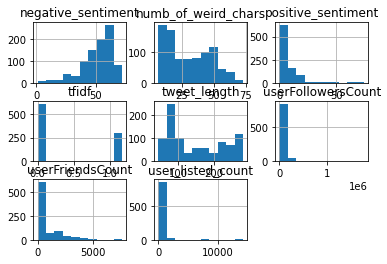

In [58]:
df.hist()

In [59]:
# LinearRegression() creates a linear regression model and the for loop divides the dataset into three folds
# (by shuffling its indices). Inside the loop, we fit the data and then assess 
# its performance by appending its score to a list (scikit-learn returns the R² score which is 
# simply the coefficient of determination).

X = pd.DataFrame(df['positive_sentiment'])
y = pd.DataFrame(df['negative_sentiment'])
model = LinearRegression()
scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
 model.fit(X.iloc[train,:], y.iloc[train,:])
 score = model.score(X.iloc[test,:], y.iloc[test,:])
 scores.append(score)
print(scores)
## Scores
# [0.3426196251381527, 0.311339103472439, 0.33368357019140715] <-- original
# [0.3007490969521819, 0.5248583809803089, 0.5786456480325219] <-- timestamp 
## [0.30875457014518726, 0.21479123959592017, 0.2257684657713871] <-- timestamp as index
# [0.3369114843455352, 0.36012522754170384, 0.5287437875934085, 0.5775024426976063, 0.5476392189848873]



[0.3369114843455352, 0.36012522754170384, 0.5287437875934085, 0.5775024426976063, 0.5476392189848873]


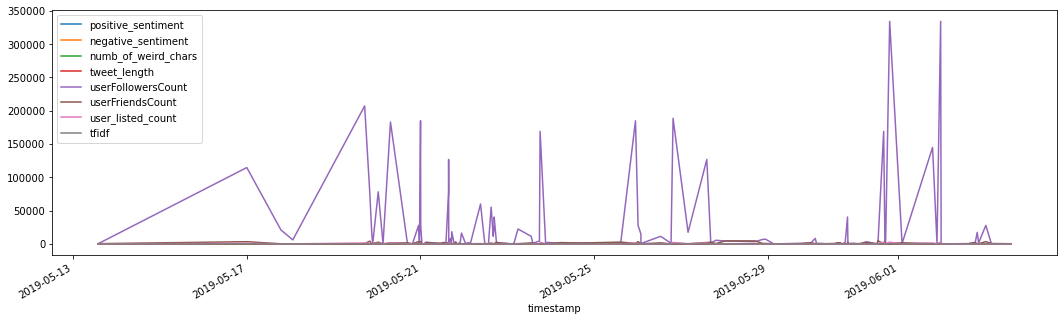

In [67]:
std_dev = 3
df = df[(np.abs(stats.zscore(df)) < float(std_dev)).all(axis=1)]
df.plot(figsize=(18,5))

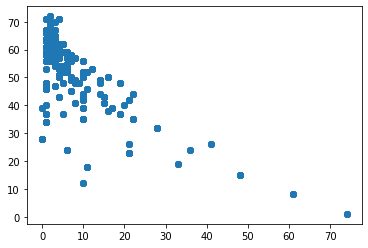

In [61]:
plt.scatter(df['positive_sentiment'], df['negative_sentiment'])


In [70]:
df
#df.loc['timestamp', ['numb_of_weird_chars']].plot()


,positive_sentiment,negative_sentiment,numb_of_weird_chars,tweet_length,userFollowersCount,userFriendsCount,user_listed_count,tfidf
timestamp,,,,,,,,
2019-05-30 23:26:02,2.0,58.0,14.0,86.0,948.0,64.0,59.0,0.0
2019-05-22 11:35:32,1.0,63.0,46.0,198.0,40.0,0.0,5.0,0.0
2019-05-30 17:24:18,3.0,63.0,13.0,67.0,84.0,243.0,1.0,0.0
2019-05-23 14:05:46,22.0,35.0,12.0,71.0,1295.0,1348.0,57.0,0.0
2019-05-21 13:07:59,10.0,52.0,10.0,55.0,689.0,2163.0,31.0,0.0
...,...,...,...,...,...,...,...,...
2019-05-22 16:13:00,7.0,50.0,12.0,74.0,11482.0,528.0,214.0,0.0
2019-05-26 01:47:19,2.0,63.0,65.0,256.0,14942.0,55.0,198.0,0.0
2019-05-21 19:59:20,5.0,52.0,14.0,64.0,245.0,328.0,0.0,0.0


In [63]:
'''X['timestamp'] = X.index.hour
# drop_first = True removes multi-collinearity
add_var = pd.get_dummies(X['timestamp'], prefix='timestamp', drop_first=True)
# Add all the columns to the model data
X = X.join(add_var)
# Drop the original column that was expanded
X.drop(columns=['timestamp'], inplace=True)
print(X.head())
'''

"X['timestamp'] = X.index.hour\n# drop_first = True removes multi-collinearity\nadd_var = pd.get_dummies(X['timestamp'], prefix='timestamp', drop_first=True)\n# Add all the columns to the model data\nX = X.join(add_var)\n# Drop the original column that was expanded\nX.drop(columns=['timestamp'], inplace=True)\nprint(X.head())\n"

In [72]:
# NW
model = LinearRegression()
scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
 model.fit(X.iloc[train,:], y.iloc[train,:])
 scores.append(model.score(X.iloc[test,:], y.iloc[test,:]))
print(scores)

# [0.3369114843455352, 0.36012522754170384, 0.5287437875934085, 0.5775024426976063, 0.5476392189848873]



[0.3369114843455352, 0.36012522754170384, 0.5287437875934085, 0.5775024426976063, 0.5476392189848873]


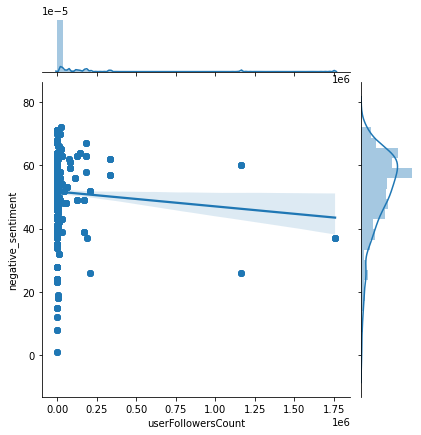

In [77]:
sns.jointplot(x=df_time['userFollowersCount'], y=df_time['negative_sentiment'], data=df_time, kind='reg')


In [74]:
# NW https://github.com/SSaishruthi/Linear_Regression_Detailed_Implementation/blob/master/Linear_Regression.ipynb
x_train, x_test, y_train, y_test = train_test_split(df_time['negative_sentiment'], df_time['positive_sentiment'], test_size=0.2, random_state=42)
x_train = np.reshape(x_train, (-1,1))
x_test = np.reshape(x_test, (-1,1))
y_train = np.reshape(y_train, (-1,1))
y_test = np.reshape(y_test, (-1,1))

#
print('Train - Predictors shape', x_train.shape)
print('Test - Predictors shape', x_test.shape)
print('Train - Target shape', y_train.shape)
print('Test - Target shape', y_test.shape)

Exception: Data must be 1-dimensional

In [27]:
df.shape

(899, 9)

In [34]:
m=df.groupby('userFollowersCount')[['negative_sentiment']].std()
n=df.groupby('userFollowersCount')[['positive_sentiment']].std()



In [35]:
m

,negative_sentiment
userFollowersCount,
0.0,0.000000
5.0,7.063350
6.0,0.000000
9.0,0.000000
10.0,0.000000
...,...
188471.0,0.000000
207008.0,13.117649
334029.0,2.594373


In [37]:
x=pd.merge(m, n, on='userFollowersCount')


In [39]:
x

,negative_sentiment,positive_sentiment
userFollowersCount,,
0.0,0.000000,0.000000
5.0,7.063350,0.504525
6.0,0.000000,0.000000
9.0,0.000000,0.000000
10.0,0.000000,0.000000
...,...,...
188471.0,0.000000,0.000000
207008.0,13.117649,18.162899
334029.0,2.594373,0.518875


In [ ]:
'''
Format Required
TRECIS-CTIT-H-Test-022 Q0 1 1 0.7 [2.0, 58.0, 14.0, 86.0, 948.0, 64.0, 59.0, 0.0] marks.run
TRECIS-CTIT-H-Test-022 Q0 2 2 0.51 [1.0, 63.0, 46.0, 198.0, 40.0, 0.0, 5.0, 0.0] marks.run
TRECIS-CTIT-H-Test-022 Q0 3 863 0.32 [3.0, 63.0, 13.0, 67.0, 84.0, 243.0, 1.0, 0.0] marks.run
TRECIS-CTIT-H-Test-023 Q0 4 1 0.637 [22.0, 35.0, 12.0, 71.0, 1295.0, 1348.0, 57.0, 0.0] marks.run

1. Incident Identifier
2. static `Q0`
3. tweetID (18-19 digit number)
4. Index (start at 1)
5. Priority label (0-1)
6. JSON array for information types
7. Runtag, UID
'''


In [6]:
# --------------------------------------------------
# Static data for the 2019 edition
# --------------------------------------------------
# Identifiers for the test events
eventIdentifiers = [
    "athensEarthquake2020",
    "baltimoreFlashFlood2020",
    "brooklynBlockPartyShooting2020",
    "daytonOhioShooting2020",
    "elPasoWalmartShooting2020",
    "gilroygarlicShooting2020",
    "hurricaneBarry2020",
    "indonesiaEarthquake2020",
    "keralaFloods2020",
    "myanmarFloods2020",
    "papuaNewguineaEarthquake2020",
    "siberianWildfires2020",
    "typhoonKrosa2020",
    "typhoonLekima2020",
    "whaleyBridgeCollapse2020"
]

eventidTopicidMap =	{
  "athensEarthquake2020": "TRECIS-CTIT-H-Test-035",
  "baltimoreFlashFlood2020": "TRECIS-CTIT-H-Test-036",
  "brooklynBlockPartyShooting2020": "TRECIS-CTIT-H-Test-037",
  "daytonOhioShooting2020": "TRECIS-CTIT-H-Test-038",
  "elPasoWalmartShooting2020": "TRECIS-CTIT-H-Test-039",
  "gilroygarlicShooting2020": "TRECIS-CTIT-H-Test-040",
  "hurricaneBarry2020": "TRECIS-CTIT-H-Test-041",
  "indonesiaEarthquake2020": "TRECIS-CTIT-H-Test-042",
  "keralaFloods2020": "TRECIS-CTIT-H-Test-043",
  "myanmarFloods2020": "TRECIS-CTIT-H-Test-044",
  "papuaNewguineaEarthquake2020": "TRECIS-CTIT-H-Test-045",
  "siberianWildfires2020": "TRECIS-CTIT-H-Test-046",
  "typhoonKrosa2020": "TRECIS-CTIT-H-Test-047",
  "typhoonLekima2020": "TRECIS-CTIT-H-Test-048",
  "whaleyBridgeCollapse2020": "TRECIS-CTIT-H-Test-049"
}

# What we consider to be highly important categories of information
highImportCategories = [
    "Request-GoodsServices",
    "Request-SearchAndRescue",
    "CallToAction-MovePeople",
    "Report-EmergingThreats",
    "Report-NewSubEvent",
    "Report-ServiceAvailable"
]

highImportCategoriesShort = [
    "GoodsServices",
    "SearchAndRescue",
    "MovePeople",
    "EmergingThreats",
    "NewSubEvent",
    "ServiceAvailable"
]